In [2]:
import os
import sys
sys.path.append(os.path.expandvars('$HOME/software/simple_adl'))
import glob
import yaml
import time
from IPython.core.debugger import set_trace
import math
import numpy as np
import pandas as pd
from pandas import *
from scipy import stats
from scipy.optimize import curve_fit

import healpy as hp
import fitsio as fits

import matplotlib.pyplot as plt
import matplotlib.colors as colors
#plt.rcParams.update({"text.usetex": True, "font.family": "serif"})
import seaborn as sns

from astropy import units as u
from astropy.coordinates import SkyCoord

import simple_adl.survey
import simple_adl.isochrone
from simple_adl.coordinate_tools import distanceModulusToDistance, angsep
from simple_adl.search import write_output, search_by_distance, cut_isochrone_path

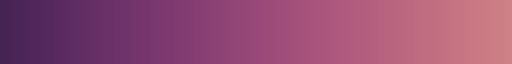

In [3]:
#cmap = sns.cubehelix_palette(start=1.0, rot=-1.0, light=0.8, dark=0.2, hue=1.0, reverse=True, as_cmap=True)
cmap = sns.cubehelix_palette(start=3.0, rot=0.5, light=0.6, dark=0.2, hue=1.0, reverse=True, as_cmap=True)
#cmap = sns.cubehelix_palette(start=0.0, rot=0.0, light=0.7, dark=0.3, hue=1.0, reverse=True, as_cmap=True)
#cmap = sns.cubehelix_palette(start=0.5, rot=0.0, light=0.7, dark=0.3, hue=1.0, reverse=True, as_cmap=True)

cmap

## Functions

In [4]:
def gnomic(mu_ra, mu_dec, ra, dec):
    """
    https://mathworld.wolfram.com/GnomonicProjection.html
    The Gnomic projection is a conformal (angle-preserving) map of 
    coordinates on a sphere to coordinates on a plane around some central
    coordinate.
    """
    mu_ra = np.deg2rad(mu_ra)
    mu_dec = np.deg2rad(mu_dec)
    ra = np.deg2rad(ra)
    dec = np.deg2rad(dec)
    
    cos_c = np.sin(mu_dec) * np.sin(dec) + np.cos(mu_dec) * np.cos(dec) * np.sin(ra - mu_ra)
    x = np.cos(dec) * np.sin(ra - mu_ra) / cos_c
    y = (np.cos(mu_dec) * np.sin(dec) - np.sin(mu_dec) *np.cos(dec) * np.cos(ra - mu_ra)) / cos_c
    
    return x, y

In [5]:
def plot_region(name, data, axs, fig, cmap):

    hb = axs.hexbin(data['ra'], data['dec'], mincnt=1, cmap=cmap, gridsize=50)
    cb = fig.colorbar(hb, ax=axs)
    axs.set_title(f'{name}')
    axs.set_xlabel(r'$ra$')
    axs.set_ylabel(r'$dec$')
    
    return

In [6]:
def plots(position, cmap, real_data=None, sim_data=None, merged_data=None):
    
    if (real_data is not None) and (sim_data is not None):
        fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))
        plot_region("DC2", real_data, axs[0], fig, cmap)
        plot_region(f'Simulated Satellite {mcid}', sim_data, axs[1], fig, cmap)
        plot_region('Merged', merged_data, axs[2], fig, cmap)
        plot_cmd(merged_data, axs[3])
        plt.show()
    else:
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))
        plot_region("DC2", real_data, axs[0], fig, cmap)
        plot_cmd(real_data, axs[1])
        plt.show()
        
    return

In [7]:
def calc_survey(dist,survey='foo'):
    if survey == 'des':
        #    Dist   A0     Mv0    logr0
        P0=[[11.3 ,  21.5,   7.8 ,   3.8],
            [22.6 ,  24.1,   8.3 ,   4.2],
            [45.2 ,  17.2,   5.2 ,   4.3], #tuned
            [90.5 ,  8.6 ,   1.2 ,   4.1],
            [181.0,  6.6 ,   -1.1,   4.1],
            [362.0,  6.3 ,   -2.3,   4.3]]
        #P0=[[11.3 ,  23.1 ,  8.1  ,  3.9  ],
        #    [22.6 ,  19.9 ,  7.3  ,  4.1  ],
        #    [45.2 ,  21.1 ,  6.1  ,  4.5  ],
        #    [90.5 ,  8.8  ,  1.2  ,  4.1  ],
        #    [181.0,  7.9  ,  -0.7 ,  4.2  ],
        #    [362.0,  6.4  ,  -2.2 ,  4.3  ]]
    elif survey == 'ps1':
        #    Dist      A0     Mv0    logr0
        P0=[[11.3 ,  21.7,   6.7 ,   3.9],
            [22.6 ,  16.4,   4.3 ,   4.0],
            [45.2 ,  11.5,   1.0 ,   4.0],
            [90.5 ,  8.6 ,   -1.0,   4.0],
            [181.0,  7.2 ,   -2.4,   4.2],
            [362.0,  4.2 ,   -4.8,   4.0]]
        P0=[[11.3 ,  22.8 ,  7.1  ,  4.0],
            [22.6 ,  19.0 ,  5.0  ,  4.1],
            [45.2 ,  14.1 ,  1.8  ,  4.2],
            [90.5 ,  11.0 ,  -0.3 ,  4.3],
            [181.0,  7.5  ,  -2.2 ,  4.2],
            [362.0,  6.8  ,  -4.0 ,  4.4],]
    elif survey == 'foo':
        P0=[[11.3 ,  22.7 ,  10.0 ,  4.0  ],
            [22.6 ,  24.8 ,  10.0 ,  4.3  ],
            [45.2 ,  1.4  ,  1.2  ,  3.5  ],
            [90.5 ,  0.0  ,  -1.3 ,  3.5  ],
            [181.0,  0.0  ,  -2.0 ,  3.5  ],
            [362.0,  0.0  ,  -3.1 ,  3.5  ],]


    #A = normalization factor (how curved)
    #B = Mv0 -- the absolute magnitude cut
    #C = R0  -- the r_physical cut
    PARAMS = np.rec.fromrecords(P0,names=['D','A','B','C'])

    a = np.interp(dist,PARAMS['D'],PARAMS['A'])
    b = np.interp(dist,PARAMS['D'],PARAMS['B'])
    c  = np.interp(dist,PARAMS['D'],PARAMS['C'])

    abs_mag = np.linspace(mbins.min(),mbins.max(),1000)
    r_physical = a/(abs_mag - b) + c

    return abs_mag, r_physical, a, b, c

In [8]:
def setdefaults(kwargs,defaults):
    for k,v in defaults.items():
        kwargs.setdefault(k,v)
    return kwargs

In [9]:
def draw_survey(dist,survey,**kwargs):
    defaults = dict(ls='--',color='k',zorder=1)
    kwargs = setdefaults(kwargs,defaults)
    abs_mag, r_physical,a,b,c = calc_survey(dist,survey)
    sel = abs_mag < b
    plt.plot(abs_mag[sel],r_physical[sel],**kwargs)

In [10]:
def query(service, ra, dec, radius=1.0, gmax=23.5):
    """Return data queried from Rubin TAP
    Parameters
    ----------
    service : TAP service [str]
    ra      : Right Ascension [deg]
    dec     : Declination [deg]
    radius  : radius around (ra, dec) [deg]

    Returns
    -------
    good_results : pd.Dataframe
    """

    # Redenning coefficients
    R_g = 3.185
    R_r = 2.140
    R_i = 1.571
    
    # Define our reference position on the sky and cone radius in arcseconds
    # to use in all following examples
    coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    radius = radius * u.deg
    
    # Quality selection and star--galaxy separation adapted from
    # https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/object_pandas_stellar_locus.ipynb

    snr_threshold = 5
    mag_err_threshold = 1/snr_threshold
    mag_threshold = 26

    # assuming extendedness is the same in all bands we assume g_extendedness matches extendedness for dp0.2 tables
    
    safe_max_extended = 1.0
    
    query = f"""
        SELECT
            ra, dec,
            mag_g, mag_r,
            magerr_g, magerr_r,
            mag_g - {R_g} AS mag_corrected_g,
            mag_r - {R_r} AS mag_corrected_r,
            extendedness
        FROM dp01_dc2_catalogs.object
        WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', {coord.ra.value}, {coord.dec.value}, {radius.value})) = 1
        
    """

    job = service.submit_job(query)
    job.run()
    job.wait(phases=['COMPLETED', 'ERROR'])
    async_results = job.fetch_result()
    results = async_results.to_table().to_pandas()
    job.delete()

    good_snr = (results['magerr_g'] < mag_err_threshold) & (results['magerr_r'] < mag_err_threshold)
    good_results = results[good_snr]
    
    return good_results

In [11]:
def get_catalog_file(catalog_dir, mc_source_id):
    """
    Inputs:
        catalog_dir = string corresponding to directory containing the stellar catalog infiles
        mc_source_id = integer corresponding the target MC_SOURCE_ID value
    Outputs:
        catalog_infile = string corresponding to filename of stellar catalog containing mc_source_id
    """
    catalog_infiles = sorted(glob.glob(catalog_dir + '/*catalog*.fits'))
    mc_source_id_array = []
    catalog_infile_index_array = []
    for ii, catalog_infile in enumerate(catalog_infiles):
        mc_source_id_min = int(os.path.basename(catalog_infile).split('.')[0].split('mc_source_id_')[-1].split('-')[0])
        mc_source_id_max = int(os.path.basename(catalog_infile).split('.')[0].split('mc_source_id_')[-1].split('-')[1])
        assert (mc_source_id_max > mc_source_id_min) & (mc_source_id_min >= 1), 'Found invalue MC_SOURCE_ID values in filenames'
        mc_source_id_array.append(np.arange(mc_source_id_min, mc_source_id_max + 1))
        catalog_infile_index_array.append(np.tile(ii, 1 + (mc_source_id_max - mc_source_id_min)))

    mc_source_id_array = np.concatenate(mc_source_id_array)
    catalog_infile_index_array = np.concatenate(catalog_infile_index_array)

    assert len(mc_source_id_array) == len(np.unique(mc_source_id_array)), 'Found non-unique MC_SOURCE_ID values in filenames'
    assert np.in1d(mc_source_id, mc_source_id_array), 'Requested MC_SOURCE_ID value not among files'
    mc_source_id_index = np.nonzero(mc_source_id == mc_source_id_array)[0][0] # second [0] added by smau 7/23/18 to fix incompatiable type bug
    return catalog_infiles[catalog_infile_index_array[mc_source_id_index]]

In [12]:
def load_sim_data(sim_dir, mc_source_id):
    """
    Load info for injecting satellite sims
    """
    cat_file = get_catalog_file(sim_dir, mc_source_id)
    cat_fits = fits.FITS(cat_file)
    w = cat_fits[1].where(f'MC_SOURCE_ID == {mc_source_id}')
    try:       
        data = cat_fits[1][w]
        cat_fits.close()
        return data
    except IndexError: 
        print('Array is empty')
        
    return

In [13]:
def plot_cmd(data, axs):
    """Plot a color magnitude diagram.
    
    data: DataFrame with photometry data
    """
    y = data['mag_g']  
    x = data['mag_g'] - data['mag_r']
    
    xlims = [-1, 1.5]  #need to find better way to restrict axes
    ylims = [16,28]
    axs.set_xlim(xlims); 
    axs.set_ylim(ylims); 
    
    axs.set_ylabel('$Magnitude (g)$')
    axs.set_xlabel('$Color (g-r)$')
    
    axs.plot(x, y, 'ko', markersize=0.3, alpha=0.3)
    axs.invert_yaxis()

    
    #plt.show()
    
    return

In [14]:
def plot_cmd_sep_iso(data, iso_selection, axs):
    """Plot a color magnitude diagram, highlight objects that pass isochrone selection.
    
    data: merged_data DataFrame with photometry data
    iso_selection: isochrone to be applied to the data
    axs: matplotlib axes object
    """
    source = data[iso_selection]
    data = data[~iso_selection]
    y = data['mag_g']  
    x = data['mag_g'] - data['mag_r']
    
    xlims = [-0.5, 1]
    ylims = [16,27]
    axs.set_xlim(xlims); 
    axs.set_ylim(ylims); 
    
    axs.set_ylabel('$g$')
    axs.set_xlabel('$g-r$')
    
    n, x, y, p = axs.hist2d(x, y, cmap='Greys', bins=[np.linspace(-0.5, 1, 50), np.linspace(16, 27, 50)], norm=colors.LogNorm(vmax=1000), rasterized=True)
    plt.colorbar(p, label='Number of objects')
    y = source['mag_g']  
    x = source['mag_g'] - source['mag_r']
    axs.plot(x, y, 'o', color='red',  markersize=3, alpha=1, markeredgecolor='white', mew=0.5, rasterized=True)
    axs.invert_yaxis()
    
    plt.show()
    
    return

In [15]:
# Note that this query (which uses the truth information about star--galaxy separation) is much slower
def query_RSP_truth(service, ra, dec, radius=1):
    # Define our reference position on the sky and cone radius in arcseconds
    # to use in all following examples
    coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    radius = radius * u.deg

    query = f"""
        SELECT
            obj.ra, obj.dec,
            obj.mag_g, obj.mag_r,
            obj.magerr_g, obj.magerr_r,
            obj.mag_g as mag_corrected_g, obj.mag_r as mag_corrected_r,
            obj.extendedness as extended_class
        FROM dp01_dc2_catalogs.object as obj
        JOIN dp01_dc2_catalogs.truth_match as truth
        ON truth.match_objectId = obj.objectId
        WHERE CONTAINS(POINT('ICRS', obj.ra, obj.dec),CIRCLE('ICRS', {coord.ra.value}, {coord.dec.value}, {radius.value})) = 1
        AND obj.extendedness < 1
        AND truth.match_objectId >= 0 
        AND truth.is_good_match = 1
        AND truth.truth_type = 2
    """
    
    df = service.search(query).to_table().to_pandas()
    df['MC_SOURCE_ID'] = 0
    
    return df

In [16]:
def randomize_coordinates_within_circle(df, center_ra, center_dec, radius):
    num_rows = df.shape[0]
    
    # Convert degrees to radians
    center_ra_rad = np.radians(center_ra)
    center_dec_rad = np.radians(center_dec)
    
    r = radius*np.sqrt(np.random.uniform(size=num_rows))
    thetas = math.pi*2*np.random.uniform(size=num_rows)
    
    random_ra = center_ra + r * np.cos(thetas)
    random_dec = center_dec + r * np.sin(thetas)
    
    # Update the DataFrame with the randomized coordinates
    df.insert(loc=0, column='ra', value=random_ra)
    df.insert(loc=1, column='dec', value=random_dec)
    
    return

In [17]:
def load_simdf(catalog_dir: str, results_dir: str) -> pd.DataFrame:
    """
    Combines information from the sim catalog files and the results directory to build the sims dataframe for results plots.
    
    parameters:
        catalog_dir: directory with the sim catalogs
        results_dir: directory with sim search results 
        
    returns:
        sims: sims dataframe
    """
    population_file = glob.glob(os.path.join(catalog_dir, '*population*'))
    files = glob.glob(os.path.join(results_dir, '*.csv'))
    first_file = files[0]
    sim_pop = fits.read(population_file[0])
    sim_pop = sim_pop.byteswap().newbyteorder() 
    df1 = pd.DataFrame(sim_pop)
    file_ids = [files[8:23] for files in os.listdir(results_dir) if 'ipynb' not in files]
    for i,f in enumerate(population_file):
        if i == 0:
            continue
        for ids in file_ids:
            if ids in f:
                sim_pop = fits.read(f)
                sim_pop = sim_pop.byteswap().newbyteorder()
                df2 = pd.DataFrame(sim_pop)
                df1 = pd.concat((df1,df2), ignore_index=True)
                break

    datadf = read_csv(first_file)
    for f in files:
        if f == first_file:
            continue
        df3 = read_csv(f)
        datadf = pd.concat((datadf, df3), ignore_index=True)

    sims = pd.merge(df1,datadf[['MC_SOURCE_ID','SIG']],on='MC_SOURCE_ID',how='left')         #merge
    sims = sims[sims['FRACDET_CORE'] == 1]
    sims = sims[sims['FRACDET_WIDE'] == 1]
    sims = sims[sims['FRACDET_HALF'] == 1]
    sims.loc[sims.DIFFICULTY == 2, 'SIG'] = 37.5
    
    return sims

## main

In [18]:
from lsst.rsp import get_tap_service

service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

/tmp/ipykernel_1576/4062763552.py:3: DeprecationWarning: get_tap_service() is deprecated, use get_tap_service("tap")
  service = get_tap_service()


In [19]:
sim_dir = '/project/shared/data/satsim/lsst_dc2_v6' 
population_file = glob.glob(os.path.join(sim_dir, '*population*'))

### background test

In [ ]:
regions = sorted(glob.glob('v6_regions/region*'))
df = pd.DataFrame(columns=['center_ra', 'center_dec', 'sig', 'shuffled sig', 'delta sig'])
regions_df = pd.DataFrame(columns=['SIG', 'RA', 'DEC', 'MODULUS', 'R', 'N_OBS', 'N_OBS_HALF', 'N_MODEL'])
with open('config.yaml') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.SafeLoader)
    survey = simple_adl.survey.Survey(cfg)

radius = 2
for i, reg in enumerate(regions):
    region_df = read_csv(reg)
    region_df.drop(columns=['Unnamed: 0'], inplace=True)
    good_snr = (region_df['magerr_g'] < 0.2) & (region_df['magerr_r'] < 0.2)
    region_df = region_df[good_snr]
    good_mag = (region_df['mag_g'] < survey.catalog['mag_max']) & (region_df['mag_r'] < survey.catalog['mag_max'])
    region_df = region_df[good_mag]
    ra = region_df['center_ra'].values[0]
    dec = region_df['center_dec'].values[0]
    
    shuffled = region_df.drop(['ra', 'dec'], axis=1, inplace=False)     # create the randomized circle of objects
    randomize_coordinates_within_circle(shuffled, ra, dec, radius)

    region = simple_adl.survey.Region(survey, ra, dec)
    region.data = region_df

    # Scan in distance moduli    
    distance_modulus = np.random.uniform(16, 24)
    iso_search = simple_adl.isochrone.Isochrone(survey=survey.isochrone['survey'],
                                           band_1=survey.band_1.lower(),
                                           band_2=survey.band_2.lower(),
                                           age=12.0, #survey.isochrone['age'],
                                           metallicity=0.00010, #survey.isochrone['metallicity'],
                                           distance_modulus=distance_modulus)

    iso_selection = cut_isochrone_path(region.data[survey.mag_dered_1], 
                                          region.data[survey.mag_dered_2],
                                          region.data[survey.mag_err_1],
                                          region.data[survey.mag_err_2],
                                          iso_search,
                                          survey.catalog['mag_max'],
                                          radius=0.1)

    results = search_by_distance(survey, region, distance_modulus, iso_selection) 
    ra_peak_array, dec_peak_array, r_peak_array, sig_peak_array, distance_modulus_array, n_obs_peak_array, n_obs_half_peak_array, n_model_peak_array = np.asarray(results)
    best_ra_peak, best_dec_peak, best_r_peak, best_distance_modulus, n_obs_peak, n_obs_half_peak, n_model_peak, best_sig_peak = 0, 0, 0, 0, 0, 0, 0, 0
    if len(sig_peak_array) == 0:
        continue
    # Sort peaks according to significance
    index_sort = np.argsort(sig_peak_array)[::-1]
    ra_peak_array = ra_peak_array[index_sort]
    dec_peak_array = dec_peak_array[index_sort]
    r_peak_array = r_peak_array[index_sort]
    sig_peak_array = sig_peak_array[index_sort]
    distance_modulus_array = distance_modulus_array[index_sort]
    n_obs_peak_array = n_obs_peak_array[index_sort]
    n_obs_half_peak_array = n_obs_half_peak_array[index_sort]
    n_model_peak_array = n_model_peak_array[index_sort]

    # Collect overlapping peaks
    for ii in range(0, len(sig_peak_array)):
        if sig_peak_array[ii] < 0:
            continue
        sep = angsep(ra_peak_array[ii], dec_peak_array[ii], ra_peak_array, dec_peak_array)
        sig_peak_array[(sep < r_peak_array[ii]) & (np.arange(len(sig_peak_array)) > ii)] = -1.

    # Prune the list of peaks
    ra_peak_array = ra_peak_array[sig_peak_array > 0.]
    dec_peak_array = dec_peak_array[sig_peak_array > 0.]
    r_peak_array = r_peak_array[sig_peak_array > 0.]
    distance_modulus_array = distance_modulus_array[sig_peak_array > 0.]
    n_obs_peak_array = n_obs_peak_array[sig_peak_array > 0.]
    n_obs_half_peak_array = n_obs_half_peak_array[sig_peak_array > 0.]
    n_model_peak_array = n_model_peak_array[sig_peak_array > 0.]
    sig_peak_array = sig_peak_array[sig_peak_array > 0.] # Update the sig_peak_array last!

    if sig_peak_array[0] > best_sig_peak:
        best_sig_peak = sig_peak_array[0]
        best_ra_peak = ra_peak_array[0]
        best_dec_peak = dec_peak_array[0]
        best_r_peak = r_peak_array[0]
        best_distance_modulus = distance_modulus_array[0]
        n_obs_peak = n_obs_peak_array[0]
        n_obs_half_peak = n_obs_half_peak_array[0]
        n_model_peak = n_model_peak_array[0]
        
    sig = best_sig_peak

    df0 = pd.DataFrame([[best_sig_peak, best_ra_peak, best_dec_peak, best_r_peak, best_distance_modulus, n_obs_peak, n_obs_half_peak, n_model_peak]], columns=regions_df.columns)
    regions_df = pd.concat([regions_df, df0], ignore_index=True)

    region = simple_adl.survey.Region(survey, ra, dec)
    region.data = shuffled

    iso_search = simple_adl.isochrone.Isochrone(survey=survey.isochrone['survey'],
                                           band_1=survey.band_1.lower(),
                                           band_2=survey.band_2.lower(),
                                           age=12.0, #survey.isochrone['age'],
                                           metallicity=0.00010, #survey.isochrone['metallicity'],
                                           distance_modulus=distance_modulus)

    iso_selection = cut_isochrone_path(region.data[survey.mag_dered_1], 
                                          region.data[survey.mag_dered_2],
                                          region.data[survey.mag_err_1],
                                          region.data[survey.mag_err_2],
                                          iso_search,
                                          survey.catalog['mag_max'],
                                          radius=0.1)

    results = search_by_distance(survey, region, distance_modulus, iso_selection) 
    ra_peak_array, dec_peak_array, r_peak_array, sig_peak_array, distance_modulus_array, n_obs_peak_array, n_obs_half_peak_array, n_model_peak_array = np.asarray(results)
    best_ra_peak, best_dec_peak, best_r_peak, best_distance_modulus, n_obs_peak, n_obs_half_peak, n_model_peak, best_sig_peak = 0, 0, 0, 0, 0, 0, 0, 0

    # Sort peaks according to significance
    index_sort = np.argsort(sig_peak_array)[::-1]
    ra_peak_array = ra_peak_array[index_sort]
    dec_peak_array = dec_peak_array[index_sort]
    r_peak_array = r_peak_array[index_sort]
    sig_peak_array = sig_peak_array[index_sort]
    distance_modulus_array = distance_modulus_array[index_sort]
    n_obs_peak_array = n_obs_peak_array[index_sort]
    n_obs_half_peak_array = n_obs_half_peak_array[index_sort]
    n_model_peak_array = n_model_peak_array[index_sort]

    # Collect overlapping peaks
    for ii in range(0, len(sig_peak_array)):
        if sig_peak_array[ii] < 0:
            continue
        sep = angsep(ra_peak_array[ii], dec_peak_array[ii], ra_peak_array, dec_peak_array)
        sig_peak_array[(sep < r_peak_array[ii]) & (np.arange(len(sig_peak_array)) > ii)] = -1.

    # Prune the list of peaks
    ra_peak_array = ra_peak_array[sig_peak_array > 0.]
    dec_peak_array = dec_peak_array[sig_peak_array > 0.]
    r_peak_array = r_peak_array[sig_peak_array > 0.]
    distance_modulus_array = distance_modulus_array[sig_peak_array > 0.]
    n_obs_peak_array = n_obs_peak_array[sig_peak_array > 0.]
    n_obs_half_peak_array = n_obs_half_peak_array[sig_peak_array > 0.]
    n_model_peak_array = n_model_peak_array[sig_peak_array > 0.]
    sig_peak_array = sig_peak_array[sig_peak_array > 0.] # Update the sig_peak_array last!

    if sig_peak_array[0] > best_sig_peak:
        best_sig_peak = sig_peak_array[0]

    shuf_sig = best_sig_peak
    delta = sig - shuf_sig
    df1 = pd.DataFrame([[ra, dec, sig, shuf_sig, delta]], columns=df.columns)
    df = pd.concat([df, df1], ignore_index=True)
    
regions_df.to_csv("v6_regions/results/regions.csv")
df.to_csv("background_test_df.csv")

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1683.1 deg^-2 = 0.468 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:        0.225, r_peak:        0.040, sig:        3.543, ra_peak:       54.234, dec_peak:      -38.419
Fitting aperture to hotspot...
Characteristic density local = 1545.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:       -0.885, r_peak:        0.050, sig:        3.378, ra_peak:       54.387, dec_peak:      -39.530
Fitting aperture to hotspot...
Characteristic density local = 1551.8 deg^-2 = 0.431 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:       -0.085, r_peak:        0.010, sig:        4.786, ra_peak:       54.551, dec_peak:      -38.731
Fitting aperture to hotspot...
Characteristic density local = 1625.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:        1.115, r_peak:        0.030, sig:        3.423, ra_peak:       55.016, dec_peak:      -37.533
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1623.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:       -1.105, y_peak:        0.665, r_peak:        0.030, sig:        4.351, ra_peak:       54.197, dec_peak:      -32.850
Fitting aperture to hotspot...
Characteristic density local = 1663.2 deg^-2 = 0.462 arcmin^-2
Candidate: x_peak:       -0.835, y_peak:        0.215, r_peak:        0.060, sig:        4.362, ra_peak:       54.514, dec_peak:      -33.303
Fitting aperture to hotspot...
Characteristic density local = 1639.3 deg^-2 = 0.455 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:        0.045, r_peak:        0.050, sig:        3.788, ra_peak:       54.931, dec_peak:      -33.476
Fitting aperture to hotspot...
Characteristic density local = 1537.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:        1.345, r_peak:        0.060, sig:        3.457, ra_peak:       54.963, dec_peak:      -32.176
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.135, y_peak:        0.475, r_peak:        0.070, sig:        5.332, ra_peak:       50.341, dec_peak:      -40.769
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.785, y_peak:        1.775, r_peak:        0.030, sig:        2.051, ra_peak:       51.179, dec_peak:      -39.465
Fitting aperture to hotspot...
Characteristic density local = 1420.5 deg^-2 = 0.395 arcmin^-2
Candidate: x_peak:        1.065, y_peak:        0.595, r_peak:        0.020, sig:        2.813, ra_peak:       51.566, dec_peak:      -40.641
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.955, y_peak:        1.675, r_peak:        0.010, sig:        2.318, ra_peak:       51.401, dec_peak:      -39.562
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.065, y_peak:        0.765, r_peak:        0.020, sig:        5.697, ra_peak:       49.927, dec_peak:      -42.929
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.045, y_peak:        1.025, r_peak:        0.080, sig:        3.967, ra_peak:       49.960, dec_peak:      -42.670
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.035, y_peak:        1.045, r_peak:        0.060, sig:        3.699, ra_peak:       49.974, dec_peak:      -42.650
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.975, y_peak:        0.185, r_peak:        0.060, sig:        4.467, ra_peak:       50.037, dec_peak:      -43.511
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2146.6 deg^-2 = 0.596 arcmin^-2
Candidate: x_peak:       -1.175, y_peak:        0.665, r_peak:        0.050, sig:        3.214, ra_peak:       55.018, dec_peak:      -31.317
Fitting aperture to hotspot...
Characteristic density local = 2283.9 deg^-2 = 0.634 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        1.095, r_peak:        0.010, sig:        3.129, ra_peak:       55.619, dec_peak:      -30.893
Fitting aperture to hotspot...
Characteristic density local = 2238.1 deg^-2 = 0.622 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:        1.035, r_peak:        0.090, sig:        2.600, ra_peak:       55.653, dec_peak:      -30.953
Fitting aperture to hotspot...
Characteristic density local = 2106.8 deg^-2 = 0.585 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:        0.535, r_peak:        0.040, sig:        3.688, ra_peak:       55.755, dec_peak:      -31.453
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1625.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:        0.275, y_peak:        0.185, r_peak:        0.030, sig:        3.423, ra_peak:       59.585, dec_peak:      -29.678
Fitting aperture to hotspot...
Characteristic density local = 1593.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:        0.485, y_peak:        0.555, r_peak:        0.020, sig:        3.492, ra_peak:       59.824, dec_peak:      -29.307
Fitting aperture to hotspot...
Characteristic density local = 1496.1 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:        0.625, y_peak:       -0.495, r_peak:        0.030, sig:        2.977, ra_peak:       59.993, dec_peak:      -30.357
Fitting aperture to hotspot...
Characteristic density local = 1525.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:        0.655, y_peak:       -0.545, r_peak:        0.040, sig:        3.355, ra_peak:       60.028, dec_peak:      -30.406
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1275.2 deg^-2 = 0.354 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:        1.105, r_peak:        0.040, sig:        4.467, ra_peak:       58.422, dec_peak:      -37.057
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:        1.725, r_peak:        0.020, sig:        2.838, ra_peak:       58.653, dec_peak:      -36.439
Fitting aperture to hotspot...
Characteristic density local = 1514.0 deg^-2 = 0.421 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:        0.225, r_peak:        0.040, sig:        3.904, ra_peak:       58.729, dec_peak:      -37.939
Fitting aperture to hotspot...
Characteristic density local = 1319.0 deg^-2 = 0.366 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:        1.435, r_peak:        0.030, sig:        4.290, ra_peak:       58.738, dec_peak:      -36.729
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:        0.605, y_peak:        0.165, r_peak:        0.050, sig:        8.509, ra_peak:       61.639, dec_peak:      -44.518
Fitting aperture to hotspot...
Characteristic density local = 1969.5 deg^-2 = 0.547 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:        0.435, r_peak:        0.290, sig:        5.577, ra_peak:       60.462, dec_peak:      -44.251
Fitting aperture to hotspot...
Characteristic density local = 2279.9 deg^-2 = 0.633 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:        0.615, r_peak:        0.010, sig:        1.797, ra_peak:       60.574, dec_peak:      -44.071
Fitting aperture to hotspot...
Characteristic density local = 1987.4 deg^-2 = 0.552 arcmin^-2
Candidate: x_peak:        0.105, y_peak:        1.175, r_peak:        0.020, sig:        2.194, ra_peak:       60.935, dec_peak:      -43.511
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2325.7 deg^-2 = 0.646 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:        1.215, r_peak:        0.010, sig:        4.230, ra_peak:       62.540, dec_peak:      -38.288
Fitting aperture to hotspot...
Characteristic density local = 2333.6 deg^-2 = 0.648 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -0.005, r_peak:        0.040, sig:        3.956, ra_peak:       63.050, dec_peak:      -39.509
Fitting aperture to hotspot...
Characteristic density local = 2300.0 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:        0.005, y_peak:        1.885, r_peak:        0.050, sig:        3.654, ra_peak:       63.050, dec_peak:      -37.619
Fitting aperture to hotspot...
Characteristic density local = 2271.9 deg^-2 = 0.631 arcmin^-2
Candidate: x_peak:        0.225, y_peak:        0.175, r_peak:        0.060, sig:        3.550, ra_peak:       63.334, dec_peak:      -39.329
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1430.4 deg^-2 = 0.397 arcmin^-2
Candidate: x_peak:       -0.875, y_peak:       -0.195, r_peak:        0.030, sig:        3.089, ra_peak:       64.188, dec_peak:      -31.885
Fitting aperture to hotspot...
Characteristic density local = 1420.5 deg^-2 = 0.395 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        0.405, r_peak:        0.020, sig:        3.273, ra_peak:       64.440, dec_peak:      -31.287
Fitting aperture to hotspot...
Characteristic density local = 1512.0 deg^-2 = 0.420 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:        0.905, r_peak:        0.040, sig:        3.908, ra_peak:       64.852, dec_peak:      -30.788
Fitting aperture to hotspot...
Characteristic density local = 1414.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:       -0.485, r_peak:        0.020, sig:        4.139, ra_peak:       64.823, dec_peak:      -32.178
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1728.8 deg^-2 = 0.480 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:        0.345, r_peak:        0.110, sig:        3.130, ra_peak:       64.951, dec_peak:      -41.511
Fitting aperture to hotspot...
Characteristic density local = 1661.2 deg^-2 = 0.461 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:        0.465, r_peak:        0.040, sig:        4.329, ra_peak:       65.659, dec_peak:      -41.395
Fitting aperture to hotspot...
Characteristic density local = 1820.3 deg^-2 = 0.506 arcmin^-2
Candidate: x_peak:        0.575, y_peak:       -1.375, r_peak:        0.110, sig:        3.435, ra_peak:       66.682, dec_peak:      -43.232
Fitting aperture to hotspot...
Characteristic density local = 1689.0 deg^-2 = 0.469 arcmin^-2
Candidate: x_peak:        0.885, y_peak:       -0.085, r_peak:        0.050, sig:        4.686, ra_peak:       67.082, dec_peak:      -41.939
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3008.0 deg^-2 = 0.836 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:       -0.245, r_peak:        0.050, sig:        3.686, ra_peak:       66.815, dec_peak:      -31.064
Fitting aperture to hotspot...
Characteristic density local = 2958.3 deg^-2 = 0.822 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.015, r_peak:        0.030, sig:        4.080, ra_peak:       66.839, dec_peak:      -30.804
Fitting aperture to hotspot...
Characteristic density local = 3137.3 deg^-2 = 0.871 arcmin^-2
Candidate: x_peak:        0.155, y_peak:       -0.005, r_peak:        0.030, sig:        3.124, ra_peak:       67.234, dec_peak:      -30.824
Fitting aperture to hotspot...
Characteristic density local = 3000.1 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:        0.265, y_peak:       -1.515, r_peak:        0.070, sig:        3.720, ra_peak:       67.368, dec_peak:      -32.334
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1776.6 deg^-2 = 0.493 arcmin^-2
Candidate: x_peak:       -0.905, y_peak:        0.635, r_peak:        0.020, sig:        3.687, ra_peak:       67.260, dec_peak:      -28.458
Fitting aperture to hotspot...
Characteristic density local = 1565.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:        1.475, r_peak:        0.100, sig:        4.466, ra_peak:       67.573, dec_peak:      -27.620
Fitting aperture to hotspot...
Characteristic density local = 1633.3 deg^-2 = 0.454 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:        0.195, r_peak:        0.280, sig:        3.884, ra_peak:       67.713, dec_peak:      -28.901
Fitting aperture to hotspot...
Characteristic density local = 1724.8 deg^-2 = 0.479 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:        0.295, r_peak:        0.020, sig:        4.141, ra_peak:       67.851, dec_peak:      -28.802
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1317.0 deg^-2 = 0.366 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -1.025, r_peak:        0.090, sig:        4.209, ra_peak:       71.569, dec_peak:      -42.042
Fitting aperture to hotspot...
Characteristic density local = 1360.8 deg^-2 = 0.378 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:       -0.375, r_peak:        0.040, sig:        1.356, ra_peak:       70.687, dec_peak:      -41.390
Fitting aperture to hotspot...
Characteristic density local = 1344.9 deg^-2 = 0.374 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:       -1.255, r_peak:        0.050, sig:        1.996, ra_peak:       71.178, dec_peak:      -42.272
Fitting aperture to hotspot...
Characteristic density local = 1350.8 deg^-2 = 0.375 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:        0.095, r_peak:        0.010, sig:        2.354, ra_peak:       71.155, dec_peak:      -40.922
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1000.0 deg^-2 = 0.278 arcmin^-2
Candidate: x_peak:       -1.745, y_peak:        0.585, r_peak:        0.120, sig:        3.746, ra_peak:       52.603, dec_peak:      -30.830
Fitting aperture to hotspot...
Characteristic density local = 1000.0 deg^-2 = 0.278 arcmin^-2
Candidate: x_peak:       -1.605, y_peak:       -0.675, r_peak:        0.050, sig:        3.277, ra_peak:       52.741, dec_peak:      -32.092
Fitting aperture to hotspot...
Characteristic density local = 1000.0 deg^-2 = 0.278 arcmin^-2
Candidate: x_peak:       -1.595, y_peak:       -0.685, r_peak:        0.040, sig:        3.493, ra_peak:       52.752, dec_peak:      -32.102
Fitting aperture to hotspot...
Characteristic density local = 1100.2 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -1.285, y_peak:        0.845, r_peak:        0.040, sig:        3.224, ra_peak:       53.143, dec_peak:      -30.577
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2827.0 deg^-2 = 0.785 arcmin^-2
Candidate: x_peak:       -0.735, y_peak:        0.105, r_peak:        0.030, sig:        3.481, ra_peak:       55.911, dec_peak:      -42.699
Fitting aperture to hotspot...
Characteristic density local = 2713.6 deg^-2 = 0.754 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:       -0.605, r_peak:        0.030, sig:        4.380, ra_peak:       55.968, dec_peak:      -43.409
Fitting aperture to hotspot...
Characteristic density local = 2719.6 deg^-2 = 0.755 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -0.875, r_peak:        0.030, sig:        4.619, ra_peak:       56.130, dec_peak:      -43.680
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:       -1.645, r_peak:        0.160, sig:        5.717, ra_peak:       56.441, dec_peak:      -44.452
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1309.0 deg^-2 = 0.364 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:       -0.635, r_peak:        0.040, sig:        4.119, ra_peak:       57.255, dec_peak:      -33.208
Fitting aperture to hotspot...
Characteristic density local = 1330.9 deg^-2 = 0.370 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:       -0.255, r_peak:        0.020, sig:        2.927, ra_peak:       57.379, dec_peak:      -32.829
Fitting aperture to hotspot...
Characteristic density local = 1219.5 deg^-2 = 0.339 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:       -0.375, r_peak:        0.020, sig:        3.546, ra_peak:       58.069, dec_peak:      -32.952
Fitting aperture to hotspot...
Characteristic density local = 1257.3 deg^-2 = 0.349 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:        0.505, r_peak:        0.040, sig:        2.836, ra_peak:       58.201, dec_peak:      -32.072
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1543.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:        0.895, y_peak:        0.445, r_peak:        0.040, sig:        3.049, ra_peak:       60.944, dec_peak:      -35.651
Fitting aperture to hotspot...
Characteristic density local = 1430.4 deg^-2 = 0.397 arcmin^-2
Candidate: x_peak:        1.045, y_peak:        0.705, r_peak:        0.040, sig:        3.566, ra_peak:       61.124, dec_peak:      -35.389
Fitting aperture to hotspot...
Characteristic density local = 1436.4 deg^-2 = 0.399 arcmin^-2
Candidate: x_peak:        1.105, y_peak:        0.175, r_peak:        0.040, sig:        4.336, ra_peak:       61.207, dec_peak:      -35.918
Fitting aperture to hotspot...
Characteristic density local = 1301.1 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:        1.185, y_peak:        0.955, r_peak:        0.290, sig:        4.258, ra_peak:       61.292, dec_peak:      -35.137
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:        1.705, r_peak:        0.070, sig:        3.291, ra_peak:       61.030, dec_peak:      -39.828
Fitting aperture to hotspot...
Characteristic density local = 1599.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:        0.445, r_peak:        0.060, sig:        3.270, ra_peak:       61.265, dec_peak:      -41.090
Fitting aperture to hotspot...
Characteristic density local = 1681.1 deg^-2 = 0.467 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:        1.005, r_peak:        0.030, sig:        3.953, ra_peak:       61.363, dec_peak:      -40.530
Fitting aperture to hotspot...
Characteristic density local = 1603.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        0.235, r_peak:        0.030, sig:        3.459, ra_peak:       61.436, dec_peak:      -41.301
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1649.2 deg^-2 = 0.458 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        1.255, r_peak:        0.030, sig:        3.384, ra_peak:       63.613, dec_peak:      -36.949
Fitting aperture to hotspot...
Characteristic density local = 1754.7 deg^-2 = 0.487 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:        1.385, r_peak:        0.040, sig:        2.886, ra_peak:       64.226, dec_peak:      -36.822
Fitting aperture to hotspot...
Characteristic density local = 1623.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:        1.185, r_peak:        0.040, sig:        2.884, ra_peak:       64.339, dec_peak:      -37.022
Fitting aperture to hotspot...
Characteristic density local = 1714.9 deg^-2 = 0.476 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        0.145, r_peak:        0.030, sig:        4.196, ra_peak:       64.362, dec_peak:      -38.062
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1784.5 deg^-2 = 0.496 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -0.535, r_peak:        0.040, sig:        3.587, ra_peak:       65.103, dec_peak:      -30.288
Fitting aperture to hotspot...
Characteristic density local = 1812.4 deg^-2 = 0.503 arcmin^-2
Candidate: x_peak:        0.355, y_peak:       -0.195, r_peak:        0.070, sig:        3.239, ra_peak:       65.506, dec_peak:      -29.947
Fitting aperture to hotspot...
Characteristic density local = 1808.4 deg^-2 = 0.502 arcmin^-2
Candidate: x_peak:        0.885, y_peak:        0.925, r_peak:        0.260, sig:        3.501, ra_peak:       66.107, dec_peak:      -28.824
Fitting aperture to hotspot...
Characteristic density local = 1892.0 deg^-2 = 0.526 arcmin^-2
Candidate: x_peak:        1.125, y_peak:        0.465, r_peak:        0.060, sig:        4.047, ra_peak:       66.387, dec_peak:      -29.282
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2303.8 deg^-2 = 0.640 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:        0.735, r_peak:        0.040, sig:        3.567, ra_peak:       67.899, dec_peak:      -30.064
Fitting aperture to hotspot...
Characteristic density local = 2260.0 deg^-2 = 0.628 arcmin^-2
Candidate: x_peak:       -0.985, y_peak:        0.915, r_peak:        0.040, sig:        3.865, ra_peak:       67.924, dec_peak:      -29.884
Fitting aperture to hotspot...
Characteristic density local = 2283.9 deg^-2 = 0.634 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:        1.315, r_peak:        0.040, sig:        3.375, ra_peak:       68.170, dec_peak:      -29.486
Fitting aperture to hotspot...
Characteristic density local = 2323.7 deg^-2 = 0.645 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:       -0.535, r_peak:        0.070, sig:        3.361, ra_peak:       68.867, dec_peak:      -31.339
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2508.7 deg^-2 = 0.697 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:        1.145, r_peak:        0.050, sig:        2.668, ra_peak:       68.943, dec_peak:      -37.423
Fitting aperture to hotspot...
Characteristic density local = 2433.1 deg^-2 = 0.676 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.765, r_peak:        0.100, sig:        2.850, ra_peak:       69.332, dec_peak:      -37.805
Fitting aperture to hotspot...
Characteristic density local = 2353.5 deg^-2 = 0.654 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:        0.735, r_peak:        0.050, sig:        3.167, ra_peak:       69.522, dec_peak:      -37.835
Fitting aperture to hotspot...
Characteristic density local = 2335.6 deg^-2 = 0.649 arcmin^-2
Candidate: x_peak:        0.065, y_peak:        0.235, r_peak:        0.060, sig:        2.903, ra_peak:       69.649, dec_peak:      -38.335
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:        0.385, r_peak:        0.060, sig:        7.343, ra_peak:       71.158, dec_peak:      -27.047
Fitting aperture to hotspot...
Characteristic density local = 2140.6 deg^-2 = 0.595 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:       -0.485, r_peak:        0.290, sig:        2.321, ra_peak:       70.984, dec_peak:      -27.916
Fitting aperture to hotspot...
Characteristic density local = 2480.8 deg^-2 = 0.689 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:       -0.625, r_peak:        0.040, sig:        2.122, ra_peak:       71.266, dec_peak:      -28.057
Fitting aperture to hotspot...
Characteristic density local = 2395.3 deg^-2 = 0.665 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:       -0.815, r_peak:        0.010, sig:        1.741, ra_peak:       71.322, dec_peak:      -28.248
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1969.5 deg^-2 = 0.547 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:        0.745, r_peak:        0.030, sig:        3.204, ra_peak:       71.248, dec_peak:      -38.121
Fitting aperture to hotspot...
Characteristic density local = 1915.8 deg^-2 = 0.532 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:        1.175, r_peak:        0.040, sig:        3.332, ra_peak:       71.251, dec_peak:      -37.691
Fitting aperture to hotspot...
Characteristic density local = 2033.2 deg^-2 = 0.565 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:       -0.845, r_peak:        0.040, sig:        3.824, ra_peak:       71.507, dec_peak:      -39.712
Fitting aperture to hotspot...
Characteristic density local = 1886.0 deg^-2 = 0.524 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:       -0.375, r_peak:        0.100, sig:        3.672, ra_peak:       71.574, dec_peak:      -39.243
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3016.0 deg^-2 = 0.838 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:       -0.195, r_peak:        0.080, sig:        3.925, ra_peak:       57.351, dec_peak:      -32.801
Fitting aperture to hotspot...
Characteristic density local = 2815.1 deg^-2 = 0.782 arcmin^-2
Candidate: x_peak:        0.245, y_peak:        1.045, r_peak:        0.040, sig:        3.800, ra_peak:       57.669, dec_peak:      -31.561
Fitting aperture to hotspot...
Characteristic density local = 2866.8 deg^-2 = 0.796 arcmin^-2
Candidate: x_peak:        0.545, y_peak:       -0.345, r_peak:        0.030, sig:        4.190, ra_peak:       58.031, dec_peak:      -32.949
Characteristic density = 3200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3294.5 deg^-2 = 0.915 arcmin^-2
Candidate: x_peak:        0.115, y_peak:        0.585, r_peak:        0.040, sig:        3.493, ra_peak:       57.517, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2443.0 deg^-2 = 0.679 arcmin^-2
Candidate: x_peak:       -1.535, y_peak:       -0.205, r_peak:        0.030, sig:        4.483, ra_peak:       53.850, dec_peak:      -35.968
Fitting aperture to hotspot...
Characteristic density local = 2496.7 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:       -0.905, y_peak:        0.175, r_peak:        0.290, sig:        2.943, ra_peak:       54.634, dec_peak:      -35.597
Fitting aperture to hotspot...
Characteristic density local = 2439.0 deg^-2 = 0.678 arcmin^-2
Candidate: x_peak:       -0.785, y_peak:        0.655, r_peak:        0.030, sig:        5.479, ra_peak:       54.787, dec_peak:      -35.119
Fitting aperture to hotspot...
Characteristic density local = 2598.2 deg^-2 = 0.722 arcmin^-2
Candidate: x_peak:       -0.785, y_peak:        0.415, r_peak:        0.030, sig:        2.669, ra_peak:       54.784, dec_peak:      -35.359
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.255, y_peak:       -0.005, r_peak:        0.070, sig:        2.959, ra_peak:       56.878, dec_peak:      -27.151
Fitting aperture to hotspot...
Characteristic density local = 1432.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:        0.325, y_peak:       -0.595, r_peak:        0.040, sig:        2.732, ra_peak:       56.959, dec_peak:      -27.741
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        1.715, y_peak:        0.095, r_peak:        0.040, sig:        4.421, ra_peak:       58.517, dec_peak:      -27.038
Characteristic density = 700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 736.1 deg^-2 = 0.204 arcmin^-2
Candidate: x_peak:        0.095, y_peak:       -0.325, r_peak:        0.010, sig:        3.721, ra_peak:       56.699, dec

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1422.4 deg^-2 = 0.395 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:        0.865, r_peak:        0.070, sig:        4.095, ra_peak:       56.412, dec_peak:      -35.552
Fitting aperture to hotspot...
Characteristic density local = 1396.6 deg^-2 = 0.388 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:        0.645, r_peak:        0.050, sig:        3.553, ra_peak:       56.483, dec_peak:      -35.772
Fitting aperture to hotspot...
Characteristic density local = 1492.1 deg^-2 = 0.414 arcmin^-2
Candidate: x_peak:       -0.415, y_peak:        0.545, r_peak:        0.050, sig:        3.519, ra_peak:       56.705, dec_peak:      -35.873
Fitting aperture to hotspot...
Characteristic density local = 1428.4 deg^-2 = 0.397 arcmin^-2
Candidate: x_peak:        0.035, y_peak:       -0.205, r_peak:        0.020, sig:        3.263, ra_peak:       57.260, dec_peak:      -36.625
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1466.2 deg^-2 = 0.407 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:        0.595, r_peak:        0.060, sig:        3.291, ra_peak:       58.226, dec_peak:      -28.459
Fitting aperture to hotspot...
Characteristic density local = 1523.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:       -0.645, r_peak:        0.040, sig:        3.091, ra_peak:       58.917, dec_peak:      -29.701
Fitting aperture to hotspot...
Characteristic density local = 1498.0 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        0.005, r_peak:        0.170, sig:        3.174, ra_peak:       59.101, dec_peak:      -29.051
Fitting aperture to hotspot...
Characteristic density local = 1569.7 deg^-2 = 0.436 arcmin^-2
Candidate: x_peak:        0.145, y_peak:       -0.495, r_peak:        0.050, sig:        3.754, ra_peak:       59.274, dec_peak:      -29.551
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1151.9 deg^-2 = 0.320 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:        1.615, r_peak:        0.030, sig:        3.612, ra_peak:       64.184, dec_peak:      -27.979
Fitting aperture to hotspot...
Characteristic density local = 1344.9 deg^-2 = 0.374 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        0.335, r_peak:        0.040, sig:        2.927, ra_peak:       64.364, dec_peak:      -29.259
Fitting aperture to hotspot...
Characteristic density local = 1227.5 deg^-2 = 0.341 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:        1.085, r_peak:        0.040, sig:        2.907, ra_peak:       64.353, dec_peak:      -28.509
Fitting aperture to hotspot...
Characteristic density local = 1261.3 deg^-2 = 0.350 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        1.325, r_peak:        0.040, sig:        3.121, ra_peak:       64.365, dec_peak:      -28.269
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1531.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:        1.345, r_peak:        0.030, sig:        3.898, ra_peak:       63.758, dec_peak:      -33.741
Fitting aperture to hotspot...
Characteristic density local = 1693.0 deg^-2 = 0.470 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:        0.065, r_peak:        0.060, sig:        3.370, ra_peak:       64.367, dec_peak:      -35.024
Fitting aperture to hotspot...
Characteristic density local = 1496.1 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.865, r_peak:        0.050, sig:        3.949, ra_peak:       64.467, dec_peak:      -34.224
Fitting aperture to hotspot...
Characteristic density local = 1597.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:        0.995, r_peak:        0.080, sig:        3.318, ra_peak:       64.600, dec_peak:      -34.094
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1897.9 deg^-2 = 0.527 arcmin^-2
Candidate: x_peak:        0.445, y_peak:        0.025, r_peak:        0.040, sig:        3.366, ra_peak:       68.909, dec_peak:      -36.455
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.465, y_peak:        1.705, r_peak:        0.010, sig:        4.029, ra_peak:       68.922, dec_peak:      -34.775
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.565, y_peak:        1.635, r_peak:        0.040, sig:        3.801, ra_peak:       69.044, dec_peak:      -34.844
Fitting aperture to hotspot...
Characteristic density local = 1971.5 deg^-2 = 0.548 arcmin^-2
Candidate: x_peak:        0.715, y_peak:        0.965, r_peak:        0.070, sig:        2.428, ra_peak:       69.234, dec_peak:      -35.513
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1748.7 deg^-2 = 0.486 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:       -0.465, r_peak:        0.060, sig:        2.838, ra_peak:       69.639, dec_peak:      -37.088
Fitting aperture to hotspot...
Characteristic density local = 1720.9 deg^-2 = 0.478 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:       -0.975, r_peak:        0.040, sig:        3.211, ra_peak:       69.687, dec_peak:      -37.598
Fitting aperture to hotspot...
Characteristic density local = 1750.7 deg^-2 = 0.486 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -0.375, r_peak:        0.020, sig:        3.308, ra_peak:       69.865, dec_peak:      -36.998
Fitting aperture to hotspot...
Characteristic density local = 1571.7 deg^-2 = 0.437 arcmin^-2
Candidate: x_peak:        0.075, y_peak:        0.445, r_peak:        0.030, sig:        4.441, ra_peak:       70.077, dec_peak:      -36.178
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3181.1 deg^-2 = 0.884 arcmin^-2
Candidate: x_peak:       -0.415, y_peak:       -0.235, r_peak:        0.050, sig:        4.030, ra_peak:       69.708, dec_peak:      -31.003
Fitting aperture to hotspot...
Characteristic density local = 3322.4 deg^-2 = 0.923 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:       -0.975, r_peak:        0.050, sig:        3.943, ra_peak:       70.151, dec_peak:      -31.743
Fitting aperture to hotspot...
Characteristic density local = 3201.0 deg^-2 = 0.889 arcmin^-2
Candidate: x_peak:        0.335, y_peak:       -1.205, r_peak:        0.040, sig:        4.012, ra_peak:       70.587, dec_peak:      -31.973
Fitting aperture to hotspot...
Characteristic density local = 3181.1 deg^-2 = 0.884 arcmin^-2
Candidate: x_peak:        0.515, y_peak:       -1.135, r_peak:        0.030, sig:        3.822, ra_peak:       70.799, dec_peak:      -31.902
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1675.1 deg^-2 = 0.465 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:        0.175, r_peak:        0.020, sig:        1.533, ra_peak:       71.725, dec_peak:      -31.388
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.185, y_peak:       -0.155, r_peak:        0.040, sig:        3.758, ra_peak:       72.124, dec_peak:      -31.718
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.145, y_peak:        0.415, r_peak:        0.040, sig:        4.005, ra_peak:       72.076, dec_peak:      -31.148
Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1187.7 deg^-2 = 0.330 arcmin^-2
Candidate: x_peak:        0.145, y_peak:        0.315, r_peak:        0.220, sig:        3.297, ra_peak:       72.076, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1293.1 deg^-2 = 0.359 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:       -0.985, r_peak:        0.040, sig:        4.158, ra_peak:       58.424, dec_peak:      -37.060
Fitting aperture to hotspot...
Characteristic density local = 1390.6 deg^-2 = 0.386 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:       -0.355, r_peak:        0.030, sig:        3.159, ra_peak:       58.666, dec_peak:      -36.432
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -1.865, r_peak:        0.040, sig:        4.141, ra_peak:       58.732, dec_peak:      -37.942
Fitting aperture to hotspot...
Characteristic density local = 1342.9 deg^-2 = 0.373 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:       -0.645, r_peak:        0.030, sig:        3.587, ra_peak:       58.752, dec_peak:      -36.722
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2000.0 deg^-2 = 0.556 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:       -1.595, r_peak:        0.050, sig:        6.988, ra_peak:       51.440, dec_peak:      -33.115
Fitting aperture to hotspot...
Characteristic density local = 2000.0 deg^-2 = 0.556 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:       -1.895, r_peak:        0.030, sig:        2.215, ra_peak:       51.856, dec_peak:      -33.417
Fitting aperture to hotspot...
Characteristic density local = 2000.0 deg^-2 = 0.556 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:       -1.945, r_peak:        0.030, sig:        0.806, ra_peak:       51.988, dec_peak:      -33.467
Fitting aperture to hotspot...
Characteristic density local = 2122.7 deg^-2 = 0.590 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -0.985, r_peak:        0.040, sig:        2.466, ra_peak:       52.369, dec_peak:      -32.507
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1078.3 deg^-2 = 0.300 arcmin^-2
Candidate: x_peak:       -1.325, y_peak:       -0.125, r_peak:        0.030, sig:        3.026, ra_peak:       52.266, dec_peak:      -40.382
Fitting aperture to hotspot...
Characteristic density local = 1062.4 deg^-2 = 0.295 arcmin^-2
Candidate: x_peak:       -1.265, y_peak:        0.245, r_peak:        0.030, sig:        3.436, ra_peak:       52.353, dec_peak:      -40.013
Fitting aperture to hotspot...
Characteristic density local = 1012.6 deg^-2 = 0.281 arcmin^-2
Candidate: x_peak:       -1.055, y_peak:        0.225, r_peak:        0.010, sig:        4.098, ra_peak:       52.627, dec_peak:      -40.037
Fitting aperture to hotspot...
Characteristic density local = 1006.7 deg^-2 = 0.280 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:       -0.725, r_peak:        0.060, sig:        3.179, ra_peak:       53.482, dec_peak:      -40.994
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3099.5 deg^-2 = 0.861 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:       -0.365, r_peak:        0.040, sig:        3.172, ra_peak:       56.780, dec_peak:      -41.801
Fitting aperture to hotspot...
Characteristic density local = 3115.5 deg^-2 = 0.865 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -0.585, r_peak:        0.010, sig:        3.798, ra_peak:       56.966, dec_peak:      -42.022
Fitting aperture to hotspot...
Characteristic density local = 2912.5 deg^-2 = 0.809 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:        0.535, r_peak:        0.100, sig:        3.846, ra_peak:       57.054, dec_peak:      -40.902
Fitting aperture to hotspot...
Characteristic density local = 2988.1 deg^-2 = 0.830 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -1.055, r_peak:        0.040, sig:        4.329, ra_peak:       57.668, dec_peak:      -42.493
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1555.7 deg^-2 = 0.432 arcmin^-2
Candidate: x_peak:        0.315, y_peak:       -0.115, r_peak:        0.070, sig:        3.444, ra_peak:       65.290, dec_peak:      -27.572
Fitting aperture to hotspot...
Characteristic density local = 1623.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:        0.845, y_peak:       -0.035, r_peak:        0.010, sig:        3.556, ra_peak:       65.887, dec_peak:      -27.489
Fitting aperture to hotspot...
Characteristic density local = 1567.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:        0.865, y_peak:       -0.805, r_peak:        0.040, sig:        3.528, ra_peak:       65.916, dec_peak:      -28.259
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        1.295, y_peak:        0.425, r_peak:        0.030, sig:        3.635, ra_peak:       66.388, dec_peak:      -27.025
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2606.2 deg^-2 = 0.724 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:       -0.185, r_peak:        0.050, sig:        3.580, ra_peak:       67.895, dec_peak:      -35.540
Fitting aperture to hotspot...
Characteristic density local = 2536.5 deg^-2 = 0.705 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:       -0.975, r_peak:        0.060, sig:        3.547, ra_peak:       68.211, dec_peak:      -36.332
Fitting aperture to hotspot...
Characteristic density local = 2588.3 deg^-2 = 0.719 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:       -1.185, r_peak:        0.010, sig:        4.581, ra_peak:       68.360, dec_peak:      -36.542
Fitting aperture to hotspot...
Characteristic density local = 2773.3 deg^-2 = 0.770 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -1.175, r_peak:        0.070, sig:        3.521, ra_peak:       68.534, dec_peak:      -36.532
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1722.9 deg^-2 = 0.479 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:        0.005, r_peak:        0.030, sig:        4.183, ra_peak:       69.651, dec_peak:      -37.104
Fitting aperture to hotspot...
Characteristic density local = 1730.8 deg^-2 = 0.481 arcmin^-2
Candidate: x_peak:        0.075, y_peak:        0.105, r_peak:        0.030, sig:        3.567, ra_peak:       69.851, dec_peak:      -37.004
Fitting aperture to hotspot...
Characteristic density local = 1706.9 deg^-2 = 0.474 arcmin^-2
Candidate: x_peak:        0.245, y_peak:        0.915, r_peak:        0.010, sig:        4.097, ra_peak:       70.061, dec_peak:      -36.194
Fitting aperture to hotspot...
Characteristic density local = 1790.5 deg^-2 = 0.497 arcmin^-2
Candidate: x_peak:        0.425, y_peak:       -0.925, r_peak:        0.050, sig:        3.622, ra_peak:       70.297, dec_peak:      -38.033
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1521.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:       -1.185, y_peak:        0.135, r_peak:        0.060, sig:        3.885, ra_peak:       68.358, dec_peak:      -35.768
Fitting aperture to hotspot...
Characteristic density local = 1659.2 deg^-2 = 0.461 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:       -0.785, r_peak:        0.030, sig:        3.683, ra_peak:       68.852, dec_peak:      -36.693
Fitting aperture to hotspot...
Characteristic density local = 1591.5 deg^-2 = 0.442 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:        0.795, r_peak:        0.060, sig:        2.909, ra_peak:       69.336, dec_peak:      -35.116
Fitting aperture to hotspot...
Characteristic density local = 1593.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:        0.815, r_peak:        0.080, sig:        3.184, ra_peak:       69.360, dec_peak:      -35.096
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1593.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:       -1.105, r_peak:        0.060, sig:        3.850, ra_peak:       70.212, dec_peak:      -43.005
Fitting aperture to hotspot...
Characteristic density local = 1424.4 deg^-2 = 0.396 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:       -1.655, r_peak:        0.290, sig:        5.863, ra_peak:       70.280, dec_peak:      -43.555
Fitting aperture to hotspot...
Characteristic density local = 1792.5 deg^-2 = 0.498 arcmin^-2
Candidate: x_peak:        0.055, y_peak:       -1.425, r_peak:        0.040, sig:        3.323, ra_peak:       70.404, dec_peak:      -43.325
Fitting aperture to hotspot...
Characteristic density local = 1691.0 deg^-2 = 0.470 arcmin^-2
Candidate: x_peak:        0.125, y_peak:       -0.275, r_peak:        0.020, sig:        2.948, ra_peak:       70.497, dec_peak:      -42.175
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2405.2 deg^-2 = 0.668 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:       -0.995, r_peak:        0.030, sig:        3.472, ra_peak:       69.528, dec_peak:      -34.036
Fitting aperture to hotspot...
Characteristic density local = 2500.0 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:       -1.725, r_peak:        0.060, sig:        3.477, ra_peak:       69.811, dec_peak:      -34.768
Fitting aperture to hotspot...
Characteristic density local = 2600.2 deg^-2 = 0.722 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:       -0.735, r_peak:        0.020, sig:        2.871, ra_peak:       70.156, dec_peak:      -33.780
Fitting aperture to hotspot...
Characteristic density local = 2401.3 deg^-2 = 0.667 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:       -0.385, r_peak:        0.010, sig:        4.184, ra_peak:       70.254, dec_peak:      -33.430
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2273.9 deg^-2 = 0.632 arcmin^-2
Candidate: x_peak:       -1.465, y_peak:       -0.365, r_peak:        0.070, sig:        3.926, ra_peak:       70.942, dec_peak:      -35.811
Fitting aperture to hotspot...
Characteristic density local = 2433.1 deg^-2 = 0.676 arcmin^-2
Candidate: x_peak:       -1.385, y_peak:        0.365, r_peak:        0.020, sig:        3.760, ra_peak:       71.056, dec_peak:      -35.082
Fitting aperture to hotspot...
Characteristic density local = 2327.6 deg^-2 = 0.647 arcmin^-2
Candidate: x_peak:       -1.035, y_peak:       -0.655, r_peak:        0.040, sig:        3.747, ra_peak:       71.468, dec_peak:      -36.107
Fitting aperture to hotspot...
Characteristic density local = 2399.3 deg^-2 = 0.666 arcmin^-2
Candidate: x_peak:       -0.955, y_peak:        0.815, r_peak:        0.050, sig:        3.996, ra_peak:       71.588, dec_peak:      -34.638
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1466.2 deg^-2 = 0.407 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:        1.155, r_peak:        0.060, sig:        2.892, ra_peak:       60.324, dec_peak:      -32.184
Fitting aperture to hotspot...
Characteristic density local = 1227.5 deg^-2 = 0.341 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:        1.555, r_peak:        0.280, sig:        5.906, ra_peak:       60.422, dec_peak:      -31.785
Fitting aperture to hotspot...
Characteristic density local = 1362.8 deg^-2 = 0.379 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:        1.455, r_peak:        0.040, sig:        3.722, ra_peak:       60.633, dec_peak:      -31.886
Fitting aperture to hotspot...
Characteristic density local = 1414.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:        1.185, r_peak:        0.020, sig:        3.719, ra_peak:       60.774, dec_peak:      -32.156
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:        0.115, r_peak:        0.080, sig:        3.705, ra_peak:       50.256, dec_peak:      -41.031
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -0.175, r_peak:        0.040, sig:        3.935, ra_peak:       50.322, dec_peak:      -41.321
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:        0.345, r_peak:        0.020, sig:        4.025, ra_peak:       50.389, dec_peak:      -40.801
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:        0.945, r_peak:        0.060, sig:        3.574, ra_peak:       50.403, dec_peak:      -40.201
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -1.715, y_peak:       -0.635, r_peak:        0.060, sig:        5.751, ra_peak:       50.648, dec_peak:      -38.657
Fitting aperture to hotspot...
Characteristic density local = 1368.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:       -1.195, y_peak:       -0.145, r_peak:        0.040, sig:        3.157, ra_peak:       51.325, dec_peak:      -38.178
Fitting aperture to hotspot...
Characteristic density local = 1440.4 deg^-2 = 0.400 arcmin^-2
Candidate: x_peak:       -1.205, y_peak:        0.055, r_peak:        0.040, sig:        2.715, ra_peak:       51.316, dec_peak:      -37.978
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:       -1.515, r_peak:        0.020, sig:        3.250, ra_peak:       51.866, dec_peak:      -39.554
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2258.0 deg^-2 = 0.627 arcmin^-2
Candidate: x_peak:       -1.065, y_peak:        0.035, r_peak:        0.080, sig:        3.466, ra_peak:       57.154, dec_peak:      -41.515
Fitting aperture to hotspot...
Characteristic density local = 2325.7 deg^-2 = 0.646 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:       -0.445, r_peak:        0.060, sig:        3.738, ra_peak:       57.924, dec_peak:      -42.002
Fitting aperture to hotspot...
Characteristic density local = 2457.0 deg^-2 = 0.682 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:        0.345, r_peak:        0.050, sig:        3.332, ra_peak:       58.477, dec_peak:      -41.214
Fitting aperture to hotspot...
Characteristic density local = 2383.3 deg^-2 = 0.662 arcmin^-2
Candidate: x_peak:        0.035, y_peak:       -0.415, r_peak:        0.030, sig:        3.500, ra_peak:       58.624, dec_peak:      -41.974
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:        0.455, r_peak:        0.040, sig:        4.164, ra_peak:       59.363, dec_peak:      -27.020
Fitting aperture to hotspot...
Characteristic density local = 1474.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:        0.045, r_peak:        0.040, sig:        3.468, ra_peak:       59.565, dec_peak:      -27.430
Fitting aperture to hotspot...
Characteristic density local = 1388.6 deg^-2 = 0.386 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -0.235, r_peak:        0.030, sig:        3.834, ra_peak:       59.598, dec_peak:      -27.710
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.235, y_peak:        0.445, r_peak:        0.040, sig:        4.164, ra_peak:       59.969, dec_peak:      -27.030
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 903.2 deg^-2 = 0.251 arcmin^-2
Candidate: x_peak:       -1.225, y_peak:       -0.965, r_peak:        0.050, sig:        3.338, ra_peak:       59.286, dec_peak:      -32.858
Fitting aperture to hotspot...
Characteristic density local = 891.3 deg^-2 = 0.248 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:       -1.405, r_peak:        0.030, sig:        3.035, ra_peak:       59.853, dec_peak:      -33.303
Fitting aperture to hotspot...
Characteristic density local = 976.8 deg^-2 = 0.271 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:        0.095, r_peak:        0.040, sig:        2.924, ra_peak:       60.056, dec_peak:      -31.804
Fitting aperture to hotspot...
Characteristic density local = 1014.6 deg^-2 = 0.282 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:        0.135, r_peak:        0.060, sig:        3.377, ra_peak:       60.374, dec_peak:      -31.766
Fitting aperture to 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1502.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -0.105, r_peak:        0.050, sig:        4.149, ra_peak:       60.017, dec_peak:      -30.359
Fitting aperture to hotspot...
Characteristic density local = 1537.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:        0.375, r_peak:        0.030, sig:        3.243, ra_peak:       60.286, dec_peak:      -29.880
Fitting aperture to hotspot...
Characteristic density local = 1434.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:        1.075, r_peak:        0.020, sig:        3.255, ra_peak:       60.622, dec_peak:      -29.181
Fitting aperture to hotspot...
Characteristic density local = 1517.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:        0.165, y_peak:        0.375, r_peak:        0.040, sig:        3.895, ra_peak:       60.990, dec_peak:      -29.881
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2300.0 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:        0.085, r_peak:        0.050, sig:        8.324, ra_peak:       61.633, dec_peak:      -44.507
Fitting aperture to hotspot...
Characteristic density local = 2246.1 deg^-2 = 0.624 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:        0.785, r_peak:        0.100, sig:        3.577, ra_peak:       60.777, dec_peak:      -43.801
Fitting aperture to hotspot...
Characteristic density local = 2685.7 deg^-2 = 0.746 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:        0.415, r_peak:        0.030, sig:        2.845, ra_peak:       60.742, dec_peak:      -44.171
Fitting aperture to hotspot...
Characteristic density local = 2319.7 deg^-2 = 0.644 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:        0.585, r_peak:        0.040, sig:        2.619, ra_peak:       60.885, dec_peak:      -44.002
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1695.0 deg^-2 = 0.471 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -0.405, r_peak:        0.060, sig:        3.178, ra_peak:       63.601, dec_peak:      -36.941
Fitting aperture to hotspot...
Characteristic density local = 1695.0 deg^-2 = 0.471 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:       -0.145, r_peak:        0.040, sig:        3.004, ra_peak:       63.965, dec_peak:      -36.683
Fitting aperture to hotspot...
Characteristic density local = 1621.4 deg^-2 = 0.450 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:       -0.985, r_peak:        0.050, sig:        3.185, ra_peak:       64.124, dec_peak:      -37.524
Fitting aperture to hotspot...
Characteristic density local = 1750.7 deg^-2 = 0.486 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:       -0.285, r_peak:        0.040, sig:        2.894, ra_peak:       64.226, dec_peak:      -36.824
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1456.3 deg^-2 = 0.405 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:       -0.045, r_peak:        0.040, sig:        3.508, ra_peak:       65.462, dec_peak:      -32.496
Fitting aperture to hotspot...
Characteristic density local = 1358.8 deg^-2 = 0.377 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:        0.035, r_peak:        0.020, sig:        4.216, ra_peak:       65.510, dec_peak:      -32.417
Fitting aperture to hotspot...
Characteristic density local = 1450.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:       -0.665, r_peak:        0.060, sig:        3.142, ra_peak:       65.515, dec_peak:      -33.117
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -1.655, r_peak:        0.020, sig:        3.608, ra_peak:       66.047, dec_peak:      -34.110
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2118.8 deg^-2 = 0.589 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:        0.345, r_peak:        0.030, sig:        2.993, ra_peak:       66.120, dec_peak:      -40.229
Fitting aperture to hotspot...
Characteristic density local = 2182.4 deg^-2 = 0.606 arcmin^-2
Candidate: x_peak:        0.145, y_peak:        0.625, r_peak:        0.050, sig:        3.525, ra_peak:       66.931, dec_peak:      -39.951
Fitting aperture to hotspot...
Characteristic density local = 2017.3 deg^-2 = 0.560 arcmin^-2
Candidate: x_peak:        0.325, y_peak:        0.825, r_peak:        0.040, sig:        3.620, ra_peak:       67.165, dec_peak:      -39.750
Fitting aperture to hotspot...
Characteristic density local = 2182.4 deg^-2 = 0.606 arcmin^-2
Candidate: x_peak:        0.565, y_peak:        0.665, r_peak:        0.050, sig:        2.941, ra_peak:       67.478, dec_peak:      -39.908
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2838.9 deg^-2 = 0.789 arcmin^-2
Candidate: x_peak:       -0.975, y_peak:        0.365, r_peak:        0.040, sig:        3.141, ra_peak:       62.036, dec_peak:      -41.778
Fitting aperture to hotspot...
Characteristic density local = 2878.7 deg^-2 = 0.800 arcmin^-2
Candidate: x_peak:       -0.885, y_peak:        0.275, r_peak:        0.050, sig:        2.890, ra_peak:       62.155, dec_peak:      -41.870
Fitting aperture to hotspot...
Characteristic density local = 2729.5 deg^-2 = 0.758 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:        0.485, r_peak:        0.040, sig:        3.728, ra_peak:       62.895, dec_peak:      -41.665
Fitting aperture to hotspot...
Characteristic density local = 2717.6 deg^-2 = 0.755 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.265, r_peak:        0.020, sig:        3.500, ra_peak:       63.337, dec_peak:      -42.416
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:       -0.235, r_peak:        0.100, sig:        5.915, ra_peak:       51.381, dec_peak:      -33.512
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:        0.575, r_peak:        0.040, sig:        6.114, ra_peak:       51.442, dec_peak:      -32.702
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.015, y_peak:        1.185, r_peak:        0.070, sig:        6.734, ra_peak:       51.561, dec_peak:      -32.092
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        0.885, r_peak:        0.040, sig:        3.902, ra_peak:       51.537, dec_peak:      -32.392
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:       -0.265, r_peak:        0.100, sig:        4.828, ra_peak:       50.648, dec_peak:      -38.681
Fitting aperture to hotspot...
Characteristic density local = 1486.1 deg^-2 = 0.413 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:       -0.465, r_peak:        0.030, sig:        3.659, ra_peak:       51.017, dec_peak:      -38.884
Fitting aperture to hotspot...
Characteristic density local = 1537.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -0.125, r_peak:        0.010, sig:        3.621, ra_peak:       51.557, dec_peak:      -38.546
Fitting aperture to hotspot...
Characteristic density local = 1466.2 deg^-2 = 0.407 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -0.805, r_peak:        0.050, sig:        2.902, ra_peak:       51.659, dec_peak:      -39.226
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2236.1 deg^-2 = 0.621 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:        0.145, r_peak:        0.030, sig:        3.417, ra_peak:       53.880, dec_peak:      -38.782
Fitting aperture to hotspot...
Characteristic density local = 2269.9 deg^-2 = 0.631 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -0.035, r_peak:        0.030, sig:        3.371, ra_peak:       53.917, dec_peak:      -38.962
Fitting aperture to hotspot...
Characteristic density local = 2254.0 deg^-2 = 0.626 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.025, r_peak:        0.030, sig:        3.105, ra_peak:       54.123, dec_peak:      -38.903
Fitting aperture to hotspot...
Characteristic density local = 2232.1 deg^-2 = 0.620 arcmin^-2
Candidate: x_peak:        0.015, y_peak:        0.965, r_peak:        0.020, sig:        3.208, ra_peak:       54.380, dec_peak:      -37.963
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2976.2 deg^-2 = 0.827 arcmin^-2
Candidate: x_peak:       -0.995, y_peak:       -0.165, r_peak:        0.040, sig:        3.352, ra_peak:       53.594, dec_peak:      -32.705
Fitting aperture to hotspot...
Characteristic density local = 2743.4 deg^-2 = 0.762 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:       -0.525, r_peak:        0.030, sig:        4.588, ra_peak:       54.735, dec_peak:      -33.071
Fitting aperture to hotspot...
Characteristic density local = 2793.2 deg^-2 = 0.776 arcmin^-2
Candidate: x_peak:        0.285, y_peak:       -1.275, r_peak:        0.050, sig:        3.047, ra_peak:       55.119, dec_peak:      -33.820
Fitting aperture to hotspot...
Characteristic density local = 2719.6 deg^-2 = 0.755 arcmin^-2
Candidate: x_peak:        0.735, y_peak:       -0.765, r_peak:        0.040, sig:        3.950, ra_peak:       55.656, dec_peak:      -33.308
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1402.6 deg^-2 = 0.390 arcmin^-2
Candidate: x_peak:        0.145, y_peak:        0.515, r_peak:        0.040, sig:        2.507, ra_peak:       56.885, dec_peak:      -32.300
Fitting aperture to hotspot...
Characteristic density local = 1305.1 deg^-2 = 0.363 arcmin^-2
Candidate: x_peak:        0.305, y_peak:       -0.695, r_peak:        0.050, sig:        3.812, ra_peak:       57.079, dec_peak:      -33.510
Fitting aperture to hotspot...
Characteristic density local = 1323.0 deg^-2 = 0.367 arcmin^-2
Candidate: x_peak:        0.545, y_peak:        0.505, r_peak:        0.040, sig:        3.262, ra_peak:       57.358, dec_peak:      -32.309
Fitting aperture to hotspot...
Characteristic density local = 1402.6 deg^-2 = 0.390 arcmin^-2
Candidate: x_peak:        0.555, y_peak:        0.325, r_peak:        0.010, sig:        3.060, ra_peak:       57.372, dec_peak:      -32.489
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1625.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:       -1.125, y_peak:        0.555, r_peak:        0.030, sig:        3.099, ra_peak:       60.677, dec_peak:      -28.676
Fitting aperture to hotspot...
Characteristic density local = 1502.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:        0.955, r_peak:        0.040, sig:        3.138, ra_peak:       61.170, dec_peak:      -28.279
Fitting aperture to hotspot...
Characteristic density local = 1442.3 deg^-2 = 0.401 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:        1.545, r_peak:        0.020, sig:        3.245, ra_peak:       61.502, dec_peak:      -27.691
Fitting aperture to hotspot...
Characteristic density local = 1539.8 deg^-2 = 0.428 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:        0.495, r_peak:        0.060, sig:        2.668, ra_peak:       61.589, dec_peak:      -28.741
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1899.9 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:       -1.085, y_peak:        0.295, r_peak:        0.020, sig:        3.145, ra_peak:       61.182, dec_peak:      -30.911
Fitting aperture to hotspot...
Characteristic density local = 1999.4 deg^-2 = 0.555 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:       -0.545, r_peak:        0.100, sig:        3.517, ra_peak:       61.805, dec_peak:      -31.756
Fitting aperture to hotspot...
Characteristic density local = 2067.0 deg^-2 = 0.574 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:       -0.195, r_peak:        0.030, sig:        3.363, ra_peak:       62.323, dec_peak:      -31.407
Fitting aperture to hotspot...
Characteristic density local = 2086.9 deg^-2 = 0.580 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:       -0.425, r_peak:        0.040, sig:        2.775, ra_peak:       62.346, dec_peak:      -31.637
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2128.7 deg^-2 = 0.591 arcmin^-2
Candidate: x_peak:        0.125, y_peak:        0.385, r_peak:        0.050, sig:        3.642, ra_peak:       63.343, dec_peak:      -39.328
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:        0.135, y_peak:        1.935, r_peak:        0.060, sig:        3.988, ra_peak:       63.352, dec_peak:      -37.778
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:        0.415, y_peak:        1.675, r_peak:        0.050, sig:        3.705, ra_peak:       63.708, dec_peak:      -38.037
Fitting aperture to hotspot...
Characteristic density local = 2194.3 deg^-2 = 0.610 arcmin^-2
Candidate: x_peak:        0.635, y_peak:        0.485, r_peak:        0.060, sig:        3.416, ra_peak:       64.001, dec_peak:      -39.225
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1589.6 deg^-2 = 0.442 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:        0.975, r_peak:        0.010, sig:        3.581, ra_peak:       67.927, dec_peak:      -41.334
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:        1.775, r_peak:        0.040, sig:        2.931, ra_peak:       68.768, dec_peak:      -40.539
Fitting aperture to hotspot...
Characteristic density local = 1691.0 deg^-2 = 0.470 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:       -0.435, r_peak:        0.070, sig:        3.150, ra_peak:       68.762, dec_peak:      -42.749
Fitting aperture to hotspot...
Characteristic density local = 1571.7 deg^-2 = 0.437 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:        1.595, r_peak:        0.020, sig:        3.933, ra_peak:       68.860, dec_peak:      -40.719
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1758.7 deg^-2 = 0.489 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:        0.595, r_peak:        0.040, sig:        3.390, ra_peak:       71.870, dec_peak:      -32.755
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:        1.175, r_peak:        0.040, sig:        5.850, ra_peak:       72.169, dec_peak:      -32.175
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.995, r_peak:        0.030, sig:        4.513, ra_peak:       72.193, dec_peak:      -32.355
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:        0.615, r_peak:        0.060, sig:        3.716, ra_peak:       72.251, dec_peak:      -32.736
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3131.4 deg^-2 = 0.870 arcmin^-2
Candidate: x_peak:       -0.915, y_peak:       -0.495, r_peak:        0.040, sig:        3.127, ra_peak:       62.128, dec_peak:      -41.863
Fitting aperture to hotspot...
Characteristic density local = 2960.3 deg^-2 = 0.822 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -0.105, r_peak:        0.020, sig:        2.940, ra_peak:       62.455, dec_peak:      -41.476
Fitting aperture to hotspot...
Characteristic density local = 3039.9 deg^-2 = 0.844 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:       -0.275, r_peak:        0.080, sig:        3.187, ra_peak:       62.961, dec_peak:      -41.649
Fitting aperture to hotspot...
Characteristic density local = 2954.3 deg^-2 = 0.821 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:       -1.215, r_peak:        0.030, sig:        4.803, ra_peak:       63.091, dec_peak:      -42.589
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2699.7 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:        0.095, y_peak:       -0.045, r_peak:        0.050, sig:        3.576, ra_peak:       52.947, dec_peak:      -41.109
Fitting aperture to hotspot...
Characteristic density local = 2646.0 deg^-2 = 0.735 arcmin^-2
Candidate: x_peak:        0.495, y_peak:        0.105, r_peak:        0.040, sig:        4.675, ra_peak:       53.476, dec_peak:      -40.957
Fitting aperture to hotspot...
Characteristic density local = 2640.0 deg^-2 = 0.733 arcmin^-2
Candidate: x_peak:        0.735, y_peak:        0.785, r_peak:        0.040, sig:        4.077, ra_peak:       53.784, dec_peak:      -40.275
Fitting aperture to hotspot...
Characteristic density local = 2707.6 deg^-2 = 0.752 arcmin^-2
Candidate: x_peak:        1.185, y_peak:        0.415, r_peak:        0.030, sig:        3.884, ra_peak:       54.383, dec_peak:      -40.639
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1301.1 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -1.585, r_peak:        0.280, sig:        5.032, ra_peak:       52.526, dec_peak:      -40.773
Fitting aperture to hotspot...
Characteristic density local = 1545.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:        0.015, y_peak:       -0.085, r_peak:        0.040, sig:        3.045, ra_peak:       53.133, dec_peak:      -39.274
Fitting aperture to hotspot...
Characteristic density local = 1599.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.245, y_peak:       -1.425, r_peak:        0.040, sig:        3.718, ra_peak:       53.437, dec_peak:      -40.614
Fitting aperture to hotspot...
Characteristic density local = 1653.2 deg^-2 = 0.459 arcmin^-2
Candidate: x_peak:        0.255, y_peak:       -0.315, r_peak:        0.030, sig:        3.378, ra_peak:       53.444, dec_peak:      -39.504
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2460.9 deg^-2 = 0.684 arcmin^-2
Candidate: x_peak:       -1.295, y_peak:       -0.625, r_peak:        0.050, sig:        4.225, ra_peak:       60.770, dec_peak:      -31.092
Fitting aperture to hotspot...
Characteristic density local = 2632.0 deg^-2 = 0.731 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:       -1.245, r_peak:        0.040, sig:        3.883, ra_peak:       61.547, dec_peak:      -31.719
Fitting aperture to hotspot...
Characteristic density local = 2500.0 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -1.825, r_peak:        0.050, sig:        4.494, ra_peak:       61.862, dec_peak:      -32.300
Fitting aperture to hotspot...
Characteristic density local = 2717.6 deg^-2 = 0.755 arcmin^-2
Candidate: x_peak:        0.215, y_peak:       -0.675, r_peak:        0.060, sig:        3.888, ra_peak:       62.533, dec_peak:      -31.150
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.055, y_peak:        0.205, r_peak:        0.030, sig:        4.975, ra_peak:       62.377, dec_peak:      -44.534
Fitting aperture to hotspot...
Characteristic density local = 1595.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:       -1.145, y_peak:        0.885, r_peak:        0.040, sig:        2.390, ra_peak:       60.712, dec_peak:      -43.843
Fitting aperture to hotspot...
Characteristic density local = 1517.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:       -1.075, y_peak:        0.995, r_peak:        0.020, sig:        4.002, ra_peak:       60.812, dec_peak:      -43.734
Fitting aperture to hotspot...
Characteristic density local = 1452.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:       -1.015, y_peak:        1.205, r_peak:        0.160, sig:        2.052, ra_peak:       60.900, dec_peak:      -43.525
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2102.8 deg^-2 = 0.584 arcmin^-2
Candidate: x_peak:        0.155, y_peak:        1.495, r_peak:        0.030, sig:        4.165, ra_peak:       63.131, dec_peak:      -28.846
Fitting aperture to hotspot...
Characteristic density local = 2132.7 deg^-2 = 0.592 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:        0.315, r_peak:        0.250, sig:        2.110, ra_peak:       62.301, dec_peak:      -30.025
Fitting aperture to hotspot...
Characteristic density local = 2172.5 deg^-2 = 0.603 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:        0.505, r_peak:        0.030, sig:        2.306, ra_peak:       62.441, dec_peak:      -29.836
Fitting aperture to hotspot...
Characteristic density local = 2208.3 deg^-2 = 0.613 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:        0.535, r_peak:        0.030, sig:        2.570, ra_peak:       62.602, dec_peak:      -29.806
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1502.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:        0.775, r_peak:        0.040, sig:        3.671, ra_peak:       63.608, dec_peak:      -36.967
Fitting aperture to hotspot...
Characteristic density local = 1527.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:        0.015, y_peak:       -0.015, r_peak:        0.020, sig:        3.139, ra_peak:       64.522, dec_peak:      -37.761
Fitting aperture to hotspot...
Characteristic density local = 1563.7 deg^-2 = 0.434 arcmin^-2
Candidate: x_peak:        0.315, y_peak:        0.255, r_peak:        0.030, sig:        2.865, ra_peak:       64.900, dec_peak:      -37.490
Fitting aperture to hotspot...
Characteristic density local = 1358.8 deg^-2 = 0.377 arcmin^-2
Candidate: x_peak:        0.425, y_peak:        1.535, r_peak:        0.030, sig:        4.213, ra_peak:       65.029, dec_peak:      -36.210
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:        0.055, r_peak:        0.090, sig:        6.630, ra_peak:       64.199, dec_peak:      -44.523
Fitting aperture to hotspot...
Characteristic density local = 2946.4 deg^-2 = 0.818 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:        0.355, r_peak:        0.290, sig:        3.553, ra_peak:       63.517, dec_peak:      -44.219
Fitting aperture to hotspot...
Characteristic density local = 3262.7 deg^-2 = 0.906 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:        0.515, r_peak:        0.010, sig:        3.205, ra_peak:       63.533, dec_peak:      -44.059
Fitting aperture to hotspot...
Characteristic density local = 2636.0 deg^-2 = 0.732 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:        0.295, r_peak:        0.290, sig:        9.122, ra_peak:       63.949, dec_peak:      -44.282
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1195.7 deg^-2 = 0.332 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:       -0.415, r_peak:        0.030, sig:        2.794, ra_peak:       65.569, dec_peak:      -30.644
Fitting aperture to hotspot...
Characteristic density local = 1114.1 deg^-2 = 0.309 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:        0.975, r_peak:        0.040, sig:        4.067, ra_peak:       65.697, dec_peak:      -29.255
Fitting aperture to hotspot...
Characteristic density local = 1319.0 deg^-2 = 0.366 arcmin^-2
Candidate: x_peak:        0.085, y_peak:        0.935, r_peak:        0.010, sig:        3.127, ra_peak:       66.591, dec_peak:      -29.297
Fitting aperture to hotspot...
Characteristic density local = 1269.3 deg^-2 = 0.353 arcmin^-2
Candidate: x_peak:        0.045, y_peak:        1.065, r_peak:        0.040, sig:        4.999, ra_peak:       66.545, dec_peak:      -29.167
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3100.0 deg^-2 = 0.861 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -1.655, r_peak:        0.090, sig:        3.871, ra_peak:       69.848, dec_peak:      -34.792
Fitting aperture to hotspot...
Characteristic density local = 3061.7 deg^-2 = 0.850 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:       -0.295, r_peak:        0.030, sig:        3.463, ra_peak:       70.108, dec_peak:      -33.433
Fitting aperture to hotspot...
Characteristic density local = 3091.6 deg^-2 = 0.859 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:       -1.065, r_peak:        0.240, sig:        4.955, ra_peak:       70.275, dec_peak:      -34.203
Fitting aperture to hotspot...
Characteristic density local = 3282.6 deg^-2 = 0.912 arcmin^-2
Candidate: x_peak:        0.285, y_peak:       -0.805, r_peak:        0.030, sig:        3.218, ra_peak:       70.721, dec_peak:      -33.943
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1695.0 deg^-2 = 0.471 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:        0.095, r_peak:        0.050, sig:        3.435, ra_peak:       71.155, dec_peak:      -36.054
Fitting aperture to hotspot...
Characteristic density local = 1655.2 deg^-2 = 0.460 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:        1.355, r_peak:        0.080, sig:        4.254, ra_peak:       71.299, dec_peak:      -34.795
Fitting aperture to hotspot...
Characteristic density local = 1804.4 deg^-2 = 0.501 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        1.115, r_peak:        0.010, sig:        4.026, ra_peak:       71.823, dec_peak:      -35.036
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.585, y_peak:        0.765, r_peak:        0.040, sig:        5.850, ra_peak:       72.546, dec_peak:      -35.384
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2793.2 deg^-2 = 0.776 arcmin^-2
Candidate: x_peak:       -1.345, y_peak:        0.355, r_peak:        0.040, sig:        3.629, ra_peak:       62.200, dec_peak:      -35.827
Fitting aperture to hotspot...
Characteristic density local = 2896.6 deg^-2 = 0.805 arcmin^-2
Candidate: x_peak:       -1.055, y_peak:       -0.155, r_peak:        0.040, sig:        3.055, ra_peak:       62.549, dec_peak:      -36.341
Fitting aperture to hotspot...
Characteristic density local = 2902.6 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:        0.005, r_peak:        0.200, sig:        3.553, ra_peak:       62.923, dec_peak:      -36.185
Fitting aperture to hotspot...
Characteristic density local = 2962.3 deg^-2 = 0.823 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -0.155, r_peak:        0.030, sig:        3.062, ra_peak:       63.021, dec_peak:      -36.345
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1360.8 deg^-2 = 0.378 arcmin^-2
Candidate: x_peak:       -0.785, y_peak:       -1.145, r_peak:        0.030, sig:        4.209, ra_peak:       54.100, dec_peak:      -30.648
Fitting aperture to hotspot...
Characteristic density local = 1398.6 deg^-2 = 0.388 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:       -0.715, r_peak:        0.050, sig:        3.774, ra_peak:       54.694, dec_peak:      -30.221
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:       -1.745, r_peak:        0.080, sig:        3.614, ra_peak:       54.972, dec_peak:      -31.251
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -1.725, r_peak:        0.030, sig:        3.668, ra_peak:       54.995, dec_peak:      -31.231
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1408.5 deg^-2 = 0.391 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:        0.655, r_peak:        0.030, sig:        4.434, ra_peak:       55.329, dec_peak:      -40.226
Fitting aperture to hotspot...
Characteristic density local = 1436.4 deg^-2 = 0.399 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:       -0.035, r_peak:        0.050, sig:        3.444, ra_peak:       55.609, dec_peak:      -40.919
Fitting aperture to hotspot...
Characteristic density local = 1406.5 deg^-2 = 0.391 arcmin^-2
Candidate: x_peak:       -0.555, y_peak:        0.505, r_peak:        0.020, sig:        3.291, ra_peak:       55.654, dec_peak:      -40.379
Fitting aperture to hotspot...
Characteristic density local = 1410.5 deg^-2 = 0.392 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:        0.225, r_peak:        0.020, sig:        2.825, ra_peak:       56.231, dec_peak:      -40.661
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1718.9 deg^-2 = 0.477 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:       -0.385, r_peak:        0.030, sig:        3.586, ra_peak:       56.666, dec_peak:      -35.685
Fitting aperture to hotspot...
Characteristic density local = 1720.9 deg^-2 = 0.478 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:        0.255, r_peak:        0.030, sig:        3.270, ra_peak:       56.978, dec_peak:      -35.047
Fitting aperture to hotspot...
Characteristic density local = 1830.3 deg^-2 = 0.508 arcmin^-2
Candidate: x_peak:        0.045, y_peak:        0.955, r_peak:        0.010, sig:        4.565, ra_peak:       57.589, dec_peak:      -34.348
Fitting aperture to hotspot...
Characteristic density local = 1704.9 deg^-2 = 0.474 arcmin^-2
Candidate: x_peak:        0.215, y_peak:       -0.045, r_peak:        0.030, sig:        2.973, ra_peak:       57.798, dec_peak:      -35.348
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1454.3 deg^-2 = 0.404 arcmin^-2
Candidate: x_peak:       -1.035, y_peak:       -0.895, r_peak:        0.030, sig:        2.698, ra_peak:       60.734, dec_peak:      -34.050
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.035, y_peak:       -1.335, r_peak:        0.030, sig:        3.814, ra_peak:       60.727, dec_peak:      -34.490
Fitting aperture to hotspot...
Characteristic density local = 1468.2 deg^-2 = 0.408 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:       -1.125, r_peak:        0.050, sig:        3.129, ra_peak:       61.045, dec_peak:      -34.283
Fitting aperture to hotspot...
Characteristic density local = 1378.7 deg^-2 = 0.383 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:       -0.585, r_peak:        0.070, sig:        3.038, ra_peak:       61.400, dec_peak:      -33.745
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1452.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:        0.235, r_peak:        0.040, sig:        3.782, ra_peak:       63.729, dec_peak:      -28.431
Fitting aperture to hotspot...
Characteristic density local = 1432.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:       -0.835, y_peak:       -0.265, r_peak:        0.030, sig:        3.086, ra_peak:       63.793, dec_peak:      -28.932
Fitting aperture to hotspot...
Characteristic density local = 1400.6 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        0.325, r_peak:        0.050, sig:        3.542, ra_peak:       64.139, dec_peak:      -28.344
Fitting aperture to hotspot...
Characteristic density local = 1386.6 deg^-2 = 0.385 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:       -0.735, r_peak:        0.040, sig:        3.933, ra_peak:       64.190, dec_peak:      -29.404
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1617.4 deg^-2 = 0.449 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:       -0.435, r_peak:        0.070, sig:        3.398, ra_peak:       64.965, dec_peak:      -41.517
Fitting aperture to hotspot...
Characteristic density local = 1637.3 deg^-2 = 0.455 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.415, r_peak:        0.020, sig:        3.440, ra_peak:       65.379, dec_peak:      -41.498
Fitting aperture to hotspot...
Characteristic density local = 1539.8 deg^-2 = 0.428 arcmin^-2
Candidate: x_peak:        0.025, y_peak:        0.035, r_peak:        0.020, sig:        3.973, ra_peak:       65.419, dec_peak:      -41.048
Fitting aperture to hotspot...
Characteristic density local = 1591.5 deg^-2 = 0.442 arcmin^-2
Candidate: x_peak:        0.625, y_peak:       -0.945, r_peak:        0.030, sig:        3.796, ra_peak:       66.227, dec_peak:      -42.025
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2222.2 deg^-2 = 0.617 arcmin^-2
Candidate: x_peak:       -0.885, y_peak:        0.545, r_peak:        0.070, sig:        3.363, ra_peak:       67.928, dec_peak:      -30.089
Fitting aperture to hotspot...
Characteristic density local = 2198.3 deg^-2 = 0.611 arcmin^-2
Candidate: x_peak:       -0.885, y_peak:        0.735, r_peak:        0.040, sig:        3.751, ra_peak:       67.930, dec_peak:      -29.899
Fitting aperture to hotspot...
Characteristic density local = 2256.0 deg^-2 = 0.627 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:        1.155, r_peak:        0.070, sig:        3.410, ra_peak:       68.164, dec_peak:      -29.481
Fitting aperture to hotspot...
Characteristic density local = 2266.0 deg^-2 = 0.629 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:       -0.695, r_peak:        0.070, sig:        3.809, ra_peak:       68.863, dec_peak:      -31.333
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1611.4 deg^-2 = 0.448 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:        1.105, r_peak:        0.110, sig:        3.055, ra_peak:       68.275, dec_peak:      -29.438
Fitting aperture to hotspot...
Characteristic density local = 1613.4 deg^-2 = 0.448 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:        0.205, r_peak:        0.050, sig:        3.640, ra_peak:       68.417, dec_peak:      -30.339
Fitting aperture to hotspot...
Characteristic density local = 1788.5 deg^-2 = 0.497 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:       -0.685, r_peak:        0.050, sig:        2.561, ra_peak:       68.866, dec_peak:      -31.231
Fitting aperture to hotspot...
Characteristic density local = 1679.1 deg^-2 = 0.466 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:        1.135, r_peak:        0.020, sig:        3.801, ra_peak:       69.079, dec_peak:      -29.412
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2707.6 deg^-2 = 0.752 arcmin^-2
Candidate: x_peak:        0.455, y_peak:       -1.215, r_peak:        0.040, sig:        3.554, ra_peak:       71.234, dec_peak:      -39.687
Fitting aperture to hotspot...
Characteristic density local = 2878.7 deg^-2 = 0.800 arcmin^-2
Candidate: x_peak:        0.645, y_peak:       -1.245, r_peak:        0.020, sig:        4.042, ra_peak:       71.481, dec_peak:      -39.715
Fitting aperture to hotspot...
Characteristic density local = 2655.9 deg^-2 = 0.738 arcmin^-2
Candidate: x_peak:        0.695, y_peak:       -0.765, r_peak:        0.090, sig:        3.322, ra_peak:       71.540, dec_peak:      -39.235
Fitting aperture to hotspot...
Characteristic density local = 2994.1 deg^-2 = 0.832 arcmin^-2
Candidate: x_peak:        1.445, y_peak:       -0.275, r_peak:        0.040, sig:        3.929, ra_peak:       72.495, dec_peak:      -38.734
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2000.0 deg^-2 = 0.556 arcmin^-2
Candidate: x_peak:        0.545, y_peak:        1.455, r_peak:        0.030, sig:        6.870, ra_peak:       73.124, dec_peak:      -39.166
Fitting aperture to hotspot...
Characteristic density local = 2000.0 deg^-2 = 0.556 arcmin^-2
Candidate: x_peak:        0.505, y_peak:        1.705, r_peak:        0.060, sig:        6.608, ra_peak:       73.070, dec_peak:      -38.916
Fitting aperture to hotspot...
Characteristic density local = 2000.0 deg^-2 = 0.556 arcmin^-2
Candidate: x_peak:        0.585, y_peak:        1.145, r_peak:        0.040, sig:        7.441, ra_peak:       73.179, dec_peak:      -39.476
Fitting aperture to hotspot...
Characteristic density local = 2000.0 deg^-2 = 0.556 arcmin^-2
Candidate: x_peak:        0.645, y_peak:        0.525, r_peak:        0.090, sig:        6.916, ra_peak:       73.264, dec_peak:      -40.095
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1245.4 deg^-2 = 0.346 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -0.425, r_peak:        0.050, sig:        3.517, ra_peak:       66.921, dec_peak:      -31.676
Fitting aperture to hotspot...
Characteristic density local = 1207.6 deg^-2 = 0.335 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:        0.685, r_peak:        0.010, sig:        3.221, ra_peak:       66.980, dec_peak:      -30.566
Fitting aperture to hotspot...
Characteristic density local = 1354.8 deg^-2 = 0.376 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:       -1.015, r_peak:        0.020, sig:        2.896, ra_peak:       67.003, dec_peak:      -32.266
Fitting aperture to hotspot...
Characteristic density local = 1336.9 deg^-2 = 0.371 arcmin^-2
Candidate: x_peak:        0.275, y_peak:       -1.085, r_peak:        0.020, sig:        3.824, ra_peak:       67.358, dec_peak:      -32.335
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2400.0 deg^-2 = 0.667 arcmin^-2
Candidate: x_peak:       -1.125, y_peak:        0.895, r_peak:        0.060, sig:        7.356, ra_peak:       49.859, dec_peak:      -43.220
Fitting aperture to hotspot...
Characteristic density local = 2411.2 deg^-2 = 0.670 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:        1.465, r_peak:        0.040, sig:        3.385, ra_peak:       50.689, dec_peak:      -42.658
Fitting aperture to hotspot...
Characteristic density local = 2400.0 deg^-2 = 0.667 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:       -0.365, r_peak:        0.120, sig:        5.165, ra_peak:       51.115, dec_peak:      -44.490
Fitting aperture to hotspot...
Characteristic density local = 2367.4 deg^-2 = 0.658 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:        0.575, r_peak:        0.070, sig:        4.212, ra_peak:       50.761, dec_peak:      -43.549
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2208.3 deg^-2 = 0.613 arcmin^-2
Candidate: x_peak:        0.055, y_peak:        0.185, r_peak:        0.110, sig:        3.663, ra_peak:       54.038, dec_peak:      -33.006
Fitting aperture to hotspot...
Characteristic density local = 2357.5 deg^-2 = 0.655 arcmin^-2
Candidate: x_peak:        0.225, y_peak:        0.205, r_peak:        0.050, sig:        3.719, ra_peak:       54.241, dec_peak:      -32.986
Fitting aperture to hotspot...
Characteristic density local = 2417.2 deg^-2 = 0.671 arcmin^-2
Candidate: x_peak:        0.455, y_peak:       -0.135, r_peak:        0.050, sig:        3.779, ra_peak:       54.517, dec_peak:      -33.325
Fitting aperture to hotspot...
Characteristic density local = 2250.1 deg^-2 = 0.625 arcmin^-2
Candidate: x_peak:        0.655, y_peak:        0.395, r_peak:        0.050, sig:        5.027, ra_peak:       54.751, dec_peak:      -32.793
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        0.025, r_peak:        0.010, sig:        3.817, ra_peak:       55.503, dec_peak:      -28.798
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:        0.495, r_peak:        0.100, sig:        2.893, ra_peak:       55.743, dec_peak:      -28.328
Fitting aperture to hotspot...
Characteristic density local = 1231.5 deg^-2 = 0.342 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:        0.035, r_peak:        0.010, sig:        3.879, ra_peak:       55.857, dec_peak:      -28.788
Fitting aperture to hotspot...
Characteristic density local = 1392.6 deg^-2 = 0.387 arcmin^-2
Candidate: x_peak:        0.475, y_peak:        0.625, r_peak:        0.050, sig:        3.564, ra_peak:       56.458, dec_peak:      -28.197
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1432.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:       -0.325, r_peak:        0.060, sig:        3.788, ra_peak:       58.410, dec_peak:      -37.071
Fitting aperture to hotspot...
Characteristic density local = 1557.7 deg^-2 = 0.433 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:        0.315, r_peak:        0.030, sig:        3.536, ra_peak:       58.656, dec_peak:      -36.434
Fitting aperture to hotspot...
Characteristic density local = 1494.1 deg^-2 = 0.415 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -1.405, r_peak:        0.020, sig:        4.033, ra_peak:       58.736, dec_peak:      -38.154
Fitting aperture to hotspot...
Characteristic density local = 1609.5 deg^-2 = 0.447 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        0.125, r_peak:        0.030, sig:        4.375, ra_peak:       58.953, dec_peak:      -36.626
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1597.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.515, y_peak:       -1.095, r_peak:        0.050, sig:        3.023, ra_peak:       62.924, dec_peak:      -30.688
Fitting aperture to hotspot...
Characteristic density local = 1358.8 deg^-2 = 0.377 arcmin^-2
Candidate: x_peak:        0.785, y_peak:       -1.435, r_peak:        0.040, sig:        4.520, ra_peak:       63.242, dec_peak:      -31.027
Fitting aperture to hotspot...
Characteristic density local = 1434.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:        0.785, y_peak:        0.625, r_peak:        0.040, sig:        3.286, ra_peak:       63.223, dec_peak:      -28.967
Fitting aperture to hotspot...
Characteristic density local = 1410.5 deg^-2 = 0.392 arcmin^-2
Candidate: x_peak:        0.885, y_peak:        0.085, r_peak:        0.040, sig:        3.611, ra_peak:       63.342, dec_peak:      -29.506
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1555.7 deg^-2 = 0.432 arcmin^-2
Candidate: x_peak:       -0.875, y_peak:       -1.125, r_peak:        0.070, sig:        4.105, ra_peak:       63.533, dec_peak:      -40.434
Fitting aperture to hotspot...
Characteristic density local = 1450.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:       -1.195, r_peak:        0.100, sig:        3.820, ra_peak:       63.913, dec_peak:      -40.507
Fitting aperture to hotspot...
Characteristic density local = 1545.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -0.825, r_peak:        0.020, sig:        3.117, ra_peak:       64.624, dec_peak:      -40.140
Fitting aperture to hotspot...
Characteristic density local = 1551.8 deg^-2 = 0.431 arcmin^-2
Candidate: x_peak:        0.325, y_peak:       -0.985, r_peak:        0.030, sig:        3.864, ra_peak:       65.109, dec_peak:      -40.299
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1215.5 deg^-2 = 0.338 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:        0.515, r_peak:        0.030, sig:        3.485, ra_peak:       64.901, dec_peak:      -41.658
Fitting aperture to hotspot...
Characteristic density local = 1330.9 deg^-2 = 0.370 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:        0.445, r_peak:        0.030, sig:        3.942, ra_peak:       65.235, dec_peak:      -41.731
Fitting aperture to hotspot...
Characteristic density local = 1442.3 deg^-2 = 0.401 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:       -0.275, r_peak:        0.040, sig:        3.269, ra_peak:       65.834, dec_peak:      -42.455
Fitting aperture to hotspot...
Characteristic density local = 1336.9 deg^-2 = 0.371 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:        1.475, r_peak:        0.020, sig:        3.824, ra_peak:       65.935, dec_peak:      -40.705
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1442.3 deg^-2 = 0.401 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:        1.185, r_peak:        0.040, sig:        3.269, ra_peak:       67.884, dec_peak:      -38.444
Fitting aperture to hotspot...
Characteristic density local = 1516.0 deg^-2 = 0.421 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:        1.275, r_peak:        0.040, sig:        3.377, ra_peak:       68.549, dec_peak:      -38.357
Fitting aperture to hotspot...
Characteristic density local = 1402.6 deg^-2 = 0.390 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:        0.945, r_peak:        0.050, sig:        4.208, ra_peak:       68.803, dec_peak:      -38.688
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.375, y_peak:        1.805, r_peak:        0.040, sig:        2.868, ra_peak:       69.349, dec_peak:      -37.827
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2061.1 deg^-2 = 0.573 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:        0.465, r_peak:        0.060, sig:        3.251, ra_peak:       69.446, dec_peak:      -37.061
Fitting aperture to hotspot...
Characteristic density local = 2007.3 deg^-2 = 0.558 arcmin^-2
Candidate: x_peak:        0.145, y_peak:        1.595, r_peak:        0.070, sig:        3.855, ra_peak:       70.309, dec_peak:      -35.933
Fitting aperture to hotspot...
Characteristic density local = 2106.8 deg^-2 = 0.585 arcmin^-2
Candidate: x_peak:        0.355, y_peak:        1.395, r_peak:        0.050, sig:        3.690, ra_peak:       70.569, dec_peak:      -36.132
Fitting aperture to hotspot...
Characteristic density local = 2186.4 deg^-2 = 0.607 arcmin^-2
Candidate: x_peak:        0.595, y_peak:       -0.265, r_peak:        0.120, sig:        2.767, ra_peak:       70.882, dec_peak:      -37.790
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1838.2 deg^-2 = 0.511 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:        0.825, r_peak:        0.060, sig:        3.142, ra_peak:       70.527, dec_peak:      -32.624
Fitting aperture to hotspot...
Characteristic density local = 1796.5 deg^-2 = 0.499 arcmin^-2
Candidate: x_peak:       -0.905, y_peak:        0.735, r_peak:        0.100, sig:        3.264, ra_peak:       70.550, dec_peak:      -32.714
Fitting aperture to hotspot...
Characteristic density local = 1822.3 deg^-2 = 0.506 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:        1.075, r_peak:        0.180, sig:        3.872, ra_peak:       70.779, dec_peak:      -32.376
Fitting aperture to hotspot...
Characteristic density local = 1824.3 deg^-2 = 0.507 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:        0.095, r_peak:        0.020, sig:        3.633, ra_peak:       71.488, dec_peak:      -33.359
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:        0.785, r_peak:        0.100, sig:        6.426, ra_peak:       67.743, dec_peak:      -27.055
Fitting aperture to hotspot...
Characteristic density local = 1619.4 deg^-2 = 0.450 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:        0.275, r_peak:        0.010, sig:        4.164, ra_peak:       67.898, dec_peak:      -27.566
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        0.795, r_peak:        0.060, sig:        7.091, ra_peak:       68.372, dec_peak:      -27.047
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.275, y_peak:        0.805, r_peak:        0.060, sig:        6.264, ra_peak:       68.754, dec_peak:      -27.037
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1084.2 deg^-2 = 0.301 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:       -0.285, r_peak:        0.040, sig:        3.566, ra_peak:       52.817, dec_peak:      -37.999
Fitting aperture to hotspot...
Characteristic density local = 1147.9 deg^-2 = 0.319 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:        0.365, r_peak:        0.030, sig:        4.310, ra_peak:       53.013, dec_peak:      -37.350
Fitting aperture to hotspot...
Characteristic density local = 1134.0 deg^-2 = 0.315 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:        0.585, r_peak:        0.040, sig:        3.436, ra_peak:       53.102, dec_peak:      -37.131
Fitting aperture to hotspot...
Characteristic density local = 1054.4 deg^-2 = 0.293 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:        1.395, r_peak:        0.040, sig:        3.646, ra_peak:       53.108, dec_peak:      -36.321
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1386.6 deg^-2 = 0.385 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:        1.255, r_peak:        0.030, sig:        3.507, ra_peak:       53.768, dec_peak:      -35.851
Fitting aperture to hotspot...
Characteristic density local = 1470.2 deg^-2 = 0.408 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:        1.255, r_peak:        0.060, sig:        2.472, ra_peak:       53.879, dec_peak:      -35.852
Fitting aperture to hotspot...
Characteristic density local = 1434.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:        0.735, r_peak:        0.030, sig:        3.082, ra_peak:       54.220, dec_peak:      -36.375
Fitting aperture to hotspot...
Characteristic density local = 1426.4 deg^-2 = 0.396 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:        1.205, r_peak:        0.020, sig:        3.703, ra_peak:       54.322, dec_peak:      -35.905
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2807.1 deg^-2 = 0.780 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:        1.385, r_peak:        0.040, sig:        4.015, ra_peak:       56.096, dec_peak:      -40.038
Fitting aperture to hotspot...
Characteristic density local = 2691.7 deg^-2 = 0.748 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        1.185, r_peak:        0.170, sig:        3.890, ra_peak:       56.122, dec_peak:      -40.238
Fitting aperture to hotspot...
Characteristic density local = 2699.7 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:        0.175, y_peak:        0.715, r_peak:        0.040, sig:        2.924, ra_peak:       56.360, dec_peak:      -40.708
Fitting aperture to hotspot...
Characteristic density local = 2998.1 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:        0.445, y_peak:        0.215, r_peak:        0.030, sig:        3.281, ra_peak:       56.720, dec_peak:      -41.207
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1830.3 deg^-2 = 0.508 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:       -0.595, r_peak:        0.050, sig:        3.933, ra_peak:       56.974, dec_peak:      -41.632
Fitting aperture to hotspot...
Characteristic density local = 1782.5 deg^-2 = 0.495 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:        0.075, r_peak:        0.030, sig:        3.789, ra_peak:       57.012, dec_peak:      -40.963
Fitting aperture to hotspot...
Characteristic density local = 1790.5 deg^-2 = 0.497 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:       -0.415, r_peak:        0.050, sig:        3.622, ra_peak:       57.243, dec_peak:      -41.455
Fitting aperture to hotspot...
Characteristic density local = 1541.8 deg^-2 = 0.428 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:       -1.515, r_peak:        0.070, sig:        3.992, ra_peak:       57.242, dec_peak:      -42.555
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2248.1 deg^-2 = 0.624 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:       -0.605, r_peak:        0.040, sig:        3.437, ra_peak:       57.904, dec_peak:      -40.215
Fitting aperture to hotspot...
Characteristic density local = 2409.2 deg^-2 = 0.669 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:       -1.205, r_peak:        0.030, sig:        2.903, ra_peak:       58.213, dec_peak:      -40.817
Fitting aperture to hotspot...
Characteristic density local = 2323.7 deg^-2 = 0.645 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -0.985, r_peak:        0.030, sig:        3.300, ra_peak:       58.479, dec_peak:      -40.598
Fitting aperture to hotspot...
Characteristic density local = 2238.1 deg^-2 = 0.622 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:       -1.575, r_peak:        0.090, sig:        3.074, ra_peak:       58.516, dec_peak:      -41.188
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2942.4 deg^-2 = 0.817 arcmin^-2
Candidate: x_peak:       -0.875, y_peak:        0.725, r_peak:        0.050, sig:        1.872, ra_peak:       60.499, dec_peak:      -34.201
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:        0.275, y_peak:        1.925, r_peak:        0.030, sig:        4.644, ra_peak:       61.884, dec_peak:      -33.005
Fitting aperture to hotspot...
Characteristic density local = 2773.3 deg^-2 = 0.770 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:        1.095, r_peak:        0.010, sig:        2.254, ra_peak:       61.069, dec_peak:      -33.835
Fitting aperture to hotspot...
Characteristic density local = 2934.4 deg^-2 = 0.815 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:        0.065, r_peak:        0.010, sig:        1.502, ra_peak:       61.087, dec_peak:      -34.865
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3018.0 deg^-2 = 0.838 arcmin^-2
Candidate: x_peak:       -1.105, y_peak:       -0.235, r_peak:        0.050, sig:        3.500, ra_peak:       63.459, dec_peak:      -31.212
Fitting aperture to hotspot...
Characteristic density local = 3004.0 deg^-2 = 0.834 arcmin^-2
Candidate: x_peak:       -1.045, y_peak:       -0.615, r_peak:        0.020, sig:        3.602, ra_peak:       63.524, dec_peak:      -31.593
Fitting aperture to hotspot...
Characteristic density local = 2761.3 deg^-2 = 0.767 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:       -1.035, r_peak:        0.080, sig:        3.629, ra_peak:       64.132, dec_peak:      -32.017
Fitting aperture to hotspot...
Characteristic density local = 2769.3 deg^-2 = 0.769 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -0.485, r_peak:        0.060, sig:        3.474, ra_peak:       64.323, dec_peak:      -31.468
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1422.4 deg^-2 = 0.395 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -0.295, r_peak:        0.050, sig:        3.931, ra_peak:       65.121, dec_peak:      -36.020
Fitting aperture to hotspot...
Characteristic density local = 1498.0 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:        0.745, y_peak:        1.165, r_peak:        0.030, sig:        4.870, ra_peak:       66.044, dec_peak:      -34.556
Fitting aperture to hotspot...
Characteristic density local = 1510.0 deg^-2 = 0.419 arcmin^-2
Candidate: x_peak:        1.435, y_peak:        0.285, r_peak:        0.040, sig:        4.417, ra_peak:       66.901, dec_peak:      -35.427
Fitting aperture to hotspot...
Characteristic density local = 1432.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:        1.515, y_peak:       -0.415, r_peak:        0.040, sig:        3.827, ra_peak:       67.015, dec_peak:      -36.125
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1134.0 deg^-2 = 0.315 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:        0.065, r_peak:        0.040, sig:        3.728, ra_peak:       64.897, dec_peak:      -41.660
Fitting aperture to hotspot...
Characteristic density local = 1263.3 deg^-2 = 0.351 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:        0.015, r_peak:        0.040, sig:        3.116, ra_peak:       65.713, dec_peak:      -41.716
Fitting aperture to hotspot...
Characteristic density local = 1336.9 deg^-2 = 0.371 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:       -0.725, r_peak:        0.030, sig:        4.255, ra_peak:       65.843, dec_peak:      -42.457
Fitting aperture to hotspot...
Characteristic density local = 1233.5 deg^-2 = 0.343 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:        1.025, r_peak:        0.040, sig:        4.036, ra_peak:       65.932, dec_peak:      -40.707
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1921.8 deg^-2 = 0.534 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:        0.405, r_peak:        0.020, sig:        3.121, ra_peak:       67.299, dec_peak:      -34.112
Fitting aperture to hotspot...
Characteristic density local = 1890.0 deg^-2 = 0.525 arcmin^-2
Candidate: x_peak:        0.105, y_peak:       -0.035, r_peak:        0.030, sig:        3.623, ra_peak:       67.903, dec_peak:      -34.553
Fitting aperture to hotspot...
Characteristic density local = 1909.9 deg^-2 = 0.531 arcmin^-2
Candidate: x_peak:        0.455, y_peak:        0.275, r_peak:        0.040, sig:        3.586, ra_peak:       68.326, dec_peak:      -34.242
Fitting aperture to hotspot...
Characteristic density local = 1937.7 deg^-2 = 0.538 arcmin^-2
Candidate: x_peak:        0.605, y_peak:        0.495, r_peak:        0.040, sig:        3.533, ra_peak:       68.506, dec_peak:      -34.021
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1444.3 deg^-2 = 0.401 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:        0.275, r_peak:        0.040, sig:        4.817, ra_peak:       52.344, dec_peak:      -33.921
Fitting aperture to hotspot...
Characteristic density local = 1323.0 deg^-2 = 0.367 arcmin^-2
Candidate: x_peak:        0.595, y_peak:       -0.415, r_peak:        0.020, sig:        3.401, ra_peak:       53.193, dec_peak:      -34.609
Fitting aperture to hotspot...
Characteristic density local = 1325.0 deg^-2 = 0.368 arcmin^-2
Candidate: x_peak:        0.775, y_peak:       -1.215, r_peak:        0.030, sig:        3.954, ra_peak:       53.421, dec_peak:      -35.407
Fitting aperture to hotspot...
Characteristic density local = 1454.3 deg^-2 = 0.404 arcmin^-2
Candidate: x_peak:        1.005, y_peak:       -1.065, r_peak:        0.040, sig:        3.242, ra_peak:       53.701, dec_peak:      -35.255
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2299.8 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:       -0.985, y_peak:       -0.875, r_peak:        0.030, sig:        3.331, ra_peak:       53.888, dec_peak:      -38.782
Fitting aperture to hotspot...
Characteristic density local = 2311.7 deg^-2 = 0.642 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:       -1.055, r_peak:        0.030, sig:        3.870, ra_peak:       53.910, dec_peak:      -38.962
Fitting aperture to hotspot...
Characteristic density local = 2285.9 deg^-2 = 0.635 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:       -0.985, r_peak:        0.080, sig:        3.376, ra_peak:       54.117, dec_peak:      -38.894
Fitting aperture to hotspot...
Characteristic density local = 2297.8 deg^-2 = 0.638 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:       -0.045, r_peak:        0.030, sig:        3.047, ra_peak:       54.371, dec_peak:      -37.956
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:        0.255, r_peak:        0.060, sig:        4.693, ra_peak:       50.646, dec_peak:      -38.666
Fitting aperture to hotspot...
Characteristic density local = 1679.1 deg^-2 = 0.466 arcmin^-2
Candidate: x_peak:        0.235, y_peak:        0.745, r_peak:        0.030, sig:        2.681, ra_peak:       51.309, dec_peak:      -38.176
Fitting aperture to hotspot...
Characteristic density local = 1460.2 deg^-2 = 0.406 arcmin^-2
Candidate: x_peak:        0.645, y_peak:        0.035, r_peak:        0.110, sig:        3.631, ra_peak:       51.839, dec_peak:      -38.884
Fitting aperture to hotspot...
Characteristic density local = 1462.2 deg^-2 = 0.406 arcmin^-2
Candidate: x_peak:        0.725, y_peak:        0.485, r_peak:        0.020, sig:        4.075, ra_peak:       51.936, dec_peak:      -38.433
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1434.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:       -0.875, y_peak:        0.865, r_peak:        0.040, sig:        3.286, ra_peak:       52.413, dec_peak:      -33.844
Fitting aperture to hotspot...
Characteristic density local = 1384.6 deg^-2 = 0.385 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -0.165, r_peak:        0.050, sig:        2.884, ra_peak:       53.046, dec_peak:      -34.878
Fitting aperture to hotspot...
Characteristic density local = 1398.6 deg^-2 = 0.388 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:        0.385, r_peak:        0.010, sig:        4.922, ra_peak:       53.291, dec_peak:      -34.328
Fitting aperture to hotspot...
Characteristic density local = 1356.8 deg^-2 = 0.377 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:        0.495, r_peak:        0.180, sig:        4.074, ra_peak:       53.412, dec_peak:      -34.218
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1404.5 deg^-2 = 0.390 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:       -1.005, r_peak:        0.020, sig:        3.732, ra_peak:       54.021, dec_peak:      -41.889
Fitting aperture to hotspot...
Characteristic density local = 1360.8 deg^-2 = 0.378 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:       -1.145, r_peak:        0.010, sig:        3.764, ra_peak:       54.262, dec_peak:      -42.030
Fitting aperture to hotspot...
Characteristic density local = 1219.5 deg^-2 = 0.339 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:       -1.625, r_peak:        0.290, sig:        5.084, ra_peak:       54.490, dec_peak:      -42.511
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.265, y_peak:       -1.905, r_peak:        0.050, sig:        3.543, ra_peak:       54.953, dec_peak:      -42.790
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1342.9 deg^-2 = 0.373 arcmin^-2
Candidate: x_peak:       -0.885, y_peak:        0.475, r_peak:        0.040, sig:        3.769, ra_peak:       53.956, dec_peak:      -33.203
Fitting aperture to hotspot...
Characteristic density local = 1380.7 deg^-2 = 0.384 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:        0.265, r_peak:        0.050, sig:        2.894, ra_peak:       54.049, dec_peak:      -33.414
Fitting aperture to hotspot...
Characteristic density local = 1285.2 deg^-2 = 0.357 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:        0.535, r_peak:        0.040, sig:        3.632, ra_peak:       54.148, dec_peak:      -33.145
Fitting aperture to hotspot...
Characteristic density local = 1394.6 deg^-2 = 0.387 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:        0.225, r_peak:        0.040, sig:        3.915, ra_peak:       54.241, dec_peak:      -33.455
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:       -0.705, r_peak:        0.040, sig:        3.316, ra_peak:       55.511, dec_peak:      -28.800
Fitting aperture to hotspot...
Characteristic density local = 1088.2 deg^-2 = 0.302 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:       -0.875, r_peak:        0.290, sig:        4.747, ra_peak:       55.716, dec_peak:      -28.971
Fitting aperture to hotspot...
Characteristic density local = 1289.2 deg^-2 = 0.358 arcmin^-2
Candidate: x_peak:        0.455, y_peak:       -1.225, r_peak:        0.020, sig:        3.448, ra_peak:       56.552, dec_peak:      -29.320
Fitting aperture to hotspot...
Characteristic density local = 1263.3 deg^-2 = 0.351 arcmin^-2
Candidate: x_peak:        0.515, y_peak:       -1.115, r_peak:        0.260, sig:        3.617, ra_peak:       56.620, dec_peak:      -29.210
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1179.7 deg^-2 = 0.328 arcmin^-2
Candidate: x_peak:       -1.575, y_peak:        0.325, r_peak:        0.030, sig:        3.905, ra_peak:       57.014, dec_peak:      -32.447
Fitting aperture to hotspot...
Characteristic density local = 1348.8 deg^-2 = 0.375 arcmin^-2
Candidate: x_peak:       -1.365, y_peak:       -0.435, r_peak:        0.030, sig:        4.232, ra_peak:       57.249, dec_peak:      -33.210
Fitting aperture to hotspot...
Characteristic density local = 1400.6 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.255, y_peak:       -0.005, r_peak:        0.060, sig:        2.688, ra_peak:       57.388, dec_peak:      -32.782
Fitting aperture to hotspot...
Characteristic density local = 1291.1 deg^-2 = 0.359 arcmin^-2
Candidate: x_peak:       -1.065, y_peak:       -0.165, r_peak:        0.010, sig:        3.825, ra_peak:       57.612, dec_peak:      -32.945
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1344.9 deg^-2 = 0.374 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:        0.195, r_peak:        0.040, sig:        2.927, ra_peak:       59.498, dec_peak:      -29.795
Fitting aperture to hotspot...
Characteristic density local = 1297.1 deg^-2 = 0.360 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:       -0.085, r_peak:        0.060, sig:        3.642, ra_peak:       59.681, dec_peak:      -30.076
Fitting aperture to hotspot...
Characteristic density local = 1253.3 deg^-2 = 0.348 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:        0.015, r_peak:        0.040, sig:        3.710, ra_peak:       59.878, dec_peak:      -29.977
Fitting aperture to hotspot...
Characteristic density local = 1360.8 deg^-2 = 0.378 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:       -0.215, r_peak:        0.050, sig:        4.327, ra_peak:       60.004, dec_peak:      -30.207
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1587.6 deg^-2 = 0.441 arcmin^-2
Candidate: x_peak:       -0.905, y_peak:        0.275, r_peak:        0.080, sig:        2.904, ra_peak:       62.275, dec_peak:      -30.002
Fitting aperture to hotspot...
Characteristic density local = 1470.2 deg^-2 = 0.408 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:        0.745, r_peak:        0.020, sig:        3.210, ra_peak:       63.016, dec_peak:      -29.536
Fitting aperture to hotspot...
Characteristic density local = 1519.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:        0.135, r_peak:        0.060, sig:        2.927, ra_peak:       63.176, dec_peak:      -30.146
Fitting aperture to hotspot...
Characteristic density local = 1446.3 deg^-2 = 0.402 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:        1.535, r_peak:        0.030, sig:        3.061, ra_peak:       63.212, dec_peak:      -28.746
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1185.7 deg^-2 = 0.329 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:        1.605, r_peak:        0.030, sig:        3.544, ra_peak:       64.180, dec_peak:      -27.971
Fitting aperture to hotspot...
Characteristic density local = 1346.8 deg^-2 = 0.374 arcmin^-2
Candidate: x_peak:        0.085, y_peak:        0.315, r_peak:        0.040, sig:        2.922, ra_peak:       64.363, dec_peak:      -29.261
Fitting aperture to hotspot...
Characteristic density local = 1283.2 deg^-2 = 0.356 arcmin^-2
Candidate: x_peak:        0.085, y_peak:        1.305, r_peak:        0.040, sig:        3.069, ra_peak:       64.362, dec_peak:      -28.271
Fitting aperture to hotspot...
Characteristic density local = 1253.3 deg^-2 = 0.348 arcmin^-2
Candidate: x_peak:        0.785, y_peak:        0.565, r_peak:        0.020, sig:        3.943, ra_peak:       65.163, dec_peak:      -29.008
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1394.6 deg^-2 = 0.387 arcmin^-2
Candidate: x_peak:       -0.955, y_peak:        1.085, r_peak:        0.040, sig:        3.915, ra_peak:       69.716, dec_peak:      -33.547
Fitting aperture to hotspot...
Characteristic density local = 1418.5 deg^-2 = 0.394 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:        0.285, r_peak:        0.050, sig:        3.719, ra_peak:       70.020, dec_peak:      -34.350
Fitting aperture to hotspot...
Characteristic density local = 1368.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:        0.395, r_peak:        0.040, sig:        3.708, ra_peak:       70.118, dec_peak:      -34.240
Fitting aperture to hotspot...
Characteristic density local = 1474.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:        0.855, r_peak:        0.020, sig:        3.641, ra_peak:       70.158, dec_peak:      -33.781
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1790.5 deg^-2 = 0.497 arcmin^-2
Candidate: x_peak:        0.105, y_peak:       -0.525, r_peak:        0.060, sig:        3.275, ra_peak:       55.577, dec_peak:      -40.598
Fitting aperture to hotspot...
Characteristic density local = 1969.5 deg^-2 = 0.547 arcmin^-2
Candidate: x_peak:        0.665, y_peak:       -0.165, r_peak:        0.060, sig:        3.319, ra_peak:       56.310, dec_peak:      -40.234
Fitting aperture to hotspot...
Characteristic density local = 1973.5 deg^-2 = 0.548 arcmin^-2
Candidate: x_peak:        0.745, y_peak:        0.245, r_peak:        0.040, sig:        3.224, ra_peak:       56.408, dec_peak:      -39.824
Fitting aperture to hotspot...
Characteristic density local = 1911.8 deg^-2 = 0.531 arcmin^-2
Candidate: x_peak:        1.065, y_peak:       -0.855, r_peak:        0.250, sig:        3.376, ra_peak:       56.848, dec_peak:      -40.919
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:        0.245, r_peak:        0.100, sig:        5.316, ra_peak:       51.790, dec_peak:      -29.884
Fitting aperture to hotspot...
Characteristic density local = 1794.5 deg^-2 = 0.498 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:       -1.195, r_peak:        0.030, sig:        0.679, ra_peak:       52.087, dec_peak:      -31.325
Fitting aperture to hotspot...
Characteristic density local = 1557.7 deg^-2 = 0.433 arcmin^-2
Candidate: x_peak:        0.225, y_peak:       -0.145, r_peak:        0.020, sig:        2.648, ra_peak:       52.517, dec_peak:      -30.274
Fitting aperture to hotspot...
Characteristic density local = 1527.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:        0.305, y_peak:       -0.275, r_peak:        0.010, sig:        2.229, ra_peak:       52.610, dec_peak:      -30.404
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1000.0 deg^-2 = 0.278 arcmin^-2
Candidate: x_peak:       -0.735, y_peak:        0.775, r_peak:        0.050, sig:        7.032, ra_peak:       51.769, dec_peak:      -29.809
Fitting aperture to hotspot...
Characteristic density local = 1161.8 deg^-2 = 0.323 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:       -0.415, r_peak:        0.030, sig:        1.199, ra_peak:       52.412, dec_peak:      -31.002
Fitting aperture to hotspot...
Characteristic density local = 1128.0 deg^-2 = 0.313 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:       -0.375, r_peak:        0.220, sig:        0.618, ra_peak:       52.459, dec_peak:      -30.962
Fitting aperture to hotspot...
Characteristic density local = 1000.0 deg^-2 = 0.278 arcmin^-2
Candidate: x_peak:        0.645, y_peak:        0.655, r_peak:        0.130, sig:        1.664, ra_peak:       53.360, dec_peak:      -29.930
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2550.5 deg^-2 = 0.708 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:       -0.775, r_peak:        0.040, sig:        3.376, ra_peak:       52.412, dec_peak:      -33.985
Fitting aperture to hotspot...
Characteristic density local = 2421.1 deg^-2 = 0.673 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:       -1.375, r_peak:        0.040, sig:        3.806, ra_peak:       52.550, dec_peak:      -34.586
Fitting aperture to hotspot...
Characteristic density local = 2651.9 deg^-2 = 0.737 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:       -0.415, r_peak:        0.060, sig:        3.587, ra_peak:       52.729, dec_peak:      -33.627
Fitting aperture to hotspot...
Characteristic density local = 2673.8 deg^-2 = 0.743 arcmin^-2
Candidate: x_peak:        0.035, y_peak:        0.005, r_peak:        0.040, sig:        3.181, ra_peak:       53.593, dec_peak:      -33.210
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2154.6 deg^-2 = 0.598 arcmin^-2
Candidate: x_peak:        0.135, y_peak:       -0.535, r_peak:        0.100, sig:        4.159, ra_peak:       54.028, dec_peak:      -33.004
Fitting aperture to hotspot...
Characteristic density local = 2307.7 deg^-2 = 0.641 arcmin^-2
Candidate: x_peak:        0.315, y_peak:       -0.515, r_peak:        0.050, sig:        3.823, ra_peak:       54.243, dec_peak:      -32.983
Fitting aperture to hotspot...
Characteristic density local = 2371.4 deg^-2 = 0.659 arcmin^-2
Candidate: x_peak:        0.555, y_peak:       -0.845, r_peak:        0.040, sig:        4.106, ra_peak:       54.532, dec_peak:      -33.312
Fitting aperture to hotspot...
Characteristic density local = 2186.4 deg^-2 = 0.607 arcmin^-2
Candidate: x_peak:        0.685, y_peak:        0.385, r_peak:        0.090, sig:        3.844, ra_peak:       54.676, dec_peak:      -32.081
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1730.8 deg^-2 = 0.481 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:       -0.585, r_peak:        0.010, sig:        2.825, ra_peak:       58.511, dec_peak:      -40.884
Fitting aperture to hotspot...
Characteristic density local = 1714.9 deg^-2 = 0.476 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.415, r_peak:        0.060, sig:        2.934, ra_peak:       58.551, dec_peak:      -40.714
Fitting aperture to hotspot...
Characteristic density local = 1710.9 deg^-2 = 0.475 arcmin^-2
Candidate: x_peak:        0.185, y_peak:       -0.105, r_peak:        0.060, sig:        2.945, ra_peak:       58.800, dec_peak:      -40.404
Fitting aperture to hotspot...
Characteristic density local = 1569.7 deg^-2 = 0.436 arcmin^-2
Candidate: x_peak:        0.205, y_peak:        0.645, r_peak:        0.080, sig:        4.017, ra_peak:       58.824, dec_peak:      -39.654
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2795.2 deg^-2 = 0.776 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:       -0.525, r_peak:        0.060, sig:        2.810, ra_peak:       58.211, dec_peak:      -40.809
Fitting aperture to hotspot...
Characteristic density local = 2745.4 deg^-2 = 0.763 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:       -0.285, r_peak:        0.030, sig:        2.495, ra_peak:       58.491, dec_peak:      -40.571
Fitting aperture to hotspot...
Characteristic density local = 2576.3 deg^-2 = 0.716 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:        0.475, r_peak:        0.060, sig:        3.299, ra_peak:       59.019, dec_peak:      -39.813
Fitting aperture to hotspot...
Characteristic density local = 2478.8 deg^-2 = 0.689 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        1.395, r_peak:        0.050, sig:        3.653, ra_peak:       59.112, dec_peak:      -38.893
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.925, y_peak:       -0.135, r_peak:        0.030, sig:        3.954, ra_peak:       60.637, dec_peak:      -28.711
Fitting aperture to hotspot...
Characteristic density local = 1452.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:       -1.505, y_peak:       -0.445, r_peak:        0.020, sig:        3.669, ra_peak:       61.110, dec_peak:      -29.028
Fitting aperture to hotspot...
Characteristic density local = 1510.0 deg^-2 = 0.419 arcmin^-2
Candidate: x_peak:       -1.435, y_peak:        0.345, r_peak:        0.040, sig:        4.167, ra_peak:       61.203, dec_peak:      -28.239
Fitting aperture to hotspot...
Characteristic density local = 1565.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:       -1.225, y_peak:       -0.645, r_peak:        0.050, sig:        3.103, ra_peak:       61.428, dec_peak:      -29.231
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1689.0 deg^-2 = 0.469 arcmin^-2
Candidate: x_peak:       -1.215, y_peak:       -0.825, r_peak:        0.060, sig:        2.818, ra_peak:       63.648, dec_peak:      -37.247
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -1.685, r_peak:        0.030, sig:        3.954, ra_peak:       64.622, dec_peak:      -38.116
Fitting aperture to hotspot...
Characteristic density local = 1627.4 deg^-2 = 0.452 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -1.235, r_peak:        0.040, sig:        3.402, ra_peak:       64.612, dec_peak:      -37.665
Fitting aperture to hotspot...
Characteristic density local = 1514.0 deg^-2 = 0.421 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:       -0.425, r_peak:        0.040, sig:        3.904, ra_peak:       64.793, dec_peak:      -36.856
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1482.1 deg^-2 = 0.412 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:       -1.145, r_peak:        0.030, sig:        3.338, ra_peak:       66.930, dec_peak:      -40.928
Fitting aperture to hotspot...
Characteristic density local = 1625.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:        0.065, y_peak:       -1.165, r_peak:        0.010, sig:        2.896, ra_peak:       67.208, dec_peak:      -40.948
Fitting aperture to hotspot...
Characteristic density local = 1623.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:        0.275, y_peak:       -0.385, r_peak:        0.040, sig:        3.150, ra_peak:       67.482, dec_peak:      -40.168
Fitting aperture to hotspot...
Characteristic density local = 1348.8 deg^-2 = 0.375 arcmin^-2
Candidate: x_peak:        0.595, y_peak:       -1.545, r_peak:        0.270, sig:        5.405, ra_peak:       67.914, dec_peak:      -41.326
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2805.1 deg^-2 = 0.779 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:        1.045, r_peak:        0.020, sig:        3.425, ra_peak:       68.957, dec_peak:      -28.636
Fitting aperture to hotspot...
Characteristic density local = 2868.8 deg^-2 = 0.797 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:        0.625, r_peak:        0.040, sig:        3.513, ra_peak:       69.811, dec_peak:      -29.061
Fitting aperture to hotspot...
Characteristic density local = 2902.6 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:        0.025, y_peak:        0.505, r_peak:        0.080, sig:        2.877, ra_peak:       70.085, dec_peak:      -29.181
Fitting aperture to hotspot...
Characteristic density local = 2709.6 deg^-2 = 0.753 arcmin^-2
Candidate: x_peak:        0.405, y_peak:        1.565, r_peak:        0.260, sig:        5.163, ra_peak:       70.516, dec_peak:      -28.120
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1426.4 deg^-2 = 0.396 arcmin^-2
Candidate: x_peak:       -1.035, y_peak:       -0.535, r_peak:        0.050, sig:        4.358, ra_peak:       56.402, dec_peak:      -35.549
Fitting aperture to hotspot...
Characteristic density local = 1410.5 deg^-2 = 0.392 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:       -0.765, r_peak:        0.050, sig:        3.514, ra_peak:       56.485, dec_peak:      -35.780
Fitting aperture to hotspot...
Characteristic density local = 1414.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:       -0.635, r_peak:        0.010, sig:        3.719, ra_peak:       56.622, dec_peak:      -35.651
Fitting aperture to hotspot...
Characteristic density local = 1498.0 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:       -0.855, r_peak:        0.010, sig:        3.652, ra_peak:       56.693, dec_peak:      -35.872
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1480.1 deg^-2 = 0.411 arcmin^-2
Candidate: x_peak:       -1.255, y_peak:        0.465, r_peak:        0.020, sig:        3.633, ra_peak:       53.564, dec_peak:      -32.865
Fitting aperture to hotspot...
Characteristic density local = 1392.6 deg^-2 = 0.387 arcmin^-2
Candidate: x_peak:       -0.905, y_peak:        0.145, r_peak:        0.040, sig:        3.103, ra_peak:       53.977, dec_peak:      -33.190
Fitting aperture to hotspot...
Characteristic density local = 1368.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:        1.105, r_peak:        0.030, sig:        4.194, ra_peak:       54.485, dec_peak:      -32.233
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        1.715, r_peak:        0.080, sig:        3.290, ra_peak:       54.630, dec_peak:      -31.624
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2053.1 deg^-2 = 0.570 arcmin^-2
Candidate: x_peak:        0.865, y_peak:        0.155, r_peak:        0.040, sig:        3.079, ra_peak:       56.424, dec_peak:      -39.821
Fitting aperture to hotspot...
Characteristic density local = 1993.4 deg^-2 = 0.554 arcmin^-2
Candidate: x_peak:        1.165, y_peak:       -0.945, r_peak:        0.040, sig:        2.943, ra_peak:       56.839, dec_peak:      -40.917
Fitting aperture to hotspot...
Characteristic density local = 1788.5 deg^-2 = 0.497 arcmin^-2
Candidate: x_peak:        1.295, y_peak:       -0.975, r_peak:        0.190, sig:        4.783, ra_peak:       57.012, dec_peak:      -40.944
Fitting aperture to hotspot...
Characteristic density local = 1748.7 deg^-2 = 0.486 arcmin^-2
Candidate: x_peak:        1.435, y_peak:       -0.775, r_peak:        0.290, sig:        4.787, ra_peak:       57.192, dec_peak:      -40.742
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.735, y_peak:        0.025, r_peak:        0.030, sig:        3.142, ra_peak:       54.017, dec_peak:      -30.171
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.325, y_peak:        0.265, r_peak:        0.020, sig:        3.299, ra_peak:       54.495, dec_peak:      -29.937
Fitting aperture to hotspot...
Characteristic density local = 1344.9 deg^-2 = 0.374 arcmin^-2
Candidate: x_peak:       -1.305, y_peak:       -0.385, r_peak:        0.060, sig:        3.279, ra_peak:       54.508, dec_peak:      -30.587
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.055, y_peak:        0.815, r_peak:        0.040, sig:        3.364, ra_peak:       54.813, dec_peak:      -29.390
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:       -0.245, r_peak:        0.010, sig:        2.318, ra_peak:       56.202, dec_peak:      -27.129
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -0.135, r_peak:        0.040, sig:        1.911, ra_peak:       56.517, dec_peak:      -27.020
Characteristic density = 600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 571.0 deg^-2 = 0.159 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:        1.165, r_peak:        0.030, sig:        3.454, ra_peak:       55.596, dec_peak:      -25.717
Fitting aperture to hotspot...
Characteristic density local = 598.8 deg^-2 = 0.166 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:        1.315, r_peak:        0.030, sig:        4.232, ra_peak:       56.406, dec_

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 947.0 deg^-2 = 0.263 arcmin^-2
Candidate: x_peak:       -1.485, y_peak:        0.545, r_peak:        0.040, sig:        3.329, ra_peak:       54.981, dec_peak:      -37.087
Fitting aperture to hotspot...
Characteristic density local = 1060.4 deg^-2 = 0.295 arcmin^-2
Candidate: x_peak:       -1.015, y_peak:        0.075, r_peak:        0.030, sig:        3.805, ra_peak:       55.562, dec_peak:      -37.565
Fitting aperture to hotspot...
Characteristic density local = 951.0 deg^-2 = 0.264 arcmin^-2
Candidate: x_peak:       -0.935, y_peak:        0.965, r_peak:        0.040, sig:        2.995, ra_peak:       55.677, dec_peak:      -36.676
Fitting aperture to hotspot...
Characteristic density local = 1108.1 deg^-2 = 0.308 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:        0.145, r_peak:        0.040, sig:        2.896, ra_peak:       56.282, dec_peak:      -37.500
Fitting aperture to

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2059.1 deg^-2 = 0.572 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:        0.165, r_peak:        0.050, sig:        3.207, ra_peak:       56.992, dec_peak:      -41.624
Fitting aperture to hotspot...
Characteristic density local = 2106.8 deg^-2 = 0.585 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:       -0.445, r_peak:        0.040, sig:        3.457, ra_peak:       57.000, dec_peak:      -42.234
Fitting aperture to hotspot...
Characteristic density local = 1963.6 deg^-2 = 0.545 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:        0.825, r_peak:        0.070, sig:        3.841, ra_peak:       57.011, dec_peak:      -40.964
Fitting aperture to hotspot...
Characteristic density local = 2049.1 deg^-2 = 0.569 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:        0.345, r_peak:        0.020, sig:        4.148, ra_peak:       57.247, dec_peak:      -41.445
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1613.4 deg^-2 = 0.448 arcmin^-2
Candidate: x_peak:        0.085, y_peak:        0.605, r_peak:        0.040, sig:        4.432, ra_peak:       62.781, dec_peak:      -41.362
Fitting aperture to hotspot...
Characteristic density local = 1583.6 deg^-2 = 0.440 arcmin^-2
Candidate: x_peak:        0.255, y_peak:        0.325, r_peak:        0.050, sig:        3.281, ra_peak:       63.009, dec_peak:      -41.642
Fitting aperture to hotspot...
Characteristic density local = 1541.8 deg^-2 = 0.428 arcmin^-2
Candidate: x_peak:        0.655, y_peak:        1.005, r_peak:        0.060, sig:        3.444, ra_peak:       63.535, dec_peak:      -40.959
Fitting aperture to hotspot...
Characteristic density local = 1631.3 deg^-2 = 0.453 arcmin^-2
Candidate: x_peak:        0.745, y_peak:       -0.265, r_peak:        0.040, sig:        3.902, ra_peak:       63.674, dec_peak:      -42.228
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2460.9 deg^-2 = 0.684 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:        0.365, r_peak:        0.180, sig:        3.781, ra_peak:       66.315, dec_peak:      -34.427
Fitting aperture to hotspot...
Characteristic density local = 2476.8 deg^-2 = 0.688 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:        0.295, r_peak:        0.070, sig:        3.498, ra_peak:       67.030, dec_peak:      -34.501
Fitting aperture to hotspot...
Characteristic density local = 2460.9 deg^-2 = 0.684 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:        0.545, r_peak:        0.050, sig:        3.870, ra_peak:       67.116, dec_peak:      -34.251
Fitting aperture to hotspot...
Characteristic density local = 2383.3 deg^-2 = 0.662 arcmin^-2
Candidate: x_peak:        0.445, y_peak:        1.075, r_peak:        0.030, sig:        4.564, ra_peak:       67.887, dec_peak:      -33.720
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2273.9 deg^-2 = 0.632 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:        0.335, r_peak:        0.030, sig:        4.192, ra_peak:       67.118, dec_peak:      -42.816
Fitting aperture to hotspot...
Characteristic density local = 2329.6 deg^-2 = 0.647 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:       -0.485, r_peak:        0.040, sig:        3.963, ra_peak:       67.594, dec_peak:      -43.637
Fitting aperture to hotspot...
Characteristic density local = 2343.6 deg^-2 = 0.651 arcmin^-2
Candidate: x_peak:        0.325, y_peak:       -0.335, r_peak:        0.040, sig:        3.274, ra_peak:       68.118, dec_peak:      -43.487
Fitting aperture to hotspot...
Characteristic density local = 2300.0 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:        0.545, y_peak:       -1.325, r_peak:        0.120, sig:        4.882, ra_peak:       68.434, dec_peak:      -44.475
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2876.7 deg^-2 = 0.799 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -0.535, r_peak:        0.040, sig:        4.107, ra_peak:       67.891, dec_peak:      -35.540
Fitting aperture to hotspot...
Characteristic density local = 2795.2 deg^-2 = 0.776 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:       -0.655, r_peak:        0.040, sig:        3.831, ra_peak:       68.297, dec_peak:      -35.661
Fitting aperture to hotspot...
Characteristic density local = 2801.1 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:        0.025, y_peak:       -1.525, r_peak:        0.270, sig:        3.631, ra_peak:       68.358, dec_peak:      -36.531
Fitting aperture to hotspot...
Characteristic density local = 3002.1 deg^-2 = 0.834 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -1.525, r_peak:        0.070, sig:        4.213, ra_peak:       68.545, dec_peak:      -36.531
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -1.485, y_peak:        0.025, r_peak:        0.070, sig:        6.011, ra_peak:       59.514, dec_peak:      -27.070
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:        0.015, r_peak:        0.060, sig:        5.766, ra_peak:       60.030, dec_peak:      -27.085
Fitting aperture to hotspot...
Characteristic density local = 2942.4 deg^-2 = 0.817 arcmin^-2
Candidate: x_peak:       -1.145, y_peak:       -0.255, r_peak:        0.290, sig:        5.364, ra_peak:       59.892, dec_peak:      -27.354
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:        0.035, r_peak:        0.040, sig:        6.680, ra_peak:       60.480, dec_peak:      -27.068
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:       -1.015, r_peak:        0.070, sig:        7.463, ra_peak:       51.417, dec_peak:      -33.488
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.995, y_peak:       -0.245, r_peak:        0.040, sig:        4.622, ra_peak:       51.463, dec_peak:      -32.718
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.935, y_peak:        0.065, r_peak:        0.050, sig:        6.919, ra_peak:       51.538, dec_peak:      -32.409
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.915, y_peak:        0.495, r_peak:        0.070, sig:        6.773, ra_peak:       51.567, dec_peak:      -31.979
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1601.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        0.935, r_peak:        0.040, sig:        4.936, ra_peak:       52.350, dec_peak:      -33.918
Fitting aperture to hotspot...
Characteristic density local = 1482.1 deg^-2 = 0.412 arcmin^-2
Candidate: x_peak:        0.045, y_peak:        0.185, r_peak:        0.030, sig:        3.338, ra_peak:       52.845, dec_peak:      -34.669
Fitting aperture to hotspot...
Characteristic density local = 1567.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:        0.285, y_peak:        1.445, r_peak:        0.030, sig:        3.519, ra_peak:       53.132, dec_peak:      -33.408
Fitting aperture to hotspot...
Characteristic density local = 1458.3 deg^-2 = 0.405 arcmin^-2
Candidate: x_peak:        0.865, y_peak:        0.815, r_peak:        0.030, sig:        3.379, ra_peak:       53.834, dec_peak:      -34.034
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1149.9 deg^-2 = 0.319 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:        0.525, r_peak:        0.040, sig:        2.792, ra_peak:       52.671, dec_peak:      -37.207
Fitting aperture to hotspot...
Characteristic density local = 1004.7 deg^-2 = 0.279 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -0.255, r_peak:        0.040, sig:        3.480, ra_peak:       52.803, dec_peak:      -37.988
Fitting aperture to hotspot...
Characteristic density local = 1102.1 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        0.385, r_peak:        0.020, sig:        3.721, ra_peak:       53.022, dec_peak:      -37.349
Fitting aperture to hotspot...
Characteristic density local = 1100.2 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -0.635, r_peak:        0.010, sig:        4.006, ra_peak:       53.157, dec_peak:      -38.369
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2807.1 deg^-2 = 0.780 arcmin^-2
Candidate: x_peak:       -1.125, y_peak:       -0.845, r_peak:        0.040, sig:        2.761, ra_peak:       54.045, dec_peak:      -35.757
Fitting aperture to hotspot...
Characteristic density local = 2600.0 deg^-2 = 0.722 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:       -1.775, r_peak:        0.060, sig:        4.307, ra_peak:       54.527, dec_peak:      -36.692
Fitting aperture to hotspot...
Characteristic density local = 2938.4 deg^-2 = 0.816 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:       -0.685, r_peak:        0.040, sig:        3.612, ra_peak:       54.650, dec_peak:      -35.602
Fitting aperture to hotspot...
Characteristic density local = 2896.6 deg^-2 = 0.805 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:       -0.185, r_peak:        0.050, sig:        2.858, ra_peak:       54.667, dec_peak:      -35.103
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2400.0 deg^-2 = 0.667 arcmin^-2
Candidate: x_peak:        0.335, y_peak:       -0.045, r_peak:        0.070, sig:        6.710, ra_peak:       59.264, dec_peak:      -27.078
Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1551.8 deg^-2 = 0.431 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:        0.985, r_peak:        0.020, sig:        3.958, ra_peak:       58.003, dec_peak:      -26.046
Fitting aperture to hotspot...
Characteristic density local = 1537.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:        0.945, r_peak:        0.020, sig:        3.976, ra_peak:       58.125, dec_peak:      -26.086
Fitting aperture to hotspot...
Characteristic density local = 1466.2 deg^-2 = 0.407 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:        1.125, r_peak:        0.030, sig:        3.694, ra_peak:       58.404, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1315.0 deg^-2 = 0.365 arcmin^-2
Candidate: x_peak:       -1.045, y_peak:        0.405, r_peak:        0.030, sig:        3.639, ra_peak:       57.925, dec_peak:      -34.464
Fitting aperture to hotspot...
Characteristic density local = 1438.4 deg^-2 = 0.400 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:        0.635, r_peak:        0.040, sig:        2.719, ra_peak:       58.594, dec_peak:      -34.239
Fitting aperture to hotspot...
Characteristic density local = 1382.7 deg^-2 = 0.384 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:       -0.615, r_peak:        0.030, sig:        3.845, ra_peak:       58.916, dec_peak:      -35.490
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:        1.885, r_peak:        0.040, sig:        3.316, ra_peak:       58.924, dec_peak:      -32.990
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1617.4 deg^-2 = 0.449 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:        0.425, r_peak:        0.010, sig:        3.560, ra_peak:       61.981, dec_peak:      -35.635
Fitting aperture to hotspot...
Characteristic density local = 1697.0 deg^-2 = 0.471 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        0.465, r_peak:        0.040, sig:        3.514, ra_peak:       62.326, dec_peak:      -35.596
Fitting aperture to hotspot...
Characteristic density local = 1679.1 deg^-2 = 0.466 arcmin^-2
Candidate: x_peak:        0.095, y_peak:        0.455, r_peak:        0.020, sig:        3.390, ra_peak:       62.806, dec_peak:      -35.607
Fitting aperture to hotspot...
Characteristic density local = 1726.8 deg^-2 = 0.480 arcmin^-2
Candidate: x_peak:        0.205, y_peak:       -0.345, r_peak:        0.040, sig:        3.703, ra_peak:       62.944, dec_peak:      -36.406
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2445.0 deg^-2 = 0.679 arcmin^-2
Candidate: x_peak:       -0.875, y_peak:       -0.235, r_peak:        0.020, sig:        4.775, ra_peak:       67.841, dec_peak:      -32.542
Fitting aperture to hotspot...
Characteristic density local = 2588.3 deg^-2 = 0.719 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -0.955, r_peak:        0.040, sig:        3.531, ra_peak:       68.359, dec_peak:      -33.265
Fitting aperture to hotspot...
Characteristic density local = 2385.3 deg^-2 = 0.663 arcmin^-2
Candidate: x_peak:        0.035, y_peak:       -0.845, r_peak:        0.040, sig:        4.082, ra_peak:       68.921, dec_peak:      -33.156
Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2960.3 deg^-2 = 0.822 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:       -1.075, r_peak:        0.050, sig:        3.436, ra_peak:       68.334, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2588.3 deg^-2 = 0.719 arcmin^-2
Candidate: x_peak:        0.185, y_peak:        0.785, r_peak:        0.020, sig:        3.255, ra_peak:       71.406, dec_peak:      -40.654
Fitting aperture to hotspot...
Characteristic density local = 2644.0 deg^-2 = 0.734 arcmin^-2
Candidate: x_peak:        0.305, y_peak:       -0.625, r_peak:        0.040, sig:        4.275, ra_peak:       71.573, dec_peak:      -42.064
Fitting aperture to hotspot...
Characteristic density local = 2735.5 deg^-2 = 0.760 arcmin^-2
Candidate: x_peak:        0.435, y_peak:       -0.165, r_peak:        0.070, sig:        3.618, ra_peak:       71.743, dec_peak:      -41.603
Fitting aperture to hotspot...
Characteristic density local = 2524.6 deg^-2 = 0.701 arcmin^-2
Candidate: x_peak:        0.505, y_peak:        0.945, r_peak:        0.080, sig:        3.135, ra_peak:       71.826, dec_peak:      -40.492
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1963.6 deg^-2 = 0.545 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:       -0.095, r_peak:        0.050, sig:        3.620, ra_peak:       70.703, dec_peak:      -35.772
Fitting aperture to hotspot...
Characteristic density local = 1911.8 deg^-2 = 0.531 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:       -0.455, r_peak:        0.040, sig:        3.820, ra_peak:       71.479, dec_peak:      -36.135
Fitting aperture to hotspot...
Characteristic density local = 2148.6 deg^-2 = 0.597 arcmin^-2
Candidate: x_peak:        0.535, y_peak:        0.285, r_peak:        0.030, sig:        2.649, ra_peak:       72.179, dec_peak:      -35.393
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:        0.705, y_peak:       -0.255, r_peak:        0.290, sig:        6.343, ra_peak:       72.393, dec_peak:      -35.932
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2451.0 deg^-2 = 0.681 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:       -0.405, r_peak:        0.050, sig:        4.069, ra_peak:       60.147, dec_peak:      -39.351
Fitting aperture to hotspot...
Characteristic density local = 2311.7 deg^-2 = 0.642 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:        0.685, r_peak:        0.040, sig:        3.328, ra_peak:       60.407, dec_peak:      -38.263
Fitting aperture to hotspot...
Characteristic density local = 2510.7 deg^-2 = 0.697 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:       -0.095, r_peak:        0.030, sig:        3.874, ra_peak:       60.513, dec_peak:      -39.044
Fitting aperture to hotspot...
Characteristic density local = 2447.0 deg^-2 = 0.680 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:        0.025, r_peak:        0.040, sig:        2.876, ra_peak:       60.565, dec_peak:      -38.925
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1466.2 deg^-2 = 0.407 arcmin^-2
Candidate: x_peak:        0.235, y_peak:       -0.195, r_peak:        0.050, sig:        4.030, ra_peak:       51.297, dec_peak:      -41.904
Fitting aperture to hotspot...
Characteristic density local = 1589.6 deg^-2 = 0.442 arcmin^-2
Candidate: x_peak:        0.195, y_peak:       -0.525, r_peak:        0.020, sig:        3.911, ra_peak:       51.244, dec_peak:      -42.234
Fitting aperture to hotspot...
Characteristic density local = 1370.7 deg^-2 = 0.381 arcmin^-2
Candidate: x_peak:        0.515, y_peak:        0.395, r_peak:        0.030, sig:        3.536, ra_peak:       51.667, dec_peak:      -41.313
Fitting aperture to hotspot...
Characteristic density local = 1424.4 deg^-2 = 0.396 arcmin^-2
Candidate: x_peak:        0.695, y_peak:        0.225, r_peak:        0.050, sig:        4.146, ra_peak:       51.909, dec_peak:      -41.481
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1096.2 deg^-2 = 0.304 arcmin^-2
Candidate: x_peak:        0.195, y_peak:       -0.525, r_peak:        0.060, sig:        3.731, ra_peak:       54.397, dec_peak:      -41.818
Fitting aperture to hotspot...
Characteristic density local = 1066.3 deg^-2 = 0.296 arcmin^-2
Candidate: x_peak:        0.455, y_peak:        0.725, r_peak:        0.030, sig:        3.427, ra_peak:       54.734, dec_peak:      -40.567
Fitting aperture to hotspot...
Characteristic density local = 1185.7 deg^-2 = 0.329 arcmin^-2
Candidate: x_peak:        0.535, y_peak:       -1.375, r_peak:        0.050, sig:        2.437, ra_peak:       54.863, dec_peak:      -42.666
Fitting aperture to hotspot...
Characteristic density local = 1100.2 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:        0.595, y_peak:       -0.555, r_peak:        0.050, sig:        2.956, ra_peak:       54.934, dec_peak:      -41.846
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2852.9 deg^-2 = 0.792 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:        1.015, r_peak:        0.040, sig:        3.330, ra_peak:       53.922, dec_peak:      -38.971
Fitting aperture to hotspot...
Characteristic density local = 2894.6 deg^-2 = 0.804 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:        1.195, r_peak:        0.040, sig:        2.846, ra_peak:       53.911, dec_peak:      -38.791
Fitting aperture to hotspot...
Characteristic density local = 2528.6 deg^-2 = 0.702 arcmin^-2
Candidate: x_peak:        0.065, y_peak:        1.605, r_peak:        0.150, sig:        4.398, ra_peak:       54.899, dec_peak:      -38.385
Fitting aperture to hotspot...
Characteristic density local = 2856.8 deg^-2 = 0.794 arcmin^-2
Candidate: x_peak:        0.365, y_peak:        0.705, r_peak:        0.060, sig:        3.132, ra_peak:       55.287, dec_peak:      -39.284
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.105, y_peak:        0.005, r_peak:        0.090, sig:        4.364, ra_peak:       56.192, dec_peak:      -27.079
Characteristic density = 600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 565.0 deg^-2 = 0.157 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        1.175, r_peak:        0.030, sig:        3.006, ra_peak:       55.479, dec_peak:      -25.908
Fitting aperture to hotspot...
Characteristic density local = 620.7 deg^-2 = 0.172 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:        0.735, r_peak:        0.030, sig:        3.304, ra_peak:       55.700, dec_peak:      -26.349
Fitting aperture to hotspot...
Characteristic density local = 582.9 deg^-2 = 0.162 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:        0.675, r_peak:        0.040, sig:        4.212, ra_peak:       55.834, dec_p

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.775, y_peak:        0.515, r_peak:        0.050, sig:        3.720, ra_peak:       56.403, dec_peak:      -32.647
Fitting aperture to hotspot...
Characteristic density local = 1563.7 deg^-2 = 0.434 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:        0.385, r_peak:        0.040, sig:        3.274, ra_peak:       57.494, dec_peak:      -32.791
Fitting aperture to hotspot...
Characteristic density local = 1521.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:        0.405, r_peak:        0.030, sig:        2.933, ra_peak:       57.625, dec_peak:      -32.772
Fitting aperture to hotspot...
Characteristic density local = 1527.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -0.005, r_peak:        0.050, sig:        2.743, ra_peak:       57.705, dec_peak:      -33.182
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1350.8 deg^-2 = 0.375 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:        0.935, r_peak:        0.020, sig:        3.805, ra_peak:       58.412, dec_peak:      -37.048
Fitting aperture to hotspot...
Characteristic density local = 1297.1 deg^-2 = 0.360 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:        1.545, r_peak:        0.040, sig:        3.878, ra_peak:       58.654, dec_peak:      -36.439
Fitting aperture to hotspot...
Characteristic density local = 1577.6 deg^-2 = 0.438 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        0.035, r_peak:        0.030, sig:        3.177, ra_peak:       58.721, dec_peak:      -37.949
Fitting aperture to hotspot...
Characteristic density local = 1344.9 deg^-2 = 0.374 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:        1.265, r_peak:        0.030, sig:        2.888, ra_peak:       58.740, dec_peak:      -36.719
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1390.6 deg^-2 = 0.386 arcmin^-2
Candidate: x_peak:       -1.085, y_peak:        0.195, r_peak:        0.290, sig:        2.064, ra_peak:       59.146, dec_peak:      -35.601
Fitting aperture to hotspot...
Characteristic density local = 1434.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:       -1.065, y_peak:        0.075, r_peak:        0.020, sig:        2.310, ra_peak:       59.169, dec_peak:      -35.721
Fitting aperture to hotspot...
Characteristic density local = 1460.2 deg^-2 = 0.406 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:        0.355, r_peak:        0.020, sig:        3.222, ra_peak:       59.296, dec_peak:      -35.443
Fitting aperture to hotspot...
Characteristic density local = 1573.6 deg^-2 = 0.437 arcmin^-2
Candidate: x_peak:        0.585, y_peak:       -0.575, r_peak:        0.030, sig:        3.826, ra_peak:       61.207, dec_peak:      -36.376
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2769.3 deg^-2 = 0.769 arcmin^-2
Candidate: x_peak:        0.045, y_peak:       -0.015, r_peak:        0.040, sig:        4.276, ra_peak:       63.466, dec_peak:      -34.223
Fitting aperture to hotspot...
Characteristic density local = 2942.4 deg^-2 = 0.817 arcmin^-2
Candidate: x_peak:        0.325, y_peak:        0.495, r_peak:        0.090, sig:        3.040, ra_peak:       63.802, dec_peak:      -33.712
Fitting aperture to hotspot...
Characteristic density local = 2920.5 deg^-2 = 0.811 arcmin^-2
Candidate: x_peak:        0.465, y_peak:        0.315, r_peak:        0.050, sig:        3.337, ra_peak:       63.972, dec_peak:      -33.892
Fitting aperture to hotspot...
Characteristic density local = 3067.7 deg^-2 = 0.852 arcmin^-2
Candidate: x_peak:        0.765, y_peak:        1.005, r_peak:        0.020, sig:        2.490, ra_peak:       64.326, dec_peak:      -33.200
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2840.9 deg^-2 = 0.789 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:       -0.475, r_peak:        0.050, sig:        3.483, ra_peak:       71.054, dec_peak:      -35.086
Fitting aperture to hotspot...
Characteristic density local = 2733.5 deg^-2 = 0.759 arcmin^-2
Candidate: x_peak:        0.025, y_peak:       -1.505, r_peak:        0.070, sig:        3.754, ra_peak:       71.470, dec_peak:      -36.117
Fitting aperture to hotspot...
Characteristic density local = 2640.0 deg^-2 = 0.733 arcmin^-2
Candidate: x_peak:        0.045, y_peak:       -0.245, r_peak:        0.050, sig:        3.156, ra_peak:       71.494, dec_peak:      -34.857
Fitting aperture to hotspot...
Characteristic density local = 3002.1 deg^-2 = 0.834 arcmin^-2
Candidate: x_peak:        0.505, y_peak:       -1.145, r_peak:        0.030, sig:        2.752, ra_peak:       72.061, dec_peak:      -35.755
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2600.0 deg^-2 = 0.722 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:        0.715, r_peak:        0.050, sig:        6.420, ra_peak:       73.530, dec_peak:      -41.515
Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1808.4 deg^-2 = 0.502 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:        0.465, r_peak:        0.040, sig:        3.039, ra_peak:       73.381, dec_peak:      -41.765
Fitting aperture to hotspot...
Characteristic density local = 1788.5 deg^-2 = 0.497 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        0.195, r_peak:        0.110, sig:        3.270, ra_peak:       73.540, dec_peak:      -42.035
Fitting aperture to hotspot...
Characteristic density local = 1800.4 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.035, y_peak:        0.845, r_peak:        0.040, sig:        4.277, ra_peak:       73.957, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1647.3 deg^-2 = 0.458 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:        0.245, r_peak:        0.020, sig:        3.428, ra_peak:       60.664, dec_peak:      -28.676
Fitting aperture to hotspot...
Characteristic density local = 1577.6 deg^-2 = 0.438 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:        0.605, r_peak:        0.040, sig:        2.705, ra_peak:       60.928, dec_peak:      -28.318
Fitting aperture to hotspot...
Characteristic density local = 1529.9 deg^-2 = 0.425 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:        0.605, r_peak:        0.020, sig:        3.571, ra_peak:       61.178, dec_peak:      -28.318
Fitting aperture to hotspot...
Characteristic density local = 1484.1 deg^-2 = 0.412 arcmin^-2
Candidate: x_peak:        0.285, y_peak:        0.985, r_peak:        0.080, sig:        3.466, ra_peak:       61.756, dec_peak:      -27.938
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1512.0 deg^-2 = 0.420 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:        0.325, r_peak:        0.030, sig:        2.950, ra_peak:       53.798, dec_peak:      -41.897
Fitting aperture to hotspot...
Characteristic density local = 1603.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:        0.625, y_peak:        0.345, r_peak:        0.060, sig:        3.067, ra_peak:       54.872, dec_peak:      -41.875
Fitting aperture to hotspot...
Characteristic density local = 1575.6 deg^-2 = 0.438 arcmin^-2
Candidate: x_peak:        0.695, y_peak:       -0.415, r_peak:        0.030, sig:        4.434, ra_peak:       54.978, dec_peak:      -42.634
Fitting aperture to hotspot...
Characteristic density local = 1603.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:        0.685, y_peak:        0.815, r_peak:        0.030, sig:        3.135, ra_peak:       54.946, dec_peak:      -41.404
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1488.1 deg^-2 = 0.413 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:        0.455, r_peak:        0.040, sig:        3.438, ra_peak:       53.904, dec_peak:      -38.800
Fitting aperture to hotspot...
Characteristic density local = 1452.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:        0.575, r_peak:        0.030, sig:        3.719, ra_peak:       54.392, dec_peak:      -38.683
Fitting aperture to hotspot...
Characteristic density local = 1450.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:        0.085, y_peak:       -0.325, r_peak:        0.030, sig:        3.393, ra_peak:       54.945, dec_peak:      -39.584
Fitting aperture to hotspot...
Characteristic density local = 1529.9 deg^-2 = 0.425 arcmin^-2
Candidate: x_peak:        0.135, y_peak:       -0.655, r_peak:        0.080, sig:        2.821, ra_peak:       55.010, dec_peak:      -39.914
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1531.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:       -0.885, y_peak:        1.165, r_peak:        0.040, sig:        3.606, ra_peak:       53.897, dec_peak:      -38.806
Fitting aperture to hotspot...
Characteristic density local = 1557.7 deg^-2 = 0.433 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:        0.375, r_peak:        0.060, sig:        3.586, ra_peak:       54.974, dec_peak:      -39.602
Fitting aperture to hotspot...
Characteristic density local = 1607.5 deg^-2 = 0.447 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:        0.025, r_peak:        0.040, sig:        3.444, ra_peak:       54.987, dec_peak:      -39.952
Fitting aperture to hotspot...
Characteristic density local = 1585.6 deg^-2 = 0.440 arcmin^-2
Candidate: x_peak:        0.015, y_peak:        0.995, r_peak:        0.010, sig:        4.758, ra_peak:       55.052, dec_peak:      -38.982
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.245, y_peak:       -1.295, r_peak:        0.040, sig:        3.364, ra_peak:       55.801, dec_peak:      -32.325
Fitting aperture to hotspot...
Characteristic density local = 1394.6 deg^-2 = 0.387 arcmin^-2
Candidate: x_peak:       -1.165, y_peak:        0.535, r_peak:        0.030, sig:        3.152, ra_peak:       55.923, dec_peak:      -30.497
Fitting aperture to hotspot...
Characteristic density local = 1390.6 deg^-2 = 0.386 arcmin^-2
Candidate: x_peak:       -1.115, y_peak:       -0.235, r_peak:        0.030, sig:        3.159, ra_peak:       55.970, dec_peak:      -31.267
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:       -1.605, r_peak:        0.040, sig:        3.902, ra_peak:       56.390, dec_peak:      -32.641
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2150.6 deg^-2 = 0.597 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:        0.345, r_peak:        0.040, sig:        3.609, ra_peak:       56.546, dec_peak:      -38.560
Fitting aperture to hotspot...
Characteristic density local = 2192.4 deg^-2 = 0.609 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:       -0.325, r_peak:        0.040, sig:        3.985, ra_peak:       57.000, dec_peak:      -39.233
Fitting aperture to hotspot...
Characteristic density local = 2214.2 deg^-2 = 0.615 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -0.005, r_peak:        0.010, sig:        3.169, ra_peak:       57.068, dec_peak:      -38.914
Fitting aperture to hotspot...
Characteristic density local = 2273.9 deg^-2 = 0.632 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        0.505, r_peak:        0.020, sig:        3.547, ra_peak:       57.633, dec_peak:      -38.405
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:        0.275, r_peak:        0.050, sig:        6.464, ra_peak:       59.304, dec_peak:      -27.057
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.395, y_peak:        0.255, r_peak:        0.120, sig:        8.438, ra_peak:       60.023, dec_peak:      -27.077
Fitting aperture to hotspot...
Characteristic density local = 1784.5 deg^-2 = 0.496 arcmin^-2
Candidate: x_peak:        0.475, y_peak:       -0.415, r_peak:        0.020, sig:        3.270, ra_peak:       60.116, dec_peak:      -27.746
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        1.475, y_peak:        0.255, r_peak:        0.080, sig:        7.103, ra_peak:       61.236, dec_peak:      -27.068
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1587.6 deg^-2 = 0.441 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:        0.285, r_peak:        0.060, sig:        3.306, ra_peak:       65.012, dec_peak:      -38.681
Fitting aperture to hotspot...
Characteristic density local = 1488.1 deg^-2 = 0.413 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:        0.315, r_peak:        0.130, sig:        4.151, ra_peak:       65.205, dec_peak:      -38.652
Fitting aperture to hotspot...
Characteristic density local = 1575.6 deg^-2 = 0.438 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -0.365, r_peak:        0.040, sig:        3.511, ra_peak:       65.420, dec_peak:      -39.332
Fitting aperture to hotspot...
Characteristic density local = 1651.2 deg^-2 = 0.459 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -0.325, r_peak:        0.030, sig:        3.381, ra_peak:       65.640, dec_peak:      -39.293
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1508.0 deg^-2 = 0.419 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:        0.565, r_peak:        0.070, sig:        3.444, ra_peak:       65.095, dec_peak:      -42.760
Fitting aperture to hotspot...
Characteristic density local = 1633.3 deg^-2 = 0.454 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:       -0.415, r_peak:        0.010, sig:        3.548, ra_peak:       65.478, dec_peak:      -43.743
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:       -1.205, r_peak:        0.060, sig:        5.256, ra_peak:       65.735, dec_peak:      -44.534
Fitting aperture to hotspot...
Characteristic density local = 1734.8 deg^-2 = 0.482 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:       -0.705, r_peak:        0.050, sig:        3.338, ra_peak:       65.836, dec_peak:      -44.035
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -1.325, y_peak:        1.195, r_peak:        0.060, sig:        3.336, ra_peak:       68.957, dec_peak:      -28.640
Fitting aperture to hotspot...
Characteristic density local = 2838.9 deg^-2 = 0.789 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:        0.785, r_peak:        0.040, sig:        3.763, ra_peak:       69.809, dec_peak:      -29.057
Fitting aperture to hotspot...
Characteristic density local = 2846.9 deg^-2 = 0.791 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        1.215, r_peak:        0.050, sig:        3.299, ra_peak:       69.857, dec_peak:      -28.627
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:        0.215, y_peak:        1.895, r_peak:        0.040, sig:        3.466, ra_peak:       70.710, dec_peak:      -27.948
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2745.4 deg^-2 = 0.763 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:        0.245, r_peak:        0.100, sig:        4.066, ra_peak:       69.772, dec_peak:      -34.802
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:        1.615, r_peak:        0.030, sig:        3.634, ra_peak:       70.089, dec_peak:      -33.434
Fitting aperture to hotspot...
Characteristic density local = 2683.8 deg^-2 = 0.745 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:       -0.325, r_peak:        0.050, sig:        3.430, ra_peak:       70.194, dec_peak:      -35.375
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:        1.615, r_peak:        0.020, sig:        3.863, ra_peak:       70.256, dec_peak:      -33.435
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1207.6 deg^-2 = 0.335 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:        0.545, r_peak:        0.060, sig:        3.328, ra_peak:       64.883, dec_peak:      -41.669
Fitting aperture to hotspot...
Characteristic density local = 1420.5 deg^-2 = 0.395 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:       -0.235, r_peak:        0.030, sig:        4.098, ra_peak:       65.844, dec_peak:      -42.455
Fitting aperture to hotspot...
Characteristic density local = 1301.1 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:        1.515, r_peak:        0.020, sig:        3.431, ra_peak:       65.929, dec_peak:      -40.705
Fitting aperture to hotspot...
Characteristic density local = 1323.0 deg^-2 = 0.367 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:        0.245, r_peak:        0.040, sig:        3.542, ra_peak:       65.926, dec_peak:      -41.975
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1609.5 deg^-2 = 0.447 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        0.235, r_peak:        0.040, sig:        3.697, ra_peak:       52.308, dec_peak:      -31.439
Fitting aperture to hotspot...
Characteristic density local = 1617.4 deg^-2 = 0.449 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:        0.055, r_peak:        0.040, sig:        3.423, ra_peak:       52.612, dec_peak:      -31.620
Fitting aperture to hotspot...
Characteristic density local = 1553.8 deg^-2 = 0.432 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:       -0.425, r_peak:        0.050, sig:        3.357, ra_peak:       52.751, dec_peak:      -32.101
Fitting aperture to hotspot...
Characteristic density local = 1547.8 deg^-2 = 0.430 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:       -0.435, r_peak:        0.040, sig:        3.040, ra_peak:       52.763, dec_peak:      -32.111
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2285.9 deg^-2 = 0.635 arcmin^-2
Candidate: x_peak:        0.285, y_peak:       -0.635, r_peak:        0.110, sig:        4.181, ra_peak:       54.727, dec_peak:      -30.203
Fitting aperture to hotspot...
Characteristic density local = 1657.2 deg^-2 = 0.460 arcmin^-2
Candidate: x_peak:       -0.785, y_peak:       -0.485, r_peak:        0.290, sig:        7.961, ra_peak:       53.490, dec_peak:      -30.050
Fitting aperture to hotspot...
Characteristic density local = 2150.6 deg^-2 = 0.597 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -0.865, r_peak:        0.020, sig:        2.040, ra_peak:       53.881, dec_peak:      -30.432
Fitting aperture to hotspot...
Characteristic density local = 2365.4 deg^-2 = 0.657 arcmin^-2
Candidate: x_peak:        0.085, y_peak:       -0.725, r_peak:        0.030, sig:        1.420, ra_peak:       54.496, dec_peak:      -30.293
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2500.0 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:       -1.165, r_peak:        0.040, sig:        3.889, ra_peak:       55.552, dec_peak:      -28.992
Fitting aperture to hotspot...
Characteristic density local = 2510.7 deg^-2 = 0.697 arcmin^-2
Candidate: x_peak:        0.195, y_peak:        0.195, r_peak:        0.030, sig:        3.059, ra_peak:       56.086, dec_peak:      -27.632
Fitting aperture to hotspot...
Characteristic density local = 2441.0 deg^-2 = 0.678 arcmin^-2
Candidate: x_peak:        0.285, y_peak:       -1.175, r_peak:        0.040, sig:        3.773, ra_peak:       56.192, dec_peak:      -29.002
Fitting aperture to hotspot...
Characteristic density local = 2500.0 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:        0.455, y_peak:       -1.645, r_peak:        0.010, sig:        3.011, ra_peak:       56.389, dec_peak:      -29.471
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2000.0 deg^-2 = 0.556 arcmin^-2
Candidate: x_peak:       -1.845, y_peak:       -0.395, r_peak:        0.090, sig:        3.482, ra_peak:       59.351, dec_peak:      -30.135
Fitting aperture to hotspot...
Characteristic density local = 2315.7 deg^-2 = 0.643 arcmin^-2
Candidate: x_peak:       -1.265, y_peak:       -0.445, r_peak:        0.040, sig:        4.417, ra_peak:       60.021, dec_peak:      -30.194
Fitting aperture to hotspot...
Characteristic density local = 2178.4 deg^-2 = 0.605 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:       -0.145, r_peak:        0.040, sig:        2.616, ra_peak:       60.798, dec_peak:      -29.900
Fitting aperture to hotspot...
Characteristic density local = 2039.2 deg^-2 = 0.566 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -0.535, r_peak:        0.060, sig:        3.479, ra_peak:       61.074, dec_peak:      -30.291
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1639.3 deg^-2 = 0.455 arcmin^-2
Candidate: x_peak:       -1.045, y_peak:       -0.785, r_peak:        0.120, sig:        3.231, ra_peak:       60.769, dec_peak:      -31.098
Fitting aperture to hotspot...
Characteristic density local = 1619.4 deg^-2 = 0.450 arcmin^-2
Candidate: x_peak:       -1.035, y_peak:       -0.775, r_peak:        0.050, sig:        3.839, ra_peak:       60.780, dec_peak:      -31.088
Fitting aperture to hotspot...
Characteristic density local = 1710.9 deg^-2 = 0.475 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -0.835, r_peak:        0.050, sig:        4.024, ra_peak:       61.936, dec_peak:      -31.153
Fitting aperture to hotspot...
Characteristic density local = 1738.8 deg^-2 = 0.483 arcmin^-2
Candidate: x_peak:        0.345, y_peak:       -0.765, r_peak:        0.020, sig:        3.731, ra_peak:       62.392, dec_peak:      -31.083
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3137.3 deg^-2 = 0.871 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:       -0.755, r_peak:        0.230, sig:        2.886, ra_peak:       64.009, dec_peak:      -37.658
Fitting aperture to hotspot...
Characteristic density local = 3232.8 deg^-2 = 0.898 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:       -1.045, r_peak:        0.040, sig:        3.185, ra_peak:       64.094, dec_peak:      -37.949
Fitting aperture to hotspot...
Characteristic density local = 2992.1 deg^-2 = 0.831 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:       -0.695, r_peak:        0.010, sig:        3.332, ra_peak:       64.186, dec_peak:      -37.599
Fitting aperture to hotspot...
Characteristic density local = 3117.4 deg^-2 = 0.866 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -1.385, r_peak:        0.030, sig:        2.888, ra_peak:       64.408, dec_peak:      -38.290
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1362.8 deg^-2 = 0.379 arcmin^-2
Candidate: x_peak:       -1.585, y_peak:        0.385, r_peak:        0.280, sig:        4.260, ra_peak:       63.828, dec_peak:      -33.746
Fitting aperture to hotspot...
Characteristic density local = 1601.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:       -1.475, y_peak:        0.165, r_peak:        0.050, sig:        2.558, ra_peak:       63.955, dec_peak:      -33.968
Fitting aperture to hotspot...
Characteristic density local = 1641.3 deg^-2 = 0.456 arcmin^-2
Candidate: x_peak:       -1.415, y_peak:       -0.545, r_peak:        0.040, sig:        3.113, ra_peak:       64.013, dec_peak:      -34.678
Fitting aperture to hotspot...
Characteristic density local = 1543.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:       -1.185, y_peak:        0.955, r_peak:        0.030, sig:        3.877, ra_peak:       64.318, dec_peak:      -33.182
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3083.6 deg^-2 = 0.857 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:        0.445, r_peak:        0.010, sig:        3.814, ra_peak:       68.474, dec_peak:      -41.901
Fitting aperture to hotspot...
Characteristic density local = 3097.6 deg^-2 = 0.860 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:        0.355, r_peak:        0.030, sig:        3.672, ra_peak:       68.770, dec_peak:      -41.992
Fitting aperture to hotspot...
Characteristic density local = 3187.1 deg^-2 = 0.885 arcmin^-2
Candidate: x_peak:        0.165, y_peak:        0.635, r_peak:        0.060, sig:        3.026, ra_peak:       69.132, dec_peak:      -41.712
Fitting aperture to hotspot...
Characteristic density local = 2988.1 deg^-2 = 0.830 arcmin^-2
Candidate: x_peak:        0.255, y_peak:        1.255, r_peak:        0.040, sig:        3.937, ra_peak:       69.249, dec_peak:      -41.091
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2023.3 deg^-2 = 0.562 arcmin^-2
Candidate: x_peak:       -0.975, y_peak:        0.275, r_peak:        0.030, sig:        3.426, ra_peak:       68.205, dec_peak:      -38.064
Fitting aperture to hotspot...
Characteristic density local = 1937.7 deg^-2 = 0.538 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:       -0.405, r_peak:        0.020, sig:        3.896, ra_peak:       68.616, dec_peak:      -38.748
Fitting aperture to hotspot...
Characteristic density local = 2041.2 deg^-2 = 0.567 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:       -1.065, r_peak:        0.040, sig:        3.100, ra_peak:       68.738, dec_peak:      -39.408
Fitting aperture to hotspot...
Characteristic density local = 2041.2 deg^-2 = 0.567 arcmin^-2
Candidate: x_peak:        0.065, y_peak:       -0.775, r_peak:        0.010, sig:        3.863, ra_peak:       69.527, dec_peak:      -39.121
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1380.7 deg^-2 = 0.384 arcmin^-2
Candidate: x_peak:       -0.885, y_peak:       -0.815, r_peak:        0.040, sig:        3.680, ra_peak:       69.726, dec_peak:      -40.686
Fitting aperture to hotspot...
Characteristic density local = 1358.8 deg^-2 = 0.377 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:       -0.315, r_peak:        0.030, sig:        4.528, ra_peak:       69.983, dec_peak:      -40.188
Fitting aperture to hotspot...
Characteristic density local = 1434.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:       -0.415, y_peak:        0.125, r_peak:        0.020, sig:        3.693, ra_peak:       70.353, dec_peak:      -39.750
Fitting aperture to hotspot...
Characteristic density local = 1591.5 deg^-2 = 0.442 arcmin^-2
Candidate: x_peak:        0.345, y_peak:       -0.765, r_peak:        0.050, sig:        3.260, ra_peak:       71.347, dec_peak:      -40.641
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3185.1 deg^-2 = 0.885 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:       -1.325, r_peak:        0.030, sig:        3.325, ra_peak:       67.017, dec_peak:      -37.678
Fitting aperture to hotspot...
Characteristic density local = 3035.9 deg^-2 = 0.843 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:       -0.885, r_peak:        0.120, sig:        3.603, ra_peak:       67.057, dec_peak:      -37.238
Fitting aperture to hotspot...
Characteristic density local = 3081.6 deg^-2 = 0.856 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:        0.035, r_peak:        0.030, sig:        3.690, ra_peak:       67.097, dec_peak:      -36.318
Fitting aperture to hotspot...
Characteristic density local = 3004.0 deg^-2 = 0.834 arcmin^-2
Candidate: x_peak:        0.205, y_peak:       -0.565, r_peak:        0.030, sig:        4.026, ra_peak:       67.571, dec_peak:      -36.918
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2323.7 deg^-2 = 0.645 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:       -0.705, r_peak:        0.020, sig:        3.499, ra_peak:       55.427, dec_peak:      -37.639
Fitting aperture to hotspot...
Characteristic density local = 2353.5 deg^-2 = 0.654 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:       -0.385, r_peak:        0.040, sig:        3.922, ra_peak:       55.604, dec_peak:      -37.319
Fitting aperture to hotspot...
Characteristic density local = 2305.8 deg^-2 = 0.640 arcmin^-2
Candidate: x_peak:        0.345, y_peak:       -0.485, r_peak:        0.110, sig:        3.239, ra_peak:       56.083, dec_peak:      -37.418
Fitting aperture to hotspot...
Characteristic density local = 2405.2 deg^-2 = 0.668 arcmin^-2
Candidate: x_peak:        0.535, y_peak:       -0.005, r_peak:        0.040, sig:        3.171, ra_peak:       56.318, dec_peak:      -36.937
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2256.0 deg^-2 = 0.627 arcmin^-2
Candidate: x_peak:        0.185, y_peak:       -1.635, r_peak:        0.050, sig:        5.362, ra_peak:       56.281, dec_peak:      -34.756
Fitting aperture to hotspot...
Characteristic density local = 2301.8 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:       -1.415, r_peak:        0.290, sig:        2.415, ra_peak:       55.139, dec_peak:      -34.533
Fitting aperture to hotspot...
Characteristic density local = 2530.6 deg^-2 = 0.703 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:       -0.975, r_peak:        0.010, sig:        2.370, ra_peak:       55.337, dec_peak:      -34.094
Fitting aperture to hotspot...
Characteristic density local = 2508.7 deg^-2 = 0.697 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:       -0.895, r_peak:        0.020, sig:        2.951, ra_peak:       55.446, dec_peak:      -34.014
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2538.5 deg^-2 = 0.705 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:       -0.445, r_peak:        0.060, sig:        3.850, ra_peak:       59.906, dec_peak:      -33.562
Fitting aperture to hotspot...
Characteristic density local = 2640.0 deg^-2 = 0.733 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -0.175, r_peak:        0.060, sig:        3.154, ra_peak:       59.993, dec_peak:      -33.292
Fitting aperture to hotspot...
Characteristic density local = 2464.9 deg^-2 = 0.685 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:        1.295, r_peak:        0.130, sig:        3.799, ra_peak:       60.041, dec_peak:      -31.823
Fitting aperture to hotspot...
Characteristic density local = 2657.9 deg^-2 = 0.738 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        0.225, r_peak:        0.050, sig:        3.480, ra_peak:       60.187, dec_peak:      -32.894
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1593.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:       -1.125, y_peak:        0.075, r_peak:        0.050, sig:        3.255, ra_peak:       59.614, dec_peak:      -35.204
Fitting aperture to hotspot...
Characteristic density local = 1716.9 deg^-2 = 0.477 arcmin^-2
Candidate: x_peak:       -0.905, y_peak:       -0.215, r_peak:        0.030, sig:        2.954, ra_peak:       59.879, dec_peak:      -35.497
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:       -1.555, r_peak:        0.140, sig:        5.132, ra_peak:       60.160, dec_peak:      -36.839
Fitting aperture to hotspot...
Characteristic density local = 1685.1 deg^-2 = 0.468 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:        0.785, r_peak:        0.060, sig:        4.297, ra_peak:       60.705, dec_peak:      -34.501
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1854.2 deg^-2 = 0.515 arcmin^-2
Candidate: x_peak:       -1.265, y_peak:       -0.185, r_peak:        0.050, sig:        3.470, ra_peak:       59.595, dec_peak:      -33.288
Fitting aperture to hotspot...
Characteristic density local = 1720.9 deg^-2 = 0.478 arcmin^-2
Candidate: x_peak:       -1.115, y_peak:        0.185, r_peak:        0.040, sig:        3.466, ra_peak:       59.780, dec_peak:      -32.920
Fitting aperture to hotspot...
Characteristic density local = 1736.8 deg^-2 = 0.482 arcmin^-2
Candidate: x_peak:       -0.905, y_peak:        1.285, r_peak:        0.020, sig:        2.897, ra_peak:       60.043, dec_peak:      -31.822
Fitting aperture to hotspot...
Characteristic density local = 1691.0 deg^-2 = 0.470 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:        1.305, r_peak:        0.040, sig:        3.526, ra_peak:       60.055, dec_peak:      -31.802
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -0.815, y_peak:        0.265, r_peak:        0.110, sig:        4.577, ra_peak:       64.848, dec_peak:      -27.136
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:        0.345, r_peak:        0.030, sig:        5.103, ra_peak:       65.118, dec_peak:      -27.057
Fitting aperture to hotspot...
Characteristic density local = 2872.7 deg^-2 = 0.798 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:        0.005, r_peak:        0.060, sig:        3.395, ra_peak:       64.913, dec_peak:      -27.396
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:        0.335, r_peak:        0.060, sig:        6.519, ra_peak:       65.466, dec_peak:      -27.068
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1689.0 deg^-2 = 0.469 arcmin^-2
Candidate: x_peak:        0.395, y_peak:        0.305, r_peak:        0.030, sig:        3.940, ra_peak:       66.919, dec_peak:      -36.642
Fitting aperture to hotspot...
Characteristic density local = 1647.3 deg^-2 = 0.458 arcmin^-2
Candidate: x_peak:        0.755, y_peak:        0.345, r_peak:        0.020, sig:        3.840, ra_peak:       67.368, dec_peak:      -36.599
Fitting aperture to hotspot...
Characteristic density local = 1756.7 deg^-2 = 0.488 arcmin^-2
Candidate: x_peak:        1.295, y_peak:       -0.365, r_peak:        0.030, sig:        3.214, ra_peak:       68.055, dec_peak:      -37.302
Fitting aperture to hotspot...
Characteristic density local = 1661.2 deg^-2 = 0.461 arcmin^-2
Candidate: x_peak:        1.375, y_peak:       -0.105, r_peak:        0.040, sig:        4.086, ra_peak:       68.150, dec_peak:      -37.040
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1655.2 deg^-2 = 0.460 arcmin^-2
Candidate: x_peak:       -1.205, y_peak:        0.275, r_peak:        0.020, sig:        3.418, ra_peak:       67.718, dec_peak:      -32.818
Fitting aperture to hotspot...
Characteristic density local = 1651.2 deg^-2 = 0.459 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:       -0.425, r_peak:        0.080, sig:        3.260, ra_peak:       68.606, dec_peak:      -33.525
Fitting aperture to hotspot...
Characteristic density local = 1726.8 deg^-2 = 0.480 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:        1.405, r_peak:        0.070, sig:        3.836, ra_peak:       68.888, dec_peak:      -31.696
Fitting aperture to hotspot...
Characteristic density local = 1701.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -0.035, r_peak:        0.040, sig:        3.756, ra_peak:       69.039, dec_peak:      -33.136
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3089.6 deg^-2 = 0.858 arcmin^-2
Candidate: x_peak:       -1.085, y_peak:       -0.575, r_peak:        0.040, sig:        3.389, ra_peak:       69.089, dec_peak:      -31.426
Fitting aperture to hotspot...
Characteristic density local = 3004.0 deg^-2 = 0.834 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:       -0.265, r_peak:        0.010, sig:        3.326, ra_peak:       69.537, dec_peak:      -31.120
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:       -1.915, r_peak:        0.050, sig:        4.072, ra_peak:       70.295, dec_peak:      -32.773
Fitting aperture to hotspot...
Characteristic density local = 2805.1 deg^-2 = 0.779 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:       -0.195, r_peak:        0.050, sig:        3.550, ra_peak:       70.320, dec_peak:      -31.052
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3100.0 deg^-2 = 0.861 arcmin^-2
Candidate: x_peak:        1.005, y_peak:       -0.655, r_peak:        0.060, sig:        8.776, ra_peak:       74.008, dec_peak:      -44.422
Fitting aperture to hotspot...
Characteristic density local = 3014.0 deg^-2 = 0.837 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        0.055, r_peak:        0.040, sig:        3.296, ra_peak:       72.510, dec_peak:      -43.720
Fitting aperture to hotspot...
Characteristic density local = 2986.1 deg^-2 = 0.829 arcmin^-2
Candidate: x_peak:        0.035, y_peak:        0.025, r_peak:        0.090, sig:        2.487, ra_peak:       72.649, dec_peak:      -43.750
Fitting aperture to hotspot...
Characteristic density local = 3264.7 deg^-2 = 0.907 arcmin^-2
Candidate: x_peak:        0.265, y_peak:       -0.415, r_peak:        0.020, sig:        2.704, ra_peak:       72.970, dec_peak:      -44.190
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2447.0 deg^-2 = 0.680 arcmin^-2
Candidate: x_peak:        0.645, y_peak:       -0.875, r_peak:        0.030, sig:        3.417, ra_peak:       70.329, dec_peak:      -38.007
Fitting aperture to hotspot...
Characteristic density local = 2572.3 deg^-2 = 0.715 arcmin^-2
Candidate: x_peak:        0.735, y_peak:        0.735, r_peak:        0.040, sig:        3.341, ra_peak:       70.423, dec_peak:      -36.396
Fitting aperture to hotspot...
Characteristic density local = 2439.0 deg^-2 = 0.678 arcmin^-2
Candidate: x_peak:        1.225, y_peak:       -0.655, r_peak:        0.220, sig:        4.250, ra_peak:       71.060, dec_peak:      -37.780
Fitting aperture to hotspot...
Characteristic density local = 2498.7 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:        1.365, y_peak:       -0.555, r_peak:        0.050, sig:        3.432, ra_peak:       71.235, dec_peak:      -37.677
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1297.1 deg^-2 = 0.360 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:        0.285, r_peak:        0.040, sig:        3.878, ra_peak:       53.951, dec_peak:      -33.188
Fitting aperture to hotspot...
Characteristic density local = 1386.6 deg^-2 = 0.385 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:        0.065, r_peak:        0.030, sig:        3.166, ra_peak:       54.045, dec_peak:      -33.409
Fitting aperture to hotspot...
Characteristic density local = 1386.6 deg^-2 = 0.385 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:        0.025, r_peak:        0.030, sig:        3.166, ra_peak:       54.236, dec_peak:      -33.450
Fitting aperture to hotspot...
Characteristic density local = 1384.6 deg^-2 = 0.385 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -0.115, r_peak:        0.030, sig:        3.170, ra_peak:       54.608, dec_peak:      -33.590
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2610.1 deg^-2 = 0.725 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:       -0.435, r_peak:        0.240, sig:        4.467, ra_peak:       54.869, dec_peak:      -30.101
Fitting aperture to hotspot...
Characteristic density local = 2504.7 deg^-2 = 0.696 arcmin^-2
Candidate: x_peak:        0.035, y_peak:        0.115, r_peak:        0.050, sig:        4.311, ra_peak:       55.238, dec_peak:      -29.551
Fitting aperture to hotspot...
Characteristic density local = 2713.6 deg^-2 = 0.754 arcmin^-2
Candidate: x_peak:        0.165, y_peak:       -0.305, r_peak:        0.020, sig:        4.189, ra_peak:       55.389, dec_peak:      -29.971
Fitting aperture to hotspot...
Characteristic density local = 2636.0 deg^-2 = 0.732 arcmin^-2
Candidate: x_peak:        0.355, y_peak:        0.205, r_peak:        0.030, sig:        3.449, ra_peak:       55.606, dec_peak:      -29.460
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2622.1 deg^-2 = 0.728 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:        0.625, r_peak:        0.030, sig:        2.640, ra_peak:       60.927, dec_peak:      -28.919
Fitting aperture to hotspot...
Characteristic density local = 2451.0 deg^-2 = 0.681 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:        1.235, r_peak:        0.030, sig:        3.952, ra_peak:       61.251, dec_peak:      -28.310
Fitting aperture to hotspot...
Characteristic density local = 2518.6 deg^-2 = 0.700 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:        0.545, r_peak:        0.070, sig:        2.969, ra_peak:       61.190, dec_peak:      -29.000
Fitting aperture to hotspot...
Characteristic density local = 2534.5 deg^-2 = 0.704 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:        0.345, r_peak:        0.040, sig:        3.618, ra_peak:       61.257, dec_peak:      -29.201
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1506.0 deg^-2 = 0.418 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:       -0.145, r_peak:        0.080, sig:        3.529, ra_peak:       63.390, dec_peak:      -28.734
Fitting aperture to hotspot...
Characteristic density local = 1525.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:        0.095, y_peak:       -0.305, r_peak:        0.050, sig:        2.978, ra_peak:       64.440, dec_peak:      -28.897
Fitting aperture to hotspot...
Characteristic density local = 1941.7 deg^-2 = 0.539 arcmin^-2
Candidate: x_peak:        0.245, y_peak:        1.155, r_peak:        0.030, sig:        3.545, ra_peak:       64.607, dec_peak:      -27.436
Fitting aperture to hotspot...
Characteristic density local = 1625.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:        0.265, y_peak:        0.755, r_peak:        0.040, sig:        3.663, ra_peak:       64.631, dec_peak:      -27.836
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1760.7 deg^-2 = 0.489 arcmin^-2
Candidate: x_peak:        0.475, y_peak:        0.515, r_peak:        0.070, sig:        2.758, ra_peak:       65.563, dec_peak:      -32.499
Fitting aperture to hotspot...
Characteristic density local = 1798.5 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.685, y_peak:        0.935, r_peak:        0.020, sig:        3.662, ra_peak:       65.808, dec_peak:      -32.078
Fitting aperture to hotspot...
Characteristic density local = 1806.4 deg^-2 = 0.502 arcmin^-2
Candidate: x_peak:        1.175, y_peak:        1.075, r_peak:        0.040, sig:        3.788, ra_peak:       66.384, dec_peak:      -31.933
Fitting aperture to hotspot...
Characteristic density local = 1768.6 deg^-2 = 0.491 arcmin^-2
Candidate: x_peak:        1.235, y_peak:        0.395, r_peak:        0.030, sig:        3.507, ra_peak:       66.466, dec_peak:      -32.612
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1911.8 deg^-2 = 0.531 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.165, r_peak:        0.020, sig:        3.132, ra_peak:       65.891, dec_peak:      -39.766
Fitting aperture to hotspot...
Characteristic density local = 1939.7 deg^-2 = 0.539 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:        0.525, r_peak:        0.030, sig:        3.248, ra_peak:       66.073, dec_peak:      -39.406
Fitting aperture to hotspot...
Characteristic density local = 1882.0 deg^-2 = 0.523 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -0.275, r_peak:        0.060, sig:        3.556, ra_peak:       66.112, dec_peak:      -40.206
Fitting aperture to hotspot...
Characteristic density local = 1826.3 deg^-2 = 0.507 arcmin^-2
Candidate: x_peak:        0.045, y_peak:        1.285, r_peak:        0.040, sig:        4.224, ra_peak:       66.189, dec_peak:      -38.646
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1647.3 deg^-2 = 0.458 arcmin^-2
Candidate: x_peak:        0.365, y_peak:       -0.915, r_peak:        0.190, sig:        3.703, ra_peak:       67.088, dec_peak:      -40.848
Fitting aperture to hotspot...
Characteristic density local = 1619.4 deg^-2 = 0.450 arcmin^-2
Candidate: x_peak:        0.525, y_peak:        0.905, r_peak:        0.040, sig:        3.419, ra_peak:       67.281, dec_peak:      -39.027
Fitting aperture to hotspot...
Characteristic density local = 1683.1 deg^-2 = 0.468 arcmin^-2
Candidate: x_peak:        0.765, y_peak:        0.995, r_peak:        0.050, sig:        3.465, ra_peak:       67.589, dec_peak:      -38.934
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.785, y_peak:       -1.685, r_peak:        0.040, sig:        3.717, ra_peak:       67.655, dec_peak:      -41.614
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1231.5 deg^-2 = 0.342 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:       -0.305, r_peak:        0.070, sig:        3.786, ra_peak:       67.113, dec_peak:      -42.828
Fitting aperture to hotspot...
Characteristic density local = 1195.7 deg^-2 = 0.332 arcmin^-2
Candidate: x_peak:        0.115, y_peak:       -1.165, r_peak:        0.280, sig:        3.615, ra_peak:       67.347, dec_peak:      -43.688
Fitting aperture to hotspot...
Characteristic density local = 1299.1 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:        0.395, y_peak:       -0.715, r_peak:        0.040, sig:        3.318, ra_peak:       67.730, dec_peak:      -43.236
Fitting aperture to hotspot...
Characteristic density local = 1265.3 deg^-2 = 0.351 arcmin^-2
Candidate: x_peak:        0.675, y_peak:       -0.995, r_peak:        0.030, sig:        3.389, ra_peak:       68.119, dec_peak:      -43.514
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1078.3 deg^-2 = 0.300 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:       -0.265, r_peak:        0.040, sig:        3.582, ra_peak:       66.687, dec_peak:      -40.815
Fitting aperture to hotspot...
Characteristic density local = 1106.1 deg^-2 = 0.307 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:        0.685, r_peak:        0.050, sig:        3.451, ra_peak:       66.882, dec_peak:      -39.866
Fitting aperture to hotspot...
Characteristic density local = 1139.9 deg^-2 = 0.317 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:        1.005, r_peak:        0.090, sig:        3.326, ra_peak:       66.899, dec_peak:      -39.546
Fitting aperture to hotspot...
Characteristic density local = 1086.2 deg^-2 = 0.302 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -0.155, r_peak:        0.040, sig:        4.142, ra_peak:       67.044, dec_peak:      -40.707
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1943.7 deg^-2 = 0.540 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:        0.985, r_peak:        0.030, sig:        3.242, ra_peak:       71.833, dec_peak:      -37.199
Fitting aperture to hotspot...
Characteristic density local = 1943.7 deg^-2 = 0.540 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:        0.645, r_peak:        0.040, sig:        2.271, ra_peak:       72.067, dec_peak:      -37.541
Fitting aperture to hotspot...
Characteristic density local = 2009.3 deg^-2 = 0.558 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        0.815, r_peak:        0.040, sig:        2.665, ra_peak:       72.245, dec_peak:      -37.372
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:        1.565, r_peak:        0.070, sig:        2.484, ra_peak:       72.239, dec_peak:      -36.622
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1691.0 deg^-2 = 0.470 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:        0.365, r_peak:        0.030, sig:        3.317, ra_peak:       69.727, dec_peak:      -34.343
Fitting aperture to hotspot...
Characteristic density local = 1593.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:        0.045, r_peak:        0.020, sig:        4.304, ra_peak:       69.859, dec_peak:      -34.663
Fitting aperture to hotspot...
Characteristic density local = 1563.7 deg^-2 = 0.434 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:       -0.195, r_peak:        0.040, sig:        3.537, ra_peak:       69.992, dec_peak:      -34.904
Fitting aperture to hotspot...
Characteristic density local = 1599.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.125, y_peak:       -0.385, r_peak:        0.030, sig:        3.141, ra_peak:       70.468, dec_peak:      -35.094
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -0.765, r_peak:        0.040, sig:        3.412, ra_peak:       50.202, dec_peak:      -41.297
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:       -0.615, r_peak:        0.070, sig:        3.129, ra_peak:       50.243, dec_peak:      -41.147
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:        1.125, r_peak:        0.060, sig:        3.765, ra_peak:       50.567, dec_peak:      -39.408
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:        1.755, r_peak:        0.050, sig:        4.367, ra_peak:       50.633, dec_peak:      -38.778
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1346.8 deg^-2 = 0.374 arcmin^-2
Candidate: x_peak:        0.365, y_peak:        0.425, r_peak:        0.030, sig:        4.236, ra_peak:       53.248, dec_peak:      -42.485
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.855, y_peak:       -1.635, r_peak:        0.060, sig:        7.115, ra_peak:       53.952, dec_peak:      -44.540
Fitting aperture to hotspot...
Characteristic density local = 1490.1 deg^-2 = 0.414 arcmin^-2
Candidate: x_peak:        0.635, y_peak:       -0.245, r_peak:        0.060, sig:        3.019, ra_peak:       53.623, dec_peak:      -43.153
Fitting aperture to hotspot...
Characteristic density local = 1450.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:        0.665, y_peak:       -0.655, r_peak:        0.040, sig:        3.521, ra_peak:       53.671, dec_peak:      -43.562
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2460.9 deg^-2 = 0.684 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:       -0.425, r_peak:        0.070, sig:        3.264, ra_peak:       58.958, dec_peak:      -34.475
Fitting aperture to hotspot...
Characteristic density local = 2359.5 deg^-2 = 0.655 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:       -1.055, r_peak:        0.050, sig:        3.155, ra_peak:       58.945, dec_peak:      -35.105
Fitting aperture to hotspot...
Characteristic density local = 2476.8 deg^-2 = 0.688 arcmin^-2
Candidate: x_peak:        0.095, y_peak:       -0.595, r_peak:        0.030, sig:        3.101, ra_peak:       59.165, dec_peak:      -34.645
Fitting aperture to hotspot...
Characteristic density local = 2568.4 deg^-2 = 0.713 arcmin^-2
Candidate: x_peak:        0.075, y_peak:        0.505, r_peak:        0.030, sig:        3.263, ra_peak:       59.139, dec_peak:      -33.545
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2550.5 deg^-2 = 0.708 arcmin^-2
Candidate: x_peak:       -0.815, y_peak:       -0.635, r_peak:        0.060, sig:        4.125, ra_peak:       60.763, dec_peak:      -31.110
Fitting aperture to hotspot...
Characteristic density local = 2632.0 deg^-2 = 0.731 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:       -1.045, r_peak:        0.030, sig:        3.719, ra_peak:       60.771, dec_peak:      -31.520
Fitting aperture to hotspot...
Characteristic density local = 2649.9 deg^-2 = 0.736 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:       -1.235, r_peak:        0.040, sig:        3.854, ra_peak:       61.545, dec_peak:      -31.714
Fitting aperture to hotspot...
Characteristic density local = 2500.0 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:        0.125, y_peak:       -1.825, r_peak:        0.040, sig:        4.309, ra_peak:       61.863, dec_peak:      -32.304
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1319.0 deg^-2 = 0.366 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:        0.665, r_peak:        0.050, sig:        3.065, ra_peak:       64.102, dec_peak:      -43.221
Fitting aperture to hotspot...
Characteristic density local = 1305.1 deg^-2 = 0.363 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:        0.885, r_peak:        0.050, sig:        3.344, ra_peak:       64.694, dec_peak:      -43.004
Fitting aperture to hotspot...
Characteristic density local = 1348.8 deg^-2 = 0.375 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:        0.385, r_peak:        0.030, sig:        3.234, ra_peak:       64.911, dec_peak:      -43.505
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:        0.135, y_peak:       -0.545, r_peak:        0.190, sig:        6.609, ra_peak:       65.245, dec_peak:      -44.435
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1685.1 deg^-2 = 0.468 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:        0.715, r_peak:        0.040, sig:        3.789, ra_peak:       65.788, dec_peak:      -37.752
Fitting aperture to hotspot...
Characteristic density local = 1824.3 deg^-2 = 0.507 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -0.725, r_peak:        0.040, sig:        3.752, ra_peak:       65.918, dec_peak:      -39.193
Fitting aperture to hotspot...
Characteristic density local = 1939.7 deg^-2 = 0.539 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:       -0.945, r_peak:        0.020, sig:        3.506, ra_peak:       66.072, dec_peak:      -39.413
Fitting aperture to hotspot...
Characteristic density local = 1812.4 deg^-2 = 0.503 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:       -0.165, r_peak:        0.040, sig:        3.284, ra_peak:       66.191, dec_peak:      -38.633
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2878.7 deg^-2 = 0.800 arcmin^-2
Candidate: x_peak:       -1.275, y_peak:       -0.565, r_peak:        0.060, sig:        3.234, ra_peak:       65.141, dec_peak:      -38.913
Fitting aperture to hotspot...
Characteristic density local = 2884.7 deg^-2 = 0.801 arcmin^-2
Candidate: x_peak:       -1.215, y_peak:       -0.855, r_peak:        0.030, sig:        3.921, ra_peak:       65.212, dec_peak:      -39.204
Fitting aperture to hotspot...
Characteristic density local = 2558.4 deg^-2 = 0.711 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:        0.425, r_peak:        0.030, sig:        3.547, ra_peak:       65.709, dec_peak:      -37.929
Fitting aperture to hotspot...
Characteristic density local = 2773.3 deg^-2 = 0.770 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:       -1.405, r_peak:        0.040, sig:        4.068, ra_peak:       65.863, dec_peak:      -39.761
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1171.8 deg^-2 = 0.325 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:        0.435, r_peak:        0.040, sig:        5.258, ra_peak:       68.116, dec_peak:      -29.733
Fitting aperture to hotspot...
Characteristic density local = 1153.9 deg^-2 = 0.321 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.645, r_peak:        0.030, sig:        3.608, ra_peak:       68.140, dec_peak:      -29.523
Fitting aperture to hotspot...
Characteristic density local = 1120.1 deg^-2 = 0.311 arcmin^-2
Candidate: x_peak:        0.055, y_peak:       -0.435, r_peak:        0.030, sig:        3.316, ra_peak:       68.416, dec_peak:      -30.603
Fitting aperture to hotspot...
Characteristic density local = 1082.3 deg^-2 = 0.301 arcmin^-2
Candidate: x_peak:        0.315, y_peak:       -0.175, r_peak:        0.050, sig:        3.526, ra_peak:       68.717, dec_peak:      -30.342
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:        1.205, r_peak:        0.060, sig:        7.775, ra_peak:       68.368, dec_peak:      -27.065
Fitting aperture to hotspot...
Characteristic density local = 2934.4 deg^-2 = 0.815 arcmin^-2
Candidate: x_peak:       -1.125, y_peak:        0.905, r_peak:        0.020, sig:        2.961, ra_peak:       67.713, dec_peak:      -27.361
Fitting aperture to hotspot...
Characteristic density local = 2886.7 deg^-2 = 0.802 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:       -0.015, r_peak:        0.040, sig:        1.046, ra_peak:       68.679, dec_peak:      -28.286
Fitting aperture to hotspot...
Characteristic density local = 2425.1 deg^-2 = 0.674 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -0.335, r_peak:        0.090, sig:        3.107, ra_peak:       68.929, dec_peak:      -28.607
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2192.4 deg^-2 = 0.609 arcmin^-2
Candidate: x_peak:       -1.555, y_peak:       -0.125, r_peak:        0.090, sig:        2.884, ra_peak:       69.469, dec_peak:      -31.130
Fitting aperture to hotspot...
Characteristic density local = 2160.5 deg^-2 = 0.600 arcmin^-2
Candidate: x_peak:       -1.315, y_peak:        0.155, r_peak:        0.050, sig:        2.987, ra_peak:       69.754, dec_peak:      -30.853
Fitting aperture to hotspot...
Characteristic density local = 1913.8 deg^-2 = 0.532 arcmin^-2
Candidate: x_peak:       -1.015, y_peak:        0.655, r_peak:        0.060, sig:        3.987, ra_peak:       70.109, dec_peak:      -30.357
Fitting aperture to hotspot...
Characteristic density local = 2228.2 deg^-2 = 0.619 arcmin^-2
Candidate: x_peak:       -1.015, y_peak:       -0.695, r_peak:        0.010, sig:        3.745, ra_peak:       70.093, dec_peak:      -31.707
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2518.6 deg^-2 = 0.700 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:       -0.205, r_peak:        0.030, sig:        4.883, ra_peak:       62.369, dec_peak:      -30.115
Fitting aperture to hotspot...
Characteristic density local = 2560.4 deg^-2 = 0.711 arcmin^-2
Candidate: x_peak:        0.065, y_peak:       -0.145, r_peak:        0.060, sig:        3.645, ra_peak:       62.635, dec_peak:      -30.055
Fitting aperture to hotspot...
Characteristic density local = 2970.2 deg^-2 = 0.825 arcmin^-2
Candidate: x_peak:        0.385, y_peak:       -1.185, r_peak:        0.030, sig:        3.053, ra_peak:       63.009, dec_peak:      -31.094
Fitting aperture to hotspot...
Characteristic density local = 2821.0 deg^-2 = 0.784 arcmin^-2
Candidate: x_peak:        0.515, y_peak:       -1.285, r_peak:        0.280, sig:        3.302, ra_peak:       63.161, dec_peak:      -31.194
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.735, y_peak:       -0.305, r_peak:        0.050, sig:        3.274, ra_peak:       55.000, dec_peak:      -31.317
Fitting aperture to hotspot...
Characteristic density local = 1502.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.215, y_peak:       -0.205, r_peak:        0.040, sig:        3.671, ra_peak:       55.610, dec_peak:      -31.225
Fitting aperture to hotspot...
Characteristic density local = 1517.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:       -1.065, y_peak:        0.545, r_peak:        0.020, sig:        3.151, ra_peak:       55.795, dec_peak:      -30.477
Fitting aperture to hotspot...
Characteristic density local = 1466.2 deg^-2 = 0.407 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        0.575, r_peak:        0.050, sig:        3.363, ra_peak:       56.607, dec_peak:      -30.452
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1508.0 deg^-2 = 0.419 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:       -0.365, r_peak:        0.020, sig:        3.598, ra_peak:       52.468, dec_peak:      -36.715
Fitting aperture to hotspot...
Characteristic density local = 1478.2 deg^-2 = 0.411 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:       -1.175, r_peak:        0.030, sig:        3.007, ra_peak:       52.978, dec_peak:      -37.527
Fitting aperture to hotspot...
Characteristic density local = 1372.7 deg^-2 = 0.381 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:        0.005, r_peak:        0.290, sig:        4.009, ra_peak:       53.018, dec_peak:      -36.347
Fitting aperture to hotspot...
Characteristic density local = 1498.0 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:        0.035, y_peak:       -0.825, r_peak:        0.050, sig:        4.373, ra_peak:       53.192, dec_peak:      -37.177
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3089.6 deg^-2 = 0.858 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:       -0.775, r_peak:        0.020, sig:        3.190, ra_peak:       53.274, dec_peak:      -43.783
Fitting aperture to hotspot...
Characteristic density local = 3284.6 deg^-2 = 0.912 arcmin^-2
Candidate: x_peak:       -0.415, y_peak:       -1.095, r_peak:        0.040, sig:        3.892, ra_peak:       53.368, dec_peak:      -44.103
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -1.505, r_peak:        0.090, sig:        6.536, ra_peak:       53.813, dec_peak:      -44.514
Fitting aperture to hotspot...
Characteristic density local = 2966.3 deg^-2 = 0.824 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:       -0.155, r_peak:        0.030, sig:        4.314, ra_peak:       53.596, dec_peak:      -43.164
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2942.4 deg^-2 = 0.817 arcmin^-2
Candidate: x_peak:        0.105, y_peak:       -0.665, r_peak:        0.050, sig:        3.468, ra_peak:       57.924, dec_peak:      -29.507
Fitting aperture to hotspot...
Characteristic density local = 2809.1 deg^-2 = 0.780 arcmin^-2
Candidate: x_peak:        0.265, y_peak:       -1.525, r_peak:        0.040, sig:        4.607, ra_peak:       58.110, dec_peak:      -30.367
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:        0.245, y_peak:       -1.845, r_peak:        0.040, sig:        3.466, ra_peak:       58.088, dec_peak:      -30.687
Fitting aperture to hotspot...
Characteristic density local = 3006.0 deg^-2 = 0.835 arcmin^-2
Candidate: x_peak:        0.265, y_peak:       -0.945, r_peak:        0.030, sig:        3.527, ra_peak:       58.108, dec_peak:      -29.787
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2600.2 deg^-2 = 0.722 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:       -0.165, r_peak:        0.280, sig:        4.800, ra_peak:       58.156, dec_peak:      -28.514
Fitting aperture to hotspot...
Characteristic density local = 2713.6 deg^-2 = 0.754 arcmin^-2
Candidate: x_peak:        0.025, y_peak:       -0.855, r_peak:        0.050, sig:        4.238, ra_peak:       58.896, dec_peak:      -29.206
Fitting aperture to hotspot...
Characteristic density local = 2667.8 deg^-2 = 0.741 arcmin^-2
Candidate: x_peak:        0.765, y_peak:        0.075, r_peak:        0.050, sig:        3.461, ra_peak:       59.736, dec_peak:      -28.274
Fitting aperture to hotspot...
Characteristic density local = 2858.8 deg^-2 = 0.794 arcmin^-2
Candidate: x_peak:        1.025, y_peak:        0.085, r_peak:        0.020, sig:        3.023, ra_peak:       60.031, dec_peak:      -28.261
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.225, y_peak:       -1.105, r_peak:        0.040, sig:        3.935, ra_peak:       58.689, dec_peak:      -32.196
Fitting aperture to hotspot...
Characteristic density local = 1517.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:       -1.165, y_peak:        0.725, r_peak:        0.040, sig:        3.373, ra_peak:       58.786, dec_peak:      -30.367
Fitting aperture to hotspot...
Characteristic density local = 1456.3 deg^-2 = 0.405 arcmin^-2
Candidate: x_peak:       -1.095, y_peak:       -0.955, r_peak:        0.050, sig:        3.616, ra_peak:       58.845, dec_peak:      -32.047
Fitting aperture to hotspot...
Characteristic density local = 1517.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:        0.985, r_peak:        0.010, sig:        2.973, ra_peak:       59.102, dec_peak:      -30.110
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1472.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:       -1.255, r_peak:        0.060, sig:        4.043, ra_peak:       61.071, dec_peak:      -29.036
Fitting aperture to hotspot...
Characteristic density local = 1476.2 deg^-2 = 0.410 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:       -0.535, r_peak:        0.040, sig:        3.464, ra_peak:       61.154, dec_peak:      -28.317
Fitting aperture to hotspot...
Characteristic density local = 1498.0 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:       -0.105, r_peak:        0.040, sig:        3.147, ra_peak:       61.472, dec_peak:      -27.887
Fitting aperture to hotspot...
Characteristic density local = 1474.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:        0.035, y_peak:       -0.945, r_peak:        0.030, sig:        4.000, ra_peak:       61.574, dec_peak:      -28.727
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.565, y_peak:        0.015, r_peak:        0.060, sig:        7.856, ra_peak:       64.250, dec_peak:      -44.525
Fitting aperture to hotspot...
Characteristic density local = 1814.4 deg^-2 = 0.504 arcmin^-2
Candidate: x_peak:        0.055, y_peak:        0.455, r_peak:        0.040, sig:        3.028, ra_peak:       63.534, dec_peak:      -44.088
Fitting aperture to hotspot...
Characteristic density local = 1609.5 deg^-2 = 0.447 arcmin^-2
Candidate: x_peak:        0.195, y_peak:        0.735, r_peak:        0.050, sig:        2.069, ra_peak:       63.728, dec_peak:      -43.808
Fitting aperture to hotspot...
Characteristic density local = 1629.3 deg^-2 = 0.453 arcmin^-2
Candidate: x_peak:        0.345, y_peak:        0.795, r_peak:        0.020, sig:        2.567, ra_peak:       63.935, dec_peak:      -43.747
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2413.2 deg^-2 = 0.670 arcmin^-2
Candidate: x_peak:       -1.235, y_peak:        0.225, r_peak:        0.150, sig:        3.244, ra_peak:       64.245, dec_peak:      -34.220
Fitting aperture to hotspot...
Characteristic density local = 2300.0 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:       -1.185, y_peak:        1.255, r_peak:        0.040, sig:        4.445, ra_peak:       64.323, dec_peak:      -33.191
Fitting aperture to hotspot...
Characteristic density local = 2453.0 deg^-2 = 0.681 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:        0.745, r_peak:        0.020, sig:        3.377, ra_peak:       64.531, dec_peak:      -33.703
Fitting aperture to hotspot...
Characteristic density local = 2472.9 deg^-2 = 0.687 arcmin^-2
Candidate: x_peak:       -0.985, y_peak:        0.095, r_peak:        0.020, sig:        3.359, ra_peak:       64.546, dec_peak:      -34.353
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3129.4 deg^-2 = 0.869 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:        0.395, r_peak:        0.060, sig:        2.999, ra_peak:       67.318, dec_peak:      -39.179
Fitting aperture to hotspot...
Characteristic density local = 2956.3 deg^-2 = 0.821 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:       -1.295, r_peak:        0.030, sig:        4.082, ra_peak:       67.516, dec_peak:      -40.870
Fitting aperture to hotspot...
Characteristic density local = 3010.0 deg^-2 = 0.836 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:       -0.625, r_peak:        0.050, sig:        3.004, ra_peak:       67.637, dec_peak:      -40.200
Fitting aperture to hotspot...
Characteristic density local = 3065.7 deg^-2 = 0.852 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:       -1.165, r_peak:        0.030, sig:        4.900, ra_peak:       67.688, dec_peak:      -40.740
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1643.3 deg^-2 = 0.456 arcmin^-2
Candidate: x_peak:       -1.365, y_peak:        0.625, r_peak:        0.050, sig:        3.564, ra_peak:       69.668, dec_peak:      -39.559
Fitting aperture to hotspot...
Characteristic density local = 1671.1 deg^-2 = 0.464 arcmin^-2
Candidate: x_peak:       -0.815, y_peak:        0.645, r_peak:        0.030, sig:        3.349, ra_peak:       70.381, dec_peak:      -39.548
Fitting aperture to hotspot...
Characteristic density local = 1846.2 deg^-2 = 0.513 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:       -0.075, r_peak:        0.040, sig:        3.218, ra_peak:       70.907, dec_peak:      -40.271
Fitting aperture to hotspot...
Characteristic density local = 1915.8 deg^-2 = 0.532 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:       -0.525, r_peak:        0.040, sig:        2.836, ra_peak:       71.181, dec_peak:      -40.722
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1112.1 deg^-2 = 0.309 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:        0.595, r_peak:        0.020, sig:        4.158, ra_peak:       58.771, dec_peak:      -33.506
Fitting aperture to hotspot...
Characteristic density local = 1223.5 deg^-2 = 0.340 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:       -0.665, r_peak:        0.040, sig:        2.917, ra_peak:       58.872, dec_peak:      -34.767
Fitting aperture to hotspot...
Characteristic density local = 1139.9 deg^-2 = 0.317 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.475, r_peak:        0.050, sig:        3.092, ra_peak:       59.335, dec_peak:      -34.578
Fitting aperture to hotspot...
Characteristic density local = 1110.1 deg^-2 = 0.308 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -0.315, r_peak:        0.070, sig:        3.540, ra_peak:       59.347, dec_peak:      -34.418
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1613.4 deg^-2 = 0.448 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:       -0.495, r_peak:        0.050, sig:        3.205, ra_peak:       58.293, dec_peak:      -43.489
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.685, y_peak:       -1.545, r_peak:        0.060, sig:        5.256, ra_peak:       59.605, dec_peak:      -44.536
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.915, y_peak:       -1.555, r_peak:        0.030, sig:        4.391, ra_peak:       59.928, dec_peak:      -44.542
Fitting aperture to hotspot...
Characteristic density local = 1627.4 deg^-2 = 0.452 arcmin^-2
Candidate: x_peak:        1.015, y_peak:        0.355, r_peak:        0.070, sig:        3.364, ra_peak:       60.024, dec_peak:      -42.631
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:       -0.175, r_peak:        0.020, sig:        3.173, ra_peak:       59.386, dec_peak:      -27.025
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -0.235, r_peak:        0.110, sig:        5.103, ra_peak:       59.868, dec_peak:      -27.086
Fitting aperture to hotspot...
Characteristic density local = 1486.1 deg^-2 = 0.413 arcmin^-2
Candidate: x_peak:        0.115, y_peak:       -1.205, r_peak:        0.040, sig:        3.706, ra_peak:       60.105, dec_peak:      -28.056
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.155, y_peak:       -0.365, r_peak:        0.210, sig:        3.526, ra_peak:       60.149, dec_peak:      -27.216
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:        0.435, r_peak:        0.050, sig:        4.154, ra_peak:       62.702, dec_peak:      -27.036
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.765, y_peak:        0.415, r_peak:        0.030, sig:        3.635, ra_peak:       62.993, dec_peak:      -27.058
Fitting aperture to hotspot...
Characteristic density local = 1480.1 deg^-2 = 0.411 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:       -0.715, r_peak:        0.050, sig:        3.773, ra_peak:       63.121, dec_peak:      -28.189
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        0.375, r_peak:        0.030, sig:        3.307, ra_peak:       63.442, dec_peak:      -27.100
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1159.8 deg^-2 = 0.322 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -1.385, r_peak:        0.040, sig:        3.661, ra_peak:       63.867, dec_peak:      -34.565
Fitting aperture to hotspot...
Characteristic density local = 1197.6 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -0.795, r_peak:        0.040, sig:        3.276, ra_peak:       63.979, dec_peak:      -33.975
Fitting aperture to hotspot...
Characteristic density local = 1147.9 deg^-2 = 0.319 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:       -1.045, r_peak:        0.040, sig:        4.257, ra_peak:       64.268, dec_peak:      -34.226
Fitting aperture to hotspot...
Characteristic density local = 1132.0 deg^-2 = 0.314 arcmin^-2
Candidate: x_peak:        0.135, y_peak:       -1.195, r_peak:        0.270, sig:        3.966, ra_peak:       64.559, dec_peak:      -34.376
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1366.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:        0.065, r_peak:        0.150, sig:        3.834, ra_peak:       66.331, dec_peak:      -31.153
Fitting aperture to hotspot...
Characteristic density local = 1366.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:        0.075, r_peak:        0.160, sig:        3.592, ra_peak:       66.343, dec_peak:      -31.143
Fitting aperture to hotspot...
Characteristic density local = 1432.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:        0.375, y_peak:        0.695, r_peak:        0.010, sig:        3.704, ra_peak:       67.018, dec_peak:      -30.523
Fitting aperture to hotspot...
Characteristic density local = 1506.0 deg^-2 = 0.418 arcmin^-2
Candidate: x_peak:        0.665, y_peak:        0.425, r_peak:        0.030, sig:        3.625, ra_peak:       67.357, dec_peak:      -30.791
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:        0.115, r_peak:        0.110, sig:        6.004, ra_peak:       67.750, dec_peak:      -27.044
Fitting aperture to hotspot...
Characteristic density local = 1561.7 deg^-2 = 0.434 arcmin^-2
Candidate: x_peak:        0.095, y_peak:       -0.405, r_peak:        0.010, sig:        3.602, ra_peak:       67.896, dec_peak:      -27.564
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.515, y_peak:        0.115, r_peak:        0.060, sig:        7.281, ra_peak:       68.368, dec_peak:      -27.043
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.855, y_peak:        0.125, r_peak:        0.060, sig:        6.094, ra_peak:       68.749, dec_peak:      -27.031
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1919.8 deg^-2 = 0.533 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:       -0.425, r_peak:        0.030, sig:        3.872, ra_peak:       68.099, dec_peak:      -30.398
Fitting aperture to hotspot...
Characteristic density local = 2031.2 deg^-2 = 0.564 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        0.465, r_peak:        0.040, sig:        4.057, ra_peak:       68.137, dec_peak:      -29.508
Fitting aperture to hotspot...
Characteristic density local = 1923.8 deg^-2 = 0.534 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:       -0.655, r_peak:        0.040, sig:        3.797, ra_peak:       68.226, dec_peak:      -30.629
Fitting aperture to hotspot...
Characteristic density local = 2041.2 deg^-2 = 0.567 arcmin^-2
Candidate: x_peak:        0.345, y_peak:       -1.355, r_peak:        0.060, sig:        3.978, ra_peak:       68.880, dec_peak:      -31.328
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1064.3 deg^-2 = 0.296 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:        0.765, r_peak:        0.020, sig:        3.304, ra_peak:       68.926, dec_peak:      -28.619
Fitting aperture to hotspot...
Characteristic density local = 1052.4 deg^-2 = 0.292 arcmin^-2
Candidate: x_peak:        0.055, y_peak:        0.855, r_peak:        0.040, sig:        4.795, ra_peak:       69.849, dec_peak:      -28.531
Fitting aperture to hotspot...
Characteristic density local = 1056.4 deg^-2 = 0.293 arcmin^-2
Candidate: x_peak:        0.235, y_peak:        1.515, r_peak:        0.020, sig:        4.248, ra_peak:       70.052, dec_peak:      -27.871
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:        0.285, y_peak:        1.865, r_peak:        0.030, sig:        4.072, ra_peak:       70.108, dec_peak:      -27.521
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1697.0 deg^-2 = 0.471 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:        0.625, r_peak:        0.090, sig:        3.177, ra_peak:       70.788, dec_peak:      -32.392
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.145, y_peak:        0.845, r_peak:        0.040, sig:        5.850, ra_peak:       72.173, dec_peak:      -32.177
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.155, y_peak:        0.665, r_peak:        0.040, sig:        4.247, ra_peak:       72.185, dec_peak:      -32.357
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.205, y_peak:        0.285, r_peak:        0.060, sig:        4.252, ra_peak:       72.246, dec_peak:      -32.737
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1967.6 deg^-2 = 0.547 arcmin^-2
Candidate: x_peak:       -1.015, y_peak:       -0.905, r_peak:        0.040, sig:        2.990, ra_peak:       70.829, dec_peak:      -41.665
Fitting aperture to hotspot...
Characteristic density local = 1971.5 deg^-2 = 0.548 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:       -0.745, r_peak:        0.020, sig:        3.859, ra_peak:       71.193, dec_peak:      -41.509
Fitting aperture to hotspot...
Characteristic density local = 2007.3 deg^-2 = 0.558 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:       -1.015, r_peak:        0.100, sig:        3.149, ra_peak:       71.792, dec_peak:      -41.783
Fitting aperture to hotspot...
Characteristic density local = 1989.4 deg^-2 = 0.553 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:       -1.095, r_peak:        0.020, sig:        3.051, ra_peak:       71.805, dec_peak:      -41.863
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1432.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:        0.055, r_peak:        0.040, sig:        3.827, ra_peak:       61.743, dec_peak:      -38.029
Fitting aperture to hotspot...
Characteristic density local = 1444.3 deg^-2 = 0.401 arcmin^-2
Candidate: x_peak:        0.035, y_peak:        1.095, r_peak:        0.040, sig:        3.535, ra_peak:       61.844, dec_peak:      -36.989
Fitting aperture to hotspot...
Characteristic density local = 1470.2 deg^-2 = 0.408 arcmin^-2
Candidate: x_peak:        0.115, y_peak:        0.725, r_peak:        0.020, sig:        4.064, ra_peak:       61.944, dec_peak:      -37.359
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.205, y_peak:        1.705, r_peak:        0.070, sig:        3.316, ra_peak:       62.054, dec_peak:      -36.378
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1790.5 deg^-2 = 0.497 arcmin^-2
Candidate: x_peak:        0.645, y_peak:        0.625, r_peak:        0.020, sig:        4.442, ra_peak:       55.844, dec_peak:      -33.571
Fitting aperture to hotspot...
Characteristic density local = 1903.9 deg^-2 = 0.529 arcmin^-2
Candidate: x_peak:        0.705, y_peak:        0.025, r_peak:        0.030, sig:        3.602, ra_peak:       55.922, dec_peak:      -34.171
Fitting aperture to hotspot...
Characteristic density local = 1967.6 deg^-2 = 0.547 arcmin^-2
Candidate: x_peak:        0.755, y_peak:        1.115, r_peak:        0.020, sig:        3.476, ra_peak:       55.971, dec_peak:      -33.080
Fitting aperture to hotspot...
Characteristic density local = 1895.9 deg^-2 = 0.527 arcmin^-2
Candidate: x_peak:        1.015, y_peak:       -0.575, r_peak:        0.050, sig:        4.368, ra_peak:       56.306, dec_peak:      -34.767
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1231.5 deg^-2 = 0.342 arcmin^-2
Candidate: x_peak:        0.875, y_peak:        0.465, r_peak:        0.100, sig:        3.262, ra_peak:       57.773, dec_peak:      -35.031
Fitting aperture to hotspot...
Characteristic density local = 1130.0 deg^-2 = 0.314 arcmin^-2
Candidate: x_peak:        0.955, y_peak:        0.325, r_peak:        0.230, sig:        5.411, ra_peak:       57.873, dec_peak:      -35.170
Fitting aperture to hotspot...
Characteristic density local = 1185.7 deg^-2 = 0.329 arcmin^-2
Candidate: x_peak:        1.055, y_peak:        0.225, r_peak:        0.050, sig:        3.696, ra_peak:       57.996, dec_peak:      -35.269
Fitting aperture to hotspot...
Characteristic density local = 1255.3 deg^-2 = 0.349 arcmin^-2
Candidate: x_peak:        1.125, y_peak:        0.455, r_peak:        0.050, sig:        3.247, ra_peak:       58.078, dec_peak:      -35.038
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1474.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:       -0.395, r_peak:        0.060, sig:        3.068, ra_peak:       58.737, dec_peak:      -37.520
Fitting aperture to hotspot...
Characteristic density local = 1579.6 deg^-2 = 0.439 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:       -0.215, r_peak:        0.040, sig:        2.974, ra_peak:       58.738, dec_peak:      -37.340
Fitting aperture to hotspot...
Characteristic density local = 1472.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:       -0.205, r_peak:        0.030, sig:        3.355, ra_peak:       58.926, dec_peak:      -37.330
Fitting aperture to hotspot...
Characteristic density local = 1537.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:        0.035, y_peak:       -1.145, r_peak:        0.040, sig:        3.851, ra_peak:       59.078, dec_peak:      -38.270
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2651.9 deg^-2 = 0.737 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:       -0.145, r_peak:        0.020, sig:        2.827, ra_peak:       60.725, dec_peak:      -28.713
Fitting aperture to hotspot...
Characteristic density local = 2550.5 deg^-2 = 0.708 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -0.345, r_peak:        0.060, sig:        2.886, ra_peak:       60.930, dec_peak:      -28.914
Fitting aperture to hotspot...
Characteristic density local = 2371.4 deg^-2 = 0.659 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        0.245, r_peak:        0.040, sig:        4.106, ra_peak:       61.261, dec_peak:      -28.324
Fitting aperture to hotspot...
Characteristic density local = 2439.0 deg^-2 = 0.678 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:       -0.445, r_peak:        0.080, sig:        3.396, ra_peak:       61.192, dec_peak:      -29.014
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1227.5 deg^-2 = 0.341 arcmin^-2
Candidate: x_peak:       -1.395, y_peak:       -0.885, r_peak:        0.290, sig:        4.961, ra_peak:       61.010, dec_peak:      -37.533
Fitting aperture to hotspot...
Characteristic density local = 1521.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:       -1.285, y_peak:       -0.275, r_peak:        0.040, sig:        3.364, ra_peak:       61.161, dec_peak:      -36.925
Fitting aperture to hotspot...
Characteristic density local = 1450.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:       -1.315, y_peak:       -0.505, r_peak:        0.020, sig:        3.235, ra_peak:       61.119, dec_peak:      -37.154
Fitting aperture to hotspot...
Characteristic density local = 1486.1 deg^-2 = 0.413 arcmin^-2
Candidate: x_peak:       -1.255, y_peak:        0.265, r_peak:        0.030, sig:        4.595, ra_peak:       61.210, dec_peak:      -36.385
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1521.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:        0.455, r_peak:        0.040, sig:        3.627, ra_peak:       65.093, dec_peak:      -42.763
Fitting aperture to hotspot...
Characteristic density local = 1631.3 deg^-2 = 0.453 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:       -0.525, r_peak:        0.010, sig:        4.720, ra_peak:       65.485, dec_peak:      -43.744
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.025, y_peak:       -1.315, r_peak:        0.040, sig:        5.404, ra_peak:       65.734, dec_peak:      -44.535
Fitting aperture to hotspot...
Characteristic density local = 1561.7 deg^-2 = 0.434 arcmin^-2
Candidate: x_peak:        0.025, y_peak:       -0.215, r_peak:        0.020, sig:        3.098, ra_peak:       65.734, dec_peak:      -43.434
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:        0.225, r_peak:        0.020, sig:        4.796, ra_peak:       66.468, dec_peak:      -44.492
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.115, y_peak:        0.245, r_peak:        0.030, sig:        3.458, ra_peak:       66.734, dec_peak:      -44.472
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.235, y_peak:        0.255, r_peak:        0.090, sig:        2.092, ra_peak:       66.903, dec_peak:      -44.462
Fitting aperture to hotspot...
Characteristic density local = 1366.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:        0.235, y_peak:        0.405, r_peak:        0.260, sig:        5.276, ra_peak:       66.902, dec_peak:      -44.312
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1651.2 deg^-2 = 0.459 arcmin^-2
Candidate: x_peak:       -1.305, y_peak:        0.665, r_peak:        0.030, sig:        3.381, ra_peak:       66.423, dec_peak:      -28.489
Fitting aperture to hotspot...
Characteristic density local = 1683.1 deg^-2 = 0.468 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:       -0.265, r_peak:        0.030, sig:        3.950, ra_peak:       67.086, dec_peak:      -29.424
Fitting aperture to hotspot...
Characteristic density local = 1643.3 deg^-2 = 0.456 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:        0.845, r_peak:        0.050, sig:        3.130, ra_peak:       67.186, dec_peak:      -28.315
Fitting aperture to hotspot...
Characteristic density local = 1675.1 deg^-2 = 0.465 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:       -0.475, r_peak:        0.020, sig:        3.395, ra_peak:       67.476, dec_peak:      -29.636
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1714.9 deg^-2 = 0.476 arcmin^-2
Candidate: x_peak:       -1.045, y_peak:       -0.355, r_peak:        0.060, sig:        4.031, ra_peak:       69.655, dec_peak:      -37.090
Fitting aperture to hotspot...
Characteristic density local = 1772.6 deg^-2 = 0.492 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:       -0.885, r_peak:        0.020, sig:        3.284, ra_peak:       69.747, dec_peak:      -37.621
Fitting aperture to hotspot...
Characteristic density local = 1732.8 deg^-2 = 0.481 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:       -0.275, r_peak:        0.030, sig:        3.869, ra_peak:       69.844, dec_peak:      -37.012
Fitting aperture to hotspot...
Characteristic density local = 1716.9 deg^-2 = 0.477 arcmin^-2
Candidate: x_peak:       -0.735, y_peak:        0.525, r_peak:        0.030, sig:        3.589, ra_peak:       70.054, dec_peak:      -36.214
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1993.4 deg^-2 = 0.554 arcmin^-2
Candidate: x_peak:        0.095, y_peak:       -0.255, r_peak:        0.030, sig:        1.890, ra_peak:       72.010, dec_peak:      -34.401
Fitting aperture to hotspot...
Characteristic density local = 2003.4 deg^-2 = 0.556 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -0.045, r_peak:        0.020, sig:        2.179, ra_peak:       71.876, dec_peak:      -34.191
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.375, y_peak:        0.425, r_peak:        0.060, sig:        7.217, ra_peak:       72.345, dec_peak:      -33.720
Fitting aperture to hotspot...
Characteristic density local = 1872.1 deg^-2 = 0.520 arcmin^-2
Candidate: x_peak:        0.135, y_peak:       -0.065, r_peak:        0.020, sig:        1.840, ra_peak:       72.058, dec_peak:      -34.211
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -1.665, y_peak:       -0.205, r_peak:        0.060, sig:        4.489, ra_peak:       60.760, dec_peak:      -31.121
Fitting aperture to hotspot...
Characteristic density local = 3214.9 deg^-2 = 0.893 arcmin^-2
Candidate: x_peak:       -0.985, y_peak:       -0.795, r_peak:        0.040, sig:        3.800, ra_peak:       61.547, dec_peak:      -31.721
Fitting aperture to hotspot...
Characteristic density local = 3218.9 deg^-2 = 0.894 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:       -0.235, r_peak:        0.050, sig:        3.964, ra_peak:       61.928, dec_peak:      -31.164
Fitting aperture to hotspot...
Characteristic density local = 3209.0 deg^-2 = 0.891 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:       -0.895, r_peak:        0.030, sig:        3.046, ra_peak:       61.993, dec_peak:      -31.824
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:        0.305, r_peak:        0.030, sig:        4.265, ra_peak:       49.816, dec_peak:      -43.658
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:        1.045, r_peak:        0.030, sig:        4.265, ra_peak:       49.930, dec_peak:      -42.918
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:        0.235, r_peak:        0.050, sig:        4.154, ra_peak:       49.968, dec_peak:      -43.728
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:        1.185, r_peak:        0.040, sig:        4.190, ra_peak:       49.971, dec_peak:      -42.778
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:        0.835, r_peak:        0.070, sig:        6.937, ra_peak:       49.807, dec_peak:      -43.502
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        1.135, r_peak:        0.080, sig:        7.330, ra_peak:       49.853, dec_peak:      -43.202
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:        1.665, r_peak:        0.060, sig:        5.943, ra_peak:       49.956, dec_peak:      -42.673
Fitting aperture to hotspot...
Characteristic density local = 1382.7 deg^-2 = 0.384 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:        0.185, r_peak:        0.040, sig:        2.841, ra_peak:       50.173, dec_peak:      -44.154
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1494.1 deg^-2 = 0.415 arcmin^-2
Candidate: x_peak:       -1.035, y_peak:       -0.605, r_peak:        0.060, sig:        3.784, ra_peak:       56.096, dec_peak:      -43.825
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:       -1.295, r_peak:        0.020, sig:        3.484, ra_peak:       56.696, dec_peak:      -44.521
Fitting aperture to hotspot...
Characteristic density local = 1587.6 deg^-2 = 0.441 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.075, r_peak:        0.040, sig:        4.245, ra_peak:       57.277, dec_peak:      -43.153
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -1.295, r_peak:        0.030, sig:        3.781, ra_peak:       57.271, dec_peak:      -44.523
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2966.3 deg^-2 = 0.824 arcmin^-2
Candidate: x_peak:       -0.555, y_peak:        0.415, r_peak:        0.050, sig:        3.082, ra_peak:       57.982, dec_peak:      -31.652
Fitting aperture to hotspot...
Characteristic density local = 2679.8 deg^-2 = 0.744 arcmin^-2
Candidate: x_peak:        0.055, y_peak:       -0.055, r_peak:        0.030, sig:        4.173, ra_peak:       58.699, dec_peak:      -32.124
Fitting aperture to hotspot...
Characteristic density local = 2693.7 deg^-2 = 0.748 arcmin^-2
Candidate: x_peak:        0.105, y_peak:        0.085, r_peak:        0.020, sig:        4.536, ra_peak:       58.758, dec_peak:      -31.984
Fitting aperture to hotspot...
Characteristic density local = 2713.6 deg^-2 = 0.754 arcmin^-2
Candidate: x_peak:        0.245, y_peak:        0.115, r_peak:        0.100, sig:        3.992, ra_peak:       58.923, dec_peak:      -31.954
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2401.3 deg^-2 = 0.667 arcmin^-2
Candidate: x_peak:       -1.495, y_peak:        0.445, r_peak:        0.230, sig:        4.425, ra_peak:       58.033, dec_peak:      -28.603
Fitting aperture to hotspot...
Characteristic density local = 2379.4 deg^-2 = 0.661 arcmin^-2
Candidate: x_peak:       -1.385, y_peak:        0.525, r_peak:        0.230, sig:        5.127, ra_peak:       58.159, dec_peak:      -28.525
Fitting aperture to hotspot...
Characteristic density local = 2433.1 deg^-2 = 0.676 arcmin^-2
Candidate: x_peak:       -0.735, y_peak:       -0.145, r_peak:        0.040, sig:        4.001, ra_peak:       58.894, dec_peak:      -29.201
Fitting aperture to hotspot...
Characteristic density local = 2620.1 deg^-2 = 0.728 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -0.595, r_peak:        0.030, sig:        3.469, ra_peak:       58.959, dec_peak:      -29.652
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1659.2 deg^-2 = 0.461 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:        0.945, r_peak:        0.010, sig:        3.529, ra_peak:       60.725, dec_peak:      -39.949
Fitting aperture to hotspot...
Characteristic density local = 1685.1 deg^-2 = 0.468 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        0.795, r_peak:        0.030, sig:        4.246, ra_peak:       61.429, dec_peak:      -40.101
Fitting aperture to hotspot...
Characteristic density local = 1691.0 deg^-2 = 0.470 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        0.305, r_peak:        0.020, sig:        3.377, ra_peak:       61.429, dec_peak:      -40.591
Fitting aperture to hotspot...
Characteristic density local = 1649.2 deg^-2 = 0.458 arcmin^-2
Candidate: x_peak:        0.505, y_peak:        0.455, r_peak:        0.020, sig:        3.837, ra_peak:       62.178, dec_peak:      -40.439
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3014.0 deg^-2 = 0.837 arcmin^-2
Candidate: x_peak:        0.185, y_peak:       -0.235, r_peak:        0.060, sig:        3.958, ra_peak:       63.039, dec_peak:      -39.516
Fitting aperture to hotspot...
Characteristic density local = 2990.1 deg^-2 = 0.831 arcmin^-2
Candidate: x_peak:        0.255, y_peak:       -0.675, r_peak:        0.110, sig:        3.897, ra_peak:       63.131, dec_peak:      -39.956
Fitting aperture to hotspot...
Characteristic density local = 3047.8 deg^-2 = 0.847 arcmin^-2
Candidate: x_peak:        0.245, y_peak:        0.385, r_peak:        0.040, sig:        3.247, ra_peak:       63.114, dec_peak:      -38.896
Fitting aperture to hotspot...
Characteristic density local = 3151.3 deg^-2 = 0.875 arcmin^-2
Candidate: x_peak:        0.585, y_peak:        1.175, r_peak:        0.030, sig:        4.097, ra_peak:       63.542, dec_peak:      -38.104
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2743.4 deg^-2 = 0.762 arcmin^-2
Candidate: x_peak:       -0.915, y_peak:       -1.075, r_peak:        0.030, sig:        4.343, ra_peak:       63.468, dec_peak:      -34.218
Fitting aperture to hotspot...
Characteristic density local = 2916.5 deg^-2 = 0.810 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:       -0.745, r_peak:        0.060, sig:        2.853, ra_peak:       63.954, dec_peak:      -33.891
Fitting aperture to hotspot...
Characteristic density local = 3045.8 deg^-2 = 0.846 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:       -0.055, r_peak:        0.060, sig:        3.173, ra_peak:       64.318, dec_peak:      -33.202
Fitting aperture to hotspot...
Characteristic density local = 2918.5 deg^-2 = 0.811 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -0.055, r_peak:        0.020, sig:        2.974, ra_peak:       64.580, dec_peak:      -33.203
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2200.0 deg^-2 = 0.611 arcmin^-2
Candidate: x_peak:       -0.835, y_peak:        1.705, r_peak:        0.060, sig:        3.730, ra_peak:       66.475, dec_peak:      -39.814
Fitting aperture to hotspot...
Characteristic density local = 2279.9 deg^-2 = 0.633 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:        1.165, r_peak:        0.040, sig:        3.153, ra_peak:       66.676, dec_peak:      -40.356
Fitting aperture to hotspot...
Characteristic density local = 1999.4 deg^-2 = 0.555 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:        1.555, r_peak:        0.290, sig:        4.117, ra_peak:       66.929, dec_peak:      -39.967
Fitting aperture to hotspot...
Characteristic density local = 2200.0 deg^-2 = 0.611 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:        1.775, r_peak:        0.030, sig:        4.297, ra_peak:       67.152, dec_peak:      -39.748
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1860.1 deg^-2 = 0.517 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:        0.095, r_peak:        0.080, sig:        3.069, ra_peak:       71.046, dec_peak:      -29.657
Fitting aperture to hotspot...
Characteristic density local = 2100.8 deg^-2 = 0.584 arcmin^-2
Candidate: x_peak:        0.155, y_peak:       -1.415, r_peak:        0.040, sig:        2.504, ra_peak:       71.498, dec_peak:      -31.167
Fitting aperture to hotspot...
Characteristic density local = 1599.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.235, y_peak:        0.605, r_peak:        0.290, sig:        5.369, ra_peak:       71.585, dec_peak:      -29.147
Fitting aperture to hotspot...
Characteristic density local = 1476.2 deg^-2 = 0.410 arcmin^-2
Candidate: x_peak:        0.255, y_peak:        0.765, r_peak:        0.290, sig:        7.790, ra_peak:       71.608, dec_peak:      -28.987
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1907.9 deg^-2 = 0.530 arcmin^-2
Candidate: x_peak:       -1.265, y_peak:       -0.555, r_peak:        0.060, sig:        4.003, ra_peak:       62.636, dec_peak:      -30.072
Fitting aperture to hotspot...
Characteristic density local = 1943.7 deg^-2 = 0.540 arcmin^-2
Candidate: x_peak:       -0.835, y_peak:       -0.765, r_peak:        0.040, sig:        4.452, ra_peak:       63.131, dec_peak:      -30.286
Fitting aperture to hotspot...
Characteristic density local = 1860.1 deg^-2 = 0.517 arcmin^-2
Candidate: x_peak:       -0.765, y_peak:        0.835, r_peak:        0.240, sig:        4.257, ra_peak:       63.226, dec_peak:      -28.687
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:       -1.605, r_peak:        0.250, sig:        5.141, ra_peak:       63.263, dec_peak:      -31.127
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:       -0.935, y_peak:       -0.855, r_peak:        0.090, sig:        8.600, ra_peak:       51.402, dec_peak:      -33.468
Fitting aperture to hotspot...
Characteristic density local = 2636.0 deg^-2 = 0.732 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -0.805, r_peak:        0.010, sig:        1.630, ra_peak:       51.846, dec_peak:      -33.421
Fitting aperture to hotspot...
Characteristic density local = 2150.6 deg^-2 = 0.597 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -1.435, r_peak:        0.040, sig:        1.912, ra_peak:       51.998, dec_peak:      -34.052
Fitting aperture to hotspot...
Characteristic density local = 2106.8 deg^-2 = 0.585 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -1.195, r_peak:        0.060, sig:        2.080, ra_peak:       52.108, dec_peak:      -33.812
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1291.1 deg^-2 = 0.359 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        0.085, r_peak:        0.030, sig:        3.340, ra_peak:       52.366, dec_peak:      -33.923
Fitting aperture to hotspot...
Characteristic density local = 1259.3 deg^-2 = 0.350 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:        0.245, r_peak:        0.020, sig:        3.934, ra_peak:       52.705, dec_peak:      -33.765
Fitting aperture to hotspot...
Characteristic density local = 1141.9 deg^-2 = 0.317 arcmin^-2
Candidate: x_peak:        0.555, y_peak:       -0.125, r_peak:        0.210, sig:        3.459, ra_peak:       53.838, dec_peak:      -34.134
Fitting aperture to hotspot...
Characteristic density local = 1151.9 deg^-2 = 0.320 arcmin^-2
Candidate: x_peak:        0.645, y_peak:       -0.785, r_peak:        0.030, sig:        4.632, ra_peak:       53.953, dec_peak:      -34.793
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2184.4 deg^-2 = 0.607 arcmin^-2
Candidate: x_peak:       -0.985, y_peak:        0.045, r_peak:        0.040, sig:        3.549, ra_peak:       52.845, dec_peak:      -39.486
Fitting aperture to hotspot...
Characteristic density local = 2273.9 deg^-2 = 0.632 arcmin^-2
Candidate: x_peak:       -0.935, y_peak:       -0.545, r_peak:        0.040, sig:        3.618, ra_peak:       52.900, dec_peak:      -40.077
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:       -0.885, y_peak:       -1.565, r_peak:        0.060, sig:        4.635, ra_peak:       52.947, dec_peak:      -41.098
Fitting aperture to hotspot...
Characteristic density local = 2094.9 deg^-2 = 0.582 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:       -0.465, r_peak:        0.090, sig:        3.243, ra_peak:       53.110, dec_peak:      -39.999
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2749.4 deg^-2 = 0.764 arcmin^-2
Candidate: x_peak:       -0.875, y_peak:        0.355, r_peak:        0.140, sig:        4.121, ra_peak:       54.975, dec_peak:      -37.030
Fitting aperture to hotspot...
Characteristic density local = 2884.7 deg^-2 = 0.801 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:       -0.235, r_peak:        0.030, sig:        3.921, ra_peak:       55.446, dec_peak:      -37.624
Fitting aperture to hotspot...
Characteristic density local = 2974.2 deg^-2 = 0.826 arcmin^-2
Candidate: x_peak:        0.705, y_peak:       -0.235, r_peak:        0.070, sig:        3.910, ra_peak:       56.961, dec_peak:      -37.622
Characteristic density = 3500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3646.6 deg^-2 = 1.013 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -0.285, r_peak:        0.040, sig:        3.396, ra_peak:       55.509, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1567.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:       -0.145, r_peak:        0.020, sig:        3.091, ra_peak:       62.540, dec_peak:      -30.186
Fitting aperture to hotspot...
Characteristic density local = 1553.8 deg^-2 = 0.432 arcmin^-2
Candidate: x_peak:        0.115, y_peak:       -0.165, r_peak:        0.030, sig:        3.217, ra_peak:       62.702, dec_peak:      -30.206
Fitting aperture to hotspot...
Characteristic density local = 1516.0 deg^-2 = 0.421 arcmin^-2
Candidate: x_peak:        0.345, y_peak:       -0.585, r_peak:        0.010, sig:        3.638, ra_peak:       62.970, dec_peak:      -30.625
Fitting aperture to hotspot...
Characteristic density local = 1460.2 deg^-2 = 0.406 arcmin^-2
Candidate: x_peak:        0.915, y_peak:       -0.855, r_peak:        0.020, sig:        3.222, ra_peak:       63.635, dec_peak:      -30.892
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:       -0.015, r_peak:        0.020, sig:        3.173, ra_peak:       65.018, dec_peak:      -27.098
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:       -0.075, r_peak:        0.060, sig:        3.185, ra_peak:       65.276, dec_peak:      -27.159
Fitting aperture to hotspot...
Characteristic density local = 1565.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:       -1.035, r_peak:        0.020, sig:        3.093, ra_peak:       65.633, dec_peak:      -28.120
Fitting aperture to hotspot...
Characteristic density local = 1587.6 deg^-2 = 0.441 arcmin^-2
Candidate: x_peak:        0.115, y_peak:       -1.015, r_peak:        0.020, sig:        2.614, ra_peak:       66.098, dec_peak:      -28.101
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2984.2 deg^-2 = 0.829 arcmin^-2
Candidate: x_peak:       -1.095, y_peak:        0.945, r_peak:        0.040, sig:        3.135, ra_peak:       67.882, dec_peak:      -38.436
Fitting aperture to hotspot...
Characteristic density local = 3023.9 deg^-2 = 0.840 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:        0.685, r_peak:        0.040, sig:        3.076, ra_peak:       68.133, dec_peak:      -38.699
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:        1.695, r_peak:        0.020, sig:        4.887, ra_peak:       68.490, dec_peak:      -37.691
Fitting aperture to hotspot...
Characteristic density local = 3089.6 deg^-2 = 0.858 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:        1.445, r_peak:        0.030, sig:        3.926, ra_peak:       68.791, dec_peak:      -37.943
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:       -1.385, y_peak:        0.595, r_peak:        0.060, sig:        8.365, ra_peak:       68.361, dec_peak:      -27.037
Fitting aperture to hotspot...
Characteristic density local = 1923.8 deg^-2 = 0.534 arcmin^-2
Candidate: x_peak:       -1.295, y_peak:       -0.545, r_peak:        0.230, sig:        1.487, ra_peak:       68.447, dec_peak:      -28.178
Fitting aperture to hotspot...
Characteristic density local = 2041.2 deg^-2 = 0.567 arcmin^-2
Candidate: x_peak:       -1.215, y_peak:       -0.555, r_peak:        0.030, sig:        2.159, ra_peak:       68.538, dec_peak:      -28.189
Fitting aperture to hotspot...
Characteristic density local = 1907.9 deg^-2 = 0.530 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:       -0.885, r_peak:        0.090, sig:        3.842, ra_peak:       68.897, dec_peak:      -28.522
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1734.8 deg^-2 = 0.482 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -0.145, r_peak:        0.090, sig:        3.412, ra_peak:       69.308, dec_peak:      -39.785
Fitting aperture to hotspot...
Characteristic density local = 1710.9 deg^-2 = 0.475 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:       -0.025, r_peak:        0.050, sig:        2.964, ra_peak:       70.011, dec_peak:      -39.668
Fitting aperture to hotspot...
Characteristic density local = 1760.7 deg^-2 = 0.489 arcmin^-2
Candidate: x_peak:        0.075, y_peak:        0.505, r_peak:        0.060, sig:        3.176, ra_peak:       70.283, dec_peak:      -39.138
Fitting aperture to hotspot...
Characteristic density local = 1820.3 deg^-2 = 0.506 arcmin^-2
Candidate: x_peak:        0.065, y_peak:       -0.835, r_peak:        0.050, sig:        3.133, ra_peak:       70.272, dec_peak:      -40.478
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1724.8 deg^-2 = 0.479 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:       -0.755, r_peak:        0.030, sig:        3.882, ra_peak:       69.181, dec_peak:      -28.664
Fitting aperture to hotspot...
Characteristic density local = 1750.7 deg^-2 = 0.486 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:       -0.655, r_peak:        0.020, sig:        3.308, ra_peak:       69.649, dec_peak:      -28.567
Fitting aperture to hotspot...
Characteristic density local = 1730.8 deg^-2 = 0.481 arcmin^-2
Candidate: x_peak:        0.385, y_peak:       -0.265, r_peak:        0.070, sig:        3.505, ra_peak:       70.786, dec_peak:      -28.178
Fitting aperture to hotspot...
Characteristic density local = 1768.6 deg^-2 = 0.491 arcmin^-2
Candidate: x_peak:        0.485, y_peak:       -1.485, r_peak:        0.020, sig:        3.696, ra_peak:       70.906, dec_peak:      -29.398
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1412.5 deg^-2 = 0.392 arcmin^-2
Candidate: x_peak:       -0.955, y_peak:        0.055, r_peak:        0.120, sig:        3.809, ra_peak:       64.175, dec_peak:      -37.414
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.955, y_peak:        0.765, r_peak:        0.030, sig:        3.307, ra_peak:       64.187, dec_peak:      -36.704
Fitting aperture to hotspot...
Characteristic density local = 1502.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:        0.345, r_peak:        0.040, sig:        3.138, ra_peak:       64.468, dec_peak:      -37.126
Fitting aperture to hotspot...
Characteristic density local = 1454.3 deg^-2 = 0.404 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -0.165, r_peak:        0.040, sig:        3.242, ra_peak:       64.525, dec_peak:      -37.637
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:       -0.525, r_peak:        0.080, sig:        7.249, ra_peak:       50.741, dec_peak:      -38.000
Fitting aperture to hotspot...
Characteristic density local = 1386.6 deg^-2 = 0.385 arcmin^-2
Candidate: x_peak:        0.495, y_peak:        0.985, r_peak:        0.020, sig:        1.284, ra_peak:       51.388, dec_peak:      -36.489
Fitting aperture to hotspot...
Characteristic density local = 1285.2 deg^-2 = 0.357 arcmin^-2
Candidate: x_peak:        0.845, y_peak:        0.125, r_peak:        0.010, sig:        1.534, ra_peak:       51.835, dec_peak:      -37.345
Characteristic density = 800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 855.5 deg^-2 = 0.238 arcmin^-2
Candidate: x_peak:       -0.735, y_peak:        0.255, r_peak:        0.040, sig:        4.228, ra_peak:       49.850, dec

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2494.8 deg^-2 = 0.693 arcmin^-2
Candidate: x_peak:        0.235, y_peak:        0.895, r_peak:        0.040, sig:        3.897, ra_peak:       58.727, dec_peak:      -42.400
Fitting aperture to hotspot...
Characteristic density local = 2421.1 deg^-2 = 0.673 arcmin^-2
Candidate: x_peak:        0.315, y_peak:        0.225, r_peak:        0.050, sig:        3.404, ra_peak:       58.840, dec_peak:      -43.070
Fitting aperture to hotspot...
Characteristic density local = 2813.1 deg^-2 = 0.781 arcmin^-2
Candidate: x_peak:        0.355, y_peak:       -0.805, r_peak:        0.050, sig:        3.010, ra_peak:       58.903, dec_peak:      -44.099
Fitting aperture to hotspot...
Characteristic density local = 2472.9 deg^-2 = 0.687 arcmin^-2
Candidate: x_peak:        0.565, y_peak:        1.385, r_peak:        0.030, sig:        3.656, ra_peak:       59.168, dec_peak:      -41.908
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2375.4 deg^-2 = 0.660 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:       -0.205, r_peak:        0.040, sig:        4.936, ra_peak:       58.722, dec_peak:      -42.400
Fitting aperture to hotspot...
Characteristic density local = 2291.8 deg^-2 = 0.637 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:       -0.875, r_peak:        0.040, sig:        3.362, ra_peak:       58.856, dec_peak:      -43.071
Fitting aperture to hotspot...
Characteristic density local = 2300.0 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:       -1.915, r_peak:        0.050, sig:        4.386, ra_peak:       58.909, dec_peak:      -44.111
Fitting aperture to hotspot...
Characteristic density local = 2363.5 deg^-2 = 0.657 arcmin^-2
Candidate: x_peak:        0.125, y_peak:        0.285, r_peak:        0.030, sig:        3.801, ra_peak:       59.168, dec_peak:      -41.911
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1931.7 deg^-2 = 0.537 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:       -0.375, r_peak:        0.060, sig:        3.594, ra_peak:       59.395, dec_peak:      -30.196
Fitting aperture to hotspot...
Characteristic density local = 1820.3 deg^-2 = 0.506 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        0.165, r_peak:        0.050, sig:        3.957, ra_peak:       59.791, dec_peak:      -29.658
Fitting aperture to hotspot...
Characteristic density local = 1814.4 deg^-2 = 0.504 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -0.785, r_peak:        0.050, sig:        4.172, ra_peak:       59.832, dec_peak:      -30.608
Fitting aperture to hotspot...
Characteristic density local = 1925.8 deg^-2 = 0.535 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:       -0.385, r_peak:        0.030, sig:        3.569, ra_peak:       60.008, dec_peak:      -30.209
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:        0.075, r_peak:        0.080, sig:        3.659, ra_peak:       62.315, dec_peak:      -27.096
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:        0.115, r_peak:        0.100, sig:        4.580, ra_peak:       62.787, dec_peak:      -27.057
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.135, y_peak:        0.105, r_peak:        0.030, sig:        5.056, ra_peak:       62.989, dec_peak:      -27.067
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.345, y_peak:        0.135, r_peak:        0.020, sig:        4.953, ra_peak:       63.225, dec_peak:      -27.036
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 901.2 deg^-2 = 0.250 arcmin^-2
Candidate: x_peak:       -1.125, y_peak:       -1.105, r_peak:        0.030, sig:        3.798, ra_peak:       62.120, dec_peak:      -30.030
Fitting aperture to hotspot...
Characteristic density local = 1000.0 deg^-2 = 0.278 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -1.755, r_peak:        0.070, sig:        2.603, ra_peak:       62.902, dec_peak:      -30.685
Fitting aperture to hotspot...
Characteristic density local = 968.9 deg^-2 = 0.269 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:       -1.345, r_peak:        0.020, sig:        3.939, ra_peak:       63.136, dec_peak:      -30.276
Fitting aperture to hotspot...
Characteristic density local = 1006.7 deg^-2 = 0.280 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -0.065, r_peak:        0.080, sig:        3.095, ra_peak:       63.208, dec_peak:      -28.996
Fitting aperture to

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2395.3 deg^-2 = 0.665 arcmin^-2
Candidate: x_peak:       -0.875, y_peak:       -0.735, r_peak:        0.030, sig:        3.206, ra_peak:       63.887, dec_peak:      -28.924
Fitting aperture to hotspot...
Characteristic density local = 2144.6 deg^-2 = 0.596 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:       -1.595, r_peak:        0.290, sig:        5.975, ra_peak:       64.524, dec_peak:      -29.787
Fitting aperture to hotspot...
Characteristic density local = 2888.7 deg^-2 = 0.802 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:        0.795, r_peak:        0.020, sig:        2.999, ra_peak:       64.611, dec_peak:      -27.398
Fitting aperture to hotspot...
Characteristic density local = 2490.8 deg^-2 = 0.692 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:       -1.355, r_peak:        0.030, sig:        3.361, ra_peak:       64.640, dec_peak:      -29.548
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1213.6 deg^-2 = 0.337 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:        1.245, r_peak:        0.040, sig:        3.809, ra_peak:       65.704, dec_peak:      -29.251
Fitting aperture to hotspot...
Characteristic density local = 1259.3 deg^-2 = 0.350 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:        1.435, r_peak:        0.020, sig:        4.770, ra_peak:       65.991, dec_peak:      -29.062
Fitting aperture to hotspot...
Characteristic density local = 1380.7 deg^-2 = 0.384 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:        1.335, r_peak:        0.040, sig:        3.947, ra_peak:       66.552, dec_peak:      -29.164
Fitting aperture to hotspot...
Characteristic density local = 1380.7 deg^-2 = 0.384 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        1.195, r_peak:        0.020, sig:        4.186, ra_peak:       66.609, dec_peak:      -29.304
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1772.6 deg^-2 = 0.492 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:       -0.365, r_peak:        0.060, sig:        3.506, ra_peak:       67.089, dec_peak:      -34.306
Fitting aperture to hotspot...
Characteristic density local = 1728.8 deg^-2 = 0.480 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -0.835, r_peak:        0.020, sig:        3.333, ra_peak:       67.268, dec_peak:      -34.776
Fitting aperture to hotspot...
Characteristic density local = 1716.9 deg^-2 = 0.477 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -0.615, r_peak:        0.030, sig:        3.276, ra_peak:       67.900, dec_peak:      -34.557
Fitting aperture to hotspot...
Characteristic density local = 1758.7 deg^-2 = 0.489 arcmin^-2
Candidate: x_peak:        0.415, y_peak:        0.235, r_peak:        0.040, sig:        3.136, ra_peak:       68.187, dec_peak:      -33.706
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2930.4 deg^-2 = 0.814 arcmin^-2
Candidate: x_peak:       -1.365, y_peak:       -0.685, r_peak:        0.100, sig:        3.968, ra_peak:       68.360, dec_peak:      -33.286
Fitting aperture to hotspot...
Characteristic density local = 2968.2 deg^-2 = 0.825 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:       -0.525, r_peak:        0.190, sig:        4.306, ra_peak:       68.924, dec_peak:      -33.132
Fitting aperture to hotspot...
Characteristic density local = 3268.6 deg^-2 = 0.908 arcmin^-2
Candidate: x_peak:       -0.735, y_peak:        0.265, r_peak:        0.040, sig:        3.135, ra_peak:       69.123, dec_peak:      -32.344
Fitting aperture to hotspot...
Characteristic density local = 3131.4 deg^-2 = 0.870 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:        0.795, r_peak:        0.100, sig:        3.554, ra_peak:       69.257, dec_peak:      -31.815
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1545.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:        0.245, y_peak:        0.565, r_peak:        0.050, sig:        3.378, ra_peak:       66.007, dec_peak:      -29.756
Fitting aperture to hotspot...
Characteristic density local = 1665.2 deg^-2 = 0.463 arcmin^-2
Candidate: x_peak:        0.255, y_peak:        0.795, r_peak:        0.010, sig:        3.525, ra_peak:       66.018, dec_peak:      -29.526
Fitting aperture to hotspot...
Characteristic density local = 1579.6 deg^-2 = 0.439 arcmin^-2
Candidate: x_peak:        0.425, y_peak:        0.455, r_peak:        0.010, sig:        3.589, ra_peak:       66.215, dec_peak:      -29.866
Fitting aperture to hotspot...
Characteristic density local = 1551.8 deg^-2 = 0.431 arcmin^-2
Candidate: x_peak:        0.485, y_peak:       -0.835, r_peak:        0.050, sig:        4.227, ra_peak:       66.292, dec_peak:      -31.155
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.805, r_peak:        0.060, sig:        7.343, ra_peak:       51.222, dec_peak:      -34.938
Fitting aperture to hotspot...
Characteristic density local = 2264.0 deg^-2 = 0.629 arcmin^-2
Candidate: x_peak:        0.445, y_peak:        0.175, r_peak:        0.030, sig:        1.204, ra_peak:       51.765, dec_peak:      -33.957
Fitting aperture to hotspot...
Characteristic density local = 2281.9 deg^-2 = 0.634 arcmin^-2
Candidate: x_peak:        0.475, y_peak:        0.135, r_peak:        0.010, sig:        0.988, ra_peak:       51.801, dec_peak:      -33.997
Fitting aperture to hotspot...
Characteristic density local = 2285.9 deg^-2 = 0.635 arcmin^-2
Candidate: x_peak:        0.485, y_peak:        0.125, r_peak:        0.010, sig:        0.986, ra_peak:       51.813, dec_peak:      -34.007
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.815, y_peak:        1.565, r_peak:        0.040, sig:        3.410, ra_peak:       52.406, dec_peak:      -33.972
Fitting aperture to hotspot...
Characteristic density local = 2765.3 deg^-2 = 0.768 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:        0.205, r_peak:        0.040, sig:        3.672, ra_peak:       53.370, dec_peak:      -35.336
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:        0.265, y_peak:        1.925, r_peak:        0.040, sig:        3.618, ra_peak:       53.707, dec_peak:      -33.616
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:        0.275, y_peak:        1.735, r_peak:        0.050, sig:        2.856, ra_peak:       53.719, dec_peak:      -33.806
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:        1.205, y_peak:        0.555, r_peak:        0.050, sig:        7.127, ra_peak:       58.143, dec_peak:      -27.071
Fitting aperture to hotspot...
Characteristic density local = 2846.9 deg^-2 = 0.791 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:        0.215, r_peak:        0.020, sig:        2.282, ra_peak:       56.435, dec_peak:      -27.418
Fitting aperture to hotspot...
Characteristic density local = 2956.3 deg^-2 = 0.821 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        0.135, r_peak:        0.010, sig:        0.713, ra_peak:       56.479, dec_peak:      -27.498
Fitting aperture to hotspot...
Characteristic density local = 2729.5 deg^-2 = 0.758 arcmin^-2
Candidate: x_peak:        0.225, y_peak:       -0.405, r_peak:        0.020, sig:        1.111, ra_peak:       57.044, dec_peak:      -28.038
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1766.6 deg^-2 = 0.491 arcmin^-2
Candidate: x_peak:       -0.915, y_peak:        0.995, r_peak:        0.010, sig:        2.801, ra_peak:       62.296, dec_peak:      -41.852
Fitting aperture to hotspot...
Characteristic density local = 1790.5 deg^-2 = 0.497 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:        0.995, r_peak:        0.030, sig:        3.162, ra_peak:       62.444, dec_peak:      -41.853
Fitting aperture to hotspot...
Characteristic density local = 1693.0 deg^-2 = 0.470 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:        0.255, r_peak:        0.030, sig:        3.934, ra_peak:       63.178, dec_peak:      -42.598
Fitting aperture to hotspot...
Characteristic density local = 1675.1 deg^-2 = 0.465 arcmin^-2
Candidate: x_peak:        0.505, y_peak:        1.355, r_peak:        0.020, sig:        2.966, ra_peak:       64.199, dec_peak:      -41.497
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3123.4 deg^-2 = 0.868 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:        1.335, r_peak:        0.060, sig:        3.012, ra_peak:       64.587, dec_peak:      -27.438
Fitting aperture to hotspot...
Characteristic density local = 2994.1 deg^-2 = 0.832 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:        0.935, r_peak:        0.040, sig:        3.929, ra_peak:       64.629, dec_peak:      -27.838
Fitting aperture to hotspot...
Characteristic density local = 2996.1 deg^-2 = 0.832 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:       -0.995, r_peak:        0.070, sig:        3.351, ra_peak:       64.785, dec_peak:      -29.769
Fitting aperture to hotspot...
Characteristic density local = 2962.3 deg^-2 = 0.823 arcmin^-2
Candidate: x_peak:        0.385, y_peak:        0.155, r_peak:        0.140, sig:        3.500, ra_peak:       65.978, dec_peak:      -28.620
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1617.4 deg^-2 = 0.449 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:       -0.765, r_peak:        0.010, sig:        3.560, ra_peak:       65.659, dec_peak:      -30.122
Fitting aperture to hotspot...
Characteristic density local = 1593.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:       -1.475, r_peak:        0.030, sig:        3.792, ra_peak:       65.759, dec_peak:      -30.832
Fitting aperture to hotspot...
Characteristic density local = 1730.8 deg^-2 = 0.481 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:        0.445, r_peak:        0.030, sig:        3.872, ra_peak:       65.985, dec_peak:      -28.913
Fitting aperture to hotspot...
Characteristic density local = 1571.7 deg^-2 = 0.437 arcmin^-2
Candidate: x_peak:        0.265, y_peak:       -0.855, r_peak:        0.020, sig:        3.933, ra_peak:       66.538, dec_peak:      -30.213
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2458.9 deg^-2 = 0.683 arcmin^-2
Candidate: x_peak:       -1.115, y_peak:        1.195, r_peak:        0.270, sig:        4.158, ra_peak:       64.815, dec_peak:      -38.708
Fitting aperture to hotspot...
Characteristic density local = 2884.7 deg^-2 = 0.801 arcmin^-2
Candidate: x_peak:       -0.865, y_peak:        1.055, r_peak:        0.030, sig:        3.151, ra_peak:       65.134, dec_peak:      -38.852
Fitting aperture to hotspot...
Characteristic density local = 2787.2 deg^-2 = 0.774 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:        0.695, r_peak:        0.040, sig:        3.638, ra_peak:       65.205, dec_peak:      -39.212
Fitting aperture to hotspot...
Characteristic density local = 2691.7 deg^-2 = 0.748 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:        0.725, r_peak:        0.030, sig:        4.654, ra_peak:       65.825, dec_peak:      -39.186
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2711.6 deg^-2 = 0.753 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:        0.395, r_peak:        0.040, sig:        3.547, ra_peak:       68.234, dec_peak:      -41.042
Fitting aperture to hotspot...
Characteristic density local = 2725.5 deg^-2 = 0.757 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:        0.745, r_peak:        0.030, sig:        3.603, ra_peak:       68.673, dec_peak:      -40.693
Fitting aperture to hotspot...
Characteristic density local = 2765.3 deg^-2 = 0.768 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:       -1.295, r_peak:        0.050, sig:        3.451, ra_peak:       68.749, dec_peak:      -42.733
Fitting aperture to hotspot...
Characteristic density local = 2779.2 deg^-2 = 0.772 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:       -1.305, r_peak:        0.070, sig:        3.636, ra_peak:       68.763, dec_peak:      -42.743
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3185.1 deg^-2 = 0.885 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:       -0.725, r_peak:        0.040, sig:        3.843, ra_peak:       68.153, dec_peak:      -29.488
Fitting aperture to hotspot...
Characteristic density local = 3065.7 deg^-2 = 0.852 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -0.575, r_peak:        0.280, sig:        3.269, ra_peak:       68.338, dec_peak:      -29.339
Fitting aperture to hotspot...
Characteristic density local = 3189.1 deg^-2 = 0.886 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:       -0.725, r_peak:        0.050, sig:        2.862, ra_peak:       68.394, dec_peak:      -29.489
Fitting aperture to hotspot...
Characteristic density local = 2938.4 deg^-2 = 0.816 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:       -1.385, r_peak:        0.060, sig:        3.254, ra_peak:       68.760, dec_peak:      -30.150
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1840.2 deg^-2 = 0.511 arcmin^-2
Candidate: x_peak:       -1.085, y_peak:       -0.185, r_peak:        0.020, sig:        3.209, ra_peak:       70.742, dec_peak:      -38.330
Fitting aperture to hotspot...
Characteristic density local = 1663.2 deg^-2 = 0.462 arcmin^-2
Candidate: x_peak:       -1.015, y_peak:       -1.025, r_peak:        0.030, sig:        3.983, ra_peak:       70.816, dec_peak:      -39.171
Fitting aperture to hotspot...
Characteristic density local = 1720.9 deg^-2 = 0.478 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:       -0.335, r_peak:        0.060, sig:        3.290, ra_peak:       70.816, dec_peak:      -38.481
Fitting aperture to hotspot...
Characteristic density local = 1732.8 deg^-2 = 0.481 arcmin^-2
Candidate: x_peak:       -0.935, y_peak:        0.115, r_peak:        0.060, sig:        3.255, ra_peak:       70.938, dec_peak:      -38.032
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1607.5 deg^-2 = 0.447 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:        0.975, r_peak:        0.030, sig:        3.128, ra_peak:       64.955, dec_peak:      -35.922
Fitting aperture to hotspot...
Characteristic density local = 1591.5 deg^-2 = 0.442 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:        0.455, r_peak:        0.010, sig:        4.186, ra_peak:       65.819, dec_peak:      -36.445
Fitting aperture to hotspot...
Characteristic density local = 1625.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:        0.055, y_peak:        1.055, r_peak:        0.050, sig:        3.823, ra_peak:       65.918, dec_peak:      -35.845
Fitting aperture to hotspot...
Characteristic density local = 1669.1 deg^-2 = 0.464 arcmin^-2
Candidate: x_peak:        0.285, y_peak:        0.145, r_peak:        0.030, sig:        3.029, ra_peak:       66.206, dec_peak:      -36.754
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1330.9 deg^-2 = 0.370 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:       -0.455, r_peak:        0.050, sig:        3.966, ra_peak:       58.418, dec_peak:      -37.058
Fitting aperture to hotspot...
Characteristic density local = 1392.6 deg^-2 = 0.387 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:        0.165, r_peak:        0.040, sig:        3.652, ra_peak:       58.657, dec_peak:      -36.438
Fitting aperture to hotspot...
Characteristic density local = 1541.8 deg^-2 = 0.428 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:       -1.345, r_peak:        0.040, sig:        3.053, ra_peak:       58.731, dec_peak:      -37.948
Fitting aperture to hotspot...
Characteristic density local = 1412.5 deg^-2 = 0.392 arcmin^-2
Candidate: x_peak:        0.145, y_peak:       -1.495, r_peak:        0.030, sig:        2.770, ra_peak:       58.947, dec_peak:      -38.098
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1311.0 deg^-2 = 0.364 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:       -0.855, r_peak:        0.080, sig:        3.726, ra_peak:       58.658, dec_peak:      -32.049
Fitting aperture to hotspot...
Characteristic density local = 1265.3 deg^-2 = 0.351 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -0.985, r_peak:        0.040, sig:        3.956, ra_peak:       58.705, dec_peak:      -32.179
Fitting aperture to hotspot...
Characteristic density local = 1299.1 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -0.695, r_peak:        0.010, sig:        3.818, ra_peak:       58.706, dec_peak:      -31.889
Fitting aperture to hotspot...
Characteristic density local = 1406.5 deg^-2 = 0.391 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:        0.685, r_peak:        0.040, sig:        4.406, ra_peak:       58.910, dec_peak:      -30.509
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1462.2 deg^-2 = 0.406 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:       -0.845, r_peak:        0.020, sig:        4.075, ra_peak:       58.728, dec_peak:      -39.801
Fitting aperture to hotspot...
Characteristic density local = 1597.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:       -1.055, r_peak:        0.030, sig:        3.785, ra_peak:       58.753, dec_peak:      -40.011
Fitting aperture to hotspot...
Characteristic density local = 1398.6 deg^-2 = 0.388 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:       -1.615, r_peak:        0.270, sig:        4.733, ra_peak:       58.763, dec_peak:      -40.571
Fitting aperture to hotspot...
Characteristic density local = 1577.6 deg^-2 = 0.438 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -1.445, r_peak:        0.020, sig:        3.079, ra_peak:       58.895, dec_peak:      -40.401
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1639.3 deg^-2 = 0.455 arcmin^-2
Candidate: x_peak:       -1.355, y_peak:        0.775, r_peak:        0.130, sig:        4.723, ra_peak:       59.604, dec_peak:      -35.201
Fitting aperture to hotspot...
Characteristic density local = 1649.2 deg^-2 = 0.458 arcmin^-2
Candidate: x_peak:       -0.785, y_peak:       -0.835, r_peak:        0.230, sig:        5.370, ra_peak:       60.282, dec_peak:      -36.819
Fitting aperture to hotspot...
Characteristic density local = 1804.4 deg^-2 = 0.501 arcmin^-2
Candidate: x_peak:       -0.735, y_peak:        1.085, r_peak:        0.050, sig:        3.793, ra_peak:       60.367, dec_peak:      -34.899
Fitting aperture to hotspot...
Characteristic density local = 1772.6 deg^-2 = 0.492 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:        1.225, r_peak:        0.020, sig:        4.084, ra_peak:       60.429, dec_peak:      -34.760
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.535, y_peak:        0.095, r_peak:        0.080, sig:        4.272, ra_peak:       62.692, dec_peak:      -27.037
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:        0.015, r_peak:        0.200, sig:        1.968, ra_peak:       62.052, dec_peak:      -27.118
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        0.045, r_peak:        0.040, sig:        1.275, ra_peak:       62.086, dec_peak:      -27.088
Fitting aperture to hotspot...
Characteristic density local = 1480.1 deg^-2 = 0.411 arcmin^-2
Candidate: x_peak:        0.265, y_peak:       -0.605, r_peak:        0.010, sig:        2.261, ra_peak:       62.391, dec_peak:      -27.738
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:        0.385, r_peak:        0.090, sig:        6.068, ra_peak:       62.808, dec_peak:      -27.053
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:        0.415, r_peak:        0.040, sig:        4.405, ra_peak:       63.190, dec_peak:      -27.024
Fitting aperture to hotspot...
Characteristic density local = 1265.3 deg^-2 = 0.351 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:       -0.845, r_peak:        0.050, sig:        3.218, ra_peak:       63.264, dec_peak:      -28.285
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:        0.235, r_peak:        0.200, sig:        6.193, ra_peak:       63.481, dec_peak:      -27.205
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1478.2 deg^-2 = 0.411 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -0.035, r_peak:        0.290, sig:        3.784, ra_peak:       64.627, dec_peak:      -31.014
Fitting aperture to hotspot...
Characteristic density local = 1575.6 deg^-2 = 0.438 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:        0.535, r_peak:        0.030, sig:        3.180, ra_peak:       64.793, dec_peak:      -30.445
Fitting aperture to hotspot...
Characteristic density local = 1639.3 deg^-2 = 0.455 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:        0.095, r_peak:        0.020, sig:        3.849, ra_peak:       64.814, dec_peak:      -30.885
Fitting aperture to hotspot...
Characteristic density local = 1579.6 deg^-2 = 0.439 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -0.205, r_peak:        0.070, sig:        3.361, ra_peak:       64.883, dec_peak:      -31.185
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:        1.535, r_peak:        0.020, sig:        4.025, ra_peak:       65.995, dec_peak:      -31.645
Fitting aperture to hotspot...
Characteristic density local = 1488.1 deg^-2 = 0.413 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:       -0.175, r_peak:        0.030, sig:        3.328, ra_peak:       66.240, dec_peak:      -33.357
Fitting aperture to hotspot...
Characteristic density local = 1549.8 deg^-2 = 0.430 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        0.985, r_peak:        0.040, sig:        3.825, ra_peak:       66.509, dec_peak:      -32.198
Fitting aperture to hotspot...
Characteristic density local = 1424.4 deg^-2 = 0.396 arcmin^-2
Candidate: x_peak:        0.075, y_peak:       -0.055, r_peak:        0.270, sig:        3.667, ra_peak:       67.030, dec_peak:      -33.239
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1307.1 deg^-2 = 0.363 arcmin^-2
Candidate: x_peak:       -0.875, y_peak:        0.505, r_peak:        0.060, sig:        2.778, ra_peak:       66.544, dec_peak:      -28.729
Fitting aperture to hotspot...
Characteristic density local = 1271.3 deg^-2 = 0.353 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        0.935, r_peak:        0.220, sig:        3.147, ra_peak:       66.957, dec_peak:      -28.301
Fitting aperture to hotspot...
Characteristic density local = 1366.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:       -0.145, r_peak:        0.040, sig:        3.440, ra_peak:       67.077, dec_peak:      -29.382
Fitting aperture to hotspot...
Characteristic density local = 1309.0 deg^-2 = 0.364 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:        0.905, r_peak:        0.040, sig:        3.849, ra_peak:       67.184, dec_peak:      -28.332
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2000.0 deg^-2 = 0.556 arcmin^-2
Candidate: x_peak:       -1.625, y_peak:        0.535, r_peak:        0.030, sig:        3.160, ra_peak:       67.858, dec_peak:      -32.538
Fitting aperture to hotspot...
Characteristic density local = 1878.0 deg^-2 = 0.522 arcmin^-2
Candidate: x_peak:       -0.955, y_peak:        0.855, r_peak:        0.040, sig:        4.582, ra_peak:       68.657, dec_peak:      -32.227
Fitting aperture to hotspot...
Characteristic density local = 1951.6 deg^-2 = 0.542 arcmin^-2
Candidate: x_peak:       -0.885, y_peak:        0.655, r_peak:        0.040, sig:        3.265, ra_peak:       68.737, dec_peak:      -32.428
Fitting aperture to hotspot...
Characteristic density local = 1985.5 deg^-2 = 0.552 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:        0.615, r_peak:        0.040, sig:        3.913, ra_peak:       69.033, dec_peak:      -32.470
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1368.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:        0.975, r_peak:        0.030, sig:        3.198, ra_peak:       65.824, dec_peak:      -32.695
Fitting aperture to hotspot...
Characteristic density local = 1370.7 deg^-2 = 0.381 arcmin^-2
Candidate: x_peak:       -0.555, y_peak:       -0.275, r_peak:        0.050, sig:        2.679, ra_peak:       65.874, dec_peak:      -33.946
Fitting aperture to hotspot...
Characteristic density local = 1400.6 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:       -0.015, r_peak:        0.060, sig:        3.500, ra_peak:       65.912, dec_peak:      -33.686
Fitting aperture to hotspot...
Characteristic density local = 1376.7 deg^-2 = 0.382 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        0.875, r_peak:        0.160, sig:        3.512, ra_peak:       65.930, dec_peak:      -32.796
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1360.8 deg^-2 = 0.378 arcmin^-2
Candidate: x_peak:        0.475, y_peak:        0.165, r_peak:        0.020, sig:        3.791, ra_peak:       54.127, dec_peak:      -35.508
Fitting aperture to hotspot...
Characteristic density local = 1350.8 deg^-2 = 0.375 arcmin^-2
Candidate: x_peak:        0.875, y_peak:        0.125, r_peak:        0.050, sig:        3.215, ra_peak:       54.619, dec_peak:      -35.545
Fitting aperture to hotspot...
Characteristic density local = 1348.8 deg^-2 = 0.375 arcmin^-2
Candidate: x_peak:        1.105, y_peak:        0.085, r_peak:        0.020, sig:        3.367, ra_peak:       54.903, dec_peak:      -35.582
Fitting aperture to hotspot...
Characteristic density local = 1366.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:        1.195, y_peak:        0.765, r_peak:        0.050, sig:        2.932, ra_peak:       55.001, dec_peak:      -34.901
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1669.1 deg^-2 = 0.464 arcmin^-2
Candidate: x_peak:       -1.335, y_peak:        0.325, r_peak:        0.040, sig:        3.571, ra_peak:       52.280, dec_peak:      -40.360
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:        1.445, r_peak:        0.030, sig:        3.635, ra_peak:       53.290, dec_peak:      -39.250
Fitting aperture to hotspot...
Characteristic density local = 1675.1 deg^-2 = 0.465 arcmin^-2
Candidate: x_peak:       -0.555, y_peak:       -0.795, r_peak:        0.050, sig:        3.697, ra_peak:       53.291, dec_peak:      -41.491
Fitting aperture to hotspot...
Characteristic density local = 1671.1 deg^-2 = 0.464 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -0.745, r_peak:        0.020, sig:        2.971, ra_peak:       53.452, dec_peak:      -41.441
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2783.2 deg^-2 = 0.773 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -0.255, r_peak:        0.070, sig:        3.100, ra_peak:       53.902, dec_peak:      -41.469
Fitting aperture to hotspot...
Characteristic density local = 2703.6 deg^-2 = 0.751 arcmin^-2
Candidate: x_peak:        0.025, y_peak:       -0.975, r_peak:        0.040, sig:        2.917, ra_peak:       54.183, dec_peak:      -42.189
Fitting aperture to hotspot...
Characteristic density local = 2725.5 deg^-2 = 0.757 arcmin^-2
Candidate: x_peak:        0.035, y_peak:       -0.745, r_peak:        0.040, sig:        4.144, ra_peak:       54.196, dec_peak:      -41.959
Fitting aperture to hotspot...
Characteristic density local = 2524.6 deg^-2 = 0.701 arcmin^-2
Candidate: x_peak:        0.485, y_peak:       -0.355, r_peak:        0.060, sig:        3.105, ra_peak:       54.798, dec_peak:      -41.567
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 972.8 deg^-2 = 0.270 arcmin^-2
Candidate: x_peak:       -1.495, y_peak:        0.435, r_peak:        0.040, sig:        2.935, ra_peak:       53.915, dec_peak:      -32.781
Fitting aperture to hotspot...
Characteristic density local = 1024.6 deg^-2 = 0.285 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:       -0.375, r_peak:        0.010, sig:        3.393, ra_peak:       54.583, dec_peak:      -33.598
Fitting aperture to hotspot...
Characteristic density local = 1000.0 deg^-2 = 0.278 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:        1.595, r_peak:        0.080, sig:        2.944, ra_peak:       54.607, dec_peak:      -31.628
Fitting aperture to hotspot...
Characteristic density local = 1004.7 deg^-2 = 0.279 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:       -0.055, r_peak:        0.050, sig:        3.782, ra_peak:       54.682, dec_peak:      -33.279
Fitting aperture t

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2731.5 deg^-2 = 0.759 arcmin^-2
Candidate: x_peak:       -0.815, y_peak:       -0.605, r_peak:        0.040, sig:        4.336, ra_peak:       56.289, dec_peak:      -34.751
Fitting aperture to hotspot...
Characteristic density local = 2636.0 deg^-2 = 0.732 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:       -1.335, r_peak:        0.050, sig:        3.164, ra_peak:       56.440, dec_peak:      -35.483
Fitting aperture to hotspot...
Characteristic density local = 2703.6 deg^-2 = 0.751 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:       -0.945, r_peak:        0.040, sig:        4.777, ra_peak:       56.554, dec_peak:      -35.093
Fitting aperture to hotspot...
Characteristic density local = 2588.3 deg^-2 = 0.719 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:        0.625, r_peak:        0.040, sig:        4.367, ra_peak:       56.567, dec_peak:      -33.523
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1504.0 deg^-2 = 0.418 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:        0.465, r_peak:        0.040, sig:        3.134, ra_peak:       58.229, dec_peak:      -28.473
Fitting aperture to hotspot...
Characteristic density local = 1531.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:        0.255, y_peak:       -0.765, r_peak:        0.040, sig:        2.800, ra_peak:       58.915, dec_peak:      -29.703
Fitting aperture to hotspot...
Characteristic density local = 1525.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:        0.315, y_peak:        0.735, r_peak:        0.020, sig:        3.575, ra_peak:       58.979, dec_peak:      -28.203
Fitting aperture to hotspot...
Characteristic density local = 1502.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.425, y_peak:       -0.115, r_peak:        0.160, sig:        3.036, ra_peak:       59.108, dec_peak:      -29.053
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1460.2 deg^-2 = 0.406 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -0.305, r_peak:        0.050, sig:        2.682, ra_peak:       60.886, dec_peak:      -28.309
Fitting aperture to hotspot...
Characteristic density local = 1448.3 deg^-2 = 0.402 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:       -1.025, r_peak:        0.060, sig:        3.543, ra_peak:       61.064, dec_peak:      -29.030
Fitting aperture to hotspot...
Characteristic density local = 1358.8 deg^-2 = 0.377 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:       -0.245, r_peak:        0.060, sig:        4.606, ra_peak:       61.204, dec_peak:      -28.250
Fitting aperture to hotspot...
Characteristic density local = 1454.3 deg^-2 = 0.404 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:        0.125, r_peak:        0.030, sig:        3.386, ra_peak:       61.466, dec_peak:      -27.881
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1826.3 deg^-2 = 0.507 arcmin^-2
Candidate: x_peak:        0.205, y_peak:       -0.255, r_peak:        0.060, sig:        3.534, ra_peak:       62.374, dec_peak:      -30.133
Fitting aperture to hotspot...
Characteristic density local = 1901.9 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:        0.595, y_peak:       -0.325, r_peak:        0.050, sig:        3.562, ra_peak:       62.826, dec_peak:      -30.201
Fitting aperture to hotspot...
Characteristic density local = 1858.1 deg^-2 = 0.516 arcmin^-2
Candidate: x_peak:        0.885, y_peak:       -0.275, r_peak:        0.040, sig:        3.925, ra_peak:       63.161, dec_peak:      -30.149
Fitting aperture to hotspot...
Characteristic density local = 1919.8 deg^-2 = 0.533 arcmin^-2
Candidate: x_peak:        0.955, y_peak:       -1.215, r_peak:        0.030, sig:        3.872, ra_peak:       63.252, dec_peak:      -31.089
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:       -1.575, r_peak:        0.050, sig:        3.675, ra_peak:       65.146, dec_peak:      -36.014
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -1.765, r_peak:        0.060, sig:        3.831, ra_peak:       65.391, dec_peak:      -36.205
Fitting aperture to hotspot...
Characteristic density local = 1605.5 deg^-2 = 0.446 arcmin^-2
Candidate: x_peak:        0.085, y_peak:       -0.125, r_peak:        0.040, sig:        4.690, ra_peak:       66.046, dec_peak:      -34.566
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.455, y_peak:       -1.585, r_peak:        0.040, sig:        3.198, ra_peak:       66.505, dec_peak:      -36.025
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1100.2 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:       -0.995, r_peak:        0.050, sig:        3.215, ra_peak:       68.615, dec_peak:      -33.667
Fitting aperture to hotspot...
Characteristic density local = 1195.7 deg^-2 = 0.332 arcmin^-2
Candidate: x_peak:       -0.555, y_peak:        0.445, r_peak:        0.030, sig:        3.166, ra_peak:       68.650, dec_peak:      -32.228
Fitting aperture to hotspot...
Characteristic density local = 1112.1 deg^-2 = 0.309 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:       -0.995, r_peak:        0.050, sig:        3.432, ra_peak:       68.831, dec_peak:      -33.668
Fitting aperture to hotspot...
Characteristic density local = 1088.2 deg^-2 = 0.302 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:        0.345, r_peak:        0.020, sig:        3.267, ra_peak:       68.862, dec_peak:      -32.329
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1742.7 deg^-2 = 0.484 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:        0.955, r_peak:        0.080, sig:        3.496, ra_peak:       67.933, dec_peak:      -41.323
Fitting aperture to hotspot...
Characteristic density local = 1764.6 deg^-2 = 0.490 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:        0.425, r_peak:        0.030, sig:        3.201, ra_peak:       68.142, dec_peak:      -41.854
Fitting aperture to hotspot...
Characteristic density local = 1762.6 deg^-2 = 0.490 arcmin^-2
Candidate: x_peak:        0.615, y_peak:       -0.495, r_peak:        0.060, sig:        2.986, ra_peak:       69.416, dec_peak:      -42.772
Fitting aperture to hotspot...
Characteristic density local = 1816.4 deg^-2 = 0.505 arcmin^-2
Candidate: x_peak:        0.655, y_peak:       -0.225, r_peak:        0.070, sig:        3.385, ra_peak:       69.467, dec_peak:      -42.501
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2300.0 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:       -1.455, y_peak:        0.415, r_peak:        0.060, sig:        5.639, ra_peak:       50.661, dec_peak:      -38.664
Fitting aperture to hotspot...
Characteristic density local = 2542.5 deg^-2 = 0.706 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:        0.925, r_peak:        0.060, sig:        3.533, ra_peak:       51.538, dec_peak:      -38.165
Fitting aperture to hotspot...
Characteristic density local = 2699.7 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:        1.355, r_peak:        0.020, sig:        2.786, ra_peak:       51.671, dec_peak:      -37.736
Fitting aperture to hotspot...
Characteristic density local = 2548.5 deg^-2 = 0.708 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:        1.025, r_peak:        0.040, sig:        4.433, ra_peak:       51.730, dec_peak:      -38.067
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1508.0 deg^-2 = 0.419 arcmin^-2
Candidate: x_peak:       -1.155, y_peak:       -1.005, r_peak:        0.070, sig:        3.613, ra_peak:       52.534, dec_peak:      -40.788
Fitting aperture to hotspot...
Characteristic density local = 1605.5 deg^-2 = 0.446 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -0.815, r_peak:        0.060, sig:        2.868, ra_peak:       53.447, dec_peak:      -40.606
Fitting aperture to hotspot...
Characteristic density local = 1516.0 deg^-2 = 0.421 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -0.695, r_peak:        0.040, sig:        3.377, ra_peak:       53.606, dec_peak:      -40.487
Fitting aperture to hotspot...
Characteristic density local = 1581.6 deg^-2 = 0.439 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:       -0.875, r_peak:        0.060, sig:        3.132, ra_peak:       53.763, dec_peak:      -40.668
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -1.895, y_peak:        0.055, r_peak:        0.040, sig:        3.981, ra_peak:       52.089, dec_peak:      -31.335
Fitting aperture to hotspot...
Characteristic density local = 3049.8 deg^-2 = 0.847 arcmin^-2
Candidate: x_peak:       -1.395, y_peak:        0.405, r_peak:        0.040, sig:        3.647, ra_peak:       52.680, dec_peak:      -30.994
Fitting aperture to hotspot...
Characteristic density local = 2958.3 deg^-2 = 0.822 arcmin^-2
Candidate: x_peak:       -1.055, y_peak:       -0.205, r_peak:        0.030, sig:        3.582, ra_peak:       53.069, dec_peak:      -31.608
Fitting aperture to hotspot...
Characteristic density local = 2809.1 deg^-2 = 0.780 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:       -1.085, r_peak:        0.010, sig:        3.423, ra_peak:       53.164, dec_peak:      -32.489
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1619.4 deg^-2 = 0.450 arcmin^-2
Candidate: x_peak:        0.355, y_peak:       -1.085, r_peak:        0.050, sig:        2.968, ra_peak:       54.900, dec_peak:      -41.873
Fitting aperture to hotspot...
Characteristic density local = 1531.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:        0.395, y_peak:       -0.635, r_peak:        0.030, sig:        3.898, ra_peak:       54.950, dec_peak:      -41.423
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.395, y_peak:       -1.845, r_peak:        0.020, sig:        3.173, ra_peak:       54.960, dec_peak:      -42.633
Fitting aperture to hotspot...
Characteristic density local = 1476.2 deg^-2 = 0.410 arcmin^-2
Candidate: x_peak:        0.405, y_peak:       -0.385, r_peak:        0.040, sig:        3.194, ra_peak:       54.961, dec_peak:      -41.173
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1712.9 deg^-2 = 0.476 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:       -0.435, r_peak:        0.040, sig:        3.732, ra_peak:       58.757, dec_peak:      -43.255
Fitting aperture to hotspot...
Characteristic density local = 1714.9 deg^-2 = 0.476 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:       -0.515, r_peak:        0.020, sig:        3.349, ra_peak:       58.894, dec_peak:      -43.336
Fitting aperture to hotspot...
Characteristic density local = 1754.7 deg^-2 = 0.487 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:       -0.115, r_peak:        0.020, sig:        4.105, ra_peak:       58.964, dec_peak:      -42.936
Fitting aperture to hotspot...
Characteristic density local = 1313.0 deg^-2 = 0.365 arcmin^-2
Candidate: x_peak:        0.265, y_peak:       -1.485, r_peak:        0.280, sig:        5.167, ra_peak:       59.532, dec_peak:      -44.305
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1116.1 deg^-2 = 0.310 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        0.165, r_peak:        0.070, sig:        3.705, ra_peak:       58.396, dec_peak:      -34.751
Fitting aperture to hotspot...
Characteristic density local = 1078.3 deg^-2 = 0.300 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:        1.405, r_peak:        0.020, sig:        4.646, ra_peak:       58.779, dec_peak:      -33.512
Fitting aperture to hotspot...
Characteristic density local = 1159.8 deg^-2 = 0.322 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        0.155, r_peak:        0.020, sig:        3.633, ra_peak:       58.870, dec_peak:      -34.763
Fitting aperture to hotspot...
Characteristic density local = 1167.8 deg^-2 = 0.324 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:        0.425, r_peak:        0.050, sig:        2.751, ra_peak:       58.968, dec_peak:      -34.493
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.805, y_peak:       -0.385, r_peak:        0.060, sig:        2.988, ra_peak:       63.803, dec_peak:      -28.936
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.545, y_peak:       -0.645, r_peak:        0.030, sig:        3.635, ra_peak:       64.096, dec_peak:      -29.200
Fitting aperture to hotspot...
Characteristic density local = 1346.8 deg^-2 = 0.374 arcmin^-2
Candidate: x_peak:       -1.535, y_peak:        0.215, r_peak:        0.040, sig:        3.486, ra_peak:       64.121, dec_peak:      -28.341
Fitting aperture to hotspot...
Characteristic density local = 1169.8 deg^-2 = 0.325 arcmin^-2
Candidate: x_peak:       -1.445, y_peak:       -0.855, r_peak:        0.200, sig:        6.859, ra_peak:       64.207, dec_peak:      -29.412
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1521.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:       -1.275, r_peak:        0.050, sig:        3.880, ra_peak:       67.893, dec_peak:      -33.191
Fitting aperture to hotspot...
Characteristic density local = 1502.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.035, y_peak:       -0.615, r_peak:        0.020, sig:        3.171, ra_peak:       68.478, dec_peak:      -32.532
Fitting aperture to hotspot...
Characteristic density local = 1388.6 deg^-2 = 0.386 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -1.595, r_peak:        0.050, sig:        3.802, ra_peak:       68.647, dec_peak:      -33.512
Fitting aperture to hotspot...
Characteristic density local = 1565.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:        0.405, y_peak:        0.275, r_peak:        0.040, sig:        3.533, ra_peak:       68.912, dec_peak:      -31.641
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3035.9 deg^-2 = 0.843 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:       -0.065, r_peak:        0.080, sig:        4.418, ra_peak:       69.787, dec_peak:      -40.655
Fitting aperture to hotspot...
Characteristic density local = 3089.6 deg^-2 = 0.858 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:        0.295, r_peak:        0.040, sig:        3.389, ra_peak:       69.920, dec_peak:      -40.295
Fitting aperture to hotspot...
Characteristic density local = 3153.3 deg^-2 = 0.876 arcmin^-2
Candidate: x_peak:        0.225, y_peak:       -1.045, r_peak:        0.040, sig:        3.694, ra_peak:       70.425, dec_peak:      -41.635
Fitting aperture to hotspot...
Characteristic density local = 2986.1 deg^-2 = 0.829 arcmin^-2
Candidate: x_peak:        0.275, y_peak:        0.845, r_peak:        0.290, sig:        3.922, ra_peak:       70.481, dec_peak:      -39.745
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -1.595, y_peak:        0.705, r_peak:        0.060, sig:        3.608, ra_peak:       70.207, dec_peak:      -43.001
Fitting aperture to hotspot...
Characteristic density local = 1830.3 deg^-2 = 0.508 arcmin^-2
Candidate: x_peak:       -1.445, y_peak:        0.375, r_peak:        0.020, sig:        2.796, ra_peak:       70.402, dec_peak:      -43.335
Fitting aperture to hotspot...
Characteristic density local = 1768.6 deg^-2 = 0.491 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:        0.305, r_peak:        0.040, sig:        4.576, ra_peak:       71.446, dec_peak:      -43.418
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.555, y_peak:       -0.805, r_peak:        0.080, sig:        4.665, ra_peak:       71.610, dec_peak:      -44.529
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:        1.075, y_peak:        1.105, r_peak:        0.110, sig:        8.679, ra_peak:       64.465, dec_peak:      -27.093
Fitting aperture to hotspot...
Characteristic density local = 2041.2 deg^-2 = 0.567 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:        0.225, r_peak:        0.010, sig:        2.632, ra_peak:       62.720, dec_peak:      -27.977
Fitting aperture to hotspot...
Characteristic density local = 1987.4 deg^-2 = 0.552 arcmin^-2
Candidate: x_peak:       -0.415, y_peak:        0.055, r_peak:        0.010, sig:        1.950, ra_peak:       62.787, dec_peak:      -28.147
Fitting aperture to hotspot...
Characteristic density local = 2015.3 deg^-2 = 0.560 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:        0.245, r_peak:        0.030, sig:        1.516, ra_peak:       62.958, dec_peak:      -27.958
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.6 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.835, y_peak:       -0.645, r_peak:        0.060, sig:        3.697, ra_peak:       52.749, dec_peak:      -33.951
Fitting aperture to hotspot...
Characteristic density local = 1438.4 deg^-2 = 0.400 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:       -0.655, r_peak:        0.040, sig:        3.548, ra_peak:       52.846, dec_peak:      -33.962
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:       -1.575, r_peak:        0.040, sig:        3.364, ra_peak:       53.031, dec_peak:      -34.883
Fitting aperture to hotspot...
Characteristic density local = 1426.4 deg^-2 = 0.396 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:       -1.015, r_peak:        0.010, sig:        3.709, ra_peak:       53.290, dec_peak:      -34.325
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2500.0 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:       -1.055, y_peak:       -0.495, r_peak:        0.020, sig:        3.697, ra_peak:       53.540, dec_peak:      -29.906
Fitting aperture to hotspot...
Characteristic density local = 2630.0 deg^-2 = 0.731 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.785, r_peak:        0.110, sig:        3.744, ra_peak:       54.751, dec_peak:      -30.202
Fitting aperture to hotspot...
Characteristic density local = 2606.2 deg^-2 = 0.724 arcmin^-2
Candidate: x_peak:        0.095, y_peak:       -0.685, r_peak:        0.210, sig:        4.636, ra_peak:       54.867, dec_peak:      -30.102
Fitting aperture to hotspot...
Characteristic density local = 2707.6 deg^-2 = 0.752 arcmin^-2
Candidate: x_peak:        0.255, y_peak:       -0.675, r_peak:        0.050, sig:        3.385, ra_peak:       55.052, dec_peak:      -30.091
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.925, y_peak:       -0.485, r_peak:        0.060, sig:        5.580, ra_peak:       56.331, dec_peak:      -44.529
Fitting aperture to hotspot...
Characteristic density local = 1539.8 deg^-2 = 0.428 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        0.245, r_peak:        0.020, sig:        1.675, ra_peak:       54.943, dec_peak:      -43.807
Fitting aperture to hotspot...
Characteristic density local = 1533.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:        0.415, r_peak:        0.040, sig:        1.009, ra_peak:       54.999, dec_peak:      -43.637
Fitting aperture to hotspot...
Characteristic density local = 1484.1 deg^-2 = 0.412 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:        0.435, r_peak:        0.060, sig:        1.142, ra_peak:       55.013, dec_peak:      -43.617
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1448.3 deg^-2 = 0.402 arcmin^-2
Candidate: x_peak:       -0.935, y_peak:        0.405, r_peak:        0.050, sig:        3.411, ra_peak:       55.434, dec_peak:      -36.988
Fitting aperture to hotspot...
Characteristic density local = 1428.4 deg^-2 = 0.397 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:        1.095, r_peak:        0.080, sig:        3.695, ra_peak:       55.717, dec_peak:      -36.301
Fitting aperture to hotspot...
Characteristic density local = 1551.8 deg^-2 = 0.431 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:       -0.335, r_peak:        0.030, sig:        3.864, ra_peak:       55.865, dec_peak:      -37.732
Fitting aperture to hotspot...
Characteristic density local = 1569.7 deg^-2 = 0.436 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -0.725, r_peak:        0.030, sig:        2.509, ra_peak:       55.886, dec_peak:      -38.122
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -1.425, y_peak:       -0.015, r_peak:        0.050, sig:        3.546, ra_peak:       55.547, dec_peak:      -28.974
Fitting aperture to hotspot...
Characteristic density local = 2779.2 deg^-2 = 0.772 arcmin^-2
Candidate: x_peak:       -1.335, y_peak:       -0.425, r_peak:        0.040, sig:        3.650, ra_peak:       55.644, dec_peak:      -29.385
Fitting aperture to hotspot...
Characteristic density local = 3008.0 deg^-2 = 0.836 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:       -0.495, r_peak:        0.020, sig:        2.902, ra_peak:       56.022, dec_peak:      -29.459
Fitting aperture to hotspot...
Characteristic density local = 2745.4 deg^-2 = 0.763 arcmin^-2
Candidate: x_peak:       -0.865, y_peak:       -0.035, r_peak:        0.040, sig:        3.703, ra_peak:       56.187, dec_peak:      -29.000
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -1.185, y_peak:        0.175, r_peak:        0.140, sig:        3.842, ra_peak:       56.433, dec_peak:      -27.110
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -1.175, y_peak:        0.185, r_peak:        0.120, sig:        4.056, ra_peak:       56.445, dec_peak:      -27.100
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -1.125, y_peak:        0.235, r_peak:        0.030, sig:        3.147, ra_peak:       56.501, dec_peak:      -27.051
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.055, y_peak:        0.245, r_peak:        0.070, sig:        8.158, ra_peak:       57.826, dec_peak:      -27.047
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2104.8 deg^-2 = 0.585 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:        0.475, r_peak:        0.020, sig:        3.718, ra_peak:       57.022, dec_peak:      -40.979
Fitting aperture to hotspot...
Characteristic density local = 2104.8 deg^-2 = 0.585 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:       -1.065, r_peak:        0.050, sig:        3.695, ra_peak:       57.223, dec_peak:      -42.521
Fitting aperture to hotspot...
Characteristic density local = 2234.1 deg^-2 = 0.621 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:       -0.235, r_peak:        0.080, sig:        3.286, ra_peak:       57.517, dec_peak:      -41.693
Fitting aperture to hotspot...
Characteristic density local = 2190.4 deg^-2 = 0.608 arcmin^-2
Candidate: x_peak:        0.325, y_peak:       -0.515, r_peak:        0.030, sig:        3.762, ra_peak:       58.644, dec_peak:      -41.974
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2998.1 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -1.335, y_peak:       -0.365, r_peak:        0.040, sig:        3.320, ra_peak:       56.790, dec_peak:      -41.803
Fitting aperture to hotspot...
Characteristic density local = 2962.3 deg^-2 = 0.823 arcmin^-2
Candidate: x_peak:       -1.245, y_peak:       -0.875, r_peak:        0.020, sig:        3.636, ra_peak:       56.897, dec_peak:      -42.315
Fitting aperture to hotspot...
Characteristic density local = 2938.4 deg^-2 = 0.816 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -1.055, r_peak:        0.030, sig:        3.857, ra_peak:       57.665, dec_peak:      -42.503
Fitting aperture to hotspot...
Characteristic density local = 2811.1 deg^-2 = 0.781 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:       -0.545, r_peak:        0.070, sig:        3.684, ra_peak:       57.901, dec_peak:      -41.995
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1404.5 deg^-2 = 0.390 arcmin^-2
Candidate: x_peak:       -1.095, y_peak:        1.145, r_peak:        0.070, sig:        3.122, ra_peak:       60.996, dec_peak:      -39.786
Fitting aperture to hotspot...
Characteristic density local = 1535.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:        0.485, r_peak:        0.130, sig:        3.848, ra_peak:       61.442, dec_peak:      -40.451
Fitting aperture to hotspot...
Characteristic density local = 1603.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:        0.155, r_peak:        0.040, sig:        3.191, ra_peak:       61.754, dec_peak:      -40.783
Fitting aperture to hotspot...
Characteristic density local = 1561.7 deg^-2 = 0.434 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:       -0.045, r_peak:        0.060, sig:        4.496, ra_peak:       62.096, dec_peak:      -40.985
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2001.4 deg^-2 = 0.556 arcmin^-2
Candidate: x_peak:        0.145, y_peak:       -0.195, r_peak:        0.050, sig:        4.120, ra_peak:       67.192, dec_peak:      -28.324
Fitting aperture to hotspot...
Characteristic density local = 2146.6 deg^-2 = 0.596 arcmin^-2
Candidate: x_peak:        0.315, y_peak:       -1.115, r_peak:        0.030, sig:        4.102, ra_peak:       67.388, dec_peak:      -29.244
Fitting aperture to hotspot...
Characteristic density local = 2021.3 deg^-2 = 0.561 arcmin^-2
Candidate: x_peak:        0.475, y_peak:        0.485, r_peak:        0.080, sig:        3.603, ra_peak:       67.563, dec_peak:      -27.643
Fitting aperture to hotspot...
Characteristic density local = 1979.5 deg^-2 = 0.550 arcmin^-2
Candidate: x_peak:        0.735, y_peak:       -0.215, r_peak:        0.040, sig:        3.213, ra_peak:       67.862, dec_peak:      -28.342
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1963.6 deg^-2 = 0.545 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:        0.285, r_peak:        0.050, sig:        3.013, ra_peak:       70.823, dec_peak:      -41.666
Fitting aperture to hotspot...
Characteristic density local = 1969.5 deg^-2 = 0.547 arcmin^-2
Candidate: x_peak:        0.015, y_peak:        0.445, r_peak:        0.040, sig:        3.710, ra_peak:       71.184, dec_peak:      -41.507
Fitting aperture to hotspot...
Characteristic density local = 1969.5 deg^-2 = 0.547 arcmin^-2
Candidate: x_peak:        0.705, y_peak:        0.305, r_peak:        0.060, sig:        3.144, ra_peak:       72.108, dec_peak:      -41.643
Fitting aperture to hotspot...
Characteristic density local = 2041.2 deg^-2 = 0.567 arcmin^-2
Candidate: x_peak:        0.785, y_peak:       -0.035, r_peak:        0.050, sig:        2.841, ra_peak:       72.220, dec_peak:      -41.982
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1396.6 deg^-2 = 0.388 arcmin^-2
Candidate: x_peak:       -1.105, y_peak:        0.075, r_peak:        0.020, sig:        3.304, ra_peak:       52.466, dec_peak:      -36.716
Fitting aperture to hotspot...
Characteristic density local = 1334.9 deg^-2 = 0.371 arcmin^-2
Candidate: x_peak:       -0.885, y_peak:       -0.415, r_peak:        0.070, sig:        3.560, ra_peak:       52.733, dec_peak:      -37.208
Fitting aperture to hotspot...
Characteristic density local = 1432.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:       -0.375, r_peak:        0.040, sig:        3.291, ra_peak:       53.198, dec_peak:      -37.172
Fitting aperture to hotspot...
Characteristic density local = 1436.4 deg^-2 = 0.399 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:        0.465, r_peak:        0.070, sig:        3.358, ra_peak:       53.230, dec_peak:      -36.332
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1406.5 deg^-2 = 0.391 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:       -0.335, r_peak:        0.040, sig:        3.072, ra_peak:       52.462, dec_peak:      -36.718
Fitting aperture to hotspot...
Characteristic density local = 1323.0 deg^-2 = 0.367 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:       -0.825, r_peak:        0.070, sig:        3.427, ra_peak:       52.731, dec_peak:      -37.211
Fitting aperture to hotspot...
Characteristic density local = 1410.5 deg^-2 = 0.392 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        0.065, r_peak:        0.060, sig:        3.268, ra_peak:       53.213, dec_peak:      -36.323
Fitting aperture to hotspot...
Characteristic density local = 1420.5 deg^-2 = 0.395 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -0.785, r_peak:        0.030, sig:        3.776, ra_peak:       53.208, dec_peak:      -37.173
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.385, y_peak:        1.005, r_peak:        0.040, sig:        3.142, ra_peak:       56.391, dec_peak:      -32.662
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.375, y_peak:        1.025, r_peak:        0.050, sig:        3.274, ra_peak:       56.404, dec_peak:      -32.643
Fitting aperture to hotspot...
Characteristic density local = 1285.2 deg^-2 = 0.357 arcmin^-2
Candidate: x_peak:       -1.195, y_peak:        1.105, r_peak:        0.250, sig:        3.660, ra_peak:       56.619, dec_peak:      -32.565
Fitting aperture to hotspot...
Characteristic density local = 1466.2 deg^-2 = 0.407 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -0.305, r_peak:        0.040, sig:        3.216, ra_peak:       57.476, dec_peak:      -33.982
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2628.0 deg^-2 = 0.730 arcmin^-2
Candidate: x_peak:        0.445, y_peak:       -0.375, r_peak:        0.020, sig:        3.929, ra_peak:       63.319, dec_peak:      -38.326
Fitting aperture to hotspot...
Characteristic density local = 2638.0 deg^-2 = 0.733 arcmin^-2
Candidate: x_peak:        0.585, y_peak:        0.385, r_peak:        0.040, sig:        4.488, ra_peak:       63.490, dec_peak:      -37.565
Fitting aperture to hotspot...
Characteristic density local = 2683.8 deg^-2 = 0.745 arcmin^-2
Candidate: x_peak:        0.755, y_peak:       -0.065, r_peak:        0.040, sig:        3.380, ra_peak:       63.710, dec_peak:      -38.014
Fitting aperture to hotspot...
Characteristic density local = 2747.4 deg^-2 = 0.763 arcmin^-2
Candidate: x_peak:        0.845, y_peak:       -0.605, r_peak:        0.040, sig:        3.492, ra_peak:       63.832, dec_peak:      -38.553
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1886.0 deg^-2 = 0.524 arcmin^-2
Candidate: x_peak:       -0.935, y_peak:        0.225, r_peak:        0.030, sig:        4.212, ra_peak:       62.234, dec_peak:      -41.941
Fitting aperture to hotspot...
Characteristic density local = 1854.2 deg^-2 = 0.515 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:        0.775, r_peak:        0.040, sig:        3.450, ra_peak:       62.485, dec_peak:      -41.393
Fitting aperture to hotspot...
Characteristic density local = 1927.8 deg^-2 = 0.535 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:        0.795, r_peak:        0.040, sig:        3.552, ra_peak:       62.738, dec_peak:      -41.375
Fitting aperture to hotspot...
Characteristic density local = 2037.2 deg^-2 = 0.566 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:        0.505, r_peak:        0.040, sig:        3.816, ra_peak:       62.895, dec_peak:      -41.666
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2122.7 deg^-2 = 0.590 arcmin^-2
Candidate: x_peak:        0.235, y_peak:        0.455, r_peak:        0.070, sig:        3.359, ra_peak:       65.799, dec_peak:      -32.092
Fitting aperture to hotspot...
Characteristic density local = 1965.6 deg^-2 = 0.546 arcmin^-2
Candidate: x_peak:        0.615, y_peak:       -0.605, r_peak:        0.030, sig:        3.510, ra_peak:       66.257, dec_peak:      -33.150
Fitting aperture to hotspot...
Characteristic density local = 2023.3 deg^-2 = 0.562 arcmin^-2
Candidate: x_peak:        0.765, y_peak:       -0.535, r_peak:        0.030, sig:        4.283, ra_peak:       66.435, dec_peak:      -33.079
Fitting aperture to hotspot...
Characteristic density local = 2071.0 deg^-2 = 0.575 arcmin^-2
Candidate: x_peak:        0.795, y_peak:       -0.125, r_peak:        0.040, sig:        3.286, ra_peak:       66.466, dec_peak:      -32.668
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1332.9 deg^-2 = 0.370 arcmin^-2
Candidate: x_peak:       -1.055, y_peak:        0.725, r_peak:        0.100, sig:        3.919, ra_peak:       65.332, dec_peak:      -29.394
Fitting aperture to hotspot...
Characteristic density local = 1494.1 deg^-2 = 0.415 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:        0.845, r_peak:        0.040, sig:        2.880, ra_peak:       66.033, dec_peak:      -29.278
Fitting aperture to hotspot...
Characteristic density local = 1364.8 deg^-2 = 0.379 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:       -1.065, r_peak:        0.030, sig:        3.879, ra_peak:       66.245, dec_peak:      -31.189
Fitting aperture to hotspot...
Characteristic density local = 1482.1 deg^-2 = 0.412 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:        0.855, r_peak:        0.050, sig:        3.093, ra_peak:       66.320, dec_peak:      -29.269
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -1.835, r_peak:        0.020, sig:        3.429, ra_peak:       66.099, dec_peak:      -37.021
Fitting aperture to hotspot...
Characteristic density local = 3181.1 deg^-2 = 0.884 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:        0.295, r_peak:        0.020, sig:        3.788, ra_peak:       66.310, dec_peak:      -34.892
Fitting aperture to hotspot...
Characteristic density local = 2916.5 deg^-2 = 0.810 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:       -1.435, r_peak:        0.070, sig:        3.675, ra_peak:       66.401, dec_peak:      -36.622
Fitting aperture to hotspot...
Characteristic density local = 3071.7 deg^-2 = 0.853 arcmin^-2
Candidate: x_peak:        0.005, y_peak:        0.325, r_peak:        0.050, sig:        2.548, ra_peak:       66.700, dec_peak:      -34.862
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -1.115, y_peak:       -1.195, r_peak:        0.040, sig:        3.224, ra_peak:       65.419, dec_peak:      -36.291
Fitting aperture to hotspot...
Characteristic density local = 1012.6 deg^-2 = 0.281 arcmin^-2
Candidate: x_peak:       -0.935, y_peak:       -0.365, r_peak:        0.040, sig:        4.058, ra_peak:       65.654, dec_peak:      -35.463
Fitting aperture to hotspot...
Characteristic density local = 869.4 deg^-2 = 0.241 arcmin^-2
Candidate: x_peak:       -0.835, y_peak:       -1.435, r_peak:        0.290, sig:        4.829, ra_peak:       65.763, dec_peak:      -36.534
Fitting aperture to hotspot...
Characteristic density local = 1016.6 deg^-2 = 0.282 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:       -0.095, r_peak:        0.030, sig:        4.256, ra_peak:       66.612, dec_peak:      -35.199
Characteristic den

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1828.3 deg^-2 = 0.508 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:        0.645, r_peak:        0.040, sig:        3.253, ra_peak:       67.294, dec_peak:      -42.957
Fitting aperture to hotspot...
Characteristic density local = 1794.5 deg^-2 = 0.498 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        0.565, r_peak:        0.020, sig:        3.666, ra_peak:       67.553, dec_peak:      -43.039
Fitting aperture to hotspot...
Characteristic density local = 1925.8 deg^-2 = 0.535 arcmin^-2
Candidate: x_peak:        0.245, y_peak:        0.255, r_peak:        0.030, sig:        3.268, ra_peak:       68.622, dec_peak:      -43.351
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.515, y_peak:       -0.935, r_peak:        0.050, sig:        3.391, ra_peak:       69.007, dec_peak:      -44.539
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1259.3 deg^-2 = 0.350 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:       -1.355, r_peak:        0.040, sig:        3.414, ra_peak:       68.564, dec_peak:      -33.499
Fitting aperture to hotspot...
Characteristic density local = 1197.6 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -1.035, r_peak:        0.070, sig:        2.989, ra_peak:       68.770, dec_peak:      -33.180
Fitting aperture to hotspot...
Characteristic density local = 1145.9 deg^-2 = 0.318 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:       -1.515, r_peak:        0.050, sig:        4.060, ra_peak:       68.827, dec_peak:      -33.661
Fitting aperture to hotspot...
Characteristic density local = 1271.3 deg^-2 = 0.353 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:        0.355, r_peak:        0.050, sig:        3.201, ra_peak:       68.838, dec_peak:      -31.791
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -1.525, y_peak:       -0.685, r_peak:        0.040, sig:        3.981, ra_peak:       55.539, dec_peak:      -28.989
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -1.525, y_peak:       -0.415, r_peak:        0.040, sig:        3.354, ra_peak:       55.543, dec_peak:      -28.719
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -1.425, y_peak:       -1.085, r_peak:        0.040, sig:        3.774, ra_peak:       55.647, dec_peak:      -29.390
Fitting aperture to hotspot...
Characteristic density local = 2785.2 deg^-2 = 0.774 arcmin^-2
Candidate: x_peak:       -0.765, y_peak:       -1.315, r_peak:        0.060, sig:        3.588, ra_peak:       56.402, dec_peak:      -29.627
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1539.8 deg^-2 = 0.428 arcmin^-2
Candidate: x_peak:       -1.435, y_peak:        0.145, r_peak:        0.050, sig:        4.047, ra_peak:       52.393, dec_peak:      -33.952
Fitting aperture to hotspot...
Characteristic density local = 1561.7 deg^-2 = 0.434 arcmin^-2
Candidate: x_peak:       -1.185, y_peak:        0.355, r_peak:        0.040, sig:        3.541, ra_peak:       52.697, dec_peak:      -33.746
Fitting aperture to hotspot...
Characteristic density local = 1484.1 deg^-2 = 0.412 arcmin^-2
Candidate: x_peak:       -0.985, y_peak:       -0.025, r_peak:        0.060, sig:        2.837, ra_peak:       52.933, dec_peak:      -34.129
Fitting aperture to hotspot...
Characteristic density local = 1424.4 deg^-2 = 0.396 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:       -0.465, r_peak:        0.020, sig:        3.268, ra_peak:       53.145, dec_peak:      -34.571
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2980.2 deg^-2 = 0.828 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        0.015, r_peak:        0.080, sig:        3.465, ra_peak:       57.345, dec_peak:      -32.815
Fitting aperture to hotspot...
Characteristic density local = 2882.7 deg^-2 = 0.801 arcmin^-2
Candidate: x_peak:        0.115, y_peak:       -0.395, r_peak:        0.020, sig:        3.003, ra_peak:       57.489, dec_peak:      -33.225
Fitting aperture to hotspot...
Characteristic density local = 2894.6 deg^-2 = 0.804 arcmin^-2
Candidate: x_peak:        0.245, y_peak:       -0.025, r_peak:        0.250, sig:        5.040, ra_peak:       57.643, dec_peak:      -32.855
Fitting aperture to hotspot...
Characteristic density local = 2795.2 deg^-2 = 0.776 arcmin^-2
Candidate: x_peak:        0.325, y_peak:        1.125, r_peak:        0.030, sig:        3.519, ra_peak:       57.733, dec_peak:      -31.704
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2598.2 deg^-2 = 0.722 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:        0.075, r_peak:        0.030, sig:        2.669, ra_peak:       60.812, dec_peak:      -28.559
Fitting aperture to hotspot...
Characteristic density local = 2502.7 deg^-2 = 0.695 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:        0.355, r_peak:        0.050, sig:        2.869, ra_peak:       60.859, dec_peak:      -28.280
Fitting aperture to hotspot...
Characteristic density local = 2504.7 deg^-2 = 0.696 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:        0.415, r_peak:        0.050, sig:        3.237, ra_peak:       60.996, dec_peak:      -28.220
Fitting aperture to hotspot...
Characteristic density local = 2455.0 deg^-2 = 0.682 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:       -0.385, r_peak:        0.050, sig:        4.061, ra_peak:       61.153, dec_peak:      -29.020
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1995.4 deg^-2 = 0.554 arcmin^-2
Candidate: x_peak:       -0.785, y_peak:        0.475, r_peak:        0.050, sig:        5.073, ra_peak:       60.734, dec_peak:      -34.501
Fitting aperture to hotspot...
Characteristic density local = 2001.4 deg^-2 = 0.556 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        0.675, r_peak:        0.030, sig:        3.457, ra_peak:       61.063, dec_peak:      -34.303
Fitting aperture to hotspot...
Characteristic density local = 1818.3 deg^-2 = 0.505 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:        1.225, r_peak:        0.050, sig:        3.138, ra_peak:       61.344, dec_peak:      -33.754
Fitting aperture to hotspot...
Characteristic density local = 1901.9 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:        0.915, r_peak:        0.050, sig:        2.944, ra_peak:       61.439, dec_peak:      -34.064
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1452.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:       -1.415, y_peak:       -0.385, r_peak:        0.030, sig:        3.390, ra_peak:       60.697, dec_peak:      -40.363
Fitting aperture to hotspot...
Characteristic density local = 1474.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -1.195, y_peak:        0.195, r_peak:        0.050, sig:        3.342, ra_peak:       60.999, dec_peak:      -39.787
Fitting aperture to hotspot...
Characteristic density local = 1472.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:        0.095, r_peak:        0.020, sig:        3.208, ra_peak:       61.388, dec_peak:      -39.892
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -1.255, r_peak:        0.040, sig:        3.676, ra_peak:       62.083, dec_peak:      -41.246
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2990.1 deg^-2 = 0.831 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:        0.265, r_peak:        0.200, sig:        3.892, ra_peak:       66.941, dec_peak:      -36.747
Fitting aperture to hotspot...
Characteristic density local = 2992.1 deg^-2 = 0.831 arcmin^-2
Candidate: x_peak:        0.045, y_peak:       -0.225, r_peak:        0.050, sig:        4.046, ra_peak:       67.054, dec_peak:      -37.237
Fitting aperture to hotspot...
Characteristic density local = 3053.8 deg^-2 = 0.848 arcmin^-2
Candidate: x_peak:        0.075, y_peak:        0.685, r_peak:        0.020, sig:        4.216, ra_peak:       67.090, dec_peak:      -36.327
Fitting aperture to hotspot...
Characteristic density local = 2974.2 deg^-2 = 0.826 arcmin^-2
Candidate: x_peak:        0.465, y_peak:        0.085, r_peak:        0.020, sig:        4.601, ra_peak:       67.579, dec_peak:      -36.925
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1488.1 deg^-2 = 0.413 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:        0.185, r_peak:        0.050, sig:        4.400, ra_peak:       67.898, dec_peak:      -33.193
Fitting aperture to hotspot...
Characteristic density local = 1480.1 deg^-2 = 0.411 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:        0.625, r_peak:        0.030, sig:        3.341, ra_peak:       67.947, dec_peak:      -32.753
Fitting aperture to hotspot...
Characteristic density local = 1496.1 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:        0.055, y_peak:        0.915, r_peak:        0.020, sig:        4.431, ra_peak:       68.280, dec_peak:      -32.464
Fitting aperture to hotspot...
Characteristic density local = 1468.2 deg^-2 = 0.408 arcmin^-2
Candidate: x_peak:        0.225, y_peak:        0.905, r_peak:        0.180, sig:        3.608, ra_peak:       68.481, dec_peak:      -32.473
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -1.765, y_peak:        0.525, r_peak:        0.050, sig:        3.675, ra_peak:       68.937, dec_peak:      -28.606
Fitting aperture to hotspot...
Characteristic density local = 1571.7 deg^-2 = 0.437 arcmin^-2
Candidate: x_peak:       -0.995, y_peak:        0.105, r_peak:        0.030, sig:        3.512, ra_peak:       69.809, dec_peak:      -29.036
Fitting aperture to hotspot...
Characteristic density local = 1599.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.785, y_peak:        1.245, r_peak:        0.040, sig:        3.199, ra_peak:       70.059, dec_peak:      -27.898
Fitting aperture to hotspot...
Characteristic density local = 1703.0 deg^-2 = 0.473 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        1.255, r_peak:        0.040, sig:        3.998, ra_peak:       70.195, dec_peak:      -27.889
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:        0.415, r_peak:        0.050, sig:        6.865, ra_peak:       71.161, dec_peak:      -27.055
Fitting aperture to hotspot...
Characteristic density local = 1547.8 deg^-2 = 0.430 arcmin^-2
Candidate: x_peak:       -1.055, y_peak:       -0.125, r_peak:        0.150, sig:        0.966, ra_peak:       70.639, dec_peak:      -27.591
Fitting aperture to hotspot...
Characteristic density local = 1488.1 deg^-2 = 0.413 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:       -0.365, r_peak:        0.010, sig:        2.256, ra_peak:       70.896, dec_peak:      -27.833
Fitting aperture to hotspot...
Characteristic density local = 1472.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.815, y_peak:       -0.375, r_peak:        0.010, sig:        1.411, ra_peak:       70.907, dec_peak:      -27.843
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1969.5 deg^-2 = 0.547 arcmin^-2
Candidate: x_peak:       -1.225, y_peak:        0.425, r_peak:        0.050, sig:        3.607, ra_peak:       70.696, dec_peak:      -35.776
Fitting aperture to hotspot...
Characteristic density local = 1893.9 deg^-2 = 0.526 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:        0.405, r_peak:        0.020, sig:        3.151, ra_peak:       70.942, dec_peak:      -35.799
Fitting aperture to hotspot...
Characteristic density local = 1901.9 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:        0.075, r_peak:        0.040, sig:        4.074, ra_peak:       71.482, dec_peak:      -36.134
Fitting aperture to hotspot...
Characteristic density local = 1683.1 deg^-2 = 0.468 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:        1.575, r_peak:        0.040, sig:        4.283, ra_peak:       71.604, dec_peak:      -34.634
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1398.6 deg^-2 = 0.388 arcmin^-2
Candidate: x_peak:       -0.785, y_peak:        0.595, r_peak:        0.060, sig:        3.506, ra_peak:       56.868, dec_peak:      -30.114
Fitting aperture to hotspot...
Characteristic density local = 1342.9 deg^-2 = 0.373 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        0.905, r_peak:        0.050, sig:        3.472, ra_peak:       57.009, dec_peak:      -29.805
Fitting aperture to hotspot...
Characteristic density local = 1368.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:        0.605, r_peak:        0.040, sig:        3.435, ra_peak:       57.273, dec_peak:      -30.106
Fitting aperture to hotspot...
Characteristic density local = 1390.6 deg^-2 = 0.386 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.285, r_peak:        0.040, sig:        3.107, ra_peak:       57.561, dec_peak:      -30.427
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:        0.345, r_peak:        0.050, sig:        6.597, ra_peak:       51.076, dec_peak:      -35.908
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        0.905, r_peak:        0.060, sig:        4.230, ra_peak:       51.128, dec_peak:      -35.348
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:        0.785, r_peak:        0.080, sig:        3.290, ra_peak:       51.140, dec_peak:      -35.469
Fitting aperture to hotspot...
Characteristic density local = 1362.8 deg^-2 = 0.379 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:       -0.235, r_peak:        0.040, sig:        3.171, ra_peak:       51.396, dec_peak:      -36.489
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:        0.915, r_peak:        0.060, sig:        5.151, ra_peak:       50.647, dec_peak:      -38.661
Fitting aperture to hotspot...
Characteristic density local = 2069.0 deg^-2 = 0.575 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:        1.465, r_peak:        0.070, sig:        3.069, ra_peak:       51.277, dec_peak:      -38.114
Fitting aperture to hotspot...
Characteristic density local = 1852.2 deg^-2 = 0.514 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        1.445, r_peak:        0.040, sig:        4.405, ra_peak:       51.518, dec_peak:      -38.135
Fitting aperture to hotspot...
Characteristic density local = 1886.0 deg^-2 = 0.524 arcmin^-2
Candidate: x_peak:        0.095, y_peak:        1.525, r_peak:        0.040, sig:        4.791, ra_peak:       51.721, dec_peak:      -38.055
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3173.2 deg^-2 = 0.881 arcmin^-2
Candidate: x_peak:       -1.175, y_peak:       -1.015, r_peak:        0.040, sig:        3.468, ra_peak:       52.088, dec_peak:      -31.338
Fitting aperture to hotspot...
Characteristic density local = 3069.7 deg^-2 = 0.853 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:       -0.665, r_peak:        0.040, sig:        4.206, ra_peak:       52.688, dec_peak:      -30.993
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:       -1.785, r_peak:        0.090, sig:        4.954, ra_peak:       52.762, dec_peak:      -32.113
Fitting aperture to hotspot...
Characteristic density local = 2940.4 deg^-2 = 0.817 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -1.275, r_peak:        0.040, sig:        4.207, ra_peak:       53.059, dec_peak:      -31.605
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 956.9 deg^-2 = 0.266 arcmin^-2
Candidate: x_peak:       -0.765, y_peak:       -0.815, r_peak:        0.050, sig:        3.422, ra_peak:       55.358, dec_peak:      -34.119
Fitting aperture to hotspot...
Characteristic density local = 1038.5 deg^-2 = 0.288 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:       -1.315, r_peak:        0.030, sig:        3.108, ra_peak:       55.729, dec_peak:      -34.621
Fitting aperture to hotspot...
Characteristic density local = 1026.5 deg^-2 = 0.285 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -0.255, r_peak:        0.010, sig:        4.083, ra_peak:       55.844, dec_peak:      -33.562
Fitting aperture to hotspot...
Characteristic density local = 962.9 deg^-2 = 0.267 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:       -1.525, r_peak:        0.020, sig:        3.949, ra_peak:       55.922, dec_peak:      -34.832
Fitting aperture to 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.985, y_peak:        1.415, r_peak:        0.040, sig:        3.316, ra_peak:       56.366, dec_peak:      -35.575
Fitting aperture to hotspot...
Characteristic density local = 1199.6 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:        1.535, r_peak:        0.280, sig:        4.207, ra_peak:       57.043, dec_peak:      -35.460
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:        1.685, r_peak:        0.040, sig:        3.316, ra_peak:       57.179, dec_peak:      -35.311
Fitting aperture to hotspot...
Characteristic density local = 1348.8 deg^-2 = 0.375 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:        0.385, r_peak:        0.050, sig:        2.982, ra_peak:       57.259, dec_peak:      -36.611
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2600.0 deg^-2 = 0.722 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:        0.285, r_peak:        0.080, sig:        6.261, ra_peak:       62.381, dec_peak:      -27.082
Fitting aperture to hotspot...
Characteristic density local = 2600.0 deg^-2 = 0.722 arcmin^-2
Candidate: x_peak:        0.055, y_peak:        0.255, r_peak:        0.040, sig:        4.550, ra_peak:       62.583, dec_peak:      -27.112
Fitting aperture to hotspot...
Characteristic density local = 2600.0 deg^-2 = 0.722 arcmin^-2
Candidate: x_peak:        0.385, y_peak:        0.285, r_peak:        0.070, sig:        6.255, ra_peak:       62.954, dec_peak:      -27.081
Fitting aperture to hotspot...
Characteristic density local = 2687.7 deg^-2 = 0.747 arcmin^-2
Candidate: x_peak:        0.325, y_peak:       -0.005, r_peak:        0.040, sig:        4.205, ra_peak:       62.888, dec_peak:      -27.371
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1506.0 deg^-2 = 0.418 arcmin^-2
Candidate: x_peak:       -1.155, y_peak:        0.395, r_peak:        0.030, sig:        3.297, ra_peak:       65.118, dec_peak:      -38.632
Fitting aperture to hotspot...
Characteristic density local = 1617.4 deg^-2 = 0.449 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:       -0.145, r_peak:        0.030, sig:        3.752, ra_peak:       65.932, dec_peak:      -39.179
Fitting aperture to hotspot...
Characteristic density local = 1730.8 deg^-2 = 0.481 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -0.465, r_peak:        0.040, sig:        2.400, ra_peak:       66.033, dec_peak:      -39.500
Fitting aperture to hotspot...
Characteristic density local = 1521.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:        0.195, r_peak:        0.060, sig:        2.921, ra_peak:       66.423, dec_peak:      -38.841
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2701.7 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:        1.245, r_peak:        0.180, sig:        4.818, ra_peak:       66.960, dec_peak:      -36.632
Fitting aperture to hotspot...
Characteristic density local = 2773.3 deg^-2 = 0.770 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:        0.645, r_peak:        0.050, sig:        4.788, ra_peak:       67.041, dec_peak:      -37.233
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:        1.545, r_peak:        0.020, sig:        4.111, ra_peak:       67.088, dec_peak:      -36.333
Fitting aperture to hotspot...
Characteristic density local = 2773.3 deg^-2 = 0.770 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:        0.965, r_peak:        0.040, sig:        3.660, ra_peak:       67.570, dec_peak:      -36.915
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1321.0 deg^-2 = 0.367 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:       -0.545, r_peak:        0.030, sig:        3.628, ra_peak:       69.106, dec_peak:      -31.418
Fitting aperture to hotspot...
Characteristic density local = 1177.7 deg^-2 = 0.327 arcmin^-2
Candidate: x_peak:        0.595, y_peak:        0.805, r_peak:        0.040, sig:        4.178, ra_peak:       70.256, dec_peak:      -30.067
Fitting aperture to hotspot...
Characteristic density local = 1287.2 deg^-2 = 0.358 arcmin^-2
Candidate: x_peak:        0.635, y_peak:       -0.155, r_peak:        0.030, sig:        3.692, ra_peak:       70.310, dec_peak:      -31.027
Fitting aperture to hotspot...
Characteristic density local = 1213.6 deg^-2 = 0.337 arcmin^-2
Candidate: x_peak:        0.645, y_peak:       -1.465, r_peak:        0.030, sig:        3.836, ra_peak:       70.332, dec_peak:      -32.337
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1432.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:       -1.105, y_peak:        0.915, r_peak:        0.290, sig:        4.661, ra_peak:       70.318, dec_peak:      -27.284
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.205, y_peak:       -0.245, r_peak:        0.060, sig:        5.753, ra_peak:       71.794, dec_peak:      -28.450
Fitting aperture to hotspot...
Characteristic density local = 1778.6 deg^-2 = 0.494 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:        0.735, r_peak:        0.010, sig:        2.070, ra_peak:       70.857, dec_peak:      -27.468
Fitting aperture to hotspot...
Characteristic density local = 1740.8 deg^-2 = 0.484 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        0.055, r_peak:        0.010, sig:        2.093, ra_peak:       71.227, dec_peak:      -28.149
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1541.8 deg^-2 = 0.428 arcmin^-2
Candidate: x_peak:       -1.135, y_peak:       -0.825, r_peak:        0.040, sig:        3.053, ra_peak:       62.056, dec_peak:      -32.632
Fitting aperture to hotspot...
Characteristic density local = 1559.7 deg^-2 = 0.433 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:       -0.365, r_peak:        0.010, sig:        4.212, ra_peak:       62.594, dec_peak:      -32.176
Fitting aperture to hotspot...
Characteristic density local = 1408.5 deg^-2 = 0.391 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:       -1.215, r_peak:        0.060, sig:        2.869, ra_peak:       62.801, dec_peak:      -33.028
Fitting aperture to hotspot...
Characteristic density local = 1416.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:       -0.195, r_peak:        0.070, sig:        3.430, ra_peak:       63.091, dec_peak:      -32.009
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -0.435, r_peak:        0.070, sig:        6.321, ra_peak:       51.081, dec_peak:      -35.914
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:        0.005, r_peak:        0.040, sig:        6.175, ra_peak:       51.133, dec_peak:      -35.474
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        0.305, r_peak:        0.050, sig:        5.256, ra_peak:       51.195, dec_peak:      -35.174
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:        0.175, r_peak:        0.200, sig:        5.104, ra_peak:       51.317, dec_peak:      -35.304
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2928.5 deg^-2 = 0.813 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:        0.345, r_peak:        0.040, sig:        3.217, ra_peak:       52.136, dec_peak:      -37.067
Fitting aperture to hotspot...
Characteristic density local = 2759.3 deg^-2 = 0.766 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:        0.545, r_peak:        0.060, sig:        4.088, ra_peak:       52.777, dec_peak:      -36.872
Fitting aperture to hotspot...
Characteristic density local = 2721.5 deg^-2 = 0.756 arcmin^-2
Candidate: x_peak:        0.165, y_peak:       -0.785, r_peak:        0.020, sig:        4.181, ra_peak:       53.530, dec_peak:      -38.203
Fitting aperture to hotspot...
Characteristic density local = 2834.9 deg^-2 = 0.787 arcmin^-2
Candidate: x_peak:        0.255, y_peak:        0.635, r_peak:        0.030, sig:        3.981, ra_peak:       53.639, dec_peak:      -36.783
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2840.9 deg^-2 = 0.789 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:        0.255, r_peak:        0.010, sig:        3.407, ra_peak:       59.833, dec_peak:      -32.916
Fitting aperture to hotspot...
Characteristic density local = 2783.2 deg^-2 = 0.773 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -0.415, r_peak:        0.050, sig:        4.272, ra_peak:       59.928, dec_peak:      -33.586
Fitting aperture to hotspot...
Characteristic density local = 2797.1 deg^-2 = 0.777 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        0.485, r_peak:        0.030, sig:        3.516, ra_peak:       59.905, dec_peak:      -32.686
Fitting aperture to hotspot...
Characteristic density local = 2817.0 deg^-2 = 0.783 arcmin^-2
Candidate: x_peak:        0.175, y_peak:        0.285, r_peak:        0.070, sig:        3.409, ra_peak:       60.190, dec_peak:      -32.885
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        0.115, r_peak:        0.080, sig:        8.665, ra_peak:       60.576, dec_peak:      -44.500
Fitting aperture to hotspot...
Characteristic density local = 2693.7 deg^-2 = 0.748 arcmin^-2
Candidate: x_peak:        0.125, y_peak:        0.795, r_peak:        0.030, sig:        3.642, ra_peak:       60.757, dec_peak:      -43.820
Fitting aperture to hotspot...
Characteristic density local = 2638.0 deg^-2 = 0.733 arcmin^-2
Candidate: x_peak:        0.345, y_peak:        0.935, r_peak:        0.020, sig:        2.049, ra_peak:       61.061, dec_peak:      -43.679
Fitting aperture to hotspot...
Characteristic density local = 2679.8 deg^-2 = 0.744 arcmin^-2
Candidate: x_peak:        0.285, y_peak:        1.195, r_peak:        0.100, sig:        1.329, ra_peak:       60.976, dec_peak:      -43.419
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2679.8 deg^-2 = 0.744 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:        0.415, r_peak:        0.070, sig:        2.961, ra_peak:       60.942, dec_peak:      -36.824
Fitting aperture to hotspot...
Characteristic density local = 2675.8 deg^-2 = 0.743 arcmin^-2
Candidate: x_peak:        0.025, y_peak:       -0.585, r_peak:        0.040, sig:        3.604, ra_peak:       61.105, dec_peak:      -37.824
Fitting aperture to hotspot...
Characteristic density local = 2644.0 deg^-2 = 0.734 arcmin^-2
Candidate: x_peak:        0.315, y_peak:        0.445, r_peak:        0.020, sig:        3.565, ra_peak:       61.467, dec_peak:      -36.793
Fitting aperture to hotspot...
Characteristic density local = 2709.6 deg^-2 = 0.753 arcmin^-2
Candidate: x_peak:        0.415, y_peak:       -0.045, r_peak:        0.030, sig:        3.091, ra_peak:       61.595, dec_peak:      -37.283
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1577.6 deg^-2 = 0.438 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:       -0.095, r_peak:        0.110, sig:        3.458, ra_peak:       63.562, dec_peak:      -40.374
Fitting aperture to hotspot...
Characteristic density local = 1456.3 deg^-2 = 0.405 arcmin^-2
Candidate: x_peak:        0.055, y_peak:       -0.235, r_peak:        0.040, sig:        4.289, ra_peak:       63.916, dec_peak:      -40.514
Fitting aperture to hotspot...
Characteristic density local = 1529.9 deg^-2 = 0.425 arcmin^-2
Candidate: x_peak:        0.655, y_peak:       -1.285, r_peak:        0.040, sig:        3.347, ra_peak:       64.719, dec_peak:      -41.561
Fitting aperture to hotspot...
Characteristic density local = 1581.6 deg^-2 = 0.439 arcmin^-2
Candidate: x_peak:        0.815, y_peak:       -1.255, r_peak:        0.050, sig:        4.148, ra_peak:       64.933, dec_peak:      -41.529
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1565.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:       -1.075, y_peak:        0.585, r_peak:        0.100, sig:        3.743, ra_peak:       63.481, dec_peak:      -40.444
Fitting aperture to hotspot...
Characteristic density local = 1541.8 deg^-2 = 0.428 arcmin^-2
Candidate: x_peak:        0.035, y_peak:       -0.475, r_peak:        0.050, sig:        4.464, ra_peak:       64.940, dec_peak:      -41.513
Fitting aperture to hotspot...
Characteristic density local = 1609.5 deg^-2 = 0.447 arcmin^-2
Candidate: x_peak:        0.055, y_peak:       -0.355, r_peak:        0.040, sig:        2.912, ra_peak:       64.967, dec_peak:      -41.393
Fitting aperture to hotspot...
Characteristic density local = 1502.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.175, y_peak:        0.085, r_peak:        0.040, sig:        3.138, ra_peak:       65.125, dec_peak:      -40.953
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1559.7 deg^-2 = 0.433 arcmin^-2
Candidate: x_peak:        0.465, y_peak:        0.885, r_peak:        0.020, sig:        4.347, ra_peak:       66.972, dec_peak:      -39.591
Fitting aperture to hotspot...
Characteristic density local = 1621.4 deg^-2 = 0.450 arcmin^-2
Candidate: x_peak:        0.635, y_peak:       -0.475, r_peak:        0.050, sig:        3.404, ra_peak:       67.210, dec_peak:      -40.949
Fitting aperture to hotspot...
Characteristic density local = 1591.5 deg^-2 = 0.442 arcmin^-2
Candidate: x_peak:        0.645, y_peak:        0.745, r_peak:        0.030, sig:        3.154, ra_peak:       67.207, dec_peak:      -39.729
Fitting aperture to hotspot...
Characteristic density local = 1454.3 deg^-2 = 0.404 arcmin^-2
Candidate: x_peak:        0.915, y_peak:        1.335, r_peak:        0.030, sig:        4.348, ra_peak:       67.548, dec_peak:      -39.136
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1321.0 deg^-2 = 0.367 arcmin^-2
Candidate: x_peak:       -1.235, y_peak:        1.125, r_peak:        0.290, sig:        5.548, ra_peak:       68.163, dec_peak:      -41.649
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:        1.615, r_peak:        0.030, sig:        3.616, ra_peak:       68.534, dec_peak:      -41.164
Fitting aperture to hotspot...
Characteristic density local = 1722.9 deg^-2 = 0.479 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:        1.055, r_peak:        0.060, sig:        3.829, ra_peak:       69.233, dec_peak:      -41.730
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:        1.765, r_peak:        0.040, sig:        2.994, ra_peak:       69.478, dec_peak:      -41.021
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2075.0 deg^-2 = 0.576 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:        0.615, r_peak:        0.040, sig:        3.279, ra_peak:       72.899, dec_peak:      -43.383
Fitting aperture to hotspot...
Characteristic density local = 1553.8 deg^-2 = 0.432 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:        1.535, r_peak:        0.040, sig:        4.806, ra_peak:       73.256, dec_peak:      -42.466
Fitting aperture to hotspot...
Characteristic density local = 1814.4 deg^-2 = 0.504 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:        0.725, r_peak:        0.030, sig:        4.888, ra_peak:       73.437, dec_peak:      -43.278
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:       -0.415, y_peak:        1.265, r_peak:        0.040, sig:        3.605, ra_peak:       73.497, dec_peak:      -42.738
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:        0.525, y_peak:       -0.115, r_peak:        0.130, sig:        7.790, ra_peak:       67.449, dec_peak:      -44.470
Fitting aperture to hotspot...
Characteristic density local = 1844.2 deg^-2 = 0.512 arcmin^-2
Candidate: x_peak:        0.015, y_peak:        0.595, r_peak:        0.040, sig:        3.222, ra_peak:       66.734, dec_peak:      -43.763
Fitting aperture to hotspot...
Characteristic density local = 1870.1 deg^-2 = 0.519 arcmin^-2
Candidate: x_peak:        0.165, y_peak:        0.575, r_peak:        0.030, sig:        4.237, ra_peak:       66.942, dec_peak:      -43.783
Fitting aperture to hotspot...
Characteristic density local = 1921.8 deg^-2 = 0.534 arcmin^-2
Candidate: x_peak:        0.175, y_peak:        0.715, r_peak:        0.050, sig:        2.475, ra_peak:       66.955, dec_peak:      -43.642
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -0.135, r_peak:        0.050, sig:        5.071, ra_peak:       50.205, dec_peak:      -41.299
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        0.415, r_peak:        0.050, sig:        6.285, ra_peak:       50.328, dec_peak:      -40.749
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:        0.685, r_peak:        0.040, sig:        3.086, ra_peak:       50.343, dec_peak:      -40.479
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:        0.885, r_peak:        0.040, sig:        4.164, ra_peak:       50.462, dec_peak:      -40.280
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.915, y_peak:        1.025, r_peak:        0.060, sig:        5.405, ra_peak:       50.642, dec_peak:      -38.665
Fitting aperture to hotspot...
Characteristic density local = 1597.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:        1.555, r_peak:        0.090, sig:        4.128, ra_peak:       51.274, dec_peak:      -38.140
Fitting aperture to hotspot...
Characteristic density local = 1510.0 deg^-2 = 0.419 arcmin^-2
Candidate: x_peak:        0.015, y_peak:        0.815, r_peak:        0.020, sig:        4.012, ra_peak:       51.834, dec_peak:      -38.881
Fitting aperture to hotspot...
Characteristic density local = 1593.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:        0.065, y_peak:        0.545, r_peak:        0.070, sig:        2.976, ra_peak:       51.898, dec_peak:      -39.151
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2136.7 deg^-2 = 0.594 arcmin^-2
Candidate: x_peak:       -0.885, y_peak:       -0.415, r_peak:        0.050, sig:        3.816, ra_peak:       54.103, dec_peak:      -30.513
Fitting aperture to hotspot...
Characteristic density local = 2000.0 deg^-2 = 0.556 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:        0.285, r_peak:        0.090, sig:        3.603, ra_peak:       54.318, dec_peak:      -29.814
Fitting aperture to hotspot...
Characteristic density local = 2000.0 deg^-2 = 0.556 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:        0.805, r_peak:        0.140, sig:        3.475, ra_peak:       54.826, dec_peak:      -29.296
Fitting aperture to hotspot...
Characteristic density local = 2128.7 deg^-2 = 0.591 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -0.015, r_peak:        0.010, sig:        3.807, ra_peak:       55.078, dec_peak:      -30.117
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:        0.245, y_peak:        1.005, r_peak:        0.040, sig:        6.126, ra_peak:       55.643, dec_peak:      -27.069
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:        0.235, y_peak:        0.205, r_peak:        0.030, sig:        1.855, ra_peak:       55.633, dec_peak:      -27.869
Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.165, y_peak:        0.545, r_peak:        0.010, sig:        2.986, ra_peak:       54.054, dec_peak:      -27.523
Fitting aperture to hotspot...
Characteristic density local = 1517.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:        0.115, r_peak:        0.050, sig:        2.999, ra_peak:       54.298, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:        0.355, y_peak:        0.895, r_peak:        0.070, sig:        7.122, ra_peak:       57.427, dec_peak:      -27.042
Fitting aperture to hotspot...
Characteristic density local = 1231.5 deg^-2 = 0.342 arcmin^-2
Candidate: x_peak:        0.025, y_peak:        0.155, r_peak:        0.010, sig:        3.200, ra_peak:       57.056, dec_peak:      -27.782
Fitting aperture to hotspot...
Characteristic density local = 1519.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:        0.085, y_peak:        0.475, r_peak:        0.030, sig:        2.230, ra_peak:       57.124, dec_peak:      -27.462
Fitting aperture to hotspot...
Characteristic density local = 1338.9 deg^-2 = 0.372 arcmin^-2
Candidate: x_peak:        0.135, y_peak:        0.605, r_peak:        0.040, sig:        2.940, ra_peak:       57.180, dec_peak:      -27.332
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1386.6 deg^-2 = 0.385 arcmin^-2
Candidate: x_peak:       -0.935, y_peak:        0.515, r_peak:        0.040, sig:        3.933, ra_peak:       57.062, dec_peak:      -29.797
Fitting aperture to hotspot...
Characteristic density local = 1422.4 deg^-2 = 0.395 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:        0.055, r_peak:        0.030, sig:        3.773, ra_peak:       57.624, dec_peak:      -30.260
Fitting aperture to hotspot...
Characteristic density local = 1486.1 deg^-2 = 0.413 arcmin^-2
Candidate: x_peak:       -0.415, y_peak:        1.405, r_peak:        0.060, sig:        3.031, ra_peak:       57.665, dec_peak:      -28.910
Fitting aperture to hotspot...
Characteristic density local = 1474.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:        0.525, r_peak:        0.040, sig:        4.248, ra_peak:       57.845, dec_peak:      -29.791
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2906.6 deg^-2 = 0.807 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:       -0.165, r_peak:        0.210, sig:        4.563, ra_peak:       58.154, dec_peak:      -28.529
Fitting aperture to hotspot...
Characteristic density local = 3059.8 deg^-2 = 0.850 arcmin^-2
Candidate: x_peak:        0.015, y_peak:       -0.855, r_peak:        0.080, sig:        4.243, ra_peak:       58.883, dec_peak:      -29.221
Fitting aperture to hotspot...
Characteristic density local = 3101.5 deg^-2 = 0.862 arcmin^-2
Candidate: x_peak:        0.055, y_peak:       -1.345, r_peak:        0.050, sig:        3.183, ra_peak:       58.929, dec_peak:      -29.711
Fitting aperture to hotspot...
Characteristic density local = 3035.9 deg^-2 = 0.843 arcmin^-2
Candidate: x_peak:        0.215, y_peak:        0.385, r_peak:        0.010, sig:        3.837, ra_peak:       59.109, dec_peak:      -27.981
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1641.3 deg^-2 = 0.456 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:       -1.145, r_peak:        0.040, sig:        3.113, ra_peak:       61.509, dec_peak:      -31.775
Fitting aperture to hotspot...
Characteristic density local = 1579.6 deg^-2 = 0.439 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -0.845, r_peak:        0.030, sig:        3.499, ra_peak:       61.699, dec_peak:      -31.476
Fitting aperture to hotspot...
Characteristic density local = 1601.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:        0.105, r_peak:        0.030, sig:        3.779, ra_peak:       61.889, dec_peak:      -30.527
Fitting aperture to hotspot...
Characteristic density local = 1571.7 deg^-2 = 0.437 arcmin^-2
Candidate: x_peak:        0.255, y_peak:       -1.545, r_peak:        0.050, sig:        4.175, ra_peak:       62.416, dec_peak:      -32.176
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2071.0 deg^-2 = 0.575 arcmin^-2
Candidate: x_peak:       -1.375, y_peak:       -0.115, r_peak:        0.060, sig:        3.225, ra_peak:       61.181, dec_peak:      -34.219
Fitting aperture to hotspot...
Characteristic density local = 1977.5 deg^-2 = 0.549 arcmin^-2
Candidate: x_peak:       -1.235, y_peak:        0.365, r_peak:        0.160, sig:        3.826, ra_peak:       61.359, dec_peak:      -33.741
Fitting aperture to hotspot...
Characteristic density local = 1876.0 deg^-2 = 0.521 arcmin^-2
Candidate: x_peak:       -1.075, y_peak:       -1.205, r_peak:        0.050, sig:        3.419, ra_peak:       61.526, dec_peak:      -35.313
Fitting aperture to hotspot...
Characteristic density local = 2007.3 deg^-2 = 0.558 arcmin^-2
Candidate: x_peak:       -0.985, y_peak:        1.045, r_peak:        0.060, sig:        3.044, ra_peak:       61.668, dec_peak:      -33.064
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2329.6 deg^-2 = 0.647 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:        0.115, r_peak:        0.050, sig:        3.592, ra_peak:       69.601, dec_peak:      -40.852
Fitting aperture to hotspot...
Characteristic density local = 2343.6 deg^-2 = 0.651 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:        0.785, r_peak:        0.030, sig:        4.096, ra_peak:       69.976, dec_peak:      -40.184
Fitting aperture to hotspot...
Characteristic density local = 2435.1 deg^-2 = 0.676 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        1.205, r_peak:        0.150, sig:        3.754, ra_peak:       70.487, dec_peak:      -39.765
Fitting aperture to hotspot...
Characteristic density local = 2560.4 deg^-2 = 0.711 arcmin^-2
Candidate: x_peak:        0.055, y_peak:       -0.015, r_peak:        0.060, sig:        3.336, ra_peak:       70.566, dec_peak:      -40.985
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1229.5 deg^-2 = 0.342 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:        0.845, r_peak:        0.070, sig:        3.975, ra_peak:       67.121, dec_peak:      -42.824
Fitting aperture to hotspot...
Characteristic density local = 1307.1 deg^-2 = 0.363 arcmin^-2
Candidate: x_peak:       -0.555, y_peak:        0.445, r_peak:        0.040, sig:        3.300, ra_peak:       67.730, dec_peak:      -43.230
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:       -0.815, r_peak:        0.110, sig:        3.950, ra_peak:       68.330, dec_peak:      -44.492
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:        0.395, y_peak:       -0.855, r_peak:        0.060, sig:        4.619, ra_peak:       69.046, dec_peak:      -44.531
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:        0.015, y_peak:       -1.055, r_peak:        0.050, sig:        5.010, ra_peak:       51.682, dec_peak:      -30.882
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -1.195, r_peak:        0.050, sig:        4.275, ra_peak:       51.670, dec_peak:      -31.022
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:        0.075, y_peak:       -0.445, r_peak:        0.070, sig:        6.616, ra_peak:       51.751, dec_peak:      -30.272
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:        0.095, y_peak:       -0.085, r_peak:        0.040, sig:        5.857, ra_peak:       51.774, dec_peak:      -29.912
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2833.0 deg^-2 = 0.787 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:       -0.725, r_peak:        0.060, sig:        4.498, ra_peak:       51.365, dec_peak:      -42.300
Fitting aperture to hotspot...
Characteristic density local = 2815.1 deg^-2 = 0.782 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:        0.075, r_peak:        0.060, sig:        4.108, ra_peak:       51.622, dec_peak:      -41.503
Fitting aperture to hotspot...
Characteristic density local = 2809.1 deg^-2 = 0.780 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:        0.315, r_peak:        0.020, sig:        3.421, ra_peak:       52.145, dec_peak:      -41.267
Fitting aperture to hotspot...
Characteristic density local = 2717.6 deg^-2 = 0.755 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:        0.145, r_peak:        0.180, sig:        3.378, ra_peak:       52.157, dec_peak:      -41.437
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1328.9 deg^-2 = 0.369 arcmin^-2
Candidate: x_peak:       -1.165, y_peak:        0.015, r_peak:        0.010, sig:        3.119, ra_peak:       52.784, dec_peak:      -30.781
Fitting aperture to hotspot...
Characteristic density local = 1301.1 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -1.135, y_peak:       -0.995, r_peak:        0.040, sig:        3.027, ra_peak:       52.805, dec_peak:      -31.792
Fitting aperture to hotspot...
Characteristic density local = 1404.5 deg^-2 = 0.390 arcmin^-2
Candidate: x_peak:       -0.985, y_peak:       -0.985, r_peak:        0.040, sig:        2.503, ra_peak:       52.981, dec_peak:      -31.783
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:       -1.815, r_peak:        0.020, sig:        4.022, ra_peak:       53.434, dec_peak:      -32.617
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1484.1 deg^-2 = 0.412 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        0.495, r_peak:        0.050, sig:        3.316, ra_peak:       55.681, dec_peak:      -36.635
Fitting aperture to hotspot...
Characteristic density local = 1569.7 deg^-2 = 0.436 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:        0.825, r_peak:        0.040, sig:        3.524, ra_peak:       55.757, dec_peak:      -36.305
Fitting aperture to hotspot...
Characteristic density local = 1555.7 deg^-2 = 0.432 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:       -0.645, r_peak:        0.040, sig:        4.065, ra_peak:       55.828, dec_peak:      -37.776
Fitting aperture to hotspot...
Characteristic density local = 1623.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:        0.195, y_peak:       -0.355, r_peak:        0.040, sig:        3.919, ra_peak:       56.269, dec_peak:      -37.486
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:       -0.405, r_peak:        0.040, sig:        3.253, ra_peak:       63.296, dec_peak:      -44.477
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -0.485, r_peak:        0.050, sig:        3.208, ra_peak:       63.492, dec_peak:      -44.558
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -0.465, r_peak:        0.010, sig:        2.845, ra_peak:       63.857, dec_peak:      -44.540
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:       -0.345, r_peak:        0.040, sig:        2.730, ra_peak:       63.885, dec_peak:      -44.420
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1623.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:        0.225, r_peak:        0.020, sig:        3.869, ra_peak:       64.963, dec_peak:      -32.695
Fitting aperture to hotspot...
Characteristic density local = 1557.7 deg^-2 = 0.433 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -0.315, r_peak:        0.010, sig:        2.944, ra_peak:       65.226, dec_peak:      -33.235
Fitting aperture to hotspot...
Characteristic density local = 1551.8 deg^-2 = 0.431 arcmin^-2
Candidate: x_peak:        0.385, y_peak:        0.415, r_peak:        0.060, sig:        3.222, ra_peak:       65.473, dec_peak:      -32.504
Fitting aperture to hotspot...
Characteristic density local = 1440.4 deg^-2 = 0.400 arcmin^-2
Candidate: x_peak:        0.425, y_peak:        0.495, r_peak:        0.020, sig:        4.104, ra_peak:       65.520, dec_peak:      -32.424
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1525.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:        0.705, r_peak:        0.040, sig:        4.381, ra_peak:       65.976, dec_peak:      -29.944
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.095, y_peak:        1.825, r_peak:        0.030, sig:        3.307, ra_peak:       66.102, dec_peak:      -28.824
Fitting aperture to hotspot...
Characteristic density local = 1498.0 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:        0.195, y_peak:        0.655, r_peak:        0.050, sig:        3.725, ra_peak:       66.218, dec_peak:      -29.994
Fitting aperture to hotspot...
Characteristic density local = 1619.4 deg^-2 = 0.450 arcmin^-2
Candidate: x_peak:        0.335, y_peak:        1.365, r_peak:        0.030, sig:        4.057, ra_peak:       66.377, dec_peak:      -29.283
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:       -0.175, r_peak:        0.090, sig:        5.196, ra_peak:       67.735, dec_peak:      -27.056
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.175, r_peak:        0.050, sig:        3.208, ra_peak:       67.926, dec_peak:      -27.056
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.385, y_peak:       -0.155, r_peak:        0.060, sig:        7.217, ra_peak:       68.364, dec_peak:      -27.036
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.715, y_peak:       -0.155, r_peak:        0.060, sig:        4.946, ra_peak:       68.734, dec_peak:      -27.034
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2319.7 deg^-2 = 0.644 arcmin^-2
Candidate: x_peak:       -1.365, y_peak:       -0.005, r_peak:        0.040, sig:        3.314, ra_peak:       70.713, dec_peak:      -35.762
Fitting aperture to hotspot...
Characteristic density local = 2160.5 deg^-2 = 0.600 arcmin^-2
Candidate: x_peak:       -1.175, y_peak:       -0.045, r_peak:        0.070, sig:        4.117, ra_peak:       70.946, dec_peak:      -35.805
Fitting aperture to hotspot...
Characteristic density local = 2311.7 deg^-2 = 0.642 arcmin^-2
Candidate: x_peak:       -1.095, y_peak:        0.665, r_peak:        0.050, sig:        3.253, ra_peak:       71.057, dec_peak:      -35.097
Fitting aperture to hotspot...
Characteristic density local = 2238.1 deg^-2 = 0.622 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:       -0.345, r_peak:        0.040, sig:        3.904, ra_peak:       71.473, dec_peak:      -36.110
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -1.295, y_peak:        1.045, r_peak:        0.020, sig:        2.967, ra_peak:       72.613, dec_peak:      -43.421
Fitting aperture to hotspot...
Characteristic density local = 1559.7 deg^-2 = 0.433 arcmin^-2
Candidate: x_peak:       -0.785, y_peak:        1.175, r_peak:        0.030, sig:        3.207, ra_peak:       73.318, dec_peak:      -43.300
Fitting aperture to hotspot...
Characteristic density local = 1325.0 deg^-2 = 0.368 arcmin^-2
Candidate: x_peak:       -0.905, y_peak:        0.835, r_peak:        0.040, sig:        1.431, ra_peak:       73.146, dec_peak:      -43.638
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:        1.815, r_peak:        0.050, sig:        7.941, ra_peak:       73.764, dec_peak:      -42.663
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2924.5 deg^-2 = 0.812 arcmin^-2
Candidate: x_peak:        0.665, y_peak:        0.655, r_peak:        0.050, sig:        3.157, ra_peak:       69.981, dec_peak:      -36.434
Fitting aperture to hotspot...
Characteristic density local = 2908.6 deg^-2 = 0.808 arcmin^-2
Candidate: x_peak:        0.895, y_peak:       -0.905, r_peak:        0.130, sig:        3.482, ra_peak:       70.290, dec_peak:      -37.991
Fitting aperture to hotspot...
Characteristic density local = 2994.1 deg^-2 = 0.832 arcmin^-2
Candidate: x_peak:        1.015, y_peak:        0.695, r_peak:        0.040, sig:        3.120, ra_peak:       70.415, dec_peak:      -36.390
Fitting aperture to hotspot...
Characteristic density local = 2602.2 deg^-2 = 0.723 arcmin^-2
Candidate: x_peak:        1.525, y_peak:       -0.645, r_peak:        0.250, sig:        5.724, ra_peak:       71.082, dec_peak:      -37.721
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1307.1 deg^-2 = 0.363 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        1.365, r_peak:        0.040, sig:        3.013, ra_peak:       55.690, dec_peak:      -36.626
Fitting aperture to hotspot...
Characteristic density local = 1046.4 deg^-2 = 0.291 arcmin^-2
Candidate: x_peak:        0.005, y_peak:        1.675, r_peak:        0.290, sig:        5.327, ra_peak:       55.777, dec_peak:      -36.316
Fitting aperture to hotspot...
Characteristic density local = 1362.8 deg^-2 = 0.379 arcmin^-2
Candidate: x_peak:        0.045, y_peak:        0.235, r_peak:        0.040, sig:        3.989, ra_peak:       55.828, dec_peak:      -37.756
Fitting aperture to hotspot...
Characteristic density local = 1396.6 deg^-2 = 0.388 arcmin^-2
Candidate: x_peak:        0.405, y_peak:        0.515, r_peak:        0.030, sig:        3.489, ra_peak:       56.281, dec_peak:      -37.475
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1205.6 deg^-2 = 0.335 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        0.475, r_peak:        0.050, sig:        3.393, ra_peak:       61.093, dec_peak:      -37.660
Fitting aperture to hotspot...
Characteristic density local = 1215.5 deg^-2 = 0.338 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        0.625, r_peak:        0.040, sig:        4.081, ra_peak:       61.182, dec_peak:      -37.510
Fitting aperture to hotspot...
Characteristic density local = 1279.2 deg^-2 = 0.355 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:        1.145, r_peak:        0.040, sig:        3.647, ra_peak:       61.335, dec_peak:      -36.990
Fitting aperture to hotspot...
Characteristic density local = 1241.4 deg^-2 = 0.345 arcmin^-2
Candidate: x_peak:        0.035, y_peak:        0.875, r_peak:        0.030, sig:        4.444, ra_peak:       61.598, dec_peak:      -37.261
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2542.5 deg^-2 = 0.706 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:       -0.205, r_peak:        0.010, sig:        5.091, ra_peak:       62.370, dec_peak:      -30.120
Fitting aperture to hotspot...
Characteristic density local = 3115.5 deg^-2 = 0.865 arcmin^-2
Candidate: x_peak:        0.395, y_peak:       -1.165, r_peak:        0.040, sig:        2.945, ra_peak:       62.999, dec_peak:      -31.079
Fitting aperture to hotspot...
Characteristic density local = 2735.5 deg^-2 = 0.760 arcmin^-2
Candidate: x_peak:        0.525, y_peak:       -0.585, r_peak:        0.040, sig:        2.869, ra_peak:       63.147, dec_peak:      -30.498
Fitting aperture to hotspot...
Characteristic density local = 2484.8 deg^-2 = 0.690 arcmin^-2
Candidate: x_peak:        0.535, y_peak:        1.035, r_peak:        0.060, sig:        3.669, ra_peak:       63.149, dec_peak:      -28.878
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1398.6 deg^-2 = 0.388 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:        0.155, r_peak:        0.020, sig:        3.301, ra_peak:       63.574, dec_peak:      -28.352
Fitting aperture to hotspot...
Characteristic density local = 1388.6 deg^-2 = 0.386 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:        0.165, r_peak:        0.070, sig:        3.534, ra_peak:       63.586, dec_peak:      -28.342
Fitting aperture to hotspot...
Characteristic density local = 1472.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:        0.145, y_peak:       -0.895, r_peak:        0.050, sig:        3.119, ra_peak:       64.178, dec_peak:      -29.403
Fitting aperture to hotspot...
Characteristic density local = 1468.2 deg^-2 = 0.408 arcmin^-2
Candidate: x_peak:        0.545, y_peak:       -0.435, r_peak:        0.030, sig:        3.362, ra_peak:       64.635, dec_peak:      -28.942
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.105, y_peak:        0.225, r_peak:        0.040, sig:        3.142, ra_peak:       65.024, dec_peak:      -27.089
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.325, y_peak:        0.165, r_peak:        0.010, sig:        3.650, ra_peak:       65.271, dec_peak:      -27.149
Fitting aperture to hotspot...
Characteristic density local = 1595.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:        0.905, y_peak:       -0.945, r_peak:        0.050, sig:        3.250, ra_peak:       65.933, dec_peak:      -28.256
Fitting aperture to hotspot...
Characteristic density local = 1579.6 deg^-2 = 0.439 arcmin^-2
Candidate: x_peak:        1.055, y_peak:       -0.755, r_peak:        0.070, sig:        3.193, ra_peak:       66.101, dec_peak:      -28.064
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1667.1 deg^-2 = 0.463 arcmin^-2
Candidate: x_peak:        0.385, y_peak:       -1.075, r_peak:        0.060, sig:        2.881, ra_peak:       65.702, dec_peak:      -39.285
Fitting aperture to hotspot...
Characteristic density local = 1599.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.565, y_peak:       -0.965, r_peak:        0.030, sig:        3.141, ra_peak:       65.933, dec_peak:      -39.174
Fitting aperture to hotspot...
Characteristic density local = 1625.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:        0.655, y_peak:       -0.835, r_peak:        0.030, sig:        3.099, ra_peak:       66.048, dec_peak:      -39.043
Fitting aperture to hotspot...
Characteristic density local = 1496.1 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:        0.935, y_peak:       -0.645, r_peak:        0.040, sig:        3.684, ra_peak:       66.405, dec_peak:      -38.850
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1368.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:        0.075, y_peak:       -0.245, r_peak:        0.050, sig:        3.400, ra_peak:       66.928, dec_peak:      -31.682
Fitting aperture to hotspot...
Characteristic density local = 1344.9 deg^-2 = 0.374 arcmin^-2
Candidate: x_peak:        0.145, y_peak:       -0.455, r_peak:        0.070, sig:        3.344, ra_peak:       67.011, dec_peak:      -31.892
Fitting aperture to hotspot...
Characteristic density local = 1416.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:        0.425, y_peak:       -0.825, r_peak:        0.020, sig:        4.136, ra_peak:       67.343, dec_peak:      -32.261
Fitting aperture to hotspot...
Characteristic density local = 1293.1 deg^-2 = 0.359 arcmin^-2
Candidate: x_peak:        0.515, y_peak:        0.465, r_peak:        0.060, sig:        3.655, ra_peak:       67.441, dec_peak:      -30.971
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2182.4 deg^-2 = 0.606 arcmin^-2
Candidate: x_peak:        0.385, y_peak:       -1.035, r_peak:        0.040, sig:        3.779, ra_peak:       68.391, dec_peak:      -36.547
Fitting aperture to hotspot...
Characteristic density local = 2176.4 deg^-2 = 0.605 arcmin^-2
Candidate: x_peak:        0.905, y_peak:       -0.955, r_peak:        0.030, sig:        2.915, ra_peak:       69.037, dec_peak:      -36.463
Fitting aperture to hotspot...
Characteristic density local = 2419.2 deg^-2 = 0.672 arcmin^-2
Candidate: x_peak:        1.305, y_peak:        0.655, r_peak:        0.020, sig:        3.773, ra_peak:       69.502, dec_peak:      -34.848
Fitting aperture to hotspot...
Characteristic density local = 2335.6 deg^-2 = 0.649 arcmin^-2
Candidate: x_peak:        1.355, y_peak:       -0.075, r_peak:        0.070, sig:        2.459, ra_peak:       69.578, dec_peak:      -35.577
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1523.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:       -1.445, y_peak:       -0.005, r_peak:        0.050, sig:        4.302, ra_peak:       68.127, dec_peak:      -29.736
Fitting aperture to hotspot...
Characteristic density local = 1541.8 deg^-2 = 0.428 arcmin^-2
Candidate: x_peak:       -1.105, y_peak:        0.695, r_peak:        0.050, sig:        3.165, ra_peak:       68.528, dec_peak:      -29.040
Fitting aperture to hotspot...
Characteristic density local = 1327.0 deg^-2 = 0.369 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:       -1.415, r_peak:        0.260, sig:        4.720, ra_peak:       68.851, dec_peak:      -31.153
Fitting aperture to hotspot...
Characteristic density local = 1368.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:        0.225, r_peak:        0.190, sig:        3.341, ra_peak:       68.901, dec_peak:      -29.513
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:        0.185, y_peak:        0.145, r_peak:        0.110, sig:        4.994, ra_peak:       73.022, dec_peak:      -38.619
Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2102.8 deg^-2 = 0.584 arcmin^-2
Candidate: x_peak:       -1.125, y_peak:        0.355, r_peak:        0.080, sig:        4.109, ra_peak:       71.349, dec_peak:      -38.400
Fitting aperture to hotspot...
Characteristic density local = 1981.5 deg^-2 = 0.550 arcmin^-2
Candidate: x_peak:       -1.065, y_peak:       -0.695, r_peak:        0.070, sig:        4.083, ra_peak:       71.406, dec_peak:      -39.451
Fitting aperture to hotspot...
Characteristic density local = 1893.9 deg^-2 = 0.526 arcmin^-2
Candidate: x_peak:       -0.955, y_peak:       -0.955, r_peak:        0.290, sig:        5.719, ra_peak:       71.543, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1217.5 deg^-2 = 0.338 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:        0.555, r_peak:        0.030, sig:        3.828, ra_peak:       69.273, dec_peak:      -34.568
Fitting aperture to hotspot...
Characteristic density local = 1205.6 deg^-2 = 0.335 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:        1.305, r_peak:        0.060, sig:        3.546, ra_peak:       69.572, dec_peak:      -33.820
Fitting aperture to hotspot...
Characteristic density local = 1231.5 deg^-2 = 0.342 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:        0.895, r_peak:        0.050, sig:        3.796, ra_peak:       70.112, dec_peak:      -34.232
Fitting aperture to hotspot...
Characteristic density local = 1315.0 deg^-2 = 0.365 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:        0.945, r_peak:        0.040, sig:        4.368, ra_peak:       70.306, dec_peak:      -34.183
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.255, y_peak:       -0.065, r_peak:        0.050, sig:        3.770, ra_peak:       51.049, dec_peak:      -36.010
Fitting aperture to hotspot...
Characteristic density local = 1372.7 deg^-2 = 0.381 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:       -0.545, r_peak:        0.040, sig:        3.699, ra_peak:       51.400, dec_peak:      -36.494
Fitting aperture to hotspot...
Characteristic density local = 1358.8 deg^-2 = 0.377 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:       -0.095, r_peak:        0.040, sig:        3.731, ra_peak:       51.494, dec_peak:      -36.044
Fitting aperture to hotspot...
Characteristic density local = 1460.2 deg^-2 = 0.406 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:        0.545, r_peak:        0.030, sig:        3.038, ra_peak:       51.625, dec_peak:      -35.406
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1512.0 deg^-2 = 0.420 arcmin^-2
Candidate: x_peak:       -1.335, y_peak:        0.115, r_peak:        0.040, sig:        3.385, ra_peak:       53.118, dec_peak:      -43.152
Fitting aperture to hotspot...
Characteristic density local = 1392.6 deg^-2 = 0.387 arcmin^-2
Candidate: x_peak:       -1.255, y_peak:        0.785, r_peak:        0.030, sig:        3.827, ra_peak:       53.246, dec_peak:      -42.483
Fitting aperture to hotspot...
Characteristic density local = 1675.1 deg^-2 = 0.465 arcmin^-2
Candidate: x_peak:       -1.105, y_peak:       -0.835, r_peak:        0.020, sig:        3.806, ra_peak:       53.409, dec_peak:      -44.106
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:       -1.255, r_peak:        0.070, sig:        7.184, ra_peak:       53.959, dec_peak:      -44.532
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2960.3 deg^-2 = 0.822 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -0.105, r_peak:        0.040, sig:        3.579, ra_peak:       56.779, dec_peak:      -41.805
Fitting aperture to hotspot...
Characteristic density local = 2936.4 deg^-2 = 0.816 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -0.605, r_peak:        0.030, sig:        3.608, ra_peak:       56.895, dec_peak:      -42.306
Fitting aperture to hotspot...
Characteristic density local = 2926.5 deg^-2 = 0.813 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -0.685, r_peak:        0.040, sig:        3.011, ra_peak:       57.287, dec_peak:      -42.388
Fitting aperture to hotspot...
Characteristic density local = 2962.3 deg^-2 = 0.823 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:       -0.615, r_peak:        0.030, sig:        3.322, ra_peak:       57.355, dec_peak:      -42.318
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -1.855, r_peak:        0.020, sig:        3.516, ra_peak:       61.398, dec_peak:      -37.741
Fitting aperture to hotspot...
Characteristic density local = 2657.9 deg^-2 = 0.738 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -0.725, r_peak:        0.040, sig:        3.842, ra_peak:       61.407, dec_peak:      -36.611
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:       -1.695, r_peak:        0.250, sig:        4.443, ra_peak:       61.488, dec_peak:      -37.581
Fitting aperture to hotspot...
Characteristic density local = 2727.5 deg^-2 = 0.758 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:       -0.215, r_peak:        0.020, sig:        3.839, ra_peak:       61.497, dec_peak:      -36.101
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1470.2 deg^-2 = 0.408 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:       -1.235, r_peak:        0.030, sig:        3.359, ra_peak:       63.794, dec_peak:      -28.938
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:       -1.705, r_peak:        0.220, sig:        4.241, ra_peak:       64.193, dec_peak:      -29.410
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:       -1.795, r_peak:        0.040, sig:        3.364, ra_peak:       64.330, dec_peak:      -29.500
Fitting aperture to hotspot...
Characteristic density local = 1398.6 deg^-2 = 0.388 arcmin^-2
Candidate: x_peak:        0.075, y_peak:       -1.015, r_peak:        0.060, sig:        3.307, ra_peak:       64.594, dec_peak:      -28.720
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2761.3 deg^-2 = 0.767 arcmin^-2
Candidate: x_peak:       -1.205, y_peak:        0.295, r_peak:        0.060, sig:        3.491, ra_peak:       63.481, dec_peak:      -31.220
Fitting aperture to hotspot...
Characteristic density local = 2655.9 deg^-2 = 0.738 arcmin^-2
Candidate: x_peak:       -1.055, y_peak:        0.395, r_peak:        0.040, sig:        2.991, ra_peak:       63.658, dec_peak:      -31.122
Fitting aperture to hotspot...
Characteristic density local = 2512.7 deg^-2 = 0.698 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        0.155, r_peak:        0.070, sig:        3.263, ra_peak:       64.264, dec_peak:      -31.366
Fitting aperture to hotspot...
Characteristic density local = 2464.9 deg^-2 = 0.685 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:        0.885, r_peak:        0.030, sig:        3.667, ra_peak:       64.745, dec_peak:      -30.638
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2214.2 deg^-2 = 0.615 arcmin^-2
Candidate: x_peak:        0.285, y_peak:       -0.635, r_peak:        0.040, sig:        4.384, ra_peak:       67.076, dec_peak:      -29.377
Fitting aperture to hotspot...
Characteristic density local = 2407.2 deg^-2 = 0.669 arcmin^-2
Candidate: x_peak:        0.515, y_peak:        1.185, r_peak:        0.030, sig:        2.614, ra_peak:       67.330, dec_peak:      -27.556
Fitting aperture to hotspot...
Characteristic density local = 2232.1 deg^-2 = 0.620 arcmin^-2
Candidate: x_peak:        0.805, y_peak:        1.095, r_peak:        0.030, sig:        3.423, ra_peak:       67.658, dec_peak:      -27.645
Fitting aperture to hotspot...
Characteristic density local = 2142.6 deg^-2 = 0.595 arcmin^-2
Candidate: x_peak:        0.855, y_peak:        0.005, r_peak:        0.050, sig:        3.992, ra_peak:       67.724, dec_peak:      -28.734
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2474.9 deg^-2 = 0.687 arcmin^-2
Candidate: x_peak:        0.365, y_peak:       -0.015, r_peak:        0.040, sig:        3.057, ra_peak:       68.794, dec_peak:      -32.314
Fitting aperture to hotspot...
Characteristic density local = 2415.2 deg^-2 = 0.671 arcmin^-2
Candidate: x_peak:        0.475, y_peak:       -0.835, r_peak:        0.060, sig:        4.902, ra_peak:       68.929, dec_peak:      -33.134
Fitting aperture to hotspot...
Characteristic density local = 2504.7 deg^-2 = 0.696 arcmin^-2
Candidate: x_peak:        0.605, y_peak:        0.515, r_peak:        0.020, sig:        4.384, ra_peak:       69.073, dec_peak:      -31.783
Fitting aperture to hotspot...
Characteristic density local = 2460.9 deg^-2 = 0.684 arcmin^-2
Candidate: x_peak:        1.055, y_peak:       -0.095, r_peak:        0.040, sig:        3.303, ra_peak:       69.611, dec_peak:      -32.389
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2926.5 deg^-2 = 0.813 arcmin^-2
Candidate: x_peak:       -1.355, y_peak:        0.615, r_peak:        0.060, sig:        3.572, ra_peak:       67.890, dec_peak:      -35.538
Fitting aperture to hotspot...
Characteristic density local = 2902.6 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:        0.505, r_peak:        0.050, sig:        4.046, ra_peak:       68.293, dec_peak:      -35.653
Fitting aperture to hotspot...
Characteristic density local = 2916.5 deg^-2 = 0.810 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:       -0.385, r_peak:        0.030, sig:        3.114, ra_peak:       68.379, dec_peak:      -36.544
Fitting aperture to hotspot...
Characteristic density local = 3113.5 deg^-2 = 0.865 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:       -0.375, r_peak:        0.070, sig:        4.666, ra_peak:       68.553, dec_peak:      -36.536
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2075.0 deg^-2 = 0.576 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:       -1.345, r_peak:        0.260, sig:        4.153, ra_peak:       69.725, dec_peak:      -37.640
Fitting aperture to hotspot...
Characteristic density local = 2240.1 deg^-2 = 0.622 arcmin^-2
Candidate: x_peak:       -0.785, y_peak:       -0.735, r_peak:        0.050, sig:        3.210, ra_peak:       69.821, dec_peak:      -37.031
Fitting aperture to hotspot...
Characteristic density local = 2234.1 deg^-2 = 0.621 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:       -1.265, r_peak:        0.030, sig:        2.838, ra_peak:       69.928, dec_peak:      -37.562
Fitting aperture to hotspot...
Characteristic density local = 2250.1 deg^-2 = 0.625 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:       -0.155, r_peak:        0.070, sig:        2.845, ra_peak:       69.990, dec_peak:      -36.452
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3159.2 deg^-2 = 0.878 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:       -0.675, r_peak:        0.040, sig:        3.685, ra_peak:       69.800, dec_peak:      -40.643
Fitting aperture to hotspot...
Characteristic density local = 3181.1 deg^-2 = 0.884 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:       -0.335, r_peak:        0.050, sig:        2.876, ra_peak:       69.909, dec_peak:      -40.303
Fitting aperture to hotspot...
Characteristic density local = 3330.3 deg^-2 = 0.925 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:        0.405, r_peak:        0.020, sig:        3.004, ra_peak:       69.931, dec_peak:      -39.564
Fitting aperture to hotspot...
Characteristic density local = 3280.6 deg^-2 = 0.911 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -0.685, r_peak:        0.030, sig:        3.220, ra_peak:       70.129, dec_peak:      -40.655
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1317.0 deg^-2 = 0.366 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:       -0.165, r_peak:        0.050, sig:        3.778, ra_peak:       52.286, dec_peak:      -31.431
Fitting aperture to hotspot...
Characteristic density local = 1301.1 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:        0.195, y_peak:       -0.845, r_peak:        0.040, sig:        3.869, ra_peak:       52.756, dec_peak:      -32.111
Fitting aperture to hotspot...
Characteristic density local = 1303.1 deg^-2 = 0.362 arcmin^-2
Candidate: x_peak:        0.365, y_peak:       -0.485, r_peak:        0.060, sig:        3.003, ra_peak:       52.955, dec_peak:      -31.750
Fitting aperture to hotspot...
Characteristic density local = 1269.3 deg^-2 = 0.353 arcmin^-2
Candidate: x_peak:        0.475, y_peak:       -0.195, r_peak:        0.050, sig:        3.206, ra_peak:       53.083, dec_peak:      -31.460
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2522.6 deg^-2 = 0.701 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:       -0.445, r_peak:        0.050, sig:        3.201, ra_peak:       54.258, dec_peak:      -32.943
Fitting aperture to hotspot...
Characteristic density local = 2405.2 deg^-2 = 0.668 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:       -0.275, r_peak:        0.040, sig:        3.395, ra_peak:       54.629, dec_peak:      -32.776
Fitting aperture to hotspot...
Characteristic density local = 2373.4 deg^-2 = 0.659 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:       -0.315, r_peak:        0.040, sig:        2.996, ra_peak:       54.735, dec_peak:      -32.816
Fitting aperture to hotspot...
Characteristic density local = 2423.1 deg^-2 = 0.673 arcmin^-2
Candidate: x_peak:       -0.415, y_peak:       -0.595, r_peak:        0.040, sig:        3.803, ra_peak:       54.781, dec_peak:      -33.097
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1563.7 deg^-2 = 0.434 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:       -0.865, r_peak:        0.050, sig:        3.332, ra_peak:       55.615, dec_peak:      -43.400
Fitting aperture to hotspot...
Characteristic density local = 1631.3 deg^-2 = 0.453 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -1.055, r_peak:        0.030, sig:        3.729, ra_peak:       56.015, dec_peak:      -43.590
Fitting aperture to hotspot...
Characteristic density local = 1464.2 deg^-2 = 0.407 arcmin^-2
Candidate: x_peak:        0.235, y_peak:       -1.295, r_peak:        0.060, sig:        4.256, ra_peak:       56.099, dec_peak:      -43.829
Fitting aperture to hotspot...
Characteristic density local = 1635.3 deg^-2 = 0.454 arcmin^-2
Candidate: x_peak:        0.315, y_peak:        0.195, r_peak:        0.040, sig:        3.642, ra_peak:       56.200, dec_peak:      -42.339
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1235.4 deg^-2 = 0.343 arcmin^-2
Candidate: x_peak:       -0.955, y_peak:        0.095, r_peak:        0.050, sig:        3.547, ra_peak:       54.704, dec_peak:      -30.248
Fitting aperture to hotspot...
Characteristic density local = 1364.8 deg^-2 = 0.379 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:       -0.545, r_peak:        0.060, sig:        3.009, ra_peak:       54.766, dec_peak:      -30.889
Fitting aperture to hotspot...
Characteristic density local = 1283.2 deg^-2 = 0.356 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:       -0.875, r_peak:        0.020, sig:        3.456, ra_peak:       55.008, dec_peak:      -31.220
Fitting aperture to hotspot...
Characteristic density local = 1305.1 deg^-2 = 0.363 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -0.865, r_peak:        0.050, sig:        3.104, ra_peak:       55.020, dec_peak:      -31.211
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2367.4 deg^-2 = 0.658 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:        0.315, r_peak:        0.090, sig:        3.980, ra_peak:       60.691, dec_peak:      -34.456
Fitting aperture to hotspot...
Characteristic density local = 2365.4 deg^-2 = 0.657 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        0.305, r_peak:        0.090, sig:        4.319, ra_peak:       60.703, dec_peak:      -34.466
Fitting aperture to hotspot...
Characteristic density local = 2411.2 deg^-2 = 0.670 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:        0.265, r_peak:        0.060, sig:        3.688, ra_peak:       60.739, dec_peak:      -34.506
Fitting aperture to hotspot...
Characteristic density local = 2464.9 deg^-2 = 0.685 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:        0.565, r_peak:        0.050, sig:        3.130, ra_peak:       60.837, dec_peak:      -34.207
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1575.6 deg^-2 = 0.438 arcmin^-2
Candidate: x_peak:       -0.935, y_peak:       -0.525, r_peak:        0.020, sig:        3.082, ra_peak:       60.843, dec_peak:      -37.269
Fitting aperture to hotspot...
Characteristic density local = 1521.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:       -0.275, r_peak:        0.290, sig:        3.753, ra_peak:       60.985, dec_peak:      -37.020
Fitting aperture to hotspot...
Characteristic density local = 1623.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:       -0.175, r_peak:        0.030, sig:        3.426, ra_peak:       61.074, dec_peak:      -36.921
Fitting aperture to hotspot...
Characteristic density local = 1615.4 deg^-2 = 0.449 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.405, r_peak:        0.050, sig:        3.200, ra_peak:       61.788, dec_peak:      -36.344
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1352.8 deg^-2 = 0.376 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:       -0.015, r_peak:        0.120, sig:        4.287, ra_peak:       65.393, dec_peak:      -29.393
Fitting aperture to hotspot...
Characteristic density local = 1543.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:       -0.225, r_peak:        0.030, sig:        2.897, ra_peak:       65.921, dec_peak:      -29.605
Fitting aperture to hotspot...
Characteristic density local = 1547.8 deg^-2 = 0.430 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:        0.465, r_peak:        0.040, sig:        3.308, ra_peak:       65.968, dec_peak:      -28.915
Fitting aperture to hotspot...
Characteristic density local = 1390.6 deg^-2 = 0.386 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -0.385, r_peak:        0.270, sig:        3.643, ra_peak:       66.013, dec_peak:      -29.765
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1066.3 deg^-2 = 0.296 arcmin^-2
Candidate: x_peak:       -0.975, y_peak:        1.145, r_peak:        0.030, sig:        3.427, ra_peak:       64.892, dec_peak:      -41.667
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:        1.735, r_peak:        0.050, sig:        3.966, ra_peak:       65.739, dec_peak:      -41.084
Fitting aperture to hotspot...
Characteristic density local = 1243.4 deg^-2 = 0.345 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:        0.365, r_peak:        0.040, sig:        3.734, ra_peak:       65.838, dec_peak:      -42.454
Fitting aperture to hotspot...
Characteristic density local = 1221.5 deg^-2 = 0.339 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:        0.705, r_peak:        0.050, sig:        3.346, ra_peak:       65.961, dec_peak:      -42.115
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1619.4 deg^-2 = 0.450 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:        0.735, r_peak:        0.030, sig:        3.433, ra_peak:       66.419, dec_peak:      -28.489
Fitting aperture to hotspot...
Characteristic density local = 1581.6 deg^-2 = 0.439 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:        1.075, r_peak:        0.050, sig:        3.063, ra_peak:       66.749, dec_peak:      -28.149
Fitting aperture to hotspot...
Characteristic density local = 1625.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:        0.185, y_peak:       -0.205, r_peak:        0.040, sig:        3.915, ra_peak:       67.080, dec_peak:      -29.429
Fitting aperture to hotspot...
Characteristic density local = 1645.3 deg^-2 = 0.457 arcmin^-2
Candidate: x_peak:        0.275, y_peak:        0.915, r_peak:        0.020, sig:        4.238, ra_peak:       67.180, dec_peak:      -28.309
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2990.1 deg^-2 = 0.831 arcmin^-2
Candidate: x_peak:       -1.255, y_peak:        0.615, r_peak:        0.060, sig:        3.290, ra_peak:       65.823, dec_peak:      -35.163
Fitting aperture to hotspot...
Characteristic density local = 2669.8 deg^-2 = 0.742 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:       -1.255, r_peak:        0.100, sig:        4.720, ra_peak:       66.099, dec_peak:      -37.036
Fitting aperture to hotspot...
Characteristic density local = 3047.8 deg^-2 = 0.847 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:       -0.835, r_peak:        0.050, sig:        3.945, ra_peak:       66.393, dec_peak:      -36.619
Fitting aperture to hotspot...
Characteristic density local = 3113.5 deg^-2 = 0.865 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:        0.095, r_peak:        0.050, sig:        3.162, ra_peak:       66.564, dec_peak:      -35.690
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2532.6 deg^-2 = 0.703 arcmin^-2
Candidate: x_peak:       -0.865, y_peak:       -0.005, r_peak:        0.010, sig:        4.615, ra_peak:       62.363, dec_peak:      -30.117
Fitting aperture to hotspot...
Characteristic density local = 2562.4 deg^-2 = 0.712 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:        0.065, r_peak:        0.080, sig:        3.387, ra_peak:       62.641, dec_peak:      -30.049
Fitting aperture to hotspot...
Characteristic density local = 2512.7 deg^-2 = 0.698 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:        1.165, r_peak:        0.030, sig:        3.605, ra_peak:       63.175, dec_peak:      -28.951
Fitting aperture to hotspot...
Characteristic density local = 2729.5 deg^-2 = 0.758 arcmin^-2
Candidate: x_peak:        0.085, y_peak:       -1.085, r_peak:        0.060, sig:        3.260, ra_peak:       63.463, dec_peak:      -31.201
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1438.4 deg^-2 = 0.400 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:       -0.775, r_peak:        0.040, sig:        3.548, ra_peak:       52.764, dec_peak:      -33.939
Fitting aperture to hotspot...
Characteristic density local = 1464.2 deg^-2 = 0.407 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -1.355, r_peak:        0.010, sig:        3.013, ra_peak:       52.844, dec_peak:      -34.520
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:       -1.715, r_peak:        0.050, sig:        2.842, ra_peak:       53.011, dec_peak:      -34.881
Fitting aperture to hotspot...
Characteristic density local = 1414.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:        0.025, r_peak:        0.020, sig:        3.281, ra_peak:       53.141, dec_peak:      -33.141
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.935, y_peak:       -1.155, r_peak:        0.080, sig:        5.016, ra_peak:       49.772, dec_peak:      -43.813
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:       -0.835, r_peak:        0.030, sig:        4.450, ra_peak:       49.792, dec_peak:      -43.493
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.885, y_peak:       -0.535, r_peak:        0.090, sig:        5.566, ra_peak:       49.854, dec_peak:      -43.194
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:       -0.265, r_peak:        0.060, sig:        6.268, ra_peak:       49.941, dec_peak:      -42.925
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:       -0.945, r_peak:        0.080, sig:        1.767, ra_peak:       51.120, dec_peak:      -35.167
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:       -0.695, r_peak:        0.060, sig:        6.803, ra_peak:       51.196, dec_peak:      -34.917
Fitting aperture to hotspot...
Characteristic density local = 1468.2 deg^-2 = 0.408 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -0.095, r_peak:        0.010, sig:        2.269, ra_peak:       51.673, dec_peak:      -34.319
Fitting aperture to hotspot...
Characteristic density local = 1470.2 deg^-2 = 0.408 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:        0.315, r_peak:        0.020, sig:        1.193, ra_peak:       51.710, dec_peak:      -33.909
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1476.2 deg^-2 = 0.410 arcmin^-2
Candidate: x_peak:        0.225, y_peak:        0.055, r_peak:        0.020, sig:        4.846, ra_peak:       54.198, dec_peak:      -32.853
Fitting aperture to hotspot...
Characteristic density local = 1502.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.255, y_peak:       -0.525, r_peak:        0.050, sig:        3.268, ra_peak:       54.236, dec_peak:      -33.433
Fitting aperture to hotspot...
Characteristic density local = 1565.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:        0.495, y_peak:       -0.395, r_peak:        0.030, sig:        4.451, ra_peak:       54.522, dec_peak:      -33.302
Fitting aperture to hotspot...
Characteristic density local = 1504.0 deg^-2 = 0.418 arcmin^-2
Candidate: x_peak:        0.565, y_peak:        0.835, r_peak:        0.030, sig:        3.300, ra_peak:       54.597, dec_peak:      -32.071
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1549.8 deg^-2 = 0.430 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:       -1.215, r_peak:        0.050, sig:        3.368, ra_peak:       55.685, dec_peak:      -37.295
Fitting aperture to hotspot...
Characteristic density local = 1468.2 deg^-2 = 0.408 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:       -0.205, r_peak:        0.060, sig:        3.284, ra_peak:       55.681, dec_peak:      -36.285
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -1.665, r_peak:        0.020, sig:        4.025, ra_peak:       55.884, dec_peak:      -37.746
Fitting aperture to hotspot...
Characteristic density local = 1559.7 deg^-2 = 0.433 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -1.245, r_peak:        0.050, sig:        2.892, ra_peak:       56.264, dec_peak:      -37.326
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1462.2 deg^-2 = 0.406 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -0.105, r_peak:        0.090, sig:        3.523, ra_peak:       59.577, dec_peak:      -38.359
Fitting aperture to hotspot...
Characteristic density local = 1533.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:        0.195, y_peak:       -0.025, r_peak:        0.070, sig:        3.010, ra_peak:       60.431, dec_peak:      -38.280
Fitting aperture to hotspot...
Characteristic density local = 1595.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:        0.335, y_peak:        0.265, r_peak:        0.040, sig:        3.979, ra_peak:       60.608, dec_peak:      -37.990
Fitting aperture to hotspot...
Characteristic density local = 1587.6 deg^-2 = 0.441 arcmin^-2
Candidate: x_peak:        0.965, y_peak:       -0.065, r_peak:        0.030, sig:        4.111, ra_peak:       61.413, dec_peak:      -38.314
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1102.1 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -1.215, y_peak:        0.665, r_peak:        0.010, sig:        3.317, ra_peak:       62.215, dec_peak:      -32.787
Fitting aperture to hotspot...
Characteristic density local = 1124.0 deg^-2 = 0.312 arcmin^-2
Candidate: x_peak:       -1.015, y_peak:        0.905, r_peak:        0.050, sig:        2.883, ra_peak:       62.456, dec_peak:      -32.549
Fitting aperture to hotspot...
Characteristic density local = 1078.3 deg^-2 = 0.300 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:        0.785, r_peak:        0.220, sig:        2.769, ra_peak:       62.466, dec_peak:      -32.669
Fitting aperture to hotspot...
Characteristic density local = 1096.2 deg^-2 = 0.304 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:        0.655, r_peak:        0.030, sig:        3.365, ra_peak:       63.416, dec_peak:      -32.805
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2890.7 deg^-2 = 0.803 arcmin^-2
Candidate: x_peak:        1.045, y_peak:        0.165, r_peak:        0.040, sig:        4.283, ra_peak:       65.545, dec_peak:      -40.816
Fitting aperture to hotspot...
Characteristic density local = 2854.8 deg^-2 = 0.793 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:        0.545, r_peak:        0.220, sig:        1.779, ra_peak:       63.474, dec_peak:      -40.442
Fitting aperture to hotspot...
Characteristic density local = 3002.1 deg^-2 = 0.834 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:        1.105, r_peak:        0.010, sig:        1.475, ra_peak:       63.597, dec_peak:      -39.883
Fitting aperture to hotspot...
Characteristic density local = 2689.7 deg^-2 = 0.747 arcmin^-2
Candidate: x_peak:        0.035, y_peak:       -0.045, r_peak:        0.040, sig:        3.370, ra_peak:       64.210, dec_peak:      -41.034
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2966.3 deg^-2 = 0.824 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:        0.735, r_peak:        0.070, sig:        4.055, ra_peak:       68.284, dec_peak:      -35.663
Fitting aperture to hotspot...
Characteristic density local = 2962.3 deg^-2 = 0.823 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:       -0.145, r_peak:        0.050, sig:        4.101, ra_peak:       68.392, dec_peak:      -36.543
Fitting aperture to hotspot...
Characteristic density local = 3179.1 deg^-2 = 0.883 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -0.135, r_peak:        0.070, sig:        3.781, ra_peak:       68.541, dec_peak:      -36.534
Fitting aperture to hotspot...
Characteristic density local = 2813.1 deg^-2 = 0.781 arcmin^-2
Candidate: x_peak:        0.125, y_peak:        1.645, r_peak:        0.170, sig:        4.618, ra_peak:       68.812, dec_peak:      -34.754
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1685.1 deg^-2 = 0.468 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:       -0.915, r_peak:        0.030, sig:        3.326, ra_peak:       69.651, dec_peak:      -28.747
Fitting aperture to hotspot...
Characteristic density local = 1691.0 deg^-2 = 0.470 arcmin^-2
Candidate: x_peak:       -0.815, y_peak:       -1.125, r_peak:        0.020, sig:        3.377, ra_peak:       69.695, dec_peak:      -28.957
Fitting aperture to hotspot...
Characteristic density local = 1639.3 deg^-2 = 0.455 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:       -0.595, r_peak:        0.050, sig:        3.140, ra_peak:       70.064, dec_peak:      -28.429
Fitting aperture to hotspot...
Characteristic density local = 1695.0 deg^-2 = 0.471 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:       -0.925, r_peak:        0.050, sig:        3.647, ra_peak:       70.256, dec_peak:      -28.760
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1118.1 deg^-2 = 0.311 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:       -0.445, r_peak:        0.290, sig:        5.491, ra_peak:       70.314, dec_peak:      -27.280
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:       -0.205, r_peak:        0.050, sig:        6.523, ra_peak:       70.573, dec_peak:      -27.041
Fitting aperture to hotspot...
Characteristic density local = 1251.4 deg^-2 = 0.348 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -1.165, r_peak:        0.030, sig:        0.578, ra_peak:       71.069, dec_peak:      -28.001
Characteristic density = 500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 541.1 deg^-2 = 0.150 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:       -0.285, r_peak:        0.030, sig:        3.079, ra_peak:       70.517, dec

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1207.6 deg^-2 = 0.335 arcmin^-2
Candidate: x_peak:        0.065, y_peak:        0.215, r_peak:        0.050, sig:        3.869, ra_peak:       54.709, dec_peak:      -30.252
Fitting aperture to hotspot...
Characteristic density local = 1223.5 deg^-2 = 0.340 arcmin^-2
Candidate: x_peak:        0.995, y_peak:        0.615, r_peak:        0.030, sig:        4.153, ra_peak:       55.781, dec_peak:      -29.847
Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1283.2 deg^-2 = 0.356 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:       -0.255, r_peak:        0.050, sig:        3.166, ra_peak:       54.279, dec_peak:      -30.722
Fitting aperture to hotspot...
Characteristic density local = 1285.2 deg^-2 = 0.357 arcmin^-2
Candidate: x_peak:        0.185, y_peak:        0.125, r_peak:        0.030, sig:        3.352, ra_peak:       54.848, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1553.8 deg^-2 = 0.432 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -0.545, r_peak:        0.040, sig:        4.564, ra_peak:       52.346, dec_peak:      -33.919
Fitting aperture to hotspot...
Characteristic density local = 1412.5 deg^-2 = 0.392 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -1.295, r_peak:        0.030, sig:        3.120, ra_peak:       52.852, dec_peak:      -34.671
Fitting aperture to hotspot...
Characteristic density local = 1432.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:        0.775, y_peak:       -0.675, r_peak:        0.030, sig:        3.086, ra_peak:       53.842, dec_peak:      -34.047
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.875, y_peak:       -1.595, r_peak:        0.030, sig:        3.307, ra_peak:       53.974, dec_peak:      -34.966
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2737.5 deg^-2 = 0.760 arcmin^-2
Candidate: x_peak:       -1.045, y_peak:       -1.105, r_peak:        0.050, sig:        3.151, ra_peak:       53.919, dec_peak:      -38.982
Fitting aperture to hotspot...
Characteristic density local = 2795.2 deg^-2 = 0.776 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:       -0.135, r_peak:        0.040, sig:        2.778, ra_peak:       54.432, dec_peak:      -38.017
Fitting aperture to hotspot...
Characteristic density local = 2651.9 deg^-2 = 0.737 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -1.475, r_peak:        0.030, sig:        3.430, ra_peak:       54.791, dec_peak:      -39.359
Fitting aperture to hotspot...
Characteristic density local = 2739.5 deg^-2 = 0.761 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:       -0.935, r_peak:        0.050, sig:        2.968, ra_peak:       54.846, dec_peak:      -38.819
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2037.2 deg^-2 = 0.566 arcmin^-2
Candidate: x_peak:       -1.425, y_peak:       -0.145, r_peak:        0.050, sig:        3.454, ra_peak:       54.165, dec_peak:      -35.810
Fitting aperture to hotspot...
Characteristic density local = 2114.8 deg^-2 = 0.587 arcmin^-2
Candidate: x_peak:       -1.295, y_peak:        0.345, r_peak:        0.030, sig:        2.999, ra_peak:       54.335, dec_peak:      -35.323
Fitting aperture to hotspot...
Characteristic density local = 2047.1 deg^-2 = 0.569 arcmin^-2
Candidate: x_peak:       -1.035, y_peak:        0.075, r_peak:        0.040, sig:        3.329, ra_peak:       54.649, dec_peak:      -35.596
Fitting aperture to hotspot...
Characteristic density local = 1995.4 deg^-2 = 0.554 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:        0.555, r_peak:        0.030, sig:        4.869, ra_peak:       54.791, dec_peak:      -35.118
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1219.5 deg^-2 = 0.339 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:        0.455, r_peak:        0.060, sig:        3.497, ra_peak:       56.722, dec_peak:      -29.734
Fitting aperture to hotspot...
Characteristic density local = 1323.0 deg^-2 = 0.367 arcmin^-2
Candidate: x_peak:        0.745, y_peak:        0.735, r_peak:        0.030, sig:        4.282, ra_peak:       57.699, dec_peak:      -29.451
Fitting aperture to hotspot...
Characteristic density local = 1368.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:        0.865, y_peak:        0.045, r_peak:        0.040, sig:        2.873, ra_peak:       57.844, dec_peak:      -30.140
Fitting aperture to hotspot...
Characteristic density local = 1323.0 deg^-2 = 0.367 arcmin^-2
Candidate: x_peak:        0.985, y_peak:        0.025, r_peak:        0.060, sig:        3.756, ra_peak:       57.983, dec_peak:      -30.159
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1539.8 deg^-2 = 0.428 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:       -0.275, r_peak:        0.040, sig:        3.325, ra_peak:       55.518, dec_peak:      -39.723
Fitting aperture to hotspot...
Characteristic density local = 1601.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:       -0.975, y_peak:       -0.025, r_peak:        0.040, sig:        2.928, ra_peak:       55.588, dec_peak:      -39.474
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:       -1.465, r_peak:        0.060, sig:        2.788, ra_peak:       55.601, dec_peak:      -40.914
Fitting aperture to hotspot...
Characteristic density local = 1607.5 deg^-2 = 0.447 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:       -0.295, r_peak:        0.050, sig:        3.220, ra_peak:       55.882, dec_peak:      -39.746
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1486.1 deg^-2 = 0.413 arcmin^-2
Candidate: x_peak:        0.315, y_peak:       -0.165, r_peak:        0.050, sig:        3.535, ra_peak:       58.324, dec_peak:      -31.406
Fitting aperture to hotspot...
Characteristic density local = 1434.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:        0.625, y_peak:       -0.955, r_peak:        0.010, sig:        3.703, ra_peak:       58.694, dec_peak:      -32.194
Fitting aperture to hotspot...
Characteristic density local = 1484.1 deg^-2 = 0.412 arcmin^-2
Candidate: x_peak:        0.625, y_peak:       -0.755, r_peak:        0.020, sig:        3.193, ra_peak:       58.692, dec_peak:      -31.994
Fitting aperture to hotspot...
Characteristic density local = 1478.2 deg^-2 = 0.411 arcmin^-2
Candidate: x_peak:        0.975, y_peak:       -0.645, r_peak:        0.020, sig:        3.636, ra_peak:       59.104, dec_peak:      -31.881
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2675.8 deg^-2 = 0.743 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:        0.145, r_peak:        0.040, sig:        4.626, ra_peak:       67.162, dec_peak:      -28.310
Fitting aperture to hotspot...
Characteristic density local = 2811.1 deg^-2 = 0.781 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:        0.525, r_peak:        0.040, sig:        2.970, ra_peak:       67.120, dec_peak:      -27.929
Fitting aperture to hotspot...
Characteristic density local = 2793.2 deg^-2 = 0.776 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:       -0.755, r_peak:        0.110, sig:        2.833, ra_peak:       67.485, dec_peak:      -29.212
Fitting aperture to hotspot...
Characteristic density local = 2733.5 deg^-2 = 0.759 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:       -0.295, r_peak:        0.090, sig:        3.282, ra_peak:       67.728, dec_peak:      -28.753
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2807.1 deg^-2 = 0.780 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:       -0.565, r_peak:        0.020, sig:        4.750, ra_peak:       67.841, dec_peak:      -32.541
Fitting aperture to hotspot...
Characteristic density local = 2896.6 deg^-2 = 0.805 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:       -1.285, r_peak:        0.030, sig:        3.137, ra_peak:       68.372, dec_peak:      -33.263
Fitting aperture to hotspot...
Characteristic density local = 3115.5 deg^-2 = 0.865 arcmin^-2
Candidate: x_peak:        0.035, y_peak:        0.355, r_peak:        0.020, sig:        2.454, ra_peak:       68.706, dec_peak:      -31.623
Fitting aperture to hotspot...
Characteristic density local = 2787.2 deg^-2 = 0.774 arcmin^-2
Candidate: x_peak:        0.215, y_peak:       -1.175, r_peak:        0.040, sig:        3.843, ra_peak:       68.922, dec_peak:      -33.153
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1872.1 deg^-2 = 0.520 arcmin^-2
Candidate: x_peak:        1.355, y_peak:       -0.645, r_peak:        0.020, sig:        3.579, ra_peak:       70.741, dec_peak:      -32.250
Fitting aperture to hotspot...
Characteristic density local = 1776.6 deg^-2 = 0.493 arcmin^-2
Candidate: x_peak:        1.355, y_peak:       -0.755, r_peak:        0.150, sig:        4.452, ra_peak:       70.743, dec_peak:      -32.360
Fitting aperture to hotspot...
Characteristic density local = 1764.6 deg^-2 = 0.490 arcmin^-2
Candidate: x_peak:        1.365, y_peak:       -0.745, r_peak:        0.150, sig:        4.054, ra_peak:       70.754, dec_peak:      -32.350
Fitting aperture to hotspot...
Characteristic density local = 1744.7 deg^-2 = 0.485 arcmin^-2
Candidate: x_peak:        1.375, y_peak:       -0.735, r_peak:        0.140, sig:        4.274, ra_peak:       70.766, dec_peak:      -32.340
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3270.6 deg^-2 = 0.909 arcmin^-2
Candidate: x_peak:        0.925, y_peak:       -1.035, r_peak:        0.070, sig:        4.285, ra_peak:       71.369, dec_peak:      -31.319
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:       -1.895, r_peak:        0.060, sig:        1.758, ra_peak:       69.926, dec_peak:      -32.183
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:       -1.875, r_peak:        0.030, sig:        1.927, ra_peak:       70.162, dec_peak:      -32.164
Fitting aperture to hotspot...
Characteristic density local = 2860.8 deg^-2 = 0.795 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:        0.215, r_peak:        0.020, sig:        3.022, ra_peak:       70.245, dec_peak:      -30.074
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1529.9 deg^-2 = 0.425 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:        1.215, r_peak:        0.030, sig:        3.583, ra_peak:       54.228, dec_peak:      -38.413
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.735, y_peak:        1.625, r_peak:        0.030, sig:        4.136, ra_peak:       54.259, dec_peak:      -38.003
Fitting aperture to hotspot...
Characteristic density local = 1426.4 deg^-2 = 0.396 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:        0.905, r_peak:        0.020, sig:        5.292, ra_peak:       54.557, dec_peak:      -38.725
Fitting aperture to hotspot...
Characteristic density local = 1517.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:        0.155, y_peak:        0.675, r_peak:        0.070, sig:        3.238, ra_peak:       55.391, dec_peak:      -38.957
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:       -1.135, r_peak:        0.070, sig:        6.041, ra_peak:       51.384, dec_peak:      -33.474
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:        0.245, r_peak:        0.060, sig:        6.431, ra_peak:       51.568, dec_peak:      -32.094
Fitting aperture to hotspot...
Characteristic density local = 1754.7 deg^-2 = 0.487 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -0.175, r_peak:        0.050, sig:        2.859, ra_peak:       51.851, dec_peak:      -32.514
Fitting aperture to hotspot...
Characteristic density local = 2100.8 deg^-2 = 0.584 arcmin^-2
Candidate: x_peak:        0.225, y_peak:        0.825, r_peak:        0.030, sig:        4.168, ra_peak:       52.109, dec_peak:      -31.514
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1601.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.095, r_peak:        0.030, sig:        3.138, ra_peak:       52.014, dec_peak:      -44.107
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.235, y_peak:       -0.345, r_peak:        0.040, sig:        3.676, ra_peak:       52.602, dec_peak:      -44.546
Fitting aperture to hotspot...
Characteristic density local = 1251.4 deg^-2 = 0.348 arcmin^-2
Candidate: x_peak:        0.645, y_peak:       -0.115, r_peak:        0.290, sig:        3.676, ra_peak:       53.173, dec_peak:      -44.313
Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1364.8 deg^-2 = 0.379 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:       -0.795, r_peak:        0.050, sig:        2.938, ra_peak:       51.416, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1734.8 deg^-2 = 0.482 arcmin^-2
Candidate: x_peak:        0.255, y_peak:        0.145, r_peak:        0.040, sig:        2.925, ra_peak:       59.865, dec_peak:      -29.969
Fitting aperture to hotspot...
Characteristic density local = 1722.9 deg^-2 = 0.479 arcmin^-2
Candidate: x_peak:        0.385, y_peak:       -0.105, r_peak:        0.040, sig:        2.685, ra_peak:       60.017, dec_peak:      -30.218
Fitting aperture to hotspot...
Characteristic density local = 1611.4 deg^-2 = 0.448 arcmin^-2
Candidate: x_peak:        0.645, y_peak:       -0.435, r_peak:        0.020, sig:        4.281, ra_peak:       60.320, dec_peak:      -30.547
Fitting aperture to hotspot...
Characteristic density local = 1603.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:        0.735, y_peak:        1.305, r_peak:        0.030, sig:        3.775, ra_peak:       60.410, dec_peak:      -28.806
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2400.0 deg^-2 = 0.667 arcmin^-2
Candidate: x_peak:        0.735, y_peak:        0.185, r_peak:        0.070, sig:        6.956, ra_peak:       62.827, dec_peak:      -27.062
Fitting aperture to hotspot...
Characteristic density local = 2313.7 deg^-2 = 0.643 arcmin^-2
Candidate: x_peak:        0.565, y_peak:       -0.395, r_peak:        0.060, sig:        3.284, ra_peak:       62.639, dec_peak:      -27.643
Fitting aperture to hotspot...
Characteristic density local = 2500.7 deg^-2 = 0.695 arcmin^-2
Candidate: x_peak:        0.775, y_peak:       -0.115, r_peak:        0.040, sig:        3.888, ra_peak:       62.874, dec_peak:      -27.361
Fitting aperture to hotspot...
Characteristic density local = 2400.0 deg^-2 = 0.667 arcmin^-2
Candidate: x_peak:        1.675, y_peak:        0.165, r_peak:        0.090, sig:        6.722, ra_peak:       63.883, dec_peak:      -27.071
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1679.1 deg^-2 = 0.466 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:        0.625, r_peak:        0.030, sig:        3.013, ra_peak:       61.139, dec_peak:      -36.917
Fitting aperture to hotspot...
Characteristic density local = 1647.3 deg^-2 = 0.458 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:       -0.055, r_peak:        0.030, sig:        3.702, ra_peak:       61.205, dec_peak:      -37.598
Fitting aperture to hotspot...
Characteristic density local = 1663.2 deg^-2 = 0.462 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:       -0.455, r_peak:        0.020, sig:        3.409, ra_peak:       61.733, dec_peak:      -38.001
Fitting aperture to hotspot...
Characteristic density local = 1587.6 deg^-2 = 0.441 arcmin^-2
Candidate: x_peak:        0.075, y_peak:        0.845, r_peak:        0.030, sig:        4.111, ra_peak:       62.302, dec_peak:      -36.702
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2584.3 deg^-2 = 0.718 arcmin^-2
Candidate: x_peak:       -1.295, y_peak:       -0.845, r_peak:        0.050, sig:        4.150, ra_peak:       62.357, dec_peak:      -30.132
Fitting aperture to hotspot...
Characteristic density local = 2677.8 deg^-2 = 0.744 arcmin^-2
Candidate: x_peak:       -1.075, y_peak:       -0.795, r_peak:        0.040, sig:        3.601, ra_peak:       62.612, dec_peak:      -30.084
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -0.735, y_peak:       -1.785, r_peak:        0.050, sig:        3.575, ra_peak:       62.996, dec_peak:      -31.077
Fitting aperture to hotspot...
Characteristic density local = 2614.1 deg^-2 = 0.726 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:        0.425, r_peak:        0.260, sig:        3.622, ra_peak:       63.140, dec_peak:      -28.868
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1058.4 deg^-2 = 0.294 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:       -0.795, r_peak:        0.040, sig:        3.334, ra_peak:       63.848, dec_peak:      -28.302
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -1.675, r_peak:        0.030, sig:        3.720, ra_peak:       63.864, dec_peak:      -29.182
Fitting aperture to hotspot...
Characteristic density local = 1072.3 deg^-2 = 0.298 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:       -1.005, r_peak:        0.050, sig:        2.778, ra_peak:       64.336, dec_peak:      -28.514
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:       -1.745, r_peak:        0.040, sig:        3.224, ra_peak:       64.356, dec_peak:      -29.254
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2864.8 deg^-2 = 0.796 arcmin^-2
Candidate: x_peak:       -1.135, y_peak:       -0.405, r_peak:        0.040, sig:        3.926, ra_peak:       66.812, dec_peak:      -31.066
Fitting aperture to hotspot...
Characteristic density local = 2892.6 deg^-2 = 0.804 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:       -0.365, r_peak:        0.030, sig:        3.142, ra_peak:       67.139, dec_peak:      -31.029
Fitting aperture to hotspot...
Characteristic density local = 3071.7 deg^-2 = 0.853 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:       -0.145, r_peak:        0.040, sig:        3.415, ra_peak:       67.176, dec_peak:      -30.809
Fitting aperture to hotspot...
Characteristic density local = 2920.5 deg^-2 = 0.811 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -0.775, r_peak:        0.170, sig:        2.953, ra_peak:       67.627, dec_peak:      -31.442
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2761.3 deg^-2 = 0.767 arcmin^-2
Candidate: x_peak:       -1.285, y_peak:       -0.105, r_peak:        0.020, sig:        3.809, ra_peak:       69.812, dec_peak:      -29.043
Fitting aperture to hotspot...
Characteristic density local = 2779.2 deg^-2 = 0.772 arcmin^-2
Candidate: x_peak:       -1.225, y_peak:        0.315, r_peak:        0.040, sig:        3.232, ra_peak:       69.886, dec_peak:      -28.624
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.955, y_peak:        1.555, r_peak:        0.080, sig:        3.749, ra_peak:       70.206, dec_peak:      -27.386
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:        1.585, r_peak:        0.040, sig:        3.200, ra_peak:       70.240, dec_peak:      -27.357
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:        1.165, r_peak:        0.290, sig:        4.999, ra_peak:       72.879, dec_peak:      -39.395
Fitting aperture to hotspot...
Characteristic density local = 2315.7 deg^-2 = 0.643 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:       -0.825, r_peak:        0.040, sig:        2.626, ra_peak:       72.891, dec_peak:      -41.385
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:        0.205, y_peak:        1.085, r_peak:        0.040, sig:        5.653, ra_peak:       73.190, dec_peak:      -39.475
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:        0.125, y_peak:        1.685, r_peak:        0.040, sig:        3.234, ra_peak:       73.085, dec_peak:      -38.875
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2198.3 deg^-2 = 0.611 arcmin^-2
Candidate: x_peak:       -1.265, y_peak:       -0.035, r_peak:        0.030, sig:        4.827, ra_peak:       53.844, dec_peak:      -35.969
Fitting aperture to hotspot...
Characteristic density local = 2244.1 deg^-2 = 0.623 arcmin^-2
Candidate: x_peak:       -1.015, y_peak:        0.135, r_peak:        0.050, sig:        3.584, ra_peak:       54.156, dec_peak:      -35.802
Fitting aperture to hotspot...
Characteristic density local = 2325.7 deg^-2 = 0.646 arcmin^-2
Candidate: x_peak:       -0.865, y_peak:        0.625, r_peak:        0.020, sig:        3.497, ra_peak:       54.347, dec_peak:      -35.314
Fitting aperture to hotspot...
Characteristic density local = 2232.1 deg^-2 = 0.620 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:        0.335, r_peak:        0.040, sig:        3.465, ra_peak:       54.651, dec_peak:      -35.607
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1486.1 deg^-2 = 0.413 arcmin^-2
Candidate: x_peak:       -1.245, y_peak:        0.195, r_peak:        0.040, sig:        3.706, ra_peak:       53.940, dec_peak:      -41.762
Fitting aperture to hotspot...
Characteristic density local = 1472.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:       -0.525, r_peak:        0.050, sig:        3.573, ra_peak:       54.463, dec_peak:      -42.489
Fitting aperture to hotspot...
Characteristic density local = 1452.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:       -0.725, r_peak:        0.020, sig:        3.232, ra_peak:       54.527, dec_peak:      -42.690
Fitting aperture to hotspot...
Characteristic density local = 1404.5 deg^-2 = 0.390 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        0.075, r_peak:        0.030, sig:        3.134, ra_peak:       54.917, dec_peak:      -41.892
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1816.4 deg^-2 = 0.505 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:        0.425, r_peak:        0.020, sig:        3.642, ra_peak:       55.427, dec_peak:      -37.637
Fitting aperture to hotspot...
Characteristic density local = 1545.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:        1.585, r_peak:        0.220, sig:        5.348, ra_peak:       56.313, dec_peak:      -36.482
Fitting aperture to hotspot...
Characteristic density local = 1860.1 deg^-2 = 0.517 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:        0.245, r_peak:        0.040, sig:        2.684, ra_peak:       56.311, dec_peak:      -37.822
Fitting aperture to hotspot...
Characteristic density local = 1603.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:        1.435, r_peak:        0.250, sig:        4.170, ra_peak:       56.325, dec_peak:      -36.632
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2819.0 deg^-2 = 0.783 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -0.175, r_peak:        0.060, sig:        3.063, ra_peak:       56.436, dec_peak:      -35.491
Fitting aperture to hotspot...
Characteristic density local = 2733.5 deg^-2 = 0.759 arcmin^-2
Candidate: x_peak:        0.235, y_peak:        0.385, r_peak:        0.040, sig:        3.302, ra_peak:       57.306, dec_peak:      -34.933
Fitting aperture to hotspot...
Characteristic density local = 2647.9 deg^-2 = 0.736 arcmin^-2
Candidate: x_peak:        0.255, y_peak:       -1.505, r_peak:        0.070, sig:        3.448, ra_peak:       57.338, dec_peak:      -36.823
Fitting aperture to hotspot...
Characteristic density local = 2751.4 deg^-2 = 0.764 arcmin^-2
Candidate: x_peak:        0.305, y_peak:       -0.875, r_peak:        0.050, sig:        4.165, ra_peak:       57.398, dec_peak:      -36.192
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2755.4 deg^-2 = 0.765 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:       -0.205, r_peak:        0.070, sig:        3.567, ra_peak:       56.441, dec_peak:      -35.494
Fitting aperture to hotspot...
Characteristic density local = 2725.5 deg^-2 = 0.757 arcmin^-2
Candidate: x_peak:       -0.815, y_peak:       -0.185, r_peak:        0.040, sig:        2.884, ra_peak:       56.453, dec_peak:      -35.475
Fitting aperture to hotspot...
Characteristic density local = 2693.7 deg^-2 = 0.748 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:        0.365, r_peak:        0.040, sig:        3.576, ra_peak:       57.314, dec_peak:      -34.929
Fitting aperture to hotspot...
Characteristic density local = 2743.4 deg^-2 = 0.762 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -0.895, r_peak:        0.060, sig:        3.229, ra_peak:       57.398, dec_peak:      -36.189
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.055, y_peak:        0.145, r_peak:        0.040, sig:        6.538, ra_peak:       56.663, dec_peak:      -27.039
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:        0.125, r_peak:        0.060, sig:        7.414, ra_peak:       57.595, dec_peak:      -27.063
Fitting aperture to hotspot...
Characteristic density local = 1722.9 deg^-2 = 0.479 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:       -1.155, r_peak:        0.010, sig:        2.830, ra_peak:       57.763, dec_peak:      -28.344
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.065, y_peak:        0.015, r_peak:        0.230, sig:        5.707, ra_peak:       57.921, dec_peak:      -27.174
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2646.0 deg^-2 = 0.735 arcmin^-2
Candidate: x_peak:        0.075, y_peak:       -0.425, r_peak:        0.040, sig:        3.439, ra_peak:       58.130, dec_peak:      -37.501
Fitting aperture to hotspot...
Characteristic density local = 2703.6 deg^-2 = 0.751 arcmin^-2
Candidate: x_peak:        0.235, y_peak:       -0.815, r_peak:        0.030, sig:        2.824, ra_peak:       58.334, dec_peak:      -37.891
Fitting aperture to hotspot...
Characteristic density local = 2488.8 deg^-2 = 0.691 arcmin^-2
Candidate: x_peak:        0.405, y_peak:        0.195, r_peak:        0.070, sig:        4.542, ra_peak:       58.542, dec_peak:      -36.880
Fitting aperture to hotspot...
Characteristic density local = 2510.7 deg^-2 = 0.697 arcmin^-2
Candidate: x_peak:        0.565, y_peak:        0.085, r_peak:        0.260, sig:        4.469, ra_peak:       58.743, dec_peak:      -36.989
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:        1.115, r_peak:        0.050, sig:        6.236, ra_peak:       59.574, dec_peak:      -27.078
Fitting aperture to hotspot...
Characteristic density local = 2204.3 deg^-2 = 0.612 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.595, r_peak:        0.060, sig:        3.224, ra_peak:       59.808, dec_peak:      -27.598
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:        0.425, y_peak:        1.115, r_peak:        0.060, sig:        6.766, ra_peak:       60.494, dec_peak:      -27.078
Fitting aperture to hotspot...
Characteristic density local = 2090.9 deg^-2 = 0.581 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:        0.855, r_peak:        0.290, sig:        5.501, ra_peak:       59.899, dec_peak:      -27.338
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1635.3 deg^-2 = 0.454 arcmin^-2
Candidate: x_peak:        0.285, y_peak:       -0.035, r_peak:        0.050, sig:        3.369, ra_peak:       62.127, dec_peak:      -44.032
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.475, y_peak:       -0.535, r_peak:        0.060, sig:        4.141, ra_peak:       62.397, dec_peak:      -44.531
Fitting aperture to hotspot...
Characteristic density local = 1611.4 deg^-2 = 0.448 arcmin^-2
Candidate: x_peak:        0.565, y_peak:        0.085, r_peak:        0.030, sig:        3.122, ra_peak:       62.515, dec_peak:      -43.910
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.795, y_peak:       -0.535, r_peak:        0.040, sig:        5.405, ra_peak:       62.846, dec_peak:      -44.528
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2572.3 deg^-2 = 0.715 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:       -0.285, r_peak:        0.010, sig:        5.073, ra_peak:       62.363, dec_peak:      -30.113
Fitting aperture to hotspot...
Characteristic density local = 2634.0 deg^-2 = 0.732 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:       -0.225, r_peak:        0.010, sig:        3.514, ra_peak:       62.629, dec_peak:      -30.054
Fitting aperture to hotspot...
Characteristic density local = 3093.6 deg^-2 = 0.859 arcmin^-2
Candidate: x_peak:        0.255, y_peak:       -1.255, r_peak:        0.060, sig:        2.927, ra_peak:       63.002, dec_peak:      -31.083
Fitting aperture to hotspot...
Characteristic density local = 2819.0 deg^-2 = 0.783 arcmin^-2
Candidate: x_peak:        0.635, y_peak:       -1.355, r_peak:        0.110, sig:        3.613, ra_peak:       63.446, dec_peak:      -31.182
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1370.7 deg^-2 = 0.381 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:       -0.445, r_peak:        0.040, sig:        3.703, ra_peak:       68.518, dec_peak:      -42.488
Fitting aperture to hotspot...
Characteristic density local = 1237.4 deg^-2 = 0.344 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:        0.575, r_peak:        0.030, sig:        3.789, ra_peak:       68.519, dec_peak:      -41.468
Fitting aperture to hotspot...
Characteristic density local = 1354.8 deg^-2 = 0.376 arcmin^-2
Candidate: x_peak:        0.095, y_peak:       -0.385, r_peak:        0.060, sig:        3.246, ra_peak:       68.694, dec_peak:      -42.428
Fitting aperture to hotspot...
Characteristic density local = 1372.7 deg^-2 = 0.381 arcmin^-2
Candidate: x_peak:        0.205, y_peak:        0.485, r_peak:        0.040, sig:        4.486, ra_peak:       68.839, dec_peak:      -41.558
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1279.2 deg^-2 = 0.355 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        1.375, r_peak:        0.040, sig:        3.366, ra_peak:       55.676, dec_peak:      -36.638
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:        1.695, r_peak:        0.050, sig:        3.770, ra_peak:       55.777, dec_peak:      -36.318
Fitting aperture to hotspot...
Characteristic density local = 1370.7 deg^-2 = 0.381 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:        0.255, r_peak:        0.040, sig:        4.233, ra_peak:       55.835, dec_peak:      -37.758
Fitting aperture to hotspot...
Characteristic density local = 1370.7 deg^-2 = 0.381 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:        0.285, r_peak:        0.020, sig:        2.876, ra_peak:       55.999, dec_peak:      -37.728
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -0.275, r_peak:        0.060, sig:        1.096, ra_peak:       49.898, dec_peak:      -42.734
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.375, y_peak:        0.705, r_peak:        0.030, sig:        2.970, ra_peak:       50.394, dec_peak:      -41.753
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.355, y_peak:        0.375, r_peak:        0.020, sig:        3.173, ra_peak:       50.370, dec_peak:      -42.083
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.345, y_peak:        0.485, r_peak:        0.010, sig:        3.650, ra_peak:       50.355, dec_peak:      -41.973
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1352.8 deg^-2 = 0.376 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:        1.185, r_peak:        0.030, sig:        3.227, ra_peak:       51.106, dec_peak:      -41.840
Fitting aperture to hotspot...
Characteristic density local = 1299.1 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:        1.135, r_peak:        0.020, sig:        3.434, ra_peak:       51.293, dec_peak:      -41.891
Fitting aperture to hotspot...
Characteristic density local = 1319.0 deg^-2 = 0.366 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:        0.955, r_peak:        0.050, sig:        4.001, ra_peak:       51.358, dec_peak:      -42.072
Fitting aperture to hotspot...
Characteristic density local = 1321.0 deg^-2 = 0.367 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:        0.575, r_peak:        0.080, sig:        3.841, ra_peak:       52.004, dec_peak:      -42.454
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2809.1 deg^-2 = 0.780 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:        0.085, r_peak:        0.040, sig:        3.396, ra_peak:       57.845, dec_peak:      -34.416
Fitting aperture to hotspot...
Characteristic density local = 2737.5 deg^-2 = 0.760 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:        0.385, r_peak:        0.040, sig:        4.125, ra_peak:       58.113, dec_peak:      -34.117
Fitting aperture to hotspot...
Characteristic density local = 2791.2 deg^-2 = 0.775 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:        0.525, r_peak:        0.010, sig:        4.466, ra_peak:       58.247, dec_peak:      -33.977
Fitting aperture to hotspot...
Characteristic density local = 2697.7 deg^-2 = 0.749 arcmin^-2
Candidate: x_peak:        0.425, y_peak:        0.025, r_peak:        0.060, sig:        3.332, ra_peak:       58.973, dec_peak:      -34.477
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1589.6 deg^-2 = 0.442 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:       -0.085, r_peak:        0.010, sig:        3.581, ra_peak:       59.528, dec_peak:      -41.429
Fitting aperture to hotspot...
Characteristic density local = 1597.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.065, y_peak:       -1.305, r_peak:        0.040, sig:        3.465, ra_peak:       60.276, dec_peak:      -42.651
Fitting aperture to hotspot...
Characteristic density local = 1573.6 deg^-2 = 0.437 arcmin^-2
Candidate: x_peak:        0.075, y_peak:        0.625, r_peak:        0.040, sig:        3.773, ra_peak:       60.287, dec_peak:      -40.721
Fitting aperture to hotspot...
Characteristic density local = 1631.3 deg^-2 = 0.453 arcmin^-2
Candidate: x_peak:        0.275, y_peak:       -0.325, r_peak:        0.020, sig:        3.859, ra_peak:       60.556, dec_peak:      -41.671
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1358.8 deg^-2 = 0.377 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:        0.125, r_peak:        0.030, sig:        3.216, ra_peak:       59.538, dec_peak:      -42.162
Fitting aperture to hotspot...
Characteristic density local = 1414.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:       -0.395, r_peak:        0.040, sig:        3.331, ra_peak:       60.211, dec_peak:      -42.686
Fitting aperture to hotspot...
Characteristic density local = 1424.4 deg^-2 = 0.396 arcmin^-2
Candidate: x_peak:        0.025, y_peak:        0.365, r_peak:        0.040, sig:        2.749, ra_peak:       60.455, dec_peak:      -41.926
Fitting aperture to hotspot...
Characteristic density local = 1354.8 deg^-2 = 0.376 arcmin^-2
Candidate: x_peak:        0.115, y_peak:        0.845, r_peak:        0.020, sig:        3.800, ra_peak:       60.575, dec_peak:      -41.446
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:        0.705, y_peak:       -0.615, r_peak:        0.060, sig:        8.294, ra_peak:       61.669, dec_peak:      -44.518
Fitting aperture to hotspot...
Characteristic density local = 1020.6 deg^-2 = 0.283 arcmin^-2
Candidate: x_peak:        0.225, y_peak:        0.145, r_peak:        0.050, sig:        3.981, ra_peak:       60.992, dec_peak:      -43.762
Fitting aperture to hotspot...
Characteristic density local = 1010.6 deg^-2 = 0.281 arcmin^-2
Candidate: x_peak:        0.085, y_peak:        0.205, r_peak:        0.210, sig:        2.345, ra_peak:       60.798, dec_peak:      -43.703
Fitting aperture to hotspot...
Characteristic density local = 1062.4 deg^-2 = 0.295 arcmin^-2
Candidate: x_peak:        0.105, y_peak:        0.255, r_peak:        0.030, sig:        2.258, ra_peak:       60.825, dec_peak:      -43.652
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2781.2 deg^-2 = 0.773 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:       -0.575, r_peak:        0.040, sig:        3.015, ra_peak:       66.202, dec_peak:      -40.225
Fitting aperture to hotspot...
Characteristic density local = 2811.1 deg^-2 = 0.781 arcmin^-2
Candidate: x_peak:        0.445, y_peak:       -1.095, r_peak:        0.030, sig:        4.258, ra_peak:       67.687, dec_peak:      -40.747
Fitting aperture to hotspot...
Characteristic density local = 2753.4 deg^-2 = 0.765 arcmin^-2
Candidate: x_peak:        0.555, y_peak:       -1.225, r_peak:        0.040, sig:        3.482, ra_peak:       67.833, dec_peak:      -40.876
Characteristic density = 3500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3608.8 deg^-2 = 1.002 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:       -1.225, r_peak:        0.030, sig:        3.121, ra_peak:       66.934, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1527.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:       -1.315, y_peak:       -0.095, r_peak:        0.040, sig:        4.377, ra_peak:       68.098, dec_peak:      -30.387
Fitting aperture to hotspot...
Characteristic density local = 1583.6 deg^-2 = 0.440 arcmin^-2
Candidate: x_peak:       -1.205, y_peak:       -0.185, r_peak:        0.040, sig:        3.752, ra_peak:       68.224, dec_peak:      -30.478
Fitting aperture to hotspot...
Characteristic density local = 1710.9 deg^-2 = 0.475 arcmin^-2
Candidate: x_peak:       -0.735, y_peak:       -0.025, r_peak:        0.070, sig:        2.753, ra_peak:       68.771, dec_peak:      -30.323
Fitting aperture to hotspot...
Characteristic density local = 1724.8 deg^-2 = 0.479 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:        1.345, r_peak:        0.040, sig:        3.953, ra_peak:       69.057, dec_peak:      -28.955
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2750.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2803.1 deg^-2 = 0.779 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:       -1.305, r_peak:        0.080, sig:        4.535, ra_peak:       69.783, dec_peak:      -34.787
Fitting aperture to hotspot...
Characteristic density local = 2799.1 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.055, r_peak:        0.010, sig:        3.959, ra_peak:       70.079, dec_peak:      -33.428
Fitting aperture to hotspot...
Characteristic density local = 2711.6 deg^-2 = 0.753 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:       -0.775, r_peak:        0.220, sig:        4.714, ra_peak:       70.174, dec_peak:      -34.258
Fitting aperture to hotspot...
Characteristic density local = 2793.2 deg^-2 = 0.776 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:       -0.715, r_peak:        0.190, sig:        4.629, ra_peak:       70.271, dec_peak:      -34.198
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2361.5 deg^-2 = 0.656 arcmin^-2
Candidate: x_peak:       -1.165, y_peak:       -0.245, r_peak:        0.060, sig:        3.651, ra_peak:       69.494, dec_peak:      -31.109
Fitting aperture to hotspot...
Characteristic density local = 2194.3 deg^-2 = 0.610 arcmin^-2
Candidate: x_peak:       -1.035, y_peak:        0.115, r_peak:        0.030, sig:        3.757, ra_peak:       69.651, dec_peak:      -30.750
Fitting aperture to hotspot...
Characteristic density local = 2297.8 deg^-2 = 0.638 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:       -0.835, r_peak:        0.040, sig:        3.577, ra_peak:       70.097, dec_peak:      -31.704
Fitting aperture to hotspot...
Characteristic density local = 1995.4 deg^-2 = 0.554 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:        0.525, r_peak:        0.050, sig:        4.134, ra_peak:       70.096, dec_peak:      -30.344
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1366.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:       -1.565, y_peak:       -0.055, r_peak:        0.030, sig:        3.875, ra_peak:       57.927, dec_peak:      -34.453
Fitting aperture to hotspot...
Characteristic density local = 1414.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:       -1.155, y_peak:        0.805, r_peak:        0.060, sig:        3.455, ra_peak:       58.438, dec_peak:      -33.600
Fitting aperture to hotspot...
Characteristic density local = 1519.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:       -1.105, y_peak:        0.495, r_peak:        0.040, sig:        3.891, ra_peak:       58.493, dec_peak:      -33.911
Fitting aperture to hotspot...
Characteristic density local = 1543.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:        0.125, y_peak:       -0.065, r_peak:        0.010, sig:        3.616, ra_peak:       59.976, dec_peak:      -34.478
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:       -0.975, r_peak:        0.070, sig:        4.271, ra_peak:       49.947, dec_peak:      -43.741
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:       -0.415, r_peak:        0.050, sig:        4.100, ra_peak:       49.886, dec_peak:      -43.180
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:       -0.135, r_peak:        0.040, sig:        3.717, ra_peak:       49.918, dec_peak:      -42.901
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:       -0.005, r_peak:        0.050, sig:        3.889, ra_peak:       49.961, dec_peak:      -42.771
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.145, y_peak:        0.675, r_peak:        0.130, sig:        3.582, ra_peak:       50.769, dec_peak:      -38.662
Fitting aperture to hotspot...
Characteristic density local = 1450.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:        0.465, r_peak:        0.030, sig:        3.055, ra_peak:       51.022, dec_peak:      -38.875
Fitting aperture to hotspot...
Characteristic density local = 1494.1 deg^-2 = 0.415 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:        1.065, r_peak:        0.030, sig:        3.317, ra_peak:       51.834, dec_peak:      -38.281
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:        1.785, r_peak:        0.050, sig:        2.814, ra_peak:       51.939, dec_peak:      -37.561
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1281.2 deg^-2 = 0.356 arcmin^-2
Candidate: x_peak:       -1.015, y_peak:        0.145, r_peak:        0.020, sig:        3.459, ra_peak:       56.883, dec_peak:      -32.828
Fitting aperture to hotspot...
Characteristic density local = 1293.1 deg^-2 = 0.359 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:       -0.235, r_peak:        0.030, sig:        4.341, ra_peak:       57.249, dec_peak:      -33.211
Fitting aperture to hotspot...
Characteristic density local = 1217.5 deg^-2 = 0.338 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:        0.005, r_peak:        0.240, sig:        2.959, ra_peak:       57.334, dec_peak:      -32.971
Fitting aperture to hotspot...
Characteristic density local = 1334.9 deg^-2 = 0.371 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:        0.145, r_peak:        0.010, sig:        3.114, ra_peak:       57.371, dec_peak:      -32.832
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1601.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:       -0.865, y_peak:        0.475, r_peak:        0.040, sig:        3.195, ra_peak:       62.717, dec_peak:      -30.192
Fitting aperture to hotspot...
Characteristic density local = 1551.8 deg^-2 = 0.431 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:        0.675, r_peak:        0.050, sig:        2.682, ra_peak:       62.904, dec_peak:      -29.993
Fitting aperture to hotspot...
Characteristic density local = 1531.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:        0.035, r_peak:        0.030, sig:        3.253, ra_peak:       62.980, dec_peak:      -30.634
Fitting aperture to hotspot...
Characteristic density local = 1535.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:        1.285, r_peak:        0.030, sig:        2.910, ra_peak:       62.989, dec_peak:      -29.384
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1685.1 deg^-2 = 0.468 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -1.055, r_peak:        0.070, sig:        4.291, ra_peak:       63.592, dec_peak:      -40.440
Fitting aperture to hotspot...
Characteristic density local = 1474.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -1.595, r_peak:        0.040, sig:        3.733, ra_peak:       64.012, dec_peak:      -40.981
Fitting aperture to hotspot...
Characteristic density local = 1671.1 deg^-2 = 0.464 arcmin^-2
Candidate: x_peak:        0.315, y_peak:       -0.725, r_peak:        0.030, sig:        3.349, ra_peak:       64.484, dec_peak:      -40.110
Fitting aperture to hotspot...
Characteristic density local = 1685.1 deg^-2 = 0.468 arcmin^-2
Candidate: x_peak:        0.685, y_peak:       -1.385, r_peak:        0.060, sig:        3.760, ra_peak:       64.976, dec_peak:      -40.768
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:        0.455, y_peak:        0.395, r_peak:        0.070, sig:        7.077, ra_peak:       65.059, dec_peak:      -44.497
Fitting aperture to hotspot...
Characteristic density local = 2793.2 deg^-2 = 0.776 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        1.085, r_peak:        0.030, sig:        2.719, ra_peak:       63.707, dec_peak:      -43.807
Fitting aperture to hotspot...
Characteristic density local = 2854.8 deg^-2 = 0.793 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        1.325, r_peak:        0.020, sig:        2.658, ra_peak:       64.041, dec_peak:      -43.569
Fitting aperture to hotspot...
Characteristic density local = 3099.5 deg^-2 = 0.861 arcmin^-2
Candidate: x_peak:        0.015, y_peak:        0.875, r_peak:        0.010, sig:        2.719, ra_peak:       64.442, dec_peak:      -44.019
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1639.3 deg^-2 = 0.455 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:       -0.235, r_peak:        0.040, sig:        3.378, ra_peak:       64.463, dec_peak:      -28.981
Fitting aperture to hotspot...
Characteristic density local = 1722.9 deg^-2 = 0.479 arcmin^-2
Candidate: x_peak:        0.085, y_peak:        0.905, r_peak:        0.020, sig:        4.143, ra_peak:       64.633, dec_peak:      -27.841
Fitting aperture to hotspot...
Characteristic density local = 1708.9 deg^-2 = 0.475 arcmin^-2
Candidate: x_peak:        0.095, y_peak:       -0.195, r_peak:        0.060, sig:        3.138, ra_peak:       64.646, dec_peak:      -28.941
Fitting aperture to hotspot...
Characteristic density local = 1854.2 deg^-2 = 0.515 arcmin^-2
Candidate: x_peak:        0.855, y_peak:        0.085, r_peak:        0.010, sig:        3.990, ra_peak:       65.512, dec_peak:      -28.658
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3071.7 deg^-2 = 0.853 arcmin^-2
Candidate: x_peak:       -0.975, y_peak:        0.345, r_peak:        0.030, sig:        3.198, ra_peak:       65.478, dec_peak:      -42.197
Fitting aperture to hotspot...
Characteristic density local = 3117.4 deg^-2 = 0.866 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:        0.365, r_peak:        0.040, sig:        3.548, ra_peak:       65.707, dec_peak:      -42.180
Fitting aperture to hotspot...
Characteristic density local = 3051.8 deg^-2 = 0.848 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:        0.885, r_peak:        0.040, sig:        3.842, ra_peak:       65.917, dec_peak:      -41.661
Fitting aperture to hotspot...
Characteristic density local = 2932.4 deg^-2 = 0.815 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:        1.135, r_peak:        0.020, sig:        3.995, ra_peak:       66.094, dec_peak:      -41.412
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1893.9 deg^-2 = 0.526 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:       -1.255, r_peak:        0.050, sig:        3.377, ra_peak:       66.228, dec_peak:      -37.304
Fitting aperture to hotspot...
Characteristic density local = 1886.0 deg^-2 = 0.524 arcmin^-2
Candidate: x_peak:       -0.785, y_peak:       -1.265, r_peak:        0.050, sig:        3.599, ra_peak:       66.240, dec_peak:      -37.315
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:        0.685, y_peak:       -1.735, r_peak:        0.050, sig:        3.157, ra_peak:       68.094, dec_peak:      -37.785
Fitting aperture to hotspot...
Characteristic density local = 1901.9 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:        0.675, y_peak:       -0.435, r_peak:        0.040, sig:        3.839, ra_peak:       68.067, dec_peak:      -36.486
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:        0.015, r_peak:        0.070, sig:        5.750, ra_peak:       69.488, dec_peak:      -44.550
Fitting aperture to hotspot...
Characteristic density local = 1760.7 deg^-2 = 0.489 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:        0.835, r_peak:        0.030, sig:        3.520, ra_peak:       70.050, dec_peak:      -43.731
Fitting aperture to hotspot...
Characteristic density local = 1762.6 deg^-2 = 0.490 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:        1.015, r_peak:        0.010, sig:        2.079, ra_peak:       69.706, dec_peak:      -43.551
Fitting aperture to hotspot...
Characteristic density local = 1730.8 deg^-2 = 0.481 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:        1.155, r_peak:        0.080, sig:        0.644, ra_peak:       69.679, dec_peak:      -43.411
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:        0.175, r_peak:        0.070, sig:        7.897, ra_peak:       61.673, dec_peak:      -44.515
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:        0.065, y_peak:        0.115, r_peak:        0.130, sig:        2.726, ra_peak:       62.444, dec_peak:      -44.577
Characteristic density = 900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 900.0 deg^-2 = 0.250 arcmin^-2
Candidate: x_peak:       -1.075, y_peak:       -0.855, r_peak:        0.050, sig:        3.350, ra_peak:       60.818, dec_peak:      -45.537
Fitting aperture to hotspot...
Characteristic density local = 724.2 deg^-2 = 0.201 arcmin^-2
Candidate: x_peak:       -1.075, y_peak:        0.235, r_peak:        0.280, sig:        4.832, ra_peak:       60.847, dec_

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3081.6 deg^-2 = 0.856 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:       -0.525, r_peak:        0.040, sig:        3.198, ra_peak:       52.997, dec_peak:      -43.731
Fitting aperture to hotspot...
Characteristic density local = 3405.9 deg^-2 = 0.946 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:       -0.895, r_peak:        0.040, sig:        3.143, ra_peak:       53.382, dec_peak:      -44.103
Fitting aperture to hotspot...
Characteristic density local = 3029.9 deg^-2 = 0.842 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.035, r_peak:        0.030, sig:        4.238, ra_peak:       53.595, dec_peak:      -43.174
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:        0.045, y_peak:       -1.315, r_peak:        0.100, sig:        6.468, ra_peak:       53.912, dec_peak:      -44.524
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:       -1.745, y_peak:        0.065, r_peak:        0.040, sig:        4.310, ra_peak:       52.120, dec_peak:      -37.192
Fitting aperture to hotspot...
Characteristic density local = 1953.6 deg^-2 = 0.543 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:        1.175, r_peak:        0.060, sig:        3.707, ra_peak:       53.388, dec_peak:      -36.099
Fitting aperture to hotspot...
Characteristic density local = 1822.3 deg^-2 = 0.506 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:       -0.915, r_peak:        0.060, sig:        3.897, ra_peak:       53.502, dec_peak:      -38.190
Fitting aperture to hotspot...
Characteristic density local = 1943.7 deg^-2 = 0.540 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:       -0.445, r_peak:        0.050, sig:        2.850, ra_peak:       53.925, dec_peak:      -37.722
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:       -1.605, r_peak:        0.100, sig:        7.176, ra_peak:       59.683, dec_peak:      -44.506
Fitting aperture to hotspot...
Characteristic density local = 1297.1 deg^-2 = 0.360 arcmin^-2
Candidate: x_peak:       -1.095, y_peak:       -0.105, r_peak:        0.030, sig:        0.973, ra_peak:       58.333, dec_peak:      -42.997
Fitting aperture to hotspot...
Characteristic density local = 1277.2 deg^-2 = 0.355 arcmin^-2
Candidate: x_peak:       -1.085, y_peak:       -0.075, r_peak:        0.020, sig:        0.779, ra_peak:       58.347, dec_peak:      -42.967
Fitting aperture to hotspot...
Characteristic density local = 1249.4 deg^-2 = 0.347 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:        0.735, r_peak:        0.070, sig:        2.204, ra_peak:       59.473, dec_peak:      -42.166
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1583.6 deg^-2 = 0.440 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:       -0.595, r_peak:        0.020, sig:        4.316, ra_peak:       62.363, dec_peak:      -38.848
Fitting aperture to hotspot...
Characteristic density local = 1587.6 deg^-2 = 0.441 arcmin^-2
Candidate: x_peak:        0.485, y_peak:       -0.195, r_peak:        0.020, sig:        5.780, ra_peak:       63.387, dec_peak:      -38.447
Fitting aperture to hotspot...
Characteristic density local = 1732.8 deg^-2 = 0.481 arcmin^-2
Candidate: x_peak:        0.635, y_peak:       -1.075, r_peak:        0.030, sig:        3.869, ra_peak:       63.588, dec_peak:      -39.326
Fitting aperture to hotspot...
Characteristic density local = 1625.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:        0.665, y_peak:       -0.345, r_peak:        0.030, sig:        4.641, ra_peak:       63.618, dec_peak:      -38.595
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2775.3 deg^-2 = 0.771 arcmin^-2
Candidate: x_peak:        0.075, y_peak:       -0.655, r_peak:        0.040, sig:        3.656, ra_peak:       62.919, dec_peak:      -36.179
Fitting aperture to hotspot...
Characteristic density local = 2797.1 deg^-2 = 0.777 arcmin^-2
Candidate: x_peak:        0.165, y_peak:       -0.815, r_peak:        0.050, sig:        3.908, ra_peak:       63.031, dec_peak:      -36.339
Fitting aperture to hotspot...
Characteristic density local = 2789.2 deg^-2 = 0.775 arcmin^-2
Candidate: x_peak:        0.415, y_peak:       -0.905, r_peak:        0.130, sig:        3.800, ra_peak:       63.342, dec_peak:      -36.428
Fitting aperture to hotspot...
Characteristic density local = 2540.5 deg^-2 = 0.706 arcmin^-2
Candidate: x_peak:        0.825, y_peak:       -0.355, r_peak:        0.040, sig:        4.241, ra_peak:       63.845, dec_peak:      -35.875
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2400.0 deg^-2 = 0.667 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:        1.035, r_peak:        0.110, sig:        7.496, ra_peak:       51.102, dec_peak:      -35.979
Fitting aperture to hotspot...
Characteristic density local = 2552.4 deg^-2 = 0.709 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:        0.215, r_peak:        0.020, sig:        1.695, ra_peak:       51.880, dec_peak:      -36.802
Fitting aperture to hotspot...
Characteristic density local = 2534.5 deg^-2 = 0.704 arcmin^-2
Candidate: x_peak:        0.045, y_peak:        1.415, r_peak:        0.050, sig:        1.442, ra_peak:       51.967, dec_peak:      -35.602
Fitting aperture to hotspot...
Characteristic density local = 2490.8 deg^-2 = 0.692 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -0.045, r_peak:        0.030, sig:        3.633, ra_peak:       52.131, dec_peak:      -37.062
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1569.7 deg^-2 = 0.436 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:       -0.075, r_peak:        0.030, sig:        4.142, ra_peak:       52.009, dec_peak:      -44.109
Fitting aperture to hotspot...
Characteristic density local = 1649.2 deg^-2 = 0.458 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:        0.355, r_peak:        0.010, sig:        1.306, ra_peak:       52.051, dec_peak:      -43.679
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.325, y_peak:       -0.525, r_peak:        0.050, sig:        4.367, ra_peak:       52.584, dec_peak:      -44.558
Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1543.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -0.985, r_peak:        0.050, sig:        3.604, ra_peak:       51.512, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.485, y_peak:       -0.565, r_peak:        0.090, sig:        4.830, ra_peak:       50.648, dec_peak:      -38.707
Fitting aperture to hotspot...
Characteristic density local = 1565.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:       -1.045, y_peak:       -1.145, r_peak:        0.050, sig:        2.877, ra_peak:       51.200, dec_peak:      -39.294
Fitting aperture to hotspot...
Characteristic density local = 1633.3 deg^-2 = 0.454 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:       -0.475, r_peak:        0.020, sig:        3.444, ra_peak:       51.341, dec_peak:      -38.626
Fitting aperture to hotspot...
Characteristic density local = 1444.3 deg^-2 = 0.401 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:        0.595, r_peak:        0.060, sig:        3.359, ra_peak:       51.939, dec_peak:      -37.560
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2212.3 deg^-2 = 0.615 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:        0.965, r_peak:        0.040, sig:        3.950, ra_peak:       58.135, dec_peak:      -43.438
Fitting aperture to hotspot...
Characteristic density local = 2494.8 deg^-2 = 0.693 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:        0.245, r_peak:        0.010, sig:        3.014, ra_peak:       59.122, dec_peak:      -44.165
Fitting aperture to hotspot...
Characteristic density local = 2300.0 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:        0.125, y_peak:       -0.115, r_peak:        0.080, sig:        6.460, ra_peak:       59.639, dec_peak:      -44.526
Fitting aperture to hotspot...
Characteristic density local = 2202.3 deg^-2 = 0.612 arcmin^-2
Candidate: x_peak:        0.025, y_peak:        0.755, r_peak:        0.180, sig:        3.382, ra_peak:       59.498, dec_peak:      -43.656
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1655.2 deg^-2 = 0.460 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -0.535, r_peak:        0.060, sig:        3.481, ra_peak:       61.347, dec_peak:      -43.532
Fitting aperture to hotspot...
Characteristic density local = 1790.5 deg^-2 = 0.497 arcmin^-2
Candidate: x_peak:        0.185, y_peak:       -0.135, r_peak:        0.020, sig:        3.264, ra_peak:       61.621, dec_peak:      -43.132
Fitting aperture to hotspot...
Characteristic density local = 1661.2 deg^-2 = 0.461 arcmin^-2
Candidate: x_peak:        0.555, y_peak:       -1.065, r_peak:        0.050, sig:        3.732, ra_peak:       62.140, dec_peak:      -44.059
Fitting aperture to hotspot...
Characteristic density local = 1738.8 deg^-2 = 0.483 arcmin^-2
Candidate: x_peak:        0.685, y_peak:       -0.135, r_peak:        0.080, sig:        2.489, ra_peak:       62.306, dec_peak:      -43.128
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1287.2 deg^-2 = 0.358 arcmin^-2
Candidate: x_peak:       -0.835, y_peak:       -0.585, r_peak:        0.070, sig:        2.829, ra_peak:       61.099, dec_peak:      -39.695
Fitting aperture to hotspot...
Characteristic density local = 1169.8 deg^-2 = 0.325 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:       -1.315, r_peak:        0.120, sig:        3.420, ra_peak:       61.206, dec_peak:      -40.426
Fitting aperture to hotspot...
Characteristic density local = 1261.3 deg^-2 = 0.350 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:       -0.315, r_peak:        0.020, sig:        3.931, ra_peak:       61.246, dec_peak:      -39.426
Fitting aperture to hotspot...
Characteristic density local = 1118.1 deg^-2 = 0.311 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:       -1.425, r_peak:        0.020, sig:        4.580, ra_peak:       61.389, dec_peak:      -40.537
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2429.1 deg^-2 = 0.675 arcmin^-2
Candidate: x_peak:        0.215, y_peak:       -0.205, r_peak:        0.030, sig:        3.713, ra_peak:       67.093, dec_peak:      -29.382
Fitting aperture to hotspot...
Characteristic density local = 2281.9 deg^-2 = 0.634 arcmin^-2
Candidate: x_peak:        0.305, y_peak:        0.855, r_peak:        0.050, sig:        3.878, ra_peak:       67.193, dec_peak:      -28.321
Fitting aperture to hotspot...
Characteristic density local = 2391.3 deg^-2 = 0.664 arcmin^-2
Candidate: x_peak:        0.485, y_peak:       -0.065, r_peak:        0.040, sig:        3.639, ra_peak:       67.402, dec_peak:      -29.241
Fitting aperture to hotspot...
Characteristic density local = 2200.0 deg^-2 = 0.611 arcmin^-2
Candidate: x_peak:        0.645, y_peak:        1.555, r_peak:        0.100, sig:        4.388, ra_peak:       67.574, dec_peak:      -27.620
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2300.0 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:       -1.905, r_peak:        0.050, sig:        3.277, ra_peak:       68.759, dec_peak:      -39.606
Fitting aperture to hotspot...
Characteristic density local = 2538.5 deg^-2 = 0.705 arcmin^-2
Candidate: x_peak:        0.335, y_peak:       -1.105, r_peak:        0.050, sig:        3.170, ra_peak:       69.494, dec_peak:      -38.806
Fitting aperture to hotspot...
Characteristic density local = 2484.8 deg^-2 = 0.690 arcmin^-2
Candidate: x_peak:        0.355, y_peak:       -1.425, r_peak:        0.010, sig:        3.596, ra_peak:       69.522, dec_peak:      -39.126
Fitting aperture to hotspot...
Characteristic density local = 2482.8 deg^-2 = 0.690 arcmin^-2
Candidate: x_peak:        0.605, y_peak:       -1.235, r_peak:        0.070, sig:        3.344, ra_peak:       69.842, dec_peak:      -38.934
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1854.2 deg^-2 = 0.515 arcmin^-2
Candidate: x_peak:        0.025, y_peak:       -0.425, r_peak:        0.030, sig:        3.677, ra_peak:       70.804, dec_peak:      -39.150
Fitting aperture to hotspot...
Characteristic density local = 1895.9 deg^-2 = 0.527 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -0.325, r_peak:        0.050, sig:        3.576, ra_peak:       70.997, dec_peak:      -39.050
Fitting aperture to hotspot...
Characteristic density local = 1909.9 deg^-2 = 0.531 arcmin^-2
Candidate: x_peak:        0.485, y_peak:       -0.695, r_peak:        0.110, sig:        3.006, ra_peak:       71.399, dec_peak:      -39.419
Fitting aperture to hotspot...
Characteristic density local = 1842.2 deg^-2 = 0.512 arcmin^-2
Candidate: x_peak:        0.795, y_peak:       -0.175, r_peak:        0.050, sig:        3.905, ra_peak:       71.793, dec_peak:      -38.896
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2693.7 deg^-2 = 0.748 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:       -0.235, r_peak:        0.040, sig:        1.799, ra_peak:       69.211, dec_peak:      -37.184
Fitting aperture to hotspot...
Characteristic density local = 2755.4 deg^-2 = 0.765 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:       -0.395, r_peak:        0.050, sig:        2.757, ra_peak:       69.148, dec_peak:      -37.344
Fitting aperture to hotspot...
Characteristic density local = 2472.9 deg^-2 = 0.687 arcmin^-2
Candidate: x_peak:        1.445, y_peak:       -0.795, r_peak:        0.250, sig:        6.044, ra_peak:       71.082, dec_peak:      -37.730
Fitting aperture to hotspot...
Characteristic density local = 2693.7 deg^-2 = 0.748 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.585, r_peak:        0.010, sig:        3.482, ra_peak:       69.249, dec_peak:      -37.534
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1975.5 deg^-2 = 0.549 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:        0.125, r_peak:        0.290, sig:        8.219, ra_peak:       56.252, dec_peak:      -27.280
Fitting aperture to hotspot...
Characteristic density local = 2300.0 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:        1.365, y_peak:        0.325, r_peak:        0.060, sig:        7.624, ra_peak:       58.140, dec_peak:      -27.072
Fitting aperture to hotspot...
Characteristic density local = 2343.6 deg^-2 = 0.651 arcmin^-2
Candidate: x_peak:        0.425, y_peak:       -0.675, r_peak:        0.030, sig:        1.772, ra_peak:       57.089, dec_peak:      -28.080
Fitting aperture to hotspot...
Characteristic density local = 2417.2 deg^-2 = 0.671 arcmin^-2
Candidate: x_peak:        0.835, y_peak:       -0.375, r_peak:        0.020, sig:        1.806, ra_peak:       57.551, dec_peak:      -27.777
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2000.0 deg^-2 = 0.556 arcmin^-2
Candidate: x_peak:       -1.615, y_peak:       -0.575, r_peak:        0.050, sig:        3.136, ra_peak:       55.026, dec_peak:      -31.364
Fitting aperture to hotspot...
Characteristic density local = 1985.5 deg^-2 = 0.552 arcmin^-2
Candidate: x_peak:       -1.115, y_peak:       -0.095, r_peak:        0.010, sig:        3.308, ra_peak:       55.618, dec_peak:      -30.892
Fitting aperture to hotspot...
Characteristic density local = 1961.6 deg^-2 = 0.545 arcmin^-2
Candidate: x_peak:       -1.095, y_peak:       -0.155, r_peak:        0.020, sig:        3.482, ra_peak:       55.641, dec_peak:      -30.952
Fitting aperture to hotspot...
Characteristic density local = 1792.5 deg^-2 = 0.498 arcmin^-2
Candidate: x_peak:       -0.995, y_peak:       -0.655, r_peak:        0.040, sig:        3.816, ra_peak:       55.751, dec_peak:      -31.453
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1420.5 deg^-2 = 0.395 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:        0.475, r_peak:        0.040, sig:        3.318, ra_peak:       56.912, dec_peak:      -38.229
Fitting aperture to hotspot...
Characteristic density local = 1490.1 deg^-2 = 0.414 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:        0.555, r_peak:        0.050, sig:        4.395, ra_peak:       57.041, dec_peak:      -38.150
Fitting aperture to hotspot...
Characteristic density local = 1525.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:        1.035, r_peak:        0.030, sig:        4.219, ra_peak:       57.276, dec_peak:      -37.673
Fitting aperture to hotspot...
Characteristic density local = 1516.0 deg^-2 = 0.421 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -0.385, r_peak:        0.010, sig:        3.638, ra_peak:       57.643, dec_peak:      -39.095
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2079.0 deg^-2 = 0.577 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:       -0.365, r_peak:        0.040, sig:        3.272, ra_peak:       58.421, dec_peak:      -31.510
Fitting aperture to hotspot...
Characteristic density local = 2224.2 deg^-2 = 0.618 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        0.425, r_peak:        0.120, sig:        3.407, ra_peak:       58.471, dec_peak:      -30.721
Fitting aperture to hotspot...
Characteristic density local = 2262.0 deg^-2 = 0.628 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        0.395, r_peak:        0.030, sig:        3.382, ra_peak:       58.576, dec_peak:      -30.751
Fitting aperture to hotspot...
Characteristic density local = 1907.9 deg^-2 = 0.530 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:       -0.825, r_peak:        0.050, sig:        4.339, ra_peak:       58.819, dec_peak:      -31.971
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:        0.965, y_peak:        1.225, r_peak:        0.070, sig:        8.201, ra_peak:       61.234, dec_peak:      -27.060
Fitting aperture to hotspot...
Characteristic density local = 1323.0 deg^-2 = 0.367 arcmin^-2
Candidate: x_peak:        0.025, y_peak:        0.255, r_peak:        0.030, sig:        1.369, ra_peak:       60.179, dec_peak:      -28.034
Fitting aperture to hotspot...
Characteristic density local = 1328.9 deg^-2 = 0.369 arcmin^-2
Candidate: x_peak:        0.115, y_peak:       -0.135, r_peak:        0.020, sig:        1.915, ra_peak:       60.282, dec_peak:      -28.424
Fitting aperture to hotspot...
Characteristic density local = 1261.3 deg^-2 = 0.350 arcmin^-2
Candidate: x_peak:        0.225, y_peak:       -0.275, r_peak:        0.040, sig:        1.897, ra_peak:       60.407, dec_peak:      -28.564
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2759.3 deg^-2 = 0.766 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:       -0.165, r_peak:        0.050, sig:        3.287, ra_peak:       60.934, dec_peak:      -36.826
Fitting aperture to hotspot...
Characteristic density local = 2715.6 deg^-2 = 0.754 arcmin^-2
Candidate: x_peak:        0.035, y_peak:       -1.165, r_peak:        0.080, sig:        3.646, ra_peak:       61.109, dec_peak:      -37.826
Fitting aperture to hotspot...
Characteristic density local = 2902.6 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:        0.345, y_peak:       -0.915, r_peak:        0.040, sig:        3.255, ra_peak:       61.500, dec_peak:      -37.575
Fitting aperture to hotspot...
Characteristic density local = 2703.6 deg^-2 = 0.751 arcmin^-2
Candidate: x_peak:        0.325, y_peak:       -0.135, r_peak:        0.010, sig:        3.477, ra_peak:       61.471, dec_peak:      -36.796
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1718.9 deg^-2 = 0.477 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        0.785, r_peak:        0.020, sig:        3.754, ra_peak:       64.511, dec_peak:      -42.528
Fitting aperture to hotspot...
Characteristic density local = 1354.8 deg^-2 = 0.376 arcmin^-2
Candidate: x_peak:        0.295, y_peak:       -1.015, r_peak:        0.280, sig:        8.074, ra_peak:       65.622, dec_peak:      -44.329
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.365, y_peak:       -1.225, r_peak:        0.020, sig:        3.660, ra_peak:       65.722, dec_peak:      -44.539
Fitting aperture to hotspot...
Characteristic density local = 1949.6 deg^-2 = 0.542 arcmin^-2
Candidate: x_peak:        0.715, y_peak:       -0.055, r_peak:        0.040, sig:        3.269, ra_peak:       66.194, dec_peak:      -43.366
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1014.6 deg^-2 = 0.282 arcmin^-2
Candidate: x_peak:       -1.125, y_peak:        1.195, r_peak:        0.210, sig:        4.686, ra_peak:       69.203, dec_peak:      -37.041
Fitting aperture to hotspot...
Characteristic density local = 1344.9 deg^-2 = 0.374 arcmin^-2
Candidate: x_peak:       -0.955, y_peak:        0.825, r_peak:        0.010, sig:        3.778, ra_peak:       69.410, dec_peak:      -37.413
Fitting aperture to hotspot...
Characteristic density local = 1281.2 deg^-2 = 0.356 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:        0.345, r_peak:        0.050, sig:        2.679, ra_peak:       69.592, dec_peak:      -37.895
Fitting aperture to hotspot...
Characteristic density local = 1231.5 deg^-2 = 0.342 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:        0.625, r_peak:        0.050, sig:        3.558, ra_peak:       69.735, dec_peak:      -37.616
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1965.6 deg^-2 = 0.546 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:        0.835, r_peak:        0.020, sig:        4.240, ra_peak:       71.181, dec_peak:      -41.514
Fitting aperture to hotspot...
Characteristic density local = 1973.5 deg^-2 = 0.548 arcmin^-2
Candidate: x_peak:        0.185, y_peak:        0.325, r_peak:        0.040, sig:        2.979, ra_peak:       71.504, dec_peak:      -42.024
Fitting aperture to hotspot...
Characteristic density local = 2029.2 deg^-2 = 0.564 arcmin^-2
Candidate: x_peak:        0.385, y_peak:        0.565, r_peak:        0.040, sig:        3.122, ra_peak:       71.771, dec_peak:      -41.783
Fitting aperture to hotspot...
Characteristic density local = 1947.7 deg^-2 = 0.541 arcmin^-2
Candidate: x_peak:        0.605, y_peak:        0.675, r_peak:        0.060, sig:        3.377, ra_peak:       72.065, dec_peak:      -41.671
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -1.045, y_peak:        0.885, r_peak:        0.050, sig:        2.991, ra_peak:       70.506, dec_peak:      -27.097
Fitting aperture to hotspot...
Characteristic density local = 1740.8 deg^-2 = 0.484 arcmin^-2
Candidate: x_peak:       -0.985, y_peak:        0.475, r_peak:        0.050, sig:        1.994, ra_peak:       70.569, dec_peak:      -27.507
Fitting aperture to hotspot...
Characteristic density local = 1756.7 deg^-2 = 0.488 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:        0.375, r_peak:        0.060, sig:        3.731, ra_peak:       71.087, dec_peak:      -27.611
Fitting aperture to hotspot...
Characteristic density local = 1687.0 deg^-2 = 0.469 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:        0.445, r_peak:        0.050, sig:        2.119, ra_peak:       70.907, dec_peak:      -27.540
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1882.0 deg^-2 = 0.523 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:        0.215, r_peak:        0.020, sig:        3.569, ra_peak:       71.850, dec_peak:      -34.192
Fitting aperture to hotspot...
Characteristic density local = 1975.5 deg^-2 = 0.549 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:        0.005, r_peak:        0.030, sig:        2.249, ra_peak:       71.959, dec_peak:      -34.402
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.315, y_peak:        0.695, r_peak:        0.040, sig:        6.068, ra_peak:       72.356, dec_peak:      -33.711
Fitting aperture to hotspot...
Characteristic density local = 1492.1 deg^-2 = 0.414 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -0.305, r_peak:        0.290, sig:        6.067, ra_peak:       72.190, dec_peak:      -34.712
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2566.4 deg^-2 = 0.713 arcmin^-2
Candidate: x_peak:       -0.905, y_peak:        0.625, r_peak:        0.020, sig:        3.274, ra_peak:       59.174, dec_peak:      -41.902
Fitting aperture to hotspot...
Characteristic density local = 2403.2 deg^-2 = 0.668 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        1.155, r_peak:        0.280, sig:        4.381, ra_peak:       59.504, dec_peak:      -41.375
Fitting aperture to hotspot...
Characteristic density local = 2297.8 deg^-2 = 0.638 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        0.515, r_peak:        0.220, sig:        4.790, ra_peak:       59.993, dec_peak:      -42.018
Fitting aperture to hotspot...
Characteristic density local = 2264.0 deg^-2 = 0.629 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:        1.555, r_peak:        0.060, sig:        3.891, ra_peak:       60.370, dec_peak:      -40.978
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.205, y_peak:       -0.155, r_peak:        0.090, sig:        5.955, ra_peak:       50.032, dec_peak:      -42.223
Characteristic density = 900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 900.0 deg^-2 = 0.250 arcmin^-2
Candidate: x_peak:       -1.215, y_peak:        0.105, r_peak:        0.040, sig:        3.140, ra_peak:       48.122, dec_peak:      -41.952
Fitting aperture to hotspot...
Characteristic density local = 952.9 deg^-2 = 0.265 arcmin^-2
Candidate: x_peak:       -0.985, y_peak:       -0.315, r_peak:        0.090, sig:        3.208, ra_peak:       48.422, dec_peak:      -42.376
Fitting aperture to hotspot...
Characteristic density local = 988.8 deg^-2 = 0.275 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:        0.305, r_peak:        0.060, sig:        3.928, ra_peak:       48.516, dec_p

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        0.295, r_peak:        0.090, sig:        4.771, ra_peak:       50.645, dec_peak:      -38.702
Fitting aperture to hotspot...
Characteristic density local = 1585.6 deg^-2 = 0.440 arcmin^-2
Candidate: x_peak:        0.045, y_peak:        0.855, r_peak:        0.060, sig:        2.927, ra_peak:       51.169, dec_peak:      -38.143
Fitting aperture to hotspot...
Characteristic density local = 1545.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:        0.355, y_peak:        0.445, r_peak:        0.030, sig:        3.556, ra_peak:       51.566, dec_peak:      -38.552
Fitting aperture to hotspot...
Characteristic density local = 1537.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:        0.435, y_peak:        0.915, r_peak:        0.060, sig:        3.070, ra_peak:       51.665, dec_peak:      -38.082
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:        0.025, y_peak:       -0.355, r_peak:        0.070, sig:        7.165, ra_peak:       51.418, dec_peak:      -33.477
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:        0.135, y_peak:        0.725, r_peak:        0.060, sig:        7.258, ra_peak:       51.547, dec_peak:      -32.396
Fitting aperture to hotspot...
Characteristic density local = 2630.0 deg^-2 = 0.731 arcmin^-2
Candidate: x_peak:        0.435, y_peak:        1.165, r_peak:        0.290, sig:        7.149, ra_peak:       51.900, dec_peak:      -31.955
Fitting aperture to hotspot...
Characteristic density local = 2834.9 deg^-2 = 0.787 arcmin^-2
Candidate: x_peak:        0.635, y_peak:        0.125, r_peak:        0.050, sig:        3.321, ra_peak:       52.145, dec_peak:      -32.994
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1573.6 deg^-2 = 0.437 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:       -0.785, r_peak:        0.020, sig:        2.630, ra_peak:       52.817, dec_peak:      -43.169
Fitting aperture to hotspot...
Characteristic density local = 1456.3 deg^-2 = 0.405 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:       -0.935, r_peak:        0.040, sig:        4.034, ra_peak:       53.324, dec_peak:      -43.321
Fitting aperture to hotspot...
Characteristic density local = 1508.0 deg^-2 = 0.419 arcmin^-2
Candidate: x_peak:        0.055, y_peak:       -1.095, r_peak:        0.040, sig:        3.917, ra_peak:       53.585, dec_peak:      -43.481
Fitting aperture to hotspot...
Characteristic density local = 1380.7 deg^-2 = 0.384 arcmin^-2
Candidate: x_peak:        0.195, y_peak:       -1.585, r_peak:        0.070, sig:        3.210, ra_peak:       53.781, dec_peak:      -43.970
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1358.8 deg^-2 = 0.377 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:        1.365, r_peak:        0.040, sig:        3.731, ra_peak:       58.662, dec_peak:      -36.435
Fitting aperture to hotspot...
Characteristic density local = 1551.8 deg^-2 = 0.431 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -0.145, r_peak:        0.040, sig:        3.300, ra_peak:       58.736, dec_peak:      -37.945
Fitting aperture to hotspot...
Characteristic density local = 1442.3 deg^-2 = 0.401 arcmin^-2
Candidate: x_peak:        0.145, y_peak:       -0.265, r_peak:        0.010, sig:        3.029, ra_peak:       58.939, dec_peak:      -38.064
Fitting aperture to hotspot...
Characteristic density local = 1334.9 deg^-2 = 0.371 arcmin^-2
Candidate: x_peak:        0.165, y_peak:        1.195, r_peak:        0.030, sig:        3.935, ra_peak:       58.961, dec_peak:      -36.604
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1036.5 deg^-2 = 0.288 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:       -0.185, r_peak:        0.030, sig:        3.491, ra_peak:       64.898, dec_peak:      -41.669
Fitting aperture to hotspot...
Characteristic density local = 1060.4 deg^-2 = 0.295 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:       -0.225, r_peak:        0.030, sig:        3.805, ra_peak:       65.018, dec_peak:      -41.710
Fitting aperture to hotspot...
Characteristic density local = 1096.2 deg^-2 = 0.304 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:        0.405, r_peak:        0.040, sig:        3.535, ra_peak:       65.729, dec_peak:      -41.083
Fitting aperture to hotspot...
Characteristic density local = 1185.7 deg^-2 = 0.329 arcmin^-2
Candidate: x_peak:        0.045, y_peak:       -0.965, r_peak:        0.030, sig:        3.892, ra_peak:       65.850, dec_peak:      -42.453
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1521.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:        0.835, r_peak:        0.010, sig:        2.970, ra_peak:       66.449, dec_peak:      -39.834
Fitting aperture to hotspot...
Characteristic density local = 1470.2 deg^-2 = 0.408 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:        0.595, r_peak:        0.040, sig:        3.207, ra_peak:       66.538, dec_peak:      -40.075
Fitting aperture to hotspot...
Characteristic density local = 1311.0 deg^-2 = 0.364 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -0.175, r_peak:        0.040, sig:        3.290, ra_peak:       66.677, dec_peak:      -40.846
Fitting aperture to hotspot...
Characteristic density local = 1340.9 deg^-2 = 0.372 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:        1.125, r_peak:        0.240, sig:        3.709, ra_peak:       66.919, dec_peak:      -39.546
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1665.2 deg^-2 = 0.463 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        0.875, r_peak:        0.030, sig:        3.980, ra_peak:       67.715, dec_peak:      -32.827
Fitting aperture to hotspot...
Characteristic density local = 1651.2 deg^-2 = 0.459 arcmin^-2
Candidate: x_peak:        0.085, y_peak:        0.185, r_peak:        0.050, sig:        3.110, ra_peak:       68.609, dec_peak:      -33.519
Fitting aperture to hotspot...
Characteristic density local = 1699.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.455, y_peak:        0.565, r_peak:        0.040, sig:        3.255, ra_peak:       69.050, dec_peak:      -33.138
Fitting aperture to hotspot...
Characteristic density local = 1645.3 deg^-2 = 0.457 arcmin^-2
Candidate: x_peak:        0.585, y_peak:        0.515, r_peak:        0.060, sig:        3.510, ra_peak:       69.206, dec_peak:      -33.187
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2823.0 deg^-2 = 0.784 arcmin^-2
Candidate: x_peak:        0.135, y_peak:       -0.845, r_peak:        0.050, sig:        3.517, ra_peak:       71.343, dec_peak:      -41.749
Fitting aperture to hotspot...
Characteristic density local = 2809.1 deg^-2 = 0.780 arcmin^-2
Candidate: x_peak:        0.305, y_peak:       -1.155, r_peak:        0.090, sig:        4.083, ra_peak:       71.573, dec_peak:      -42.059
Fitting aperture to hotspot...
Characteristic density local = 2920.5 deg^-2 = 0.811 arcmin^-2
Candidate: x_peak:        0.435, y_peak:       -0.705, r_peak:        0.050, sig:        3.337, ra_peak:       71.744, dec_peak:      -41.608
Fitting aperture to hotspot...
Characteristic density local = 2677.8 deg^-2 = 0.744 arcmin^-2
Candidate: x_peak:        0.515, y_peak:        0.395, r_peak:        0.030, sig:        3.398, ra_peak:       71.839, dec_peak:      -40.507
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3312.4 deg^-2 = 0.920 arcmin^-2
Candidate: x_peak:       -1.145, y_peak:       -0.435, r_peak:        0.100, sig:        4.366, ra_peak:       69.786, dec_peak:      -34.808
Fitting aperture to hotspot...
Characteristic density local = 3226.9 deg^-2 = 0.896 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:        0.945, r_peak:        0.030, sig:        3.527, ra_peak:       70.108, dec_peak:      -33.431
Fitting aperture to hotspot...
Characteristic density local = 3113.5 deg^-2 = 0.865 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:        0.135, r_peak:        0.230, sig:        4.853, ra_peak:       70.183, dec_peak:      -34.242
Fitting aperture to hotspot...
Characteristic density local = 3298.5 deg^-2 = 0.916 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:        0.095, r_peak:        0.060, sig:        3.227, ra_peak:       70.460, dec_peak:      -34.284
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1838.2 deg^-2 = 0.511 arcmin^-2
Candidate: x_peak:        0.195, y_peak:       -0.435, r_peak:        0.020, sig:        3.617, ra_peak:       62.576, dec_peak:      -42.141
Fitting aperture to hotspot...
Characteristic density local = 1778.6 deg^-2 = 0.494 arcmin^-2
Candidate: x_peak:        0.345, y_peak:        0.335, r_peak:        0.070, sig:        3.348, ra_peak:       62.773, dec_peak:      -41.370
Fitting aperture to hotspot...
Characteristic density local = 1893.9 deg^-2 = 0.526 arcmin^-2
Candidate: x_peak:        0.575, y_peak:       -0.555, r_peak:        0.020, sig:        3.945, ra_peak:       63.090, dec_peak:      -42.259
Fitting aperture to hotspot...
Characteristic density local = 1840.2 deg^-2 = 0.511 arcmin^-2
Candidate: x_peak:        0.735, y_peak:       -0.615, r_peak:        0.180, sig:        3.531, ra_peak:       63.308, dec_peak:      -42.317
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:       -0.955, r_peak:        0.060, sig:        6.629, ra_peak:       51.080, dec_peak:      -35.908
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:       -1.205, r_peak:        0.120, sig:        5.809, ra_peak:       51.078, dec_peak:      -36.158
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:       -0.415, r_peak:        0.050, sig:        5.371, ra_peak:       51.122, dec_peak:      -35.368
Fitting aperture to hotspot...
Characteristic density local = 1289.2 deg^-2 = 0.358 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:       -1.535, r_peak:        0.040, sig:        3.898, ra_peak:       51.398, dec_peak:      -36.489
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2926.5 deg^-2 = 0.813 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:       -0.215, r_peak:        0.030, sig:        3.871, ra_peak:       53.787, dec_peak:      -40.279
Fitting aperture to hotspot...
Characteristic density local = 3000.1 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:       -0.465, r_peak:        0.050, sig:        3.193, ra_peak:       53.852, dec_peak:      -40.529
Fitting aperture to hotspot...
Characteristic density local = 2962.3 deg^-2 = 0.823 arcmin^-2
Candidate: x_peak:        0.035, y_peak:       -0.605, r_peak:        0.010, sig:        3.347, ra_peak:       53.984, dec_peak:      -40.669
Fitting aperture to hotspot...
Characteristic density local = 3022.0 deg^-2 = 0.839 arcmin^-2
Candidate: x_peak:        0.115, y_peak:       -0.135, r_peak:        0.040, sig:        3.688, ra_peak:       54.088, dec_peak:      -40.199
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1394.6 deg^-2 = 0.387 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:        0.425, r_peak:        0.040, sig:        3.376, ra_peak:       54.243, dec_peak:      -38.412
Fitting aperture to hotspot...
Characteristic density local = 1338.9 deg^-2 = 0.372 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:        0.825, r_peak:        0.020, sig:        3.822, ra_peak:       54.260, dec_peak:      -38.012
Fitting aperture to hotspot...
Characteristic density local = 1305.1 deg^-2 = 0.363 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:       -0.725, r_peak:        0.050, sig:        3.344, ra_peak:       54.776, dec_peak:      -39.564
Fitting aperture to hotspot...
Characteristic density local = 1400.6 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:        0.645, r_peak:        0.030, sig:        3.141, ra_peak:       54.830, dec_peak:      -38.194
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1336.9 deg^-2 = 0.371 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:       -0.965, r_peak:        0.070, sig:        3.374, ra_peak:       55.079, dec_peak:      -34.407
Fitting aperture to hotspot...
Characteristic density local = 1360.8 deg^-2 = 0.378 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:       -1.095, r_peak:        0.050, sig:        3.653, ra_peak:       55.187, dec_peak:      -34.538
Fitting aperture to hotspot...
Characteristic density local = 1400.6 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.045, y_peak:       -1.535, r_peak:        0.060, sig:        3.500, ra_peak:       56.013, dec_peak:      -34.980
Fitting aperture to hotspot...
Characteristic density local = 1321.0 deg^-2 = 0.367 arcmin^-2
Candidate: x_peak:        0.145, y_peak:       -0.205, r_peak:        0.030, sig:        3.628, ra_peak:       56.132, dec_peak:      -33.650
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1617.4 deg^-2 = 0.449 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:        0.975, r_peak:        0.010, sig:        2.902, ra_peak:       59.727, dec_peak:      -41.782
Fitting aperture to hotspot...
Characteristic density local = 1619.4 deg^-2 = 0.450 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:        1.225, r_peak:        0.020, sig:        3.461, ra_peak:       60.133, dec_peak:      -41.536
Fitting aperture to hotspot...
Characteristic density local = 1691.0 deg^-2 = 0.470 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:        0.115, r_peak:        0.030, sig:        3.937, ra_peak:       60.281, dec_peak:      -42.647
Fitting aperture to hotspot...
Characteristic density local = 1605.5 deg^-2 = 0.446 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:        1.175, r_peak:        0.050, sig:        3.003, ra_peak:       60.466, dec_peak:      -41.588
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.285, y_peak:       -0.255, r_peak:        0.030, sig:        3.307, ra_peak:       59.601, dec_peak:      -27.703
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.035, y_peak:        0.365, r_peak:        0.080, sig:        5.587, ra_peak:       59.890, dec_peak:      -27.086
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:        0.245, r_peak:        0.030, sig:        3.954, ra_peak:       60.158, dec_peak:      -27.208
Fitting aperture to hotspot...
Characteristic density local = 1533.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -0.415, r_peak:        0.120, sig:        4.145, ra_peak:       60.662, dec_peak:      -27.870
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2500.0 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:        0.035, r_peak:        0.080, sig:        6.800, ra_peak:       67.185, dec_peak:      -44.506
Fitting aperture to hotspot...
Characteristic density local = 2612.1 deg^-2 = 0.726 arcmin^-2
Candidate: x_peak:       -0.935, y_peak:        0.395, r_peak:        0.040, sig:        2.156, ra_peak:       66.548, dec_peak:      -44.140
Fitting aperture to hotspot...
Characteristic density local = 2474.9 deg^-2 = 0.687 arcmin^-2
Candidate: x_peak:       -0.835, y_peak:        0.925, r_peak:        0.040, sig:        3.717, ra_peak:       66.698, dec_peak:      -43.612
Fitting aperture to hotspot...
Characteristic density local = 2490.8 deg^-2 = 0.692 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:        1.095, r_peak:        0.020, sig:        4.057, ra_peak:       66.811, dec_peak:      -43.443
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2132.7 deg^-2 = 0.592 arcmin^-2
Candidate: x_peak:       -0.785, y_peak:       -1.245, r_peak:        0.070, sig:        3.624, ra_peak:       67.924, dec_peak:      -30.092
Fitting aperture to hotspot...
Characteristic density local = 2114.8 deg^-2 = 0.587 arcmin^-2
Candidate: x_peak:       -0.785, y_peak:       -1.035, r_peak:        0.040, sig:        3.674, ra_peak:       67.926, dec_peak:      -29.882
Fitting aperture to hotspot...
Characteristic density local = 2158.5 deg^-2 = 0.600 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:       -0.655, r_peak:        0.050, sig:        3.577, ra_peak:       68.147, dec_peak:      -29.503
Fitting aperture to hotspot...
Characteristic density local = 2172.5 deg^-2 = 0.603 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:       -0.175, r_peak:        0.040, sig:        3.106, ra_peak:       68.516, dec_peak:      -29.025
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2739.5 deg^-2 = 0.761 arcmin^-2
Candidate: x_peak:       -0.985, y_peak:       -1.055, r_peak:        0.060, sig:        3.086, ra_peak:       68.748, dec_peak:      -39.597
Fitting aperture to hotspot...
Characteristic density local = 2646.0 deg^-2 = 0.735 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:       -1.335, r_peak:        0.060, sig:        3.752, ra_peak:       69.095, dec_peak:      -39.880
Fitting aperture to hotspot...
Characteristic density local = 2785.2 deg^-2 = 0.774 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:       -0.795, r_peak:        0.030, sig:        4.290, ra_peak:       69.438, dec_peak:      -39.342
Fitting aperture to hotspot...
Characteristic density local = 2707.6 deg^-2 = 0.752 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:       -0.265, r_peak:        0.040, sig:        3.554, ra_peak:       69.481, dec_peak:      -38.812
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3421.8 deg^-2 = 0.951 arcmin^-2
Candidate: x_peak:        0.635, y_peak:        0.905, r_peak:        0.030, sig:        4.030, ra_peak:       71.761, dec_peak:      -31.731
Fitting aperture to hotspot...
Characteristic density local = 3300.0 deg^-2 = 0.917 arcmin^-2
Candidate: x_peak:        0.935, y_peak:        0.835, r_peak:        0.080, sig:        5.371, ra_peak:       72.115, dec_peak:      -31.798
Fitting aperture to hotspot...
Characteristic density local = 3300.0 deg^-2 = 0.917 arcmin^-2
Candidate: x_peak:        1.005, y_peak:       -0.135, r_peak:        0.070, sig:        6.714, ra_peak:       72.210, dec_peak:      -32.768
Fitting aperture to hotspot...
Characteristic density local = 3300.0 deg^-2 = 0.917 arcmin^-2
Candidate: x_peak:        1.055, y_peak:       -0.655, r_peak:        0.060, sig:        5.375, ra_peak:       72.277, dec_peak:      -33.287
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1378.7 deg^-2 = 0.383 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:        0.555, r_peak:        0.020, sig:        4.188, ra_peak:       62.489, dec_peak:      -41.387
Fitting aperture to hotspot...
Characteristic density local = 1368.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:        0.565, r_peak:        0.060, sig:        3.201, ra_peak:       62.742, dec_peak:      -41.378
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:       -0.515, r_peak:        0.040, sig:        3.676, ra_peak:       62.900, dec_peak:      -42.458
Fitting aperture to hotspot...
Characteristic density local = 1434.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:        0.285, r_peak:        0.040, sig:        3.286, ra_peak:       62.902, dec_peak:      -41.658
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2088.9 deg^-2 = 0.580 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:       -0.425, r_peak:        0.040, sig:        3.254, ra_peak:       56.972, dec_peak:      -41.727
Fitting aperture to hotspot...
Characteristic density local = 2019.3 deg^-2 = 0.561 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:        0.325, r_peak:        0.030, sig:        4.289, ra_peak:       57.023, dec_peak:      -40.977
Fitting aperture to hotspot...
Characteristic density local = 1977.5 deg^-2 = 0.549 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        0.565, r_peak:        0.060, sig:        3.471, ra_peak:       57.237, dec_peak:      -40.739
Fitting aperture to hotspot...
Characteristic density local = 2019.3 deg^-2 = 0.561 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:       -1.205, r_peak:        0.050, sig:        3.093, ra_peak:       57.720, dec_peak:      -42.511
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1527.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:       -1.315, y_peak:        0.795, r_peak:        0.080, sig:        2.983, ra_peak:       56.395, dec_peak:      -38.837
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.195, y_peak:        1.145, r_peak:        0.060, sig:        3.954, ra_peak:       56.557, dec_peak:      -38.489
Fitting aperture to hotspot...
Characteristic density local = 1390.6 deg^-2 = 0.386 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:        1.345, r_peak:        0.050, sig:        3.569, ra_peak:       56.994, dec_peak:      -38.294
Fitting aperture to hotspot...
Characteristic density local = 1521.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -0.005, r_peak:        0.040, sig:        3.364, ra_peak:       57.505, dec_peak:      -39.648
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1633.3 deg^-2 = 0.454 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:        0.345, r_peak:        0.050, sig:        3.155, ra_peak:       58.176, dec_peak:      -39.918
Fitting aperture to hotspot...
Characteristic density local = 1637.3 deg^-2 = 0.455 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:        0.005, r_peak:        0.030, sig:        3.404, ra_peak:       58.209, dec_peak:      -40.258
Fitting aperture to hotspot...
Characteristic density local = 1683.1 deg^-2 = 0.468 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:       -0.335, r_peak:        0.070, sig:        3.503, ra_peak:       58.440, dec_peak:      -40.600
Fitting aperture to hotspot...
Characteristic density local = 1601.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:        0.855, r_peak:        0.040, sig:        3.457, ra_peak:       58.638, dec_peak:      -39.412
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1189.7 deg^-2 = 0.330 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:        0.455, r_peak:        0.040, sig:        3.869, ra_peak:       59.884, dec_peak:      -35.762
Fitting aperture to hotspot...
Characteristic density local = 1231.5 deg^-2 = 0.342 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:        0.115, r_peak:        0.080, sig:        3.262, ra_peak:       59.908, dec_peak:      -36.102
Fitting aperture to hotspot...
Characteristic density local = 1080.3 deg^-2 = 0.300 arcmin^-2
Candidate: x_peak:        0.055, y_peak:       -0.675, r_peak:        0.260, sig:        4.548, ra_peak:       60.218, dec_peak:      -36.892
Fitting aperture to hotspot...
Characteristic density local = 1223.5 deg^-2 = 0.340 arcmin^-2
Candidate: x_peak:        0.065, y_peak:        0.515, r_peak:        0.020, sig:        3.071, ra_peak:       60.229, dec_peak:      -35.702
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2753.4 deg^-2 = 0.765 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        0.105, r_peak:        0.020, sig:        4.153, ra_peak:       60.888, dec_peak:      -39.778
Fitting aperture to hotspot...
Characteristic density local = 2679.8 deg^-2 = 0.744 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -0.675, r_peak:        0.040, sig:        4.013, ra_peak:       61.369, dec_peak:      -40.558
Fitting aperture to hotspot...
Characteristic density local = 2739.5 deg^-2 = 0.761 arcmin^-2
Candidate: x_peak:        0.215, y_peak:       -0.755, r_peak:        0.050, sig:        4.188, ra_peak:       61.646, dec_peak:      -40.638
Fitting aperture to hotspot...
Characteristic density local = 2540.5 deg^-2 = 0.706 arcmin^-2
Candidate: x_peak:        0.215, y_peak:       -1.585, r_peak:        0.270, sig:        4.421, ra_peak:       61.649, dec_peak:      -41.468
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2186.4 deg^-2 = 0.607 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        0.725, r_peak:        0.180, sig:        4.543, ra_peak:       61.210, dec_peak:      -29.034
Fitting aperture to hotspot...
Characteristic density local = 2180.4 deg^-2 = 0.606 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:        0.575, r_peak:        0.040, sig:        3.783, ra_peak:       61.266, dec_peak:      -29.184
Fitting aperture to hotspot...
Characteristic density local = 2184.4 deg^-2 = 0.607 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:        0.835, r_peak:        0.030, sig:        2.904, ra_peak:       61.314, dec_peak:      -28.924
Fitting aperture to hotspot...
Characteristic density local = 2015.3 deg^-2 = 0.560 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:        1.405, r_peak:        0.050, sig:        3.304, ra_peak:       61.465, dec_peak:      -28.355
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2858.8 deg^-2 = 0.794 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:       -0.425, r_peak:        0.020, sig:        3.379, ra_peak:       62.264, dec_peak:      -32.581
Fitting aperture to hotspot...
Characteristic density local = 2914.5 deg^-2 = 0.810 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:       -0.435, r_peak:        0.060, sig:        3.598, ra_peak:       63.036, dec_peak:      -32.594
Fitting aperture to hotspot...
Characteristic density local = 2988.1 deg^-2 = 0.830 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:       -0.995, r_peak:        0.030, sig:        3.798, ra_peak:       63.166, dec_peak:      -33.154
Fitting aperture to hotspot...
Characteristic density local = 2982.2 deg^-2 = 0.828 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -1.505, r_peak:        0.090, sig:        3.020, ra_peak:       63.273, dec_peak:      -33.665
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2500.7 deg^-2 = 0.695 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        0.305, r_peak:        0.050, sig:        3.428, ra_peak:       63.490, dec_peak:      -31.242
Fitting aperture to hotspot...
Characteristic density local = 2544.5 deg^-2 = 0.707 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:       -0.055, r_peak:        0.030, sig:        2.734, ra_peak:       63.546, dec_peak:      -31.602
Fitting aperture to hotspot...
Characteristic density local = 2437.1 deg^-2 = 0.677 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:        0.425, r_peak:        0.060, sig:        3.626, ra_peak:       63.642, dec_peak:      -31.123
Fitting aperture to hotspot...
Characteristic density local = 2351.5 deg^-2 = 0.653 arcmin^-2
Candidate: x_peak:        0.265, y_peak:       -0.715, r_peak:        0.050, sig:        3.360, ra_peak:       64.429, dec_peak:      -32.263
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1744.7 deg^-2 = 0.485 arcmin^-2
Candidate: x_peak:       -1.105, y_peak:       -0.185, r_peak:        0.190, sig:        3.799, ra_peak:       64.939, dec_peak:      -35.806
Fitting aperture to hotspot...
Characteristic density local = 1901.9 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:       -0.395, r_peak:        0.030, sig:        4.187, ra_peak:       65.158, dec_peak:      -36.019
Fitting aperture to hotspot...
Characteristic density local = 1997.4 deg^-2 = 0.555 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:       -0.655, r_peak:        0.030, sig:        2.857, ra_peak:       65.439, dec_peak:      -36.281
Fitting aperture to hotspot...
Characteristic density local = 1957.6 deg^-2 = 0.544 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:        0.045, r_peak:        0.040, sig:        3.254, ra_peak:       65.902, dec_peak:      -35.583
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2763.3 deg^-2 = 0.768 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:        0.565, r_peak:        0.040, sig:        3.043, ra_peak:       67.874, dec_peak:      -35.538
Fitting aperture to hotspot...
Characteristic density local = 2904.6 deg^-2 = 0.807 arcmin^-2
Candidate: x_peak:        0.185, y_peak:       -0.445, r_peak:        0.070, sig:        3.958, ra_peak:       68.528, dec_peak:      -36.548
Fitting aperture to hotspot...
Characteristic density local = 2856.8 deg^-2 = 0.794 arcmin^-2
Candidate: x_peak:        0.205, y_peak:        0.075, r_peak:        0.010, sig:        3.929, ra_peak:       68.551, dec_peak:      -36.028
Fitting aperture to hotspot...
Characteristic density local = 2916.5 deg^-2 = 0.810 arcmin^-2
Candidate: x_peak:        0.575, y_peak:        0.815, r_peak:        0.030, sig:        2.849, ra_peak:       69.002, dec_peak:      -35.286
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1350.8 deg^-2 = 0.375 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:       -1.285, r_peak:        0.010, sig:        3.773, ra_peak:       65.095, dec_peak:      -39.030
Fitting aperture to hotspot...
Characteristic density local = 1334.9 deg^-2 = 0.371 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:       -1.025, r_peak:        0.030, sig:        3.259, ra_peak:       65.791, dec_peak:      -38.773
Fitting aperture to hotspot...
Characteristic density local = 1392.6 deg^-2 = 0.387 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:       -1.445, r_peak:        0.030, sig:        3.496, ra_peak:       65.828, dec_peak:      -39.193
Fitting aperture to hotspot...
Characteristic density local = 1388.6 deg^-2 = 0.386 arcmin^-2
Candidate: x_peak:        0.525, y_peak:       -1.025, r_peak:        0.020, sig:        2.853, ra_peak:       66.688, dec_peak:      -38.771
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:        0.115, y_peak:       -0.615, r_peak:        0.110, sig:        6.378, ra_peak:       51.271, dec_peak:      -34.523
Fitting aperture to hotspot...
Characteristic density local = 3018.0 deg^-2 = 0.838 arcmin^-2
Candidate: x_peak:        0.635, y_peak:       -0.195, r_peak:        0.040, sig:        1.339, ra_peak:       51.898, dec_peak:      -34.101
Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1792.5 deg^-2 = 0.498 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:       -0.575, r_peak:        0.050, sig:        2.770, ra_peak:       50.009, dec_peak:      -34.478
Fitting aperture to hotspot...
Characteristic density local = 1790.5 deg^-2 = 0.497 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:        0.065, r_peak:        0.040, sig:        3.074, ra_peak:       50.138, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:        0.555, r_peak:        0.050, sig:        6.865, ra_peak:       49.813, dec_peak:      -43.487
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.935, y_peak:        0.845, r_peak:        0.080, sig:        7.259, ra_peak:       49.860, dec_peak:      -43.198
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:        0.195, r_peak:        0.120, sig:        5.270, ra_peak:       49.805, dec_peak:      -43.847
Fitting aperture to hotspot...
Characteristic density local = 1573.6 deg^-2 = 0.437 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:       -0.105, r_peak:        0.040, sig:        3.516, ra_peak:       50.160, dec_peak:      -44.151
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2785.2 deg^-2 = 0.774 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:        0.615, r_peak:        0.050, sig:        2.883, ra_peak:       52.662, dec_peak:      -40.494
Fitting aperture to hotspot...
Characteristic density local = 2940.4 deg^-2 = 0.817 arcmin^-2
Candidate: x_peak:        0.395, y_peak:       -0.165, r_peak:        0.040, sig:        2.990, ra_peak:       53.589, dec_peak:      -41.273
Fitting aperture to hotspot...
Characteristic density local = 2920.5 deg^-2 = 0.811 arcmin^-2
Candidate: x_peak:        0.545, y_peak:        0.835, r_peak:        0.030, sig:        3.370, ra_peak:       53.777, dec_peak:      -40.272
Fitting aperture to hotspot...
Characteristic density local = 2966.3 deg^-2 = 0.824 arcmin^-2
Candidate: x_peak:        0.695, y_peak:        0.445, r_peak:        0.020, sig:        3.633, ra_peak:       53.979, dec_peak:      -40.661
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1862.1 deg^-2 = 0.517 arcmin^-2
Candidate: x_peak:       -1.205, y_peak:        0.465, r_peak:        0.040, sig:        3.435, ra_peak:       52.286, dec_peak:      -40.371
Fitting aperture to hotspot...
Characteristic density local = 1792.5 deg^-2 = 0.498 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:        0.785, r_peak:        0.010, sig:        4.034, ra_peak:       52.764, dec_peak:      -40.056
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:        1.595, r_peak:        0.040, sig:        3.801, ra_peak:       53.293, dec_peak:      -39.250
Fitting aperture to hotspot...
Characteristic density local = 1850.2 deg^-2 = 0.514 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:       -0.155, r_peak:        0.040, sig:        3.941, ra_peak:       53.504, dec_peak:      -41.001
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:        0.305, r_peak:        0.050, sig:        6.162, ra_peak:       58.146, dec_peak:      -27.065
Fitting aperture to hotspot...
Characteristic density local = 2705.6 deg^-2 = 0.752 arcmin^-2
Candidate: x_peak:       -1.565, y_peak:       -0.075, r_peak:        0.050, sig:        2.667, ra_peak:       56.433, dec_peak:      -27.434
Fitting aperture to hotspot...
Characteristic density local = 2803.1 deg^-2 = 0.779 arcmin^-2
Candidate: x_peak:       -1.405, y_peak:       -0.205, r_peak:        0.010, sig:        2.857, ra_peak:       56.611, dec_peak:      -27.566
Fitting aperture to hotspot...
Characteristic density local = 2723.5 deg^-2 = 0.757 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:       -0.685, r_peak:        0.010, sig:        0.802, ra_peak:       57.058, dec_peak:      -28.050
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1458.3 deg^-2 = 0.405 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:        1.555, r_peak:        0.070, sig:        3.623, ra_peak:       61.019, dec_peak:      -39.763
Fitting aperture to hotspot...
Characteristic density local = 1583.6 deg^-2 = 0.440 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:        0.825, r_peak:        0.070, sig:        3.680, ra_peak:       61.264, dec_peak:      -40.494
Fitting aperture to hotspot...
Characteristic density local = 1609.5 deg^-2 = 0.447 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:        1.415, r_peak:        0.050, sig:        2.993, ra_peak:       61.370, dec_peak:      -39.904
Fitting aperture to hotspot...
Characteristic density local = 1603.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:        0.125, y_peak:        0.075, r_peak:        0.050, sig:        3.880, ra_peak:       61.686, dec_peak:      -41.244
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1718.9 deg^-2 = 0.477 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        0.385, r_peak:        0.040, sig:        2.957, ra_peak:       63.625, dec_peak:      -36.948
Fitting aperture to hotspot...
Characteristic density local = 1710.9 deg^-2 = 0.475 arcmin^-2
Candidate: x_peak:        0.205, y_peak:        0.655, r_peak:        0.040, sig:        3.486, ra_peak:       63.962, dec_peak:      -36.678
Fitting aperture to hotspot...
Characteristic density local = 1637.3 deg^-2 = 0.455 arcmin^-2
Candidate: x_peak:        0.325, y_peak:       -0.185, r_peak:        0.060, sig:        3.158, ra_peak:       64.116, dec_peak:      -37.517
Fitting aperture to hotspot...
Characteristic density local = 1601.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:        0.965, y_peak:       -0.705, r_peak:        0.040, sig:        3.195, ra_peak:       64.932, dec_peak:      -38.032
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3145.3 deg^-2 = 0.874 arcmin^-2
Candidate: x_peak:       -0.765, y_peak:        0.845, r_peak:        0.060, sig:        3.111, ra_peak:       63.567, dec_peak:      -40.265
Fitting aperture to hotspot...
Characteristic density local = 3010.0 deg^-2 = 0.836 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:        0.975, r_peak:        0.040, sig:        4.101, ra_peak:       63.988, dec_peak:      -40.138
Fitting aperture to hotspot...
Characteristic density local = 3049.8 deg^-2 = 0.847 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:        1.225, r_peak:        0.030, sig:        4.214, ra_peak:       64.133, dec_peak:      -39.888
Fitting aperture to hotspot...
Characteristic density local = 2994.1 deg^-2 = 0.832 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:        0.195, r_peak:        0.060, sig:        3.427, ra_peak:       64.338, dec_peak:      -40.919
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1321.0 deg^-2 = 0.367 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:        0.575, r_peak:        0.050, sig:        2.816, ra_peak:       67.904, dec_peak:      -30.076
Fitting aperture to hotspot...
Characteristic density local = 1358.8 deg^-2 = 0.377 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:        0.915, r_peak:        0.040, sig:        3.999, ra_peak:       68.114, dec_peak:      -29.737
Fitting aperture to hotspot...
Characteristic density local = 1362.8 deg^-2 = 0.379 arcmin^-2
Candidate: x_peak:        0.325, y_peak:       -0.505, r_peak:        0.040, sig:        2.886, ra_peak:       68.856, dec_peak:      -31.157
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:        0.505, y_peak:        1.705, r_peak:        0.040, sig:        3.871, ra_peak:       69.053, dec_peak:      -28.946
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -1.255, y_peak:        1.275, r_peak:        0.100, sig:        5.942, ra_peak:       67.754, dec_peak:      -27.044
Fitting aperture to hotspot...
Characteristic density local = 1384.6 deg^-2 = 0.385 arcmin^-2
Candidate: x_peak:       -1.115, y_peak:        0.755, r_peak:        0.030, sig:        3.842, ra_peak:       67.906, dec_peak:      -27.565
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:        1.285, r_peak:        0.060, sig:        7.362, ra_peak:       68.372, dec_peak:      -27.039
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:        1.285, r_peak:        0.080, sig:        6.818, ra_peak:       68.742, dec_peak:      -27.040
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1330.9 deg^-2 = 0.370 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:        0.995, r_peak:        0.050, sig:        3.270, ra_peak:       66.930, dec_peak:      -31.680
Fitting aperture to hotspot...
Characteristic density local = 1328.9 deg^-2 = 0.369 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        0.855, r_peak:        0.030, sig:        3.270, ra_peak:       66.988, dec_peak:      -31.820
Fitting aperture to hotspot...
Characteristic density local = 1372.7 deg^-2 = 0.381 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:        0.425, r_peak:        0.020, sig:        3.775, ra_peak:       67.339, dec_peak:      -32.252
Fitting aperture to hotspot...
Characteristic density local = 1102.1 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:        1.625, r_peak:        0.290, sig:        4.413, ra_peak:       67.436, dec_peak:      -31.052
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -1.895, y_peak:       -0.085, r_peak:        0.040, sig:        4.005, ra_peak:       52.277, dec_peak:      -40.361
Fitting aperture to hotspot...
Characteristic density local = 1673.1 deg^-2 = 0.465 arcmin^-2
Candidate: x_peak:       -1.135, y_peak:        1.045, r_peak:        0.040, sig:        4.543, ra_peak:       53.299, dec_peak:      -39.248
Fitting aperture to hotspot...
Characteristic density local = 1625.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:       -1.095, y_peak:       -1.195, r_peak:        0.040, sig:        3.407, ra_peak:       53.303, dec_peak:      -41.488
Fitting aperture to hotspot...
Characteristic density local = 1708.9 deg^-2 = 0.475 arcmin^-2
Candidate: x_peak:       -1.105, y_peak:       -0.585, r_peak:        0.050, sig:        3.186, ra_peak:       53.303, dec_peak:      -40.878
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1454.3 deg^-2 = 0.404 arcmin^-2
Candidate: x_peak:       -1.465, y_peak:       -0.335, r_peak:        0.020, sig:        3.667, ra_peak:       53.721, dec_peak:      -33.025
Fitting aperture to hotspot...
Characteristic density local = 1494.1 deg^-2 = 0.415 arcmin^-2
Candidate: x_peak:       -1.215, y_peak:       -0.115, r_peak:        0.040, sig:        3.155, ra_peak:       54.022, dec_peak:      -32.809
Fitting aperture to hotspot...
Characteristic density local = 1496.1 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:        1.085, r_peak:        0.020, sig:        3.613, ra_peak:       54.628, dec_peak:      -31.614
Fitting aperture to hotspot...
Characteristic density local = 1440.4 deg^-2 = 0.400 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:        1.105, r_peak:        0.060, sig:        2.973, ra_peak:       55.016, dec_peak:      -31.596
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -1.285, y_peak:        0.375, r_peak:        0.040, sig:        3.316, ra_peak:       55.512, dec_peak:      -28.798
Fitting aperture to hotspot...
Characteristic density local = 1092.2 deg^-2 = 0.303 arcmin^-2
Candidate: x_peak:       -1.105, y_peak:        0.205, r_peak:        0.290, sig:        4.248, ra_peak:       55.716, dec_peak:      -28.970
Fitting aperture to hotspot...
Characteristic density local = 1328.9 deg^-2 = 0.369 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:       -0.135, r_peak:        0.010, sig:        3.792, ra_peak:       56.549, dec_peak:      -29.315
Fitting aperture to hotspot...
Characteristic density local = 1273.2 deg^-2 = 0.354 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:       -0.035, r_peak:        0.260, sig:        3.824, ra_peak:       56.618, dec_peak:      -29.215
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1565.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:       -0.865, y_peak:        0.955, r_peak:        0.050, sig:        3.764, ra_peak:       59.606, dec_peak:      -35.202
Fitting aperture to hotspot...
Characteristic density local = 1663.2 deg^-2 = 0.462 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:        0.675, r_peak:        0.040, sig:        3.328, ra_peak:       59.885, dec_peak:      -35.484
Fitting aperture to hotspot...
Characteristic density local = 1585.6 deg^-2 = 0.440 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -0.645, r_peak:        0.130, sig:        4.590, ra_peak:       60.209, dec_peak:      -36.805
Fitting aperture to hotspot...
Characteristic density local = 1537.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:       -0.585, r_peak:        0.050, sig:        3.399, ra_peak:       60.384, dec_peak:      -36.746
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -1.395, y_peak:        0.435, r_peak:        0.050, sig:        6.398, ra_peak:       59.286, dec_peak:      -27.071
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:        0.455, r_peak:        0.100, sig:        7.645, ra_peak:       59.982, dec_peak:      -27.057
Fitting aperture to hotspot...
Characteristic density local = 1388.6 deg^-2 = 0.386 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:       -0.105, r_peak:        0.040, sig:        3.390, ra_peak:       60.305, dec_peak:      -27.619
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:        0.445, r_peak:        0.050, sig:        5.788, ra_peak:       60.476, dec_peak:      -27.070
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1611.4 deg^-2 = 0.448 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:        0.055, r_peak:        0.130, sig:        3.861, ra_peak:       62.165, dec_peak:      -41.791
Fitting aperture to hotspot...
Characteristic density local = 1701.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:       -0.005, r_peak:        0.030, sig:        3.921, ra_peak:       62.285, dec_peak:      -41.852
Fitting aperture to hotspot...
Characteristic density local = 1798.5 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:        0.375, r_peak:        0.020, sig:        2.830, ra_peak:       62.515, dec_peak:      -41.473
Fitting aperture to hotspot...
Characteristic density local = 1716.9 deg^-2 = 0.477 arcmin^-2
Candidate: x_peak:        0.045, y_peak:       -0.645, r_peak:        0.060, sig:        2.739, ra_peak:       62.957, dec_peak:      -42.493
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.865, y_peak:        0.365, r_peak:        0.060, sig:        3.894, ra_peak:       62.425, dec_peak:      -27.059
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:        0.395, r_peak:        0.070, sig:        4.348, ra_peak:       62.695, dec_peak:      -27.031
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:        0.375, r_peak:        0.040, sig:        3.902, ra_peak:       62.998, dec_peak:      -27.052
Fitting aperture to hotspot...
Characteristic density local = 1342.9 deg^-2 = 0.373 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:       -0.755, r_peak:        0.040, sig:        3.495, ra_peak:       63.130, dec_peak:      -28.182
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2628.0 deg^-2 = 0.730 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        0.035, r_peak:        0.170, sig:        4.456, ra_peak:       66.959, dec_peak:      -36.640
Fitting aperture to hotspot...
Characteristic density local = 2687.7 deg^-2 = 0.747 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.555, r_peak:        0.050, sig:        5.284, ra_peak:       67.034, dec_peak:      -37.230
Fitting aperture to hotspot...
Characteristic density local = 2777.3 deg^-2 = 0.771 arcmin^-2
Candidate: x_peak:        0.035, y_peak:        0.345, r_peak:        0.020, sig:        4.778, ra_peak:       67.084, dec_peak:      -36.330
Fitting aperture to hotspot...
Characteristic density local = 2661.9 deg^-2 = 0.739 arcmin^-2
Candidate: x_peak:        0.425, y_peak:       -0.245, r_peak:        0.030, sig:        3.682, ra_peak:       67.572, dec_peak:      -36.919
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2300.0 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:        0.685, y_peak:       -1.825, r_peak:        0.020, sig:        4.244, ra_peak:       68.798, dec_peak:      -40.091
Fitting aperture to hotspot...
Characteristic density local = 2560.4 deg^-2 = 0.711 arcmin^-2
Candidate: x_peak:        0.835, y_peak:        0.845, r_peak:        0.050, sig:        2.568, ra_peak:       68.954, dec_peak:      -37.420
Fitting aperture to hotspot...
Characteristic density local = 2300.0 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:        1.005, y_peak:       -1.575, r_peak:        0.030, sig:        3.331, ra_peak:       69.212, dec_peak:      -39.838
Fitting aperture to hotspot...
Characteristic density local = 2300.0 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:        1.095, y_peak:       -1.375, r_peak:        0.050, sig:        3.839, ra_peak:       69.325, dec_peak:      -39.636
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2140.6 deg^-2 = 0.595 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:        0.515, r_peak:        0.050, sig:        3.423, ra_peak:       69.735, dec_peak:      -37.626
Fitting aperture to hotspot...
Characteristic density local = 1933.7 deg^-2 = 0.537 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:        1.395, r_peak:        0.060, sig:        4.270, ra_peak:       70.254, dec_peak:      -36.747
Fitting aperture to hotspot...
Characteristic density local = 2118.8 deg^-2 = 0.589 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:        0.105, r_peak:        0.050, sig:        3.470, ra_peak:       70.303, dec_peak:      -38.038
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:        0.395, y_peak:        1.795, r_peak:        0.060, sig:        3.321, ra_peak:       70.838, dec_peak:      -36.346
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2596.2 deg^-2 = 0.721 arcmin^-2
Candidate: x_peak:        0.645, y_peak:       -0.665, r_peak:        0.060, sig:        3.098, ra_peak:       68.748, dec_peak:      -39.598
Fitting aperture to hotspot...
Characteristic density local = 2590.2 deg^-2 = 0.720 arcmin^-2
Candidate: x_peak:        0.685, y_peak:        1.005, r_peak:        0.030, sig:        3.506, ra_peak:       68.779, dec_peak:      -37.928
Fitting aperture to hotspot...
Characteristic density local = 2570.4 deg^-2 = 0.714 arcmin^-2
Candidate: x_peak:        0.905, y_peak:       -0.945, r_peak:        0.060, sig:        3.468, ra_peak:       69.090, dec_peak:      -39.875
Fitting aperture to hotspot...
Characteristic density local = 2685.7 deg^-2 = 0.746 arcmin^-2
Candidate: x_peak:        1.185, y_peak:       -0.415, r_peak:        0.020, sig:        4.214, ra_peak:       69.443, dec_peak:      -39.341
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.305, y_peak:       -0.285, r_peak:        0.070, sig:        5.171, ra_peak:       50.631, dec_peak:      -38.688
Fitting aperture to hotspot...
Characteristic density local = 1452.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:       -0.465, r_peak:        0.040, sig:        2.971, ra_peak:       51.552, dec_peak:      -38.878
Fitting aperture to hotspot...
Characteristic density local = 1422.4 deg^-2 = 0.395 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:       -0.145, r_peak:        0.030, sig:        3.773, ra_peak:       51.555, dec_peak:      -38.558
Fitting aperture to hotspot...
Characteristic density local = 1394.6 deg^-2 = 0.387 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        0.295, r_peak:        0.030, sig:        3.493, ra_peak:       51.623, dec_peak:      -38.118
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -0.165, r_peak:        0.060, sig:        4.185, ra_peak:       55.508, dec_peak:      -28.794
Fitting aperture to hotspot...
Characteristic density local = 1325.0 deg^-2 = 0.368 arcmin^-2
Candidate: x_peak:        1.135, y_peak:        0.495, r_peak:        0.030, sig:        3.621, ra_peak:       56.812, dec_peak:      -28.128
Fitting aperture to hotspot...
Characteristic density local = 1271.3 deg^-2 = 0.353 arcmin^-2
Candidate: x_peak:        1.165, y_peak:       -0.685, r_peak:        0.050, sig:        3.201, ra_peak:       56.861, dec_peak:      -29.308
Fitting aperture to hotspot...
Characteristic density local = 1354.8 deg^-2 = 0.376 arcmin^-2
Candidate: x_peak:        1.265, y_peak:       -0.375, r_peak:        0.050, sig:        2.965, ra_peak:       56.971, dec_peak:      -28.997
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:        0.915, r_peak:        0.030, sig:        3.307, ra_peak:       55.877, dec_peak:      -42.858
Fitting aperture to hotspot...
Characteristic density local = 1516.0 deg^-2 = 0.421 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:       -0.025, r_peak:        0.050, sig:        3.456, ra_peak:       56.123, dec_peak:      -43.801
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:       -0.745, r_peak:        0.050, sig:        4.992, ra_peak:       56.716, dec_peak:      -44.523
Fitting aperture to hotspot...
Characteristic density local = 1601.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -0.375, r_peak:        0.040, sig:        2.928, ra_peak:       56.704, dec_peak:      -44.153
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1088.2 deg^-2 = 0.302 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        0.175, r_peak:        0.020, sig:        3.743, ra_peak:       61.549, dec_peak:      -42.714
Fitting aperture to hotspot...
Characteristic density local = 1136.0 deg^-2 = 0.316 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:       -0.165, r_peak:        0.050, sig:        3.104, ra_peak:       61.575, dec_peak:      -43.054
Fitting aperture to hotspot...
Characteristic density local = 1139.9 deg^-2 = 0.317 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:       -0.505, r_peak:        0.060, sig:        3.134, ra_peak:       61.586, dec_peak:      -43.394
Fitting aperture to hotspot...
Characteristic density local = 1147.9 deg^-2 = 0.319 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:        0.265, r_peak:        0.030, sig:        3.970, ra_peak:       61.726, dec_peak:      -42.625
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2385.3 deg^-2 = 0.663 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:       -0.575, r_peak:        0.030, sig:        4.303, ra_peak:       61.596, dec_peak:      -37.279
Fitting aperture to hotspot...
Characteristic density local = 2435.1 deg^-2 = 0.676 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -0.805, r_peak:        0.030, sig:        3.155, ra_peak:       61.694, dec_peak:      -37.509
Fitting aperture to hotspot...
Characteristic density local = 2407.2 deg^-2 = 0.669 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -0.675, r_peak:        0.040, sig:        3.612, ra_peak:       61.808, dec_peak:      -37.380
Fitting aperture to hotspot...
Characteristic density local = 2323.7 deg^-2 = 0.645 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:        0.605, r_peak:        0.060, sig:        3.583, ra_peak:       61.818, dec_peak:      -36.100
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2940.4 deg^-2 = 0.817 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -0.605, r_peak:        0.050, sig:        3.472, ra_peak:       63.031, dec_peak:      -32.600
Fitting aperture to hotspot...
Characteristic density local = 3010.0 deg^-2 = 0.836 arcmin^-2
Candidate: x_peak:        0.065, y_peak:       -1.165, r_peak:        0.040, sig:        4.101, ra_peak:       63.162, dec_peak:      -33.160
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:        0.135, y_peak:       -1.705, r_peak:        0.100, sig:        3.704, ra_peak:       63.247, dec_peak:      -33.700
Fitting aperture to hotspot...
Characteristic density local = 3006.0 deg^-2 = 0.835 arcmin^-2
Candidate: x_peak:        0.475, y_peak:       -1.035, r_peak:        0.050, sig:        3.522, ra_peak:       63.651, dec_peak:      -33.029
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1699.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.885, y_peak:       -0.405, r_peak:        0.050, sig:        3.847, ra_peak:       62.263, dec_peak:      -32.604
Fitting aperture to hotspot...
Characteristic density local = 1770.6 deg^-2 = 0.492 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:       -0.435, r_peak:        0.010, sig:        2.798, ra_peak:       62.488, dec_peak:      -32.636
Fitting aperture to hotspot...
Characteristic density local = 1786.5 deg^-2 = 0.496 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:       -0.745, r_peak:        0.050, sig:        3.000, ra_peak:       62.938, dec_peak:      -32.948
Fitting aperture to hotspot...
Characteristic density local = 1772.6 deg^-2 = 0.492 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -1.465, r_peak:        0.070, sig:        3.208, ra_peak:       63.260, dec_peak:      -33.669
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1595.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:        0.365, r_peak:        0.030, sig:        4.097, ra_peak:       64.951, dec_peak:      -35.921
Fitting aperture to hotspot...
Characteristic density local = 1639.3 deg^-2 = 0.455 arcmin^-2
Candidate: x_peak:        0.115, y_peak:       -0.155, r_peak:        0.020, sig:        3.437, ra_peak:       65.816, dec_peak:      -36.444
Fitting aperture to hotspot...
Characteristic density local = 1565.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:        0.215, y_peak:        0.435, r_peak:        0.050, sig:        4.400, ra_peak:       65.939, dec_peak:      -35.853
Fitting aperture to hotspot...
Characteristic density local = 1667.1 deg^-2 = 0.463 arcmin^-2
Candidate: x_peak:        0.535, y_peak:       -0.295, r_peak:        0.040, sig:        3.060, ra_peak:       66.340, dec_peak:      -36.582
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2088.9 deg^-2 = 0.580 arcmin^-2
Candidate: x_peak:       -1.225, y_peak:       -0.815, r_peak:        0.050, sig:        3.340, ra_peak:       69.734, dec_peak:      -37.632
Fitting aperture to hotspot...
Characteristic density local = 1929.8 deg^-2 = 0.536 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:        0.085, r_peak:        0.040, sig:        4.020, ra_peak:       70.251, dec_peak:      -36.738
Fitting aperture to hotspot...
Characteristic density local = 2069.0 deg^-2 = 0.575 arcmin^-2
Candidate: x_peak:       -0.765, y_peak:       -1.205, r_peak:        0.040, sig:        3.525, ra_peak:       70.310, dec_peak:      -38.028
Fitting aperture to hotspot...
Characteristic density local = 2021.3 deg^-2 = 0.561 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        0.485, r_peak:        0.060, sig:        3.526, ra_peak:       70.828, dec_peak:      -36.341
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -1.745, y_peak:        0.385, r_peak:        0.040, sig:        3.308, ra_peak:       69.190, dec_peak:      -37.099
Fitting aperture to hotspot...
Characteristic density local = 1760.7 deg^-2 = 0.489 arcmin^-2
Candidate: x_peak:       -1.305, y_peak:       -0.055, r_peak:        0.040, sig:        3.635, ra_peak:       69.732, dec_peak:      -37.548
Fitting aperture to hotspot...
Characteristic density local = 1788.5 deg^-2 = 0.497 arcmin^-2
Candidate: x_peak:       -1.155, y_peak:        0.365, r_peak:        0.050, sig:        2.779, ra_peak:       69.930, dec_peak:      -37.131
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -1.045, y_peak:        1.315, r_peak:        0.040, sig:        3.556, ra_peak:       70.084, dec_peak:      -36.182
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2405.2 deg^-2 = 0.668 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:        0.145, r_peak:        0.060, sig:        2.901, ra_peak:       69.729, dec_peak:      -37.644
Fitting aperture to hotspot...
Characteristic density local = 2512.7 deg^-2 = 0.698 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:        1.365, r_peak:        0.010, sig:        3.004, ra_peak:       70.033, dec_peak:      -36.425
Fitting aperture to hotspot...
Characteristic density local = 2301.8 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:        0.155, y_peak:        1.035, r_peak:        0.060, sig:        3.476, ra_peak:       70.283, dec_peak:      -36.755
Fitting aperture to hotspot...
Characteristic density local = 2532.6 deg^-2 = 0.703 arcmin^-2
Candidate: x_peak:        0.765, y_peak:        0.035, r_peak:        0.020, sig:        3.667, ra_peak:       71.057, dec_peak:      -37.751
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:       -1.065, y_peak:       -0.685, r_peak:        0.080, sig:        7.735, ra_peak:       51.421, dec_peak:      -33.470
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:       -0.985, y_peak:        0.205, r_peak:        0.030, sig:        5.232, ra_peak:       51.529, dec_peak:      -32.581
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:       -0.975, y_peak:        0.395, r_peak:        0.060, sig:        6.473, ra_peak:       51.543, dec_peak:      -32.391
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:       -0.935, y_peak:        0.715, r_peak:        0.080, sig:        7.849, ra_peak:       51.594, dec_peak:      -32.071
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2538.5 deg^-2 = 0.705 arcmin^-2
Candidate: x_peak:       -0.735, y_peak:       -1.005, r_peak:        0.040, sig:        3.612, ra_peak:       52.026, dec_peak:      -42.472
Fitting aperture to hotspot...
Characteristic density local = 2300.0 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:       -1.805, r_peak:        0.020, sig:        3.522, ra_peak:       52.123, dec_peak:      -43.273
Fitting aperture to hotspot...
Characteristic density local = 2321.7 deg^-2 = 0.645 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:       -0.035, r_peak:        0.030, sig:        4.126, ra_peak:       52.308, dec_peak:      -41.504
Fitting aperture to hotspot...
Characteristic density local = 2397.3 deg^-2 = 0.666 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:        0.665, r_peak:        0.030, sig:        3.755, ra_peak:       52.447, dec_peak:      -40.805
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2516.6 deg^-2 = 0.699 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:        0.355, r_peak:        0.040, sig:        4.072, ra_peak:       58.717, dec_peak:      -42.399
Fitting aperture to hotspot...
Characteristic density local = 2445.0 deg^-2 = 0.679 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:       -0.315, r_peak:        0.050, sig:        3.356, ra_peak:       58.840, dec_peak:      -43.070
Fitting aperture to hotspot...
Characteristic density local = 2462.9 deg^-2 = 0.684 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:        0.845, r_peak:        0.020, sig:        3.368, ra_peak:       59.171, dec_peak:      -41.913
Fitting aperture to hotspot...
Characteristic density local = 2693.7 deg^-2 = 0.748 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:       -1.415, r_peak:        0.100, sig:        2.603, ra_peak:       59.126, dec_peak:      -44.173
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2898.6 deg^-2 = 0.805 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:       -0.055, r_peak:        0.050, sig:        3.377, ra_peak:       59.162, dec_peak:      -41.895
Fitting aperture to hotspot...
Characteristic density local = 2892.6 deg^-2 = 0.804 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:       -0.065, r_peak:        0.030, sig:        3.403, ra_peak:       59.176, dec_peak:      -41.905
Fitting aperture to hotspot...
Characteristic density local = 2703.6 deg^-2 = 0.751 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:        0.465, r_peak:        0.170, sig:        4.815, ra_peak:       59.489, dec_peak:      -41.377
Fitting aperture to hotspot...
Characteristic density local = 2858.8 deg^-2 = 0.794 arcmin^-2
Candidate: x_peak:        0.185, y_peak:       -0.325, r_peak:        0.030, sig:        4.685, ra_peak:       60.252, dec_peak:      -42.168
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2771.3 deg^-2 = 0.770 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:       -0.545, r_peak:        0.040, sig:        3.455, ra_peak:       62.204, dec_peak:      -35.833
Fitting aperture to hotspot...
Characteristic density local = 2884.7 deg^-2 = 0.801 arcmin^-2
Candidate: x_peak:        0.465, y_peak:       -0.895, r_peak:        0.200, sig:        3.822, ra_peak:       62.922, dec_peak:      -36.181
Fitting aperture to hotspot...
Characteristic density local = 2930.4 deg^-2 = 0.814 arcmin^-2
Candidate: x_peak:        0.545, y_peak:       -1.055, r_peak:        0.040, sig:        3.005, ra_peak:       63.022, dec_peak:      -36.341
Fitting aperture to hotspot...
Characteristic density local = 2908.6 deg^-2 = 0.808 arcmin^-2
Candidate: x_peak:        0.775, y_peak:       -1.165, r_peak:        0.100, sig:        4.137, ra_peak:       63.309, dec_peak:      -36.449
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1052.4 deg^-2 = 0.292 arcmin^-2
Candidate: x_peak:       -1.515, y_peak:        0.115, r_peak:        0.040, sig:        3.652, ra_peak:       62.193, dec_peak:      -35.967
Fitting aperture to hotspot...
Characteristic density local = 1120.1 deg^-2 = 0.311 arcmin^-2
Candidate: x_peak:       -0.975, y_peak:        0.125, r_peak:        0.020, sig:        3.220, ra_peak:       62.860, dec_peak:      -35.966
Fitting aperture to hotspot...
Characteristic density local = 1032.5 deg^-2 = 0.287 arcmin^-2
Candidate: x_peak:       -0.885, y_peak:        0.415, r_peak:        0.010, sig:        3.385, ra_peak:       62.975, dec_peak:      -35.677
Fitting aperture to hotspot...
Characteristic density local = 1112.1 deg^-2 = 0.309 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:       -0.325, r_peak:        0.060, sig:        3.235, ra_peak:       62.953, dec_peak:      -36.417
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1519.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:        0.345, r_peak:        0.050, sig:        3.885, ra_peak:       64.963, dec_peak:      -35.906
Fitting aperture to hotspot...
Characteristic density local = 1704.9 deg^-2 = 0.474 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:       -0.565, r_peak:        0.020, sig:        2.932, ra_peak:       65.875, dec_peak:      -36.821
Fitting aperture to hotspot...
Characteristic density local = 1537.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:        0.395, r_peak:        0.050, sig:        4.475, ra_peak:       65.951, dec_peak:      -35.861
Fitting aperture to hotspot...
Characteristic density local = 1687.0 deg^-2 = 0.469 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -0.505, r_peak:        0.050, sig:        3.240, ra_peak:       66.224, dec_peak:      -36.761
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.555, y_peak:       -0.395, r_peak:        0.020, sig:        3.253, ra_peak:       66.241, dec_peak:      -44.550
Fitting aperture to hotspot...
Characteristic density local = 1824.3 deg^-2 = 0.507 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -0.015, r_peak:        0.040, sig:        3.752, ra_peak:       66.511, dec_peak:      -44.171
Fitting aperture to hotspot...
Characteristic density local = 1882.0 deg^-2 = 0.523 arcmin^-2
Candidate: x_peak:        0.025, y_peak:        0.525, r_peak:        0.020, sig:        2.741, ra_peak:       67.054, dec_peak:      -43.632
Fitting aperture to hotspot...
Characteristic density local = 1864.1 deg^-2 = 0.518 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:        0.175, r_peak:        0.020, sig:        1.348, ra_peak:       66.790, dec_peak:      -43.982
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1096.2 deg^-2 = 0.304 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:       -1.335, r_peak:        0.070, sig:        3.405, ra_peak:       67.037, dec_peak:      -37.678
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:       -1.745, r_peak:        0.010, sig:        4.006, ra_peak:       67.108, dec_peak:      -38.088
Fitting aperture to hotspot...
Characteristic density local = 1104.1 deg^-2 = 0.307 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:       -0.245, r_peak:        0.070, sig:        3.177, ra_peak:       67.412, dec_peak:      -36.590
Fitting aperture to hotspot...
Characteristic density local = 1211.6 deg^-2 = 0.337 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:       -0.275, r_peak:        0.050, sig:        3.618, ra_peak:       67.798, dec_peak:      -36.621
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3105.5 deg^-2 = 0.863 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -0.075, r_peak:        0.020, sig:        2.084, ra_peak:       71.886, dec_peak:      -34.189
Fitting aperture to hotspot...
Characteristic density local = 3117.4 deg^-2 = 0.866 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:        0.105, r_peak:        0.030, sig:        0.918, ra_peak:       71.935, dec_peak:      -34.009
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:        0.015, y_peak:       -0.505, r_peak:        0.110, sig:        7.514, ra_peak:       72.466, dec_peak:      -34.620
Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1824.3 deg^-2 = 0.507 arcmin^-2
Candidate: x_peak:        0.045, y_peak:       -0.405, r_peak:        0.020, sig:        3.226, ra_peak:       72.502, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        1.035, y_peak:        0.415, r_peak:        0.050, sig:        6.865, ra_peak:       72.542, dec_peak:      -35.393
Fitting aperture to hotspot...
Characteristic density local = 1450.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:        0.695, r_peak:        0.030, sig:        1.968, ra_peak:       70.863, dec_peak:      -35.119
Fitting aperture to hotspot...
Characteristic density local = 1428.4 deg^-2 = 0.397 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:        0.275, r_peak:        0.010, sig:        1.439, ra_peak:       70.922, dec_peak:      -35.539
Fitting aperture to hotspot...
Characteristic density local = 1454.3 deg^-2 = 0.404 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        0.745, r_peak:        0.180, sig:        1.343, ra_peak:       70.912, dec_peak:      -35.069
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:       -0.345, r_peak:        0.030, sig:        2.262, ra_peak:       54.470, dec_peak:      -44.503
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:       -0.355, r_peak:        0.040, sig:        3.142, ra_peak:       54.806, dec_peak:      -44.516
Fitting aperture to hotspot...
Characteristic density local = 1251.4 deg^-2 = 0.348 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:       -0.175, r_peak:        0.260, sig:        5.298, ra_peak:       54.879, dec_peak:      -44.337
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.415, y_peak:       -0.355, r_peak:        0.030, sig:        3.635, ra_peak:       55.045, dec_peak:      -44.518
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2618.1 deg^-2 = 0.727 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:       -0.435, r_peak:        0.020, sig:        4.277, ra_peak:       55.213, dec_peak:      -37.555
Fitting aperture to hotspot...
Characteristic density local = 2620.1 deg^-2 = 0.728 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:       -0.505, r_peak:        0.050, sig:        3.194, ra_peak:       55.427, dec_peak:      -37.626
Fitting aperture to hotspot...
Characteristic density local = 2616.1 deg^-2 = 0.727 arcmin^-2
Candidate: x_peak:        0.195, y_peak:       -0.525, r_peak:        0.020, sig:        2.857, ra_peak:       56.071, dec_peak:      -37.646
Fitting aperture to hotspot...
Characteristic density local = 2596.2 deg^-2 = 0.721 arcmin^-2
Candidate: x_peak:        0.205, y_peak:        0.605, r_peak:        0.020, sig:        2.875, ra_peak:       56.079, dec_peak:      -36.516
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2612.1 deg^-2 = 0.726 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:       -0.475, r_peak:        0.040, sig:        1.682, ra_peak:       59.177, dec_peak:      -27.382
Fitting aperture to hotspot...
Characteristic density local = 2500.0 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:        0.345, y_peak:       -0.165, r_peak:        0.070, sig:        8.439, ra_peak:       60.021, dec_peak:      -27.073
Fitting aperture to hotspot...
Characteristic density local = 2819.0 deg^-2 = 0.783 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:       -0.495, r_peak:        0.010, sig:        1.550, ra_peak:       59.436, dec_peak:      -27.403
Fitting aperture to hotspot...
Characteristic density local = 2520.6 deg^-2 = 0.700 arcmin^-2
Candidate: x_peak:        0.345, y_peak:       -1.285, r_peak:        0.100, sig:        2.108, ra_peak:       60.025, dec_peak:      -28.193
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1416.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:       -0.785, r_peak:        0.030, sig:        3.113, ra_peak:       59.627, dec_peak:      -30.126
Fitting aperture to hotspot...
Characteristic density local = 1336.9 deg^-2 = 0.371 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:       -0.635, r_peak:        0.080, sig:        3.132, ra_peak:       59.859, dec_peak:      -29.977
Fitting aperture to hotspot...
Characteristic density local = 1269.3 deg^-2 = 0.353 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:       -1.285, r_peak:        0.020, sig:        3.920, ra_peak:       59.926, dec_peak:      -30.627
Fitting aperture to hotspot...
Characteristic density local = 1466.2 deg^-2 = 0.407 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -0.855, r_peak:        0.040, sig:        4.518, ra_peak:       60.009, dec_peak:      -30.197
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2558.4 deg^-2 = 0.711 arcmin^-2
Candidate: x_peak:       -0.955, y_peak:        0.205, r_peak:        0.030, sig:        4.073, ra_peak:       63.888, dec_peak:      -28.917
Fitting aperture to hotspot...
Characteristic density local = 2685.7 deg^-2 = 0.746 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:       -0.665, r_peak:        0.030, sig:        4.416, ra_peak:       64.524, dec_peak:      -29.791
Fitting aperture to hotspot...
Characteristic density local = 2600.0 deg^-2 = 0.722 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:        1.715, r_peak:        0.080, sig:        3.395, ra_peak:       64.602, dec_peak:      -27.411
Fitting aperture to hotspot...
Characteristic density local = 2739.5 deg^-2 = 0.761 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:       -0.645, r_peak:        0.070, sig:        3.739, ra_peak:       64.778, dec_peak:      -29.771
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1808.4 deg^-2 = 0.502 arcmin^-2
Candidate: x_peak:        0.115, y_peak:       -0.145, r_peak:        0.040, sig:        3.784, ra_peak:       61.147, dec_peak:      -36.906
Fitting aperture to hotspot...
Characteristic density local = 1782.5 deg^-2 = 0.495 arcmin^-2
Candidate: x_peak:        0.235, y_peak:       -0.675, r_peak:        0.020, sig:        3.272, ra_peak:       61.299, dec_peak:      -37.436
Fitting aperture to hotspot...
Characteristic density local = 1892.0 deg^-2 = 0.526 arcmin^-2
Candidate: x_peak:        0.365, y_peak:       -0.845, r_peak:        0.020, sig:        3.153, ra_peak:       61.464, dec_peak:      -37.605
Fitting aperture to hotspot...
Characteristic density local = 1832.3 deg^-2 = 0.509 arcmin^-2
Candidate: x_peak:        0.475, y_peak:       -0.505, r_peak:        0.030, sig:        3.711, ra_peak:       61.600, dec_peak:      -37.265
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1496.1 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -0.685, r_peak:        0.010, sig:        3.653, ra_peak:       61.119, dec_peak:      -31.033
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:       -1.645, r_peak:        0.050, sig:        3.046, ra_peak:       61.205, dec_peak:      -31.993
Fitting aperture to hotspot...
Characteristic density local = 1595.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -0.425, r_peak:        0.050, sig:        2.802, ra_peak:       61.400, dec_peak:      -30.774
Fitting aperture to hotspot...
Characteristic density local = 1533.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:       -1.465, r_peak:        0.050, sig:        3.185, ra_peak:       61.512, dec_peak:      -31.814
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1024.6 deg^-2 = 0.285 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:        1.515, r_peak:        0.050, sig:        4.216, ra_peak:       63.047, dec_peak:      -37.655
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:        1.735, r_peak:        0.030, sig:        3.357, ra_peak:       63.036, dec_peak:      -37.435
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:        1.745, r_peak:        0.030, sig:        3.357, ra_peak:       63.049, dec_peak:      -37.425
Fitting aperture to hotspot...
Characteristic density local = 1195.7 deg^-2 = 0.332 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:        1.425, r_peak:        0.040, sig:        3.570, ra_peak:       63.349, dec_peak:      -37.746
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.435, y_peak:        1.685, r_peak:        0.020, sig:        4.025, ra_peak:       64.662, dec_peak:      -38.897
Fitting aperture to hotspot...
Characteristic density local = 1593.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:        0.555, y_peak:        0.405, r_peak:        0.010, sig:        3.578, ra_peak:       64.829, dec_peak:      -40.176
Fitting aperture to hotspot...
Characteristic density local = 1629.3 deg^-2 = 0.453 arcmin^-2
Candidate: x_peak:        0.635, y_peak:       -0.925, r_peak:        0.050, sig:        3.384, ra_peak:       64.951, dec_peak:      -41.505
Fitting aperture to hotspot...
Characteristic density local = 1561.7 deg^-2 = 0.434 arcmin^-2
Candidate: x_peak:        0.755, y_peak:       -0.355, r_peak:        0.040, sig:        3.279, ra_peak:       65.103, dec_peak:      -40.934
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1557.7 deg^-2 = 0.433 arcmin^-2
Candidate: x_peak:       -1.265, y_peak:        0.705, r_peak:        0.030, sig:        4.163, ra_peak:       62.765, dec_peak:      -34.936
Fitting aperture to hotspot...
Characteristic density local = 1611.4 deg^-2 = 0.448 arcmin^-2
Candidate: x_peak:       -0.885, y_peak:        0.025, r_peak:        0.130, sig:        2.696, ra_peak:       63.219, dec_peak:      -35.621
Fitting aperture to hotspot...
Characteristic density local = 1547.8 deg^-2 = 0.430 arcmin^-2
Candidate: x_peak:       -0.885, y_peak:       -1.305, r_peak:        0.030, sig:        3.226, ra_peak:       63.201, dec_peak:      -36.951
Fitting aperture to hotspot...
Characteristic density local = 1567.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -1.105, r_peak:        0.030, sig:        3.193, ra_peak:       63.466, dec_peak:      -36.754
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:       -0.185, r_peak:        0.090, sig:        6.640, ra_peak:       66.269, dec_peak:      -44.517
Fitting aperture to hotspot...
Characteristic density local = 2854.8 deg^-2 = 0.793 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        0.205, r_peak:        0.040, sig:        2.905, ra_peak:       66.538, dec_peak:      -44.129
Fitting aperture to hotspot...
Characteristic density local = 2691.7 deg^-2 = 0.748 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:        0.725, r_peak:        0.040, sig:        3.367, ra_peak:       66.707, dec_peak:      -43.609
Fitting aperture to hotspot...
Characteristic density local = 2739.5 deg^-2 = 0.761 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:        0.905, r_peak:        0.090, sig:        3.263, ra_peak:       66.804, dec_peak:      -43.429
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1695.0 deg^-2 = 0.471 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:        0.905, r_peak:        0.040, sig:        3.264, ra_peak:       68.467, dec_peak:      -37.755
Fitting aperture to hotspot...
Characteristic density local = 1669.1 deg^-2 = 0.464 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:        0.745, r_peak:        0.050, sig:        3.066, ra_peak:       68.567, dec_peak:      -37.916
Fitting aperture to hotspot...
Characteristic density local = 1780.5 deg^-2 = 0.495 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        0.665, r_peak:        0.030, sig:        3.488, ra_peak:       68.782, dec_peak:      -37.997
Fitting aperture to hotspot...
Characteristic density local = 1770.6 deg^-2 = 0.492 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:       -1.075, r_peak:        0.030, sig:        3.192, ra_peak:       68.968, dec_peak:      -39.737
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1607.5 deg^-2 = 0.447 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:        0.725, r_peak:        0.020, sig:        3.475, ra_peak:       70.816, dec_peak:      -39.172
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        1.865, r_peak:        0.050, sig:        3.635, ra_peak:       70.942, dec_peak:      -38.033
Fitting aperture to hotspot...
Characteristic density local = 1687.0 deg^-2 = 0.469 arcmin^-2
Candidate: x_peak:        0.165, y_peak:        0.925, r_peak:        0.040, sig:        3.280, ra_peak:       71.808, dec_peak:      -38.975
Fitting aperture to hotspot...
Characteristic density local = 1766.6 deg^-2 = 0.491 arcmin^-2
Candidate: x_peak:        0.195, y_peak:       -0.015, r_peak:        0.040, sig:        3.374, ra_peak:       71.850, dec_peak:      -39.915
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1882.0 deg^-2 = 0.523 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:        0.265, r_peak:        0.060, sig:        5.076, ra_peak:       69.754, dec_peak:      -40.132
Fitting aperture to hotspot...
Characteristic density local = 1844.2 deg^-2 = 0.512 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:        1.135, r_peak:        0.020, sig:        4.001, ra_peak:       70.000, dec_peak:      -39.264
Fitting aperture to hotspot...
Characteristic density local = 1923.8 deg^-2 = 0.534 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:       -0.205, r_peak:        0.060, sig:        3.616, ra_peak:       70.116, dec_peak:      -40.605
Fitting aperture to hotspot...
Characteristic density local = 1919.8 deg^-2 = 0.533 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        0.695, r_peak:        0.080, sig:        3.138, ra_peak:       70.333, dec_peak:      -39.706
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -1.085, y_peak:        0.805, r_peak:        0.040, sig:        6.283, ra_peak:       51.075, dec_peak:      -35.901
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -1.035, y_peak:        1.235, r_peak:        0.040, sig:        5.850, ra_peak:       51.144, dec_peak:      -35.471
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.995, y_peak:        1.535, r_peak:        0.070, sig:        5.456, ra_peak:       51.198, dec_peak:      -35.172
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.905, y_peak:        1.445, r_peak:        0.200, sig:        5.118, ra_peak:       51.307, dec_peak:      -35.263
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2996.1 deg^-2 = 0.832 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -0.075, r_peak:        0.010, sig:        3.330, ra_peak:       52.538, dec_peak:      -34.563
Fitting aperture to hotspot...
Characteristic density local = 2892.6 deg^-2 = 0.804 arcmin^-2
Candidate: x_peak:        0.145, y_peak:        0.875, r_peak:        0.170, sig:        3.518, ra_peak:       52.730, dec_peak:      -33.613
Fitting aperture to hotspot...
Characteristic density local = 2900.6 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:        0.255, y_peak:        0.975, r_peak:        0.050, sig:        3.200, ra_peak:       52.862, dec_peak:      -33.513
Fitting aperture to hotspot...
Characteristic density local = 2840.9 deg^-2 = 0.789 arcmin^-2
Candidate: x_peak:        0.665, y_peak:       -0.845, r_peak:        0.050, sig:        3.483, ra_peak:       53.371, dec_peak:      -35.331
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1444.3 deg^-2 = 0.401 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:        0.295, r_peak:        0.040, sig:        4.061, ra_peak:       53.068, dec_peak:      -38.037
Fitting aperture to hotspot...
Characteristic density local = 1466.2 deg^-2 = 0.407 arcmin^-2
Candidate: x_peak:        0.015, y_peak:        1.175, r_peak:        0.030, sig:        3.366, ra_peak:       53.207, dec_peak:      -37.157
Fitting aperture to hotspot...
Characteristic density local = 1380.7 deg^-2 = 0.384 arcmin^-2
Candidate: x_peak:        0.695, y_peak:        0.895, r_peak:        0.100, sig:        3.145, ra_peak:       54.064, dec_peak:      -37.433
Fitting aperture to hotspot...
Characteristic density local = 1535.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:        0.795, y_peak:        0.655, r_peak:        0.020, sig:        3.563, ra_peak:       54.193, dec_peak:      -37.672
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2373.4 deg^-2 = 0.659 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:       -0.575, r_peak:        0.050, sig:        3.126, ra_peak:       55.424, dec_peak:      -37.636
Fitting aperture to hotspot...
Characteristic density local = 2397.3 deg^-2 = 0.666 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:       -0.255, r_peak:        0.010, sig:        3.645, ra_peak:       55.603, dec_peak:      -37.317
Fitting aperture to hotspot...
Characteristic density local = 2341.6 deg^-2 = 0.650 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:       -0.345, r_peak:        0.090, sig:        3.625, ra_peak:       56.080, dec_peak:      -37.408
Fitting aperture to hotspot...
Characteristic density local = 2421.1 deg^-2 = 0.673 arcmin^-2
Candidate: x_peak:        0.165, y_peak:        0.125, r_peak:        0.040, sig:        3.145, ra_peak:       56.318, dec_peak:      -36.938
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1378.7 deg^-2 = 0.383 arcmin^-2
Candidate: x_peak:       -1.095, y_peak:        1.005, r_peak:        0.020, sig:        2.865, ra_peak:       55.597, dec_peak:      -33.462
Fitting aperture to hotspot...
Characteristic density local = 1414.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:       -0.975, r_peak:        0.010, sig:        3.719, ra_peak:       56.032, dec_peak:      -35.446
Fitting aperture to hotspot...
Characteristic density local = 1390.6 deg^-2 = 0.386 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:       -0.305, r_peak:        0.030, sig:        4.467, ra_peak:       56.295, dec_peak:      -34.778
Fitting aperture to hotspot...
Characteristic density local = 1325.0 deg^-2 = 0.368 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:        0.795, r_peak:        0.060, sig:        3.139, ra_peak:       56.279, dec_peak:      -33.678
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2801.1 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -0.785, r_peak:        0.050, sig:        3.384, ra_peak:       57.847, dec_peak:      -34.415
Fitting aperture to hotspot...
Characteristic density local = 2731.5 deg^-2 = 0.759 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:       -0.485, r_peak:        0.040, sig:        4.134, ra_peak:       58.115, dec_peak:      -34.117
Fitting aperture to hotspot...
Characteristic density local = 2809.1 deg^-2 = 0.780 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -0.335, r_peak:        0.140, sig:        3.547, ra_peak:       58.249, dec_peak:      -33.967
Fitting aperture to hotspot...
Characteristic density local = 2661.9 deg^-2 = 0.739 arcmin^-2
Candidate: x_peak:        0.255, y_peak:       -0.845, r_peak:        0.020, sig:        3.549, ra_peak:       58.974, dec_peak:      -34.478
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1305.1 deg^-2 = 0.363 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:       -0.945, r_peak:        0.030, sig:        4.317, ra_peak:       58.425, dec_peak:      -37.053
Fitting aperture to hotspot...
Characteristic density local = 1368.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:       -0.335, r_peak:        0.030, sig:        3.198, ra_peak:       58.664, dec_peak:      -36.444
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:       -1.835, r_peak:        0.050, sig:        3.827, ra_peak:       58.725, dec_peak:      -37.944
Fitting aperture to hotspot...
Characteristic density local = 1358.8 deg^-2 = 0.377 arcmin^-2
Candidate: x_peak:        0.115, y_peak:        0.255, r_peak:        0.020, sig:        3.353, ra_peak:       58.937, dec_peak:      -35.854
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1108.1 deg^-2 = 0.308 arcmin^-2
Candidate: x_peak:       -0.765, y_peak:       -0.915, r_peak:        0.040, sig:        3.503, ra_peak:       62.222, dec_peak:      -32.790
Fitting aperture to hotspot...
Characteristic density local = 1086.2 deg^-2 = 0.302 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -0.665, r_peak:        0.040, sig:        3.260, ra_peak:       62.461, dec_peak:      -32.541
Fitting aperture to hotspot...
Characteristic density local = 1179.7 deg^-2 = 0.328 arcmin^-2
Candidate: x_peak:        0.015, y_peak:        0.315, r_peak:        0.030, sig:        3.197, ra_peak:       63.149, dec_peak:      -31.563
Fitting aperture to hotspot...
Characteristic density local = 1136.0 deg^-2 = 0.316 arcmin^-2
Candidate: x_peak:        0.435, y_peak:       -1.445, r_peak:        0.020, sig:        3.196, ra_peak:       63.652, dec_peak:      -33.322
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3336.3 deg^-2 = 0.927 arcmin^-2
Candidate: x_peak:        0.865, y_peak:       -1.155, r_peak:        0.030, sig:        3.889, ra_peak:       64.298, dec_peak:      -38.943
Fitting aperture to hotspot...
Characteristic density local = 2986.1 deg^-2 = 0.829 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -1.275, r_peak:        0.010, sig:        2.771, ra_peak:       62.317, dec_peak:      -39.065
Fitting aperture to hotspot...
Characteristic density local = 3006.0 deg^-2 = 0.835 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:       -0.375, r_peak:        0.280, sig:        2.007, ra_peak:       62.353, dec_peak:      -38.165
Fitting aperture to hotspot...
Characteristic density local = 2974.2 deg^-2 = 0.826 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:       -0.365, r_peak:        0.280, sig:        2.228, ra_peak:       62.366, dec_peak:      -38.155
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2725.5 deg^-2 = 0.757 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:        0.165, r_peak:        0.040, sig:        2.664, ra_peak:       63.375, dec_peak:      -37.208
Fitting aperture to hotspot...
Characteristic density local = 2733.5 deg^-2 = 0.759 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        0.675, r_peak:        0.050, sig:        3.158, ra_peak:       63.970, dec_peak:      -36.703
Fitting aperture to hotspot...
Characteristic density local = 3069.7 deg^-2 = 0.853 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -0.575, r_peak:        0.040, sig:        2.803, ra_peak:       64.085, dec_peak:      -37.954
Fitting aperture to hotspot...
Characteristic density local = 2870.8 deg^-2 = 0.797 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -0.215, r_peak:        0.010, sig:        2.825, ra_peak:       64.189, dec_peak:      -37.594
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2600.0 deg^-2 = 0.722 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:       -0.225, r_peak:        0.100, sig:        8.146, ra_peak:       67.456, dec_peak:      -44.488
Fitting aperture to hotspot...
Characteristic density local = 2723.5 deg^-2 = 0.757 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:        0.655, r_peak:        0.020, sig:        2.766, ra_peak:       66.703, dec_peak:      -43.603
Fitting aperture to hotspot...
Characteristic density local = 2624.1 deg^-2 = 0.729 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:        0.475, r_peak:        0.040, sig:        4.103, ra_peak:       66.935, dec_peak:      -43.785
Fitting aperture to hotspot...
Characteristic density local = 2667.8 deg^-2 = 0.741 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:        0.265, r_peak:        0.010, sig:        2.304, ra_peak:       67.154, dec_peak:      -43.997
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1585.6 deg^-2 = 0.440 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:       -0.495, r_peak:        0.020, sig:        3.916, ra_peak:       59.537, dec_peak:      -41.434
Fitting aperture to hotspot...
Characteristic density local = 1607.5 deg^-2 = 0.447 arcmin^-2
Candidate: x_peak:        0.025, y_peak:        0.225, r_peak:        0.040, sig:        4.201, ra_peak:       60.270, dec_peak:      -40.716
Fitting aperture to hotspot...
Characteristic density local = 1623.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:        0.235, y_peak:       -0.735, r_peak:        0.040, sig:        3.919, ra_peak:       60.552, dec_peak:      -41.676
Fitting aperture to hotspot...
Characteristic density local = 1653.2 deg^-2 = 0.459 arcmin^-2
Candidate: x_peak:        0.275, y_peak:       -0.015, r_peak:        0.030, sig:        3.378, ra_peak:       60.602, dec_peak:      -40.956
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:        0.035, y_peak:       -0.235, r_peak:        0.080, sig:        6.057, ra_peak:       50.079, dec_peak:      -42.420
Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2011.3 deg^-2 = 0.559 arcmin^-2
Candidate: x_peak:       -0.875, y_peak:        0.655, r_peak:        0.030, sig:        4.021, ra_peak:       48.863, dec_peak:      -41.524
Fitting aperture to hotspot...
Characteristic density local = 2194.3 deg^-2 = 0.610 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:       -0.175, r_peak:        0.050, sig:        2.716, ra_peak:       48.942, dec_peak:      -42.355
Fitting aperture to hotspot...
Characteristic density local = 2023.3 deg^-2 = 0.562 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:        0.885, r_peak:        0.040, sig:        3.609, ra_peak:       49.266, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.025, y_peak:        0.085, r_peak:        0.050, sig:        3.770, ra_peak:       51.053, dec_peak:      -36.004
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.155, y_peak:        0.785, r_peak:        0.030, sig:        4.136, ra_peak:       51.212, dec_peak:      -35.304
Fitting aperture to hotspot...
Characteristic density local = 1378.7 deg^-2 = 0.383 arcmin^-2
Candidate: x_peak:        0.535, y_peak:       -0.015, r_peak:        0.020, sig:        4.593, ra_peak:       51.684, dec_peak:      -36.102
Fitting aperture to hotspot...
Characteristic density local = 1213.6 deg^-2 = 0.337 arcmin^-2
Candidate: x_peak:        0.705, y_peak:        1.485, r_peak:        0.040, sig:        4.086, ra_peak:       51.878, dec_peak:      -34.601
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -0.185, r_peak:        0.060, sig:        3.574, ra_peak:       52.535, dec_peak:      -40.789
Fitting aperture to hotspot...
Characteristic density local = 1521.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:        0.345, y_peak:        1.075, r_peak:        0.050, sig:        3.880, ra_peak:       53.438, dec_peak:      -39.529
Fitting aperture to hotspot...
Characteristic density local = 1535.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:        0.475, y_peak:        0.625, r_peak:        0.050, sig:        3.843, ra_peak:       53.610, dec_peak:      -39.978
Fitting aperture to hotspot...
Characteristic density local = 1440.4 deg^-2 = 0.400 arcmin^-2
Candidate: x_peak:        0.475, y_peak:        0.115, r_peak:        0.030, sig:        4.374, ra_peak:       53.615, dec_peak:      -40.488
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1388.6 deg^-2 = 0.386 arcmin^-2
Candidate: x_peak:       -1.015, y_peak:        0.415, r_peak:        0.050, sig:        3.344, ra_peak:       52.549, dec_peak:      -31.774
Fitting aperture to hotspot...
Characteristic density local = 1410.5 deg^-2 = 0.392 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:        1.395, r_peak:        0.120, sig:        3.272, ra_peak:       53.085, dec_peak:      -30.797
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:        1.695, r_peak:        0.070, sig:        3.138, ra_peak:       53.157, dec_peak:      -30.498
Fitting aperture to hotspot...
Characteristic density local = 1440.4 deg^-2 = 0.400 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.065, r_peak:        0.040, sig:        3.273, ra_peak:       53.737, dec_peak:      -32.259
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1396.6 deg^-2 = 0.388 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:       -0.635, r_peak:        0.020, sig:        3.304, ra_peak:       62.974, dec_peak:      -30.625
Fitting aperture to hotspot...
Characteristic density local = 1408.5 deg^-2 = 0.391 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:        0.205, r_peak:        0.050, sig:        3.290, ra_peak:       63.198, dec_peak:      -29.786
Fitting aperture to hotspot...
Characteristic density local = 1450.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:       -1.025, r_peak:        0.040, sig:        4.303, ra_peak:       63.240, dec_peak:      -31.016
Fitting aperture to hotspot...
Characteristic density local = 1305.1 deg^-2 = 0.363 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:        1.125, r_peak:        0.030, sig:        4.317, ra_peak:       63.442, dec_peak:      -28.866
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 992.7 deg^-2 = 0.276 arcmin^-2
Candidate: x_peak:        0.085, y_peak:       -0.755, r_peak:        0.040, sig:        4.115, ra_peak:       63.840, dec_peak:      -34.564
Fitting aperture to hotspot...
Characteristic density local = 980.8 deg^-2 = 0.272 arcmin^-2
Candidate: x_peak:        0.385, y_peak:       -0.355, r_peak:        0.030, sig:        3.982, ra_peak:       64.202, dec_peak:      -34.163
Fitting aperture to hotspot...
Characteristic density local = 1038.5 deg^-2 = 0.288 arcmin^-2
Candidate: x_peak:        0.465, y_peak:       -0.435, r_peak:        0.130, sig:        3.451, ra_peak:       64.299, dec_peak:      -34.242
Fitting aperture to hotspot...
Characteristic density local = 1018.6 deg^-2 = 0.283 arcmin^-2
Candidate: x_peak:        0.515, y_peak:       -0.485, r_peak:        0.200, sig:        3.907, ra_peak:       64.360, dec_peak:      -34.292
Fitting aperture to

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2968.2 deg^-2 = 0.825 arcmin^-2
Candidate: x_peak:       -0.905, y_peak:       -0.335, r_peak:        0.050, sig:        3.590, ra_peak:       65.139, dec_peak:      -29.964
Fitting aperture to hotspot...
Characteristic density local = 2886.7 deg^-2 = 0.802 arcmin^-2
Candidate: x_peak:        0.035, y_peak:        0.375, r_peak:        0.040, sig:        4.679, ra_peak:       66.224, dec_peak:      -29.258
Fitting aperture to hotspot...
Characteristic density local = 2950.3 deg^-2 = 0.820 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -0.315, r_peak:        0.060, sig:        3.666, ra_peak:       66.386, dec_peak:      -29.948
Fitting aperture to hotspot...
Characteristic density local = 3008.0 deg^-2 = 0.836 arcmin^-2
Candidate: x_peak:        0.555, y_peak:       -0.265, r_peak:        0.040, sig:        3.508, ra_peak:       66.824, dec_peak:      -29.897
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2451.0 deg^-2 = 0.681 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:       -0.625, r_peak:        0.050, sig:        3.344, ra_peak:       66.970, dec_peak:      -31.760
Fitting aperture to hotspot...
Characteristic density local = 2548.5 deg^-2 = 0.708 arcmin^-2
Candidate: x_peak:        0.135, y_peak:       -1.225, r_peak:        0.070, sig:        3.712, ra_peak:       67.336, dec_peak:      -32.360
Fitting aperture to hotspot...
Characteristic density local = 2737.5 deg^-2 = 0.760 arcmin^-2
Candidate: x_peak:        0.585, y_peak:       -0.035, r_peak:        0.050, sig:        3.151, ra_peak:       67.860, dec_peak:      -31.169
Fitting aperture to hotspot...
Characteristic density local = 2592.2 deg^-2 = 0.720 arcmin^-2
Candidate: x_peak:        0.885, y_peak:       -0.095, r_peak:        0.050, sig:        3.607, ra_peak:       68.211, dec_peak:      -31.226
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.855, y_peak:       -1.505, r_peak:        0.040, sig:        4.217, ra_peak:       68.578, dec_peak:      -44.551
Fitting aperture to hotspot...
Characteristic density local = 1718.9 deg^-2 = 0.477 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:       -0.015, r_peak:        0.020, sig:        2.917, ra_peak:       66.947, dec_peak:      -43.066
Fitting aperture to hotspot...
Characteristic density local = 1591.5 deg^-2 = 0.442 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:        0.465, r_peak:        0.040, sig:        2.399, ra_peak:       67.181, dec_peak:      -42.587
Fitting aperture to hotspot...
Characteristic density local = 1742.7 deg^-2 = 0.484 arcmin^-2
Candidate: x_peak:        0.265, y_peak:        0.355, r_peak:        0.020, sig:        2.443, ra_peak:       67.739, dec_peak:      -42.696
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1726.8 deg^-2 = 0.480 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:        1.235, r_peak:        0.040, sig:        3.454, ra_peak:       69.427, dec_peak:      -40.033
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:        1.715, r_peak:        0.040, sig:        3.508, ra_peak:       69.677, dec_peak:      -39.553
Fitting aperture to hotspot...
Characteristic density local = 1830.3 deg^-2 = 0.508 arcmin^-2
Candidate: x_peak:        0.735, y_peak:        0.995, r_peak:        0.030, sig:        3.101, ra_peak:       70.906, dec_peak:      -40.270
Fitting aperture to hotspot...
Characteristic density local = 1897.9 deg^-2 = 0.527 arcmin^-2
Candidate: x_peak:        0.935, y_peak:        0.535, r_peak:        0.040, sig:        3.120, ra_peak:       71.176, dec_peak:      -40.727
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1543.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:        1.105, r_peak:        0.030, sig:        4.187, ra_peak:       61.338, dec_peak:      -37.034
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:        1.745, r_peak:        0.040, sig:        3.142, ra_peak:       61.545, dec_peak:      -36.395
Fitting aperture to hotspot...
Characteristic density local = 1533.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:        0.895, r_peak:        0.010, sig:        3.624, ra_peak:       61.650, dec_peak:      -37.246
Fitting aperture to hotspot...
Characteristic density local = 1484.1 deg^-2 = 0.412 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        1.135, r_peak:        0.050, sig:        3.316, ra_peak:       61.852, dec_peak:      -37.007
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:       -1.915, r_peak:        0.060, sig:        4.278, ra_peak:       50.626, dec_peak:      -38.681
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:       -1.555, r_peak:        0.060, sig:        4.467, ra_peak:       50.703, dec_peak:      -38.321
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:       -1.265, r_peak:        0.080, sig:        5.452, ra_peak:       50.742, dec_peak:      -38.031
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:       -0.725, r_peak:        0.060, sig:        5.566, ra_peak:       50.832, dec_peak:      -37.491
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2858.8 deg^-2 = 0.794 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        0.495, r_peak:        0.060, sig:        3.127, ra_peak:       55.924, dec_peak:      -30.538
Fitting aperture to hotspot...
Characteristic density local = 2894.6 deg^-2 = 0.804 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        0.025, r_peak:        0.040, sig:        3.678, ra_peak:       56.237, dec_peak:      -31.008
Fitting aperture to hotspot...
Characteristic density local = 2866.8 deg^-2 = 0.796 arcmin^-2
Candidate: x_peak:        0.165, y_peak:        0.425, r_peak:        0.050, sig:        3.088, ra_peak:       56.435, dec_peak:      -30.608
Fitting aperture to hotspot...
Characteristic density local = 2640.0 deg^-2 = 0.733 arcmin^-2
Candidate: x_peak:        0.205, y_peak:       -1.265, r_peak:        0.030, sig:        3.968, ra_peak:       56.485, dec_peak:      -32.298
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1436.4 deg^-2 = 0.399 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:       -0.055, r_peak:        0.050, sig:        3.670, ra_peak:       56.732, dec_peak:      -29.754
Fitting aperture to hotspot...
Characteristic density local = 1444.3 deg^-2 = 0.401 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:       -1.145, r_peak:        0.030, sig:        3.733, ra_peak:       57.189, dec_peak:      -30.846
Fitting aperture to hotspot...
Characteristic density local = 1408.5 deg^-2 = 0.391 arcmin^-2
Candidate: x_peak:        0.075, y_peak:       -0.565, r_peak:        0.040, sig:        3.882, ra_peak:       57.619, dec_peak:      -30.266
Fitting aperture to hotspot...
Characteristic density local = 1567.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:        0.275, y_peak:       -0.755, r_peak:        0.030, sig:        3.836, ra_peak:       57.852, dec_peak:      -30.456
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.985, y_peak:        1.105, r_peak:        0.060, sig:        6.122, ra_peak:       59.284, dec_peak:      -27.076
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:        0.985, r_peak:        0.170, sig:        6.052, ra_peak:       59.587, dec_peak:      -27.198
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.085, y_peak:        1.115, r_peak:        0.060, sig:        6.748, ra_peak:       60.486, dec_peak:      -27.070
Fitting aperture to hotspot...
Characteristic density local = 1892.0 deg^-2 = 0.526 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:        0.845, r_peak:        0.290, sig:        3.947, ra_peak:       59.901, dec_peak:      -27.339
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1438.4 deg^-2 = 0.400 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:       -0.795, r_peak:        0.070, sig:        3.350, ra_peak:       59.572, dec_peak:      -36.117
Fitting aperture to hotspot...
Characteristic density local = 1454.3 deg^-2 = 0.404 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:       -0.685, r_peak:        0.100, sig:        3.292, ra_peak:       59.833, dec_peak:      -36.009
Fitting aperture to hotspot...
Characteristic density local = 1456.3 deg^-2 = 0.405 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -1.135, r_peak:        0.060, sig:        3.518, ra_peak:       60.275, dec_peak:      -36.462
Fitting aperture to hotspot...
Characteristic density local = 1504.0 deg^-2 = 0.418 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:       -0.655, r_peak:        0.040, sig:        4.181, ra_peak:       60.563, dec_peak:      -35.983
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2496.7 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -1.085, r_peak:        0.050, sig:        3.797, ra_peak:       62.205, dec_peak:      -35.984
Fitting aperture to hotspot...
Characteristic density local = 2429.1 deg^-2 = 0.675 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -0.935, r_peak:        0.030, sig:        3.981, ra_peak:       62.206, dec_peak:      -35.834
Fitting aperture to hotspot...
Characteristic density local = 2381.4 deg^-2 = 0.661 arcmin^-2
Candidate: x_peak:        0.425, y_peak:       -0.285, r_peak:        0.290, sig:        3.564, ra_peak:       63.176, dec_peak:      -35.184
Fitting aperture to hotspot...
Characteristic density local = 2281.9 deg^-2 = 0.634 arcmin^-2
Candidate: x_peak:        0.745, y_peak:       -1.445, r_peak:        0.290, sig:        5.908, ra_peak:       63.581, dec_peak:      -36.342
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.475, y_peak:        0.075, r_peak:        0.030, sig:        3.635, ra_peak:       62.344, dec_peak:      -27.131
Fitting aperture to hotspot...
Characteristic density local = 1575.6 deg^-2 = 0.438 arcmin^-2
Candidate: x_peak:       -1.135, y_peak:       -0.665, r_peak:        0.040, sig:        3.249, ra_peak:       62.718, dec_peak:      -27.875
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.135, y_peak:        0.085, r_peak:        0.100, sig:        3.065, ra_peak:       62.726, dec_peak:      -27.125
Fitting aperture to hotspot...
Characteristic density local = 1585.6 deg^-2 = 0.440 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:       -0.395, r_peak:        0.020, sig:        3.916, ra_peak:       63.725, dec_peak:      -27.610
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -1.755, y_peak:        0.455, r_peak:        0.040, sig:        4.121, ra_peak:       63.599, dec_peak:      -36.967
Fitting aperture to hotspot...
Characteristic density local = 1315.0 deg^-2 = 0.365 arcmin^-2
Candidate: x_peak:       -1.435, y_peak:        0.535, r_peak:        0.050, sig:        2.585, ra_peak:       64.001, dec_peak:      -36.894
Fitting aperture to hotspot...
Characteristic density local = 1301.1 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -1.325, y_peak:       -0.055, r_peak:        0.040, sig:        3.027, ra_peak:       64.126, dec_peak:      -37.486
Fitting aperture to hotspot...
Characteristic density local = 1243.4 deg^-2 = 0.345 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:       -0.315, r_peak:        0.040, sig:        3.164, ra_peak:       64.525, dec_peak:      -37.751
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -1.585, y_peak:        0.615, r_peak:        0.010, sig:        3.573, ra_peak:       67.710, dec_peak:      -32.827
Fitting aperture to hotspot...
Characteristic density local = 1585.6 deg^-2 = 0.440 arcmin^-2
Candidate: x_peak:       -1.425, y_peak:        0.265, r_peak:        0.050, sig:        3.495, ra_peak:       67.893, dec_peak:      -33.180
Fitting aperture to hotspot...
Characteristic density local = 1502.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.385, y_peak:        0.695, r_peak:        0.030, sig:        3.304, ra_peak:       67.949, dec_peak:      -32.750
Fitting aperture to hotspot...
Characteristic density local = 1589.6 deg^-2 = 0.442 arcmin^-2
Candidate: x_peak:       -1.105, y_peak:        0.975, r_peak:        0.030, sig:        4.108, ra_peak:       68.286, dec_peak:      -32.474
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1820.3 deg^-2 = 0.506 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:        0.935, r_peak:        0.050, sig:        3.550, ra_peak:       69.658, dec_peak:      -37.101
Fitting aperture to hotspot...
Characteristic density local = 1858.1 deg^-2 = 0.516 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:        0.425, r_peak:        0.060, sig:        2.906, ra_peak:       69.745, dec_peak:      -37.611
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.225, y_peak:        1.815, r_peak:        0.040, sig:        3.308, ra_peak:       70.043, dec_peak:      -36.221
Fitting aperture to hotspot...
Characteristic density local = 1886.0 deg^-2 = 0.524 arcmin^-2
Candidate: x_peak:        0.425, y_peak:        0.005, r_peak:        0.040, sig:        3.632, ra_peak:       70.304, dec_peak:      -38.030
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        1.735, y_peak:       -0.435, r_peak:        0.030, sig:        3.922, ra_peak:       66.452, dec_peak:      -43.820
Fitting aperture to hotspot...
Characteristic density local = 1764.6 deg^-2 = 0.490 arcmin^-2
Candidate: x_peak:        0.335, y_peak:        1.215, r_peak:        0.020, sig:        2.419, ra_peak:       64.499, dec_peak:      -42.194
Fitting aperture to hotspot...
Characteristic density local = 1683.1 deg^-2 = 0.468 arcmin^-2
Candidate: x_peak:        0.565, y_peak:       -0.725, r_peak:        0.280, sig:        0.836, ra_peak:       64.834, dec_peak:      -44.132
Fitting aperture to hotspot...
Characteristic density local = 1856.1 deg^-2 = 0.516 arcmin^-2
Candidate: x_peak:        0.775, y_peak:        0.265, r_peak:        0.030, sig:        2.080, ra_peak:       65.109, dec_peak:      -43.140
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:        0.495, y_peak:        0.135, r_peak:        0.050, sig:        4.283, ra_peak:       55.944, dec_peak:      -27.050
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:        0.285, y_peak:       -0.605, r_peak:        0.010, sig:        3.142, ra_peak:       55.710, dec_peak:      -27.790
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:        0.395, y_peak:       -0.485, r_peak:        0.010, sig:        1.523, ra_peak:       55.834, dec_peak:      -27.670
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:        0.405, y_peak:       -0.475, r_peak:        0.020, sig:        1.382, ra_peak:       55.845, dec_peak:      -27.660
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1402.6 deg^-2 = 0.390 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:       -1.105, r_peak:        0.020, sig:        4.560, ra_peak:       55.519, dec_peak:      -43.421
Fitting aperture to hotspot...
Characteristic density local = 1340.9 deg^-2 = 0.372 arcmin^-2
Candidate: x_peak:        0.125, y_peak:       -0.935, r_peak:        0.040, sig:        2.936, ra_peak:       56.317, dec_peak:      -43.252
Fitting aperture to hotspot...
Characteristic density local = 1372.7 deg^-2 = 0.381 arcmin^-2
Candidate: x_peak:        0.275, y_peak:       -1.475, r_peak:        0.050, sig:        3.847, ra_peak:       56.526, dec_peak:      -43.792
Fitting aperture to hotspot...
Characteristic density local = 1434.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:        0.295, y_peak:       -1.365, r_peak:        0.030, sig:        2.732, ra_peak:       56.553, dec_peak:      -43.682
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1710.9 deg^-2 = 0.475 arcmin^-2
Candidate: x_peak:       -1.515, y_peak:       -0.605, r_peak:        0.120, sig:        3.852, ra_peak:       54.867, dec_peak:      -34.251
Fitting aperture to hotspot...
Characteristic density local = 1961.6 deg^-2 = 0.545 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:        0.155, r_peak:        0.040, sig:        3.959, ra_peak:       55.591, dec_peak:      -33.500
Fitting aperture to hotspot...
Characteristic density local = 2092.9 deg^-2 = 0.581 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:       -1.095, r_peak:        0.040, sig:        4.389, ra_peak:       56.292, dec_peak:      -34.754
Fitting aperture to hotspot...
Characteristic density local = 1951.6 deg^-2 = 0.542 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:        0.825, r_peak:        0.040, sig:        3.265, ra_peak:       56.277, dec_peak:      -32.834
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2606.2 deg^-2 = 0.724 arcmin^-2
Candidate: x_peak:       -0.955, y_peak:        0.105, r_peak:        0.050, sig:        4.620, ra_peak:       59.838, dec_peak:      -38.887
Fitting aperture to hotspot...
Characteristic density local = 2717.6 deg^-2 = 0.755 arcmin^-2
Candidate: x_peak:       -0.815, y_peak:        0.285, r_peak:        0.110, sig:        4.099, ra_peak:       60.020, dec_peak:      -38.708
Fitting aperture to hotspot...
Characteristic density local = 2842.9 deg^-2 = 0.790 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:       -0.355, r_peak:        0.040, sig:        4.358, ra_peak:       60.166, dec_peak:      -39.350
Fitting aperture to hotspot...
Characteristic density local = 2938.4 deg^-2 = 0.816 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:       -0.055, r_peak:        0.040, sig:        3.612, ra_peak:       60.517, dec_peak:      -39.052
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1179.7 deg^-2 = 0.328 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:       -0.735, r_peak:        0.040, sig:        3.611, ra_peak:       61.088, dec_peak:      -37.650
Fitting aperture to hotspot...
Characteristic density local = 1229.5 deg^-2 = 0.342 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:       -0.595, r_peak:        0.040, sig:        4.046, ra_peak:       61.191, dec_peak:      -37.511
Fitting aperture to hotspot...
Characteristic density local = 1241.4 deg^-2 = 0.345 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:       -0.845, r_peak:        0.080, sig:        3.384, ra_peak:       61.188, dec_peak:      -37.761
Fitting aperture to hotspot...
Characteristic density local = 1261.3 deg^-2 = 0.350 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:       -0.075, r_peak:        0.040, sig:        3.690, ra_peak:       61.334, dec_peak:      -36.992
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1627.4 deg^-2 = 0.452 arcmin^-2
Candidate: x_peak:        0.155, y_peak:        0.285, r_peak:        0.030, sig:        3.420, ra_peak:       62.486, dec_peak:      -32.551
Fitting aperture to hotspot...
Characteristic density local = 1527.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:        0.495, y_peak:       -0.445, r_peak:        0.040, sig:        3.614, ra_peak:       62.894, dec_peak:      -33.280
Fitting aperture to hotspot...
Characteristic density local = 1561.7 deg^-2 = 0.434 arcmin^-2
Candidate: x_peak:        0.475, y_peak:        0.115, r_peak:        0.020, sig:        2.644, ra_peak:       62.867, dec_peak:      -32.720
Fitting aperture to hotspot...
Characteristic density local = 1671.1 deg^-2 = 0.464 arcmin^-2
Candidate: x_peak:        0.765, y_peak:       -0.835, r_peak:        0.030, sig:        3.026, ra_peak:       63.221, dec_peak:      -33.668
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1665.2 deg^-2 = 0.463 arcmin^-2
Candidate: x_peak:       -1.345, y_peak:        0.385, r_peak:        0.060, sig:        3.999, ra_peak:       61.334, dec_peak:      -43.514
Fitting aperture to hotspot...
Characteristic density local = 1720.9 deg^-2 = 0.478 arcmin^-2
Candidate: x_peak:       -1.135, y_peak:        0.785, r_peak:        0.040, sig:        3.716, ra_peak:       61.634, dec_peak:      -43.118
Fitting aperture to hotspot...
Characteristic density local = 1764.6 deg^-2 = 0.490 arcmin^-2
Candidate: x_peak:       -0.735, y_peak:       -0.175, r_peak:        0.030, sig:        3.818, ra_peak:       62.166, dec_peak:      -44.085
Fitting aperture to hotspot...
Characteristic density local = 1726.8 deg^-2 = 0.480 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        0.825, r_peak:        0.060, sig:        3.456, ra_peak:       62.278, dec_peak:      -43.085
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -1.565, y_peak:       -0.725, r_peak:        0.100, sig:        3.939, ra_peak:       63.589, dec_peak:      -40.448
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -1.235, y_peak:       -1.255, r_peak:        0.040, sig:        3.253, ra_peak:       64.009, dec_peak:      -40.984
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.935, y_peak:       -1.525, r_peak:        0.040, sig:        3.253, ra_peak:       64.402, dec_peak:      -41.259
Fitting aperture to hotspot...
Characteristic density local = 1722.9 deg^-2 = 0.479 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:       -0.375, r_peak:        0.030, sig:        3.266, ra_peak:       64.475, dec_peak:      -40.110
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3127.4 deg^-2 = 0.869 arcmin^-2
Candidate: x_peak:       -1.385, y_peak:       -0.255, r_peak:        0.120, sig:        3.158, ra_peak:       66.801, dec_peak:      -43.425
Fitting aperture to hotspot...
Characteristic density local = 3113.5 deg^-2 = 0.865 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:       -0.305, r_peak:        0.050, sig:        3.162, ra_peak:       67.985, dec_peak:      -43.489
Fitting aperture to hotspot...
Characteristic density local = 3300.5 deg^-2 = 0.917 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:       -0.975, r_peak:        0.040, sig:        3.288, ra_peak:       68.492, dec_peak:      -44.161
Fitting aperture to hotspot...
Characteristic density local = 3100.0 deg^-2 = 0.861 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:       -1.305, r_peak:        0.110, sig:        5.283, ra_peak:       68.491, dec_peak:      -44.491
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:       -1.695, r_peak:        0.040, sig:        3.056, ra_peak:       70.654, dec_peak:      -41.952
Fitting aperture to hotspot...
Characteristic density local = 1824.3 deg^-2 = 0.507 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:       -1.245, r_peak:        0.040, sig:        3.752, ra_peak:       71.182, dec_peak:      -41.506
Fitting aperture to hotspot...
Characteristic density local = 1892.0 deg^-2 = 0.526 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -1.115, r_peak:        0.020, sig:        4.323, ra_peak:       71.249, dec_peak:      -41.376
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:       -1.945, r_peak:        0.040, sig:        3.556, ra_peak:       71.459, dec_peak:      -42.207
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1788.5 deg^-2 = 0.497 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:        0.005, r_peak:        0.060, sig:        3.281, ra_peak:       63.989, dec_peak:      -36.938
Fitting aperture to hotspot...
Characteristic density local = 1760.7 deg^-2 = 0.489 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:       -0.545, r_peak:        0.030, sig:        2.887, ra_peak:       64.109, dec_peak:      -37.489
Fitting aperture to hotspot...
Characteristic density local = 1834.3 deg^-2 = 0.510 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -0.335, r_peak:        0.020, sig:        2.792, ra_peak:       64.174, dec_peak:      -37.280
Fitting aperture to hotspot...
Characteristic density local = 1874.0 deg^-2 = 0.521 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:       -0.875, r_peak:        0.020, sig:        2.306, ra_peak:       64.588, dec_peak:      -37.821
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1476.2 deg^-2 = 0.410 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -0.315, r_peak:        0.050, sig:        4.003, ra_peak:       53.649, dec_peak:      -38.737
Fitting aperture to hotspot...
Characteristic density local = 1498.0 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:       -0.395, r_peak:        0.020, sig:        3.611, ra_peak:       53.751, dec_peak:      -38.817
Fitting aperture to hotspot...
Characteristic density local = 1517.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:        0.345, y_peak:       -0.875, r_peak:        0.060, sig:        3.325, ra_peak:       54.690, dec_peak:      -39.298
Fitting aperture to hotspot...
Characteristic density local = 1514.0 deg^-2 = 0.421 arcmin^-2
Candidate: x_peak:        0.455, y_peak:       -1.515, r_peak:        0.040, sig:        4.897, ra_peak:       54.838, dec_peak:      -39.937
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2437.1 deg^-2 = 0.677 arcmin^-2
Candidate: x_peak:        0.265, y_peak:        0.535, r_peak:        0.040, sig:        3.562, ra_peak:       58.648, dec_peak:      -33.272
Fitting aperture to hotspot...
Characteristic density local = 2395.3 deg^-2 = 0.665 arcmin^-2
Candidate: x_peak:        0.355, y_peak:        0.285, r_peak:        0.040, sig:        3.850, ra_peak:       58.757, dec_peak:      -33.521
Fitting aperture to hotspot...
Characteristic density local = 2363.5 deg^-2 = 0.657 arcmin^-2
Candidate: x_peak:        0.525, y_peak:       -0.675, r_peak:        0.060, sig:        3.164, ra_peak:       58.968, dec_peak:      -34.480
Fitting aperture to hotspot...
Characteristic density local = 2300.0 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:        0.785, y_peak:       -1.605, r_peak:        0.040, sig:        4.014, ra_peak:       59.294, dec_peak:      -35.408
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2389.3 deg^-2 = 0.664 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:        0.925, r_peak:        0.030, sig:        2.929, ra_peak:       58.582, dec_peak:      -30.747
Fitting aperture to hotspot...
Characteristic density local = 2339.6 deg^-2 = 0.650 arcmin^-2
Candidate: x_peak:        0.055, y_peak:        1.535, r_peak:        0.290, sig:        5.042, ra_peak:       59.117, dec_peak:      -30.137
Fitting aperture to hotspot...
Characteristic density local = 2524.6 deg^-2 = 0.701 arcmin^-2
Candidate: x_peak:        0.305, y_peak:        1.085, r_peak:        0.060, sig:        3.105, ra_peak:       59.407, dec_peak:      -30.587
Fitting aperture to hotspot...
Characteristic density local = 2264.0 deg^-2 = 0.629 arcmin^-2
Candidate: x_peak:        0.295, y_peak:        0.685, r_peak:        0.050, sig:        3.160, ra_peak:       59.397, dec_peak:      -30.987
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3002.1 deg^-2 = 0.834 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:        0.465, r_peak:        0.060, sig:        3.410, ra_peak:       58.520, dec_peak:      -42.988
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:        0.205, y_peak:       -1.045, r_peak:        0.080, sig:        7.027, ra_peak:       59.785, dec_peak:      -44.502
Fitting aperture to hotspot...
Characteristic density local = 2940.4 deg^-2 = 0.817 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:       -0.165, r_peak:        0.050, sig:        3.641, ra_peak:       59.394, dec_peak:      -43.622
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:        0.575, y_peak:       -1.045, r_peak:        0.090, sig:        7.098, ra_peak:       60.304, dec_peak:      -44.499
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1575.6 deg^-2 = 0.438 arcmin^-2
Candidate: x_peak:       -1.205, y_peak:       -0.345, r_peak:        0.040, sig:        2.982, ra_peak:       59.575, dec_peak:      -36.110
Fitting aperture to hotspot...
Characteristic density local = 1617.4 deg^-2 = 0.449 arcmin^-2
Candidate: x_peak:       -0.995, y_peak:       -0.015, r_peak:        0.060, sig:        2.833, ra_peak:       59.840, dec_peak:      -35.783
Fitting aperture to hotspot...
Characteristic density local = 1484.1 deg^-2 = 0.412 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:       -0.045, r_peak:        0.050, sig:        4.198, ra_peak:       60.135, dec_peak:      -35.815
Fitting aperture to hotspot...
Characteristic density local = 1496.1 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:        0.515, r_peak:        0.030, sig:        4.272, ra_peak:       60.962, dec_peak:      -35.259
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:        1.405, y_peak:        0.445, r_peak:        0.120, sig:        8.215, ra_peak:       64.388, dec_peak:      -27.071
Fitting aperture to hotspot...
Characteristic density local = 1981.5 deg^-2 = 0.550 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:       -0.455, r_peak:        0.020, sig:        2.640, ra_peak:       62.725, dec_peak:      -27.980
Fitting aperture to hotspot...
Characteristic density local = 1925.8 deg^-2 = 0.535 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -0.625, r_peak:        0.020, sig:        1.291, ra_peak:       62.793, dec_peak:      -28.150
Fitting aperture to hotspot...
Characteristic density local = 1981.5 deg^-2 = 0.550 arcmin^-2
Candidate: x_peak:        0.645, y_peak:       -0.205, r_peak:        0.040, sig:        2.716, ra_peak:       63.539, dec_peak:      -27.729
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2952.3 deg^-2 = 0.820 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:        1.055, r_peak:        0.080, sig:        3.881, ra_peak:       62.961, dec_peak:      -41.649
Fitting aperture to hotspot...
Characteristic density local = 2858.8 deg^-2 = 0.794 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:        0.045, r_peak:        0.050, sig:        3.102, ra_peak:       63.583, dec_peak:      -42.664
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        1.915, r_peak:        0.030, sig:        4.517, ra_peak:       63.583, dec_peak:      -40.794
Characteristic density = 3900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3900.0 deg^-2 = 1.083 arcmin^-2
Candidate: x_peak:       -1.295, y_peak:        0.695, r_peak:        0.080, sig:        3.328, ra_peak:       62.323, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2858.8 deg^-2 = 0.794 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -0.425, r_peak:        0.290, sig:        4.270, ra_peak:       66.123, dec_peak:      -40.203
Fitting aperture to hotspot...
Characteristic density local = 2970.2 deg^-2 = 0.825 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -0.445, r_peak:        0.030, sig:        3.568, ra_peak:       66.215, dec_peak:      -40.223
Fitting aperture to hotspot...
Characteristic density local = 2954.3 deg^-2 = 0.821 arcmin^-2
Candidate: x_peak:        0.765, y_peak:       -0.975, r_peak:        0.040, sig:        3.789, ra_peak:       67.702, dec_peak:      -40.750
Fitting aperture to hotspot...
Characteristic density local = 3049.8 deg^-2 = 0.847 arcmin^-2
Candidate: x_peak:        0.805, y_peak:        0.685, r_peak:        0.070, sig:        2.964, ra_peak:       67.730, dec_peak:      -39.090
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2200.0 deg^-2 = 0.611 arcmin^-2
Candidate: x_peak:        1.115, y_peak:       -1.485, r_peak:        0.050, sig:        5.314, ra_peak:       69.070, dec_peak:      -44.514
Fitting aperture to hotspot...
Characteristic density local = 2325.7 deg^-2 = 0.646 arcmin^-2
Candidate: x_peak:        0.045, y_peak:        1.125, r_peak:        0.030, sig:        2.110, ra_peak:       67.567, dec_peak:      -41.914
Fitting aperture to hotspot...
Characteristic density local = 2407.2 deg^-2 = 0.669 arcmin^-2
Candidate: x_peak:        0.105, y_peak:        0.805, r_peak:        0.020, sig:        1.815, ra_peak:       67.649, dec_peak:      -42.234
Fitting aperture to hotspot...
Characteristic density local = 2323.7 deg^-2 = 0.645 arcmin^-2
Candidate: x_peak:        0.185, y_peak:       -0.845, r_peak:        0.020, sig:        1.432, ra_peak:       67.763, dec_peak:      -43.884
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:       -0.325, r_peak:        0.070, sig:        8.352, ra_peak:       73.185, dec_peak:      -39.465
Fitting aperture to hotspot...
Characteristic density local = 1122.0 deg^-2 = 0.312 arcmin^-2
Candidate: x_peak:       -1.085, y_peak:       -1.235, r_peak:        0.240, sig:        2.961, ra_peak:       71.845, dec_peak:      -40.367
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.785, y_peak:       -1.655, r_peak:        0.060, sig:        3.774, ra_peak:       72.232, dec_peak:      -40.791
Fitting aperture to hotspot...
Characteristic density local = 1291.1 deg^-2 = 0.359 arcmin^-2
Candidate: x_peak:       -0.735, y_peak:       -1.305, r_peak:        0.030, sig:        2.236, ra_peak:       72.303, dec_peak:      -40.442
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2771.3 deg^-2 = 0.770 arcmin^-2
Candidate: x_peak:        0.625, y_peak:        0.785, r_peak:        0.020, sig:        4.464, ra_peak:       67.119, dec_peak:      -27.942
Fitting aperture to hotspot...
Characteristic density local = 2823.0 deg^-2 = 0.784 arcmin^-2
Candidate: x_peak:        0.645, y_peak:        0.425, r_peak:        0.040, sig:        3.583, ra_peak:       67.144, dec_peak:      -28.302
Fitting aperture to hotspot...
Characteristic density local = 2876.7 deg^-2 = 0.799 arcmin^-2
Candidate: x_peak:        0.885, y_peak:        0.205, r_peak:        0.030, sig:        3.160, ra_peak:       67.419, dec_peak:      -28.520
Fitting aperture to hotspot...
Characteristic density local = 2733.5 deg^-2 = 0.759 arcmin^-2
Candidate: x_peak:        1.125, y_peak:        1.075, r_peak:        0.040, sig:        3.513, ra_peak:       67.681, dec_peak:      -27.648
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1255.3 deg^-2 = 0.349 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:       -0.015, r_peak:        0.050, sig:        3.725, ra_peak:       52.782, dec_peak:      -37.226
Fitting aperture to hotspot...
Characteristic density local = 1330.9 deg^-2 = 0.370 arcmin^-2
Candidate: x_peak:        0.165, y_peak:       -0.075, r_peak:        0.050, sig:        3.270, ra_peak:       53.096, dec_peak:      -37.286
Fitting aperture to hotspot...
Characteristic density local = 1376.7 deg^-2 = 0.382 arcmin^-2
Candidate: x_peak:        0.225, y_peak:        0.885, r_peak:        0.040, sig:        3.139, ra_peak:       53.168, dec_peak:      -36.326
Fitting aperture to hotspot...
Characteristic density local = 1287.2 deg^-2 = 0.358 arcmin^-2
Candidate: x_peak:        0.455, y_peak:       -0.715, r_peak:        0.020, sig:        3.450, ra_peak:       53.465, dec_peak:      -37.925
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1275.2 deg^-2 = 0.354 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:       -0.185, r_peak:        0.110, sig:        4.218, ra_peak:       52.701, dec_peak:      -37.198
Fitting aperture to hotspot...
Characteristic density local = 1305.1 deg^-2 = 0.363 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:       -0.265, r_peak:        0.030, sig:        3.314, ra_peak:       53.077, dec_peak:      -37.279
Fitting aperture to hotspot...
Characteristic density local = 1297.1 deg^-2 = 0.360 arcmin^-2
Candidate: x_peak:        0.025, y_peak:       -0.965, r_peak:        0.190, sig:        3.584, ra_peak:       53.404, dec_peak:      -37.980
Fitting aperture to hotspot...
Characteristic density local = 1295.1 deg^-2 = 0.360 arcmin^-2
Candidate: x_peak:        0.065, y_peak:       -0.915, r_peak:        0.190, sig:        2.997, ra_peak:       53.455, dec_peak:      -37.930
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2256.0 deg^-2 = 0.627 arcmin^-2
Candidate: x_peak:        0.145, y_peak:        0.215, r_peak:        0.050, sig:        2.983, ra_peak:       57.394, dec_peak:      -36.192
Fitting aperture to hotspot...
Characteristic density local = 2238.1 deg^-2 = 0.622 arcmin^-2
Candidate: x_peak:        0.315, y_peak:       -0.555, r_peak:        0.010, sig:        3.739, ra_peak:       57.609, dec_peak:      -36.962
Fitting aperture to hotspot...
Characteristic density local = 2158.5 deg^-2 = 0.600 arcmin^-2
Candidate: x_peak:        0.395, y_peak:        0.575, r_peak:        0.040, sig:        4.046, ra_peak:       57.702, dec_peak:      -35.831
Fitting aperture to hotspot...
Characteristic density local = 2114.8 deg^-2 = 0.587 arcmin^-2
Candidate: x_peak:        0.465, y_peak:       -0.125, r_peak:        0.040, sig:        3.902, ra_peak:       57.793, dec_peak:      -36.531
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1671.1 deg^-2 = 0.464 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:        0.745, r_peak:        0.050, sig:        4.124, ra_peak:       56.960, dec_peak:      -41.690
Fitting aperture to hotspot...
Characteristic density local = 1651.2 deg^-2 = 0.459 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:        0.935, r_peak:        0.040, sig:        3.353, ra_peak:       57.429, dec_peak:      -41.502
Fitting aperture to hotspot...
Characteristic density local = 1671.1 deg^-2 = 0.464 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:        0.285, r_peak:        0.060, sig:        3.434, ra_peak:       57.536, dec_peak:      -42.152
Fitting aperture to hotspot...
Characteristic density local = 1665.2 deg^-2 = 0.463 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:       -0.465, r_peak:        0.040, sig:        3.064, ra_peak:       57.522, dec_peak:      -42.902
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2514.6 deg^-2 = 0.699 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:        0.735, r_peak:        0.020, sig:        2.946, ra_peak:       58.009, dec_peak:      -31.262
Fitting aperture to hotspot...
Characteristic density local = 2425.1 deg^-2 = 0.674 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:        0.745, r_peak:        0.270, sig:        3.085, ra_peak:       58.348, dec_peak:      -31.254
Fitting aperture to hotspot...
Characteristic density local = 2405.2 deg^-2 = 0.668 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:        0.635, r_peak:        0.210, sig:        3.990, ra_peak:       58.417, dec_peak:      -31.364
Fitting aperture to hotspot...
Characteristic density local = 2415.2 deg^-2 = 0.671 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        1.265, r_peak:        0.040, sig:        2.928, ra_peak:       58.572, dec_peak:      -30.735
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1661.2 deg^-2 = 0.461 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:       -0.455, r_peak:        0.040, sig:        3.588, ra_peak:       61.546, dec_peak:      -43.117
Fitting aperture to hotspot...
Characteristic density local = 1776.6 deg^-2 = 0.493 arcmin^-2
Candidate: x_peak:        0.385, y_peak:       -0.945, r_peak:        0.050, sig:        3.655, ra_peak:       62.125, dec_peak:      -43.606
Fitting aperture to hotspot...
Characteristic density local = 1874.0 deg^-2 = 0.521 arcmin^-2
Candidate: x_peak:        0.395, y_peak:       -1.405, r_peak:        0.030, sig:        3.036, ra_peak:       62.143, dec_peak:      -44.066
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.555, y_peak:       -1.855, r_peak:        0.050, sig:        6.088, ra_peak:       62.372, dec_peak:      -44.515
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1935.7 deg^-2 = 0.538 arcmin^-2
Candidate: x_peak:       -1.145, y_peak:       -0.895, r_peak:        0.050, sig:        4.844, ra_peak:       60.736, dec_peak:      -34.498
Fitting aperture to hotspot...
Characteristic density local = 1963.6 deg^-2 = 0.545 arcmin^-2
Candidate: x_peak:       -0.885, y_peak:       -0.695, r_peak:        0.060, sig:        3.335, ra_peak:       61.054, dec_peak:      -34.302
Fitting aperture to hotspot...
Characteristic density local = 1848.2 deg^-2 = 0.513 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:       -0.455, r_peak:        0.020, sig:        3.200, ra_peak:       61.431, dec_peak:      -34.064
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -1.705, r_peak:        0.030, sig:        3.306, ra_peak:       61.543, dec_peak:      -35.315
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1533.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -0.175, r_peak:        0.110, sig:        3.001, ra_peak:       63.843, dec_peak:      -30.911
Fitting aperture to hotspot...
Characteristic density local = 1527.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:       -0.745, r_peak:        0.010, sig:        3.628, ra_peak:       64.109, dec_peak:      -31.482
Fitting aperture to hotspot...
Characteristic density local = 1539.8 deg^-2 = 0.428 arcmin^-2
Candidate: x_peak:        0.015, y_peak:       -0.845, r_peak:        0.040, sig:        3.325, ra_peak:       64.402, dec_peak:      -31.582
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.305, y_peak:       -1.695, r_peak:        0.050, sig:        3.498, ra_peak:       64.746, dec_peak:      -32.431
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1782.5 deg^-2 = 0.495 arcmin^-2
Candidate: x_peak:       -1.295, y_peak:       -0.505, r_peak:        0.060, sig:        3.478, ra_peak:       70.655, dec_peak:      -35.379
Fitting aperture to hotspot...
Characteristic density local = 1760.7 deg^-2 = 0.489 arcmin^-2
Candidate: x_peak:       -1.185, y_peak:       -0.625, r_peak:        0.060, sig:        3.176, ra_peak:       70.787, dec_peak:      -35.500
Fitting aperture to hotspot...
Characteristic density local = 1973.5 deg^-2 = 0.548 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -0.505, r_peak:        0.040, sig:        2.730, ra_peak:       72.188, dec_peak:      -35.389
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -1.705, r_peak:        0.040, sig:        3.308, ra_peak:       72.224, dec_peak:      -36.589
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3334.3 deg^-2 = 0.926 arcmin^-2
Candidate: x_peak:       -1.235, y_peak:       -0.625, r_peak:        0.050, sig:        3.442, ra_peak:       70.729, dec_peak:      -35.767
Fitting aperture to hotspot...
Characteristic density local = 3322.4 deg^-2 = 0.923 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:       -0.805, r_peak:        0.070, sig:        3.322, ra_peak:       71.109, dec_peak:      -35.951
Fitting aperture to hotspot...
Characteristic density local = 3153.3 deg^-2 = 0.876 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -0.205, r_peak:        0.030, sig:        3.853, ra_peak:       71.706, dec_peak:      -35.355
Fitting aperture to hotspot...
Characteristic density local = 3268.6 deg^-2 = 0.908 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:       -0.395, r_peak:        0.040, sig:        3.135, ra_peak:       71.840, dec_peak:      -35.546
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2550.5 deg^-2 = 0.708 arcmin^-2
Candidate: x_peak:        0.755, y_peak:       -0.905, r_peak:        0.020, sig:        3.650, ra_peak:       68.209, dec_peak:      -31.231
Fitting aperture to hotspot...
Characteristic density local = 2397.3 deg^-2 = 0.666 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:       -0.995, r_peak:        0.020, sig:        2.252, ra_peak:       66.500, dec_peak:      -31.322
Fitting aperture to hotspot...
Characteristic density local = 2071.0 deg^-2 = 0.575 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -1.495, r_peak:        0.290, sig:        4.496, ra_peak:       66.531, dec_peak:      -31.822
Fitting aperture to hotspot...
Characteristic density local = 2170.5 deg^-2 = 0.603 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:       -1.535, r_peak:        0.020, sig:        3.268, ra_peak:       66.696, dec_peak:      -31.863
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2813.1 deg^-2 = 0.781 arcmin^-2
Candidate: x_peak:        0.135, y_peak:       -0.435, r_peak:        0.030, sig:        4.007, ra_peak:       51.380, dec_peak:      -42.313
Fitting aperture to hotspot...
Characteristic density local = 2838.9 deg^-2 = 0.789 arcmin^-2
Candidate: x_peak:        0.185, y_peak:       -0.235, r_peak:        0.070, sig:        2.827, ra_peak:       51.447, dec_peak:      -42.113
Fitting aperture to hotspot...
Characteristic density local = 2992.1 deg^-2 = 0.831 arcmin^-2
Candidate: x_peak:        0.605, y_peak:       -0.595, r_peak:        0.030, sig:        3.288, ra_peak:       52.018, dec_peak:      -42.470
Fitting aperture to hotspot...
Characteristic density local = 2689.7 deg^-2 = 0.747 arcmin^-2
Candidate: x_peak:        0.715, y_peak:        0.435, r_peak:        0.080, sig:        4.646, ra_peak:       52.151, dec_peak:      -41.439
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1535.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -0.855, r_peak:        0.010, sig:        2.960, ra_peak:       52.886, dec_peak:      -43.175
Fitting aperture to hotspot...
Characteristic density local = 1370.7 deg^-2 = 0.381 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:       -1.005, r_peak:        0.050, sig:        3.160, ra_peak:       53.324, dec_peak:      -43.326
Fitting aperture to hotspot...
Characteristic density local = 1474.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:        0.385, r_peak:        0.040, sig:        2.923, ra_peak:       53.490, dec_peak:      -41.937
Fitting aperture to hotspot...
Characteristic density local = 1494.1 deg^-2 = 0.415 arcmin^-2
Candidate: x_peak:        0.055, y_peak:       -1.145, r_peak:        0.030, sig:        3.645, ra_peak:       53.600, dec_peak:      -43.467
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2184.4 deg^-2 = 0.607 arcmin^-2
Candidate: x_peak:       -0.815, y_peak:        0.685, r_peak:        0.050, sig:        3.328, ra_peak:       54.011, dec_peak:      -35.761
Fitting aperture to hotspot...
Characteristic density local = 2106.8 deg^-2 = 0.585 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:        0.385, r_peak:        0.060, sig:        3.639, ra_peak:       54.304, dec_peak:      -36.063
Fitting aperture to hotspot...
Characteristic density local = 2242.1 deg^-2 = 0.623 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:        1.125, r_peak:        0.040, sig:        3.448, ra_peak:       54.372, dec_peak:      -35.323
Fitting aperture to hotspot...
Characteristic density local = 2180.4 deg^-2 = 0.606 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:       -0.235, r_peak:        0.070, sig:        3.628, ra_peak:       54.511, dec_peak:      -36.684
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1490.1 deg^-2 = 0.414 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        1.185, r_peak:        0.040, sig:        3.957, ra_peak:       58.219, dec_peak:      -28.467
Fitting aperture to hotspot...
Characteristic density local = 1551.8 deg^-2 = 0.431 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:        0.705, r_peak:        0.020, sig:        3.110, ra_peak:       58.399, dec_peak:      -28.947
Fitting aperture to hotspot...
Characteristic density local = 1510.0 deg^-2 = 0.419 arcmin^-2
Candidate: x_peak:        0.245, y_peak:        0.595, r_peak:        0.040, sig:        3.913, ra_peak:       59.085, dec_peak:      -29.058
Fitting aperture to hotspot...
Characteristic density local = 1565.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:        0.415, y_peak:        0.125, r_peak:        0.060, sig:        3.180, ra_peak:       59.282, dec_peak:      -29.527
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1519.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:        0.065, r_peak:        0.040, sig:        3.100, ra_peak:       59.319, dec_peak:      -32.657
Fitting aperture to hotspot...
Characteristic density local = 1591.5 deg^-2 = 0.442 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:        0.205, r_peak:        0.060, sig:        4.223, ra_peak:       59.652, dec_peak:      -32.518
Fitting aperture to hotspot...
Characteristic density local = 1535.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:        0.345, y_peak:       -0.235, r_peak:        0.030, sig:        3.573, ra_peak:       60.093, dec_peak:      -32.957
Fitting aperture to hotspot...
Characteristic density local = 1665.2 deg^-2 = 0.463 arcmin^-2
Candidate: x_peak:        0.445, y_peak:        0.065, r_peak:        0.060, sig:        3.451, ra_peak:       60.210, dec_peak:      -32.657
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1472.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -1.395, r_peak:        0.050, sig:        3.573, ra_peak:       66.928, dec_peak:      -31.670
Fitting aperture to hotspot...
Characteristic density local = 1378.7 deg^-2 = 0.383 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:       -0.275, r_peak:        0.030, sig:        3.853, ra_peak:       67.004, dec_peak:      -30.550
Fitting aperture to hotspot...
Characteristic density local = 1404.5 deg^-2 = 0.390 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:       -0.785, r_peak:        0.070, sig:        3.122, ra_peak:       67.434, dec_peak:      -31.061
Fitting aperture to hotspot...
Characteristic density local = 1414.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:        0.215, y_peak:       -0.685, r_peak:        0.060, sig:        3.256, ra_peak:       67.725, dec_peak:      -30.960
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1726.8 deg^-2 = 0.480 arcmin^-2
Candidate: x_peak:        0.525, y_peak:       -0.475, r_peak:        0.030, sig:        4.177, ra_peak:       68.768, dec_peak:      -38.734
Fitting aperture to hotspot...
Characteristic density local = 1593.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:        0.685, y_peak:       -1.475, r_peak:        0.210, sig:        4.790, ra_peak:       68.986, dec_peak:      -39.733
Fitting aperture to hotspot...
Characteristic density local = 1607.5 deg^-2 = 0.447 arcmin^-2
Candidate: x_peak:        0.775, y_peak:       -1.415, r_peak:        0.220, sig:        5.233, ra_peak:       69.102, dec_peak:      -39.672
Fitting aperture to hotspot...
Characteristic density local = 1780.5 deg^-2 = 0.495 arcmin^-2
Candidate: x_peak:        0.805, y_peak:        0.555, r_peak:        0.090, sig:        3.608, ra_peak:       69.113, dec_peak:      -37.702
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2683.8 deg^-2 = 0.745 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:       -0.105, r_peak:        0.030, sig:        3.654, ra_peak:       67.927, dec_peak:      -35.262
Fitting aperture to hotspot...
Characteristic density local = 2781.2 deg^-2 = 0.773 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:       -1.385, r_peak:        0.070, sig:        3.631, ra_peak:       68.526, dec_peak:      -36.544
Fitting aperture to hotspot...
Characteristic density local = 2747.4 deg^-2 = 0.763 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -0.875, r_peak:        0.020, sig:        3.474, ra_peak:       68.539, dec_peak:      -36.034
Fitting aperture to hotspot...
Characteristic density local = 2840.9 deg^-2 = 0.789 arcmin^-2
Candidate: x_peak:        0.335, y_peak:       -0.135, r_peak:        0.030, sig:        2.936, ra_peak:       69.005, dec_peak:      -35.293
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1516.0 deg^-2 = 0.421 arcmin^-2
Candidate: x_peak:       -1.195, y_peak:        0.875, r_peak:        0.040, sig:        3.377, ra_peak:       67.702, dec_peak:      -32.829
Fitting aperture to hotspot...
Characteristic density local = 1569.7 deg^-2 = 0.436 arcmin^-2
Candidate: x_peak:       -1.035, y_peak:        0.525, r_peak:        0.030, sig:        3.190, ra_peak:       67.887, dec_peak:      -33.181
Fitting aperture to hotspot...
Characteristic density local = 1553.8 deg^-2 = 0.432 arcmin^-2
Candidate: x_peak:       -0.985, y_peak:        0.955, r_peak:        0.020, sig:        3.108, ra_peak:       67.953, dec_peak:      -32.752
Fitting aperture to hotspot...
Characteristic density local = 1575.6 deg^-2 = 0.438 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:        1.235, r_peak:        0.030, sig:        4.132, ra_peak:       68.288, dec_peak:      -32.475
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3334.3 deg^-2 = 0.926 arcmin^-2
Candidate: x_peak:       -0.785, y_peak:       -0.525, r_peak:        0.040, sig:        3.242, ra_peak:       68.482, dec_peak:      -44.161
Fitting aperture to hotspot...
Characteristic density local = 3100.0 deg^-2 = 0.861 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:       -0.855, r_peak:        0.110, sig:        5.602, ra_peak:       68.490, dec_peak:      -44.491
Fitting aperture to hotspot...
Characteristic density local = 3100.0 deg^-2 = 0.861 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:       -0.785, r_peak:        0.180, sig:        3.709, ra_peak:       68.743, dec_peak:      -44.423
Fitting aperture to hotspot...
Characteristic density local = 3155.2 deg^-2 = 0.876 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:        0.625, r_peak:        0.070, sig:        3.469, ra_peak:       68.885, dec_peak:      -43.014
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1422.4 deg^-2 = 0.395 arcmin^-2
Candidate: x_peak:        0.155, y_peak:       -0.705, r_peak:        0.050, sig:        3.252, ra_peak:       70.875, dec_peak:      -39.211
Fitting aperture to hotspot...
Characteristic density local = 1484.1 deg^-2 = 0.412 arcmin^-2
Candidate: x_peak:        0.645, y_peak:       -1.195, r_peak:        0.030, sig:        3.982, ra_peak:       71.513, dec_peak:      -39.698
Fitting aperture to hotspot...
Characteristic density local = 1398.6 deg^-2 = 0.388 arcmin^-2
Candidate: x_peak:        0.755, y_peak:       -0.225, r_peak:        0.040, sig:        3.639, ra_peak:       71.642, dec_peak:      -38.727
Fitting aperture to hotspot...
Characteristic density local = 1710.9 deg^-2 = 0.475 arcmin^-2
Candidate: x_peak:        1.435, y_peak:       -0.255, r_peak:        0.030, sig:        3.599, ra_peak:       72.515, dec_peak:      -38.746
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        0.105, r_peak:        0.050, sig:        6.619, ra_peak:       51.366, dec_peak:      -33.730
Fitting aperture to hotspot...
Characteristic density local = 2968.2 deg^-2 = 0.825 arcmin^-2
Candidate: x_peak:        0.265, y_peak:       -0.125, r_peak:        0.010, sig:        0.708, ra_peak:       51.764, dec_peak:      -33.959
Fitting aperture to hotspot...
Characteristic density local = 3014.0 deg^-2 = 0.837 arcmin^-2
Candidate: x_peak:        0.275, y_peak:       -0.135, r_peak:        0.010, sig:        1.470, ra_peak:       51.776, dec_peak:      -33.969
Fitting aperture to hotspot...
Characteristic density local = 2980.2 deg^-2 = 0.828 arcmin^-2
Candidate: x_peak:        0.365, y_peak:       -0.245, r_peak:        0.010, sig:        1.484, ra_peak:       51.885, dec_peak:      -34.079
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2188.4 deg^-2 = 0.608 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:        0.275, r_peak:        0.040, sig:        2.841, ra_peak:       55.500, dec_peak:      -43.420
Fitting aperture to hotspot...
Characteristic density local = 2184.4 deg^-2 = 0.607 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:        0.615, r_peak:        0.030, sig:        3.199, ra_peak:       55.836, dec_peak:      -43.084
Fitting aperture to hotspot...
Characteristic density local = 2156.5 deg^-2 = 0.599 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:        0.285, r_peak:        0.060, sig:        4.326, ra_peak:       55.995, dec_peak:      -43.415
Fitting aperture to hotspot...
Characteristic density local = 2061.1 deg^-2 = 0.573 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:        0.025, r_peak:        0.030, sig:        4.226, ra_peak:       56.130, dec_peak:      -43.676
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1478.2 deg^-2 = 0.411 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:        0.635, r_peak:        0.040, sig:        3.724, ra_peak:       56.429, dec_peak:      -35.540
Fitting aperture to hotspot...
Characteristic density local = 1549.8 deg^-2 = 0.430 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:        0.575, r_peak:        0.050, sig:        3.368, ra_peak:       56.650, dec_peak:      -35.601
Fitting aperture to hotspot...
Characteristic density local = 1577.6 deg^-2 = 0.438 arcmin^-2
Candidate: x_peak:       -0.555, y_peak:        0.305, r_peak:        0.050, sig:        3.947, ra_peak:       56.696, dec_peak:      -35.872
Fitting aperture to hotspot...
Characteristic density local = 1595.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        0.875, r_peak:        0.020, sig:        3.490, ra_peak:       56.726, dec_peak:      -35.302
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1599.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.425, y_peak:       -0.015, r_peak:        0.020, sig:        2.600, ra_peak:       62.560, dec_peak:      -30.181
Fitting aperture to hotspot...
Characteristic density local = 1565.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:        0.555, y_peak:       -0.025, r_peak:        0.050, sig:        2.877, ra_peak:       62.710, dec_peak:      -30.190
Fitting aperture to hotspot...
Characteristic density local = 1575.6 deg^-2 = 0.438 arcmin^-2
Candidate: x_peak:        0.785, y_peak:       -0.465, r_peak:        0.030, sig:        3.180, ra_peak:       62.981, dec_peak:      -30.629
Fitting aperture to hotspot...
Characteristic density local = 1547.8 deg^-2 = 0.430 arcmin^-2
Candidate: x_peak:        0.815, y_peak:        0.775, r_peak:        0.050, sig:        3.149, ra_peak:       63.004, dec_peak:      -29.389
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2478.8 deg^-2 = 0.689 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:        0.995, r_peak:        0.060, sig:        3.683, ra_peak:       62.255, dec_peak:      -32.590
Fitting aperture to hotspot...
Characteristic density local = 2413.2 deg^-2 = 0.670 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:        0.455, r_peak:        0.040, sig:        3.381, ra_peak:       62.705, dec_peak:      -33.131
Fitting aperture to hotspot...
Characteristic density local = 2476.8 deg^-2 = 0.688 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:        0.635, r_peak:        0.030, sig:        3.651, ra_peak:       62.944, dec_peak:      -32.952
Fitting aperture to hotspot...
Characteristic density local = 2550.5 deg^-2 = 0.708 arcmin^-2
Candidate: x_peak:        0.225, y_peak:       -0.105, r_peak:        0.050, sig:        3.868, ra_peak:       63.244, dec_peak:      -33.691
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1193.7 deg^-2 = 0.332 arcmin^-2
Candidate: x_peak:       -1.425, y_peak:       -0.645, r_peak:        0.020, sig:        4.031, ra_peak:       63.371, dec_peak:      -40.313
Fitting aperture to hotspot...
Characteristic density local = 1181.7 deg^-2 = 0.328 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:       -0.825, r_peak:        0.010, sig:        3.244, ra_peak:       63.892, dec_peak:      -40.501
Fitting aperture to hotspot...
Characteristic density local = 1161.8 deg^-2 = 0.323 arcmin^-2
Candidate: x_peak:       -0.815, y_peak:       -0.265, r_peak:        0.040, sig:        3.941, ra_peak:       64.177, dec_peak:      -39.943
Fitting aperture to hotspot...
Characteristic density local = 1305.1 deg^-2 = 0.363 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:       -0.095, r_peak:        0.040, sig:        3.018, ra_peak:       65.012, dec_peak:      -39.778
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:        0.245, r_peak:        0.060, sig:        3.930, ra_peak:       64.923, dec_peak:      -27.055
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.245, r_peak:        0.060, sig:        6.877, ra_peak:       65.495, dec_peak:      -27.057
Fitting aperture to hotspot...
Characteristic density local = 1138.0 deg^-2 = 0.316 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:       -0.065, r_peak:        0.040, sig:        4.003, ra_peak:       65.382, dec_peak:      -27.367
Fitting aperture to hotspot...
Characteristic density local = 1072.3 deg^-2 = 0.298 arcmin^-2
Candidate: x_peak:        0.155, y_peak:       -0.625, r_peak:        0.040, sig:        3.892, ra_peak:       65.878, dec_peak:      -27.928
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2162.5 deg^-2 = 0.601 arcmin^-2
Candidate: x_peak:       -1.585, y_peak:       -0.475, r_peak:        0.020, sig:        4.733, ra_peak:       64.949, dec_peak:      -27.392
Fitting aperture to hotspot...
Characteristic density local = 2400.0 deg^-2 = 0.667 arcmin^-2
Candidate: x_peak:        0.435, y_peak:       -0.135, r_peak:        0.040, sig:        7.199, ra_peak:       67.222, dec_peak:      -27.063
Fitting aperture to hotspot...
Characteristic density local = 2027.2 deg^-2 = 0.563 arcmin^-2
Candidate: x_peak:       -1.385, y_peak:       -0.815, r_peak:        0.290, sig:        3.953, ra_peak:       65.169, dec_peak:      -27.735
Fitting aperture to hotspot...
Characteristic density local = 2256.0 deg^-2 = 0.627 arcmin^-2
Candidate: x_peak:       -1.235, y_peak:       -0.975, r_peak:        0.020, sig:        1.003, ra_peak:       65.336, dec_peak:      -27.897
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1219.5 deg^-2 = 0.339 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:       -0.445, r_peak:        0.040, sig:        3.794, ra_peak:       68.521, dec_peak:      -41.463
Fitting aperture to hotspot...
Characteristic density local = 1358.8 deg^-2 = 0.377 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:       -1.465, r_peak:        0.040, sig:        3.458, ra_peak:       68.528, dec_peak:      -42.483
Fitting aperture to hotspot...
Characteristic density local = 1432.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -1.315, r_peak:        0.050, sig:        3.225, ra_peak:       68.677, dec_peak:      -42.334
Fitting aperture to hotspot...
Characteristic density local = 1328.9 deg^-2 = 0.369 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -1.405, r_peak:        0.050, sig:        3.744, ra_peak:       68.677, dec_peak:      -42.424
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:       -0.675, r_peak:        0.050, sig:        7.089, ra_peak:       69.459, dec_peak:      -44.547
Fitting aperture to hotspot...
Characteristic density local = 1941.7 deg^-2 = 0.539 arcmin^-2
Candidate: x_peak:       -0.415, y_peak:       -0.205, r_peak:        0.010, sig:        1.975, ra_peak:       69.407, dec_peak:      -44.077
Fitting aperture to hotspot...
Characteristic density local = 1830.3 deg^-2 = 0.508 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:       -0.105, r_peak:        0.020, sig:        2.796, ra_peak:       69.519, dec_peak:      -43.978
Fitting aperture to hotspot...
Characteristic density local = 1814.4 deg^-2 = 0.504 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:        0.415, r_peak:        0.020, sig:        2.367, ra_peak:       69.661, dec_peak:      -43.458
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1094.2 deg^-2 = 0.304 arcmin^-2
Candidate: x_peak:       -1.175, y_peak:       -0.115, r_peak:        0.060, sig:        3.521, ra_peak:       69.264, dec_peak:      -34.574
Fitting aperture to hotspot...
Characteristic density local = 1124.0 deg^-2 = 0.312 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:        0.235, r_peak:        0.040, sig:        4.865, ra_peak:       70.104, dec_peak:      -34.231
Fitting aperture to hotspot...
Characteristic density local = 1139.9 deg^-2 = 0.317 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:        1.025, r_peak:        0.040, sig:        3.713, ra_peak:       70.230, dec_peak:      -33.441
Fitting aperture to hotspot...
Characteristic density local = 1249.4 deg^-2 = 0.347 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:        0.285, r_peak:        0.050, sig:        3.977, ra_peak:       70.298, dec_peak:      -34.182
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -1.205, y_peak:       -0.525, r_peak:        0.050, sig:        6.597, ra_peak:       50.329, dec_peak:      -40.754
Fitting aperture to hotspot...
Characteristic density local = 1368.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:       -0.875, y_peak:       -1.365, r_peak:        0.040, sig:        2.284, ra_peak:       50.750, dec_peak:      -41.599
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:       -1.505, r_peak:        0.030, sig:        1.407, ra_peak:       50.573, dec_peak:      -41.737
Fitting aperture to hotspot...
Characteristic density local = 1285.2 deg^-2 = 0.357 arcmin^-2
Candidate: x_peak:       -0.765, y_peak:        1.195, r_peak:        0.030, sig:        1.849, ra_peak:       50.935, dec_peak:      -39.041
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1416.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:        0.295, r_peak:        0.030, sig:        3.453, ra_peak:       52.456, dec_peak:      -36.719
Fitting aperture to hotspot...
Characteristic density local = 1311.0 deg^-2 = 0.364 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:       -0.195, r_peak:        0.070, sig:        3.829, ra_peak:       52.737, dec_peak:      -37.212
Fitting aperture to hotspot...
Characteristic density local = 1448.3 deg^-2 = 0.402 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:        0.695, r_peak:        0.080, sig:        2.831, ra_peak:       53.219, dec_peak:      -36.324
Fitting aperture to hotspot...
Characteristic density local = 1426.4 deg^-2 = 0.396 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -0.165, r_peak:        0.050, sig:        3.471, ra_peak:       53.202, dec_peak:      -37.184
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:        0.095, r_peak:        0.030, sig:        1.500, ra_peak:       54.344, dec_peak:      -44.544
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:        0.115, r_peak:        0.020, sig:        1.161, ra_peak:       54.471, dec_peak:      -44.524
Fitting aperture to hotspot...
Characteristic density local = 1418.5 deg^-2 = 0.394 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:        0.445, r_peak:        0.160, sig:        3.093, ra_peak:       54.796, dec_peak:      -44.196
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.765, y_peak:        0.115, r_peak:        0.060, sig:        3.954, ra_peak:       56.308, dec_peak:      -44.522
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1450.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:       -1.135, r_peak:        0.040, sig:        3.251, ra_peak:       54.466, dec_peak:      -36.602
Fitting aperture to hotspot...
Characteristic density local = 1404.5 deg^-2 = 0.390 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:       -1.325, r_peak:        0.280, sig:        3.835, ra_peak:       54.614, dec_peak:      -36.793
Fitting aperture to hotspot...
Characteristic density local = 1454.3 deg^-2 = 0.404 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:       -0.095, r_peak:        0.050, sig:        3.844, ra_peak:       54.661, dec_peak:      -35.563
Fitting aperture to hotspot...
Characteristic density local = 1440.4 deg^-2 = 0.400 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:       -0.505, r_peak:        0.020, sig:        4.104, ra_peak:       54.658, dec_peak:      -35.973
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2962.3 deg^-2 = 0.823 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:       -0.295, r_peak:        0.290, sig:        3.982, ra_peak:       55.805, dec_peak:      -42.849
Fitting aperture to hotspot...
Characteristic density local = 3117.4 deg^-2 = 0.866 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:       -0.145, r_peak:        0.040, sig:        4.135, ra_peak:       55.930, dec_peak:      -42.700
Fitting aperture to hotspot...
Characteristic density local = 3027.9 deg^-2 = 0.841 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -0.855, r_peak:        0.030, sig:        4.714, ra_peak:       55.975, dec_peak:      -43.410
Fitting aperture to hotspot...
Characteristic density local = 3039.9 deg^-2 = 0.844 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:       -1.125, r_peak:        0.030, sig:        4.931, ra_peak:       56.124, dec_peak:      -43.681
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1915.8 deg^-2 = 0.532 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:        0.465, r_peak:        0.040, sig:        3.332, ra_peak:       62.444, dec_peak:      -32.578
Fitting aperture to hotspot...
Characteristic density local = 1991.4 deg^-2 = 0.553 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:       -0.495, r_peak:        0.020, sig:        3.451, ra_peak:       62.665, dec_peak:      -33.539
Fitting aperture to hotspot...
Characteristic density local = 1905.9 deg^-2 = 0.529 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:        0.785, r_peak:        0.040, sig:        3.832, ra_peak:       63.002, dec_peak:      -32.260
Fitting aperture to hotspot...
Characteristic density local = 1899.9 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:        0.285, y_peak:        0.235, r_peak:        0.030, sig:        3.902, ra_peak:       63.406, dec_peak:      -32.809
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1699.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:        0.605, r_peak:        0.030, sig:        3.924, ra_peak:       62.297, dec_peak:      -41.870
Fitting aperture to hotspot...
Characteristic density local = 1527.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:        0.215, y_peak:       -0.305, r_peak:        0.230, sig:        3.616, ra_peak:       63.590, dec_peak:      -42.784
Fitting aperture to hotspot...
Characteristic density local = 1685.1 deg^-2 = 0.468 arcmin^-2
Candidate: x_peak:        0.215, y_peak:       -0.075, r_peak:        0.050, sig:        3.027, ra_peak:       63.589, dec_peak:      -42.554
Fitting aperture to hotspot...
Characteristic density local = 1573.6 deg^-2 = 0.437 arcmin^-2
Candidate: x_peak:        0.325, y_peak:       -0.435, r_peak:        0.010, sig:        3.593, ra_peak:       63.741, dec_peak:      -42.913
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2381.4 deg^-2 = 0.661 arcmin^-2
Candidate: x_peak:       -1.215, y_peak:        0.395, r_peak:        0.030, sig:        4.821, ra_peak:       64.936, dec_peak:      -35.846
Fitting aperture to hotspot...
Characteristic density local = 2550.5 deg^-2 = 0.708 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        1.105, r_peak:        0.030, sig:        3.286, ra_peak:       65.805, dec_peak:      -35.144
Fitting aperture to hotspot...
Characteristic density local = 2500.0 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:        1.695, r_peak:        0.050, sig:        4.146, ra_peak:       66.295, dec_peak:      -34.556
Fitting aperture to hotspot...
Characteristic density local = 2500.0 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:        1.795, r_peak:        0.180, sig:        4.392, ra_peak:       66.308, dec_peak:      -34.456
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2530.6 deg^-2 = 0.703 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:        0.985, r_peak:        0.070, sig:        3.625, ra_peak:       66.964, dec_peak:      -37.150
Fitting aperture to hotspot...
Characteristic density local = 2576.3 deg^-2 = 0.716 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:        0.455, r_peak:        0.040, sig:        4.181, ra_peak:       67.038, dec_peak:      -37.681
Fitting aperture to hotspot...
Characteristic density local = 2542.5 deg^-2 = 0.706 arcmin^-2
Candidate: x_peak:        0.225, y_peak:        1.215, r_peak:        0.030, sig:        3.833, ra_peak:       67.566, dec_peak:      -36.921
Fitting aperture to hotspot...
Characteristic density local = 2634.0 deg^-2 = 0.732 arcmin^-2
Candidate: x_peak:        0.825, y_peak:        1.275, r_peak:        0.040, sig:        3.880, ra_peak:       68.315, dec_peak:      -36.856
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -1.785, y_peak:        0.485, r_peak:        0.070, sig:        3.359, ra_peak:       64.903, dec_peak:      -41.669
Fitting aperture to hotspot...
Characteristic density local = 1285.2 deg^-2 = 0.357 arcmin^-2
Candidate: x_peak:       -1.175, y_peak:        0.465, r_peak:        0.050, sig:        3.161, ra_peak:       65.719, dec_peak:      -41.703
Fitting aperture to hotspot...
Characteristic density local = 1098.2 deg^-2 = 0.305 arcmin^-2
Candidate: x_peak:       -1.165, y_peak:        1.085, r_peak:        0.050, sig:        3.726, ra_peak:       65.748, dec_peak:      -41.084
Fitting aperture to hotspot...
Characteristic density local = 1372.7 deg^-2 = 0.381 arcmin^-2
Candidate: x_peak:       -1.075, y_peak:       -0.285, r_peak:        0.040, sig:        3.426, ra_peak:       65.836, dec_peak:      -42.455
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2425.1 deg^-2 = 0.674 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:       -0.825, r_peak:        0.030, sig:        3.719, ra_peak:       70.096, dec_peak:      -31.714
Fitting aperture to hotspot...
Characteristic density local = 2373.4 deg^-2 = 0.659 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:       -1.285, r_peak:        0.050, sig:        3.501, ra_peak:       70.480, dec_peak:      -32.176
Fitting aperture to hotspot...
Characteristic density local = 2351.5 deg^-2 = 0.653 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -0.995, r_peak:        0.170, sig:        3.502, ra_peak:       70.801, dec_peak:      -31.888
Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2000.0 deg^-2 = 0.556 arcmin^-2
Candidate: x_peak:       -1.475, y_peak:       -0.405, r_peak:        0.050, sig:        2.931, ra_peak:       69.481, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2033.2 deg^-2 = 0.565 arcmin^-2
Candidate: x_peak:        0.115, y_peak:        1.045, r_peak:        0.060, sig:        2.801, ra_peak:       52.854, dec_peak:      -39.487
Fitting aperture to hotspot...
Characteristic density local = 2059.1 deg^-2 = 0.572 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -0.565, r_peak:        0.060, sig:        3.596, ra_peak:       52.937, dec_peak:      -41.097
Fitting aperture to hotspot...
Characteristic density local = 1899.9 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:        0.325, y_peak:        0.535, r_peak:        0.050, sig:        3.363, ra_peak:       53.130, dec_peak:      -39.996
Fitting aperture to hotspot...
Characteristic density local = 2007.3 deg^-2 = 0.558 arcmin^-2
Candidate: x_peak:        0.455, y_peak:        1.285, r_peak:        0.040, sig:        3.402, ra_peak:       53.293, dec_peak:      -39.245
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2990.1 deg^-2 = 0.831 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        0.705, r_peak:        0.060, sig:        3.581, ra_peak:       52.536, dec_peak:      -34.556
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:        1.635, r_peak:        0.040, sig:        3.050, ra_peak:       52.724, dec_peak:      -33.626
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:        1.745, r_peak:        0.040, sig:        3.050, ra_peak:       52.868, dec_peak:      -33.517
Fitting aperture to hotspot...
Characteristic density local = 2831.0 deg^-2 = 0.786 arcmin^-2
Candidate: x_peak:        0.155, y_peak:       -0.065, r_peak:        0.050, sig:        3.328, ra_peak:       53.376, dec_peak:      -35.327
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1911.8 deg^-2 = 0.531 arcmin^-2
Candidate: x_peak:        0.135, y_peak:        0.225, r_peak:        0.040, sig:        3.340, ra_peak:       53.898, dec_peak:      -41.768
Fitting aperture to hotspot...
Characteristic density local = 2082.9 deg^-2 = 0.579 arcmin^-2
Candidate: x_peak:        0.365, y_peak:        0.035, r_peak:        0.030, sig:        3.631, ra_peak:       54.208, dec_peak:      -41.958
Fitting aperture to hotspot...
Characteristic density local = 1516.0 deg^-2 = 0.421 arcmin^-2
Candidate: x_peak:        0.765, y_peak:        1.435, r_peak:        0.110, sig:        4.795, ra_peak:       54.724, dec_peak:      -40.554
Fitting aperture to hotspot...
Characteristic density local = 1963.6 deg^-2 = 0.545 arcmin^-2
Candidate: x_peak:        0.775, y_peak:       -0.975, r_peak:        0.020, sig:        3.868, ra_peak:       54.776, dec_peak:      -42.964
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:        0.065, y_peak:       -1.805, r_peak:        0.020, sig:        3.157, ra_peak:       54.476, dec_peak:      -33.709
Fitting aperture to hotspot...
Characteristic density local = 2701.7 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:        0.185, y_peak:       -0.875, r_peak:        0.170, sig:        3.474, ra_peak:       54.618, dec_peak:      -32.778
Fitting aperture to hotspot...
Characteristic density local = 2729.5 deg^-2 = 0.758 arcmin^-2
Candidate: x_peak:        0.285, y_peak:       -1.175, r_peak:        0.030, sig:        4.360, ra_peak:       54.738, dec_peak:      -33.078
Fitting aperture to hotspot...
Characteristic density local = 2653.9 deg^-2 = 0.737 arcmin^-2
Candidate: x_peak:        0.285, y_peak:       -0.905, r_peak:        0.030, sig:        3.691, ra_peak:       54.737, dec_peak:      -32.808
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:       -0.205, r_peak:        0.010, sig:        4.347, ra_peak:       55.502, dec_peak:      -28.799
Fitting aperture to hotspot...
Characteristic density local = 1356.8 deg^-2 = 0.377 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:       -0.645, r_peak:        0.050, sig:        3.433, ra_peak:       56.254, dec_peak:      -29.243
Fitting aperture to hotspot...
Characteristic density local = 1440.4 deg^-2 = 0.400 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:        0.415, r_peak:        0.040, sig:        3.273, ra_peak:       56.461, dec_peak:      -28.183
Fitting aperture to hotspot...
Characteristic density local = 1342.9 deg^-2 = 0.373 arcmin^-2
Candidate: x_peak:        0.085, y_peak:       -0.615, r_peak:        0.050, sig:        3.237, ra_peak:       56.621, dec_peak:      -29.213
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.515, y_peak:       -0.355, r_peak:        0.050, sig:        6.564, ra_peak:       61.654, dec_peak:      -44.522
Fitting aperture to hotspot...
Characteristic density local = 1587.6 deg^-2 = 0.441 arcmin^-2
Candidate: x_peak:        0.025, y_peak:        0.745, r_peak:        0.080, sig:        1.969, ra_peak:       60.966, dec_peak:      -43.424
Fitting aperture to hotspot...
Characteristic density local = 1573.6 deg^-2 = 0.437 arcmin^-2
Candidate: x_peak:        0.195, y_peak:        0.485, r_peak:        0.030, sig:        1.775, ra_peak:       61.202, dec_peak:      -43.684
Fitting aperture to hotspot...
Characteristic density local = 1758.7 deg^-2 = 0.489 arcmin^-2
Candidate: x_peak:        0.715, y_peak:       -0.015, r_peak:        0.030, sig:        1.124, ra_peak:       61.929, dec_peak:      -44.180
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2367.4 deg^-2 = 0.658 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -0.795, r_peak:        0.080, sig:        3.245, ra_peak:       61.675, dec_peak:      -43.246
Fitting aperture to hotspot...
Characteristic density local = 2492.8 deg^-2 = 0.692 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -1.085, r_peak:        0.060, sig:        3.019, ra_peak:       61.798, dec_peak:      -43.536
Fitting aperture to hotspot...
Characteristic density local = 2363.5 deg^-2 = 0.657 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -0.685, r_peak:        0.020, sig:        3.461, ra_peak:       61.908, dec_peak:      -43.136
Fitting aperture to hotspot...
Characteristic density local = 2391.3 deg^-2 = 0.664 arcmin^-2
Candidate: x_peak:        0.065, y_peak:       -1.565, r_peak:        0.040, sig:        4.702, ra_peak:       62.019, dec_peak:      -44.016
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:        0.025, y_peak:        0.575, r_peak:        0.090, sig:        6.337, ra_peak:       62.804, dec_peak:      -27.047
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:        0.375, y_peak:        0.595, r_peak:        0.040, sig:        4.932, ra_peak:       63.197, dec_peak:      -27.026
Fitting aperture to hotspot...
Characteristic density local = 1108.1 deg^-2 = 0.308 arcmin^-2
Candidate: x_peak:        0.355, y_peak:       -0.365, r_peak:        0.020, sig:        3.237, ra_peak:       63.178, dec_peak:      -27.986
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:        0.625, y_peak:        0.405, r_peak:        0.210, sig:        7.208, ra_peak:       63.479, dec_peak:      -27.215
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1784.5 deg^-2 = 0.496 arcmin^-2
Candidate: x_peak:       -1.285, y_peak:       -0.225, r_peak:        0.020, sig:        2.845, ra_peak:       63.825, dec_peak:      -36.920
Fitting aperture to hotspot...
Characteristic density local = 1854.2 deg^-2 = 0.515 arcmin^-2
Candidate: x_peak:       -1.155, y_peak:       -0.235, r_peak:        0.050, sig:        3.263, ra_peak:       63.988, dec_peak:      -36.932
Fitting aperture to hotspot...
Characteristic density local = 1828.3 deg^-2 = 0.508 arcmin^-2
Candidate: x_peak:       -1.045, y_peak:       -0.785, r_peak:        0.030, sig:        3.415, ra_peak:       64.116, dec_peak:      -37.484
Fitting aperture to hotspot...
Characteristic density local = 1838.2 deg^-2 = 0.511 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -0.765, r_peak:        0.050, sig:        3.301, ra_peak:       64.885, dec_peak:      -37.470
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1890.0 deg^-2 = 0.525 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:        1.455, r_peak:        0.040, sig:        3.381, ra_peak:       70.120, dec_peak:      -39.690
Fitting aperture to hotspot...
Characteristic density local = 1935.7 deg^-2 = 0.538 arcmin^-2
Candidate: x_peak:        0.015, y_peak:        0.665, r_peak:        0.050, sig:        3.281, ra_peak:       70.289, dec_peak:      -40.480
Fitting aperture to hotspot...
Characteristic density local = 1816.4 deg^-2 = 0.505 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -0.025, r_peak:        0.060, sig:        3.914, ra_peak:       70.502, dec_peak:      -41.170
Fitting aperture to hotspot...
Characteristic density local = 1844.2 deg^-2 = 0.512 arcmin^-2
Candidate: x_peak:        0.185, y_peak:        1.465, r_peak:        0.050, sig:        3.287, ra_peak:       70.510, dec_peak:      -39.680
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3100.0 deg^-2 = 0.861 arcmin^-2
Candidate: x_peak:       -1.065, y_peak:        1.575, r_peak:        0.060, sig:        3.205, ra_peak:       69.947, dec_peak:      -42.752
Fitting aperture to hotspot...
Characteristic density local = 3282.6 deg^-2 = 0.912 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:        1.275, r_peak:        0.050, sig:        2.872, ra_peak:       70.241, dec_peak:      -43.055
Fitting aperture to hotspot...
Characteristic density local = 3344.2 deg^-2 = 0.929 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:        1.135, r_peak:        0.030, sig:        3.398, ra_peak:       70.800, dec_peak:      -43.200
Fitting aperture to hotspot...
Characteristic density local = 3394.0 deg^-2 = 0.943 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:        1.375, r_peak:        0.050, sig:        2.852, ra_peak:       71.172, dec_peak:      -42.961
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2874.7 deg^-2 = 0.799 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:       -0.135, r_peak:        0.060, sig:        3.685, ra_peak:       51.378, dec_peak:      -42.306
Fitting aperture to hotspot...
Characteristic density local = 2856.8 deg^-2 = 0.794 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:        0.485, r_peak:        0.030, sig:        2.917, ra_peak:       51.501, dec_peak:      -41.686
Fitting aperture to hotspot...
Characteristic density local = 3051.8 deg^-2 = 0.848 arcmin^-2
Candidate: x_peak:        0.275, y_peak:       -0.305, r_peak:        0.020, sig:        3.562, ra_peak:       52.014, dec_peak:      -42.475
Fitting aperture to hotspot...
Characteristic density local = 2687.7 deg^-2 = 0.747 arcmin^-2
Candidate: x_peak:        0.385, y_peak:        0.735, r_peak:        0.130, sig:        4.942, ra_peak:       52.155, dec_peak:      -41.435
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.275, y_peak:        0.575, r_peak:        0.030, sig:        3.954, ra_peak:       49.815, dec_peak:      -43.658
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.225, y_peak:        1.055, r_peak:        0.070, sig:        3.301, ra_peak:       49.897, dec_peak:      -43.179
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.205, y_peak:        1.315, r_peak:        0.030, sig:        5.443, ra_peak:       49.932, dec_peak:      -42.919
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.105, y_peak:        0.695, r_peak:        0.030, sig:        3.954, ra_peak:       50.053, dec_peak:      -43.541
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.705, y_peak:        0.425, r_peak:        0.100, sig:        4.580, ra_peak:       50.653, dec_peak:      -38.709
Fitting aperture to hotspot...
Characteristic density local = 1466.2 deg^-2 = 0.407 arcmin^-2
Candidate: x_peak:       -1.425, y_peak:        0.235, r_peak:        0.010, sig:        3.677, ra_peak:       51.007, dec_peak:      -38.905
Fitting aperture to hotspot...
Characteristic density local = 1543.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:       -0.835, y_peak:        0.195, r_peak:        0.030, sig:        3.233, ra_peak:       51.764, dec_peak:      -38.954
Fitting aperture to hotspot...
Characteristic density local = 1442.3 deg^-2 = 0.401 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:        1.015, r_peak:        0.020, sig:        3.682, ra_peak:       51.942, dec_peak:      -38.136
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1094.2 deg^-2 = 0.304 arcmin^-2
Candidate: x_peak:       -1.095, y_peak:       -0.515, r_peak:        0.050, sig:        2.711, ra_peak:       53.701, dec_peak:      -32.547
Fitting aperture to hotspot...
Characteristic density local = 1082.3 deg^-2 = 0.301 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:        0.395, r_peak:        0.060, sig:        2.895, ra_peak:       54.595, dec_peak:      -31.643
Fitting aperture to hotspot...
Characteristic density local = 1080.3 deg^-2 = 0.300 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:        0.405, r_peak:        0.090, sig:        3.004, ra_peak:       54.607, dec_peak:      -31.633
Fitting aperture to hotspot...
Characteristic density local = 1100.2 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:       -1.255, r_peak:        0.040, sig:        3.224, ra_peak:       54.671, dec_peak:      -33.294
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1661.2 deg^-2 = 0.461 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:        0.125, r_peak:        0.040, sig:        3.588, ra_peak:       55.846, dec_peak:      -43.112
Fitting aperture to hotspot...
Characteristic density local = 1699.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        0.375, r_peak:        0.030, sig:        3.924, ra_peak:       55.901, dec_peak:      -42.862
Fitting aperture to hotspot...
Characteristic density local = 1567.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:        0.145, y_peak:       -0.585, r_peak:        0.030, sig:        3.519, ra_peak:       56.109, dec_peak:      -43.822
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.555, y_peak:       -1.295, r_peak:        0.060, sig:        2.884, ra_peak:       56.686, dec_peak:      -44.529
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:        0.775, y_peak:       -1.675, r_peak:        0.040, sig:        3.559, ra_peak:       59.866, dec_peak:      -43.999
Fitting aperture to hotspot...
Characteristic density local = 1247.4 deg^-2 = 0.346 arcmin^-2
Candidate: x_peak:        0.505, y_peak:        0.165, r_peak:        0.070, sig:        2.014, ra_peak:       59.470, dec_peak:      -42.162
Fitting aperture to hotspot...
Characteristic density local = 1271.3 deg^-2 = 0.353 arcmin^-2
Candidate: x_peak:        0.485, y_peak:       -0.135, r_peak:        0.020, sig:        3.006, ra_peak:       59.447, dec_peak:      -42.462
Fitting aperture to hotspot...
Characteristic density local = 1237.4 deg^-2 = 0.344 arcmin^-2
Candidate: x_peak:        0.905, y_peak:       -0.955, r_peak:        0.020, sig:        2.028, ra_peak:       60.032, dec_peak:      -43.277
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1525.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:        0.165, r_peak:        0.040, sig:        3.355, ra_peak:       58.481, dec_peak:      -37.782
Fitting aperture to hotspot...
Characteristic density local = 1444.3 deg^-2 = 0.401 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:        1.225, r_peak:        0.070, sig:        2.437, ra_peak:       58.530, dec_peak:      -36.722
Fitting aperture to hotspot...
Characteristic density local = 1502.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:        0.605, r_peak:        0.040, sig:        2.863, ra_peak:       58.737, dec_peak:      -37.343
Fitting aperture to hotspot...
Characteristic density local = 1452.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:       -0.205, r_peak:        0.040, sig:        4.299, ra_peak:       59.011, dec_peak:      -38.154
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1279.2 deg^-2 = 0.355 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:        0.635, r_peak:        0.070, sig:        3.232, ra_peak:       59.456, dec_peak:      -29.642
Fitting aperture to hotspot...
Characteristic density local = 1454.3 deg^-2 = 0.404 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -0.185, r_peak:        0.010, sig:        3.687, ra_peak:       59.583, dec_peak:      -30.462
Fitting aperture to hotspot...
Characteristic density local = 1454.3 deg^-2 = 0.404 arcmin^-2
Candidate: x_peak:        0.245, y_peak:        0.115, r_peak:        0.050, sig:        2.934, ra_peak:       59.860, dec_peak:      -30.161
Fitting aperture to hotspot...
Characteristic density local = 1416.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:        0.385, y_peak:       -0.145, r_peak:        0.040, sig:        3.050, ra_peak:       60.023, dec_peak:      -30.421
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1577.6 deg^-2 = 0.438 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:       -1.035, r_peak:        0.020, sig:        3.511, ra_peak:       64.319, dec_peak:      -43.615
Fitting aperture to hotspot...
Characteristic density local = 1458.3 deg^-2 = 0.405 arcmin^-2
Candidate: x_peak:        0.085, y_peak:       -0.235, r_peak:        0.060, sig:        3.117, ra_peak:       64.980, dec_peak:      -42.816
Fitting aperture to hotspot...
Characteristic density local = 1531.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -0.185, r_peak:        0.030, sig:        3.580, ra_peak:       65.103, dec_peak:      -42.766
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.325, y_peak:       -1.915, r_peak:        0.060, sig:        3.185, ra_peak:       65.320, dec_peak:      -44.495
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:       -0.165, r_peak:        0.020, sig:        5.152, ra_peak:       66.452, dec_peak:      -44.489
Fitting aperture to hotspot...
Characteristic density local = 1820.3 deg^-2 = 0.506 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:        0.435, r_peak:        0.030, sig:        2.469, ra_peak:       66.545, dec_peak:      -43.890
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:       -0.135, r_peak:        0.030, sig:        2.828, ra_peak:       66.733, dec_peak:      -44.461
Fitting aperture to hotspot...
Characteristic density local = 1860.1 deg^-2 = 0.517 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:        0.715, r_peak:        0.030, sig:        3.056, ra_peak:       67.046, dec_peak:      -43.613
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2232.1 deg^-2 = 0.620 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        1.035, r_peak:        0.040, sig:        3.465, ra_peak:       68.633, dec_peak:      -38.746
Fitting aperture to hotspot...
Characteristic density local = 2300.0 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:        1.855, r_peak:        0.010, sig:        3.120, ra_peak:       68.775, dec_peak:      -37.926
Fitting aperture to hotspot...
Characteristic density local = 2393.3 deg^-2 = 0.665 arcmin^-2
Candidate: x_peak:        0.495, y_peak:        1.005, r_peak:        0.040, sig:        3.191, ra_peak:       69.505, dec_peak:      -38.775
Fitting aperture to hotspot...
Characteristic density local = 2339.6 deg^-2 = 0.650 arcmin^-2
Candidate: x_peak:        0.505, y_peak:        0.655, r_peak:        0.010, sig:        3.679, ra_peak:       69.521, dec_peak:      -39.125
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1340.9 deg^-2 = 0.372 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:        0.065, r_peak:        0.060, sig:        3.087, ra_peak:       52.416, dec_peak:      -36.855
Fitting aperture to hotspot...
Characteristic density local = 1291.1 deg^-2 = 0.359 arcmin^-2
Candidate: x_peak:        0.155, y_peak:       -0.275, r_peak:        0.030, sig:        3.685, ra_peak:       52.704, dec_peak:      -37.195
Fitting aperture to hotspot...
Characteristic density local = 1406.5 deg^-2 = 0.391 arcmin^-2
Candidate: x_peak:        0.325, y_peak:        0.065, r_peak:        0.040, sig:        2.788, ra_peak:       52.915, dec_peak:      -36.854
Fitting aperture to hotspot...
Characteristic density local = 1317.0 deg^-2 = 0.366 arcmin^-2
Candidate: x_peak:        0.705, y_peak:       -1.055, r_peak:        0.020, sig:        3.852, ra_peak:       53.404, dec_peak:      -37.971
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:       -0.605, r_peak:        0.070, sig:        6.687, ra_peak:       49.807, dec_peak:      -43.493
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:       -0.315, r_peak:        0.080, sig:        7.457, ra_peak:       49.852, dec_peak:      -43.203
Fitting aperture to hotspot...
Characteristic density local = 1587.6 deg^-2 = 0.441 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:       -1.255, r_peak:        0.030, sig:        3.486, ra_peak:       50.174, dec_peak:      -44.145
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        0.525, r_peak:        0.200, sig:        4.606, ra_peak:       50.227, dec_peak:      -42.365
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2848.9 deg^-2 = 0.791 arcmin^-2
Candidate: x_peak:        0.985, y_peak:        0.195, r_peak:        0.030, sig:        3.964, ra_peak:       56.227, dec_peak:      -31.011
Fitting aperture to hotspot...
Characteristic density local = 2705.6 deg^-2 = 0.752 arcmin^-2
Candidate: x_peak:        1.065, y_peak:        0.255, r_peak:        0.130, sig:        3.277, ra_peak:       56.320, dec_peak:      -30.950
Fitting aperture to hotspot...
Characteristic density local = 2638.0 deg^-2 = 0.733 arcmin^-2
Candidate: x_peak:        1.095, y_peak:       -0.245, r_peak:        0.050, sig:        3.518, ra_peak:       56.362, dec_peak:      -31.449
Fitting aperture to hotspot...
Characteristic density local = 2803.1 deg^-2 = 0.779 arcmin^-2
Candidate: x_peak:        1.165, y_peak:        0.595, r_peak:        0.060, sig:        3.548, ra_peak:       56.432, dec_peak:      -30.609
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.635, y_peak:        0.025, r_peak:        0.040, sig:        3.364, ra_peak:       55.698, dec_peak:      -28.679
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.565, y_peak:        0.395, r_peak:        0.030, sig:        3.483, ra_peak:       55.784, dec_peak:      -28.310
Fitting aperture to hotspot...
Characteristic density local = 1458.3 deg^-2 = 0.405 arcmin^-2
Candidate: x_peak:       -1.285, y_peak:       -0.915, r_peak:        0.050, sig:        2.923, ra_peak:       56.083, dec_peak:      -29.624
Fitting aperture to hotspot...
Characteristic density local = 1472.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.995, y_peak:        0.485, r_peak:        0.050, sig:        3.347, ra_peak:       56.432, dec_peak:      -28.227
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1271.3 deg^-2 = 0.353 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:        0.315, r_peak:        0.030, sig:        3.378, ra_peak:       61.240, dec_peak:      -39.417
Fitting aperture to hotspot...
Characteristic density local = 1159.8 deg^-2 = 0.322 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -0.805, r_peak:        0.020, sig:        4.513, ra_peak:       61.385, dec_peak:      -40.538
Fitting aperture to hotspot...
Characteristic density local = 1189.7 deg^-2 = 0.330 arcmin^-2
Candidate: x_peak:       -0.415, y_peak:        0.535, r_peak:        0.020, sig:        3.589, ra_peak:       61.474, dec_peak:      -39.198
Fitting aperture to hotspot...
Characteristic density local = 1279.2 deg^-2 = 0.355 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:       -0.625, r_peak:        0.040, sig:        3.079, ra_peak:       61.977, dec_peak:      -40.359
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1163.8 deg^-2 = 0.323 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:       -0.255, r_peak:        0.040, sig:        3.360, ra_peak:       61.555, dec_peak:      -42.717
Fitting aperture to hotspot...
Characteristic density local = 1177.7 deg^-2 = 0.327 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -0.925, r_peak:        0.020, sig:        3.136, ra_peak:       61.589, dec_peak:      -43.387
Fitting aperture to hotspot...
Characteristic density local = 1215.5 deg^-2 = 0.338 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:       -0.155, r_peak:        0.030, sig:        3.127, ra_peak:       61.720, dec_peak:      -42.618
Fitting aperture to hotspot...
Characteristic density local = 1235.4 deg^-2 = 0.343 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -1.535, r_peak:        0.050, sig:        2.809, ra_peak:       62.167, dec_peak:      -43.999
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1466.2 deg^-2 = 0.407 arcmin^-2
Candidate: x_peak:       -1.285, y_peak:        0.405, r_peak:        0.030, sig:        3.027, ra_peak:       61.198, dec_peak:      -33.619
Fitting aperture to hotspot...
Characteristic density local = 1398.6 deg^-2 = 0.388 arcmin^-2
Candidate: x_peak:       -0.935, y_peak:       -1.305, r_peak:        0.030, sig:        3.816, ra_peak:       61.596, dec_peak:      -35.333
Fitting aperture to hotspot...
Characteristic density local = 1472.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:        0.505, r_peak:        0.040, sig:        3.203, ra_peak:       61.872, dec_peak:      -33.525
Fitting aperture to hotspot...
Characteristic density local = 1523.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:        0.415, r_peak:        0.020, sig:        2.688, ra_peak:       62.015, dec_peak:      -33.616
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1575.6 deg^-2 = 0.438 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:        0.965, r_peak:        0.080, sig:        4.139, ra_peak:       64.946, dec_peak:      -41.521
Fitting aperture to hotspot...
Characteristic density local = 1585.6 deg^-2 = 0.440 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:        1.005, r_peak:        0.050, sig:        3.275, ra_peak:       65.374, dec_peak:      -41.485
Fitting aperture to hotspot...
Characteristic density local = 1699.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.355, y_peak:       -0.435, r_peak:        0.030, sig:        2.982, ra_peak:       66.559, dec_peak:      -42.926
Fitting aperture to hotspot...
Characteristic density local = 1595.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:        0.325, y_peak:        0.205, r_peak:        0.030, sig:        3.148, ra_peak:       66.514, dec_peak:      -42.286
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1585.6 deg^-2 = 0.440 arcmin^-2
Candidate: x_peak:       -1.095, y_peak:       -0.345, r_peak:        0.020, sig:        4.314, ra_peak:       69.855, dec_peak:      -34.668
Fitting aperture to hotspot...
Characteristic density local = 1480.1 deg^-2 = 0.411 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:        1.435, r_peak:        0.050, sig:        3.773, ra_peak:       70.335, dec_peak:      -32.892
Fitting aperture to hotspot...
Characteristic density local = 1625.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:       -0.755, r_peak:        0.050, sig:        3.175, ra_peak:       70.472, dec_peak:      -35.083
Fitting aperture to hotspot...
Characteristic density local = 1571.7 deg^-2 = 0.437 arcmin^-2
Candidate: x_peak:       -0.415, y_peak:        0.275, r_peak:        0.080, sig:        4.443, ra_peak:       70.686, dec_peak:      -34.054
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1868.1 deg^-2 = 0.519 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:       -0.575, r_peak:        0.010, sig:        1.187, ra_peak:       72.589, dec_peak:      -43.407
Fitting aperture to hotspot...
Characteristic density local = 1866.1 deg^-2 = 0.518 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -0.595, r_peak:        0.010, sig:        1.188, ra_peak:       72.616, dec_peak:      -43.427
Fitting aperture to hotspot...
Characteristic density local = 1925.8 deg^-2 = 0.535 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -0.435, r_peak:        0.040, sig:        1.768, ra_peak:       72.631, dec_peak:      -43.267
Fitting aperture to hotspot...
Characteristic density local = 1921.8 deg^-2 = 0.534 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:       -0.315, r_peak:        0.060, sig:        0.409, ra_peak:       72.673, dec_peak:      -43.147
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2090.9 deg^-2 = 0.581 arcmin^-2
Candidate: x_peak:       -1.095, y_peak:        0.905, r_peak:        0.040, sig:        1.485, ra_peak:       72.665, dec_peak:      -43.273
Fitting aperture to hotspot...
Characteristic density local = 2106.8 deg^-2 = 0.585 arcmin^-2
Candidate: x_peak:       -1.055, y_peak:        1.085, r_peak:        0.040, sig:        2.493, ra_peak:       72.724, dec_peak:      -43.094
Fitting aperture to hotspot...
Characteristic density local = 2033.2 deg^-2 = 0.565 arcmin^-2
Candidate: x_peak:       -1.075, y_peak:        0.705, r_peak:        0.010, sig:        1.104, ra_peak:       72.687, dec_peak:      -43.474
Fitting aperture to hotspot...
Characteristic density local = 2011.3 deg^-2 = 0.559 arcmin^-2
Candidate: x_peak:       -1.065, y_peak:        0.695, r_peak:        0.240, sig:        1.230, ra_peak:       72.701, dec_peak:      -43.484
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 945.0 deg^-2 = 0.262 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:       -0.145, r_peak:        0.040, sig:        3.335, ra_peak:       55.361, dec_peak:      -34.123
Fitting aperture to hotspot...
Characteristic density local = 996.7 deg^-2 = 0.277 arcmin^-2
Candidate: x_peak:        0.215, y_peak:        0.415, r_peak:        0.010, sig:        3.421, ra_peak:       55.854, dec_peak:      -33.563
Fitting aperture to hotspot...
Characteristic density local = 968.9 deg^-2 = 0.269 arcmin^-2
Candidate: x_peak:        0.325, y_peak:        0.555, r_peak:        0.050, sig:        3.381, ra_peak:       55.986, dec_peak:      -33.422
Fitting aperture to hotspot...
Characteristic density local = 1024.6 deg^-2 = 0.285 arcmin^-2
Candidate: x_peak:        0.595, y_peak:       -0.885, r_peak:        0.030, sig:        3.517, ra_peak:       56.321, dec_peak:      -34.861
Fitting aperture to 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2850.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2850.0 deg^-2 = 0.792 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:       -1.065, r_peak:        0.070, sig:        5.815, ra_peak:       50.087, dec_peak:      -42.411
Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2000.0 deg^-2 = 0.556 arcmin^-2
Candidate: x_peak:       -1.365, y_peak:       -0.035, r_peak:        0.030, sig:        3.752, ra_peak:       48.302, dec_peak:      -41.366
Fitting aperture to hotspot...
Characteristic density local = 2000.0 deg^-2 = 0.556 arcmin^-2
Candidate: x_peak:       -1.235, y_peak:       -0.845, r_peak:        0.040, sig:        3.653, ra_peak:       48.454, dec_peak:      -42.179
Fitting aperture to hotspot...
Characteristic density local = 1810.4 deg^-2 = 0.503 arcmin^-2
Candidate: x_peak:       -1.135, y_peak:        0.185, r_peak:        0.030, sig:        4.616, ra_peak:       48.613, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:        0.455, r_peak:        0.040, sig:        7.609, ra_peak:       50.941, dec_peak:      -36.962
Fitting aperture to hotspot...
Characteristic density local = 2315.7 deg^-2 = 0.643 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:       -0.665, r_peak:        0.130, sig:        0.601, ra_peak:       51.173, dec_peak:      -38.083
Fitting aperture to hotspot...
Characteristic density local = 2395.3 deg^-2 = 0.665 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:        0.655, r_peak:        0.040, sig:        1.769, ra_peak:       51.379, dec_peak:      -36.764
Fitting aperture to hotspot...
Characteristic density local = 2411.2 deg^-2 = 0.670 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:        0.755, r_peak:        0.010, sig:        1.733, ra_peak:       51.529, dec_peak:      -36.664
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2723.5 deg^-2 = 0.757 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:        0.235, r_peak:        0.050, sig:        3.530, ra_peak:       51.406, dec_peak:      -42.315
Fitting aperture to hotspot...
Characteristic density local = 2695.7 deg^-2 = 0.749 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:        0.595, r_peak:        0.020, sig:        3.161, ra_peak:       51.533, dec_peak:      -41.956
Fitting aperture to hotspot...
Characteristic density local = 2590.2 deg^-2 = 0.720 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:        1.105, r_peak:        0.050, sig:        4.139, ra_peak:       52.155, dec_peak:      -41.450
Fitting aperture to hotspot...
Characteristic density local = 2665.8 deg^-2 = 0.741 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:        1.285, r_peak:        0.040, sig:        3.193, ra_peak:       52.169, dec_peak:      -41.270
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1350.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1350.0 deg^-2 = 0.375 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -0.065, r_peak:        0.050, sig:        3.217, ra_peak:       54.530, dec_peak:      -44.504
Fitting aperture to hotspot...
Characteristic density local = 1350.0 deg^-2 = 0.375 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:        0.055, r_peak:        0.030, sig:        2.514, ra_peak:       54.628, dec_peak:      -44.385
Fitting aperture to hotspot...
Characteristic density local = 1350.0 deg^-2 = 0.375 arcmin^-2
Candidate: x_peak:        0.385, y_peak:       -0.105, r_peak:        0.080, sig:        6.945, ra_peak:       55.330, dec_peak:      -44.544
Fitting aperture to hotspot...
Characteristic density local = 1402.6 deg^-2 = 0.390 arcmin^-2
Candidate: x_peak:        0.055, y_peak:        0.325, r_peak:        0.070, sig:        3.306, ra_peak:       54.866, dec_peak:      -44.115
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -0.575, r_peak:        0.100, sig:        8.164, ra_peak:       55.346, dec_peak:      -44.537
Fitting aperture to hotspot...
Characteristic density local = 1124.0 deg^-2 = 0.312 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:        0.225, r_peak:        0.030, sig:        2.139, ra_peak:       55.128, dec_peak:      -43.736
Fitting aperture to hotspot...
Characteristic density local = 1094.2 deg^-2 = 0.304 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:        0.345, r_peak:        0.040, sig:        2.616, ra_peak:       55.170, dec_peak:      -43.616
Fitting aperture to hotspot...
Characteristic density local = 1096.2 deg^-2 = 0.304 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        0.495, r_peak:        0.030, sig:        2.599, ra_peak:       55.226, dec_peak:      -43.466
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1595.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:       -1.215, y_peak:        0.055, r_peak:        0.040, sig:        2.669, ra_peak:       55.640, dec_peak:      -34.550
Fitting aperture to hotspot...
Characteristic density local = 1504.0 deg^-2 = 0.418 arcmin^-2
Candidate: x_peak:       -0.995, y_peak:        0.205, r_peak:        0.030, sig:        3.628, ra_peak:       55.909, dec_peak:      -34.403
Fitting aperture to hotspot...
Characteristic density local = 1504.0 deg^-2 = 0.418 arcmin^-2
Candidate: x_peak:       -0.835, y_peak:        0.985, r_peak:        0.040, sig:        3.403, ra_peak:       56.113, dec_peak:      -33.624
Fitting aperture to hotspot...
Characteristic density local = 1597.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -0.295, r_peak:        0.020, sig:        3.901, ra_peak:       56.292, dec_peak:      -34.906
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2287.9 deg^-2 = 0.636 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:       -1.085, r_peak:        0.030, sig:        3.060, ra_peak:       67.098, dec_peak:      -29.380
Fitting aperture to hotspot...
Characteristic density local = 2130.7 deg^-2 = 0.592 arcmin^-2
Candidate: x_peak:       -0.865, y_peak:       -0.025, r_peak:        0.050, sig:        3.829, ra_peak:       67.199, dec_peak:      -28.321
Fitting aperture to hotspot...
Characteristic density local = 2295.8 deg^-2 = 0.638 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:       -0.955, r_peak:        0.030, sig:        4.426, ra_peak:       67.386, dec_peak:      -29.252
Fitting aperture to hotspot...
Characteristic density local = 2188.4 deg^-2 = 0.608 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:        0.685, r_peak:        0.010, sig:        3.184, ra_peak:       67.590, dec_peak:      -27.613
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3328.3 deg^-2 = 0.925 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:       -0.445, r_peak:        0.040, sig:        3.639, ra_peak:       69.092, dec_peak:      -31.424
Fitting aperture to hotspot...
Characteristic density local = 3280.6 deg^-2 = 0.911 arcmin^-2
Candidate: x_peak:        0.065, y_peak:       -0.755, r_peak:        0.070, sig:        3.050, ra_peak:       70.135, dec_peak:      -31.737
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:        0.205, y_peak:       -1.795, r_peak:        0.040, sig:        3.520, ra_peak:       70.302, dec_peak:      -32.777
Fitting aperture to hotspot...
Characteristic density local = 3127.4 deg^-2 = 0.869 arcmin^-2
Candidate: x_peak:        0.315, y_peak:       -0.615, r_peak:        0.110, sig:        3.136, ra_peak:       70.428, dec_peak:      -31.597
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2200.0 deg^-2 = 0.611 arcmin^-2
Candidate: x_peak:        0.035, y_peak:       -0.125, r_peak:        0.050, sig:        7.157, ra_peak:       71.146, dec_peak:      -27.050
Fitting aperture to hotspot...
Characteristic density local = 2234.1 deg^-2 = 0.621 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:       -0.995, r_peak:        0.260, sig:        2.796, ra_peak:       70.988, dec_peak:      -27.920
Fitting aperture to hotspot...
Characteristic density local = 2238.1 deg^-2 = 0.622 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -1.005, r_peak:        0.270, sig:        2.647, ra_peak:       70.999, dec_peak:      -27.930
Fitting aperture to hotspot...
Characteristic density local = 2604.2 deg^-2 = 0.723 arcmin^-2
Candidate: x_peak:        0.165, y_peak:       -1.075, r_peak:        0.050, sig:        2.859, ra_peak:       71.294, dec_peak:      -28.000
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1858.1 deg^-2 = 0.516 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:       -0.195, r_peak:        0.020, sig:        3.595, ra_peak:       71.846, dec_peak:      -34.194
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.005, y_peak:        0.285, r_peak:        0.050, sig:        6.733, ra_peak:       72.342, dec_peak:      -33.715
Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1197.6 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -0.145, r_peak:        0.030, sig:        2.790, ra_peak:       71.810, dec_peak:      -34.144
Fitting aperture to hotspot...
Characteristic density local = 1179.7 deg^-2 = 0.328 arcmin^-2
Candidate: x_peak:        0.015, y_peak:       -0.305, r_peak:        0.030, sig:        3.197, ra_peak:       72.354, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2460.9 deg^-2 = 0.684 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        0.125, r_peak:        0.070, sig:        3.403, ra_peak:       56.440, dec_peak:      -35.495
Fitting aperture to hotspot...
Characteristic density local = 2566.4 deg^-2 = 0.713 arcmin^-2
Candidate: x_peak:        0.715, y_peak:        0.695, r_peak:        0.020, sig:        3.985, ra_peak:       57.318, dec_peak:      -34.922
Fitting aperture to hotspot...
Characteristic density local = 2572.3 deg^-2 = 0.715 arcmin^-2
Candidate: x_peak:        0.765, y_peak:       -0.575, r_peak:        0.060, sig:        3.309, ra_peak:       57.394, dec_peak:      -36.192
Fitting aperture to hotspot...
Characteristic density local = 2033.2 deg^-2 = 0.565 arcmin^-2
Candidate: x_peak:        0.925, y_peak:       -1.355, r_peak:        0.250, sig:        5.896, ra_peak:       57.603, dec_peak:      -36.970
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1418.5 deg^-2 = 0.394 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:       -0.035, r_peak:        0.040, sig:        4.121, ra_peak:       53.326, dec_peak:      -43.313
Fitting aperture to hotspot...
Characteristic density local = 1502.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.045, y_peak:       -0.195, r_peak:        0.030, sig:        3.950, ra_peak:       53.587, dec_peak:      -43.474
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.295, y_peak:       -1.275, r_peak:        0.020, sig:        3.738, ra_peak:       53.939, dec_peak:      -44.553
Fitting aperture to hotspot...
Characteristic density local = 1512.0 deg^-2 = 0.420 arcmin^-2
Candidate: x_peak:        0.305, y_peak:       -0.585, r_peak:        0.040, sig:        3.385, ra_peak:       53.948, dec_peak:      -43.863
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1496.1 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:       -0.465, r_peak:        0.050, sig:        3.509, ra_peak:       55.686, dec_peak:      -36.627
Fitting aperture to hotspot...
Characteristic density local = 1549.8 deg^-2 = 0.430 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:       -0.145, r_peak:        0.040, sig:        3.304, ra_peak:       55.751, dec_peak:      -36.307
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -1.605, r_peak:        0.030, sig:        4.569, ra_peak:       55.827, dec_peak:      -37.768
Fitting aperture to hotspot...
Characteristic density local = 1619.4 deg^-2 = 0.450 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:       -1.325, r_peak:        0.040, sig:        3.675, ra_peak:       56.270, dec_peak:      -37.489
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2355.5 deg^-2 = 0.654 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:        0.655, r_peak:        0.060, sig:        3.506, ra_peak:       56.434, dec_peak:      -35.493
Fitting aperture to hotspot...
Characteristic density local = 2425.1 deg^-2 = 0.674 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        1.225, r_peak:        0.030, sig:        3.167, ra_peak:       57.307, dec_peak:      -34.927
Fitting aperture to hotspot...
Characteristic density local = 2455.0 deg^-2 = 0.682 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.035, r_peak:        0.050, sig:        3.336, ra_peak:       57.380, dec_peak:      -36.187
Fitting aperture to hotspot...
Characteristic density local = 2400.0 deg^-2 = 0.667 arcmin^-2
Candidate: x_peak:        0.175, y_peak:        1.825, r_peak:        0.020, sig:        4.144, ra_peak:       57.598, dec_peak:      -34.327
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1581.6 deg^-2 = 0.439 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:       -0.135, r_peak:        0.040, sig:        3.237, ra_peak:       59.035, dec_peak:      -43.059
Fitting aperture to hotspot...
Characteristic density local = 1257.3 deg^-2 = 0.349 arcmin^-2
Candidate: x_peak:        0.085, y_peak:       -1.395, r_peak:        0.270, sig:        6.320, ra_peak:       59.530, dec_peak:      -44.320
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.145, y_peak:       -1.595, r_peak:        0.070, sig:        3.457, ra_peak:       59.615, dec_peak:      -44.520
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.475, y_peak:       -1.615, r_peak:        0.040, sig:        3.969, ra_peak:       60.078, dec_peak:      -44.538
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1358.8 deg^-2 = 0.377 arcmin^-2
Candidate: x_peak:        0.175, y_peak:        1.005, r_peak:        0.010, sig:        3.766, ra_peak:       61.395, dec_peak:      -33.753
Fitting aperture to hotspot...
Characteristic density local = 1414.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:        0.305, y_peak:       -0.575, r_peak:        0.030, sig:        4.109, ra_peak:       61.558, dec_peak:      -35.333
Fitting aperture to hotspot...
Characteristic density local = 1434.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:        0.575, y_peak:        1.225, r_peak:        0.030, sig:        3.082, ra_peak:       61.874, dec_peak:      -33.532
Fitting aperture to hotspot...
Characteristic density local = 1442.3 deg^-2 = 0.401 arcmin^-2
Candidate: x_peak:        0.875, y_peak:        0.835, r_peak:        0.050, sig:        3.198, ra_peak:       62.239, dec_peak:      -33.919
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1595.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:        0.265, y_peak:        1.335, r_peak:        0.030, sig:        3.472, ra_peak:       63.535, dec_peak:      -34.993
Fitting aperture to hotspot...
Characteristic density local = 1617.4 deg^-2 = 0.449 arcmin^-2
Candidate: x_peak:        0.295, y_peak:        1.155, r_peak:        0.080, sig:        3.389, ra_peak:       63.572, dec_peak:      -35.173
Fitting aperture to hotspot...
Characteristic density local = 1693.0 deg^-2 = 0.470 arcmin^-2
Candidate: x_peak:        0.305, y_peak:        0.085, r_peak:        0.040, sig:        3.773, ra_peak:       63.589, dec_peak:      -36.243
Fitting aperture to hotspot...
Characteristic density local = 1699.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.435, y_peak:        0.735, r_peak:        0.040, sig:        2.996, ra_peak:       63.746, dec_peak:      -35.592
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1201.6 deg^-2 = 0.334 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:       -0.455, r_peak:        0.040, sig:        3.839, ra_peak:       63.585, dec_peak:      -36.955
Fitting aperture to hotspot...
Characteristic density local = 1138.0 deg^-2 = 0.316 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -0.125, r_peak:        0.080, sig:        3.350, ra_peak:       63.800, dec_peak:      -36.626
Fitting aperture to hotspot...
Characteristic density local = 1231.5 deg^-2 = 0.342 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -0.985, r_peak:        0.040, sig:        3.764, ra_peak:       64.121, dec_peak:      -37.487
Fitting aperture to hotspot...
Characteristic density local = 1201.6 deg^-2 = 0.334 arcmin^-2
Candidate: x_peak:        0.075, y_peak:       -0.955, r_peak:        0.050, sig:        3.159, ra_peak:       64.449, dec_peak:      -37.457
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1480.1 deg^-2 = 0.411 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        1.385, r_peak:        0.050, sig:        3.551, ra_peak:       63.792, dec_peak:      -33.743
Fitting aperture to hotspot...
Characteristic density local = 1537.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:        0.455, r_peak:        0.050, sig:        3.399, ra_peak:       64.002, dec_peak:      -34.674
Fitting aperture to hotspot...
Characteristic density local = 1605.5 deg^-2 = 0.446 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:        0.855, r_peak:        0.020, sig:        3.478, ra_peak:       64.004, dec_peak:      -34.274
Fitting aperture to hotspot...
Characteristic density local = 1468.2 deg^-2 = 0.408 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:        0.765, r_peak:        0.040, sig:        4.262, ra_peak:       64.573, dec_peak:      -34.365
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1525.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        0.325, r_peak:        0.050, sig:        3.869, ra_peak:       66.796, dec_peak:      -33.733
Fitting aperture to hotspot...
Characteristic density local = 1508.0 deg^-2 = 0.419 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:        0.045, r_peak:        0.250, sig:        4.061, ra_peak:       66.855, dec_peak:      -34.013
Fitting aperture to hotspot...
Characteristic density local = 1605.5 deg^-2 = 0.446 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -0.085, r_peak:        0.210, sig:        3.627, ra_peak:       67.012, dec_peak:      -34.143
Fitting aperture to hotspot...
Characteristic density local = 1627.4 deg^-2 = 0.452 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:       -0.005, r_peak:        0.030, sig:        3.096, ra_peak:       67.084, dec_peak:      -34.064
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1643.3 deg^-2 = 0.456 arcmin^-2
Candidate: x_peak:       -1.445, y_peak:       -0.425, r_peak:        0.010, sig:        2.153, ra_peak:       70.404, dec_peak:      -30.017
Fitting aperture to hotspot...
Characteristic density local = 1565.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:       -1.335, y_peak:       -0.485, r_peak:        0.010, sig:        2.938, ra_peak:       70.530, dec_peak:      -30.079
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:       -0.865, r_peak:        0.080, sig:        6.649, ra_peak:       71.986, dec_peak:      -30.467
Fitting aperture to hotspot...
Characteristic density local = 1633.3 deg^-2 = 0.454 arcmin^-2
Candidate: x_peak:       -1.185, y_peak:       -0.025, r_peak:        0.020, sig:        1.576, ra_peak:       70.710, dec_peak:      -29.620
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2600.0 deg^-2 = 0.722 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:        1.885, r_peak:        0.120, sig:        3.509, ra_peak:       57.268, dec_peak:      -31.777
Fitting aperture to hotspot...
Characteristic density local = 2944.4 deg^-2 = 0.818 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:        0.845, r_peak:        0.080, sig:        3.338, ra_peak:       57.350, dec_peak:      -32.817
Fitting aperture to hotspot...
Characteristic density local = 2850.9 deg^-2 = 0.792 arcmin^-2
Candidate: x_peak:        0.105, y_peak:        0.435, r_peak:        0.050, sig:        3.292, ra_peak:       57.494, dec_peak:      -33.227
Fitting aperture to hotspot...
Characteristic density local = 2846.9 deg^-2 = 0.791 arcmin^-2
Candidate: x_peak:        0.245, y_peak:        0.795, r_peak:        0.280, sig:        5.070, ra_peak:       57.660, dec_peak:      -32.867
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:        0.455, r_peak:        0.070, sig:        6.321, ra_peak:       49.792, dec_peak:      -43.519
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:        0.775, r_peak:        0.090, sig:        7.127, ra_peak:       49.850, dec_peak:      -43.199
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        1.065, r_peak:        0.050, sig:        4.588, ra_peak:       49.907, dec_peak:      -42.909
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:        1.315, r_peak:        0.060, sig:        6.112, ra_peak:       49.964, dec_peak:      -42.660
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.995, y_peak:       -0.395, r_peak:        0.070, sig:        6.805, ra_peak:       49.804, dec_peak:      -43.501
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:       -0.105, r_peak:        0.100, sig:        7.296, ra_peak:       49.851, dec_peak:      -43.211
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:        0.205, r_peak:        0.050, sig:        4.588, ra_peak:       49.913, dec_peak:      -42.902
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:        0.445, r_peak:        0.050, sig:        6.523, ra_peak:       49.958, dec_peak:      -42.662
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2789.2 deg^-2 = 0.775 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:        0.735, r_peak:        0.060, sig:        3.430, ra_peak:       52.884, dec_peak:      -42.974
Fitting aperture to hotspot...
Characteristic density local = 2791.2 deg^-2 = 0.775 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:       -0.085, r_peak:        0.010, sig:        2.863, ra_peak:       52.857, dec_peak:      -43.794
Fitting aperture to hotspot...
Characteristic density local = 2797.1 deg^-2 = 0.777 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:       -0.075, r_peak:        0.020, sig:        4.114, ra_peak:       53.273, dec_peak:      -43.787
Fitting aperture to hotspot...
Characteristic density local = 2972.2 deg^-2 = 0.826 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:       -0.395, r_peak:        0.040, sig:        3.358, ra_peak:       53.382, dec_peak:      -44.107
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1949.6 deg^-2 = 0.542 arcmin^-2
Candidate: x_peak:       -1.385, y_peak:       -0.325, r_peak:        0.040, sig:        4.440, ra_peak:       52.114, dec_peak:      -37.191
Fitting aperture to hotspot...
Characteristic density local = 1806.4 deg^-2 = 0.502 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:       -0.075, r_peak:        0.040, sig:        3.544, ra_peak:       52.570, dec_peak:      -36.946
Fitting aperture to hotspot...
Characteristic density local = 1895.9 deg^-2 = 0.527 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:       -0.365, r_peak:        0.050, sig:        3.372, ra_peak:       52.842, dec_peak:      -37.239
Fitting aperture to hotspot...
Characteristic density local = 1901.9 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:        0.775, r_peak:        0.060, sig:        3.848, ra_peak:       53.389, dec_peak:      -36.102
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:        0.755, y_peak:        0.195, r_peak:        0.070, sig:        7.516, ra_peak:       55.999, dec_peak:      -44.516
Fitting aperture to hotspot...
Characteristic density local = 2077.0 deg^-2 = 0.577 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:        0.595, r_peak:        0.030, sig:        3.349, ra_peak:       54.738, dec_peak:      -44.120
Fitting aperture to hotspot...
Characteristic density local = 1892.0 deg^-2 = 0.526 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:        0.755, r_peak:        0.210, sig:        1.852, ra_peak:       54.766, dec_peak:      -43.960
Fitting aperture to hotspot...
Characteristic density local = 2069.0 deg^-2 = 0.575 arcmin^-2
Candidate: x_peak:        0.025, y_peak:        0.935, r_peak:        0.030, sig:        2.757, ra_peak:       54.975, dec_peak:      -43.780
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -1.355, y_peak:       -0.105, r_peak:        0.040, sig:        3.969, ra_peak:       57.397, dec_peak:      -44.542
Fitting aperture to hotspot...
Characteristic density local = 1603.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:        0.305, r_peak:        0.010, sig:        2.911, ra_peak:       58.010, dec_peak:      -44.140
Fitting aperture to hotspot...
Characteristic density local = 1633.3 deg^-2 = 0.454 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:        0.925, r_peak:        0.020, sig:        1.576, ra_peak:       57.995, dec_peak:      -43.520
Fitting aperture to hotspot...
Characteristic density local = 1535.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:       -0.865, y_peak:        0.995, r_peak:        0.050, sig:        2.250, ra_peak:       58.107, dec_peak:      -43.451
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1267.3 deg^-2 = 0.352 arcmin^-2
Candidate: x_peak:       -1.175, y_peak:        0.365, r_peak:        0.030, sig:        3.385, ra_peak:       58.471, dec_peak:      -43.175
Fitting aperture to hotspot...
Characteristic density local = 1346.8 deg^-2 = 0.374 arcmin^-2
Candidate: x_peak:       -1.015, y_peak:        0.255, r_peak:        0.080, sig:        3.571, ra_peak:       58.688, dec_peak:      -43.288
Fitting aperture to hotspot...
Characteristic density local = 1330.9 deg^-2 = 0.370 arcmin^-2
Candidate: x_peak:       -0.995, y_peak:        0.295, r_peak:        0.070, sig:        3.397, ra_peak:       58.716, dec_peak:      -43.248
Fitting aperture to hotspot...
Characteristic density local = 1277.2 deg^-2 = 0.355 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:        0.985, r_peak:        0.050, sig:        3.424, ra_peak:       58.990, dec_peak:      -42.561
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.835, y_peak:        1.505, r_peak:        0.020, sig:        3.429, ra_peak:       62.267, dec_peak:      -32.579
Fitting aperture to hotspot...
Characteristic density local = 2890.7 deg^-2 = 0.803 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        0.405, r_peak:        0.060, sig:        3.504, ra_peak:       63.252, dec_peak:      -33.683
Fitting aperture to hotspot...
Characteristic density local = 2944.4 deg^-2 = 0.818 arcmin^-2
Candidate: x_peak:        0.335, y_peak:        1.065, r_peak:        0.070, sig:        3.350, ra_peak:       63.658, dec_peak:      -33.022
Fitting aperture to hotspot...
Characteristic density local = 2647.9 deg^-2 = 0.736 arcmin^-2
Candidate: x_peak:        0.855, y_peak:        1.305, r_peak:        0.020, sig:        4.249, ra_peak:       64.275, dec_peak:      -32.779
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1774.6 deg^-2 = 0.493 arcmin^-2
Candidate: x_peak:       -1.195, y_peak:       -0.675, r_peak:        0.060, sig:        3.858, ra_peak:       64.940, dec_peak:      -35.799
Fitting aperture to hotspot...
Characteristic density local = 1895.9 deg^-2 = 0.527 arcmin^-2
Candidate: x_peak:       -1.015, y_peak:       -0.895, r_peak:        0.020, sig:        4.318, ra_peak:       65.159, dec_peak:      -36.021
Fitting aperture to hotspot...
Characteristic density local = 1997.4 deg^-2 = 0.555 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:       -1.155, r_peak:        0.040, sig:        2.936, ra_peak:       65.428, dec_peak:      -36.284
Fitting aperture to hotspot...
Characteristic density local = 1969.5 deg^-2 = 0.547 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:        0.695, r_peak:        0.050, sig:        3.407, ra_peak:       65.935, dec_peak:      -34.437
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1899.9 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:       -1.265, y_peak:        0.035, r_peak:        0.020, sig:        3.145, ra_peak:       70.816, dec_peak:      -39.142
Fitting aperture to hotspot...
Characteristic density local = 1931.7 deg^-2 = 0.537 arcmin^-2
Candidate: x_peak:       -1.095, y_peak:        0.105, r_peak:        0.020, sig:        3.111, ra_peak:       71.037, dec_peak:      -39.075
Fitting aperture to hotspot...
Characteristic density local = 1874.0 deg^-2 = 0.521 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:        0.065, r_peak:        0.030, sig:        3.345, ra_peak:       71.204, dec_peak:      -39.117
Fitting aperture to hotspot...
Characteristic density local = 1864.1 deg^-2 = 0.518 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:       -0.195, r_peak:        0.070, sig:        3.853, ra_peak:       71.419, dec_peak:      -39.379
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1402.6 deg^-2 = 0.390 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.465, r_peak:        0.040, sig:        2.797, ra_peak:       59.629, dec_peak:      -30.121
Fitting aperture to hotspot...
Characteristic density local = 1321.0 deg^-2 = 0.367 arcmin^-2
Candidate: x_peak:        0.195, y_peak:       -0.325, r_peak:        0.060, sig:        3.358, ra_peak:       59.860, dec_peak:      -29.981
Fitting aperture to hotspot...
Characteristic density local = 1458.3 deg^-2 = 0.405 arcmin^-2
Candidate: x_peak:        0.325, y_peak:       -0.545, r_peak:        0.040, sig:        4.029, ra_peak:       60.011, dec_peak:      -30.201
Fitting aperture to hotspot...
Characteristic density local = 1299.1 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:        0.445, y_peak:       -0.325, r_peak:        0.040, sig:        3.599, ra_peak:       60.148, dec_peak:      -29.980
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1289.2 deg^-2 = 0.358 arcmin^-2
Candidate: x_peak:       -1.335, y_peak:        0.355, r_peak:        0.030, sig:        3.688, ra_peak:       52.514, dec_peak:      -31.352
Fitting aperture to hotspot...
Characteristic density local = 1307.1 deg^-2 = 0.363 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:        0.905, r_peak:        0.040, sig:        3.580, ra_peak:       53.082, dec_peak:      -30.808
Fitting aperture to hotspot...
Characteristic density local = 1311.0 deg^-2 = 0.364 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:        1.195, r_peak:        0.150, sig:        2.778, ra_peak:       53.213, dec_peak:      -30.519
Fitting aperture to hotspot...
Characteristic density local = 1315.0 deg^-2 = 0.365 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:       -0.395, r_peak:        0.100, sig:        3.355, ra_peak:       53.316, dec_peak:      -32.109
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:        1.835, r_peak:        0.040, sig:        3.469, ra_peak:       58.651, dec_peak:      -33.269
Fitting aperture to hotspot...
Characteristic density local = 2152.6 deg^-2 = 0.598 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        0.615, r_peak:        0.020, sig:        2.888, ra_peak:       58.969, dec_peak:      -34.491
Fitting aperture to hotspot...
Characteristic density local = 1963.6 deg^-2 = 0.545 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        0.805, r_peak:        0.290, sig:        3.840, ra_peak:       59.248, dec_peak:      -34.301
Fitting aperture to hotspot...
Characteristic density local = 2174.5 deg^-2 = 0.604 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -0.305, r_peak:        0.040, sig:        3.566, ra_peak:       59.271, dec_peak:      -35.411
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2156.5 deg^-2 = 0.599 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:        1.475, r_peak:        0.290, sig:       11.177, ra_peak:       59.587, dec_peak:      -35.195
Fitting aperture to hotspot...
Characteristic density local = 2389.3 deg^-2 = 0.664 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:        1.475, r_peak:        0.260, sig:        7.947, ra_peak:       59.746, dec_peak:      -35.196
Fitting aperture to hotspot...
Characteristic density local = 2556.4 deg^-2 = 0.710 arcmin^-2
Candidate: x_peak:        0.085, y_peak:        1.595, r_peak:        0.040, sig:        4.006, ra_peak:       60.700, dec_peak:      -35.079
Fitting aperture to hotspot...
Characteristic density local = 2886.7 deg^-2 = 0.802 arcmin^-2
Candidate: x_peak:        0.475, y_peak:        0.795, r_peak:        0.030, sig:        3.918, ra_peak:       61.183, dec_peak:      -35.878
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1593.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:       -1.115, y_peak:       -0.535, r_peak:        0.010, sig:        3.578, ra_peak:       59.477, dec_peak:      -38.682
Fitting aperture to hotspot...
Characteristic density local = 1521.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:       -0.835, y_peak:        0.055, r_peak:        0.050, sig:        4.518, ra_peak:       59.844, dec_peak:      -38.096
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:       -1.765, r_peak:        0.050, sig:        3.938, ra_peak:       60.703, dec_peak:      -39.921
Fitting aperture to hotspot...
Characteristic density local = 1559.7 deg^-2 = 0.433 arcmin^-2
Candidate: x_peak:        0.385, y_peak:       -0.175, r_peak:        0.050, sig:        4.416, ra_peak:       61.396, dec_peak:      -38.330
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2104.8 deg^-2 = 0.585 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:        0.395, r_peak:        0.030, sig:        3.310, ra_peak:       61.122, dec_peak:      -37.457
Fitting aperture to hotspot...
Characteristic density local = 2037.2 deg^-2 = 0.566 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:        1.275, r_peak:        0.030, sig:        4.262, ra_peak:       61.265, dec_peak:      -36.578
Fitting aperture to hotspot...
Characteristic density local = 2309.7 deg^-2 = 0.642 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:        0.255, r_peak:        0.050, sig:        3.819, ra_peak:       61.487, dec_peak:      -37.599
Fitting aperture to hotspot...
Characteristic density local = 2174.5 deg^-2 = 0.604 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:        0.595, r_peak:        0.010, sig:        3.193, ra_peak:       61.588, dec_peak:      -37.259
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2920.5 deg^-2 = 0.811 arcmin^-2
Candidate: x_peak:       -1.085, y_peak:        0.355, r_peak:        0.100, sig:        4.095, ra_peak:       63.391, dec_peak:      -37.285
Fitting aperture to hotspot...
Characteristic density local = 3155.2 deg^-2 = 0.876 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -0.025, r_peak:        0.160, sig:        2.860, ra_peak:       63.902, dec_peak:      -37.669
Fitting aperture to hotspot...
Characteristic density local = 3149.3 deg^-2 = 0.875 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:       -0.025, r_peak:        0.240, sig:        3.188, ra_peak:       64.016, dec_peak:      -37.670
Fitting aperture to hotspot...
Characteristic density local = 3270.6 deg^-2 = 0.909 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:       -0.315, r_peak:        0.030, sig:        2.723, ra_peak:       64.076, dec_peak:      -37.961
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1452.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:       -1.615, y_peak:        0.125, r_peak:        0.040, sig:        4.043, ra_peak:       65.502, dec_peak:      -29.957
Fitting aperture to hotspot...
Characteristic density local = 1587.6 deg^-2 = 0.441 arcmin^-2
Candidate: x_peak:       -1.195, y_peak:        0.135, r_peak:        0.040, sig:        3.743, ra_peak:       65.987, dec_peak:      -29.952
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -1.115, y_peak:        1.255, r_peak:        0.030, sig:        2.649, ra_peak:       66.093, dec_peak:      -28.833
Fitting aperture to hotspot...
Characteristic density local = 1591.5 deg^-2 = 0.442 arcmin^-2
Candidate: x_peak:       -0.995, y_peak:        0.105, r_peak:        0.050, sig:        3.911, ra_peak:       66.217, dec_peak:      -29.985
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1591.5 deg^-2 = 0.442 arcmin^-2
Candidate: x_peak:       -1.165, y_peak:        0.995, r_peak:        0.010, sig:        3.580, ra_peak:       66.425, dec_peak:      -28.486
Fitting aperture to hotspot...
Characteristic density local = 1675.1 deg^-2 = 0.465 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:        0.055, r_peak:        0.040, sig:        3.559, ra_peak:       67.079, dec_peak:      -29.431
Fitting aperture to hotspot...
Characteristic density local = 1651.2 deg^-2 = 0.459 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:        1.175, r_peak:        0.040, sig:        3.609, ra_peak:       67.188, dec_peak:      -28.312
Fitting aperture to hotspot...
Characteristic density local = 1716.9 deg^-2 = 0.477 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:       -0.185, r_peak:        0.020, sig:        2.470, ra_peak:       67.457, dec_peak:      -29.673
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3055.8 deg^-2 = 0.849 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:        0.815, r_peak:        0.060, sig:        4.565, ra_peak:       69.783, dec_peak:      -40.656
Fitting aperture to hotspot...
Characteristic density local = 3002.1 deg^-2 = 0.834 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:        1.465, r_peak:        0.040, sig:        3.108, ra_peak:       69.724, dec_peak:      -40.006
Fitting aperture to hotspot...
Characteristic density local = 3113.5 deg^-2 = 0.865 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:        1.175, r_peak:        0.040, sig:        3.752, ra_peak:       69.931, dec_peak:      -40.297
Fitting aperture to hotspot...
Characteristic density local = 3165.2 deg^-2 = 0.879 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -0.165, r_peak:        0.040, sig:        3.480, ra_peak:       70.416, dec_peak:      -41.638
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2478.8 deg^-2 = 0.689 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:       -1.045, r_peak:        0.060, sig:        3.683, ra_peak:       70.362, dec_peak:      -43.189
Fitting aperture to hotspot...
Characteristic density local = 2622.1 deg^-2 = 0.728 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:       -0.975, r_peak:        0.060, sig:        3.349, ra_peak:       70.691, dec_peak:      -43.119
Fitting aperture to hotspot...
Characteristic density local = 2665.8 deg^-2 = 0.741 arcmin^-2
Candidate: x_peak:        0.425, y_peak:       -0.665, r_peak:        0.040, sig:        3.193, ra_peak:       71.304, dec_peak:      -42.808
Fitting aperture to hotspot...
Characteristic density local = 2500.0 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:        0.685, y_peak:       -1.625, r_peak:        0.030, sig:        3.350, ra_peak:       71.674, dec_peak:      -43.766
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2053.1 deg^-2 = 0.570 arcmin^-2
Candidate: x_peak:        0.105, y_peak:       -0.095, r_peak:        0.030, sig:        2.466, ra_peak:       61.861, dec_peak:      -43.545
Fitting aperture to hotspot...
Characteristic density local = 1949.6 deg^-2 = 0.542 arcmin^-2
Candidate: x_peak:        0.155, y_peak:        0.285, r_peak:        0.030, sig:        3.533, ra_peak:       61.929, dec_peak:      -43.165
Fitting aperture to hotspot...
Characteristic density local = 2073.0 deg^-2 = 0.576 arcmin^-2
Candidate: x_peak:        0.245, y_peak:       -0.555, r_peak:        0.020, sig:        2.966, ra_peak:       62.057, dec_peak:      -44.005
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:        0.775, y_peak:       -1.065, r_peak:        0.070, sig:        6.335, ra_peak:       62.803, dec_peak:      -44.510
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2084.9 deg^-2 = 0.579 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:        0.025, r_peak:        0.060, sig:        3.696, ra_peak:       53.967, dec_peak:      -33.323
Fitting aperture to hotspot...
Characteristic density local = 2023.3 deg^-2 = 0.562 arcmin^-2
Candidate: x_peak:        0.195, y_peak:        0.365, r_peak:        0.040, sig:        3.373, ra_peak:       54.253, dec_peak:      -32.983
Fitting aperture to hotspot...
Characteristic density local = 2132.7 deg^-2 = 0.592 arcmin^-2
Candidate: x_peak:        0.415, y_peak:        0.045, r_peak:        0.070, sig:        4.057, ra_peak:       54.517, dec_peak:      -33.302
Fitting aperture to hotspot...
Characteristic density local = 1939.7 deg^-2 = 0.539 arcmin^-2
Candidate: x_peak:        0.495, y_peak:        1.275, r_peak:        0.030, sig:        3.548, ra_peak:       54.605, dec_peak:      -32.072
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1157.9 deg^-2 = 0.322 arcmin^-2
Candidate: x_peak:        0.115, y_peak:        0.185, r_peak:        0.060, sig:        3.927, ra_peak:       56.999, dec_peak:      -41.646
Fitting aperture to hotspot...
Characteristic density local = 1100.2 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:        0.125, y_peak:        0.865, r_peak:        0.020, sig:        4.610, ra_peak:       57.011, dec_peak:      -40.966
Fitting aperture to hotspot...
Characteristic density local = 1010.6 deg^-2 = 0.281 arcmin^-2
Candidate: x_peak:        0.175, y_peak:        0.355, r_peak:        0.260, sig:        4.675, ra_peak:       57.079, dec_peak:      -41.476
Fitting aperture to hotspot...
Characteristic density local = 1026.5 deg^-2 = 0.285 arcmin^-2
Candidate: x_peak:        0.605, y_peak:        1.275, r_peak:        0.050, sig:        3.451, ra_peak:       57.641, dec_peak:      -40.553
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1448.3 deg^-2 = 0.402 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:       -0.375, r_peak:        0.040, sig:        3.526, ra_peak:       59.553, dec_peak:      -42.160
Fitting aperture to hotspot...
Characteristic density local = 1470.2 deg^-2 = 0.408 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:       -0.855, r_peak:        0.210, sig:        3.437, ra_peak:       60.062, dec_peak:      -42.643
Fitting aperture to hotspot...
Characteristic density local = 1498.0 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:       -0.855, r_peak:        0.040, sig:        3.680, ra_peak:       60.225, dec_peak:      -42.644
Fitting aperture to hotspot...
Characteristic density local = 1651.2 deg^-2 = 0.459 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -0.525, r_peak:        0.020, sig:        3.423, ra_peak:       60.511, dec_peak:      -42.314
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3165.2 deg^-2 = 0.879 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:       -0.185, r_peak:        0.040, sig:        2.668, ra_peak:       60.618, dec_peak:      -28.775
Fitting aperture to hotspot...
Characteristic density local = 3051.8 deg^-2 = 0.848 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:       -0.305, r_peak:        0.040, sig:        3.644, ra_peak:       60.936, dec_peak:      -28.897
Fitting aperture to hotspot...
Characteristic density local = 2930.4 deg^-2 = 0.814 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:        0.305, r_peak:        0.030, sig:        3.866, ra_peak:       61.168, dec_peak:      -28.288
Fitting aperture to hotspot...
Characteristic density local = 2986.1 deg^-2 = 0.829 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -0.465, r_peak:        0.190, sig:        3.171, ra_peak:       61.209, dec_peak:      -29.058
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1452.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:       -1.055, y_peak:        1.235, r_peak:        0.150, sig:        3.639, ra_peak:       62.270, dec_peak:      -32.629
Fitting aperture to hotspot...
Characteristic density local = 1665.2 deg^-2 = 0.463 arcmin^-2
Candidate: x_peak:       -0.835, y_peak:        0.905, r_peak:        0.050, sig:        3.076, ra_peak:       62.528, dec_peak:      -32.961
Fitting aperture to hotspot...
Characteristic density local = 1633.3 deg^-2 = 0.454 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:        0.505, r_peak:        0.090, sig:        2.909, ra_peak:       62.703, dec_peak:      -33.363
Fitting aperture to hotspot...
Characteristic density local = 1496.1 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:        0.805, r_peak:        0.060, sig:        4.154, ra_peak:       62.813, dec_peak:      -33.063
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2663.9 deg^-2 = 0.740 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:       -0.035, r_peak:        0.040, sig:        4.243, ra_peak:       63.462, dec_peak:      -34.221
Fitting aperture to hotspot...
Characteristic density local = 2795.2 deg^-2 = 0.776 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:       -0.015, r_peak:        0.060, sig:        3.115, ra_peak:       64.309, dec_peak:      -34.206
Fitting aperture to hotspot...
Characteristic density local = 2962.3 deg^-2 = 0.823 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:        0.985, r_peak:        0.060, sig:        2.906, ra_peak:       64.324, dec_peak:      -33.206
Fitting aperture to hotspot...
Characteristic density local = 2866.8 deg^-2 = 0.796 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:        0.495, r_peak:        0.070, sig:        3.414, ra_peak:       64.515, dec_peak:      -33.697
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1645.3 deg^-2 = 0.457 arcmin^-2
Candidate: x_peak:       -1.445, y_peak:        0.255, r_peak:        0.030, sig:        4.013, ra_peak:       63.630, dec_peak:      -36.963
Fitting aperture to hotspot...
Characteristic density local = 1655.2 deg^-2 = 0.460 arcmin^-2
Candidate: x_peak:       -1.165, y_peak:        0.525, r_peak:        0.030, sig:        3.051, ra_peak:       63.985, dec_peak:      -36.698
Fitting aperture to hotspot...
Characteristic density local = 1613.4 deg^-2 = 0.448 arcmin^-2
Candidate: x_peak:       -0.885, y_peak:        0.175, r_peak:        0.040, sig:        3.688, ra_peak:       64.329, dec_peak:      -37.052
Fitting aperture to hotspot...
Characteristic density local = 1577.6 deg^-2 = 0.438 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:       -1.125, r_peak:        0.260, sig:        3.426, ra_peak:       64.590, dec_peak:      -38.354
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1325.0 deg^-2 = 0.368 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:       -0.165, r_peak:        0.020, sig:        3.399, ra_peak:       65.501, dec_peak:      -39.441
Fitting aperture to hotspot...
Characteristic density local = 1261.3 deg^-2 = 0.350 arcmin^-2
Candidate: x_peak:        0.255, y_peak:        0.445, r_peak:        0.070, sig:        3.485, ra_peak:       66.224, dec_peak:      -38.831
Fitting aperture to hotspot...
Characteristic density local = 1474.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:        0.425, y_peak:       -0.555, r_peak:        0.040, sig:        3.468, ra_peak:       66.450, dec_peak:      -39.830
Fitting aperture to hotspot...
Characteristic density local = 1279.2 deg^-2 = 0.355 arcmin^-2
Candidate: x_peak:        0.525, y_peak:        0.355, r_peak:        0.050, sig:        2.933, ra_peak:       66.571, dec_peak:      -38.919
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1257.3 deg^-2 = 0.349 arcmin^-2
Candidate: x_peak:        0.175, y_peak:        0.935, r_peak:        0.010, sig:        3.178, ra_peak:       66.953, dec_peak:      -28.302
Fitting aperture to hotspot...
Characteristic density local = 1356.8 deg^-2 = 0.377 arcmin^-2
Candidate: x_peak:        0.285, y_peak:       -0.145, r_peak:        0.050, sig:        3.433, ra_peak:       67.081, dec_peak:      -29.381
Fitting aperture to hotspot...
Characteristic density local = 1293.1 deg^-2 = 0.359 arcmin^-2
Candidate: x_peak:        0.385, y_peak:        0.905, r_peak:        0.040, sig:        4.158, ra_peak:       67.192, dec_peak:      -28.331
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:        1.655, y_peak:        0.595, r_peak:        0.040, sig:        3.843, ra_peak:       68.640, dec_peak:      -28.629
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1454.3 deg^-2 = 0.404 arcmin^-2
Candidate: x_peak:       -1.225, y_peak:       -0.865, r_peak:        0.040, sig:        3.513, ra_peak:       66.506, dec_peak:      -34.613
Fitting aperture to hotspot...
Characteristic density local = 1458.3 deg^-2 = 0.405 arcmin^-2
Candidate: x_peak:       -1.205, y_peak:       -0.875, r_peak:        0.030, sig:        3.041, ra_peak:       66.530, dec_peak:      -34.623
Fitting aperture to hotspot...
Characteristic density local = 1474.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -1.195, y_peak:       -0.885, r_peak:        0.090, sig:        3.049, ra_peak:       66.542, dec_peak:      -34.634
Fitting aperture to hotspot...
Characteristic density local = 1474.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:        0.005, r_peak:        0.050, sig:        3.789, ra_peak:       66.785, dec_peak:      -33.746
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1410.5 deg^-2 = 0.392 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        0.815, r_peak:        0.020, sig:        3.286, ra_peak:       65.784, dec_peak:      -32.092
Fitting aperture to hotspot...
Characteristic density local = 1400.6 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.015, y_peak:       -0.655, r_peak:        0.040, sig:        3.634, ra_peak:       65.808, dec_peak:      -33.562
Fitting aperture to hotspot...
Characteristic density local = 1350.8 deg^-2 = 0.375 arcmin^-2
Candidate: x_peak:        0.025, y_peak:        0.215, r_peak:        0.030, sig:        3.572, ra_peak:       65.819, dec_peak:      -32.692
Fitting aperture to hotspot...
Characteristic density local = 1452.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:        0.165, y_peak:        1.265, r_peak:        0.040, sig:        3.247, ra_peak:       65.983, dec_peak:      -31.641
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.975, y_peak:       -0.415, r_peak:        0.050, sig:        4.515, ra_peak:       49.942, dec_peak:      -43.735
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:        0.135, r_peak:        0.050, sig:        4.309, ra_peak:       49.886, dec_peak:      -43.184
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:        0.415, r_peak:        0.040, sig:        3.969, ra_peak:       49.920, dec_peak:      -42.905
Fitting aperture to hotspot...
Characteristic density local = 1531.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:        1.225, r_peak:        0.020, sig:        3.984, ra_peak:       50.908, dec_peak:      -42.102
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:       -1.505, r_peak:        0.050, sig:        3.994, ra_peak:       51.050, dec_peak:      -36.008
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:       -0.945, r_peak:        0.060, sig:        3.302, ra_peak:       51.205, dec_peak:      -35.449
Fitting aperture to hotspot...
Characteristic density local = 1199.6 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -1.545, r_peak:        0.250, sig:        4.426, ra_peak:       51.495, dec_peak:      -36.051
Fitting aperture to hotspot...
Characteristic density local = 1486.1 deg^-2 = 0.413 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -0.885, r_peak:        0.040, sig:        3.966, ra_peak:       51.622, dec_peak:      -35.391
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.355, y_peak:       -0.085, r_peak:        0.060, sig:        4.511, ra_peak:       50.660, dec_peak:      -38.719
Fitting aperture to hotspot...
Characteristic density local = 1553.8 deg^-2 = 0.432 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -0.565, r_peak:        0.030, sig:        3.217, ra_peak:       51.668, dec_peak:      -39.210
Fitting aperture to hotspot...
Characteristic density local = 1531.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:       -0.315, r_peak:        0.050, sig:        3.635, ra_peak:       51.773, dec_peak:      -38.961
Fitting aperture to hotspot...
Characteristic density local = 1448.3 deg^-2 = 0.402 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:        0.265, r_peak:        0.040, sig:        4.052, ra_peak:       52.008, dec_peak:      -38.382
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2769.3 deg^-2 = 0.769 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:        0.155, r_peak:        0.150, sig:        4.088, ra_peak:       54.968, dec_peak:      -37.045
Fitting aperture to hotspot...
Characteristic density local = 2793.2 deg^-2 = 0.776 arcmin^-2
Candidate: x_peak:        0.985, y_peak:        0.275, r_peak:        0.020, sig:        3.781, ra_peak:       56.507, dec_peak:      -36.919
Fitting aperture to hotspot...
Characteristic density local = 2916.5 deg^-2 = 0.810 arcmin^-2
Candidate: x_peak:        1.285, y_peak:       -0.545, r_peak:        0.040, sig:        3.645, ra_peak:       56.900, dec_peak:      -37.735
Fitting aperture to hotspot...
Characteristic density local = 2908.6 deg^-2 = 0.808 arcmin^-2
Candidate: x_peak:        1.295, y_peak:       -0.535, r_peak:        0.050, sig:        3.186, ra_peak:       56.912, dec_peak:      -37.725
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1609.5 deg^-2 = 0.447 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:       -0.125, r_peak:        0.090, sig:        2.874, ra_peak:       55.778, dec_peak:      -34.627
Fitting aperture to hotspot...
Characteristic density local = 1516.0 deg^-2 = 0.421 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:        1.105, r_peak:        0.040, sig:        3.899, ra_peak:       55.825, dec_peak:      -33.397
Fitting aperture to hotspot...
Characteristic density local = 1651.2 deg^-2 = 0.459 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:       -0.455, r_peak:        0.050, sig:        3.757, ra_peak:       55.995, dec_peak:      -34.958
Fitting aperture to hotspot...
Characteristic density local = 1655.2 deg^-2 = 0.460 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:        1.415, r_peak:        0.030, sig:        3.051, ra_peak:       56.114, dec_peak:      -33.088
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1521.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        1.045, r_peak:        0.050, sig:        2.989, ra_peak:       58.923, dec_peak:      -33.741
Fitting aperture to hotspot...
Characteristic density local = 1567.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        0.885, r_peak:        0.050, sig:        2.872, ra_peak:       59.368, dec_peak:      -33.904
Fitting aperture to hotspot...
Characteristic density local = 1603.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:        1.165, r_peak:        0.030, sig:        3.459, ra_peak:       59.525, dec_peak:      -33.624
Fitting aperture to hotspot...
Characteristic density local = 1549.8 deg^-2 = 0.430 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:       -0.115, r_peak:        0.030, sig:        3.549, ra_peak:       59.656, dec_peak:      -34.904
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1058.4 deg^-2 = 0.294 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -0.715, r_peak:        0.030, sig:        4.162, ra_peak:       62.119, dec_peak:      -30.027
Fitting aperture to hotspot...
Characteristic density local = 1072.3 deg^-2 = 0.298 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:       -0.895, r_peak:        0.070, sig:        2.913, ra_peak:       62.489, dec_peak:      -30.208
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:        0.305, y_peak:       -1.705, r_peak:        0.030, sig:        3.720, ra_peak:       63.024, dec_peak:      -31.018
Fitting aperture to hotspot...
Characteristic density local = 1054.4 deg^-2 = 0.293 arcmin^-2
Candidate: x_peak:        0.415, y_peak:       -0.955, r_peak:        0.020, sig:        4.252, ra_peak:       63.148, dec_peak:      -30.268
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3029.9 deg^-2 = 0.842 arcmin^-2
Candidate: x_peak:        0.125, y_peak:        0.085, r_peak:        0.040, sig:        4.265, ra_peak:       63.991, dec_peak:      -40.140
Fitting aperture to hotspot...
Characteristic density local = 3059.8 deg^-2 = 0.850 arcmin^-2
Candidate: x_peak:        0.235, y_peak:        0.335, r_peak:        0.030, sig:        4.441, ra_peak:       64.134, dec_peak:      -39.890
Fitting aperture to hotspot...
Characteristic density local = 2890.7 deg^-2 = 0.803 arcmin^-2
Candidate: x_peak:        1.005, y_peak:       -0.075, r_peak:        0.230, sig:        4.042, ra_peak:       65.145, dec_peak:      -40.293
Fitting aperture to hotspot...
Characteristic density local = 3012.0 deg^-2 = 0.837 arcmin^-2
Candidate: x_peak:        1.045, y_peak:        0.995, r_peak:        0.050, sig:        3.511, ra_peak:       65.176, dec_peak:      -39.222
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1340.9 deg^-2 = 0.372 arcmin^-2
Candidate: x_peak:       -1.085, y_peak:       -0.075, r_peak:        0.030, sig:        3.248, ra_peak:       64.120, dec_peak:      -28.332
Fitting aperture to hotspot...
Characteristic density local = 1344.9 deg^-2 = 0.374 arcmin^-2
Candidate: x_peak:       -1.015, y_peak:       -1.145, r_peak:        0.230, sig:        4.108, ra_peak:       64.188, dec_peak:      -29.403
Fitting aperture to hotspot...
Characteristic density local = 1416.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:       -0.955, y_peak:       -0.965, r_peak:        0.040, sig:        3.598, ra_peak:       64.259, dec_peak:      -29.224
Fitting aperture to hotspot...
Characteristic density local = 1414.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:       -0.815, y_peak:       -1.095, r_peak:        0.030, sig:        3.457, ra_peak:       64.418, dec_peak:      -29.355
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3063.7 deg^-2 = 0.851 arcmin^-2
Candidate: x_peak:       -1.135, y_peak:       -0.375, r_peak:        0.060, sig:        4.272, ra_peak:       66.879, dec_peak:      -29.382
Fitting aperture to hotspot...
Characteristic density local = 3018.0 deg^-2 = 0.838 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:        1.075, r_peak:        0.020, sig:        3.923, ra_peak:       67.112, dec_peak:      -27.934
Fitting aperture to hotspot...
Characteristic density local = 3029.9 deg^-2 = 0.842 arcmin^-2
Candidate: x_peak:       -0.905, y_peak:        0.705, r_peak:        0.030, sig:        3.499, ra_peak:       67.154, dec_peak:      -28.305
Fitting aperture to hotspot...
Characteristic density local = 2984.2 deg^-2 = 0.829 arcmin^-2
Candidate: x_peak:       -0.905, y_peak:       -0.095, r_peak:        0.030, sig:        3.803, ra_peak:       67.146, dec_peak:      -29.105
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2400.0 deg^-2 = 0.667 arcmin^-2
Candidate: x_peak:        0.375, y_peak:       -0.575, r_peak:        0.120, sig:        6.793, ra_peak:       67.182, dec_peak:      -44.508
Fitting aperture to hotspot...
Characteristic density local = 2622.1 deg^-2 = 0.728 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:       -0.205, r_peak:        0.040, sig:        2.599, ra_peak:       66.552, dec_peak:      -44.140
Fitting aperture to hotspot...
Characteristic density local = 2560.4 deg^-2 = 0.711 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -0.135, r_peak:        0.040, sig:        2.235, ra_peak:       66.663, dec_peak:      -44.070
Fitting aperture to hotspot...
Characteristic density local = 2486.8 deg^-2 = 0.691 arcmin^-2
Candidate: x_peak:        0.035, y_peak:        0.325, r_peak:        0.040, sig:        3.480, ra_peak:       66.705, dec_peak:      -43.610
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:       -0.755, r_peak:        0.070, sig:        5.332, ra_peak:       50.702, dec_peak:      -38.315
Fitting aperture to hotspot...
Characteristic density local = 1416.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:        0.425, y_peak:        1.055, r_peak:        0.050, sig:        3.498, ra_peak:       51.403, dec_peak:      -36.504
Fitting aperture to hotspot...
Characteristic density local = 1539.8 deg^-2 = 0.428 arcmin^-2
Candidate: x_peak:        0.455, y_peak:        0.745, r_peak:        0.030, sig:        1.439, ra_peak:       51.442, dec_peak:      -36.814
Fitting aperture to hotspot...
Characteristic density local = 1571.7 deg^-2 = 0.437 arcmin^-2
Candidate: x_peak:        0.415, y_peak:       -0.285, r_peak:        0.030, sig:        0.987, ra_peak:       51.399, dec_peak:      -37.844
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1758.7 deg^-2 = 0.489 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:       -0.365, r_peak:        0.030, sig:        4.416, ra_peak:       54.032, dec_peak:      -38.471
Fitting aperture to hotspot...
Characteristic density local = 1677.1 deg^-2 = 0.466 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:       -1.185, r_peak:        0.030, sig:        3.653, ra_peak:       54.279, dec_peak:      -39.293
Fitting aperture to hotspot...
Characteristic density local = 1756.7 deg^-2 = 0.488 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:       -0.635, r_peak:        0.050, sig:        3.910, ra_peak:       54.554, dec_peak:      -38.745
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:       -1.845, r_peak:        0.040, sig:        3.717, ra_peak:       54.650, dec_peak:      -39.955
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -1.945, r_peak:        0.050, sig:        3.994, ra_peak:       60.303, dec_peak:      -36.453
Fitting aperture to hotspot...
Characteristic density local = 1434.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:        0.045, y_peak:       -0.395, r_peak:        0.070, sig:        3.190, ra_peak:       60.352, dec_peak:      -34.903
Fitting aperture to hotspot...
Characteristic density local = 1448.3 deg^-2 = 0.402 arcmin^-2
Candidate: x_peak:        0.085, y_peak:       -0.715, r_peak:        0.040, sig:        2.979, ra_peak:       60.401, dec_peak:      -35.223
Fitting aperture to hotspot...
Characteristic density local = 1541.8 deg^-2 = 0.428 arcmin^-2
Candidate: x_peak:        0.525, y_peak:       -1.155, r_peak:        0.020, sig:        3.122, ra_peak:       60.943, dec_peak:      -35.661
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2695.7 deg^-2 = 0.749 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:       -0.785, r_peak:        0.130, sig:        3.015, ra_peak:       59.819, dec_peak:      -32.912
Fitting aperture to hotspot...
Characteristic density local = 2568.4 deg^-2 = 0.713 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:       -1.455, r_peak:        0.050, sig:        4.008, ra_peak:       59.933, dec_peak:      -33.582
Fitting aperture to hotspot...
Characteristic density local = 2626.1 deg^-2 = 0.729 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -0.555, r_peak:        0.040, sig:        3.471, ra_peak:       59.904, dec_peak:      -32.682
Fitting aperture to hotspot...
Characteristic density local = 2502.7 deg^-2 = 0.695 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:        0.275, r_peak:        0.050, sig:        4.315, ra_peak:       60.063, dec_peak:      -31.853
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1665.2 deg^-2 = 0.463 arcmin^-2
Candidate: x_peak:       -1.435, y_peak:       -0.585, r_peak:        0.070, sig:        4.203, ra_peak:       60.728, dec_peak:      -34.487
Fitting aperture to hotspot...
Characteristic density local = 1750.7 deg^-2 = 0.486 arcmin^-2
Candidate: x_peak:       -1.175, y_peak:       -0.395, r_peak:        0.030, sig:        3.223, ra_peak:       61.046, dec_peak:      -34.301
Fitting aperture to hotspot...
Characteristic density local = 1712.9 deg^-2 = 0.476 arcmin^-2
Candidate: x_peak:       -1.065, y_peak:       -0.225, r_peak:        0.070, sig:        3.564, ra_peak:       61.182, dec_peak:      -34.132
Fitting aperture to hotspot...
Characteristic density local = 1681.1 deg^-2 = 0.467 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:       -0.145, r_peak:        0.070, sig:        3.347, ra_peak:       61.437, dec_peak:      -34.055
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2335.6 deg^-2 = 0.649 arcmin^-2
Candidate: x_peak:        0.245, y_peak:        0.285, r_peak:        0.050, sig:        3.392, ra_peak:       64.321, dec_peak:      -33.194
Fitting aperture to hotspot...
Characteristic density local = 2395.3 deg^-2 = 0.665 arcmin^-2
Candidate: x_peak:        0.425, y_peak:       -0.225, r_peak:        0.020, sig:        3.054, ra_peak:       64.540, dec_peak:      -33.703
Fitting aperture to hotspot...
Characteristic density local = 2323.7 deg^-2 = 0.645 arcmin^-2
Candidate: x_peak:        0.445, y_peak:        0.115, r_peak:        0.040, sig:        3.308, ra_peak:       64.562, dec_peak:      -33.363
Fitting aperture to hotspot...
Characteristic density local = 2285.9 deg^-2 = 0.635 arcmin^-2
Candidate: x_peak:        0.505, y_peak:        0.365, r_peak:        0.060, sig:        3.188, ra_peak:       64.632, dec_peak:      -33.113
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1145.9 deg^-2 = 0.318 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:       -0.055, r_peak:        0.040, sig:        3.982, ra_peak:       64.892, dec_peak:      -41.658
Fitting aperture to hotspot...
Characteristic density local = 1277.2 deg^-2 = 0.355 arcmin^-2
Candidate: x_peak:        0.295, y_peak:       -0.105, r_peak:        0.020, sig:        3.464, ra_peak:       65.709, dec_peak:      -41.708
Fitting aperture to hotspot...
Characteristic density local = 1181.7 deg^-2 = 0.328 arcmin^-2
Candidate: x_peak:        0.325, y_peak:        0.525, r_peak:        0.040, sig:        3.018, ra_peak:       65.745, dec_peak:      -41.078
Fitting aperture to hotspot...
Characteristic density local = 1330.9 deg^-2 = 0.370 arcmin^-2
Candidate: x_peak:        0.385, y_peak:       -0.855, r_peak:        0.040, sig:        3.523, ra_peak:       65.836, dec_peak:      -42.457
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3193.0 deg^-2 = 0.887 arcmin^-2
Candidate: x_peak:       -1.395, y_peak:        0.245, r_peak:        0.040, sig:        3.637, ra_peak:       68.170, dec_peak:      -42.060
Fitting aperture to hotspot...
Characteristic density local = 3211.0 deg^-2 = 0.892 arcmin^-2
Candidate: x_peak:       -1.165, y_peak:        0.415, r_peak:        0.040, sig:        3.806, ra_peak:       68.484, dec_peak:      -41.895
Fitting aperture to hotspot...
Characteristic density local = 3230.8 deg^-2 = 0.897 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:        0.575, r_peak:        0.040, sig:        3.969, ra_peak:       68.756, dec_peak:      -41.738
Fitting aperture to hotspot...
Characteristic density local = 3262.7 deg^-2 = 0.906 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:        0.315, r_peak:        0.040, sig:        3.924, ra_peak:       68.777, dec_peak:      -41.998
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:       -0.605, r_peak:        0.080, sig:        5.979, ra_peak:       69.486, dec_peak:      -44.548
Fitting aperture to hotspot...
Characteristic density local = 1716.9 deg^-2 = 0.477 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:        0.495, r_peak:        0.020, sig:        2.470, ra_peak:       69.662, dec_peak:      -43.449
Fitting aperture to hotspot...
Characteristic density local = 1836.3 deg^-2 = 0.510 arcmin^-2
Candidate: x_peak:        0.355, y_peak:       -0.095, r_peak:        0.030, sig:        1.396, ra_peak:       70.576, dec_peak:      -44.039
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.915, y_peak:       -0.635, r_peak:        0.010, sig:        1.278, ra_peak:       71.367, dec_peak:      -44.573
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1708.9 deg^-2 = 0.475 arcmin^-2
Candidate: x_peak:       -1.585, y_peak:       -0.025, r_peak:        0.040, sig:        4.467, ra_peak:       70.518, dec_peak:      -32.618
Fitting aperture to hotspot...
Characteristic density local = 1812.4 deg^-2 = 0.503 arcmin^-2
Candidate: x_peak:       -1.365, y_peak:        0.215, r_peak:        0.170, sig:        3.731, ra_peak:       70.783, dec_peak:      -32.381
Fitting aperture to hotspot...
Characteristic density local = 1820.3 deg^-2 = 0.506 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:       -0.145, r_peak:        0.050, sig:        3.343, ra_peak:       71.858, dec_peak:      -32.751
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:       -1.055, r_peak:        0.030, sig:        4.348, ra_peak:       72.129, dec_peak:      -33.661
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1130.0 deg^-2 = 0.314 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:       -1.015, r_peak:        0.060, sig:        3.605, ra_peak:       69.268, dec_peak:      -34.574
Fitting aperture to hotspot...
Characteristic density local = 1147.9 deg^-2 = 0.319 arcmin^-2
Candidate: x_peak:        0.295, y_peak:       -0.675, r_peak:        0.030, sig:        4.963, ra_peak:       70.105, dec_peak:      -34.234
Fitting aperture to hotspot...
Characteristic density local = 1132.0 deg^-2 = 0.314 arcmin^-2
Candidate: x_peak:        0.405, y_peak:        0.115, r_peak:        0.030, sig:        4.344, ra_peak:       70.233, dec_peak:      -33.444
Fitting aperture to hotspot...
Characteristic density local = 1263.3 deg^-2 = 0.351 arcmin^-2
Candidate: x_peak:        0.455, y_peak:       -0.625, r_peak:        0.040, sig:        3.961, ra_peak:       70.298, dec_peak:      -34.184
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1770.6 deg^-2 = 0.492 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -0.845, r_peak:        0.030, sig:        4.681, ra_peak:       54.035, dec_peak:      -38.469
Fitting aperture to hotspot...
Characteristic density local = 1768.6 deg^-2 = 0.491 arcmin^-2
Candidate: x_peak:        0.035, y_peak:       -1.115, r_peak:        0.050, sig:        3.880, ra_peak:       54.546, dec_peak:      -38.739
Fitting aperture to hotspot...
Characteristic density local = 1758.7 deg^-2 = 0.489 arcmin^-2
Candidate: x_peak:        0.265, y_peak:       -1.005, r_peak:        0.030, sig:        3.211, ra_peak:       54.841, dec_peak:      -38.629
Fitting aperture to hotspot...
Characteristic density local = 1760.7 deg^-2 = 0.489 arcmin^-2
Candidate: x_peak:        0.355, y_peak:       -0.855, r_peak:        0.020, sig:        2.871, ra_peak:       54.955, dec_peak:      -38.479
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1408.5 deg^-2 = 0.391 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:       -0.135, r_peak:        0.050, sig:        2.819, ra_peak:       54.139, dec_peak:      -35.499
Fitting aperture to hotspot...
Characteristic density local = 1386.6 deg^-2 = 0.385 arcmin^-2
Candidate: x_peak:        0.025, y_peak:       -0.175, r_peak:        0.040, sig:        3.933, ra_peak:       54.642, dec_peak:      -35.540
Fitting aperture to hotspot...
Characteristic density local = 1301.1 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -1.425, r_peak:        0.030, sig:        3.666, ra_peak:       54.618, dec_peak:      -36.790
Fitting aperture to hotspot...
Characteristic density local = 1315.0 deg^-2 = 0.365 arcmin^-2
Candidate: x_peak:        0.185, y_peak:       -0.845, r_peak:        0.030, sig:        3.639, ra_peak:       54.841, dec_peak:      -36.210
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:        0.185, r_peak:        0.040, sig:        4.661, ra_peak:       55.556, dec_peak:      -28.728
Fitting aperture to hotspot...
Characteristic density local = 1088.2 deg^-2 = 0.302 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -0.845, r_peak:        0.040, sig:        3.556, ra_peak:       56.012, dec_peak:      -29.759
Fitting aperture to hotspot...
Characteristic density local = 1076.3 deg^-2 = 0.299 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -0.125, r_peak:        0.050, sig:        3.546, ra_peak:       56.070, dec_peak:      -29.039
Fitting aperture to hotspot...
Characteristic density local = 1155.9 deg^-2 = 0.321 arcmin^-2
Candidate: x_peak:        0.235, y_peak:        0.335, r_peak:        0.030, sig:        3.244, ra_peak:       56.331, dec_peak:      -28.579
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1472.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:       -0.905, r_peak:        0.050, sig:        3.119, ra_peak:       55.272, dec_peak:      -40.111
Fitting aperture to hotspot...
Characteristic density local = 1615.4 deg^-2 = 0.449 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -0.275, r_peak:        0.060, sig:        2.643, ra_peak:       55.592, dec_peak:      -39.483
Fitting aperture to hotspot...
Characteristic density local = 1631.3 deg^-2 = 0.453 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:       -0.535, r_peak:        0.050, sig:        3.160, ra_peak:       55.889, dec_peak:      -39.744
Fitting aperture to hotspot...
Characteristic density local = 1527.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:       -0.075, r_peak:        0.040, sig:        3.083, ra_peak:       55.955, dec_peak:      -39.284
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1472.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:       -0.285, r_peak:        0.040, sig:        2.927, ra_peak:       57.020, dec_peak:      -32.441
Fitting aperture to hotspot...
Characteristic density local = 1563.7 deg^-2 = 0.434 arcmin^-2
Candidate: x_peak:       -0.765, y_peak:       -1.055, r_peak:        0.030, sig:        3.843, ra_peak:       57.249, dec_peak:      -33.213
Fitting aperture to hotspot...
Characteristic density local = 1422.4 deg^-2 = 0.395 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:       -0.825, r_peak:        0.030, sig:        4.094, ra_peak:       57.335, dec_peak:      -32.984
Fitting aperture to hotspot...
Characteristic density local = 1543.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -0.665, r_peak:        0.060, sig:        3.246, ra_peak:       57.360, dec_peak:      -32.824
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1557.7 deg^-2 = 0.433 arcmin^-2
Candidate: x_peak:        0.095, y_peak:       -0.975, r_peak:        0.080, sig:        4.065, ra_peak:       61.320, dec_peak:      -40.485
Fitting aperture to hotspot...
Characteristic density local = 1591.5 deg^-2 = 0.442 arcmin^-2
Candidate: x_peak:        0.225, y_peak:       -1.375, r_peak:        0.010, sig:        4.186, ra_peak:       61.493, dec_peak:      -40.885
Fitting aperture to hotspot...
Characteristic density local = 1585.6 deg^-2 = 0.440 arcmin^-2
Candidate: x_peak:        0.265, y_peak:       -1.235, r_peak:        0.040, sig:        2.961, ra_peak:       61.545, dec_peak:      -40.744
Fitting aperture to hotspot...
Characteristic density local = 1581.6 deg^-2 = 0.439 arcmin^-2
Candidate: x_peak:        0.575, y_peak:       -0.905, r_peak:        0.020, sig:        3.507, ra_peak:       61.950, dec_peak:      -40.412
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1925.8 deg^-2 = 0.535 arcmin^-2
Candidate: x_peak:       -1.365, y_peak:        0.675, r_peak:        0.100, sig:        3.834, ra_peak:       63.391, dec_peak:      -37.285
Fitting aperture to hotspot...
Characteristic density local = 1870.1 deg^-2 = 0.519 arcmin^-2
Candidate: x_peak:       -1.355, y_peak:        0.775, r_peak:        0.040, sig:        3.420, ra_peak:       63.406, dec_peak:      -37.186
Fitting aperture to hotspot...
Characteristic density local = 1878.0 deg^-2 = 0.522 arcmin^-2
Candidate: x_peak:       -1.035, y_peak:        1.055, r_peak:        0.010, sig:        3.973, ra_peak:       63.812, dec_peak:      -36.911
Fitting aperture to hotspot...
Characteristic density local = 1977.5 deg^-2 = 0.549 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.515, r_peak:        0.070, sig:        3.038, ra_peak:       64.874, dec_peak:      -37.458
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1213.6 deg^-2 = 0.337 arcmin^-2
Candidate: x_peak:       -1.275, y_peak:       -1.045, r_peak:        0.290, sig:        4.301, ra_peak:       68.218, dec_peak:      -30.632
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.865, y_peak:       -1.535, r_peak:        0.050, sig:        3.274, ra_peak:       68.689, dec_peak:      -31.126
Fitting aperture to hotspot...
Characteristic density local = 1529.9 deg^-2 = 0.425 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -0.225, r_peak:        0.030, sig:        3.257, ra_peak:       69.048, dec_peak:      -29.819
Fitting aperture to hotspot...
Characteristic density local = 1549.8 deg^-2 = 0.430 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:       -1.465, r_peak:        0.030, sig:        2.887, ra_peak:       69.099, dec_peak:      -31.059
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1223.5 deg^-2 = 0.340 arcmin^-2
Candidate: x_peak:       -1.115, y_peak:       -0.595, r_peak:        0.050, sig:        3.094, ra_peak:       69.262, dec_peak:      -34.567
Fitting aperture to hotspot...
Characteristic density local = 1225.5 deg^-2 = 0.340 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:       -0.255, r_peak:        0.050, sig:        3.814, ra_peak:       70.102, dec_peak:      -34.233
Fitting aperture to hotspot...
Characteristic density local = 1327.0 deg^-2 = 0.369 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:       -0.195, r_peak:        0.050, sig:        4.203, ra_peak:       70.308, dec_peak:      -34.174
Fitting aperture to hotspot...
Characteristic density local = 1243.4 deg^-2 = 0.345 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:        0.735, r_peak:        0.030, sig:        4.440, ra_peak:       70.527, dec_peak:      -33.244
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2363.5 deg^-2 = 0.657 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:       -0.645, r_peak:        0.050, sig:        3.890, ra_peak:       70.887, dec_peak:      -32.919
Fitting aperture to hotspot...
Characteristic density local = 2433.1 deg^-2 = 0.676 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -0.605, r_peak:        0.020, sig:        4.112, ra_peak:       71.256, dec_peak:      -32.881
Fitting aperture to hotspot...
Characteristic density local = 2482.8 deg^-2 = 0.690 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:       -0.865, r_peak:        0.070, sig:        3.619, ra_peak:       71.541, dec_peak:      -33.142
Fitting aperture to hotspot...
Characteristic density local = 2530.6 deg^-2 = 0.703 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:       -0.005, r_peak:        0.050, sig:        3.001, ra_peak:       71.567, dec_peak:      -32.282
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1975.5 deg^-2 = 0.549 arcmin^-2
Candidate: x_peak:        0.515, y_peak:       -0.335, r_peak:        0.050, sig:        2.986, ra_peak:       56.203, dec_peak:      -28.996
Fitting aperture to hotspot...
Characteristic density local = 2057.1 deg^-2 = 0.571 arcmin^-2
Candidate: x_peak:        1.015, y_peak:        0.835, r_peak:        0.020, sig:        3.382, ra_peak:       56.762, dec_peak:      -27.823
Fitting aperture to hotspot...
Characteristic density local = 2025.2 deg^-2 = 0.563 arcmin^-2
Candidate: x_peak:        1.425, y_peak:        0.235, r_peak:        0.030, sig:        3.124, ra_peak:       57.234, dec_peak:      -28.418
Fitting aperture to hotspot...
Characteristic density local = 2033.2 deg^-2 = 0.565 arcmin^-2
Candidate: x_peak:        1.415, y_peak:        0.355, r_peak:        0.030, sig:        3.411, ra_peak:       57.221, dec_peak:      -28.298
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3083.6 deg^-2 = 0.857 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:        1.075, r_peak:        0.020, sig:        3.195, ra_peak:       52.652, dec_peak:      -31.005
Fitting aperture to hotspot...
Characteristic density local = 3027.9 deg^-2 = 0.841 arcmin^-2
Candidate: x_peak:        0.085, y_peak:        1.295, r_peak:        0.020, sig:        3.582, ra_peak:       52.932, dec_peak:      -30.785
Fitting aperture to hotspot...
Characteristic density local = 2954.3 deg^-2 = 0.821 arcmin^-2
Candidate: x_peak:        0.185, y_peak:        0.475, r_peak:        0.040, sig:        4.185, ra_peak:       53.050, dec_peak:      -31.605
Fitting aperture to hotspot...
Characteristic density local = 2767.3 deg^-2 = 0.769 arcmin^-2
Candidate: x_peak:        0.225, y_peak:        1.375, r_peak:        0.040, sig:        3.874, ra_peak:       53.095, dec_peak:      -30.705
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:       -0.755, r_peak:        0.040, sig:        6.481, ra_peak:       51.090, dec_peak:      -35.902
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -0.325, r_peak:        0.040, sig:        6.272, ra_peak:       51.139, dec_peak:      -35.472
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -0.535, r_peak:        0.030, sig:        3.458, ra_peak:       51.139, dec_peak:      -35.682
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.025, r_peak:        0.070, sig:        5.692, ra_peak:       51.188, dec_peak:      -35.172
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2946.4 deg^-2 = 0.818 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -0.105, r_peak:        0.060, sig:        3.819, ra_peak:       51.385, dec_peak:      -42.306
Fitting aperture to hotspot...
Characteristic density local = 2705.6 deg^-2 = 0.752 arcmin^-2
Candidate: x_peak:        0.095, y_peak:        0.765, r_peak:        0.080, sig:        4.485, ra_peak:       52.154, dec_peak:      -41.438
Fitting aperture to hotspot...
Characteristic density local = 2854.8 deg^-2 = 0.793 arcmin^-2
Candidate: x_peak:        0.095, y_peak:        0.935, r_peak:        0.030, sig:        3.186, ra_peak:       52.154, dec_peak:      -41.268
Fitting aperture to hotspot...
Characteristic density local = 2341.6 deg^-2 = 0.650 arcmin^-2
Candidate: x_peak:        0.125, y_peak:        1.655, r_peak:        0.290, sig:        5.921, ra_peak:       52.192, dec_peak:      -40.548
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1404.5 deg^-2 = 0.390 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:       -1.125, r_peak:        0.040, sig:        3.625, ra_peak:       54.209, dec_peak:      -32.854
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.415, y_peak:       -1.715, r_peak:        0.040, sig:        3.086, ra_peak:       54.254, dec_peak:      -33.444
Fitting aperture to hotspot...
Characteristic density local = 1327.0 deg^-2 = 0.369 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:       -0.485, r_peak:        0.010, sig:        3.794, ra_peak:       54.461, dec_peak:      -32.215
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -1.695, r_peak:        0.060, sig:        2.689, ra_peak:       54.733, dec_peak:      -33.425
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1410.5 deg^-2 = 0.392 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:       -0.495, r_peak:        0.030, sig:        3.124, ra_peak:       55.001, dec_peak:      -31.473
Fitting aperture to hotspot...
Characteristic density local = 1432.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:        0.045, y_peak:        0.485, r_peak:        0.040, sig:        3.562, ra_peak:       55.927, dec_peak:      -30.496
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.245, y_peak:       -1.725, r_peak:        0.210, sig:        3.960, ra_peak:       56.166, dec_peak:      -32.706
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.435, y_peak:       -1.655, r_peak:        0.060, sig:        3.501, ra_peak:       56.391, dec_peak:      -32.635
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3031.9 deg^-2 = 0.842 arcmin^-2
Candidate: x_peak:        0.205, y_peak:        0.295, r_peak:        0.050, sig:        3.137, ra_peak:       58.517, dec_peak:      -42.977
Fitting aperture to hotspot...
Characteristic density local = 3332.3 deg^-2 = 0.926 arcmin^-2
Candidate: x_peak:        0.495, y_peak:       -0.855, r_peak:        0.030, sig:        2.658, ra_peak:       58.927, dec_peak:      -44.125
Fitting aperture to hotspot...
Characteristic density local = 3093.6 deg^-2 = 0.859 arcmin^-2
Candidate: x_peak:        0.675, y_peak:       -0.935, r_peak:        0.070, sig:        3.241, ra_peak:       59.179, dec_peak:      -44.203
Fitting aperture to hotspot...
Characteristic density local = 3020.0 deg^-2 = 0.839 arcmin^-2
Candidate: x_peak:        0.695, y_peak:        1.355, r_peak:        0.030, sig:        2.997, ra_peak:       59.171, dec_peak:      -41.913
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1197.6 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -1.085, y_peak:       -0.205, r_peak:        0.050, sig:        3.170, ra_peak:       57.919, dec_peak:      -28.418
Fitting aperture to hotspot...
Characteristic density local = 1169.8 deg^-2 = 0.325 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -0.215, r_peak:        0.030, sig:        4.593, ra_peak:       58.510, dec_peak:      -28.432
Fitting aperture to hotspot...
Characteristic density local = 1171.8 deg^-2 = 0.325 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:       -0.405, r_peak:        0.040, sig:        3.340, ra_peak:       58.600, dec_peak:      -28.622
Fitting aperture to hotspot...
Characteristic density local = 1157.9 deg^-2 = 0.322 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:       -0.505, r_peak:        0.050, sig:        3.538, ra_peak:       58.770, dec_peak:      -28.723
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1748.7 deg^-2 = 0.486 arcmin^-2
Candidate: x_peak:        0.105, y_peak:        0.105, r_peak:        0.060, sig:        3.575, ra_peak:       62.368, dec_peak:      -30.130
Fitting aperture to hotspot...
Characteristic density local = 1888.0 deg^-2 = 0.524 arcmin^-2
Candidate: x_peak:        0.735, y_peak:       -0.195, r_peak:        0.040, sig:        3.385, ra_peak:       63.099, dec_peak:      -30.427
Fitting aperture to hotspot...
Characteristic density local = 1802.4 deg^-2 = 0.501 arcmin^-2
Candidate: x_peak:        0.785, y_peak:       -0.055, r_peak:        0.040, sig:        3.796, ra_peak:       63.156, dec_peak:      -30.287
Fitting aperture to hotspot...
Characteristic density local = 1888.0 deg^-2 = 0.524 arcmin^-2
Candidate: x_peak:        0.865, y_peak:       -0.855, r_peak:        0.020, sig:        3.562, ra_peak:       63.257, dec_peak:      -31.086
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3006.0 deg^-2 = 0.835 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:        0.345, r_peak:        0.040, sig:        3.103, ra_peak:       62.098, dec_peak:      -41.637
Fitting aperture to hotspot...
Characteristic density local = 2940.4 deg^-2 = 0.817 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:       -0.105, r_peak:        0.030, sig:        3.087, ra_peak:       62.484, dec_peak:      -42.089
Fitting aperture to hotspot...
Characteristic density local = 2978.2 deg^-2 = 0.827 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:        0.185, r_peak:        0.040, sig:        3.349, ra_peak:       62.619, dec_peak:      -41.800
Fitting aperture to hotspot...
Characteristic density local = 2870.8 deg^-2 = 0.797 arcmin^-2
Candidate: x_peak:        0.075, y_peak:        0.335, r_peak:        0.080, sig:        3.660, ra_peak:       62.955, dec_peak:      -41.650
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1609.5 deg^-2 = 0.447 arcmin^-2
Candidate: x_peak:       -1.315, y_peak:        0.255, r_peak:        0.030, sig:        4.669, ra_peak:       63.751, dec_peak:      -33.751
Fitting aperture to hotspot...
Characteristic density local = 1659.2 deg^-2 = 0.461 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:       -1.015, r_peak:        0.070, sig:        2.755, ra_peak:       64.350, dec_peak:      -35.027
Fitting aperture to hotspot...
Characteristic density local = 1466.2 deg^-2 = 0.407 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:       -0.205, r_peak:        0.060, sig:        3.872, ra_peak:       64.468, dec_peak:      -34.218
Fitting aperture to hotspot...
Characteristic density local = 1647.3 deg^-2 = 0.458 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -1.295, r_peak:        0.050, sig:        3.767, ra_peak:       64.751, dec_peak:      -35.310
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2206.3 deg^-2 = 0.613 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:        0.755, r_peak:        0.050, sig:        3.282, ra_peak:       66.984, dec_peak:      -28.340
Fitting aperture to hotspot...
Characteristic density local = 2240.1 deg^-2 = 0.622 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:       -0.275, r_peak:        0.040, sig:        3.900, ra_peak:       67.085, dec_peak:      -29.370
Fitting aperture to hotspot...
Characteristic density local = 2377.4 deg^-2 = 0.660 arcmin^-2
Candidate: x_peak:        0.395, y_peak:        1.445, r_peak:        0.080, sig:        3.713, ra_peak:       67.663, dec_peak:      -27.650
Fitting aperture to hotspot...
Characteristic density local = 2266.0 deg^-2 = 0.629 arcmin^-2
Candidate: x_peak:        0.445, y_peak:        0.355, r_peak:        0.040, sig:        3.632, ra_peak:       67.724, dec_peak:      -28.739
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1675.1 deg^-2 = 0.465 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:       -0.855, r_peak:        0.020, sig:        3.395, ra_peak:       68.140, dec_peak:      -38.659
Fitting aperture to hotspot...
Characteristic density local = 1687.0 deg^-2 = 0.469 arcmin^-2
Candidate: x_peak:       -0.555, y_peak:        0.045, r_peak:        0.210, sig:        2.729, ra_peak:       68.469, dec_peak:      -37.762
Fitting aperture to hotspot...
Characteristic density local = 1669.1 deg^-2 = 0.464 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -1.485, r_peak:        0.020, sig:        2.973, ra_peak:       68.713, dec_peak:      -39.293
Fitting aperture to hotspot...
Characteristic density local = 1772.6 deg^-2 = 0.492 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:       -0.195, r_peak:        0.030, sig:        2.869, ra_peak:       68.784, dec_peak:      -38.003
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        0.635, r_peak:        0.020, sig:        4.159, ra_peak:       54.495, dec_peak:      -29.934
Fitting aperture to hotspot...
Characteristic density local = 974.8 deg^-2 = 0.271 arcmin^-2
Candidate: x_peak:        0.455, y_peak:        1.065, r_peak:        0.290, sig:        9.619, ra_peak:       55.023, dec_peak:      -29.503
Fitting aperture to hotspot...
Characteristic density local = 1382.7 deg^-2 = 0.384 arcmin^-2
Candidate: x_peak:        0.585, y_peak:        0.255, r_peak:        0.030, sig:        3.173, ra_peak:       55.178, dec_peak:      -30.313
Fitting aperture to hotspot...
Characteristic density local = 1368.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:        0.655, y_peak:        0.315, r_peak:        0.020, sig:        3.781, ra_peak:       55.259, dec_peak:      -30.252
Fitting aperture t

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1414.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:        0.955, r_peak:        0.040, sig:        3.602, ra_peak:       58.753, dec_peak:      -39.799
Fitting aperture to hotspot...
Characteristic density local = 1486.1 deg^-2 = 0.413 arcmin^-2
Candidate: x_peak:        0.065, y_peak:        0.355, r_peak:        0.050, sig:        3.310, ra_peak:       58.871, dec_peak:      -40.399
Fitting aperture to hotspot...
Characteristic density local = 1569.7 deg^-2 = 0.436 arcmin^-2
Candidate: x_peak:        0.085, y_peak:       -0.835, r_peak:        0.030, sig:        3.190, ra_peak:       58.900, dec_peak:      -41.589
Fitting aperture to hotspot...
Characteristic density local = 1563.7 deg^-2 = 0.434 arcmin^-2
Candidate: x_peak:        0.375, y_peak:       -0.595, r_peak:        0.030, sig:        3.843, ra_peak:       59.285, dec_peak:      -41.348
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1649.2 deg^-2 = 0.458 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:       -0.335, r_peak:        0.020, sig:        3.837, ra_peak:       59.605, dec_peak:      -33.295
Fitting aperture to hotspot...
Characteristic density local = 1587.6 deg^-2 = 0.441 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:        0.055, r_peak:        0.040, sig:        3.224, ra_peak:       59.773, dec_peak:      -32.905
Fitting aperture to hotspot...
Characteristic density local = 1704.9 deg^-2 = 0.474 arcmin^-2
Candidate: x_peak:        0.135, y_peak:        0.855, r_peak:        0.010, sig:        3.496, ra_peak:       60.129, dec_peak:      -32.105
Fitting aperture to hotspot...
Characteristic density local = 1782.5 deg^-2 = 0.495 arcmin^-2
Candidate: x_peak:        0.365, y_peak:        1.185, r_peak:        0.050, sig:        4.049, ra_peak:       60.399, dec_peak:      -31.775
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2799.1 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.555, y_peak:       -1.205, r_peak:        0.090, sig:        3.909, ra_peak:       59.913, dec_peak:      -33.583
Fitting aperture to hotspot...
Characteristic density local = 2755.4 deg^-2 = 0.765 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        0.485, r_peak:        0.040, sig:        3.268, ra_peak:       59.973, dec_peak:      -31.893
Fitting aperture to hotspot...
Characteristic density local = 2791.2 deg^-2 = 0.775 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:       -0.925, r_peak:        0.060, sig:        2.972, ra_peak:       59.999, dec_peak:      -33.303
Fitting aperture to hotspot...
Characteristic density local = 2791.2 deg^-2 = 0.775 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -0.165, r_peak:        0.040, sig:        3.632, ra_peak:       60.063, dec_peak:      -32.543
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2492.8 deg^-2 = 0.692 arcmin^-2
Candidate: x_peak:       -1.145, y_peak:        0.065, r_peak:        0.070, sig:        3.863, ra_peak:       62.925, dec_peak:      -41.650
Fitting aperture to hotspot...
Characteristic density local = 2667.8 deg^-2 = 0.741 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:       -0.845, r_peak:        0.040, sig:        2.752, ra_peak:       63.066, dec_peak:      -42.561
Fitting aperture to hotspot...
Characteristic density local = 2572.3 deg^-2 = 0.715 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:       -0.685, r_peak:        0.290, sig:        4.333, ra_peak:       63.340, dec_peak:      -42.404
Fitting aperture to hotspot...
Characteristic density local = 2532.6 deg^-2 = 0.703 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:        0.945, r_peak:        0.020, sig:        3.667, ra_peak:       63.593, dec_peak:      -40.776
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1255.3 deg^-2 = 0.349 arcmin^-2
Candidate: x_peak:       -1.355, y_peak:        0.825, r_peak:        0.050, sig:        4.190, ra_peak:       63.569, dec_peak:      -31.396
Fitting aperture to hotspot...
Characteristic density local = 1366.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:        0.755, r_peak:        0.030, sig:        3.875, ra_peak:       64.107, dec_peak:      -31.471
Fitting aperture to hotspot...
Characteristic density local = 1315.0 deg^-2 = 0.365 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:        1.005, r_peak:        0.020, sig:        3.412, ra_peak:       64.437, dec_peak:      -31.224
Fitting aperture to hotspot...
Characteristic density local = 1386.6 deg^-2 = 0.385 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:        0.355, r_peak:        0.040, sig:        3.116, ra_peak:       64.656, dec_peak:      -31.875
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1647.3 deg^-2 = 0.458 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:       -0.465, r_peak:        0.040, sig:        3.361, ra_peak:       66.507, dec_peak:      -34.629
Fitting aperture to hotspot...
Characteristic density local = 1625.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:       -0.145, r_peak:        0.020, sig:        3.454, ra_peak:       67.068, dec_peak:      -34.312
Fitting aperture to hotspot...
Characteristic density local = 1679.1 deg^-2 = 0.466 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:        0.015, r_peak:        0.030, sig:        3.013, ra_peak:       67.480, dec_peak:      -34.153
Fitting aperture to hotspot...
Characteristic density local = 1703.0 deg^-2 = 0.473 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -0.705, r_peak:        0.040, sig:        3.752, ra_peak:       67.528, dec_peak:      -34.873
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:        1.425, r_peak:        0.070, sig:        6.839, ra_peak:       68.355, dec_peak:      -27.054
Fitting aperture to hotspot...
Characteristic density local = 1547.8 deg^-2 = 0.430 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:       -0.125, r_peak:        0.030, sig:        3.553, ra_peak:       68.927, dec_peak:      -28.605
Fitting aperture to hotspot...
Characteristic density local = 1814.4 deg^-2 = 0.504 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        0.235, r_peak:        0.010, sig:        2.049, ra_peak:       68.689, dec_peak:      -28.245
Fitting aperture to hotspot...
Characteristic density local = 1712.9 deg^-2 = 0.476 arcmin^-2
Candidate: x_peak:        0.075, y_peak:        0.345, r_peak:        0.010, sig:        2.110, ra_peak:       69.086, dec_peak:      -28.135
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2628.0 deg^-2 = 0.730 arcmin^-2
Candidate: x_peak:       -0.835, y_peak:        0.225, r_peak:        0.040, sig:        3.890, ra_peak:       69.596, dec_peak:      -40.845
Fitting aperture to hotspot...
Characteristic density local = 2544.5 deg^-2 = 0.707 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:        0.385, r_peak:        0.070, sig:        3.991, ra_peak:       69.757, dec_peak:      -40.687
Fitting aperture to hotspot...
Characteristic density local = 2749.4 deg^-2 = 0.764 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:        0.425, r_peak:        0.020, sig:        3.473, ra_peak:       70.113, dec_peak:      -40.649
Fitting aperture to hotspot...
Characteristic density local = 2691.7 deg^-2 = 0.748 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:        1.295, r_peak:        0.160, sig:        3.983, ra_peak:       70.498, dec_peak:      -39.780
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:        0.745, r_peak:        0.050, sig:        2.770, ra_peak:       70.509, dec_peak:      -27.099
Fitting aperture to hotspot...
Characteristic density local = 1693.0 deg^-2 = 0.470 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        0.315, r_peak:        0.020, sig:        2.496, ra_peak:       70.664, dec_peak:      -27.530
Fitting aperture to hotspot...
Characteristic density local = 1643.3 deg^-2 = 0.456 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:        0.465, r_peak:        0.030, sig:        2.039, ra_peak:       70.676, dec_peak:      -27.380
Fitting aperture to hotspot...
Characteristic density local = 1726.8 deg^-2 = 0.480 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:        0.235, r_peak:        0.050, sig:        3.984, ra_peak:       71.081, dec_peak:      -27.611
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3200.0 deg^-2 = 0.889 arcmin^-2
Candidate: x_peak:        0.545, y_peak:        0.825, r_peak:        0.070, sig:        8.149, ra_peak:       72.685, dec_peak:      -36.331
Fitting aperture to hotspot...
Characteristic density local = 3441.7 deg^-2 = 0.956 arcmin^-2
Candidate: x_peak:        0.115, y_peak:        0.315, r_peak:        0.050, sig:        1.931, ra_peak:       72.152, dec_peak:      -36.842
Fitting aperture to hotspot...
Characteristic density local = 3487.5 deg^-2 = 0.969 arcmin^-2
Candidate: x_peak:        0.255, y_peak:       -0.665, r_peak:        0.060, sig:        1.268, ra_peak:       72.331, dec_peak:      -37.822
Fitting aperture to hotspot...
Characteristic density local = 3561.1 deg^-2 = 0.989 arcmin^-2
Candidate: x_peak:        0.295, y_peak:       -0.715, r_peak:        0.020, sig:        0.545, ra_peak:       72.382, dec_peak:      -37.872
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1643.3 deg^-2 = 0.456 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:        0.625, r_peak:        0.040, sig:        2.572, ra_peak:       54.908, dec_peak:      -41.869
Fitting aperture to hotspot...
Characteristic density local = 1569.7 deg^-2 = 0.436 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:        1.075, r_peak:        0.030, sig:        3.516, ra_peak:       54.949, dec_peak:      -41.419
Fitting aperture to hotspot...
Characteristic density local = 1504.0 deg^-2 = 0.418 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:        1.315, r_peak:        0.030, sig:        3.300, ra_peak:       54.963, dec_peak:      -41.179
Fitting aperture to hotspot...
Characteristic density local = 1553.8 deg^-2 = 0.432 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:       -0.145, r_peak:        0.030, sig:        3.860, ra_peak:       54.974, dec_peak:      -42.639
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:       -0.175, r_peak:        0.080, sig:        3.401, ra_peak:       50.270, dec_peak:      -41.022
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:       -0.475, r_peak:        0.040, sig:        3.676, ra_peak:       50.322, dec_peak:      -41.323
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:        0.655, r_peak:        0.060, sig:        3.185, ra_peak:       50.419, dec_peak:      -40.193
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:        1.475, r_peak:        0.040, sig:        4.190, ra_peak:       50.538, dec_peak:      -39.373
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.735, y_peak:       -0.105, r_peak:        0.060, sig:        3.222, ra_peak:       51.359, dec_peak:      -33.533
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        0.715, r_peak:        0.050, sig:        4.057, ra_peak:       51.450, dec_peak:      -32.714
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:        0.455, r_peak:        0.080, sig:        3.614, ra_peak:       51.507, dec_peak:      -32.974
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:        0.865, r_peak:        0.030, sig:        4.002, ra_peak:       51.463, dec_peak:      -32.564
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1432.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:       -0.295, r_peak:        0.040, sig:        3.291, ra_peak:       54.703, dec_peak:      -30.221
Fitting aperture to hotspot...
Characteristic density local = 1321.0 deg^-2 = 0.367 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -1.325, r_peak:        0.090, sig:        3.328, ra_peak:       54.980, dec_peak:      -31.252
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:        0.005, y_peak:        0.635, r_peak:        0.060, sig:        3.632, ra_peak:       55.038, dec_peak:      -29.292
Fitting aperture to hotspot...
Characteristic density local = 1392.6 deg^-2 = 0.387 arcmin^-2
Candidate: x_peak:        0.065, y_peak:       -0.385, r_peak:        0.030, sig:        3.827, ra_peak:       55.108, dec_peak:      -30.312
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.915, y_peak:        1.065, r_peak:        0.030, sig:        4.136, ra_peak:       59.392, dec_peak:      -27.010
Fitting aperture to hotspot...
Characteristic density local = 1420.5 deg^-2 = 0.395 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:        0.365, r_peak:        0.040, sig:        4.625, ra_peak:       59.611, dec_peak:      -27.711
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:        1.025, r_peak:        0.080, sig:        5.016, ra_peak:       59.964, dec_peak:      -27.053
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:        1.015, r_peak:        0.020, sig:        4.563, ra_peak:       60.076, dec_peak:      -27.063
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2200.0 deg^-2 = 0.611 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -1.685, r_peak:        0.060, sig:        3.566, ra_peak:       60.093, dec_peak:      -39.329
Fitting aperture to hotspot...
Characteristic density local = 2240.1 deg^-2 = 0.622 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:       -0.615, r_peak:        0.030, sig:        3.969, ra_peak:       60.418, dec_peak:      -38.260
Fitting aperture to hotspot...
Characteristic density local = 2271.9 deg^-2 = 0.631 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:        0.265, r_peak:        0.030, sig:        2.788, ra_peak:       60.483, dec_peak:      -37.380
Fitting aperture to hotspot...
Characteristic density local = 2339.6 deg^-2 = 0.650 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:       -1.395, r_peak:        0.020, sig:        3.105, ra_peak:       60.507, dec_peak:      -39.040
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1460.2 deg^-2 = 0.406 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -1.495, r_peak:        0.010, sig:        3.682, ra_peak:       60.326, dec_peak:      -39.607
Fitting aperture to hotspot...
Characteristic density local = 1531.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:       -1.425, r_peak:        0.050, sig:        3.853, ra_peak:       60.495, dec_peak:      -39.538
Fitting aperture to hotspot...
Characteristic density local = 1408.5 deg^-2 = 0.391 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -0.165, r_peak:        0.020, sig:        4.147, ra_peak:       60.551, dec_peak:      -38.278
Fitting aperture to hotspot...
Characteristic density local = 1531.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:        0.125, r_peak:        0.010, sig:        3.625, ra_peak:       60.602, dec_peak:      -37.988
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1484.1 deg^-2 = 0.412 arcmin^-2
Candidate: x_peak:       -0.905, y_peak:        1.305, r_peak:        0.030, sig:        2.997, ra_peak:       62.198, dec_peak:      -32.592
Fitting aperture to hotspot...
Characteristic density local = 1531.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:        1.285, r_peak:        0.040, sig:        2.800, ra_peak:       62.257, dec_peak:      -32.612
Fitting aperture to hotspot...
Characteristic density local = 1595.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:        1.195, r_peak:        0.050, sig:        3.470, ra_peak:       62.850, dec_peak:      -32.706
Fitting aperture to hotspot...
Characteristic density local = 1645.3 deg^-2 = 0.457 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:        0.255, r_peak:        0.060, sig:        2.752, ra_peak:       63.230, dec_peak:      -33.646
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1567.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:        0.015, y_peak:        0.085, r_peak:        0.080, sig:        3.732, ra_peak:       63.563, dec_peak:      -40.384
Fitting aperture to hotspot...
Characteristic density local = 1468.2 deg^-2 = 0.408 arcmin^-2
Candidate: x_peak:        0.285, y_peak:       -0.045, r_peak:        0.040, sig:        3.746, ra_peak:       63.918, dec_peak:      -40.514
Fitting aperture to hotspot...
Characteristic density local = 1490.1 deg^-2 = 0.414 arcmin^-2
Candidate: x_peak:        0.255, y_peak:        0.525, r_peak:        0.010, sig:        3.658, ra_peak:       63.876, dec_peak:      -39.944
Fitting aperture to hotspot...
Characteristic density local = 1529.9 deg^-2 = 0.425 arcmin^-2
Candidate: x_peak:        0.765, y_peak:        0.265, r_peak:        0.040, sig:        3.347, ra_peak:       64.545, dec_peak:      -40.200
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1840.2 deg^-2 = 0.511 arcmin^-2
Candidate: x_peak:       -0.555, y_peak:       -0.965, r_peak:        0.020, sig:        3.209, ra_peak:       68.344, dec_peak:      -39.398
Fitting aperture to hotspot...
Characteristic density local = 1718.9 deg^-2 = 0.477 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:        0.595, r_peak:        0.040, sig:        4.207, ra_peak:       68.549, dec_peak:      -37.839
Fitting aperture to hotspot...
Characteristic density local = 1840.2 deg^-2 = 0.511 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:        0.745, r_peak:        0.020, sig:        4.005, ra_peak:       68.866, dec_peak:      -37.690
Fitting aperture to hotspot...
Characteristic density local = 1830.3 deg^-2 = 0.508 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -1.145, r_peak:        0.020, sig:        4.017, ra_peak:       69.069, dec_peak:      -39.580
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1593.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:       -1.535, y_peak:       -0.565, r_peak:        0.250, sig:        4.702, ra_peak:       69.217, dec_peak:      -40.355
Fitting aperture to hotspot...
Characteristic density local = 1806.4 deg^-2 = 0.502 arcmin^-2
Candidate: x_peak:       -1.135, y_peak:       -0.375, r_peak:        0.030, sig:        3.137, ra_peak:       69.746, dec_peak:      -40.173
Fitting aperture to hotspot...
Characteristic density local = 1945.7 deg^-2 = 0.540 arcmin^-2
Candidate: x_peak:       -1.115, y_peak:       -0.525, r_peak:        0.030, sig:        3.239, ra_peak:       69.769, dec_peak:      -40.324
Fitting aperture to hotspot...
Characteristic density local = 1862.1 deg^-2 = 0.517 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:        0.145, r_peak:        0.020, sig:        3.981, ra_peak:       70.121, dec_peak:      -39.657
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2669.8 deg^-2 = 0.742 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -0.475, r_peak:        0.030, sig:        3.931, ra_peak:       63.885, dec_peak:      -28.920
Fitting aperture to hotspot...
Characteristic density local = 2765.3 deg^-2 = 0.768 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:        0.735, r_peak:        0.030, sig:        4.066, ra_peak:       64.365, dec_peak:      -27.711
Fitting aperture to hotspot...
Characteristic density local = 2884.7 deg^-2 = 0.801 arcmin^-2
Candidate: x_peak:        0.115, y_peak:       -1.345, r_peak:        0.030, sig:        3.921, ra_peak:       64.526, dec_peak:      -29.791
Fitting aperture to hotspot...
Characteristic density local = 3216.9 deg^-2 = 0.894 arcmin^-2
Candidate: x_peak:        0.165, y_peak:        1.005, r_peak:        0.040, sig:        2.388, ra_peak:       64.579, dec_peak:      -27.441
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2797.1 deg^-2 = 0.777 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:        0.795, r_peak:        0.030, sig:        3.774, ra_peak:       56.226, dec_peak:      -31.012
Fitting aperture to hotspot...
Characteristic density local = 2572.3 deg^-2 = 0.715 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:        0.365, r_peak:        0.050, sig:        3.467, ra_peak:       56.363, dec_peak:      -31.443
Fitting aperture to hotspot...
Characteristic density local = 2695.7 deg^-2 = 0.749 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        1.195, r_peak:        0.060, sig:        4.086, ra_peak:       56.427, dec_peak:      -30.613
Fitting aperture to hotspot...
Characteristic density local = 2546.5 deg^-2 = 0.707 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -0.495, r_peak:        0.030, sig:        3.827, ra_peak:       56.487, dec_peak:      -32.303
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1643.3 deg^-2 = 0.456 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        0.605, r_peak:        0.070, sig:        3.144, ra_peak:       57.006, dec_peak:      -32.139
Fitting aperture to hotspot...
Characteristic density local = 1637.3 deg^-2 = 0.455 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:        0.305, r_peak:        0.050, sig:        3.580, ra_peak:       57.029, dec_peak:      -32.439
Fitting aperture to hotspot...
Characteristic density local = 1625.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:        0.085, y_peak:        0.385, r_peak:        0.070, sig:        3.371, ra_peak:       57.431, dec_peak:      -32.359
Fitting aperture to hotspot...
Characteristic density local = 1697.0 deg^-2 = 0.471 arcmin^-2
Candidate: x_peak:        0.105, y_peak:       -1.235, r_peak:        0.030, sig:        3.307, ra_peak:       57.457, dec_peak:      -33.979
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1549.8 deg^-2 = 0.430 arcmin^-2
Candidate: x_peak:       -0.555, y_peak:        0.795, r_peak:        0.130, sig:        3.955, ra_peak:       56.974, dec_peak:      -41.630
Fitting aperture to hotspot...
Characteristic density local = 1428.4 deg^-2 = 0.397 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        1.465, r_peak:        0.030, sig:        4.396, ra_peak:       57.008, dec_peak:      -40.961
Fitting aperture to hotspot...
Characteristic density local = 1492.1 deg^-2 = 0.414 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:        0.975, r_peak:        0.030, sig:        3.649, ra_peak:       57.243, dec_peak:      -41.452
Fitting aperture to hotspot...
Characteristic density local = 1516.0 deg^-2 = 0.421 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -0.055, r_peak:        0.040, sig:        3.377, ra_peak:       57.696, dec_peak:      -42.483
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1000.0 deg^-2 = 0.278 arcmin^-2
Candidate: x_peak:        0.515, y_peak:        1.575, r_peak:        0.050, sig:        3.009, ra_peak:       58.794, dec_peak:      -35.991
Fitting aperture to hotspot...
Characteristic density local = 1072.3 deg^-2 = 0.298 arcmin^-2
Candidate: x_peak:        0.595, y_peak:       -0.385, r_peak:        0.020, sig:        4.222, ra_peak:       58.912, dec_peak:      -37.950
Fitting aperture to hotspot...
Characteristic density local = 966.9 deg^-2 = 0.269 arcmin^-2
Candidate: x_peak:        0.585, y_peak:        1.265, r_peak:        0.050, sig:        3.388, ra_peak:       58.883, dec_peak:      -36.300
Fitting aperture to hotspot...
Characteristic density local = 1060.4 deg^-2 = 0.295 arcmin^-2
Candidate: x_peak:        0.805, y_peak:       -0.915, r_peak:        0.030, sig:        2.670, ra_peak:       59.186, dec_peak:      -38.478
Fitting aperture t

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1792.5 deg^-2 = 0.498 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:        0.085, r_peak:        0.050, sig:        3.617, ra_peak:       61.934, dec_peak:      -43.182
Fitting aperture to hotspot...
Characteristic density local = 1939.7 deg^-2 = 0.539 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:       -0.805, r_peak:        0.040, sig:        2.792, ra_peak:       62.152, dec_peak:      -44.073
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.385, y_peak:       -1.245, r_peak:        0.070, sig:        6.755, ra_peak:       62.796, dec_peak:      -44.512
Fitting aperture to hotspot...
Characteristic density local = 1667.1 deg^-2 = 0.463 arcmin^-2
Candidate: x_peak:        0.465, y_peak:       -1.005, r_peak:        0.290, sig:        5.317, ra_peak:       62.906, dec_peak:      -44.271
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1892.0 deg^-2 = 0.526 arcmin^-2
Candidate: x_peak:        0.165, y_peak:        0.245, r_peak:        0.010, sig:        3.964, ra_peak:       62.829, dec_peak:      -30.199
Fitting aperture to hotspot...
Characteristic density local = 2019.3 deg^-2 = 0.561 arcmin^-2
Candidate: x_peak:        0.525, y_peak:       -0.655, r_peak:        0.290, sig:        3.389, ra_peak:       63.251, dec_peak:      -31.098
Fitting aperture to hotspot...
Characteristic density local = 2035.2 deg^-2 = 0.565 arcmin^-2
Candidate: x_peak:        0.525, y_peak:       -0.555, r_peak:        0.100, sig:        3.144, ra_peak:       63.251, dec_peak:      -30.998
Fitting aperture to hotspot...
Characteristic density local = 1909.9 deg^-2 = 0.531 arcmin^-2
Candidate: x_peak:        1.065, y_peak:        0.005, r_peak:        0.030, sig:        3.292, ra_peak:       63.873, dec_peak:      -30.434
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1744.7 deg^-2 = 0.485 arcmin^-2
Candidate: x_peak:       -1.065, y_peak:        0.575, r_peak:        0.030, sig:        3.850, ra_peak:       62.295, dec_peak:      -41.867
Fitting aperture to hotspot...
Characteristic density local = 1661.2 deg^-2 = 0.461 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:       -0.145, r_peak:        0.010, sig:        3.528, ra_peak:       63.175, dec_peak:      -42.595
Fitting aperture to hotspot...
Characteristic density local = 1561.7 deg^-2 = 0.434 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:       -0.345, r_peak:        0.020, sig:        3.946, ra_peak:       63.582, dec_peak:      -42.796
Fitting aperture to hotspot...
Characteristic density local = 1699.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -0.105, r_peak:        0.050, sig:        3.211, ra_peak:       63.596, dec_peak:      -42.556
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.715, y_peak:        0.385, r_peak:        0.040, sig:        3.412, ra_peak:       62.417, dec_peak:      -27.060
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.465, y_peak:        0.405, r_peak:        0.090, sig:        3.764, ra_peak:       62.698, dec_peak:      -27.043
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.195, y_peak:        0.395, r_peak:        0.050, sig:        3.498, ra_peak:       63.001, dec_peak:      -27.056
Fitting aperture to hotspot...
Characteristic density local = 1468.2 deg^-2 = 0.408 arcmin^-2
Candidate: x_peak:       -1.075, y_peak:       -0.745, r_peak:        0.030, sig:        3.691, ra_peak:       63.123, dec_peak:      -28.198
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1486.1 deg^-2 = 0.413 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:        1.155, r_peak:        0.200, sig:        4.177, ra_peak:       66.973, dec_peak:      -39.580
Fitting aperture to hotspot...
Characteristic density local = 1732.8 deg^-2 = 0.481 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:        0.775, r_peak:        0.030, sig:        3.564, ra_peak:       67.024, dec_peak:      -39.960
Fitting aperture to hotspot...
Characteristic density local = 1597.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.065, y_peak:       -0.215, r_peak:        0.050, sig:        3.245, ra_peak:       67.208, dec_peak:      -40.950
Fitting aperture to hotspot...
Characteristic density local = 1641.3 deg^-2 = 0.456 arcmin^-2
Candidate: x_peak:        0.415, y_peak:        0.835, r_peak:        0.040, sig:        3.881, ra_peak:       67.663, dec_peak:      -39.898
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2564.4 deg^-2 = 0.712 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:        0.225, r_peak:        0.060, sig:        2.695, ra_peak:       66.469, dec_peak:      -39.820
Fitting aperture to hotspot...
Characteristic density local = 2540.5 deg^-2 = 0.706 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:        0.245, r_peak:        0.060, sig:        3.068, ra_peak:       66.482, dec_peak:      -39.800
Fitting aperture to hotspot...
Characteristic density local = 2530.6 deg^-2 = 0.703 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:       -0.275, r_peak:        0.030, sig:        3.582, ra_peak:       67.093, dec_peak:      -40.323
Fitting aperture to hotspot...
Characteristic density local = 2522.6 deg^-2 = 0.701 arcmin^-2
Candidate: x_peak:        0.305, y_peak:       -1.045, r_peak:        0.030, sig:        3.044, ra_peak:       67.635, dec_peak:      -41.092
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1589.6 deg^-2 = 0.442 arcmin^-2
Candidate: x_peak:       -1.055, y_peak:       -0.395, r_peak:        0.030, sig:        2.478, ra_peak:       65.132, dec_peak:      -35.663
Fitting aperture to hotspot...
Characteristic density local = 1523.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:       -1.095, r_peak:        0.040, sig:        3.091, ra_peak:       65.940, dec_peak:      -36.369
Fitting aperture to hotspot...
Characteristic density local = 1514.0 deg^-2 = 0.421 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:       -0.275, r_peak:        0.030, sig:        3.611, ra_peak:       66.031, dec_peak:      -35.549
Fitting aperture to hotspot...
Characteristic density local = 1549.8 deg^-2 = 0.430 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:        0.715, r_peak:        0.030, sig:        3.549, ra_peak:       66.048, dec_peak:      -34.559
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.515, y_peak:        0.095, r_peak:        0.030, sig:        3.465, ra_peak:       53.264, dec_peak:      -44.528
Fitting aperture to hotspot...
Characteristic density local = 1476.2 deg^-2 = 0.410 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        0.385, r_peak:        0.030, sig:        1.537, ra_peak:       51.614, dec_peak:      -44.237
Fitting aperture to hotspot...
Characteristic density local = 1506.0 deg^-2 = 0.418 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:        0.405, r_peak:        0.010, sig:        2.244, ra_peak:       51.628, dec_peak:      -44.217
Fitting aperture to hotspot...
Characteristic density local = 1599.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        0.465, r_peak:        0.060, sig:        1.677, ra_peak:       51.796, dec_peak:      -44.158
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2204.3 deg^-2 = 0.612 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -0.215, r_peak:        0.030, sig:        3.172, ra_peak:       59.923, dec_peak:      -39.060
Fitting aperture to hotspot...
Characteristic density local = 2029.2 deg^-2 = 0.564 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -0.015, r_peak:        0.190, sig:        3.771, ra_peak:       59.963, dec_peak:      -38.861
Fitting aperture to hotspot...
Characteristic density local = 2148.6 deg^-2 = 0.597 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:       -0.505, r_peak:        0.020, sig:        3.290, ra_peak:       60.153, dec_peak:      -39.351
Fitting aperture to hotspot...
Characteristic density local = 2037.2 deg^-2 = 0.566 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:        0.705, r_peak:        0.030, sig:        3.697, ra_peak:       60.338, dec_peak:      -38.142
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1370.7 deg^-2 = 0.381 arcmin^-2
Candidate: x_peak:       -1.495, y_peak:        0.615, r_peak:        0.040, sig:        4.233, ra_peak:       59.303, dec_peak:      -32.661
Fitting aperture to hotspot...
Characteristic density local = 1557.7 deg^-2 = 0.433 arcmin^-2
Candidate: x_peak:       -1.215, y_peak:        0.755, r_peak:        0.060, sig:        4.145, ra_peak:       59.638, dec_peak:      -32.525
Fitting aperture to hotspot...
Characteristic density local = 1639.3 deg^-2 = 0.455 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:        0.345, r_peak:        0.050, sig:        2.918, ra_peak:       59.881, dec_peak:      -32.938
Fitting aperture to hotspot...
Characteristic density local = 1434.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:        0.375, r_peak:        0.010, sig:        3.703, ra_peak:       60.763, dec_peak:      -32.913
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.565, y_peak:        0.005, r_peak:        0.080, sig:        5.880, ra_peak:       59.339, dec_peak:      -27.047
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:        0.015, r_peak:        0.080, sig:        5.738, ra_peak:       59.968, dec_peak:      -27.044
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:       -0.155, r_peak:        0.250, sig:        5.483, ra_peak:       60.011, dec_peak:      -27.214
Fitting aperture to hotspot...
Characteristic density local = 1599.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -0.375, r_peak:        0.030, sig:        3.141, ra_peak:       60.460, dec_peak:      -27.437
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1138.0 deg^-2 = 0.316 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -1.295, r_peak:        0.040, sig:        4.557, ra_peak:       62.206, dec_peak:      -35.969
Fitting aperture to hotspot...
Characteristic density local = 1215.5 deg^-2 = 0.338 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:       -1.515, r_peak:        0.050, sig:        3.117, ra_peak:       62.761, dec_peak:      -36.191
Fitting aperture to hotspot...
Characteristic density local = 1141.9 deg^-2 = 0.317 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:       -0.905, r_peak:        0.040, sig:        3.707, ra_peak:       62.775, dec_peak:      -35.581
Fitting aperture to hotspot...
Characteristic density local = 1207.6 deg^-2 = 0.335 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:       -1.285, r_peak:        0.020, sig:        3.563, ra_peak:       62.861, dec_peak:      -35.961
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1555.7 deg^-2 = 0.432 arcmin^-2
Candidate: x_peak:       -1.495, y_peak:        0.385, r_peak:        0.050, sig:        3.790, ra_peak:       62.163, dec_peak:      -38.567
Fitting aperture to hotspot...
Characteristic density local = 1706.9 deg^-2 = 0.474 arcmin^-2
Candidate: x_peak:       -1.045, y_peak:       -0.295, r_peak:        0.020, sig:        2.930, ra_peak:       62.725, dec_peak:      -39.254
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:        1.665, r_peak:        0.030, sig:        3.465, ra_peak:       63.277, dec_peak:      -37.299
Fitting aperture to hotspot...
Characteristic density local = 1545.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        0.565, r_peak:        0.220, sig:        4.042, ra_peak:       63.392, dec_peak:      -38.400
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1080.3 deg^-2 = 0.300 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:       -0.135, r_peak:        0.060, sig:        2.672, ra_peak:       64.938, dec_peak:      -38.953
Fitting aperture to hotspot...
Characteristic density local = 1120.1 deg^-2 = 0.311 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -0.625, r_peak:        0.010, sig:        3.300, ra_peak:       65.501, dec_peak:      -39.447
Fitting aperture to hotspot...
Characteristic density local = 1118.1 deg^-2 = 0.311 arcmin^-2
Candidate: x_peak:        0.105, y_peak:       -0.575, r_peak:        0.030, sig:        3.320, ra_peak:       66.096, dec_peak:      -39.398
Fitting aperture to hotspot...
Characteristic density local = 1173.8 deg^-2 = 0.326 arcmin^-2
Candidate: x_peak:        0.365, y_peak:       -1.005, r_peak:        0.010, sig:        3.251, ra_peak:       66.436, dec_peak:      -39.827
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1806.4 deg^-2 = 0.502 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:       -0.675, r_peak:        0.040, sig:        2.524, ra_peak:       67.090, dec_peak:      -29.382
Fitting aperture to hotspot...
Characteristic density local = 1645.3 deg^-2 = 0.457 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:        0.375, r_peak:        0.060, sig:        5.114, ra_peak:       67.195, dec_peak:      -28.332
Fitting aperture to hotspot...
Characteristic density local = 1800.4 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.135, y_peak:       -0.365, r_peak:        0.030, sig:        2.827, ra_peak:       67.469, dec_peak:      -29.072
Fitting aperture to hotspot...
Characteristic density local = 1742.7 deg^-2 = 0.484 arcmin^-2
Candidate: x_peak:        0.235, y_peak:        1.085, r_peak:        0.040, sig:        2.909, ra_peak:       67.579, dec_peak:      -27.622
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1665.2 deg^-2 = 0.463 arcmin^-2
Candidate: x_peak:       -1.405, y_peak:        0.545, r_peak:        0.060, sig:        2.887, ra_peak:       66.964, dec_peak:      -36.500
Fitting aperture to hotspot...
Characteristic density local = 1816.4 deg^-2 = 0.505 arcmin^-2
Candidate: x_peak:       -1.355, y_peak:       -0.175, r_peak:        0.040, sig:        2.767, ra_peak:       67.010, dec_peak:      -37.220
Fitting aperture to hotspot...
Characteristic density local = 1649.2 deg^-2 = 0.458 arcmin^-2
Candidate: x_peak:       -1.205, y_peak:        0.635, r_peak:        0.050, sig:        3.549, ra_peak:       67.214, dec_peak:      -36.413
Fitting aperture to hotspot...
Characteristic density local = 1744.7 deg^-2 = 0.485 arcmin^-2
Candidate: x_peak:       -1.085, y_peak:       -0.975, r_peak:        0.050, sig:        3.939, ra_peak:       67.334, dec_peak:      -38.025
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2954.3 deg^-2 = 0.821 arcmin^-2
Candidate: x_peak:       -1.215, y_peak:        1.015, r_peak:        0.280, sig:        3.414, ra_peak:       67.974, dec_peak:      -29.883
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -1.065, y_peak:        1.405, r_peak:        0.040, sig:        4.503, ra_peak:       68.152, dec_peak:      -29.495
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -0.915, y_peak:        1.565, r_peak:        0.030, sig:        3.534, ra_peak:       68.326, dec_peak:      -29.336
Fitting aperture to hotspot...
Characteristic density local = 2870.8 deg^-2 = 0.797 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        0.745, r_peak:        0.070, sig:        3.662, ra_peak:       68.757, dec_peak:      -30.159
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3107.5 deg^-2 = 0.863 arcmin^-2
Candidate: x_peak:       -0.555, y_peak:        0.235, r_peak:        0.060, sig:        4.179, ra_peak:       66.882, dec_peak:      -29.387
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:        1.685, r_peak:        0.020, sig:        4.023, ra_peak:       67.117, dec_peak:      -27.938
Fitting aperture to hotspot...
Characteristic density local = 3063.7 deg^-2 = 0.851 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:        1.315, r_peak:        0.040, sig:        3.427, ra_peak:       67.149, dec_peak:      -28.308
Fitting aperture to hotspot...
Characteristic density local = 3025.9 deg^-2 = 0.841 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:        0.515, r_peak:        0.030, sig:        3.504, ra_peak:       67.147, dec_peak:      -29.108
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1478.2 deg^-2 = 0.411 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:        0.845, r_peak:        0.050, sig:        3.103, ra_peak:       55.692, dec_peak:      -36.629
Fitting aperture to hotspot...
Characteristic density local = 1514.0 deg^-2 = 0.421 arcmin^-2
Candidate: x_peak:       -0.765, y_peak:        1.165, r_peak:        0.030, sig:        3.284, ra_peak:       55.746, dec_peak:      -36.309
Fitting aperture to hotspot...
Characteristic density local = 1474.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:       -0.295, r_peak:        0.030, sig:        4.000, ra_peak:       55.829, dec_peak:      -37.770
Fitting aperture to hotspot...
Characteristic density local = 1557.7 deg^-2 = 0.433 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -0.005, r_peak:        0.040, sig:        3.287, ra_peak:       56.261, dec_peak:      -37.483
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -1.105, y_peak:       -0.855, r_peak:        0.060, sig:        3.632, ra_peak:       55.501, dec_peak:      -28.796
Fitting aperture to hotspot...
Characteristic density local = 1301.1 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:       -0.465, r_peak:        0.030, sig:        4.000, ra_peak:       56.507, dec_peak:      -28.412
Fitting aperture to hotspot...
Characteristic density local = 1328.9 deg^-2 = 0.369 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:       -1.285, r_peak:        0.030, sig:        3.270, ra_peak:       56.688, dec_peak:      -29.232
Fitting aperture to hotspot...
Characteristic density local = 1285.2 deg^-2 = 0.357 arcmin^-2
Candidate: x_peak:        0.085, y_peak:       -1.355, r_peak:        0.050, sig:        3.638, ra_peak:       56.860, dec_peak:      -29.302
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1488.1 deg^-2 = 0.413 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:        1.285, r_peak:        0.010, sig:        4.271, ra_peak:       56.588, dec_peak:      -35.465
Fitting aperture to hotspot...
Characteristic density local = 1565.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:        0.875, r_peak:        0.050, sig:        3.547, ra_peak:       56.707, dec_peak:      -35.876
Fitting aperture to hotspot...
Characteristic density local = 1327.0 deg^-2 = 0.369 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:        1.605, r_peak:        0.020, sig:        4.668, ra_peak:       57.044, dec_peak:      -35.148
Fitting aperture to hotspot...
Characteristic density local = 1496.1 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:        0.965, r_peak:        0.050, sig:        3.509, ra_peak:       57.214, dec_peak:      -35.788
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1569.7 deg^-2 = 0.436 arcmin^-2
Candidate: x_peak:       -1.245, y_peak:        0.775, r_peak:        0.050, sig:        4.596, ra_peak:       59.848, dec_peak:      -38.095
Fitting aperture to hotspot...
Characteristic density local = 1603.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:       -0.835, y_peak:        0.635, r_peak:        0.070, sig:        3.279, ra_peak:       60.367, dec_peak:      -38.241
Fitting aperture to hotspot...
Characteristic density local = 1611.4 deg^-2 = 0.448 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:       -1.055, r_peak:        0.030, sig:        3.762, ra_peak:       60.719, dec_peak:      -39.934
Fitting aperture to hotspot...
Characteristic density local = 1482.1 deg^-2 = 0.412 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:       -0.075, r_peak:        0.020, sig:        4.048, ra_peak:       61.256, dec_peak:      -38.956
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1229.5 deg^-2 = 0.342 arcmin^-2
Candidate: x_peak:        0.515, y_peak:        1.305, r_peak:        0.050, sig:        3.564, ra_peak:       63.038, dec_peak:      -37.650
Fitting aperture to hotspot...
Characteristic density local = 1239.4 deg^-2 = 0.344 arcmin^-2
Candidate: x_peak:        0.545, y_peak:       -0.545, r_peak:        0.020, sig:        3.049, ra_peak:       63.094, dec_peak:      -39.499
Fitting aperture to hotspot...
Characteristic density local = 1179.7 deg^-2 = 0.328 arcmin^-2
Candidate: x_peak:        0.575, y_peak:        0.495, r_peak:        0.020, sig:        3.604, ra_peak:       63.122, dec_peak:      -38.459
Fitting aperture to hotspot...
Characteristic density local = 1219.5 deg^-2 = 0.339 arcmin^-2
Candidate: x_peak:        0.765, y_peak:        1.205, r_peak:        0.040, sig:        3.794, ra_peak:       63.355, dec_peak:      -37.747
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3097.6 deg^-2 = 0.860 arcmin^-2
Candidate: x_peak:        0.025, y_peak:        0.785, r_peak:        0.050, sig:        3.359, ra_peak:       67.334, dec_peak:      -39.179
Fitting aperture to hotspot...
Characteristic density local = 3010.0 deg^-2 = 0.836 arcmin^-2
Candidate: x_peak:        0.165, y_peak:       -0.905, r_peak:        0.040, sig:        3.302, ra_peak:       67.520, dec_peak:      -40.868
Fitting aperture to hotspot...
Characteristic density local = 3010.0 deg^-2 = 0.836 arcmin^-2
Candidate: x_peak:        0.235, y_peak:        0.055, r_peak:        0.040, sig:        3.097, ra_peak:       67.609, dec_peak:      -39.908
Fitting aperture to hotspot...
Characteristic density local = 3065.7 deg^-2 = 0.852 arcmin^-2
Candidate: x_peak:        0.305, y_peak:       -0.795, r_peak:        0.030, sig:        3.954, ra_peak:       67.705, dec_peak:      -40.758
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:       -1.055, y_peak:        0.885, r_peak:        0.060, sig:        8.079, ra_peak:       68.366, dec_peak:      -27.042
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:       -1.765, y_peak:        0.695, r_peak:        0.110, sig:        2.412, ra_peak:       67.566, dec_peak:      -27.223
Fitting aperture to hotspot...
Characteristic density local = 1790.5 deg^-2 = 0.497 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:       -0.675, r_peak:        0.150, sig:        4.438, ra_peak:       68.930, dec_peak:      -28.606
Fitting aperture to hotspot...
Characteristic density local = 1997.4 deg^-2 = 0.555 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:       -0.365, r_peak:        0.020, sig:        2.624, ra_peak:       68.795, dec_peak:      -28.295
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.345, y_peak:       -0.005, r_peak:        0.050, sig:        6.187, ra_peak:       72.554, dec_peak:      -35.402
Fitting aperture to hotspot...
Characteristic density local = 1792.5 deg^-2 = 0.498 arcmin^-2
Candidate: x_peak:       -0.985, y_peak:        0.345, r_peak:        0.180, sig:        0.531, ra_peak:       70.928, dec_peak:      -35.047
Fitting aperture to hotspot...
Characteristic density local = 1850.2 deg^-2 = 0.514 arcmin^-2
Candidate: x_peak:       -0.915, y_peak:        0.135, r_peak:        0.050, sig:        1.515, ra_peak:       71.010, dec_peak:      -35.258
Fitting aperture to hotspot...
Characteristic density local = 1874.0 deg^-2 = 0.521 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:        0.995, r_peak:        0.010, sig:        1.184, ra_peak:       71.555, dec_peak:      -34.401
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:        0.415, y_peak:       -0.045, r_peak:        0.090, sig:        8.268, ra_peak:       73.993, dec_peak:      -44.429
Fitting aperture to hotspot...
Characteristic density local = 2638.0 deg^-2 = 0.733 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:        0.665, r_peak:        0.040, sig:        3.237, ra_peak:       72.520, dec_peak:      -43.717
Fitting aperture to hotspot...
Characteristic density local = 2809.1 deg^-2 = 0.780 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:        0.965, r_peak:        0.040, sig:        2.539, ra_peak:       72.579, dec_peak:      -43.418
Fitting aperture to hotspot...
Characteristic density local = 2765.3 deg^-2 = 0.768 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:        0.185, r_peak:        0.040, sig:        3.464, ra_peak:       72.987, dec_peak:      -44.200
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3100.0 deg^-2 = 0.861 arcmin^-2
Candidate: x_peak:        0.085, y_peak:        0.125, r_peak:        0.070, sig:        8.411, ra_peak:       74.000, dec_peak:      -44.426
Fitting aperture to hotspot...
Characteristic density local = 3284.6 deg^-2 = 0.912 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:        1.125, r_peak:        0.030, sig:        1.346, ra_peak:       72.580, dec_peak:      -43.418
Fitting aperture to hotspot...
Characteristic density local = 3173.2 deg^-2 = 0.881 arcmin^-2
Candidate: x_peak:       -0.885, y_peak:        0.525, r_peak:        0.020, sig:        1.641, ra_peak:       72.650, dec_peak:      -44.019
Fitting aperture to hotspot...
Characteristic density local = 3073.7 deg^-2 = 0.854 arcmin^-2
Candidate: x_peak:       -0.905, y_peak:        0.965, r_peak:        0.010, sig:        2.731, ra_peak:       72.632, dec_peak:      -43.579
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1486.1 deg^-2 = 0.413 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:       -0.015, r_peak:        0.050, sig:        4.616, ra_peak:       67.762, dec_peak:      -27.336
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:        0.215, r_peak:        0.070, sig:        4.588, ra_peak:       68.045, dec_peak:      -27.108
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.085, y_peak:        0.285, r_peak:        0.040, sig:        3.460, ra_peak:       68.730, dec_peak:      -27.039
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.725, y_peak:        0.285, r_peak:        0.050, sig:        3.889, ra_peak:       69.448, dec_peak:      -27.037
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.995, y_peak:       -1.535, r_peak:        0.050, sig:        3.720, ra_peak:       50.197, dec_peak:      -41.300
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.975, y_peak:       -1.385, r_peak:        0.050, sig:        3.938, ra_peak:       50.227, dec_peak:      -41.150
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:       -1.225, r_peak:        0.040, sig:        3.412, ra_peak:       50.270, dec_peak:      -40.990
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:       -1.015, r_peak:        0.020, sig:        3.608, ra_peak:       50.340, dec_peak:      -40.781
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.035, y_peak:        0.015, r_peak:        0.050, sig:        4.433, ra_peak:       51.599, dec_peak:      -31.389
Fitting aperture to hotspot...
Characteristic density local = 1229.5 deg^-2 = 0.342 arcmin^-2
Candidate: x_peak:        0.315, y_peak:       -0.085, r_peak:        0.290, sig:        4.880, ra_peak:       51.928, dec_peak:      -31.488
Fitting aperture to hotspot...
Characteristic density local = 1285.2 deg^-2 = 0.357 arcmin^-2
Candidate: x_peak:        0.335, y_peak:       -0.055, r_peak:        0.290, sig:        3.837, ra_peak:       51.951, dec_peak:      -31.458
Characteristic density = 800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 800.0 deg^-2 = 0.222 arcmin^-2
Candidate: x_peak:       -1.525, y_peak:        0.555, r_peak:        0.040, sig:        3.443, ra_peak:       49.782, dec

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2154.6 deg^-2 = 0.598 arcmin^-2
Candidate: x_peak:       -1.255, y_peak:        0.515, r_peak:        0.080, sig:        3.154, ra_peak:       53.781, dec_peak:      -41.483
Fitting aperture to hotspot...
Characteristic density local = 2204.3 deg^-2 = 0.612 arcmin^-2
Candidate: x_peak:       -0.935, y_peak:        0.045, r_peak:        0.040, sig:        3.740, ra_peak:       54.199, dec_peak:      -41.959
Fitting aperture to hotspot...
Characteristic density local = 2140.6 deg^-2 = 0.595 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:       -0.915, r_peak:        0.050, sig:        3.227, ra_peak:       54.644, dec_peak:      -42.923
Fitting aperture to hotspot...
Characteristic density local = 2096.9 deg^-2 = 0.582 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:       -0.195, r_peak:        0.050, sig:        2.720, ra_peak:       54.667, dec_peak:      -42.203
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1490.1 deg^-2 = 0.414 arcmin^-2
Candidate: x_peak:       -0.735, y_peak:       -0.125, r_peak:        0.040, sig:        3.433, ra_peak:       55.476, dec_peak:      -36.882
Fitting aperture to hotspot...
Characteristic density local = 1571.7 deg^-2 = 0.437 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:       -0.985, r_peak:        0.040, sig:        3.520, ra_peak:       55.882, dec_peak:      -37.744
Fitting aperture to hotspot...
Characteristic density local = 1581.6 deg^-2 = 0.439 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:       -1.395, r_peak:        0.040, sig:        3.237, ra_peak:       55.918, dec_peak:      -38.154
Fitting aperture to hotspot...
Characteristic density local = 1422.4 deg^-2 = 0.395 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -0.095, r_peak:        0.030, sig:        3.103, ra_peak:       55.963, dec_peak:      -36.854
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1185.7 deg^-2 = 0.329 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:        0.475, r_peak:        0.070, sig:        3.972, ra_peak:       57.014, dec_peak:      -41.643
Fitting aperture to hotspot...
Characteristic density local = 1138.0 deg^-2 = 0.316 arcmin^-2
Candidate: x_peak:       -0.555, y_peak:        1.155, r_peak:        0.020, sig:        4.117, ra_peak:       57.008, dec_peak:      -40.963
Fitting aperture to hotspot...
Characteristic density local = 1171.8 deg^-2 = 0.325 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:       -0.115, r_peak:        0.030, sig:        3.212, ra_peak:       57.034, dec_peak:      -42.233
Fitting aperture to hotspot...
Characteristic density local = 1245.4 deg^-2 = 0.346 arcmin^-2
Candidate: x_peak:        0.065, y_peak:        0.505, r_peak:        0.030, sig:        3.773, ra_peak:       57.830, dec_peak:      -41.615
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:       -1.735, y_peak:       -0.225, r_peak:        0.030, sig:        3.608, ra_peak:       59.222, dec_peak:      -29.958
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:       -1.625, y_peak:       -0.395, r_peak:        0.260, sig:        4.753, ra_peak:       59.346, dec_peak:      -30.130
Fitting aperture to hotspot...
Characteristic density local = 2132.7 deg^-2 = 0.592 arcmin^-2
Candidate: x_peak:       -1.355, y_peak:       -0.615, r_peak:        0.040, sig:        2.695, ra_peak:       59.655, dec_peak:      -30.354
Fitting aperture to hotspot...
Characteristic density local = 2057.1 deg^-2 = 0.571 arcmin^-2
Candidate: x_peak:       -1.175, y_peak:       -0.225, r_peak:        0.060, sig:        2.915, ra_peak:       59.869, dec_peak:      -29.966
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1388.6 deg^-2 = 0.386 arcmin^-2
Candidate: x_peak:       -1.535, y_peak:        0.545, r_peak:        0.290, sig:        5.429, ra_peak:       59.772, dec_peak:      -29.674
Fitting aperture to hotspot...
Characteristic density local = 1756.7 deg^-2 = 0.488 arcmin^-2
Candidate: x_peak:       -1.455, y_peak:        0.255, r_peak:        0.040, sig:        2.882, ra_peak:       59.859, dec_peak:      -29.965
Fitting aperture to hotspot...
Characteristic density local = 1740.8 deg^-2 = 0.484 arcmin^-2
Candidate: x_peak:       -1.325, y_peak:        0.005, r_peak:        0.050, sig:        2.673, ra_peak:       60.005, dec_peak:      -30.217
Fitting aperture to hotspot...
Characteristic density local = 1597.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -1.045, y_peak:       -0.325, r_peak:        0.010, sig:        4.748, ra_peak:       60.325, dec_peak:      -30.550
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3012.0 deg^-2 = 0.837 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:        0.415, r_peak:        0.010, sig:        3.322, ra_peak:       65.964, dec_peak:      -29.050
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:       -1.725, r_peak:        0.040, sig:        3.721, ra_peak:       66.089, dec_peak:      -31.191
Fitting aperture to hotspot...
Characteristic density local = 2878.7 deg^-2 = 0.800 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:        0.825, r_peak:        0.040, sig:        3.291, ra_peak:       66.092, dec_peak:      -28.640
Fitting aperture to hotspot...
Characteristic density local = 3067.7 deg^-2 = 0.852 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:        0.205, r_peak:        0.040, sig:        4.400, ra_peak:       66.215, dec_peak:      -29.261
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2665.8 deg^-2 = 0.741 arcmin^-2
Candidate: x_peak:       -1.065, y_peak:       -1.115, r_peak:        0.040, sig:        4.442, ra_peak:       66.295, dec_peak:      -34.377
Fitting aperture to hotspot...
Characteristic density local = 2878.7 deg^-2 = 0.800 arcmin^-2
Candidate: x_peak:        0.565, y_peak:       -1.105, r_peak:        0.050, sig:        2.890, ra_peak:       68.270, dec_peak:      -34.371
Fitting aperture to hotspot...
Characteristic density local = 2685.7 deg^-2 = 0.746 arcmin^-2
Candidate: x_peak:        0.665, y_peak:       -0.635, r_peak:        0.040, sig:        4.410, ra_peak:       68.386, dec_peak:      -33.901
Characteristic density = 3300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3366.1 deg^-2 = 0.935 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:       -0.695, r_peak:        0.040, sig:        3.393, ra_peak:       67.398, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1217.5 deg^-2 = 0.338 arcmin^-2
Candidate: x_peak:       -1.395, y_peak:        0.485, r_peak:        0.050, sig:        3.111, ra_peak:       69.982, dec_peak:      -42.713
Fitting aperture to hotspot...
Characteristic density local = 1251.4 deg^-2 = 0.348 arcmin^-2
Candidate: x_peak:       -1.125, y_peak:       -0.285, r_peak:        0.050, sig:        3.499, ra_peak:       70.330, dec_peak:      -43.488
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -1.145, y_peak:        1.345, r_peak:        0.040, sig:        3.030, ra_peak:       70.344, dec_peak:      -41.858
Fitting aperture to hotspot...
Characteristic density local = 1098.2 deg^-2 = 0.305 arcmin^-2
Candidate: x_peak:       -1.045, y_peak:        1.275, r_peak:        0.040, sig:        3.823, ra_peak:       70.476, dec_peak:      -41.930
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2300.0 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:       -1.865, y_peak:        0.285, r_peak:        0.020, sig:        4.588, ra_peak:       69.087, dec_peak:      -31.275
Fitting aperture to hotspot...
Characteristic density local = 2387.3 deg^-2 = 0.663 arcmin^-2
Candidate: x_peak:       -1.345, y_peak:        0.125, r_peak:        0.110, sig:        2.989, ra_peak:       69.693, dec_peak:      -31.444
Fitting aperture to hotspot...
Characteristic density local = 2415.2 deg^-2 = 0.671 arcmin^-2
Candidate: x_peak:       -0.995, y_peak:       -0.145, r_peak:        0.030, sig:        4.262, ra_peak:       70.099, dec_peak:      -31.719
Fitting aperture to hotspot...
Characteristic density local = 1897.9 deg^-2 = 0.527 arcmin^-2
Candidate: x_peak:       -1.015, y_peak:        1.245, r_peak:        0.070, sig:        3.897, ra_peak:       70.093, dec_peak:      -30.329
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1126.0 deg^-2 = 0.313 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:        1.625, r_peak:        0.270, sig:        5.531, ra_peak:       59.004, dec_peak:      -42.554
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:       -0.355, r_peak:        0.060, sig:        3.574, ra_peak:       59.433, dec_peak:      -44.536
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.035, y_peak:       -0.335, r_peak:        0.050, sig:        5.397, ra_peak:       59.643, dec_peak:      -44.516
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.345, y_peak:       -0.365, r_peak:        0.050, sig:        3.498, ra_peak:       60.078, dec_peak:      -44.545
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1440.4 deg^-2 = 0.400 arcmin^-2
Candidate: x_peak:       -1.165, y_peak:       -0.535, r_peak:        0.040, sig:        3.544, ra_peak:       58.505, dec_peak:      -31.342
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.995, y_peak:       -1.395, r_peak:        0.050, sig:        3.046, ra_peak:       58.693, dec_peak:      -32.204
Fitting aperture to hotspot...
Characteristic density local = 1452.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:        0.705, r_peak:        0.060, sig:        3.530, ra_peak:       59.088, dec_peak:      -30.107
Fitting aperture to hotspot...
Characteristic density local = 1516.0 deg^-2 = 0.421 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -0.245, r_peak:        0.060, sig:        2.740, ra_peak:       59.314, dec_peak:      -31.058
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1742.7 deg^-2 = 0.484 arcmin^-2
Candidate: x_peak:       -1.245, y_peak:        0.765, r_peak:        0.040, sig:        4.158, ra_peak:       59.595, dec_peak:      -42.021
Fitting aperture to hotspot...
Characteristic density local = 1732.8 deg^-2 = 0.481 arcmin^-2
Candidate: x_peak:       -0.885, y_peak:        0.795, r_peak:        0.050, sig:        3.969, ra_peak:       60.080, dec_peak:      -41.997
Fitting aperture to hotspot...
Characteristic density local = 1786.5 deg^-2 = 0.496 arcmin^-2
Candidate: x_peak:       -0.765, y_peak:        0.105, r_peak:        0.030, sig:        3.783, ra_peak:       60.230, dec_peak:      -42.689
Fitting aperture to hotspot...
Characteristic density local = 1882.0 deg^-2 = 0.523 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:        0.365, r_peak:        0.040, sig:        3.639, ra_peak:       60.437, dec_peak:      -42.430
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2962.3 deg^-2 = 0.823 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:        0.565, r_peak:        0.040, sig:        3.777, ra_peak:       61.318, dec_peak:      -34.837
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:        1.665, r_peak:        0.030, sig:        3.513, ra_peak:       61.385, dec_peak:      -33.737
Fitting aperture to hotspot...
Characteristic density local = 3010.0 deg^-2 = 0.836 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:        0.795, r_peak:        0.050, sig:        3.515, ra_peak:       61.623, dec_peak:      -34.608
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:        1.765, r_peak:        0.250, sig:        3.411, ra_peak:       61.769, dec_peak:      -33.638
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -1.775, y_peak:        0.225, r_peak:        0.070, sig:        2.997, ra_peak:       60.903, dec_peak:      -28.307
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -1.575, y_peak:       -0.485, r_peak:        0.060, sig:        4.142, ra_peak:       61.118, dec_peak:      -29.020
Fitting aperture to hotspot...
Characteristic density local = 1086.2 deg^-2 = 0.302 arcmin^-2
Candidate: x_peak:       -1.485, y_peak:       -0.355, r_peak:        0.110, sig:        4.406, ra_peak:       61.223, dec_peak:      -28.891
Fitting aperture to hotspot...
Characteristic density local = 1195.7 deg^-2 = 0.332 arcmin^-2
Candidate: x_peak:       -0.915, y_peak:        0.995, r_peak:        0.040, sig:        3.570, ra_peak:       61.887, dec_peak:      -27.548
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1724.8 deg^-2 = 0.479 arcmin^-2
Candidate: x_peak:       -1.055, y_peak:       -0.095, r_peak:        0.030, sig:        3.882, ra_peak:       62.297, dec_peak:      -41.870
Fitting aperture to hotspot...
Characteristic density local = 1681.1 deg^-2 = 0.467 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:       -0.815, r_peak:        0.030, sig:        3.333, ra_peak:       63.177, dec_peak:      -42.597
Fitting aperture to hotspot...
Characteristic density local = 1653.2 deg^-2 = 0.459 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:        1.285, r_peak:        0.030, sig:        3.378, ra_peak:       63.523, dec_peak:      -40.498
Fitting aperture to hotspot...
Characteristic density local = 1569.7 deg^-2 = 0.436 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -1.015, r_peak:        0.020, sig:        3.936, ra_peak:       63.585, dec_peak:      -42.798
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3063.7 deg^-2 = 0.851 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:       -0.305, r_peak:        0.050, sig:        2.909, ra_peak:       71.544, dec_peak:      -33.126
Fitting aperture to hotspot...
Characteristic density local = 2779.2 deg^-2 = 0.772 arcmin^-2
Candidate: x_peak:        0.115, y_peak:        1.085, r_peak:        0.060, sig:        4.188, ra_peak:       71.769, dec_peak:      -31.736
Fitting aperture to hotspot...
Characteristic density local = 3143.3 deg^-2 = 0.873 arcmin^-2
Candidate: x_peak:        0.105, y_peak:       -0.415, r_peak:        0.030, sig:        3.118, ra_peak:       71.759, dec_peak:      -33.236
Fitting aperture to hotspot...
Characteristic density local = 2829.0 deg^-2 = 0.786 arcmin^-2
Candidate: x_peak:        0.195, y_peak:        0.315, r_peak:        0.080, sig:        4.234, ra_peak:       71.865, dec_peak:      -32.506
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1780.5 deg^-2 = 0.495 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -0.535, r_peak:        0.040, sig:        4.080, ra_peak:       71.242, dec_peak:      -32.896
Fitting aperture to hotspot...
Characteristic density local = 1784.5 deg^-2 = 0.496 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:       -0.465, r_peak:        0.010, sig:        3.441, ra_peak:       71.587, dec_peak:      -32.827
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.475, y_peak:       -0.395, r_peak:        0.070, sig:        4.084, ra_peak:       72.230, dec_peak:      -32.756
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.455, y_peak:       -0.125, r_peak:        0.050, sig:        3.423, ra_peak:       72.204, dec_peak:      -32.486
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1569.7 deg^-2 = 0.436 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:        0.305, r_peak:        0.020, sig:        3.089, ra_peak:       72.603, dec_peak:      -43.422
Fitting aperture to hotspot...
Characteristic density local = 1649.2 deg^-2 = 0.458 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:        0.505, r_peak:        0.050, sig:        1.491, ra_peak:       72.646, dec_peak:      -43.222
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.545, y_peak:        0.645, r_peak:        0.070, sig:        7.407, ra_peak:       73.824, dec_peak:      -43.080
Fitting aperture to hotspot...
Characteristic density local = 1627.4 deg^-2 = 0.452 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:        1.115, r_peak:        0.030, sig:        4.344, ra_peak:       72.895, dec_peak:      -42.612
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:        1.615, r_peak:        0.020, sig:        4.052, ra_peak:       72.554, dec_peak:      -36.818
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        1.805, r_peak:        0.070, sig:        3.751, ra_peak:       72.755, dec_peak:      -36.629
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        1.355, r_peak:        0.060, sig:        3.429, ra_peak:       72.778, dec_peak:      -37.079
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:        0.815, r_peak:        0.030, sig:        4.348, ra_peak:       72.851, dec_peak:      -37.619
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2260.0 deg^-2 = 0.628 arcmin^-2
Candidate: x_peak:       -0.985, y_peak:        0.005, r_peak:        0.030, sig:        3.385, ra_peak:       71.974, dec_peak:      -40.430
Fitting aperture to hotspot...
Characteristic density local = 2136.7 deg^-2 = 0.594 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:        0.545, r_peak:        0.030, sig:        2.969, ra_peak:       72.376, dec_peak:      -39.894
Fitting aperture to hotspot...
Characteristic density local = 2200.0 deg^-2 = 0.611 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        1.045, r_peak:        0.290, sig:        5.108, ra_peak:       72.887, dec_peak:      -39.396
Fitting aperture to hotspot...
Characteristic density local = 2200.0 deg^-2 = 0.611 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        0.955, r_peak:        0.270, sig:        5.352, ra_peak:       72.912, dec_peak:      -39.486
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1000.0 deg^-2 = 0.278 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:       -0.475, r_peak:        0.080, sig:        6.190, ra_peak:       51.080, dec_peak:      -35.916
Fitting aperture to hotspot...
Characteristic density local = 1000.0 deg^-2 = 0.278 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:       -0.085, r_peak:        0.060, sig:        5.770, ra_peak:       51.117, dec_peak:      -35.526
Fitting aperture to hotspot...
Characteristic density local = 1000.0 deg^-2 = 0.278 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:       -0.745, r_peak:        0.150, sig:        6.566, ra_peak:       51.104, dec_peak:      -36.186
Fitting aperture to hotspot...
Characteristic density local = 1000.0 deg^-2 = 0.278 arcmin^-2
Candidate: x_peak:        0.045, y_peak:        0.265, r_peak:        0.050, sig:        5.259, ra_peak:       51.203, dec_peak:      -35.176
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2942.4 deg^-2 = 0.817 arcmin^-2
Candidate: x_peak:       -1.065, y_peak:       -0.125, r_peak:        0.070, sig:        2.967, ra_peak:       54.163, dec_peak:      -42.185
Fitting aperture to hotspot...
Characteristic density local = 2962.3 deg^-2 = 0.823 arcmin^-2
Candidate: x_peak:       -1.045, y_peak:        0.095, r_peak:        0.020, sig:        4.295, ra_peak:       54.195, dec_peak:      -41.965
Fitting aperture to hotspot...
Characteristic density local = 3027.9 deg^-2 = 0.841 arcmin^-2
Candidate: x_peak:       -0.785, y_peak:       -0.555, r_peak:        0.020, sig:        3.240, ra_peak:       54.533, dec_peak:      -42.619
Fitting aperture to hotspot...
Characteristic density local = 2789.2 deg^-2 = 0.775 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:        0.515, r_peak:        0.040, sig:        3.427, ra_peak:       54.805, dec_peak:      -41.551
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1070.3 deg^-2 = 0.297 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:       -0.305, r_peak:        0.030, sig:        4.136, ra_peak:       55.496, dec_peak:      -31.244
Fitting aperture to hotspot...
Characteristic density local = 982.8 deg^-2 = 0.273 arcmin^-2
Candidate: x_peak:       -0.785, y_peak:       -0.905, r_peak:        0.030, sig:        3.609, ra_peak:       55.677, dec_peak:      -31.845
Fitting aperture to hotspot...
Characteristic density local = 1082.3 deg^-2 = 0.301 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:        0.475, r_peak:        0.040, sig:        3.572, ra_peak:       55.784, dec_peak:      -30.466
Fitting aperture to hotspot...
Characteristic density local = 982.8 deg^-2 = 0.273 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:       -0.525, r_peak:        0.050, sig:        3.334, ra_peak:       56.537, dec_peak:      -31.468
Fitting aperture to

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:        0.585, r_peak:        0.040, sig:        4.164, ra_peak:       59.389, dec_peak:      -27.018
Fitting aperture to hotspot...
Characteristic density local = 1422.4 deg^-2 = 0.395 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:       -0.105, r_peak:        0.030, sig:        5.013, ra_peak:       59.601, dec_peak:      -27.708
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.045, y_peak:        0.525, r_peak:        0.140, sig:        4.260, ra_peak:       59.871, dec_peak:      -27.078
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.385, y_peak:        0.545, r_peak:        0.070, sig:        4.180, ra_peak:       60.253, dec_peak:      -27.058
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -1.085, y_peak:        0.945, r_peak:        0.100, sig:        5.166, ra_peak:       59.244, dec_peak:      -27.115
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:        0.995, r_peak:        0.070, sig:        5.895, ra_peak:       59.503, dec_peak:      -27.067
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:        0.985, r_peak:        0.050, sig:        5.617, ra_peak:       60.031, dec_peak:      -27.080
Fitting aperture to hotspot...
Characteristic density local = 2920.5 deg^-2 = 0.811 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        0.715, r_peak:        0.290, sig:        5.882, ra_peak:       59.884, dec_peak:      -27.349
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2691.7 deg^-2 = 0.748 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:       -0.285, r_peak:        0.040, sig:        4.400, ra_peak:       59.824, dec_peak:      -38.889
Fitting aperture to hotspot...
Characteristic density local = 2735.5 deg^-2 = 0.760 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -0.095, r_peak:        0.120, sig:        3.987, ra_peak:       60.031, dec_peak:      -38.700
Fitting aperture to hotspot...
Characteristic density local = 2890.7 deg^-2 = 0.803 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:       -0.745, r_peak:        0.050, sig:        4.234, ra_peak:       60.143, dec_peak:      -39.350
Fitting aperture to hotspot...
Characteristic density local = 3023.9 deg^-2 = 0.840 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:       -1.345, r_peak:        0.040, sig:        3.485, ra_peak:       60.309, dec_peak:      -39.951
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:        0.175, y_peak:        0.005, r_peak:        0.040, sig:        3.920, ra_peak:       61.896, dec_peak:      -27.091
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:        0.365, y_peak:        0.045, r_peak:        0.030, sig:        1.638, ra_peak:       62.109, dec_peak:      -27.050
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:        0.375, y_peak:        0.055, r_peak:        0.010, sig:        2.153, ra_peak:       62.120, dec_peak:      -27.040
Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1818.3 deg^-2 = 0.505 arcmin^-2
Candidate: x_peak:        0.075, y_peak:        0.275, r_peak:        0.020, sig:        3.639, ra_peak:       61.783, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1704.9 deg^-2 = 0.474 arcmin^-2
Candidate: x_peak:       -1.615, y_peak:       -0.195, r_peak:        0.270, sig:        4.781, ra_peak:       60.756, dec_peak:      -31.109
Fitting aperture to hotspot...
Characteristic density local = 1679.1 deg^-2 = 0.466 arcmin^-2
Candidate: x_peak:       -1.595, y_peak:       -0.165, r_peak:        0.290, sig:        5.555, ra_peak:       60.780, dec_peak:      -31.080
Fitting aperture to hotspot...
Characteristic density local = 2138.6 deg^-2 = 0.594 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:       -0.225, r_peak:        0.010, sig:        4.349, ra_peak:       61.912, dec_peak:      -31.151
Fitting aperture to hotspot...
Characteristic density local = 2174.5 deg^-2 = 0.604 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:       -0.755, r_peak:        0.040, sig:        4.018, ra_peak:       62.401, dec_peak:      -31.683
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1010.6 deg^-2 = 0.281 arcmin^-2
Candidate: x_peak:       -0.905, y_peak:       -0.235, r_peak:        0.030, sig:        4.270, ra_peak:       63.847, dec_peak:      -34.564
Fitting aperture to hotspot...
Characteristic density local = 980.8 deg^-2 = 0.272 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:        0.175, r_peak:        0.290, sig:        4.088, ra_peak:       64.203, dec_peak:      -34.157
Fitting aperture to hotspot...
Characteristic density local = 1032.5 deg^-2 = 0.287 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:        0.035, r_peak:        0.210, sig:        4.089, ra_peak:       64.371, dec_peak:      -34.298
Fitting aperture to hotspot...
Characteristic density local = 990.7 deg^-2 = 0.275 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:       -0.045, r_peak:        0.270, sig:        4.178, ra_peak:       64.565, dec_peak:      -34.378
Fitting aperture to

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3000.1 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -0.415, r_peak:        0.060, sig:        4.129, ra_peak:       66.896, dec_peak:      -29.379
Fitting aperture to hotspot...
Characteristic density local = 2998.1 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:        1.035, r_peak:        0.020, sig:        3.939, ra_peak:       67.119, dec_peak:      -27.929
Fitting aperture to hotspot...
Characteristic density local = 2906.6 deg^-2 = 0.807 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:       -0.135, r_peak:        0.030, sig:        3.894, ra_peak:       67.150, dec_peak:      -29.099
Fitting aperture to hotspot...
Characteristic density local = 2988.1 deg^-2 = 0.830 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:        0.655, r_peak:        0.040, sig:        3.937, ra_peak:       67.152, dec_peak:      -28.309
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2200.0 deg^-2 = 0.611 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:        1.695, r_peak:        0.060, sig:        7.345, ra_peak:       73.736, dec_peak:      -42.627
Fitting aperture to hotspot...
Characteristic density local = 2200.0 deg^-2 = 0.611 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:        1.605, r_peak:        0.020, sig:        1.995, ra_peak:       72.973, dec_peak:      -42.712
Fitting aperture to hotspot...
Characteristic density local = 2200.0 deg^-2 = 0.611 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:        1.775, r_peak:        0.050, sig:        3.100, ra_peak:       73.220, dec_peak:      -42.544
Fitting aperture to hotspot...
Characteristic density local = 2421.1 deg^-2 = 0.673 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:        0.735, r_peak:        0.030, sig:        2.299, ra_peak:       73.331, dec_peak:      -43.585
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1478.2 deg^-2 = 0.411 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:        0.305, r_peak:        0.040, sig:        3.460, ra_peak:       53.302, dec_peak:      -42.224
Fitting aperture to hotspot...
Characteristic density local = 1778.6 deg^-2 = 0.494 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -0.975, r_peak:        0.130, sig:        3.152, ra_peak:       53.618, dec_peak:      -43.504
Fitting aperture to hotspot...
Characteristic density local = 1641.3 deg^-2 = 0.456 arcmin^-2
Candidate: x_peak:        0.285, y_peak:       -0.945, r_peak:        0.020, sig:        3.847, ra_peak:       53.769, dec_peak:      -43.473
Fitting aperture to hotspot...
Characteristic density local = 1762.6 deg^-2 = 0.490 arcmin^-2
Candidate: x_peak:        0.415, y_peak:       -1.385, r_peak:        0.050, sig:        3.270, ra_peak:       53.953, dec_peak:      -43.913
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1291.1 deg^-2 = 0.359 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -0.815, r_peak:        0.130, sig:        3.412, ra_peak:       56.977, dec_peak:      -41.632
Fitting aperture to hotspot...
Characteristic density local = 1287.2 deg^-2 = 0.358 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -0.155, r_peak:        0.020, sig:        4.319, ra_peak:       57.010, dec_peak:      -40.972
Fitting aperture to hotspot...
Characteristic density local = 1313.0 deg^-2 = 0.365 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:       -0.485, r_peak:        0.030, sig:        3.300, ra_peak:       57.246, dec_peak:      -41.303
Fitting aperture to hotspot...
Characteristic density local = 1336.9 deg^-2 = 0.371 arcmin^-2
Candidate: x_peak:        0.305, y_peak:       -0.205, r_peak:        0.050, sig:        3.254, ra_peak:       58.003, dec_peak:      -41.023
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2279.9 deg^-2 = 0.633 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:       -0.615, r_peak:        0.040, sig:        3.153, ra_peak:       62.879, dec_peak:      -32.849
Fitting aperture to hotspot...
Characteristic density local = 2353.5 deg^-2 = 0.654 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:        0.675, r_peak:        0.050, sig:        2.589, ra_peak:       63.151, dec_peak:      -31.561
Fitting aperture to hotspot...
Characteristic density local = 2172.5 deg^-2 = 0.603 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:        0.085, r_peak:        0.020, sig:        4.018, ra_peak:       63.749, dec_peak:      -32.153
Fitting aperture to hotspot...
Characteristic density local = 2277.9 deg^-2 = 0.633 arcmin^-2
Candidate: x_peak:        0.345, y_peak:       -0.945, r_peak:        0.050, sig:        3.512, ra_peak:       64.297, dec_peak:      -33.183
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1406.5 deg^-2 = 0.391 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:        1.285, r_peak:        0.140, sig:        4.401, ra_peak:       64.966, dec_peak:      -32.683
Fitting aperture to hotspot...
Characteristic density local = 1533.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:       -0.975, y_peak:        1.185, r_peak:        0.130, sig:        3.468, ra_peak:       65.000, dec_peak:      -32.783
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:        1.565, r_peak:        0.020, sig:        4.295, ra_peak:       65.514, dec_peak:      -32.407
Fitting aperture to hotspot...
Characteristic density local = 1541.8 deg^-2 = 0.428 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        1.055, r_peak:        0.060, sig:        2.861, ra_peak:       65.808, dec_peak:      -32.918
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3131.4 deg^-2 = 0.870 arcmin^-2
Candidate: x_peak:        0.375, y_peak:        0.905, r_peak:        0.030, sig:        3.633, ra_peak:       67.187, dec_peak:      -30.806
Fitting aperture to hotspot...
Characteristic density local = 3008.0 deg^-2 = 0.836 arcmin^-2
Candidate: x_peak:        0.125, y_peak:        1.115, r_peak:        0.010, sig:        1.472, ra_peak:       66.896, dec_peak:      -30.597
Fitting aperture to hotspot...
Characteristic density local = 3063.7 deg^-2 = 0.851 arcmin^-2
Candidate: x_peak:        0.375, y_peak:        1.395, r_peak:        0.230, sig:        1.034, ra_peak:       67.185, dec_peak:      -30.316
Fitting aperture to hotspot...
Characteristic density local = 2990.1 deg^-2 = 0.831 arcmin^-2
Candidate: x_peak:        0.715, y_peak:       -0.105, r_peak:        0.040, sig:        1.834, ra_peak:       67.592, dec_peak:      -31.814
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.515, r_peak:        0.060, sig:        6.948, ra_peak:       67.167, dec_peak:      -44.523
Fitting aperture to hotspot...
Characteristic density local = 1452.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:       -0.035, r_peak:        0.020, sig:        2.774, ra_peak:       66.722, dec_peak:      -44.043
Fitting aperture to hotspot...
Characteristic density local = 1472.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:        0.395, r_peak:        0.010, sig:        3.007, ra_peak:       66.711, dec_peak:      -43.613
Fitting aperture to hotspot...
Characteristic density local = 1394.6 deg^-2 = 0.387 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:        0.355, r_peak:        0.030, sig:        2.437, ra_peak:       67.029, dec_peak:      -43.653
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1064.3 deg^-2 = 0.296 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:        0.215, r_peak:        0.040, sig:        4.202, ra_peak:       67.940, dec_peak:      -35.259
Fitting aperture to hotspot...
Characteristic density local = 1185.7 deg^-2 = 0.329 arcmin^-2
Candidate: x_peak:        0.065, y_peak:        0.295, r_peak:        0.040, sig:        3.595, ra_peak:       68.283, dec_peak:      -35.179
Fitting aperture to hotspot...
Characteristic density local = 1189.7 deg^-2 = 0.330 arcmin^-2
Candidate: x_peak:        0.475, y_peak:        0.695, r_peak:        0.070, sig:        4.138, ra_peak:       68.782, dec_peak:      -34.778
Fitting aperture to hotspot...
Characteristic density local = 1141.9 deg^-2 = 0.317 arcmin^-2
Candidate: x_peak:        0.685, y_peak:        0.635, r_peak:        0.020, sig:        3.660, ra_peak:       69.038, dec_peak:      -34.836
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2098.9 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:        1.445, r_peak:        0.290, sig:        4.813, ra_peak:       67.860, dec_peak:      -32.547
Fitting aperture to hotspot...
Characteristic density local = 2600.0 deg^-2 = 0.722 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        1.835, r_peak:        0.040, sig:        3.725, ra_peak:       68.467, dec_peak:      -32.160
Fitting aperture to hotspot...
Characteristic density local = 2624.1 deg^-2 = 0.729 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:        0.775, r_peak:        0.110, sig:        3.318, ra_peak:       68.606, dec_peak:      -33.221
Fitting aperture to hotspot...
Characteristic density local = 2618.1 deg^-2 = 0.727 arcmin^-2
Candidate: x_peak:        0.095, y_peak:        0.855, r_peak:        0.060, sig:        4.560, ra_peak:       68.928, dec_peak:      -33.141
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1376.7 deg^-2 = 0.382 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:       -0.315, r_peak:        0.030, sig:        3.525, ra_peak:       69.102, dec_peak:      -31.423
Fitting aperture to hotspot...
Characteristic density local = 1215.5 deg^-2 = 0.338 arcmin^-2
Candidate: x_peak:        0.385, y_peak:        1.035, r_peak:        0.030, sig:        3.832, ra_peak:       70.255, dec_peak:      -30.074
Fitting aperture to hotspot...
Characteristic density local = 1295.1 deg^-2 = 0.360 arcmin^-2
Candidate: x_peak:        0.425, y_peak:        0.075, r_peak:        0.050, sig:        4.297, ra_peak:       70.307, dec_peak:      -31.034
Fitting aperture to hotspot...
Characteristic density local = 1340.9 deg^-2 = 0.372 arcmin^-2
Candidate: x_peak:        0.445, y_peak:       -1.225, r_peak:        0.040, sig:        2.936, ra_peak:       70.337, dec_peak:      -32.333
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3451.7 deg^-2 = 0.959 arcmin^-2
Candidate: x_peak:        0.045, y_peak:       -0.905, r_peak:        0.030, sig:        3.997, ra_peak:       71.342, dec_peak:      -42.030
Fitting aperture to hotspot...
Characteristic density local = 3380.1 deg^-2 = 0.939 arcmin^-2
Candidate: x_peak:        0.095, y_peak:       -1.385, r_peak:        0.050, sig:        3.526, ra_peak:       71.411, dec_peak:      -42.510
Fitting aperture to hotspot...
Characteristic density local = 3187.1 deg^-2 = 0.885 arcmin^-2
Candidate: x_peak:        0.095, y_peak:        0.465, r_peak:        0.170, sig:        3.762, ra_peak:       71.407, dec_peak:      -40.660
Fitting aperture to hotspot...
Characteristic density local = 3354.2 deg^-2 = 0.932 arcmin^-2
Candidate: x_peak:        0.155, y_peak:       -1.095, r_peak:        0.040, sig:        3.409, ra_peak:       71.491, dec_peak:      -42.220
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1114.1 deg^-2 = 0.309 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:       -0.125, r_peak:        0.050, sig:        3.172, ra_peak:       52.810, dec_peak:      -37.999
Fitting aperture to hotspot...
Characteristic density local = 1203.6 deg^-2 = 0.334 arcmin^-2
Candidate: x_peak:        0.095, y_peak:        0.525, r_peak:        0.030, sig:        4.194, ra_peak:       53.012, dec_peak:      -37.349
Fitting aperture to hotspot...
Characteristic density local = 1195.7 deg^-2 = 0.332 arcmin^-2
Candidate: x_peak:        0.175, y_peak:        0.745, r_peak:        0.030, sig:        3.524, ra_peak:       53.112, dec_peak:      -37.129
Fitting aperture to hotspot...
Characteristic density local = 1179.7 deg^-2 = 0.328 arcmin^-2
Candidate: x_peak:        0.215, y_peak:       -0.495, r_peak:        0.010, sig:        4.555, ra_peak:       53.167, dec_peak:      -38.369
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.735, y_peak:       -1.315, r_peak:        0.060, sig:        4.087, ra_peak:       50.709, dec_peak:      -38.298
Fitting aperture to hotspot...
Characteristic density local = 1346.8 deg^-2 = 0.374 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:        0.475, r_peak:        0.030, sig:        3.238, ra_peak:       51.378, dec_peak:      -36.511
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:        0.665, r_peak:        0.260, sig:        1.787, ra_peak:       51.230, dec_peak:      -36.321
Fitting aperture to hotspot...
Characteristic density local = 1517.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:        0.175, r_peak:        0.010, sig:        2.235, ra_peak:       51.427, dec_peak:      -36.811
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -1.105, y_peak:       -0.085, r_peak:        0.040, sig:        4.920, ra_peak:       51.727, dec_peak:      -30.416
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -1.115, y_peak:       -0.325, r_peak:        0.040, sig:        3.871, ra_peak:       51.713, dec_peak:      -30.656
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -1.085, y_peak:        0.515, r_peak:        0.030, sig:        4.327, ra_peak:       51.758, dec_peak:      -29.817
Fitting aperture to hotspot...
Characteristic density local = 1040.5 deg^-2 = 0.289 arcmin^-2
Candidate: x_peak:       -0.915, y_peak:       -0.175, r_peak:        0.290, sig:        7.255, ra_peak:       51.947, dec_peak:      -30.508
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1084.2 deg^-2 = 0.301 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:        1.445, r_peak:        0.030, sig:        3.753, ra_peak:       57.136, dec_peak:      -35.268
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:        0.415, y_peak:        1.675, r_peak:        0.180, sig:        3.815, ra_peak:       57.771, dec_peak:      -35.037
Fitting aperture to hotspot...
Characteristic density local = 982.8 deg^-2 = 0.273 arcmin^-2
Candidate: x_peak:        0.495, y_peak:        1.545, r_peak:        0.230, sig:        7.336, ra_peak:       57.870, dec_peak:      -35.167
Fitting aperture to hotspot...
Characteristic density local = 1128.0 deg^-2 = 0.313 arcmin^-2
Candidate: x_peak:        0.595, y_peak:        1.445, r_peak:        0.250, sig:        3.879, ra_peak:       57.993, dec_peak:      -35.266
Fitting aperture t

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:       -1.695, r_peak:        0.080, sig:        3.554, ra_peak:       58.180, dec_peak:      -40.675
Fitting aperture to hotspot...
Characteristic density local = 1587.6 deg^-2 = 0.441 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:       -1.245, r_peak:        0.050, sig:        4.133, ra_peak:       58.276, dec_peak:      -40.226
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:       -1.815, r_peak:        0.030, sig:        3.307, ra_peak:       58.786, dec_peak:      -40.798
Fitting aperture to hotspot...
Characteristic density local = 1754.7 deg^-2 = 0.487 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:       -1.425, r_peak:        0.040, sig:        2.623, ra_peak:       58.787, dec_peak:      -40.407
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.6 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.205, y_peak:       -0.395, r_peak:        0.020, sig:        3.738, ra_peak:       61.073, dec_peak:      -37.645
Fitting aperture to hotspot...
Characteristic density local = 1388.6 deg^-2 = 0.386 arcmin^-2
Candidate: x_peak:        0.295, y_peak:       -0.265, r_peak:        0.040, sig:        3.662, ra_peak:       61.186, dec_peak:      -37.515
Fitting aperture to hotspot...
Characteristic density local = 1484.1 deg^-2 = 0.412 arcmin^-2
Candidate: x_peak:        0.405, y_peak:        0.265, r_peak:        0.040, sig:        3.446, ra_peak:       61.321, dec_peak:      -36.985
Fitting aperture to hotspot...
Characteristic density local = 1406.5 deg^-2 = 0.391 arcmin^-2
Candidate: x_peak:        0.525, y_peak:       -0.995, r_peak:        0.060, sig:        3.677, ra_peak:       61.482, dec_peak:      -38.244
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1484.1 deg^-2 = 0.412 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:        1.455, r_peak:        0.020, sig:        3.193, ra_peak:       61.327, dec_peak:      -37.033
Fitting aperture to hotspot...
Characteristic density local = 1535.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:        1.245, r_peak:        0.040, sig:        3.334, ra_peak:       61.652, dec_peak:      -37.244
Fitting aperture to hotspot...
Characteristic density local = 1440.4 deg^-2 = 0.400 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:        0.455, r_peak:        0.040, sig:        3.544, ra_peak:       61.750, dec_peak:      -38.034
Fitting aperture to hotspot...
Characteristic density local = 1482.1 deg^-2 = 0.412 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:        1.495, r_peak:        0.040, sig:        3.715, ra_peak:       61.853, dec_peak:      -36.994
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1078.3 deg^-2 = 0.300 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:       -1.405, r_peak:        0.030, sig:        4.119, ra_peak:       63.024, dec_peak:      -31.010
Fitting aperture to hotspot...
Characteristic density local = 1040.5 deg^-2 = 0.289 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:       -0.665, r_peak:        0.020, sig:        4.275, ra_peak:       63.146, dec_peak:      -30.271
Fitting aperture to hotspot...
Characteristic density local = 1048.4 deg^-2 = 0.291 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:       -1.505, r_peak:        0.030, sig:        3.831, ra_peak:       63.257, dec_peak:      -31.111
Fitting aperture to hotspot...
Characteristic density local = 1122.0 deg^-2 = 0.312 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -0.875, r_peak:        0.050, sig:        3.147, ra_peak:       63.330, dec_peak:      -30.481
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -1.745, y_peak:        0.415, r_peak:        0.050, sig:        3.675, ra_peak:       62.164, dec_peak:      -38.558
Fitting aperture to hotspot...
Characteristic density local = 1637.3 deg^-2 = 0.455 arcmin^-2
Candidate: x_peak:       -1.285, y_peak:       -0.275, r_peak:        0.050, sig:        3.145, ra_peak:       62.736, dec_peak:      -39.258
Fitting aperture to hotspot...
Characteristic density local = 1458.3 deg^-2 = 0.405 arcmin^-2
Candidate: x_peak:       -1.265, y_peak:        1.005, r_peak:        0.050, sig:        3.610, ra_peak:       62.790, dec_peak:      -37.979
Fitting aperture to hotspot...
Characteristic density local = 1685.1 deg^-2 = 0.468 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:       -0.395, r_peak:        0.040, sig:        4.278, ra_peak:       63.535, dec_peak:      -39.387
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.995, y_peak:       -1.355, r_peak:        0.030, sig:        3.635, ra_peak:       63.786, dec_peak:      -28.934
Fitting aperture to hotspot...
Characteristic density local = 1508.0 deg^-2 = 0.419 arcmin^-2
Candidate: x_peak:       -0.955, y_peak:       -1.175, r_peak:        0.040, sig:        3.394, ra_peak:       63.834, dec_peak:      -28.755
Fitting aperture to hotspot...
Characteristic density local = 1454.3 deg^-2 = 0.404 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:       -0.755, r_peak:        0.060, sig:        3.328, ra_peak:       64.111, dec_peak:      -28.337
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:       -1.835, r_peak:        0.060, sig:        3.954, ra_peak:       64.205, dec_peak:      -29.417
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:        0.495, r_peak:        0.090, sig:        6.818, ra_peak:       71.166, dec_peak:      -27.064
Fitting aperture to hotspot...
Characteristic density local = 3137.3 deg^-2 = 0.871 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -0.075, r_peak:        0.010, sig:        0.647, ra_peak:       70.691, dec_peak:      -27.633
Fitting aperture to hotspot...
Characteristic density local = 3063.7 deg^-2 = 0.851 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:       -0.155, r_peak:        0.050, sig:        1.664, ra_peak:       70.770, dec_peak:      -27.713
Fitting aperture to hotspot...
Characteristic density local = 2988.1 deg^-2 = 0.830 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:       -0.285, r_peak:        0.040, sig:        1.836, ra_peak:       70.973, dec_peak:      -27.844
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1752.7 deg^-2 = 0.487 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:       -0.325, r_peak:        0.020, sig:        4.108, ra_peak:       70.809, dec_peak:      -39.173
Fitting aperture to hotspot...
Characteristic density local = 1718.9 deg^-2 = 0.477 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:        0.335, r_peak:        0.050, sig:        4.609, ra_peak:       70.828, dec_peak:      -38.513
Fitting aperture to hotspot...
Characteristic density local = 1794.5 deg^-2 = 0.498 arcmin^-2
Candidate: x_peak:       -0.415, y_peak:        0.805, r_peak:        0.050, sig:        2.981, ra_peak:       70.934, dec_peak:      -38.044
Fitting aperture to hotspot...
Characteristic density local = 1953.6 deg^-2 = 0.543 arcmin^-2
Candidate: x_peak:        0.285, y_peak:       -0.155, r_peak:        0.010, sig:        4.998, ra_peak:       71.828, dec_peak:      -39.004
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:        0.095, r_peak:        0.080, sig:        3.926, ra_peak:       55.536, dec_peak:      -28.989
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:        0.375, r_peak:        0.030, sig:        3.371, ra_peak:       55.539, dec_peak:      -28.709
Fitting aperture to hotspot...
Characteristic density local = 2630.0 deg^-2 = 0.731 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:       -0.305, r_peak:        0.040, sig:        4.093, ra_peak:       55.648, dec_peak:      -29.390
Fitting aperture to hotspot...
Characteristic density local = 2906.6 deg^-2 = 0.807 arcmin^-2
Candidate: x_peak:        0.015, y_peak:       -0.535, r_peak:        0.050, sig:        3.362, ra_peak:       56.382, dec_peak:      -29.622
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:       -0.245, r_peak:        0.080, sig:        7.200, ra_peak:       50.264, dec_peak:      -41.043
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        0.325, r_peak:        0.070, sig:        6.878, ra_peak:       50.370, dec_peak:      -40.473
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:        0.085, y_peak:        1.025, r_peak:        0.100, sig:        7.828, ra_peak:       50.487, dec_peak:      -39.773
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:        0.195, y_peak:        1.885, r_peak:        0.090, sig:        5.883, ra_peak:       50.627, dec_peak:      -38.913
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2600.0 deg^-2 = 0.722 arcmin^-2
Candidate: x_peak:       -1.285, y_peak:        0.635, r_peak:        0.060, sig:        4.307, ra_peak:       50.659, dec_peak:      -38.660
Fitting aperture to hotspot...
Characteristic density local = 2747.4 deg^-2 = 0.763 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:        1.195, r_peak:        0.020, sig:        3.821, ra_peak:       51.447, dec_peak:      -38.108
Fitting aperture to hotspot...
Characteristic density local = 2566.4 deg^-2 = 0.713 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:        0.105, r_peak:        0.040, sig:        3.567, ra_peak:       51.860, dec_peak:      -39.201
Fitting aperture to hotspot...
Characteristic density local = 2600.0 deg^-2 = 0.722 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:        1.825, r_peak:        0.040, sig:        4.348, ra_peak:       52.198, dec_peak:      -37.482
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2443.0 deg^-2 = 0.679 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        1.065, r_peak:        0.050, sig:        3.360, ra_peak:       55.611, dec_peak:      -40.362
Fitting aperture to hotspot...
Characteristic density local = 2500.0 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:        1.765, r_peak:        0.030, sig:        3.072, ra_peak:       55.692, dec_peak:      -39.662
Fitting aperture to hotspot...
Characteristic density local = 2510.7 deg^-2 = 0.697 arcmin^-2
Candidate: x_peak:        0.105, y_peak:        1.385, r_peak:        0.040, sig:        2.999, ra_peak:       56.109, dec_peak:      -40.042
Fitting aperture to hotspot...
Characteristic density local = 2500.0 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:        0.085, y_peak:        1.715, r_peak:        0.040, sig:        2.791, ra_peak:       56.082, dec_peak:      -39.712
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1269.3 deg^-2 = 0.353 arcmin^-2
Candidate: x_peak:       -1.385, y_peak:       -0.415, r_peak:        0.040, sig:        3.390, ra_peak:       57.853, dec_peak:      -28.717
Fitting aperture to hotspot...
Characteristic density local = 1323.0 deg^-2 = 0.367 arcmin^-2
Candidate: x_peak:       -0.815, y_peak:       -0.135, r_peak:        0.020, sig:        3.844, ra_peak:       58.506, dec_peak:      -28.443
Fitting aperture to hotspot...
Characteristic density local = 1336.9 deg^-2 = 0.371 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:       -0.965, r_peak:        0.060, sig:        3.305, ra_peak:       58.819, dec_peak:      -29.275
Fitting aperture to hotspot...
Characteristic density local = 1362.8 deg^-2 = 0.379 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:       -1.355, r_peak:        0.050, sig:        2.943, ra_peak:       58.990, dec_peak:      -29.666
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:       -0.845, r_peak:        0.070, sig:        7.483, ra_peak:       59.631, dec_peak:      -44.509
Fitting aperture to hotspot...
Characteristic density local = 2938.4 deg^-2 = 0.816 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        0.035, r_peak:        0.050, sig:        3.813, ra_peak:       59.389, dec_peak:      -43.628
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:        0.105, y_peak:       -0.845, r_peak:        0.050, sig:        5.770, ra_peak:       60.248, dec_peak:      -44.510
Characteristic density = 3300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3300.0 deg^-2 = 0.917 arcmin^-2
Candidate: x_peak:       -1.255, y_peak:        0.185, r_peak:        0.030, sig:        3.446, ra_peak:       58.372, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2659.9 deg^-2 = 0.739 arcmin^-2
Candidate: x_peak:        0.575, y_peak:        1.565, r_peak:        0.270, sig:        5.303, ra_peak:       64.587, dec_peak:      -27.436
Fitting aperture to hotspot...
Characteristic density local = 3049.8 deg^-2 = 0.847 arcmin^-2
Candidate: x_peak:        0.605, y_peak:        1.155, r_peak:        0.040, sig:        4.235, ra_peak:       64.624, dec_peak:      -27.846
Fitting aperture to hotspot...
Characteristic density local = 3000.1 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:        0.615, y_peak:       -0.575, r_peak:        0.060, sig:        3.123, ra_peak:       64.646, dec_peak:      -29.575
Fitting aperture to hotspot...
Characteristic density local = 2984.2 deg^-2 = 0.829 arcmin^-2
Candidate: x_peak:        0.745, y_peak:       -0.765, r_peak:        0.070, sig:        3.634, ra_peak:       64.798, dec_peak:      -29.765
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:        1.765, r_peak:        0.040, sig:        4.660, ra_peak:       65.706, dec_peak:      -29.259
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:        0.405, y_peak:        1.725, r_peak:        0.020, sig:        4.022, ra_peak:       66.600, dec_peak:      -29.299
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:        0.365, y_peak:        1.865, r_peak:        0.050, sig:        3.892, ra_peak:       66.554, dec_peak:      -29.159
Fitting aperture to hotspot...
Characteristic density local = 1358.8 deg^-2 = 0.377 arcmin^-2
Candidate: x_peak:        0.395, y_peak:        1.325, r_peak:        0.060, sig:        2.611, ra_peak:       66.590, dec_peak:      -29.699
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1921.8 deg^-2 = 0.534 arcmin^-2
Candidate: x_peak:       -1.065, y_peak:       -0.255, r_peak:        0.050, sig:        2.899, ra_peak:       65.649, dec_peak:      -41.721
Fitting aperture to hotspot...
Characteristic density local = 1931.7 deg^-2 = 0.537 arcmin^-2
Candidate: x_peak:       -1.065, y_peak:        0.635, r_peak:        0.050, sig:        3.290, ra_peak:       65.668, dec_peak:      -40.832
Fitting aperture to hotspot...
Characteristic density local = 1933.7 deg^-2 = 0.537 arcmin^-2
Candidate: x_peak:       -0.915, y_peak:       -0.985, r_peak:        0.040, sig:        3.778, ra_peak:       65.836, dec_peak:      -42.454
Fitting aperture to hotspot...
Characteristic density local = 1903.9 deg^-2 = 0.529 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:        1.235, r_peak:        0.030, sig:        2.992, ra_peak:       66.100, dec_peak:      -40.236
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1746.7 deg^-2 = 0.485 arcmin^-2
Candidate: x_peak:       -1.475, y_peak:        0.005, r_peak:        0.060, sig:        2.844, ra_peak:       66.531, dec_peak:      -28.741
Fitting aperture to hotspot...
Characteristic density local = 1595.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:       -1.165, y_peak:        0.325, r_peak:        0.040, sig:        4.712, ra_peak:       66.888, dec_peak:      -28.425
Fitting aperture to hotspot...
Characteristic density local = 1687.0 deg^-2 = 0.469 arcmin^-2
Candidate: x_peak:       -1.065, y_peak:       -0.725, r_peak:        0.020, sig:        3.381, ra_peak:       66.990, dec_peak:      -29.476
Fitting aperture to hotspot...
Characteristic density local = 1714.9 deg^-2 = 0.476 arcmin^-2
Candidate: x_peak:       -0.835, y_peak:        0.295, r_peak:        0.040, sig:        4.454, ra_peak:       67.263, dec_peak:      -28.458
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3200.0 deg^-2 = 0.889 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:        1.545, r_peak:        0.280, sig:        5.371, ra_peak:       72.860, dec_peak:      -39.405
Fitting aperture to hotspot...
Characteristic density local = 2970.2 deg^-2 = 0.825 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:        0.575, r_peak:        0.290, sig:        4.552, ra_peak:       72.955, dec_peak:      -40.376
Fitting aperture to hotspot...
Characteristic density local = 3200.0 deg^-2 = 0.889 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        1.795, r_peak:        0.060, sig:        5.588, ra_peak:       73.095, dec_peak:      -39.157
Fitting aperture to hotspot...
Characteristic density local = 3200.0 deg^-2 = 0.889 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:        1.475, r_peak:        0.060, sig:        7.348, ra_peak:       73.171, dec_peak:      -39.477
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2184.4 deg^-2 = 0.607 arcmin^-2
Candidate: x_peak:       -1.225, y_peak:       -0.175, r_peak:        0.040, sig:        3.319, ra_peak:       58.287, dec_peak:      -31.817
Fitting aperture to hotspot...
Characteristic density local = 2210.3 deg^-2 = 0.614 arcmin^-2
Candidate: x_peak:       -1.205, y_peak:        0.125, r_peak:        0.020, sig:        3.979, ra_peak:       58.315, dec_peak:      -31.518
Fitting aperture to hotspot...
Characteristic density local = 2299.8 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:       -1.115, y_peak:        0.855, r_peak:        0.040, sig:        3.796, ra_peak:       58.431, dec_peak:      -30.789
Fitting aperture to hotspot...
Characteristic density local = 2315.7 deg^-2 = 0.643 arcmin^-2
Candidate: x_peak:       -0.985, y_peak:        0.895, r_peak:        0.010, sig:        3.693, ra_peak:       58.583, dec_peak:      -30.750
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1398.6 deg^-2 = 0.388 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:       -1.125, r_peak:        0.060, sig:        3.506, ra_peak:       52.657, dec_peak:      -37.201
Fitting aperture to hotspot...
Characteristic density local = 1434.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:       -1.295, r_peak:        0.060, sig:        3.391, ra_peak:       52.655, dec_peak:      -37.371
Fitting aperture to hotspot...
Characteristic density local = 1366.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -0.755, r_peak:        0.040, sig:        3.713, ra_peak:       52.772, dec_peak:      -36.832
Fitting aperture to hotspot...
Characteristic density local = 1440.4 deg^-2 = 0.400 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:       -0.215, r_peak:        0.020, sig:        3.248, ra_peak:       53.074, dec_peak:      -36.293
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2783.2 deg^-2 = 0.773 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:        0.855, r_peak:        0.070, sig:        2.832, ra_peak:       56.797, dec_peak:      -41.801
Fitting aperture to hotspot...
Characteristic density local = 2727.5 deg^-2 = 0.758 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:        0.345, r_peak:        0.030, sig:        4.113, ra_peak:       56.898, dec_peak:      -42.311
Fitting aperture to hotspot...
Characteristic density local = 2628.0 deg^-2 = 0.730 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        1.195, r_peak:        0.040, sig:        3.680, ra_peak:       57.229, dec_peak:      -41.463
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:        1.795, r_peak:        0.020, sig:        4.530, ra_peak:       57.551, dec_peak:      -40.864
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1625.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:       -1.045, y_peak:        0.765, r_peak:        0.030, sig:        3.423, ra_peak:       56.686, dec_peak:      -42.110
Fitting aperture to hotspot...
Characteristic density local = 1689.0 deg^-2 = 0.469 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:        1.175, r_peak:        0.040, sig:        4.744, ra_peak:       56.949, dec_peak:      -41.703
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:        1.635, r_peak:        0.050, sig:        3.458, ra_peak:       56.904, dec_peak:      -41.242
Fitting aperture to hotspot...
Characteristic density local = 1623.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:        1.365, r_peak:        0.070, sig:        3.211, ra_peak:       57.420, dec_peak:      -41.517
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1519.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.325, r_peak:        0.040, sig:        3.100, ra_peak:       59.507, dec_peak:      -29.790
Fitting aperture to hotspot...
Characteristic density local = 1575.6 deg^-2 = 0.438 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:       -0.065, r_peak:        0.020, sig:        3.082, ra_peak:       59.587, dec_peak:      -30.180
Fitting aperture to hotspot...
Characteristic density local = 1422.4 deg^-2 = 0.395 arcmin^-2
Candidate: x_peak:        0.135, y_peak:        0.145, r_peak:        0.060, sig:        3.626, ra_peak:       59.876, dec_peak:      -29.970
Fitting aperture to hotspot...
Characteristic density local = 1370.7 deg^-2 = 0.381 arcmin^-2
Candidate: x_peak:        0.155, y_peak:       -0.505, r_peak:        0.020, sig:        3.338, ra_peak:       59.900, dec_peak:      -30.620
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1758.7 deg^-2 = 0.489 arcmin^-2
Candidate: x_peak:        0.165, y_peak:        0.655, r_peak:        0.030, sig:        3.827, ra_peak:       61.924, dec_peak:      -43.151
Fitting aperture to hotspot...
Characteristic density local = 1876.0 deg^-2 = 0.521 arcmin^-2
Candidate: x_peak:        0.245, y_peak:       -0.205, r_peak:        0.040, sig:        3.890, ra_peak:       62.038, dec_peak:      -44.011
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.485, y_peak:       -0.705, r_peak:        0.050, sig:        5.739, ra_peak:       62.378, dec_peak:      -44.509
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.835, y_peak:       -0.715, r_peak:        0.070, sig:        8.288, ra_peak:       62.869, dec_peak:      -44.515
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2260.0 deg^-2 = 0.628 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:       -0.495, r_peak:        0.040, sig:        3.865, ra_peak:       61.538, dec_peak:      -36.911
Fitting aperture to hotspot...
Characteristic density local = 2307.7 deg^-2 = 0.641 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:       -0.865, r_peak:        0.030, sig:        4.145, ra_peak:       61.596, dec_peak:      -37.281
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:       -1.615, r_peak:        0.030, sig:        4.169, ra_peak:       61.764, dec_peak:      -38.033
Fitting aperture to hotspot...
Characteristic density local = 2317.7 deg^-2 = 0.644 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:       -0.965, r_peak:        0.040, sig:        3.543, ra_peak:       61.809, dec_peak:      -37.383
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1472.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.415, y_peak:       -0.365, r_peak:        0.040, sig:        3.203, ra_peak:       65.463, dec_peak:      -32.502
Fitting aperture to hotspot...
Characteristic density local = 1372.7 deg^-2 = 0.381 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:       -0.985, r_peak:        0.060, sig:        3.390, ra_peak:       65.507, dec_peak:      -33.122
Fitting aperture to hotspot...
Characteristic density local = 1342.9 deg^-2 = 0.373 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -0.275, r_peak:        0.020, sig:        4.239, ra_peak:       65.522, dec_peak:      -32.412
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:       -1.785, r_peak:        0.020, sig:        3.299, ra_peak:       65.804, dec_peak:      -33.923
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -1.525, y_peak:       -0.845, r_peak:        0.040, sig:        3.823, ra_peak:       64.796, dec_peak:      -38.710
Fitting aperture to hotspot...
Characteristic density local = 2632.0 deg^-2 = 0.731 arcmin^-2
Candidate: x_peak:       -1.255, y_peak:       -1.035, r_peak:        0.080, sig:        4.012, ra_peak:       65.137, dec_peak:      -38.905
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -1.195, y_peak:       -1.335, r_peak:        0.040, sig:        4.227, ra_peak:       65.208, dec_peak:      -39.206
Fitting aperture to hotspot...
Characteristic density local = 2733.5 deg^-2 = 0.759 arcmin^-2
Candidate: x_peak:       -0.815, y_peak:       -0.045, r_peak:        0.050, sig:        3.686, ra_peak:       65.717, dec_peak:      -37.921
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1601.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:       -1.115, y_peak:        0.755, r_peak:        0.040, sig:        3.457, ra_peak:       65.418, dec_peak:      -41.040
Fitting aperture to hotspot...
Characteristic density local = 1697.0 deg^-2 = 0.471 arcmin^-2
Candidate: x_peak:       -0.765, y_peak:       -0.645, r_peak:        0.050, sig:        3.642, ra_peak:       65.859, dec_peak:      -42.445
Fitting aperture to hotspot...
Characteristic density local = 1627.4 deg^-2 = 0.452 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:        0.095, r_peak:        0.060, sig:        2.997, ra_peak:       66.019, dec_peak:      -41.706
Fitting aperture to hotspot...
Characteristic density local = 1655.2 deg^-2 = 0.460 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:       -0.215, r_peak:        0.030, sig:        3.374, ra_peak:       66.216, dec_peak:      -42.018
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2996.1 deg^-2 = 0.832 arcmin^-2
Candidate: x_peak:       -1.135, y_peak:        1.145, r_peak:        0.290, sig:        4.909, ra_peak:       70.678, dec_peak:      -43.093
Fitting aperture to hotspot...
Characteristic density local = 3441.7 deg^-2 = 0.956 arcmin^-2
Candidate: x_peak:       -1.035, y_peak:        1.035, r_peak:        0.040, sig:        2.898, ra_peak:       70.813, dec_peak:      -43.205
Fitting aperture to hotspot...
Characteristic density local = 3200.0 deg^-2 = 0.889 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:       -0.245, r_peak:        0.050, sig:        3.180, ra_peak:       71.244, dec_peak:      -44.489
Fitting aperture to hotspot...
Characteristic density local = 3200.0 deg^-2 = 0.889 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -0.265, r_peak:        0.060, sig:        3.567, ra_peak:       71.286, dec_peak:      -44.510
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1311.0 deg^-2 = 0.364 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:       -0.235, r_peak:        0.040, sig:        3.570, ra_peak:       59.659, dec_peak:      -32.481
Fitting aperture to hotspot...
Characteristic density local = 1434.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:        0.275, y_peak:       -0.075, r_peak:        0.030, sig:        3.082, ra_peak:       60.311, dec_peak:      -32.321
Fitting aperture to hotspot...
Characteristic density local = 1380.7 deg^-2 = 0.384 arcmin^-2
Candidate: x_peak:        0.355, y_peak:       -0.445, r_peak:        0.050, sig:        3.597, ra_peak:       60.407, dec_peak:      -32.691
Fitting aperture to hotspot...
Characteristic density local = 1386.6 deg^-2 = 0.385 arcmin^-2
Candidate: x_peak:        0.375, y_peak:        0.425, r_peak:        0.020, sig:        3.317, ra_peak:       60.427, dec_peak:      -31.821
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -1.295, y_peak:       -0.445, r_peak:        0.070, sig:        7.742, ra_peak:       49.842, dec_peak:      -43.471
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -1.335, y_peak:       -0.795, r_peak:        0.100, sig:        4.889, ra_peak:       49.776, dec_peak:      -43.820
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -1.325, y_peak:       -0.805, r_peak:        0.100, sig:        4.889, ra_peak:       49.790, dec_peak:      -43.831
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -1.195, y_peak:        0.255, r_peak:        0.070, sig:        6.814, ra_peak:       49.999, dec_peak:      -42.774
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2252.0 deg^-2 = 0.626 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:       -1.205, r_peak:        0.040, sig:        3.879, ra_peak:       52.705, dec_peak:      -40.888
Fitting aperture to hotspot...
Characteristic density local = 2309.7 deg^-2 = 0.642 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:        0.445, r_peak:        0.040, sig:        3.997, ra_peak:       53.270, dec_peak:      -39.241
Fitting aperture to hotspot...
Characteristic density local = 2059.1 deg^-2 = 0.572 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:       -1.605, r_peak:        0.290, sig:        5.117, ra_peak:       53.458, dec_peak:      -41.291
Fitting aperture to hotspot...
Characteristic density local = 2349.5 deg^-2 = 0.653 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:       -1.275, r_peak:        0.030, sig:        3.819, ra_peak:       53.472, dec_peak:      -40.961
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.495, y_peak:        0.115, r_peak:        0.020, sig:        3.608, ra_peak:       52.178, dec_peak:      -31.534
Fitting aperture to hotspot...
Characteristic density local = 1490.1 deg^-2 = 0.414 arcmin^-2
Candidate: x_peak:       -1.485, y_peak:        0.105, r_peak:        0.010, sig:        2.993, ra_peak:       52.190, dec_peak:      -31.544
Fitting aperture to hotspot...
Characteristic density local = 1444.3 deg^-2 = 0.401 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:       -0.145, r_peak:        0.050, sig:        2.960, ra_peak:       52.938, dec_peak:      -31.802
Fitting aperture to hotspot...
Characteristic density local = 1392.6 deg^-2 = 0.387 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:        0.935, r_peak:        0.040, sig:        3.919, ra_peak:       52.973, dec_peak:      -30.723
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1285.2 deg^-2 = 0.357 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:       -0.385, r_peak:        0.050, sig:        3.161, ra_peak:       54.024, dec_peak:      -30.189
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.055, r_peak:        0.040, sig:        3.030, ra_peak:       54.093, dec_peak:      -29.859
Fitting aperture to hotspot...
Characteristic density local = 1370.7 deg^-2 = 0.381 arcmin^-2
Candidate: x_peak:        0.445, y_peak:       -0.725, r_peak:        0.030, sig:        2.842, ra_peak:       54.616, dec_peak:      -30.529
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:        0.855, y_peak:        0.375, r_peak:        0.020, sig:        2.967, ra_peak:       55.081, dec_peak:      -29.426
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2783.2 deg^-2 = 0.773 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:       -0.605, r_peak:        0.050, sig:        3.935, ra_peak:       54.487, dec_peak:      -32.905
Fitting aperture to hotspot...
Characteristic density local = 2711.6 deg^-2 = 0.753 arcmin^-2
Candidate: x_peak:       -0.905, y_peak:       -0.485, r_peak:        0.170, sig:        3.829, ra_peak:       54.608, dec_peak:      -32.786
Fitting aperture to hotspot...
Characteristic density local = 2733.5 deg^-2 = 0.759 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:       -0.775, r_peak:        0.030, sig:        4.601, ra_peak:       54.736, dec_peak:      -33.077
Fitting aperture to hotspot...
Characteristic density local = 2638.0 deg^-2 = 0.733 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:       -0.505, r_peak:        0.030, sig:        3.711, ra_peak:       54.739, dec_peak:      -32.807
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2805.1 deg^-2 = 0.779 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:       -0.935, r_peak:        0.060, sig:        3.245, ra_peak:       62.210, dec_peak:      -41.919
Fitting aperture to hotspot...
Characteristic density local = 2749.4 deg^-2 = 0.764 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:       -1.185, r_peak:        0.170, sig:        3.367, ra_peak:       62.397, dec_peak:      -42.170
Fitting aperture to hotspot...
Characteristic density local = 2779.2 deg^-2 = 0.772 arcmin^-2
Candidate: x_peak:        0.035, y_peak:       -0.395, r_peak:        0.040, sig:        3.442, ra_peak:       62.707, dec_peak:      -41.380
Fitting aperture to hotspot...
Characteristic density local = 2640.0 deg^-2 = 0.733 arcmin^-2
Candidate: x_peak:        0.135, y_peak:        0.065, r_peak:        0.020, sig:        3.569, ra_peak:       62.839, dec_peak:      -40.920
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1372.7 deg^-2 = 0.381 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:        1.385, r_peak:        0.020, sig:        4.197, ra_peak:       62.625, dec_peak:      -29.325
Fitting aperture to hotspot...
Characteristic density local = 1599.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:        0.545, r_peak:        0.120, sig:        3.559, ra_peak:       62.651, dec_peak:      -30.165
Fitting aperture to hotspot...
Characteristic density local = 1543.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:        1.335, r_peak:        0.030, sig:        3.233, ra_peak:       63.003, dec_peak:      -29.378
Fitting aperture to hotspot...
Characteristic density local = 1547.8 deg^-2 = 0.430 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        1.155, r_peak:        0.040, sig:        3.308, ra_peak:       63.014, dec_peak:      -29.558
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2646.0 deg^-2 = 0.735 arcmin^-2
Candidate: x_peak:        0.055, y_peak:        0.685, r_peak:        0.050, sig:        3.855, ra_peak:       64.685, dec_peak:      -38.793
Fitting aperture to hotspot...
Characteristic density local = 2447.0 deg^-2 = 0.680 arcmin^-2
Candidate: x_peak:        0.405, y_peak:       -0.825, r_peak:        0.040, sig:        3.977, ra_peak:       65.146, dec_peak:      -40.302
Fitting aperture to hotspot...
Characteristic density local = 2500.7 deg^-2 = 0.695 arcmin^-2
Candidate: x_peak:        0.465, y_peak:       -1.475, r_peak:        0.030, sig:        3.349, ra_peak:       65.230, dec_peak:      -40.952
Fitting aperture to hotspot...
Characteristic density local = 2675.8 deg^-2 = 0.743 arcmin^-2
Candidate: x_peak:        0.705, y_peak:       -1.335, r_peak:        0.050, sig:        3.622, ra_peak:       65.546, dec_peak:      -40.810
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        0.885, r_peak:        0.080, sig:        3.705, ra_peak:       65.123, dec_peak:      -27.058
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:        0.875, r_peak:        0.090, sig:        6.476, ra_peak:       65.617, dec_peak:      -27.070
Fitting aperture to hotspot...
Characteristic density local = 1595.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.545, r_peak:        0.030, sig:        4.399, ra_peak:       65.661, dec_peak:      -27.400
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.185, y_peak:        0.895, r_peak:        0.050, sig:        3.274, ra_peak:       66.077, dec_peak:      -27.050
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1510.0 deg^-2 = 0.419 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:        1.265, r_peak:        0.030, sig:        2.606, ra_peak:       71.026, dec_peak:      -41.181
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:        0.015, y_peak:        1.785, r_peak:        0.040, sig:        3.597, ra_peak:       71.358, dec_peak:      -40.661
Fitting aperture to hotspot...
Characteristic density local = 1438.4 deg^-2 = 0.400 arcmin^-2
Candidate: x_peak:        0.105, y_peak:        0.215, r_peak:        0.030, sig:        3.075, ra_peak:       71.481, dec_peak:      -42.231
Fitting aperture to hotspot...
Characteristic density local = 1400.6 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.125, y_peak:       -0.175, r_peak:        0.040, sig:        3.901, ra_peak:       71.509, dec_peak:      -42.621
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 952.9 deg^-2 = 0.265 arcmin^-2
Candidate: x_peak:       -1.435, y_peak:        0.565, r_peak:        0.020, sig:        3.483, ra_peak:       64.960, dec_peak:      -32.755
Fitting aperture to hotspot...
Characteristic density local = 982.8 deg^-2 = 0.273 arcmin^-2
Candidate: x_peak:       -0.835, y_peak:        0.375, r_peak:        0.040, sig:        3.541, ra_peak:       65.671, dec_peak:      -32.953
Fitting aperture to hotspot...
Characteristic density local = 978.8 deg^-2 = 0.272 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:        0.905, r_peak:        0.030, sig:        3.237, ra_peak:       65.748, dec_peak:      -32.423
Fitting aperture to hotspot...
Characteristic density local = 982.8 deg^-2 = 0.273 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        0.175, r_peak:        0.030, sig:        3.609, ra_peak:       66.027, dec_peak:      -33.155
Fitting aperture to h

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.6 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:        0.685, r_peak:        0.030, sig:        3.482, ra_peak:       52.558, dec_peak:      -31.761
Fitting aperture to hotspot...
Characteristic density local = 1414.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:        0.455, r_peak:        0.050, sig:        3.953, ra_peak:       53.228, dec_peak:      -31.994
Fitting aperture to hotspot...
Characteristic density local = 1358.8 deg^-2 = 0.377 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:        1.255, r_peak:        0.020, sig:        3.794, ra_peak:       53.253, dec_peak:      -31.194
Fitting aperture to hotspot...
Characteristic density local = 1440.4 deg^-2 = 0.400 arcmin^-2
Candidate: x_peak:        0.205, y_peak:        0.195, r_peak:        0.060, sig:        3.372, ra_peak:       53.735, dec_peak:      -32.254
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2400.0 deg^-2 = 0.667 arcmin^-2
Candidate: x_peak:       -1.105, y_peak:        0.585, r_peak:        0.100, sig:        5.085, ra_peak:       56.473, dec_peak:      -27.090
Fitting aperture to hotspot...
Characteristic density local = 2400.0 deg^-2 = 0.667 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:        0.585, r_peak:        0.070, sig:        6.586, ra_peak:       57.203, dec_peak:      -27.095
Fitting aperture to hotspot...
Characteristic density local = 2415.2 deg^-2 = 0.671 arcmin^-2
Candidate: x_peak:        0.085, y_peak:       -0.225, r_peak:        0.070, sig:        3.942, ra_peak:       57.810, dec_peak:      -27.906
Fitting aperture to hotspot...
Characteristic density local = 2400.0 deg^-2 = 0.667 arcmin^-2
Candidate: x_peak:        0.385, y_peak:        0.605, r_peak:        0.050, sig:        7.480, ra_peak:       58.146, dec_peak:      -27.075
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1263.3 deg^-2 = 0.351 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:       -1.185, r_peak:        0.040, sig:        4.497, ra_peak:       58.414, dec_peak:      -37.052
Fitting aperture to hotspot...
Characteristic density local = 1414.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -0.565, r_peak:        0.030, sig:        4.109, ra_peak:       58.668, dec_peak:      -36.434
Fitting aperture to hotspot...
Characteristic density local = 1390.6 deg^-2 = 0.386 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:       -0.745, r_peak:        0.030, sig:        4.153, ra_peak:       58.966, dec_peak:      -36.614
Fitting aperture to hotspot...
Characteristic density local = 1219.5 deg^-2 = 0.339 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:       -1.605, r_peak:        0.040, sig:        4.071, ra_peak:       58.965, dec_peak:      -37.474
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2256.0 deg^-2 = 0.627 arcmin^-2
Candidate: x_peak:        0.045, y_peak:        1.095, r_peak:        0.030, sig:        3.390, ra_peak:       61.294, dec_peak:      -39.572
Fitting aperture to hotspot...
Characteristic density local = 2238.1 deg^-2 = 0.622 arcmin^-2
Candidate: x_peak:        0.175, y_peak:        1.475, r_peak:        0.040, sig:        2.992, ra_peak:       61.462, dec_peak:      -39.192
Fitting aperture to hotspot...
Characteristic density local = 2114.8 deg^-2 = 0.587 arcmin^-2
Candidate: x_peak:        0.225, y_peak:        0.025, r_peak:        0.050, sig:        3.085, ra_peak:       61.532, dec_peak:      -40.641
Fitting aperture to hotspot...
Characteristic density local = 2120.7 deg^-2 = 0.589 arcmin^-2
Candidate: x_peak:        0.305, y_peak:       -0.795, r_peak:        0.020, sig:        4.072, ra_peak:       61.643, dec_peak:      -41.461
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1472.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -1.035, y_peak:        0.465, r_peak:        0.030, sig:        4.620, ra_peak:       61.068, dec_peak:      -29.038
Fitting aperture to hotspot...
Characteristic density local = 1336.9 deg^-2 = 0.371 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:        1.395, r_peak:        0.100, sig:        4.156, ra_peak:       61.317, dec_peak:      -28.110
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:        1.635, r_peak:        0.060, sig:        3.100, ra_peak:       61.477, dec_peak:      -27.871
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:        1.615, r_peak:        0.030, sig:        3.814, ra_peak:       61.568, dec_peak:      -27.891
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1336.9 deg^-2 = 0.371 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:        0.815, r_peak:        0.050, sig:        3.015, ra_peak:       66.524, dec_peak:      -28.733
Fitting aperture to hotspot...
Characteristic density local = 1319.0 deg^-2 = 0.366 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:        1.235, r_peak:        0.230, sig:        3.791, ra_peak:       66.948, dec_peak:      -28.316
Fitting aperture to hotspot...
Characteristic density local = 1458.3 deg^-2 = 0.405 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        0.165, r_peak:        0.030, sig:        3.379, ra_peak:       67.092, dec_peak:      -29.386
Fitting aperture to hotspot...
Characteristic density local = 1386.6 deg^-2 = 0.385 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:        1.215, r_peak:        0.030, sig:        3.838, ra_peak:       67.186, dec_peak:      -28.336
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:       -1.445, r_peak:        0.040, sig:        3.142, ra_peak:       66.619, dec_peak:      -37.664
Fitting aperture to hotspot...
Characteristic density local = 1587.6 deg^-2 = 0.441 arcmin^-2
Candidate: x_peak:       -0.875, y_peak:       -0.765, r_peak:        0.030, sig:        4.111, ra_peak:       66.793, dec_peak:      -36.985
Fitting aperture to hotspot...
Characteristic density local = 1535.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:       -0.285, r_peak:        0.070, sig:        3.003, ra_peak:       66.949, dec_peak:      -36.506
Fitting aperture to hotspot...
Characteristic density local = 1468.2 deg^-2 = 0.408 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:        0.065, r_peak:        0.040, sig:        3.746, ra_peak:       67.052, dec_peak:      -36.157
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2550.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2518.6 deg^-2 = 0.700 arcmin^-2
Candidate: x_peak:       -0.915, y_peak:        0.675, r_peak:        0.030, sig:        4.382, ra_peak:       67.594, dec_peak:      -43.632
Fitting aperture to hotspot...
Characteristic density local = 2898.6 deg^-2 = 0.805 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:        0.205, r_peak:        0.050, sig:        3.204, ra_peak:       68.002, dec_peak:      -44.106
Fitting aperture to hotspot...
Characteristic density local = 2498.7 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:        1.345, r_peak:        0.020, sig:        3.698, ra_peak:       68.209, dec_peak:      -42.967
Fitting aperture to hotspot...
Characteristic density local = 2550.0 deg^-2 = 0.708 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:       -0.165, r_peak:        0.140, sig:        4.428, ra_peak:       68.263, dec_peak:      -44.478
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1601.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:       -1.205, y_peak:       -0.385, r_peak:        0.020, sig:        3.482, ra_peak:       67.716, dec_peak:      -32.830
Fitting aperture to hotspot...
Characteristic density local = 1649.2 deg^-2 = 0.458 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:       -0.025, r_peak:        0.050, sig:        3.115, ra_peak:       68.302, dec_peak:      -32.475
Fitting aperture to hotspot...
Characteristic density local = 1673.1 deg^-2 = 0.465 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:        0.125, r_peak:        0.070, sig:        3.373, ra_peak:       68.398, dec_peak:      -32.326
Fitting aperture to hotspot...
Characteristic density local = 1597.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:       -1.075, r_peak:        0.040, sig:        3.974, ra_peak:       68.604, dec_peak:      -33.527
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1617.4 deg^-2 = 0.449 arcmin^-2
Candidate: x_peak:       -0.915, y_peak:       -1.175, r_peak:        0.030, sig:        3.436, ra_peak:       69.222, dec_peak:      -37.046
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:       -1.745, r_peak:        0.030, sig:        3.140, ra_peak:       69.731, dec_peak:      -37.619
Fitting aperture to hotspot...
Characteristic density local = 1275.2 deg^-2 = 0.354 arcmin^-2
Candidate: x_peak:        0.105, y_peak:       -1.675, r_peak:        0.060, sig:        3.717, ra_peak:       70.501, dec_peak:      -37.551
Fitting aperture to hotspot...
Characteristic density local = 1599.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -0.275, r_peak:        0.030, sig:        3.782, ra_peak:       70.585, dec_peak:      -36.151
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1653.2 deg^-2 = 0.459 arcmin^-2
Candidate: x_peak:       -1.125, y_peak:        0.935, r_peak:        0.120, sig:        3.360, ra_peak:       66.826, dec_peak:      -34.003
Fitting aperture to hotspot...
Characteristic density local = 1703.0 deg^-2 = 0.473 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:        0.755, r_peak:        0.210, sig:        3.619, ra_peak:       66.944, dec_peak:      -34.184
Fitting aperture to hotspot...
Characteristic density local = 1768.6 deg^-2 = 0.491 arcmin^-2
Candidate: x_peak:       -0.915, y_peak:        0.635, r_peak:        0.060, sig:        2.969, ra_peak:       67.075, dec_peak:      -34.305
Fitting aperture to hotspot...
Characteristic density local = 1706.9 deg^-2 = 0.474 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:        0.165, r_peak:        0.020, sig:        3.358, ra_peak:       67.264, dec_peak:      -34.777
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1273.2 deg^-2 = 0.354 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -0.685, r_peak:        0.050, sig:        4.136, ra_peak:       52.304, dec_peak:      -31.435
Fitting aperture to hotspot...
Characteristic density local = 1273.2 deg^-2 = 0.354 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -1.345, r_peak:        0.050, sig:        3.435, ra_peak:       52.748, dec_peak:      -32.097
Fitting aperture to hotspot...
Characteristic density local = 1225.5 deg^-2 = 0.340 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:       -0.435, r_peak:        0.050, sig:        3.088, ra_peak:       52.773, dec_peak:      -31.187
Fitting aperture to hotspot...
Characteristic density local = 1287.2 deg^-2 = 0.358 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -1.005, r_peak:        0.050, sig:        3.155, ra_peak:       52.948, dec_peak:      -31.757
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3059.8 deg^-2 = 0.850 arcmin^-2
Candidate: x_peak:        0.275, y_peak:        0.345, r_peak:        0.280, sig:        3.777, ra_peak:       54.643, dec_peak:      -35.603
Fitting aperture to hotspot...
Characteristic density local = 3065.7 deg^-2 = 0.852 arcmin^-2
Candidate: x_peak:        0.395, y_peak:        0.585, r_peak:        0.060, sig:        3.276, ra_peak:       54.789, dec_peak:      -35.362
Fitting aperture to hotspot...
Characteristic density local = 3016.0 deg^-2 = 0.838 arcmin^-2
Candidate: x_peak:        0.395, y_peak:        0.825, r_peak:        0.050, sig:        4.166, ra_peak:       54.788, dec_peak:      -35.122
Fitting aperture to hotspot...
Characteristic density local = 2827.0 deg^-2 = 0.785 arcmin^-2
Candidate: x_peak:        0.425, y_peak:       -0.885, r_peak:        0.050, sig:        3.852, ra_peak:       54.836, dec_peak:      -36.832
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1134.0 deg^-2 = 0.315 arcmin^-2
Candidate: x_peak:        0.675, y_peak:        0.145, r_peak:        0.220, sig:        4.078, ra_peak:       57.766, dec_peak:      -35.038
Fitting aperture to hotspot...
Characteristic density local = 1100.2 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:        0.745, y_peak:        0.015, r_peak:        0.240, sig:        5.190, ra_peak:       57.853, dec_peak:      -35.168
Fitting aperture to hotspot...
Characteristic density local = 1159.8 deg^-2 = 0.322 arcmin^-2
Candidate: x_peak:        0.915, y_peak:        0.145, r_peak:        0.060, sig:        4.127, ra_peak:       58.059, dec_peak:      -35.036
Fitting aperture to hotspot...
Characteristic density local = 1251.4 deg^-2 = 0.348 arcmin^-2
Candidate: x_peak:        0.945, y_peak:        0.455, r_peak:        0.010, sig:        3.183, ra_peak:       58.091, dec_peak:      -34.726
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2763.3 deg^-2 = 0.768 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:        0.675, r_peak:        0.060, sig:        4.369, ra_peak:       56.542, dec_peak:      -38.542
Fitting aperture to hotspot...
Characteristic density local = 2821.0 deg^-2 = 0.784 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:        0.365, r_peak:        0.050, sig:        3.347, ra_peak:       56.847, dec_peak:      -38.853
Fitting aperture to hotspot...
Characteristic density local = 2934.4 deg^-2 = 0.815 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:        1.115, r_peak:        0.040, sig:        3.414, ra_peak:       56.838, dec_peak:      -38.103
Fitting aperture to hotspot...
Characteristic density local = 2852.9 deg^-2 = 0.792 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:        0.785, r_peak:        0.070, sig:        2.925, ra_peak:       56.951, dec_peak:      -38.434
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1547.8 deg^-2 = 0.430 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -0.755, r_peak:        0.050, sig:        4.026, ra_peak:       57.023, dec_peak:      -35.154
Fitting aperture to hotspot...
Characteristic density local = 1504.0 deg^-2 = 0.418 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:       -1.355, r_peak:        0.050, sig:        4.143, ra_peak:       57.153, dec_peak:      -35.755
Fitting aperture to hotspot...
Characteristic density local = 1563.7 deg^-2 = 0.434 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -1.205, r_peak:        0.030, sig:        3.200, ra_peak:       57.166, dec_peak:      -35.605
Fitting aperture to hotspot...
Characteristic density local = 1517.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:       -0.235, r_peak:        0.040, sig:        3.104, ra_peak:       57.610, dec_peak:      -34.636
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:        0.135, r_peak:        0.050, sig:        7.816, ra_peak:       61.633, dec_peak:      -44.515
Fitting aperture to hotspot...
Characteristic density local = 2954.3 deg^-2 = 0.821 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        0.855, r_peak:        0.030, sig:        5.036, ra_peak:       60.788, dec_peak:      -43.791
Fitting aperture to hotspot...
Characteristic density local = 3378.1 deg^-2 = 0.938 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:        0.485, r_peak:        0.020, sig:        3.305, ra_peak:       60.755, dec_peak:      -44.161
Fitting aperture to hotspot...
Characteristic density local = 2944.4 deg^-2 = 0.818 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        1.035, r_peak:        0.040, sig:        2.342, ra_peak:       60.971, dec_peak:      -43.612
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1514.0 deg^-2 = 0.421 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -0.525, r_peak:        0.030, sig:        4.240, ra_peak:       61.925, dec_peak:      -43.153
Fitting aperture to hotspot...
Characteristic density local = 1567.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:        0.445, r_peak:        0.020, sig:        4.337, ra_peak:       62.020, dec_peak:      -42.184
Fitting aperture to hotspot...
Characteristic density local = 1595.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:       -1.375, r_peak:        0.050, sig:        3.686, ra_peak:       62.023, dec_peak:      -44.004
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -1.695, r_peak:        0.270, sig:        6.974, ra_peak:       62.186, dec_peak:      -44.325
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1517.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:        1.095, r_peak:        0.060, sig:        2.933, ra_peak:       63.856, dec_peak:      -30.909
Fitting aperture to hotspot...
Characteristic density local = 1539.8 deg^-2 = 0.428 arcmin^-2
Candidate: x_peak:        0.055, y_peak:        0.515, r_peak:        0.020, sig:        3.558, ra_peak:       64.113, dec_peak:      -31.489
Fitting aperture to hotspot...
Characteristic density local = 1543.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:        0.305, y_peak:        0.425, r_peak:        0.040, sig:        3.317, ra_peak:       64.407, dec_peak:      -31.579
Fitting aperture to hotspot...
Characteristic density local = 1589.6 deg^-2 = 0.442 arcmin^-2
Candidate: x_peak:        0.595, y_peak:       -0.425, r_peak:        0.060, sig:        3.300, ra_peak:       64.754, dec_peak:      -32.427
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1778.6 deg^-2 = 0.494 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:        0.415, r_peak:        0.030, sig:        2.860, ra_peak:       68.707, dec_peak:      -36.496
Fitting aperture to hotspot...
Characteristic density local = 1613.4 deg^-2 = 0.448 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        1.595, r_peak:        0.010, sig:        3.563, ra_peak:       68.993, dec_peak:      -35.316
Fitting aperture to hotspot...
Characteristic density local = 1796.5 deg^-2 = 0.499 arcmin^-2
Candidate: x_peak:        0.165, y_peak:        0.115, r_peak:        0.010, sig:        4.031, ra_peak:       69.205, dec_peak:      -36.796
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.265, y_peak:        1.765, r_peak:        0.020, sig:        3.253, ra_peak:       69.323, dec_peak:      -35.146
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1677.1 deg^-2 = 0.466 arcmin^-2
Candidate: x_peak:       -0.745, y_peak:        0.465, r_peak:        0.020, sig:        4.199, ra_peak:       70.199, dec_peak:      -28.458
Fitting aperture to hotspot...
Characteristic density local = 1768.6 deg^-2 = 0.491 arcmin^-2
Candidate: x_peak:        0.075, y_peak:        0.705, r_peak:        0.030, sig:        3.507, ra_peak:       71.132, dec_peak:      -28.221
Fitting aperture to hotspot...
Characteristic density local = 1840.2 deg^-2 = 0.511 arcmin^-2
Candidate: x_peak:        0.225, y_peak:        0.075, r_peak:        0.050, sig:        2.874, ra_peak:       71.303, dec_peak:      -28.851
Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1498.0 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:       -0.675, r_peak:        0.040, sig:        3.416, ra_peak:       70.017, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -1.145, y_peak:        1.255, r_peak:        0.020, sig:        3.605, ra_peak:       68.969, dec_peak:      -28.633
Fitting aperture to hotspot...
Characteristic density local = 2942.4 deg^-2 = 0.817 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:        0.845, r_peak:        0.020, sig:        3.309, ra_peak:       69.822, dec_peak:      -29.049
Fitting aperture to hotspot...
Characteristic density local = 2908.6 deg^-2 = 0.808 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        1.265, r_peak:        0.050, sig:        3.868, ra_peak:       69.858, dec_peak:      -28.629
Fitting aperture to hotspot...
Characteristic density local = 3091.6 deg^-2 = 0.859 arcmin^-2
Candidate: x_peak:        0.255, y_peak:        0.435, r_peak:        0.030, sig:        3.175, ra_peak:       70.567, dec_peak:      -29.460
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:        0.095, y_peak:       -0.165, r_peak:        0.080, sig:        8.090, ra_peak:       50.379, dec_peak:      -40.467
Fitting aperture to hotspot...
Characteristic density local = 1054.4 deg^-2 = 0.293 arcmin^-2
Candidate: x_peak:        0.215, y_peak:       -0.825, r_peak:        0.290, sig:        7.859, ra_peak:       50.539, dec_peak:      -41.127
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:        0.395, y_peak:        0.595, r_peak:        0.250, sig:        5.073, ra_peak:       50.767, dec_peak:      -39.706
Fitting aperture to hotspot...
Characteristic density local = 1263.3 deg^-2 = 0.351 arcmin^-2
Candidate: x_peak:        0.565, y_peak:       -0.865, r_peak:        0.020, sig:        3.017, ra_peak:       51.004, dec_peak:      -41.165
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.975, y_peak:       -0.165, r_peak:        0.030, sig:        3.781, ra_peak:       49.818, dec_peak:      -43.656
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.915, y_peak:        0.585, r_peak:        0.040, sig:        3.460, ra_peak:       49.917, dec_peak:      -42.907
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.875, y_peak:       -0.235, r_peak:        0.040, sig:        4.217, ra_peak:       49.955, dec_peak:      -43.728
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:       -0.055, r_peak:        0.020, sig:        4.295, ra_peak:       50.055, dec_peak:      -43.549
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2616.1 deg^-2 = 0.727 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:       -1.105, r_peak:        0.010, sig:        4.059, ra_peak:       55.368, dec_peak:      -40.339
Fitting aperture to hotspot...
Characteristic density local = 2725.5 deg^-2 = 0.757 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:       -0.205, r_peak:        0.050, sig:        2.994, ra_peak:       55.609, dec_peak:      -39.440
Fitting aperture to hotspot...
Characteristic density local = 2743.4 deg^-2 = 0.762 arcmin^-2
Candidate: x_peak:        0.105, y_peak:       -0.805, r_peak:        0.040, sig:        3.912, ra_peak:       56.089, dec_peak:      -40.040
Fitting aperture to hotspot...
Characteristic density local = 2829.0 deg^-2 = 0.786 arcmin^-2
Candidate: x_peak:        0.685, y_peak:       -0.325, r_peak:        0.190, sig:        2.927, ra_peak:       56.841, dec_peak:      -39.557
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1527.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:       -1.035, y_peak:       -0.425, r_peak:        0.040, sig:        3.614, ra_peak:       57.395, dec_peak:      -30.099
Fitting aperture to hotspot...
Characteristic density local = 1559.7 deg^-2 = 0.433 arcmin^-2
Candidate: x_peak:       -0.955, y_peak:       -0.875, r_peak:        0.040, sig:        3.546, ra_peak:       57.483, dec_peak:      -30.550
Fitting aperture to hotspot...
Characteristic density local = 1611.4 deg^-2 = 0.448 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:       -0.185, r_peak:        0.060, sig:        3.424, ra_peak:       57.502, dec_peak:      -29.860
Fitting aperture to hotspot...
Characteristic density local = 1703.0 deg^-2 = 0.473 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:        0.335, r_peak:        0.040, sig:        3.247, ra_peak:       57.840, dec_peak:      -29.342
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1810.4 deg^-2 = 0.503 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:       -0.265, r_peak:        0.060, sig:        3.579, ra_peak:       58.462, dec_peak:      -37.109
Fitting aperture to hotspot...
Characteristic density local = 1888.0 deg^-2 = 0.524 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -1.015, r_peak:        0.050, sig:        2.976, ra_peak:       58.675, dec_peak:      -37.859
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.275, y_peak:       -1.745, r_peak:        0.060, sig:        3.608, ra_peak:       59.084, dec_peak:      -38.588
Fitting aperture to hotspot...
Characteristic density local = 1838.2 deg^-2 = 0.511 arcmin^-2
Candidate: x_peak:        1.025, y_peak:        0.055, r_peak:        0.010, sig:        3.404, ra_peak:       60.012, dec_peak:      -36.782
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.915, y_peak:       -1.475, r_peak:        0.030, sig:        3.157, ra_peak:       59.536, dec_peak:      -39.026
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:       -1.765, r_peak:        0.050, sig:        3.653, ra_peak:       60.061, dec_peak:      -39.320
Fitting aperture to hotspot...
Characteristic density local = 1319.0 deg^-2 = 0.366 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:       -1.225, r_peak:        0.020, sig:        3.849, ra_peak:       60.284, dec_peak:      -38.781
Fitting aperture to hotspot...
Characteristic density local = 1325.0 deg^-2 = 0.368 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:       -0.715, r_peak:        0.050, sig:        2.805, ra_peak:       60.453, dec_peak:      -38.271
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2651.9 deg^-2 = 0.737 arcmin^-2
Candidate: x_peak:       -0.995, y_peak:       -0.465, r_peak:        0.030, sig:        3.953, ra_peak:       65.077, dec_peak:      -32.478
Fitting aperture to hotspot...
Characteristic density local = 2807.1 deg^-2 = 0.780 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:       -0.075, r_peak:        0.120, sig:        3.359, ra_peak:       65.755, dec_peak:      -32.092
Fitting aperture to hotspot...
Characteristic density local = 2721.5 deg^-2 = 0.756 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:        0.025, r_peak:        0.020, sig:        3.497, ra_peak:       65.779, dec_peak:      -31.992
Fitting aperture to hotspot...
Characteristic density local = 2850.9 deg^-2 = 0.792 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:        0.495, r_peak:        0.050, sig:        3.637, ra_peak:       65.969, dec_peak:      -31.523
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1882.0 deg^-2 = 0.523 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:       -0.895, r_peak:        0.030, sig:        4.501, ra_peak:       70.109, dec_peak:      -43.526
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.445, y_peak:       -1.655, r_peak:        0.040, sig:        4.041, ra_peak:       71.083, dec_peak:      -44.285
Fitting aperture to hotspot...
Characteristic density local = 1846.2 deg^-2 = 0.513 arcmin^-2
Candidate: x_peak:        0.735, y_peak:       -0.735, r_peak:        0.140, sig:        3.896, ra_peak:       71.472, dec_peak:      -43.362
Fitting aperture to hotspot...
Characteristic density local = 1804.4 deg^-2 = 0.501 arcmin^-2
Candidate: x_peak:        0.815, y_peak:       -0.535, r_peak:        0.030, sig:        3.755, ra_peak:       71.578, dec_peak:      -43.161
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3159.2 deg^-2 = 0.878 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:       -0.985, r_peak:        0.060, sig:        3.226, ra_peak:       70.713, dec_peak:      -35.767
Fitting aperture to hotspot...
Characteristic density local = 3023.9 deg^-2 = 0.840 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:       -1.045, r_peak:        0.060, sig:        3.509, ra_peak:       70.959, dec_peak:      -35.827
Fitting aperture to hotspot...
Characteristic density local = 3075.7 deg^-2 = 0.854 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:       -0.295, r_peak:        0.030, sig:        3.193, ra_peak:       71.035, dec_peak:      -35.078
Fitting aperture to hotspot...
Characteristic density local = 3067.7 deg^-2 = 0.852 arcmin^-2
Candidate: x_peak:        0.195, y_peak:       -1.325, r_peak:        0.050, sig:        3.243, ra_peak:       71.478, dec_peak:      -36.108
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3425.8 deg^-2 = 0.952 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:        0.745, r_peak:        0.040, sig:        3.694, ra_peak:       71.757, dec_peak:      -31.729
Fitting aperture to hotspot...
Characteristic density local = 2984.2 deg^-2 = 0.829 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:        0.275, r_peak:        0.290, sig:        9.623, ra_peak:       71.862, dec_peak:      -32.199
Fitting aperture to hotspot...
Characteristic density local = 3270.6 deg^-2 = 0.909 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:        0.005, r_peak:        0.290, sig:        5.240, ra_peak:       71.885, dec_peak:      -32.469
Fitting aperture to hotspot...
Characteristic density local = 3244.8 deg^-2 = 0.901 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:       -0.615, r_peak:        0.290, sig:        5.608, ra_peak:       71.967, dec_peak:      -33.090
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2455.0 deg^-2 = 0.682 arcmin^-2
Candidate: x_peak:       -0.985, y_peak:        0.685, r_peak:        0.030, sig:        3.947, ra_peak:       69.740, dec_peak:      -33.530
Fitting aperture to hotspot...
Characteristic density local = 2618.1 deg^-2 = 0.727 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        0.005, r_peak:        0.130, sig:        3.299, ra_peak:       70.275, dec_peak:      -34.214
Fitting aperture to hotspot...
Characteristic density local = 2653.9 deg^-2 = 0.737 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:       -1.255, r_peak:        0.050, sig:        2.948, ra_peak:       70.363, dec_peak:      -35.474
Fitting aperture to hotspot...
Characteristic density local = 2606.2 deg^-2 = 0.724 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        0.135, r_peak:        0.030, sig:        3.217, ra_peak:       70.590, dec_peak:      -34.085
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1330.9 deg^-2 = 0.370 arcmin^-2
Candidate: x_peak:        0.245, y_peak:       -0.285, r_peak:        0.050, sig:        3.506, ra_peak:       54.598, dec_peak:      -38.406
Fitting aperture to hotspot...
Characteristic density local = 1309.0 deg^-2 = 0.364 arcmin^-2
Candidate: x_peak:        0.425, y_peak:       -0.935, r_peak:        0.050, sig:        3.332, ra_peak:       54.832, dec_peak:      -39.055
Fitting aperture to hotspot...
Characteristic density local = 1356.8 deg^-2 = 0.377 arcmin^-2
Candidate: x_peak:        0.565, y_peak:       -1.435, r_peak:        0.040, sig:        2.899, ra_peak:       55.018, dec_peak:      -39.554
Fitting aperture to hotspot...
Characteristic density local = 1309.0 deg^-2 = 0.364 arcmin^-2
Candidate: x_peak:        1.255, y_peak:       -0.615, r_peak:        0.010, sig:        3.135, ra_peak:       55.894, dec_peak:      -38.725
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1177.7 deg^-2 = 0.327 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:        0.265, r_peak:        0.020, sig:        3.136, ra_peak:       54.092, dec_peak:      -38.634
Fitting aperture to hotspot...
Characteristic density local = 1173.8 deg^-2 = 0.326 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:        0.895, r_peak:        0.030, sig:        3.917, ra_peak:       54.261, dec_peak:      -38.004
Fitting aperture to hotspot...
Characteristic density local = 1209.6 deg^-2 = 0.336 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        0.885, r_peak:        0.050, sig:        3.135, ra_peak:       54.400, dec_peak:      -38.014
Fitting aperture to hotspot...
Characteristic density local = 1187.7 deg^-2 = 0.330 arcmin^-2
Candidate: x_peak:        0.215, y_peak:       -0.665, r_peak:        0.050, sig:        3.200, ra_peak:       54.762, dec_peak:      -39.564
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2811.1 deg^-2 = 0.781 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        0.025, r_peak:        0.040, sig:        3.806, ra_peak:       55.251, dec_peak:      -33.814
Fitting aperture to hotspot...
Characteristic density local = 2838.9 deg^-2 = 0.789 arcmin^-2
Candidate: x_peak:        0.335, y_peak:       -0.915, r_peak:        0.050, sig:        4.166, ra_peak:       56.278, dec_peak:      -34.754
Fitting aperture to hotspot...
Characteristic density local = 2636.0 deg^-2 = 0.732 arcmin^-2
Candidate: x_peak:        0.355, y_peak:        0.995, r_peak:        0.120, sig:        4.824, ra_peak:       56.293, dec_peak:      -32.844
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:        0.455, y_peak:       -1.635, r_peak:        0.050, sig:        3.575, ra_peak:       56.429, dec_peak:      -35.474
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1412.5 deg^-2 = 0.392 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:        0.355, r_peak:        0.050, sig:        3.736, ra_peak:       56.951, dec_peak:      -41.709
Fitting aperture to hotspot...
Characteristic density local = 1506.0 deg^-2 = 0.418 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -0.565, r_peak:        0.040, sig:        3.398, ra_peak:       57.231, dec_peak:      -42.630
Fitting aperture to hotspot...
Characteristic density local = 1398.6 deg^-2 = 0.388 arcmin^-2
Candidate: x_peak:        0.245, y_peak:        1.495, r_peak:        0.060, sig:        3.703, ra_peak:       57.682, dec_peak:      -40.569
Fitting aperture to hotspot...
Characteristic density local = 1478.2 deg^-2 = 0.411 arcmin^-2
Candidate: x_peak:        1.125, y_peak:        0.465, r_peak:        0.040, sig:        3.460, ra_peak:       58.864, dec_peak:      -41.590
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2381.4 deg^-2 = 0.661 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:        0.435, r_peak:        0.060, sig:        3.760, ra_peak:       57.030, dec_peak:      -32.528
Fitting aperture to hotspot...
Characteristic density local = 2492.8 deg^-2 = 0.692 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:        0.145, r_peak:        0.050, sig:        3.805, ra_peak:       57.349, dec_peak:      -32.819
Fitting aperture to hotspot...
Characteristic density local = 2468.9 deg^-2 = 0.686 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:        0.265, r_peak:        0.040, sig:        4.152, ra_peak:       57.492, dec_peak:      -32.700
Fitting aperture to hotspot...
Characteristic density local = 2393.3 deg^-2 = 0.665 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:        0.035, r_peak:        0.280, sig:        3.940, ra_peak:       57.599, dec_peak:      -32.930
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1414.5 deg^-2 = 0.393 arcmin^-2
Candidate: x_peak:       -0.865, y_peak:        0.215, r_peak:        0.040, sig:        4.387, ra_peak:       58.994, dec_peak:      -42.559
Fitting aperture to hotspot...
Characteristic density local = 1519.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:       -0.735, y_peak:       -0.605, r_peak:        0.050, sig:        3.667, ra_peak:       59.157, dec_peak:      -43.380
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:       -1.755, r_peak:        0.060, sig:        3.501, ra_peak:       59.432, dec_peak:      -44.533
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:       -1.735, r_peak:        0.050, sig:        4.861, ra_peak:       59.628, dec_peak:      -44.514
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1052.4 deg^-2 = 0.292 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:       -0.385, r_peak:        0.050, sig:        2.841, ra_peak:       62.227, dec_peak:      -32.786
Fitting aperture to hotspot...
Characteristic density local = 1020.6 deg^-2 = 0.283 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:       -0.125, r_peak:        0.040, sig:        4.035, ra_peak:       62.455, dec_peak:      -32.527
Fitting aperture to hotspot...
Characteristic density local = 958.9 deg^-2 = 0.266 arcmin^-2
Candidate: x_peak:        0.295, y_peak:       -0.405, r_peak:        0.030, sig:        3.663, ra_peak:       63.416, dec_peak:      -32.808
Fitting aperture to hotspot...
Characteristic density local = 1044.5 deg^-2 = 0.290 arcmin^-2
Candidate: x_peak:        0.645, y_peak:       -1.085, r_peak:        0.050, sig:        2.595, ra_peak:       63.839, dec_peak:      -33.486
Fitting aperture t

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2653.9 deg^-2 = 0.737 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:       -1.005, r_peak:        0.010, sig:        3.504, ra_peak:       64.328, dec_peak:      -31.471
Fitting aperture to hotspot...
Characteristic density local = 2872.7 deg^-2 = 0.798 arcmin^-2
Candidate: x_peak:        0.265, y_peak:        0.265, r_peak:        0.060, sig:        3.097, ra_peak:       64.735, dec_peak:      -30.201
Fitting aperture to hotspot...
Characteristic density local = 2757.4 deg^-2 = 0.766 arcmin^-2
Candidate: x_peak:        0.755, y_peak:       -0.455, r_peak:        0.030, sig:        3.822, ra_peak:       65.308, dec_peak:      -30.918
Fitting aperture to hotspot...
Characteristic density local = 2556.4 deg^-2 = 0.710 arcmin^-2
Candidate: x_peak:        0.895, y_peak:       -1.275, r_peak:        0.250, sig:        4.524, ra_peak:       65.480, dec_peak:      -31.737
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 972.8 deg^-2 = 0.270 arcmin^-2
Candidate: x_peak:       -1.235, y_peak:       -0.405, r_peak:        0.050, sig:        3.890, ra_peak:       64.930, dec_peak:      -35.807
Fitting aperture to hotspot...
Characteristic density local = 1020.6 deg^-2 = 0.283 arcmin^-2
Candidate: x_peak:       -1.035, y_peak:       -0.585, r_peak:        0.050, sig:        4.229, ra_peak:       65.173, dec_peak:      -35.990
Fitting aperture to hotspot...
Characteristic density local = 1058.4 deg^-2 = 0.294 arcmin^-2
Candidate: x_peak:       -0.815, y_peak:       -0.775, r_peak:        0.050, sig:        2.822, ra_peak:       65.443, dec_peak:      -36.182
Fitting aperture to hotspot...
Characteristic density local = 982.8 deg^-2 = 0.273 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:       -0.055, r_peak:        0.040, sig:        3.846, ra_peak:       65.660, dec_peak:      -35.464
Fitting aperture to

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1764.6 deg^-2 = 0.490 arcmin^-2
Candidate: x_peak:        0.015, y_peak:       -0.425, r_peak:        0.050, sig:        3.052, ra_peak:       70.683, dec_peak:      -43.108
Fitting aperture to hotspot...
Characteristic density local = 1728.8 deg^-2 = 0.480 arcmin^-2
Candidate: x_peak:        0.245, y_peak:       -1.185, r_peak:        0.030, sig:        3.570, ra_peak:       71.002, dec_peak:      -43.867
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.435, y_peak:       -1.825, r_peak:        0.110, sig:        4.375, ra_peak:       71.272, dec_peak:      -44.506
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.705, y_peak:       -1.825, r_peak:        0.050, sig:        3.804, ra_peak:       71.651, dec_peak:      -44.504
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2530.6 deg^-2 = 0.703 arcmin^-2
Candidate: x_peak:       -1.665, y_peak:        0.145, r_peak:        0.280, sig:        4.792, ra_peak:       69.095, dec_peak:      -31.426
Fitting aperture to hotspot...
Characteristic density local = 2765.3 deg^-2 = 0.768 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:       -1.195, r_peak:        0.050, sig:        3.969, ra_peak:       70.303, dec_peak:      -32.779
Fitting aperture to hotspot...
Characteristic density local = 3012.0 deg^-2 = 0.837 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:       -0.375, r_peak:        0.030, sig:        4.733, ra_peak:       70.581, dec_peak:      -31.960
Fitting aperture to hotspot...
Characteristic density local = 2954.3 deg^-2 = 0.821 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:       -0.315, r_peak:        0.030, sig:        3.587, ra_peak:       70.794, dec_peak:      -31.901
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1432.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:        0.395, y_peak:        0.055, r_peak:        0.040, sig:        3.562, ra_peak:       52.839, dec_peak:      -33.966
Fitting aperture to hotspot...
Characteristic density local = 1446.3 deg^-2 = 0.402 arcmin^-2
Candidate: x_peak:        0.545, y_peak:       -0.865, r_peak:        0.030, sig:        3.400, ra_peak:       53.027, dec_peak:      -34.885
Fitting aperture to hotspot...
Characteristic density local = 1438.4 deg^-2 = 0.400 arcmin^-2
Candidate: x_peak:        0.765, y_peak:       -0.315, r_peak:        0.030, sig:        3.414, ra_peak:       53.289, dec_peak:      -34.334
Fitting aperture to hotspot...
Characteristic density local = 1394.6 deg^-2 = 0.387 arcmin^-2
Candidate: x_peak:        0.845, y_peak:       -0.235, r_peak:        0.050, sig:        3.558, ra_peak:       53.385, dec_peak:      -34.253
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -1.915, y_peak:        0.125, r_peak:        0.040, sig:        3.717, ra_peak:       52.340, dec_peak:      -33.917
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -1.535, y_peak:       -0.775, r_peak:        0.080, sig:        3.008, ra_peak:       52.778, dec_peak:      -34.824
Fitting aperture to hotspot...
Characteristic density local = 1573.6 deg^-2 = 0.437 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:        0.745, r_peak:        0.030, sig:        3.509, ra_peak:       53.577, dec_peak:      -33.314
Fitting aperture to hotspot...
Characteristic density local = 1708.9 deg^-2 = 0.475 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:        0.355, r_peak:        0.040, sig:        3.235, ra_peak:       53.632, dec_peak:      -33.704
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.6 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -0.625, r_peak:        0.030, sig:        3.482, ra_peak:       54.808, dec_peak:      -30.912
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:        0.855, r_peak:        0.030, sig:        3.483, ra_peak:       54.814, dec_peak:      -29.432
Fitting aperture to hotspot...
Characteristic density local = 964.9 deg^-2 = 0.268 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.775, r_peak:        0.290, sig:        9.112, ra_peak:       55.009, dec_peak:      -29.513
Fitting aperture to hotspot...
Characteristic density local = 1350.8 deg^-2 = 0.375 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:       -0.025, r_peak:        0.040, sig:        4.018, ra_peak:       55.158, dec_peak:      -30.313
Fitting aperture t

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:        0.705, y_peak:       -1.595, r_peak:        0.070, sig:        6.773, ra_peak:       56.564, dec_peak:      -44.518
Fitting aperture to hotspot...
Characteristic density local = 1159.8 deg^-2 = 0.322 arcmin^-2
Candidate: x_peak:        0.675, y_peak:       -0.855, r_peak:        0.050, sig:        3.776, ra_peak:       56.510, dec_peak:      -43.778
Fitting aperture to hotspot...
Characteristic density local = 1197.6 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:        0.715, y_peak:       -0.755, r_peak:        0.040, sig:        2.979, ra_peak:       56.564, dec_peak:      -43.678
Fitting aperture to hotspot...
Characteristic density local = 1197.6 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:        1.145, y_peak:       -0.195, r_peak:        0.040, sig:        3.565, ra_peak:       57.144, dec_peak:      -43.111
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2606.2 deg^-2 = 0.724 arcmin^-2
Candidate: x_peak:        0.105, y_peak:       -0.665, r_peak:        0.030, sig:        4.518, ra_peak:       55.962, dec_peak:      -43.397
Fitting aperture to hotspot...
Characteristic density local = 2616.1 deg^-2 = 0.727 arcmin^-2
Candidate: x_peak:        0.135, y_peak:        0.245, r_peak:        0.040, sig:        3.487, ra_peak:       56.000, dec_peak:      -42.487
Fitting aperture to hotspot...
Characteristic density local = 2500.0 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:        0.545, y_peak:       -1.785, r_peak:        0.120, sig:        6.320, ra_peak:       56.582, dec_peak:      -44.515
Fitting aperture to hotspot...
Characteristic density local = 2576.3 deg^-2 = 0.716 arcmin^-2
Candidate: x_peak:        0.475, y_peak:       -1.055, r_peak:        0.060, sig:        3.913, ra_peak:       56.475, dec_peak:      -43.786
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -1.635, y_peak:        0.545, r_peak:        0.100, sig:        3.577, ra_peak:       62.180, dec_peak:      -41.822
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -1.555, y_peak:        0.715, r_peak:        0.020, sig:        3.898, ra_peak:       62.293, dec_peak:      -41.654
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -1.415, y_peak:        1.055, r_peak:        0.030, sig:        3.465, ra_peak:       62.490, dec_peak:      -41.318
Fitting aperture to hotspot...
Characteristic density local = 1643.3 deg^-2 = 0.456 arcmin^-2
Candidate: x_peak:       -1.205, y_peak:        0.985, r_peak:        0.050, sig:        3.130, ra_peak:       62.768, dec_peak:      -41.392
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1603.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        1.025, r_peak:        0.030, sig:        4.385, ra_peak:       63.753, dec_peak:      -33.754
Fitting aperture to hotspot...
Characteristic density local = 1687.0 deg^-2 = 0.469 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:       -0.255, r_peak:        0.040, sig:        3.785, ra_peak:       64.363, dec_peak:      -35.037
Fitting aperture to hotspot...
Characteristic density local = 1472.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        0.565, r_peak:        0.040, sig:        4.253, ra_peak:       64.474, dec_peak:      -34.217
Fitting aperture to hotspot...
Characteristic density local = 1697.0 deg^-2 = 0.471 arcmin^-2
Candidate: x_peak:        0.165, y_peak:       -0.525, r_peak:        0.050, sig:        3.852, ra_peak:       64.755, dec_peak:      -35.307
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1211.6 deg^-2 = 0.337 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:       -0.495, r_peak:        0.020, sig:        4.004, ra_peak:       65.496, dec_peak:      -39.444
Fitting aperture to hotspot...
Characteristic density local = 1217.5 deg^-2 = 0.338 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:       -0.455, r_peak:        0.030, sig:        3.828, ra_peak:       66.092, dec_peak:      -39.406
Fitting aperture to hotspot...
Characteristic density local = 1295.1 deg^-2 = 0.360 arcmin^-2
Candidate: x_peak:        0.125, y_peak:       -0.875, r_peak:        0.040, sig:        3.328, ra_peak:       66.455, dec_peak:      -39.826
Fitting aperture to hotspot...
Characteristic density local = 1209.6 deg^-2 = 0.336 arcmin^-2
Candidate: x_peak:        0.145, y_peak:       -0.165, r_peak:        0.010, sig:        3.219, ra_peak:       66.479, dec_peak:      -39.116
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1754.7 deg^-2 = 0.487 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:        0.845, r_peak:        0.020, sig:        4.105, ra_peak:       69.659, dec_peak:      -37.095
Fitting aperture to hotspot...
Characteristic density local = 1776.6 deg^-2 = 0.493 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.325, r_peak:        0.070, sig:        3.355, ra_peak:       69.745, dec_peak:      -37.615
Fitting aperture to hotspot...
Characteristic density local = 1846.2 deg^-2 = 0.513 arcmin^-2
Candidate: x_peak:        0.255, y_peak:       -0.085, r_peak:        0.040, sig:        3.709, ra_peak:       70.302, dec_peak:      -38.025
Fitting aperture to hotspot...
Characteristic density local = 1543.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:        0.305, y_peak:        1.585, r_peak:        0.070, sig:        4.310, ra_peak:       70.357, dec_peak:      -36.354
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1623.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:       -0.315, r_peak:        0.060, sig:        3.575, ra_peak:       69.880, dec_peak:      -32.093
Fitting aperture to hotspot...
Characteristic density local = 1617.4 deg^-2 = 0.449 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:        1.175, r_peak:        0.020, sig:        3.032, ra_peak:       70.262, dec_peak:      -30.604
Fitting aperture to hotspot...
Characteristic density local = 1764.6 deg^-2 = 0.490 arcmin^-2
Candidate: x_peak:        0.155, y_peak:       -0.055, r_peak:        0.030, sig:        4.115, ra_peak:       70.682, dec_peak:      -31.835
Fitting aperture to hotspot...
Characteristic density local = 1778.6 deg^-2 = 0.494 arcmin^-2
Candidate: x_peak:        0.215, y_peak:       -0.475, r_peak:        0.010, sig:        3.445, ra_peak:       70.754, dec_peak:      -32.254
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2544.5 deg^-2 = 0.707 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        0.105, r_peak:        0.060, sig:        3.683, ra_peak:       70.861, dec_peak:      -38.658
Fitting aperture to hotspot...
Characteristic density local = 2761.3 deg^-2 = 0.767 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:       -0.925, r_peak:        0.040, sig:        4.087, ra_peak:       71.241, dec_peak:      -39.690
Fitting aperture to hotspot...
Characteristic density local = 2862.8 deg^-2 = 0.795 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:       -0.945, r_peak:        0.030, sig:        3.438, ra_peak:       71.488, dec_peak:      -39.710
Fitting aperture to hotspot...
Characteristic density local = 2733.5 deg^-2 = 0.759 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.465, r_peak:        0.020, sig:        3.128, ra_peak:       71.514, dec_peak:      -39.230
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1555.7 deg^-2 = 0.432 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:       -1.105, r_peak:        0.040, sig:        3.291, ra_peak:       52.501, dec_peak:      -37.021
Fitting aperture to hotspot...
Characteristic density local = 1529.9 deg^-2 = 0.425 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:       -1.425, r_peak:        0.040, sig:        3.869, ra_peak:       53.025, dec_peak:      -37.344
Fitting aperture to hotspot...
Characteristic density local = 1492.1 deg^-2 = 0.414 arcmin^-2
Candidate: x_peak:        0.155, y_peak:       -1.455, r_peak:        0.030, sig:        3.968, ra_peak:       53.591, dec_peak:      -37.374
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.315, y_peak:       -1.815, r_peak:        0.030, sig:        3.307, ra_peak:       53.794, dec_peak:      -37.734
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1798.5 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.455, y_peak:        0.825, r_peak:        0.080, sig:        3.573, ra_peak:       55.577, dec_peak:      -40.610
Fitting aperture to hotspot...
Characteristic density local = 1506.0 deg^-2 = 0.418 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        1.605, r_peak:        0.290, sig:        5.091, ra_peak:       55.701, dec_peak:      -39.830
Fitting aperture to hotspot...
Characteristic density local = 1995.4 deg^-2 = 0.554 arcmin^-2
Candidate: x_peak:        0.105, y_peak:        1.195, r_peak:        0.030, sig:        3.167, ra_peak:       56.314, dec_peak:      -40.241
Fitting aperture to hotspot...
Characteristic density local = 1750.7 deg^-2 = 0.486 arcmin^-2
Candidate: x_peak:        0.175, y_peak:        1.615, r_peak:        0.150, sig:        4.148, ra_peak:       56.404, dec_peak:      -39.821
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1406.5 deg^-2 = 0.391 arcmin^-2
Candidate: x_peak:       -1.195, y_peak:       -0.865, r_peak:        0.050, sig:        4.196, ra_peak:       58.151, dec_peak:      -43.419
Fitting aperture to hotspot...
Characteristic density local = 1396.6 deg^-2 = 0.388 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:        0.005, r_peak:        0.040, sig:        4.172, ra_peak:       59.002, dec_peak:      -42.558
Fitting aperture to hotspot...
Characteristic density local = 1523.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -0.815, r_peak:        0.050, sig:        3.435, ra_peak:       59.156, dec_peak:      -43.379
Fitting aperture to hotspot...
Characteristic density local = 1476.2 deg^-2 = 0.410 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:        0.365, r_peak:        0.030, sig:        3.677, ra_peak:       59.209, dec_peak:      -42.199
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1950.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1993.4 deg^-2 = 0.554 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:       -0.095, r_peak:        0.040, sig:        3.187, ra_peak:       61.126, dec_peak:      -37.471
Fitting aperture to hotspot...
Characteristic density local = 1973.5 deg^-2 = 0.548 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:        0.455, r_peak:        0.030, sig:        4.358, ra_peak:       61.140, dec_peak:      -36.921
Fitting aperture to hotspot...
Characteristic density local = 1933.7 deg^-2 = 0.537 arcmin^-2
Candidate: x_peak:        0.055, y_peak:       -0.065, r_peak:        0.040, sig:        3.778, ra_peak:       61.303, dec_peak:      -37.441
Fitting aperture to hotspot...
Characteristic density local = 2021.3 deg^-2 = 0.561 arcmin^-2
Candidate: x_peak:        0.285, y_peak:        0.115, r_peak:        0.040, sig:        3.613, ra_peak:       61.591, dec_peak:      -37.260
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1605.5 deg^-2 = 0.446 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:       -0.665, r_peak:        0.040, sig:        2.920, ra_peak:       63.764, dec_peak:      -28.945
Fitting aperture to hotspot...
Characteristic density local = 1533.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:        0.265, y_peak:       -1.135, r_peak:        0.050, sig:        2.958, ra_peak:       64.199, dec_peak:      -29.415
Fitting aperture to hotspot...
Characteristic density local = 1525.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:        0.545, y_peak:        0.695, r_peak:        0.050, sig:        3.206, ra_peak:       64.510, dec_peak:      -27.584
Fitting aperture to hotspot...
Characteristic density local = 1577.6 deg^-2 = 0.438 arcmin^-2
Candidate: x_peak:        0.605, y_peak:       -0.405, r_peak:        0.070, sig:        3.865, ra_peak:       64.585, dec_peak:      -28.683
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1947.7 deg^-2 = 0.541 arcmin^-2
Candidate: x_peak:        0.395, y_peak:        0.015, r_peak:        0.040, sig:        3.514, ra_peak:       66.809, dec_peak:      -33.994
Fitting aperture to hotspot...
Characteristic density local = 1985.5 deg^-2 = 0.552 arcmin^-2
Candidate: x_peak:        0.645, y_peak:       -0.245, r_peak:        0.060, sig:        2.568, ra_peak:       67.113, dec_peak:      -34.253
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:        1.655, y_peak:       -0.245, r_peak:        0.060, sig:        2.974, ra_peak:       68.335, dec_peak:      -34.239
Fitting aperture to hotspot...
Characteristic density local = 1900.0 deg^-2 = 0.528 arcmin^-2
Candidate: x_peak:        1.805, y_peak:       -0.555, r_peak:        0.050, sig:        3.157, ra_peak:       68.524, dec_peak:      -34.546
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1870.1 deg^-2 = 0.519 arcmin^-2
Candidate: x_peak:        0.155, y_peak:       -0.755, r_peak:        0.030, sig:        3.042, ra_peak:       67.438, dec_peak:      -43.777
Fitting aperture to hotspot...
Characteristic density local = 1814.4 deg^-2 = 0.504 arcmin^-2
Candidate: x_peak:        0.345, y_peak:        0.005, r_peak:        0.040, sig:        3.280, ra_peak:       67.695, dec_peak:      -43.016
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.965, y_peak:       -1.535, r_peak:        0.030, sig:        3.458, ra_peak:       68.578, dec_peak:      -44.549
Fitting aperture to hotspot...
Characteristic density local = 1913.8 deg^-2 = 0.532 arcmin^-2
Candidate: x_peak:        1.015, y_peak:       -0.335, r_peak:        0.030, sig:        3.587, ra_peak:       68.619, dec_peak:      -43.349
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1890.0 deg^-2 = 0.525 arcmin^-2
Candidate: x_peak:       -0.555, y_peak:       -0.915, r_peak:        0.060, sig:        2.820, ra_peak:       67.038, dec_peak:      -37.232
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -1.765, r_peak:        0.040, sig:        3.308, ra_peak:       67.144, dec_peak:      -38.083
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:       -1.705, r_peak:        0.050, sig:        3.391, ra_peak:       67.335, dec_peak:      -38.024
Fitting aperture to hotspot...
Characteristic density local = 1726.8 deg^-2 = 0.480 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:       -1.225, r_peak:        0.050, sig:        4.188, ra_peak:       67.426, dec_peak:      -37.544
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1295.1 deg^-2 = 0.360 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:       -0.775, r_peak:        0.040, sig:        3.608, ra_peak:       71.586, dec_peak:      -39.259
Fitting aperture to hotspot...
Characteristic density local = 1225.5 deg^-2 = 0.340 arcmin^-2
Candidate: x_peak:        0.245, y_peak:        0.645, r_peak:        0.060, sig:        3.476, ra_peak:       72.058, dec_peak:      -37.838
Fitting aperture to hotspot...
Characteristic density local = 1587.6 deg^-2 = 0.441 arcmin^-2
Candidate: x_peak:        0.605, y_peak:       -0.265, r_peak:        0.030, sig:        3.161, ra_peak:       72.523, dec_peak:      -38.746
Fitting aperture to hotspot...
Characteristic density local = 1555.7 deg^-2 = 0.432 arcmin^-2
Candidate: x_peak:        0.615, y_peak:       -0.835, r_peak:        0.030, sig:        2.878, ra_peak:       72.542, dec_peak:      -39.316
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1840.2 deg^-2 = 0.511 arcmin^-2
Candidate: x_peak:       -1.315, y_peak:       -0.335, r_peak:        0.030, sig:        3.995, ra_peak:       70.112, dec_peak:      -43.533
Fitting aperture to hotspot...
Characteristic density local = 1760.7 deg^-2 = 0.489 arcmin^-2
Candidate: x_peak:       -1.035, y_peak:        0.295, r_peak:        0.020, sig:        3.297, ra_peak:       70.513, dec_peak:      -42.908
Fitting aperture to hotspot...
Characteristic density local = 1716.9 deg^-2 = 0.477 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:       -1.065, r_peak:        0.060, sig:        4.025, ra_peak:       71.081, dec_peak:      -44.274
Fitting aperture to hotspot...
Characteristic density local = 1788.5 deg^-2 = 0.497 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:       -0.135, r_peak:        0.050, sig:        4.434, ra_peak:       71.493, dec_peak:      -43.346
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2258.0 deg^-2 = 0.627 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:       -0.185, r_peak:        0.020, sig:        3.183, ra_peak:       55.596, dec_peak:      -39.430
Fitting aperture to hotspot...
Characteristic density local = 2262.0 deg^-2 = 0.628 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:       -0.415, r_peak:        0.030, sig:        3.663, ra_peak:       55.684, dec_peak:      -39.661
Fitting aperture to hotspot...
Characteristic density local = 2258.0 deg^-2 = 0.627 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:       -0.465, r_peak:        0.040, sig:        2.958, ra_peak:       56.087, dec_peak:      -39.713
Fitting aperture to hotspot...
Characteristic density local = 2315.7 deg^-2 = 0.643 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:       -0.795, r_peak:        0.050, sig:        3.806, ra_peak:       56.111, dec_peak:      -40.043
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1553.8 deg^-2 = 0.432 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:        0.425, r_peak:        0.040, sig:        3.296, ra_peak:       53.139, dec_peak:      -39.279
Fitting aperture to hotspot...
Characteristic density local = 1605.5 deg^-2 = 0.446 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -0.915, r_peak:        0.040, sig:        3.187, ra_peak:       53.415, dec_peak:      -40.618
Fitting aperture to hotspot...
Characteristic density local = 1561.7 deg^-2 = 0.434 arcmin^-2
Candidate: x_peak:        0.255, y_peak:       -0.845, r_peak:        0.030, sig:        3.529, ra_peak:       53.520, dec_peak:      -40.548
Fitting aperture to hotspot...
Characteristic density local = 1484.1 deg^-2 = 0.412 arcmin^-2
Candidate: x_peak:        0.325, y_peak:       -0.785, r_peak:        0.290, sig:        3.750, ra_peak:       53.612, dec_peak:      -40.488
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1519.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:       -0.845, y_peak:        0.575, r_peak:        0.030, sig:        3.600, ra_peak:       53.292, dec_peak:      -42.230
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:       -1.735, r_peak:        0.050, sig:        7.726, ra_peak:       53.963, dec_peak:      -44.545
Fitting aperture to hotspot...
Characteristic density local = 1800.4 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:       -0.715, r_peak:        0.090, sig:        2.884, ra_peak:       53.626, dec_peak:      -43.523
Fitting aperture to hotspot...
Characteristic density local = 1687.0 deg^-2 = 0.469 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:       -0.665, r_peak:        0.020, sig:        3.792, ra_peak:       53.765, dec_peak:      -43.474
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1436.4 deg^-2 = 0.399 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:        0.525, r_peak:        0.070, sig:        3.531, ra_peak:       55.635, dec_peak:      -31.100
Fitting aperture to hotspot...
Characteristic density local = 1464.2 deg^-2 = 0.407 arcmin^-2
Candidate: x_peak:        0.025, y_peak:        1.135, r_peak:        0.040, sig:        4.015, ra_peak:       55.939, dec_peak:      -30.490
Fitting aperture to hotspot...
Characteristic density local = 1452.3 deg^-2 = 0.403 arcmin^-2
Candidate: x_peak:        0.405, y_peak:       -1.005, r_peak:        0.060, sig:        3.530, ra_peak:       56.390, dec_peak:      -32.629
Fitting aperture to hotspot...
Characteristic density local = 1516.0 deg^-2 = 0.421 arcmin^-2
Candidate: x_peak:        0.725, y_peak:       -0.005, r_peak:        0.040, sig:        2.834, ra_peak:       56.761, dec_peak:      -31.627
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -0.915, y_peak:       -0.385, r_peak:        0.030, sig:        3.668, ra_peak:       55.542, dec_peak:      -28.725
Fitting aperture to hotspot...
Characteristic density local = 1167.8 deg^-2 = 0.324 arcmin^-2
Candidate: x_peak:       -0.555, y_peak:       -0.965, r_peak:        0.110, sig:        3.629, ra_peak:       55.949, dec_peak:      -29.307
Fitting aperture to hotspot...
Characteristic density local = 1205.6 deg^-2 = 0.335 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:       -1.415, r_peak:        0.040, sig:        3.256, ra_peak:       56.003, dec_peak:      -29.758
Fitting aperture to hotspot...
Characteristic density local = 1175.8 deg^-2 = 0.327 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:       -1.425, r_peak:        0.030, sig:        3.564, ra_peak:       56.015, dec_peak:      -29.768
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2518.6 deg^-2 = 0.700 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:        0.045, r_peak:        0.050, sig:        3.024, ra_peak:       58.014, dec_peak:      -33.868
Fitting aperture to hotspot...
Characteristic density local = 2526.6 deg^-2 = 0.702 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:       -0.195, r_peak:        0.040, sig:        3.415, ra_peak:       58.110, dec_peak:      -34.108
Fitting aperture to hotspot...
Characteristic density local = 2606.2 deg^-2 = 0.724 arcmin^-2
Candidate: x_peak:        0.235, y_peak:       -0.305, r_peak:        0.030, sig:        3.751, ra_peak:       58.750, dec_peak:      -34.218
Fitting aperture to hotspot...
Characteristic density local = 2512.7 deg^-2 = 0.698 arcmin^-2
Candidate: x_peak:        0.415, y_peak:       -0.575, r_peak:        0.010, sig:        3.580, ra_peak:       58.969, dec_peak:      -34.487
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1462.2 deg^-2 = 0.406 arcmin^-2
Candidate: x_peak:       -0.555, y_peak:        0.315, r_peak:        0.030, sig:        3.373, ra_peak:       62.022, dec_peak:      -41.864
Fitting aperture to hotspot...
Characteristic density local = 1517.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:        0.795, r_peak:        0.030, sig:        3.922, ra_peak:       62.507, dec_peak:      -41.386
Fitting aperture to hotspot...
Characteristic density local = 1533.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:        0.005, y_peak:        0.815, r_peak:        0.050, sig:        2.958, ra_peak:       62.774, dec_peak:      -41.366
Fitting aperture to hotspot...
Characteristic density local = 1502.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.035, y_peak:        0.265, r_peak:        0.030, sig:        3.950, ra_peak:       62.814, dec_peak:      -41.916
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1034.5 deg^-2 = 0.287 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:        0.735, r_peak:        0.030, sig:        3.117, ra_peak:       62.482, dec_peak:      -30.210
Fitting aperture to hotspot...
Characteristic density local = 1147.9 deg^-2 = 0.319 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:       -0.065, r_peak:        0.030, sig:        3.970, ra_peak:       63.023, dec_peak:      -31.013
Fitting aperture to hotspot...
Characteristic density local = 1068.3 deg^-2 = 0.297 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:        0.675, r_peak:        0.020, sig:        3.775, ra_peak:       63.141, dec_peak:      -30.273
Fitting aperture to hotspot...
Characteristic density local = 1161.8 deg^-2 = 0.323 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:       -0.155, r_peak:        0.020, sig:        3.158, ra_peak:       63.256, dec_peak:      -31.103
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1545.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:       -0.375, r_peak:        0.050, sig:        5.068, ra_peak:       64.949, dec_peak:      -41.525
Fitting aperture to hotspot...
Characteristic density local = 1496.1 deg^-2 = 0.416 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:       -0.365, r_peak:        0.070, sig:        3.656, ra_peak:       65.324, dec_peak:      -41.518
Fitting aperture to hotspot...
Characteristic density local = 1472.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.285, y_peak:       -0.535, r_peak:        0.030, sig:        4.004, ra_peak:       65.603, dec_peak:      -41.689
Fitting aperture to hotspot...
Characteristic density local = 1637.3 deg^-2 = 0.455 arcmin^-2
Candidate: x_peak:       -0.195, y_peak:        0.325, r_peak:        0.020, sig:        3.440, ra_peak:       65.727, dec_peak:      -40.829
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2144.6 deg^-2 = 0.596 arcmin^-2
Candidate: x_peak:       -0.255, y_peak:        0.165, r_peak:        0.050, sig:        3.799, ra_peak:       70.357, dec_peak:      -43.197
Fitting aperture to hotspot...
Characteristic density local = 2124.7 deg^-2 = 0.590 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:        1.435, r_peak:        0.030, sig:        4.133, ra_peak:       70.471, dec_peak:      -41.928
Fitting aperture to hotspot...
Characteristic density local = 2244.1 deg^-2 = 0.623 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:        0.255, r_peak:        0.060, sig:        3.291, ra_peak:       70.686, dec_peak:      -43.108
Fitting aperture to hotspot...
Characteristic density local = 2136.7 deg^-2 = 0.594 arcmin^-2
Candidate: x_peak:        0.275, y_peak:        0.205, r_peak:        0.070, sig:        3.170, ra_peak:       71.084, dec_peak:      -43.157
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2779.2 deg^-2 = 0.772 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:       -0.295, r_peak:        0.010, sig:        3.438, ra_peak:       70.953, dec_peak:      -30.495
Fitting aperture to hotspot...
Characteristic density local = 3284.6 deg^-2 = 0.912 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:        0.265, r_peak:        0.040, sig:        2.709, ra_peak:       71.454, dec_peak:      -29.938
Fitting aperture to hotspot...
Characteristic density local = 3356.2 deg^-2 = 0.932 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:       -0.215, r_peak:        0.060, sig:        2.544, ra_peak:       71.498, dec_peak:      -30.418
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:        0.595, r_peak:        0.200, sig:        7.879, ra_peak:       71.754, dec_peak:      -29.608
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1834.3 deg^-2 = 0.510 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:       -0.745, r_peak:        0.010, sig:        2.037, ra_peak:       72.582, dec_peak:      -43.406
Fitting aperture to hotspot...
Characteristic density local = 1866.1 deg^-2 = 0.518 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:       -0.595, r_peak:        0.010, sig:        2.018, ra_peak:       72.638, dec_peak:      -43.256
Fitting aperture to hotspot...
Characteristic density local = 1700.0 deg^-2 = 0.472 arcmin^-2
Candidate: x_peak:        0.625, y_peak:       -0.005, r_peak:        0.080, sig:        6.497, ra_peak:       73.770, dec_peak:      -42.663
Fitting aperture to hotspot...
Characteristic density local = 2049.1 deg^-2 = 0.569 arcmin^-2
Candidate: x_peak:        0.185, y_peak:        0.265, r_peak:        0.030, sig:        1.472, ra_peak:       73.170, dec_peak:      -42.396
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1149.9 deg^-2 = 0.319 arcmin^-2
Candidate: x_peak:        0.135, y_peak:        1.655, r_peak:        0.290, sig:        5.348, ra_peak:       54.442, dec_peak:      -31.930
Fitting aperture to hotspot...
Characteristic density local = 1374.7 deg^-2 = 0.382 arcmin^-2
Candidate: x_peak:        0.565, y_peak:        0.555, r_peak:        0.020, sig:        4.194, ra_peak:       54.957, dec_peak:      -33.029
Fitting aperture to hotspot...
Characteristic density local = 1523.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:        0.605, y_peak:       -0.465, r_peak:        0.050, sig:        2.984, ra_peak:       55.013, dec_peak:      -34.048
Fitting aperture to hotspot...
Characteristic density local = 1506.0 deg^-2 = 0.418 arcmin^-2
Candidate: x_peak:        0.705, y_peak:       -0.055, r_peak:        0.010, sig:        2.981, ra_peak:       55.130, dec_peak:      -33.637
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1285.2 deg^-2 = 0.357 arcmin^-2
Candidate: x_peak:        0.015, y_peak:       -0.835, r_peak:        0.030, sig:        3.696, ra_peak:       57.082, dec_peak:      -33.507
Fitting aperture to hotspot...
Characteristic density local = 1336.9 deg^-2 = 0.371 arcmin^-2
Candidate: x_peak:        0.245, y_peak:        0.365, r_peak:        0.040, sig:        3.230, ra_peak:       57.354, dec_peak:      -32.307
Fitting aperture to hotspot...
Characteristic density local = 1386.6 deg^-2 = 0.385 arcmin^-2
Candidate: x_peak:        0.295, y_peak:        0.305, r_peak:        0.040, sig:        3.116, ra_peak:       57.413, dec_peak:      -32.367
Fitting aperture to hotspot...
Characteristic density local = 1426.4 deg^-2 = 0.396 arcmin^-2
Candidate: x_peak:        0.695, y_peak:       -0.475, r_peak:        0.020, sig:        2.806, ra_peak:       57.894, dec_peak:      -33.145
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -1.545, y_peak:        0.085, r_peak:        0.030, sig:        4.530, ra_peak:       55.559, dec_peak:      -28.726
Fitting aperture to hotspot...
Characteristic density local = 1122.0 deg^-2 = 0.312 arcmin^-2
Candidate: x_peak:       -1.085, y_peak:       -0.225, r_peak:        0.080, sig:        3.252, ra_peak:       56.080, dec_peak:      -29.042
Fitting aperture to hotspot...
Characteristic density local = 1400.6 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:        1.275, r_peak:        0.040, sig:        3.085, ra_peak:       56.470, dec_peak:      -27.545
Fitting aperture to hotspot...
Characteristic density local = 1098.2 deg^-2 = 0.305 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:        0.135, r_peak:        0.020, sig:        4.613, ra_peak:       56.632, dec_peak:      -28.686
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1593.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:        0.535, y_peak:        0.655, r_peak:        0.050, sig:        4.736, ra_peak:       59.849, dec_peak:      -38.103
Fitting aperture to hotspot...
Characteristic density local = 1591.5 deg^-2 = 0.442 arcmin^-2
Candidate: x_peak:        0.785, y_peak:        1.095, r_peak:        0.020, sig:        3.063, ra_peak:       60.160, dec_peak:      -37.661
Fitting aperture to hotspot...
Characteristic density local = 1641.3 deg^-2 = 0.456 arcmin^-2
Candidate: x_peak:        0.885, y_peak:       -0.755, r_peak:        0.040, sig:        3.113, ra_peak:       60.316, dec_peak:      -39.510
Fitting aperture to hotspot...
Characteristic density local = 1623.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:        1.045, y_peak:       -0.145, r_peak:        0.040, sig:        3.150, ra_peak:       60.511, dec_peak:      -38.897
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1931.7 deg^-2 = 0.537 arcmin^-2
Candidate: x_peak:       -0.955, y_peak:       -0.215, r_peak:        0.070, sig:        3.486, ra_peak:       58.448, dec_peak:      -37.102
Fitting aperture to hotspot...
Characteristic density local = 1921.8 deg^-2 = 0.534 arcmin^-2
Candidate: x_peak:       -0.875, y_peak:        0.165, r_peak:        0.020, sig:        3.914, ra_peak:       58.553, dec_peak:      -36.723
Fitting aperture to hotspot...
Characteristic density local = 1973.5 deg^-2 = 0.548 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:       -0.975, r_peak:        0.040, sig:        3.224, ra_peak:       58.664, dec_peak:      -37.864
Fitting aperture to hotspot...
Characteristic density local = 1949.6 deg^-2 = 0.542 arcmin^-2
Candidate: x_peak:       -0.735, y_peak:       -1.145, r_peak:        0.030, sig:        2.925, ra_peak:       58.712, dec_peak:      -38.034
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.635, y_peak:       -0.005, r_peak:        0.020, sig:        4.563, ra_peak:       59.370, dec_peak:      -27.021
Fitting aperture to hotspot...
Characteristic density local = 1321.0 deg^-2 = 0.367 arcmin^-2
Candidate: x_peak:       -1.415, y_peak:       -0.695, r_peak:        0.040, sig:        4.090, ra_peak:       59.607, dec_peak:      -27.714
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.995, y_peak:       -0.035, r_peak:        0.100, sig:        4.580, ra_peak:       60.088, dec_peak:      -27.058
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:       -0.205, r_peak:        0.020, sig:        3.299, ra_peak:       60.199, dec_peak:      -27.229
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1338.9 deg^-2 = 0.372 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:       -0.085, r_peak:        0.030, sig:        3.252, ra_peak:       53.667, dec_peak:      -38.744
Fitting aperture to hotspot...
Characteristic density local = 1336.9 deg^-2 = 0.371 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.165, r_peak:        0.040, sig:        2.945, ra_peak:       53.756, dec_peak:      -38.824
Fitting aperture to hotspot...
Characteristic density local = 1309.0 deg^-2 = 0.364 arcmin^-2
Candidate: x_peak:        0.505, y_peak:        0.105, r_peak:        0.090, sig:        3.386, ra_peak:       54.408, dec_peak:      -38.553
Fitting aperture to hotspot...
Characteristic density local = 1317.0 deg^-2 = 0.366 arcmin^-2
Candidate: x_peak:        0.945, y_peak:        0.925, r_peak:        0.010, sig:        3.802, ra_peak:       54.957, dec_peak:      -37.728
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1354.8 deg^-2 = 0.376 arcmin^-2
Candidate: x_peak:        0.115, y_peak:       -0.155, r_peak:        0.060, sig:        3.848, ra_peak:       55.805, dec_peak:      -34.610
Fitting aperture to hotspot...
Characteristic density local = 1307.1 deg^-2 = 0.363 arcmin^-2
Candidate: x_peak:        0.275, y_peak:        1.015, r_peak:        0.050, sig:        3.574, ra_peak:       55.995, dec_peak:      -33.440
Fitting aperture to hotspot...
Characteristic density local = 1269.3 deg^-2 = 0.353 arcmin^-2
Candidate: x_peak:        0.515, y_peak:        1.485, r_peak:        0.040, sig:        3.946, ra_peak:       56.279, dec_peak:      -32.969
Fitting aperture to hotspot...
Characteristic density local = 1305.1 deg^-2 = 0.363 arcmin^-2
Candidate: x_peak:        0.635, y_peak:        1.225, r_peak:        0.040, sig:        3.585, ra_peak:       56.424, dec_peak:      -33.228
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:       -1.165, y_peak:       -1.175, r_peak:        0.040, sig:        3.469, ra_peak:       54.976, dec_peak:      -37.072
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:       -1.655, r_peak:        0.020, sig:        3.723, ra_peak:       55.219, dec_peak:      -37.555
Fitting aperture to hotspot...
Characteristic density local = 2168.5 deg^-2 = 0.602 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:       -0.075, r_peak:        0.070, sig:        3.951, ra_peak:       56.232, dec_peak:      -35.981
Fitting aperture to hotspot...
Characteristic density local = 1955.6 deg^-2 = 0.543 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -1.605, r_peak:        0.290, sig:        4.886, ra_peak:       56.316, dec_peak:      -37.511
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:       -0.735, y_peak:        1.515, r_peak:        0.040, sig:        2.995, ra_peak:       55.969, dec_peak:      -27.667
Fitting aperture to hotspot...
Characteristic density local = 2146.6 deg^-2 = 0.596 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:        0.175, r_peak:        0.050, sig:        3.794, ra_peak:       56.175, dec_peak:      -29.009
Fitting aperture to hotspot...
Characteristic density local = 2136.7 deg^-2 = 0.594 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -0.295, r_peak:        0.050, sig:        3.236, ra_peak:       56.379, dec_peak:      -29.479
Fitting aperture to hotspot...
Characteristic density local = 2313.7 deg^-2 = 0.643 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:        1.365, r_peak:        0.030, sig:        2.733, ra_peak:       56.781, dec_peak:      -27.820
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1474.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.915, y_peak:       -0.685, r_peak:        0.040, sig:        3.468, ra_peak:       59.602, dec_peak:      -35.212
Fitting aperture to hotspot...
Characteristic density local = 1506.0 deg^-2 = 0.418 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        0.025, r_peak:        0.060, sig:        3.746, ra_peak:       60.716, dec_peak:      -34.507
Fitting aperture to hotspot...
Characteristic density local = 1553.8 deg^-2 = 0.432 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -1.485, r_peak:        0.030, sig:        3.543, ra_peak:       60.728, dec_peak:      -36.017
Fitting aperture to hotspot...
Characteristic density local = 1525.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:        0.235, y_peak:       -0.615, r_peak:        0.040, sig:        3.355, ra_peak:       61.009, dec_peak:      -35.147
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2285.9 deg^-2 = 0.635 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:        0.205, r_peak:        0.010, sig:        3.711, ra_peak:       61.913, dec_peak:      -43.147
Fitting aperture to hotspot...
Characteristic density local = 2470.9 deg^-2 = 0.686 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -0.665, r_peak:        0.040, sig:        3.937, ra_peak:       62.029, dec_peak:      -44.017
Fitting aperture to hotspot...
Characteristic density local = 2300.0 deg^-2 = 0.639 arcmin^-2
Candidate: x_peak:        0.195, y_peak:       -1.155, r_peak:        0.070, sig:        8.230, ra_peak:       62.797, dec_peak:      -44.508
Fitting aperture to hotspot...
Characteristic density local = 2112.8 deg^-2 = 0.587 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.935, r_peak:        0.290, sig:        8.231, ra_peak:       62.516, dec_peak:      -44.288
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1412.5 deg^-2 = 0.392 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:        1.235, r_peak:        0.030, sig:        3.460, ra_peak:       70.469, dec_peak:      -41.924
Fitting aperture to hotspot...
Characteristic density local = 1388.6 deg^-2 = 0.386 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:        0.065, r_peak:        0.030, sig:        3.162, ra_peak:       70.701, dec_peak:      -43.096
Fitting aperture to hotspot...
Characteristic density local = 1328.9 deg^-2 = 0.369 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:        0.085, r_peak:        0.020, sig:        3.835, ra_peak:       71.057, dec_peak:      -43.077
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.035, y_peak:       -1.355, r_peak:        0.050, sig:        4.215, ra_peak:       71.291, dec_peak:      -44.517
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3264.7 deg^-2 = 0.907 arcmin^-2
Candidate: x_peak:       -1.155, y_peak:       -0.585, r_peak:        0.060, sig:        3.154, ra_peak:       70.744, dec_peak:      -35.768
Fitting aperture to hotspot...
Characteristic density local = 3262.7 deg^-2 = 0.906 arcmin^-2
Candidate: x_peak:       -0.835, y_peak:       -0.775, r_peak:        0.060, sig:        3.158, ra_peak:       71.135, dec_peak:      -35.962
Fitting aperture to hotspot...
Characteristic density local = 3248.8 deg^-2 = 0.902 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:       -0.935, r_peak:        0.060, sig:        3.327, ra_peak:       71.492, dec_peak:      -36.124
Fitting aperture to hotspot...
Characteristic density local = 3294.5 deg^-2 = 0.915 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -0.215, r_peak:        0.050, sig:        3.184, ra_peak:       72.173, dec_peak:      -35.406
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1404.5 deg^-2 = 0.390 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:        1.015, r_peak:        0.060, sig:        4.452, ra_peak:       66.800, dec_peak:      -36.694
Fitting aperture to hotspot...
Characteristic density local = 1404.5 deg^-2 = 0.390 arcmin^-2
Candidate: x_peak:        0.035, y_peak:        0.035, r_peak:        0.050, sig:        3.981, ra_peak:       67.038, dec_peak:      -37.674
Fitting aperture to hotspot...
Characteristic density local = 1454.3 deg^-2 = 0.404 arcmin^-2
Candidate: x_peak:        0.425, y_peak:        0.725, r_peak:        0.030, sig:        3.386, ra_peak:       67.526, dec_peak:      -36.983
Fitting aperture to hotspot...
Characteristic density local = 1436.4 deg^-2 = 0.399 arcmin^-2
Candidate: x_peak:        0.575, y_peak:        0.685, r_peak:        0.010, sig:        3.701, ra_peak:       67.714, dec_peak:      -37.022
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:       -1.215, r_peak:        0.050, sig:        0.980, ra_peak:       51.121, dec_peak:      -35.168
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:       -0.955, r_peak:        0.080, sig:        7.621, ra_peak:       51.207, dec_peak:      -34.908
Fitting aperture to hotspot...
Characteristic density local = 1159.8 deg^-2 = 0.322 arcmin^-2
Candidate: x_peak:        0.505, y_peak:       -0.255, r_peak:        0.010, sig:        2.503, ra_peak:       51.909, dec_peak:      -34.206
Fitting aperture to hotspot...
Characteristic density local = 1169.8 deg^-2 = 0.325 arcmin^-2
Candidate: x_peak:        0.505, y_peak:       -0.395, r_peak:        0.040, sig:        1.078, ra_peak:       51.910, dec_peak:      -34.346
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.395, y_peak:        0.025, r_peak:        0.050, sig:        3.543, ra_peak:       51.438, dec_peak:      -32.700
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.385, y_peak:       -0.485, r_peak:        0.040, sig:        3.364, ra_peak:       51.441, dec_peak:      -33.210
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.315, y_peak:        0.245, r_peak:        0.030, sig:        3.483, ra_peak:       51.537, dec_peak:      -32.481
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.285, y_peak:        0.815, r_peak:        0.090, sig:        3.671, ra_peak:       51.582, dec_peak:      -31.912
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2031.2 deg^-2 = 0.564 arcmin^-2
Candidate: x_peak:       -1.245, y_peak:       -0.365, r_peak:        0.030, sig:        3.414, ra_peak:       55.426, dec_peak:      -37.631
Fitting aperture to hotspot...
Characteristic density local = 2039.2 deg^-2 = 0.566 arcmin^-2
Candidate: x_peak:       -1.115, y_peak:       -0.045, r_peak:        0.040, sig:        3.104, ra_peak:       55.596, dec_peak:      -37.313
Fitting aperture to hotspot...
Characteristic density local = 1872.1 deg^-2 = 0.520 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:        1.375, r_peak:        0.060, sig:        3.758, ra_peak:       56.103, dec_peak:      -35.898
Fitting aperture to hotspot...
Characteristic density local = 1800.4 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.525, y_peak:        0.755, r_peak:        0.030, sig:        4.058, ra_peak:       56.345, dec_peak:      -36.520
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2749.4 deg^-2 = 0.764 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:        0.655, r_peak:        0.080, sig:        3.430, ra_peak:       57.339, dec_peak:      -32.829
Fitting aperture to hotspot...
Characteristic density local = 2586.3 deg^-2 = 0.718 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:        0.495, r_peak:        0.290, sig:        4.587, ra_peak:       57.339, dec_peak:      -32.989
Fitting aperture to hotspot...
Characteristic density local = 2632.0 deg^-2 = 0.731 arcmin^-2
Candidate: x_peak:        0.025, y_peak:        0.545, r_peak:        0.280, sig:        5.478, ra_peak:       57.625, dec_peak:      -32.940
Fitting aperture to hotspot...
Characteristic density local = 2705.6 deg^-2 = 0.752 arcmin^-2
Candidate: x_peak:        0.045, y_peak:        0.645, r_peak:        0.260, sig:        4.495, ra_peak:       57.649, dec_peak:      -32.840
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2926.5 deg^-2 = 0.813 arcmin^-2
Candidate: x_peak:        0.245, y_peak:        0.015, r_peak:        0.200, sig:        4.078, ra_peak:       58.024, dec_peak:      -28.579
Fitting aperture to hotspot...
Characteristic density local = 2874.7 deg^-2 = 0.799 arcmin^-2
Candidate: x_peak:        0.355, y_peak:        0.065, r_peak:        0.170, sig:        4.651, ra_peak:       58.149, dec_peak:      -28.528
Fitting aperture to hotspot...
Characteristic density local = 3010.0 deg^-2 = 0.836 arcmin^-2
Candidate: x_peak:        0.635, y_peak:       -0.265, r_peak:        0.060, sig:        3.967, ra_peak:       58.470, dec_peak:      -28.857
Fitting aperture to hotspot...
Characteristic density local = 3059.8 deg^-2 = 0.850 arcmin^-2
Candidate: x_peak:        0.995, y_peak:       -0.625, r_peak:        0.070, sig:        3.699, ra_peak:       58.885, dec_peak:      -29.214
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3041.8 deg^-2 = 0.845 arcmin^-2
Candidate: x_peak:       -0.865, y_peak:       -0.245, r_peak:        0.030, sig:        3.231, ra_peak:       57.914, dec_peak:      -40.508
Fitting aperture to hotspot...
Characteristic density local = 2914.5 deg^-2 = 0.810 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:       -0.215, r_peak:        0.020, sig:        2.977, ra_peak:       58.204, dec_peak:      -40.481
Fitting aperture to hotspot...
Characteristic density local = 2856.8 deg^-2 = 0.794 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:       -0.295, r_peak:        0.010, sig:        3.399, ra_peak:       58.519, dec_peak:      -40.563
Fitting aperture to hotspot...
Characteristic density local = 2874.7 deg^-2 = 0.799 arcmin^-2
Candidate: x_peak:        0.215, y_peak:       -1.045, r_peak:        0.040, sig:        5.821, ra_peak:       59.338, dec_peak:      -41.314
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1205.6 deg^-2 = 0.335 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        0.625, r_peak:        0.030, sig:        3.146, ra_peak:       60.692, dec_peak:      -28.424
Fitting aperture to hotspot...
Characteristic density local = 1187.7 deg^-2 = 0.330 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:        0.035, r_peak:        0.030, sig:        3.888, ra_peak:       61.124, dec_peak:      -29.015
Fitting aperture to hotspot...
Characteristic density local = 1122.0 deg^-2 = 0.312 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:        0.155, r_peak:        0.150, sig:        4.407, ra_peak:       61.215, dec_peak:      -28.895
Fitting aperture to hotspot...
Characteristic density local = 1128.0 deg^-2 = 0.313 arcmin^-2
Candidate: x_peak:        0.345, y_peak:        0.845, r_peak:        0.050, sig:        3.129, ra_peak:       61.669, dec_peak:      -28.205
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1376.7 deg^-2 = 0.382 arcmin^-2
Candidate: x_peak:       -1.125, y_peak:       -0.075, r_peak:        0.130, sig:        3.467, ra_peak:       60.237, dec_peak:      -29.874
Fitting aperture to hotspot...
Characteristic density local = 1486.1 deg^-2 = 0.413 arcmin^-2
Candidate: x_peak:       -0.995, y_peak:       -0.305, r_peak:        0.040, sig:        3.173, ra_peak:       60.384, dec_peak:      -30.105
Fitting aperture to hotspot...
Characteristic density local = 1531.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:        0.325, r_peak:        0.030, sig:        3.253, ra_peak:       60.586, dec_peak:      -29.476
Fitting aperture to hotspot...
Characteristic density local = 1434.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:        0.995, r_peak:        0.020, sig:        2.796, ra_peak:       60.627, dec_peak:      -28.807
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2960.3 deg^-2 = 0.822 arcmin^-2
Candidate: x_peak:       -1.335, y_peak:       -0.365, r_peak:        0.290, sig:        4.138, ra_peak:       66.296, dec_peak:      -34.359
Fitting aperture to hotspot...
Characteristic density local = 3123.4 deg^-2 = 0.868 arcmin^-2
Candidate: x_peak:       -1.105, y_peak:       -0.435, r_peak:        0.050, sig:        3.645, ra_peak:       66.573, dec_peak:      -34.433
Fitting aperture to hotspot...
Characteristic density local = 3000.1 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:       -0.495, r_peak:        0.040, sig:        3.721, ra_peak:       67.033, dec_peak:      -34.497
Fitting aperture to hotspot...
Characteristic density local = 3127.4 deg^-2 = 0.869 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:       -0.115, r_peak:        0.050, sig:        3.138, ra_peak:       67.472, dec_peak:      -34.119
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1683.1 deg^-2 = 0.468 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:       -0.695, r_peak:        0.020, sig:        3.796, ra_peak:       69.175, dec_peak:      -28.656
Fitting aperture to hotspot...
Characteristic density local = 1683.1 deg^-2 = 0.468 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -0.555, r_peak:        0.020, sig:        3.386, ra_peak:       69.939, dec_peak:      -28.520
Fitting aperture to hotspot...
Characteristic density local = 1704.9 deg^-2 = 0.474 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:       -0.485, r_peak:        0.030, sig:        2.973, ra_peak:       70.201, dec_peak:      -28.451
Fitting aperture to hotspot...
Characteristic density local = 1726.8 deg^-2 = 0.480 arcmin^-2
Candidate: x_peak:        0.405, y_peak:       -0.215, r_peak:        0.080, sig:        3.267, ra_peak:       70.803, dec_peak:      -28.180
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1384.6 deg^-2 = 0.385 arcmin^-2
Candidate: x_peak:        0.115, y_peak:       -1.475, r_peak:        0.050, sig:        3.121, ra_peak:       68.564, dec_peak:      -33.508
Fitting aperture to hotspot...
Characteristic density local = 1285.2 deg^-2 = 0.357 arcmin^-2
Candidate: x_peak:        0.295, y_peak:       -1.145, r_peak:        0.120, sig:        3.371, ra_peak:       68.778, dec_peak:      -33.178
Fitting aperture to hotspot...
Characteristic density local = 1040.5 deg^-2 = 0.289 arcmin^-2
Candidate: x_peak:        0.335, y_peak:       -1.635, r_peak:        0.240, sig:        4.325, ra_peak:       68.829, dec_peak:      -33.668
Fitting aperture to hotspot...
Characteristic density local = 1255.3 deg^-2 = 0.349 arcmin^-2
Candidate: x_peak:        0.825, y_peak:       -0.565, r_peak:        0.030, sig:        3.754, ra_peak:       69.405, dec_peak:      -32.594
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:        0.755, r_peak:        0.050, sig:        6.717, ra_peak:       50.968, dec_peak:      -36.732
Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2500.0 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:       -1.235, y_peak:        0.905, r_peak:        0.020, sig:        4.389, ra_peak:       49.823, dec_peak:      -36.572
Fitting aperture to hotspot...
Characteristic density local = 2500.0 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:        1.415, r_peak:        0.040, sig:        3.889, ra_peak:       50.377, dec_peak:      -36.068
Fitting aperture to hotspot...
Characteristic density local = 2496.7 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:       -0.605, r_peak:        0.050, sig:        3.252, ra_peak:       50.668, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:        0.855, r_peak:        0.070, sig:        6.937, ra_peak:       51.078, dec_peak:      -35.917
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:        1.295, r_peak:        0.070, sig:        6.104, ra_peak:       51.132, dec_peak:      -35.477
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.605, y_peak:        1.595, r_peak:        0.050, sig:        5.589, ra_peak:       51.196, dec_peak:      -35.177
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:        1.465, r_peak:        0.200, sig:        5.568, ra_peak:       51.317, dec_peak:      -35.308
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.6 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        0.995, r_peak:        0.030, sig:        3.482, ra_peak:       52.456, dec_peak:      -36.719
Fitting aperture to hotspot...
Characteristic density local = 1338.9 deg^-2 = 0.372 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:        0.495, r_peak:        0.050, sig:        3.715, ra_peak:       52.755, dec_peak:      -37.220
Fitting aperture to hotspot...
Characteristic density local = 1424.4 deg^-2 = 0.396 arcmin^-2
Candidate: x_peak:        0.325, y_peak:        0.545, r_peak:        0.030, sig:        3.439, ra_peak:       53.207, dec_peak:      -37.169
Fitting aperture to hotspot...
Characteristic density local = 1418.5 deg^-2 = 0.394 arcmin^-2
Candidate: x_peak:        0.335, y_peak:        1.385, r_peak:        0.060, sig:        3.442, ra_peak:       53.215, dec_peak:      -36.329
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1106.1 deg^-2 = 0.307 arcmin^-2
Candidate: x_peak:       -0.765, y_peak:       -1.335, r_peak:        0.010, sig:        3.313, ra_peak:       52.483, dec_peak:      -43.618
Fitting aperture to hotspot...
Characteristic density local = 1000.0 deg^-2 = 0.278 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:       -1.675, r_peak:        0.250, sig:        4.563, ra_peak:       52.852, dec_peak:      -43.961
Fitting aperture to hotspot...
Characteristic density local = 1002.7 deg^-2 = 0.279 arcmin^-2
Candidate: x_peak:        0.085, y_peak:        0.205, r_peak:        0.080, sig:        4.700, ra_peak:       53.654, dec_peak:      -42.083
Fitting aperture to hotspot...
Characteristic density local = 1149.9 deg^-2 = 0.319 arcmin^-2
Candidate: x_peak:        0.075, y_peak:       -1.275, r_peak:        0.010, sig:        3.273, ra_peak:       53.643, dec_peak:      -43.563
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2936.4 deg^-2 = 0.816 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -0.175, r_peak:        0.050, sig:        3.308, ra_peak:       61.173, dec_peak:      -28.282
Fitting aperture to hotspot...
Characteristic density local = 2928.5 deg^-2 = 0.813 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:       -0.185, r_peak:        0.060, sig:        3.422, ra_peak:       61.229, dec_peak:      -28.292
Fitting aperture to hotspot...
Characteristic density local = 2946.4 deg^-2 = 0.818 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:       -0.195, r_peak:        0.020, sig:        3.306, ra_peak:       61.241, dec_peak:      -28.302
Fitting aperture to hotspot...
Characteristic density local = 3113.5 deg^-2 = 0.865 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:       -0.605, r_peak:        0.030, sig:        3.404, ra_peak:       61.272, dec_peak:      -28.712
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1478.2 deg^-2 = 0.411 arcmin^-2
Candidate: x_peak:       -1.585, y_peak:       -0.035, r_peak:        0.040, sig:        5.220, ra_peak:       62.169, dec_peak:      -38.567
Fitting aperture to hotspot...
Characteristic density local = 1581.6 deg^-2 = 0.439 arcmin^-2
Candidate: x_peak:       -1.195, y_peak:        0.085, r_peak:        0.030, sig:        3.170, ra_peak:       62.670, dec_peak:      -38.454
Fitting aperture to hotspot...
Characteristic density local = 1623.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:       -1.135, y_peak:       -0.705, r_peak:        0.070, sig:        3.542, ra_peak:       62.731, dec_peak:      -39.245
Fitting aperture to hotspot...
Characteristic density local = 1543.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:        0.195, r_peak:        0.200, sig:        4.089, ra_peak:       63.374, dec_peak:      -38.351
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2785.2 deg^-2 = 0.774 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:       -0.835, r_peak:        0.050, sig:        4.268, ra_peak:       63.023, dec_peak:      -39.525
Fitting aperture to hotspot...
Characteristic density local = 2918.5 deg^-2 = 0.811 arcmin^-2
Candidate: x_peak:       -0.665, y_peak:        1.135, r_peak:        0.040, sig:        4.436, ra_peak:       63.488, dec_peak:      -37.559
Fitting aperture to hotspot...
Characteristic density local = 2910.5 deg^-2 = 0.808 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:        0.595, r_peak:        0.030, sig:        4.381, ra_peak:       63.545, dec_peak:      -38.100
Fitting aperture to hotspot...
Characteristic density local = 3067.7 deg^-2 = 0.852 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:        0.675, r_peak:        0.050, sig:        3.744, ra_peak:       63.698, dec_peak:      -38.021
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2522.6 deg^-2 = 0.701 arcmin^-2
Candidate: x_peak:       -1.115, y_peak:       -0.065, r_peak:        0.010, sig:        4.113, ra_peak:       66.838, dec_peak:      -31.079
Fitting aperture to hotspot...
Characteristic density local = 2508.7 deg^-2 = 0.697 arcmin^-2
Candidate: x_peak:       -0.995, y_peak:       -0.745, r_peak:        0.070, sig:        3.411, ra_peak:       66.970, dec_peak:      -31.761
Fitting aperture to hotspot...
Characteristic density local = 2695.7 deg^-2 = 0.749 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:        0.215, r_peak:        0.040, sig:        3.781, ra_peak:       67.180, dec_peak:      -30.802
Fitting aperture to hotspot...
Characteristic density local = 2626.1 deg^-2 = 0.729 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:       -1.335, r_peak:        0.080, sig:        3.794, ra_peak:       67.341, dec_peak:      -32.354
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2411.2 deg^-2 = 0.670 arcmin^-2
Candidate: x_peak:       -1.085, y_peak:       -0.065, r_peak:        0.050, sig:        2.860, ra_peak:       69.658, dec_peak:      -40.583
Fitting aperture to hotspot...
Characteristic density local = 2291.8 deg^-2 = 0.637 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:       -0.155, r_peak:        0.050, sig:        4.040, ra_peak:       69.735, dec_peak:      -40.674
Fitting aperture to hotspot...
Characteristic density local = 2307.7 deg^-2 = 0.641 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:        0.355, r_peak:        0.050, sig:        4.189, ra_peak:       69.745, dec_peak:      -40.164
Fitting aperture to hotspot...
Characteristic density local = 2387.3 deg^-2 = 0.663 arcmin^-2
Candidate: x_peak:       -0.485, y_peak:       -1.115, r_peak:        0.040, sig:        2.973, ra_peak:       70.437, dec_peak:      -41.640
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2200.0 deg^-2 = 0.611 arcmin^-2
Candidate: x_peak:        0.605, y_peak:       -0.655, r_peak:        0.070, sig:        7.322, ra_peak:       73.819, dec_peak:      -43.071
Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2208.3 deg^-2 = 0.613 arcmin^-2
Candidate: x_peak:        0.115, y_peak:        0.065, r_peak:        0.030, sig:        3.167, ra_peak:       73.147, dec_peak:      -42.354
Fitting aperture to hotspot...
Characteristic density local = 2140.6 deg^-2 = 0.595 arcmin^-2
Candidate: x_peak:        0.405, y_peak:       -0.615, r_peak:        0.030, sig:        3.833, ra_peak:       73.545, dec_peak:      -43.033
Fitting aperture to hotspot...
Characteristic density local = 2158.5 deg^-2 = 0.600 arcmin^-2
Candidate: x_peak:        0.625, y_peak:       -0.635, r_peak:        0.020, sig:        3.662, ra_peak:       73.846, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3006.0 deg^-2 = 0.835 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:       -1.065, r_peak:        0.030, sig:        3.777, ra_peak:       68.490, dec_peak:      -41.909
Fitting aperture to hotspot...
Characteristic density local = 2944.4 deg^-2 = 0.818 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -1.145, r_peak:        0.030, sig:        3.343, ra_peak:       68.772, dec_peak:      -41.989
Fitting aperture to hotspot...
Characteristic density local = 2960.3 deg^-2 = 0.822 arcmin^-2
Candidate: x_peak:        0.055, y_peak:       -0.505, r_peak:        0.080, sig:        3.293, ra_peak:       68.865, dec_peak:      -41.349
Fitting aperture to hotspot...
Characteristic density local = 3055.8 deg^-2 = 0.849 arcmin^-2
Candidate: x_peak:        0.255, y_peak:       -0.865, r_peak:        0.050, sig:        3.094, ra_peak:       69.134, dec_peak:      -41.709
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1440.4 deg^-2 = 0.400 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:        0.855, r_peak:        0.040, sig:        2.997, ra_peak:       54.027, dec_peak:      -33.008
Fitting aperture to hotspot...
Characteristic density local = 1472.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.445, y_peak:        1.375, r_peak:        0.040, sig:        3.203, ra_peak:       54.257, dec_peak:      -32.490
Fitting aperture to hotspot...
Characteristic density local = 1384.6 deg^-2 = 0.385 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        0.725, r_peak:        0.040, sig:        3.399, ra_peak:       54.707, dec_peak:      -33.141
Fitting aperture to hotspot...
Characteristic density local = 1398.6 deg^-2 = 0.388 arcmin^-2
Candidate: x_peak:        0.145, y_peak:        0.835, r_peak:        0.020, sig:        3.740, ra_peak:       54.957, dec_peak:      -33.031
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1094.2 deg^-2 = 0.304 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:        0.555, r_peak:        0.050, sig:        2.975, ra_peak:       54.356, dec_peak:      -35.485
Fitting aperture to hotspot...
Characteristic density local = 1134.0 deg^-2 = 0.315 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:        0.135, r_peak:        0.050, sig:        3.364, ra_peak:       54.389, dec_peak:      -35.906
Fitting aperture to hotspot...
Characteristic density local = 1134.0 deg^-2 = 0.315 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:        0.415, r_peak:        0.040, sig:        2.831, ra_peak:       54.662, dec_peak:      -35.627
Fitting aperture to hotspot...
Characteristic density local = 1124.0 deg^-2 = 0.312 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:        0.685, r_peak:        0.030, sig:        2.933, ra_peak:       54.787, dec_peak:      -35.358
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1697.0 deg^-2 = 0.471 arcmin^-2
Candidate: x_peak:       -1.005, y_peak:        0.015, r_peak:        0.050, sig:        2.777, ra_peak:       55.019, dec_peak:      -31.351
Fitting aperture to hotspot...
Characteristic density local = 1607.5 deg^-2 = 0.447 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -0.465, r_peak:        0.040, sig:        3.953, ra_peak:       55.636, dec_peak:      -31.835
Fitting aperture to hotspot...
Characteristic density local = 1681.1 deg^-2 = 0.467 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:        0.155, r_peak:        0.040, sig:        3.547, ra_peak:       55.605, dec_peak:      -31.215
Fitting aperture to hotspot...
Characteristic density local = 1782.5 deg^-2 = 0.495 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:        0.895, r_peak:        0.040, sig:        3.090, ra_peak:       55.795, dec_peak:      -30.476
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1185.7 deg^-2 = 0.329 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:       -0.925, r_peak:        0.010, sig:        3.240, ra_peak:       59.875, dec_peak:      -35.770
Fitting aperture to hotspot...
Characteristic density local = 1205.6 deg^-2 = 0.335 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -1.255, r_peak:        0.080, sig:        3.378, ra_peak:       59.910, dec_peak:      -36.100
Fitting aperture to hotspot...
Characteristic density local = 1187.7 deg^-2 = 0.330 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:       -0.855, r_peak:        0.030, sig:        2.809, ra_peak:       60.233, dec_peak:      -35.701
Fitting aperture to hotspot...
Characteristic density local = 1100.0 deg^-2 = 0.306 arcmin^-2
Candidate: x_peak:       -0.145, y_peak:       -1.905, r_peak:        0.040, sig:        3.818, ra_peak:       60.304, dec_peak:      -36.752
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1159.8 deg^-2 = 0.322 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        0.185, r_peak:        0.040, sig:        3.661, ra_peak:       60.198, dec_peak:      -41.196
Fitting aperture to hotspot...
Characteristic density local = 1253.3 deg^-2 = 0.348 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:       -1.285, r_peak:        0.050, sig:        2.758, ra_peak:       60.209, dec_peak:      -42.666
Fitting aperture to hotspot...
Characteristic density local = 1215.5 deg^-2 = 0.338 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:       -0.065, r_peak:        0.020, sig:        3.998, ra_peak:       60.569, dec_peak:      -41.447
Fitting aperture to hotspot...
Characteristic density local = 1209.6 deg^-2 = 0.336 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:       -1.095, r_peak:        0.040, sig:        3.536, ra_peak:       60.659, dec_peak:      -42.477
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1044.5 deg^-2 = 0.290 arcmin^-2
Candidate: x_peak:        0.255, y_peak:        0.175, r_peak:        0.020, sig:        4.268, ra_peak:       61.195, dec_peak:      -30.905
Fitting aperture to hotspot...
Characteristic density local = 1020.6 deg^-2 = 0.283 arcmin^-2
Candidate: x_peak:        0.375, y_peak:        0.345, r_peak:        0.040, sig:        3.739, ra_peak:       61.334, dec_peak:      -30.734
Fitting aperture to hotspot...
Characteristic density local = 1020.6 deg^-2 = 0.283 arcmin^-2
Candidate: x_peak:        0.475, y_peak:       -1.055, r_peak:        0.030, sig:        3.892, ra_peak:       61.459, dec_peak:      -32.134
Fitting aperture to hotspot...
Characteristic density local = 1084.2 deg^-2 = 0.301 arcmin^-2
Candidate: x_peak:        1.075, y_peak:       -0.775, r_peak:        0.030, sig:        4.448, ra_peak:       62.163, dec_peak:      -31.849
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1933.7 deg^-2 = 0.537 arcmin^-2
Candidate: x_peak:       -1.015, y_peak:       -0.595, r_peak:        0.050, sig:        3.488, ra_peak:       62.823, dec_peak:      -30.201
Fitting aperture to hotspot...
Characteristic density local = 1989.4 deg^-2 = 0.553 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:       -0.385, r_peak:        0.030, sig:        3.767, ra_peak:       63.160, dec_peak:      -29.993
Fitting aperture to hotspot...
Characteristic density local = 2053.1 deg^-2 = 0.570 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:       -0.375, r_peak:        0.030, sig:        3.085, ra_peak:       63.172, dec_peak:      -29.983
Fitting aperture to hotspot...
Characteristic density local = 2023.3 deg^-2 = 0.562 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:       -1.385, r_peak:        0.210, sig:        3.262, ra_peak:       63.257, dec_peak:      -30.994
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1712.9 deg^-2 = 0.476 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:        0.525, r_peak:        0.060, sig:        3.496, ra_peak:       63.596, dec_peak:      -40.446
Fitting aperture to hotspot...
Characteristic density local = 1766.6 deg^-2 = 0.491 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:       -0.285, r_peak:        0.050, sig:        2.831, ra_peak:       64.410, dec_peak:      -41.259
Fitting aperture to hotspot...
Characteristic density local = 1718.9 deg^-2 = 0.477 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:        0.855, r_peak:        0.030, sig:        3.586, ra_peak:       64.476, dec_peak:      -40.119
Fitting aperture to hotspot...
Characteristic density local = 1814.4 deg^-2 = 0.504 arcmin^-2
Candidate: x_peak:        0.375, y_peak:        0.205, r_peak:        0.010, sig:        3.420, ra_peak:       64.978, dec_peak:      -40.768
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1895.9 deg^-2 = 0.527 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:       -0.375, r_peak:        0.040, sig:        2.873, ra_peak:       70.888, dec_peak:      -39.079
Fitting aperture to hotspot...
Characteristic density local = 1907.9 deg^-2 = 0.530 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -0.375, r_peak:        0.030, sig:        3.890, ra_peak:       71.043, dec_peak:      -39.080
Fitting aperture to hotspot...
Characteristic density local = 1870.1 deg^-2 = 0.519 arcmin^-2
Candidate: x_peak:        0.115, y_peak:       -0.415, r_peak:        0.290, sig:        2.845, ra_peak:       71.197, dec_peak:      -39.119
Fitting aperture to hotspot...
Characteristic density local = 1860.1 deg^-2 = 0.517 arcmin^-2
Candidate: x_peak:        0.355, y_peak:       -0.515, r_peak:        0.160, sig:        3.370, ra_peak:       71.507, dec_peak:      -39.219
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:        1.055, r_peak:        0.030, sig:        6.441, ra_peak:       73.819, dec_peak:      -43.063
Fitting aperture to hotspot...
Characteristic density local = 2614.1 deg^-2 = 0.726 arcmin^-2
Candidate: x_peak:       -1.055, y_peak:        1.255, r_peak:        0.290, sig:        4.695, ra_peak:       72.852, dec_peak:      -42.854
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -0.975, y_peak:        1.405, r_peak:        0.020, sig:        4.023, ra_peak:       72.964, dec_peak:      -42.706
Fitting aperture to hotspot...
Characteristic density local = 3145.3 deg^-2 = 0.874 arcmin^-2
Candidate: x_peak:       -0.685, y_peak:        0.555, r_peak:        0.010, sig:        2.091, ra_peak:       73.346, dec_peak:      -43.560
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1776.6 deg^-2 = 0.493 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:        1.145, r_peak:        0.030, sig:        3.495, ra_peak:       67.925, dec_peak:      -41.331
Fitting aperture to hotspot...
Characteristic density local = 1794.5 deg^-2 = 0.498 arcmin^-2
Candidate: x_peak:        0.475, y_peak:        0.165, r_peak:        0.030, sig:        3.770, ra_peak:       69.706, dec_peak:      -42.315
Fitting aperture to hotspot...
Characteristic density local = 1792.5 deg^-2 = 0.498 arcmin^-2
Candidate: x_peak:        0.635, y_peak:        0.065, r_peak:        0.040, sig:        3.816, ra_peak:       69.924, dec_peak:      -42.413
Fitting aperture to hotspot...
Characteristic density local = 1886.0 deg^-2 = 0.524 arcmin^-2
Candidate: x_peak:        0.815, y_peak:        0.695, r_peak:        0.010, sig:        3.372, ra_peak:       70.156, dec_peak:      -41.781
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:       -0.925, r_peak:        0.070, sig:        7.266, ra_peak:       51.212, dec_peak:      -34.905
Fitting aperture to hotspot...
Characteristic density local = 1541.8 deg^-2 = 0.428 arcmin^-2
Candidate: x_peak:       -0.125, y_peak:       -0.545, r_peak:        0.290, sig:        3.296, ra_peak:       51.578, dec_peak:      -34.526
Fitting aperture to hotspot...
Characteristic density local = 1832.3 deg^-2 = 0.509 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:       -0.335, r_peak:        0.020, sig:        1.879, ra_peak:       51.700, dec_peak:      -34.316
Fitting aperture to hotspot...
Characteristic density local = 1826.3 deg^-2 = 0.507 arcmin^-2
Candidate: x_peak:        0.055, y_peak:       -0.085, r_peak:        0.020, sig:        0.843, ra_peak:       51.796, dec_peak:      -34.066
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -0.315, y_peak:       -1.625, r_peak:        0.070, sig:        6.963, ra_peak:       51.416, dec_peak:      -33.480
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:       -1.935, r_peak:        0.020, sig:        1.426, ra_peak:       51.704, dec_peak:      -33.790
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:        0.005, y_peak:        0.235, r_peak:        0.240, sig:        3.029, ra_peak:       51.800, dec_peak:      -31.620
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:        0.015, y_peak:        0.245, r_peak:        0.260, sig:        2.684, ra_peak:       51.812, dec_peak:      -31.610
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:        0.105, r_peak:        0.030, sig:        3.634, ra_peak:       53.545, dec_peak:      -29.897
Fitting aperture to hotspot...
Characteristic density local = 2717.6 deg^-2 = 0.755 arcmin^-2
Candidate: x_peak:       -0.615, y_peak:       -0.135, r_peak:        0.030, sig:        3.871, ra_peak:       53.901, dec_peak:      -30.139
Fitting aperture to hotspot...
Characteristic density local = 2763.3 deg^-2 = 0.768 arcmin^-2
Candidate: x_peak:        0.235, y_peak:       -0.105, r_peak:        0.180, sig:        4.094, ra_peak:       54.884, dec_peak:      -30.111
Fitting aperture to hotspot...
Characteristic density local = 2846.9 deg^-2 = 0.791 arcmin^-2
Candidate: x_peak:        0.385, y_peak:       -0.075, r_peak:        0.270, sig:        3.398, ra_peak:       55.057, dec_peak:      -30.080
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1229.5 deg^-2 = 0.342 arcmin^-2
Candidate: x_peak:       -1.305, y_peak:        0.715, r_peak:        0.220, sig:        3.152, ra_peak:       53.708, dec_peak:      -32.547
Fitting aperture to hotspot...
Characteristic density local = 1287.2 deg^-2 = 0.358 arcmin^-2
Candidate: x_peak:       -1.155, y_peak:        0.815, r_peak:        0.070, sig:        2.641, ra_peak:       53.888, dec_peak:      -32.449
Fitting aperture to hotspot...
Characteristic density local = 1263.3 deg^-2 = 0.351 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:       -0.315, r_peak:        0.030, sig:        3.738, ra_peak:       54.566, dec_peak:      -33.585
Fitting aperture to hotspot...
Characteristic density local = 1209.6 deg^-2 = 0.336 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:       -0.035, r_peak:        0.040, sig:        3.536, ra_peak:       54.664, dec_peak:      -33.305
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1136.0 deg^-2 = 0.316 arcmin^-2
Candidate: x_peak:       -1.455, y_peak:       -0.245, r_peak:        0.040, sig:        4.009, ra_peak:       54.989, dec_peak:      -37.100
Fitting aperture to hotspot...
Characteristic density local = 1096.2 deg^-2 = 0.304 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:        0.425, r_peak:        0.140, sig:        3.761, ra_peak:       55.539, dec_peak:      -36.437
Fitting aperture to hotspot...
Characteristic density local = 1145.9 deg^-2 = 0.318 arcmin^-2
Candidate: x_peak:       -0.855, y_peak:        0.505, r_peak:        0.040, sig:        4.262, ra_peak:       55.752, dec_peak:      -36.359
Fitting aperture to hotspot...
Characteristic density local = 1167.8 deg^-2 = 0.324 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:        0.495, r_peak:        0.030, sig:        3.220, ra_peak:       56.186, dec_peak:      -36.372
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1261.3 deg^-2 = 0.350 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:        1.375, r_peak:        0.030, sig:        4.404, ra_peak:       63.045, dec_peak:      -37.648
Fitting aperture to hotspot...
Characteristic density local = 1263.3 deg^-2 = 0.351 arcmin^-2
Candidate: x_peak:        0.155, y_peak:        1.265, r_peak:        0.040, sig:        3.685, ra_peak:       63.349, dec_peak:      -37.758
Fitting aperture to hotspot...
Characteristic density local = 1243.4 deg^-2 = 0.345 arcmin^-2
Candidate: x_peak:        0.205, y_peak:        1.395, r_peak:        0.020, sig:        3.957, ra_peak:       63.411, dec_peak:      -37.627
Fitting aperture to hotspot...
Characteristic density local = 1261.3 deg^-2 = 0.350 arcmin^-2
Candidate: x_peak:        0.525, y_peak:       -0.445, r_peak:        0.030, sig:        3.397, ra_peak:       63.833, dec_peak:      -39.466
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1434.4 deg^-2 = 0.398 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:        0.795, r_peak:        0.020, sig:        3.255, ra_peak:       66.458, dec_peak:      -39.830
Fitting aperture to hotspot...
Characteristic density local = 1388.6 deg^-2 = 0.386 arcmin^-2
Candidate: x_peak:       -0.215, y_peak:        0.555, r_peak:        0.010, sig:        3.741, ra_peak:       66.522, dec_peak:      -40.070
Fitting aperture to hotspot...
Characteristic density local = 1247.4 deg^-2 = 0.346 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -0.205, r_peak:        0.080, sig:        3.357, ra_peak:       66.678, dec_peak:      -40.831
Fitting aperture to hotspot...
Characteristic density local = 1235.4 deg^-2 = 0.343 arcmin^-2
Candidate: x_peak:        0.085, y_peak:        1.075, r_peak:        0.120, sig:        3.692, ra_peak:       66.913, dec_peak:      -39.551
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1235.4 deg^-2 = 0.343 arcmin^-2
Candidate: x_peak:       -1.535, y_peak:       -0.595, r_peak:        0.080, sig:        3.902, ra_peak:       65.092, dec_peak:      -39.025
Fitting aperture to hotspot...
Characteristic density local = 1525.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:       -0.965, y_peak:       -0.755, r_peak:        0.030, sig:        3.909, ra_peak:       65.823, dec_peak:      -39.195
Fitting aperture to hotspot...
Characteristic density local = 1697.0 deg^-2 = 0.471 arcmin^-2
Candidate: x_peak:       -0.475, y_peak:       -1.385, r_peak:        0.010, sig:        4.105, ra_peak:       66.449, dec_peak:      -39.830
Fitting aperture to hotspot...
Characteristic density local = 1523.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:       -0.455, r_peak:        0.050, sig:        2.984, ra_peak:       66.560, dec_peak:      -38.901
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1639.3 deg^-2 = 0.455 arcmin^-2
Candidate: x_peak:       -0.025, y_peak:       -0.625, r_peak:        0.060, sig:        3.528, ra_peak:       69.879, dec_peak:      -32.105
Fitting aperture to hotspot...
Characteristic density local = 1752.7 deg^-2 = 0.487 arcmin^-2
Candidate: x_peak:        0.655, y_peak:       -0.355, r_peak:        0.040, sig:        4.375, ra_peak:       70.680, dec_peak:      -31.833
Fitting aperture to hotspot...
Characteristic density local = 1812.4 deg^-2 = 0.503 arcmin^-2
Candidate: x_peak:        0.745, y_peak:        0.145, r_peak:        0.020, sig:        2.815, ra_peak:       70.781, dec_peak:      -31.332
Fitting aperture to hotspot...
Characteristic density local = 1808.4 deg^-2 = 0.502 arcmin^-2
Candidate: x_peak:        1.035, y_peak:       -0.425, r_peak:        0.050, sig:        2.949, ra_peak:       71.128, dec_peak:      -31.899
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1200.0 deg^-2 = 0.333 arcmin^-2
Candidate: x_peak:       -0.785, y_peak:        1.095, r_peak:        0.080, sig:        6.233, ra_peak:       70.575, dec_peak:      -27.043
Fitting aperture to hotspot...
Characteristic density local = 1275.2 deg^-2 = 0.354 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:        0.355, r_peak:        0.190, sig:        0.826, ra_peak:       70.841, dec_peak:      -27.785
Fitting aperture to hotspot...
Characteristic density local = 1267.3 deg^-2 = 0.352 arcmin^-2
Candidate: x_peak:       -0.535, y_peak:        0.345, r_peak:        0.050, sig:        0.827, ra_peak:       70.852, dec_peak:      -27.795
Fitting aperture to hotspot...
Characteristic density local = 1265.3 deg^-2 = 0.351 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:        0.215, r_peak:        0.010, sig:        2.418, ra_peak:       71.123, dec_peak:      -27.926
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1923.8 deg^-2 = 0.534 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:        0.185, r_peak:        0.040, sig:        3.797, ra_peak:       69.725, dec_peak:      -33.525
Fitting aperture to hotspot...
Characteristic density local = 1685.1 deg^-2 = 0.468 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:       -1.665, r_peak:        0.280, sig:        4.392, ra_peak:       70.224, dec_peak:      -35.377
Fitting aperture to hotspot...
Characteristic density local = 2015.3 deg^-2 = 0.560 arcmin^-2
Candidate: x_peak:       -0.105, y_peak:       -0.485, r_peak:        0.040, sig:        3.147, ra_peak:       70.300, dec_peak:      -34.197
Fitting aperture to hotspot...
Characteristic density local = 1911.8 deg^-2 = 0.531 arcmin^-2
Candidate: x_peak:        0.075, y_peak:        0.465, r_peak:        0.030, sig:        3.590, ra_peak:       70.516, dec_peak:      -33.247
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:       -1.855, r_peak:        0.050, sig:        3.938, ra_peak:       50.194, dec_peak:      -41.306
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:       -1.695, r_peak:        0.050, sig:        3.274, ra_peak:       50.235, dec_peak:      -41.146
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -1.545, r_peak:        0.050, sig:        3.498, ra_peak:       50.263, dec_peak:      -40.996
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:       -1.315, r_peak:        0.060, sig:        3.765, ra_peak:       50.343, dec_peak:      -40.766
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -1.725, y_peak:       -0.615, r_peak:        0.060, sig:        5.766, ra_peak:       50.648, dec_peak:      -38.663
Fitting aperture to hotspot...
Characteristic density local = 1947.7 deg^-2 = 0.541 arcmin^-2
Candidate: x_peak:       -1.245, y_peak:       -0.055, r_peak:        0.070, sig:        3.589, ra_peak:       51.275, dec_peak:      -38.113
Fitting aperture to hotspot...
Characteristic density local = 1740.8 deg^-2 = 0.484 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:        0.005, r_peak:        0.040, sig:        3.920, ra_peak:       51.720, dec_peak:      -38.058
Fitting aperture to hotspot...
Characteristic density local = 1659.2 deg^-2 = 0.461 arcmin^-2
Candidate: x_peak:       -0.715, y_peak:       -0.375, r_peak:        0.040, sig:        4.090, ra_peak:       51.944, dec_peak:      -38.440
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1303.1 deg^-2 = 0.362 arcmin^-2
Candidate: x_peak:       -1.265, y_peak:        0.295, r_peak:        0.060, sig:        3.211, ra_peak:       57.806, dec_peak:      -34.381
Fitting aperture to hotspot...
Characteristic density local = 1346.8 deg^-2 = 0.374 arcmin^-2
Candidate: x_peak:       -1.025, y_peak:        0.425, r_peak:        0.030, sig:        3.238, ra_peak:       58.099, dec_peak:      -34.254
Fitting aperture to hotspot...
Characteristic density local = 1289.2 deg^-2 = 0.358 arcmin^-2
Candidate: x_peak:       -0.305, y_peak:       -0.425, r_peak:        0.020, sig:        3.448, ra_peak:       58.966, dec_peak:      -35.110
Fitting aperture to hotspot...
Characteristic density local = 1446.3 deg^-2 = 0.402 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:        0.465, r_peak:        0.030, sig:        3.061, ra_peak:       59.067, dec_peak:      -34.220
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1535.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:        1.095, r_peak:        0.060, sig:        3.653, ra_peak:       58.727, dec_peak:      -39.806
Fitting aperture to hotspot...
Characteristic density local = 1639.3 deg^-2 = 0.455 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        0.495, r_peak:        0.020, sig:        3.437, ra_peak:       58.892, dec_peak:      -40.407
Fitting aperture to hotspot...
Characteristic density local = 1633.3 deg^-2 = 0.454 arcmin^-2
Candidate: x_peak:       -0.155, y_peak:        0.045, r_peak:        0.020, sig:        3.444, ra_peak:       59.166, dec_peak:      -40.858
Fitting aperture to hotspot...
Characteristic density local = 1617.4 deg^-2 = 0.449 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:       -0.445, r_peak:        0.050, sig:        3.844, ra_peak:       59.298, dec_peak:      -41.348
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -0.725, y_peak:       -1.725, r_peak:        0.020, sig:        3.173, ra_peak:       58.628, dec_peak:      -41.310
Fitting aperture to hotspot...
Characteristic density local = 1488.1 deg^-2 = 0.413 arcmin^-2
Candidate: x_peak:       -0.655, y_peak:       -0.225, r_peak:        0.050, sig:        3.530, ra_peak:       58.741, dec_peak:      -39.811
Fitting aperture to hotspot...
Characteristic density local = 1585.6 deg^-2 = 0.440 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:       -0.425, r_peak:        0.030, sig:        3.806, ra_peak:       58.751, dec_peak:      -40.011
Fitting aperture to hotspot...
Characteristic density local = 1561.7 deg^-2 = 0.434 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:       -0.995, r_peak:        0.040, sig:        3.541, ra_peak:       58.757, dec_peak:      -40.581
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2055.1 deg^-2 = 0.571 arcmin^-2
Candidate: x_peak:       -0.245, y_peak:       -0.535, r_peak:        0.050, sig:        3.014, ra_peak:       59.905, dec_peak:      -39.005
Fitting aperture to hotspot...
Characteristic density local = 1897.9 deg^-2 = 0.527 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -0.375, r_peak:        0.210, sig:        4.014, ra_peak:       59.983, dec_peak:      -38.845
Fitting aperture to hotspot...
Characteristic density local = 2067.0 deg^-2 = 0.574 arcmin^-2
Candidate: x_peak:        0.305, y_peak:        0.455, r_peak:        0.040, sig:        4.215, ra_peak:       60.607, dec_peak:      -38.014
Fitting aperture to hotspot...
Characteristic density local = 2252.0 deg^-2 = 0.626 arcmin^-2
Candidate: x_peak:        0.415, y_peak:       -1.055, r_peak:        0.030, sig:        4.749, ra_peak:       60.758, dec_peak:      -39.524
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2146.6 deg^-2 = 0.596 arcmin^-2
Candidate: x_peak:       -1.515, y_peak:        0.595, r_peak:        0.290, sig:        6.416, ra_peak:       63.463, dec_peak:      -34.213
Fitting aperture to hotspot...
Characteristic density local = 2588.3 deg^-2 = 0.719 arcmin^-2
Candidate: x_peak:       -0.865, y_peak:        0.605, r_peak:        0.050, sig:        3.615, ra_peak:       64.249, dec_peak:      -34.212
Fitting aperture to hotspot...
Characteristic density local = 2500.0 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:       -0.815, y_peak:        1.625, r_peak:        0.070, sig:        3.844, ra_peak:       64.321, dec_peak:      -33.193
Fitting aperture to hotspot...
Characteristic density local = 2574.3 deg^-2 = 0.715 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:        1.115, r_peak:        0.060, sig:        3.304, ra_peak:       64.520, dec_peak:      -33.704
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2309.7 deg^-2 = 0.642 arcmin^-2
Candidate: x_peak:       -1.245, y_peak:       -0.795, r_peak:        0.020, sig:        2.740, ra_peak:       67.015, dec_peak:      -31.899
Fitting aperture to hotspot...
Characteristic density local = 2347.5 deg^-2 = 0.652 arcmin^-2
Candidate: x_peak:       -1.125, y_peak:        0.295, r_peak:        0.030, sig:        3.268, ra_peak:       67.172, dec_peak:      -30.810
Fitting aperture to hotspot...
Characteristic density local = 2112.8 deg^-2 = 0.587 arcmin^-2
Candidate: x_peak:       -0.975, y_peak:       -1.255, r_peak:        0.060, sig:        4.601, ra_peak:       67.328, dec_peak:      -32.362
Fitting aperture to hotspot...
Characteristic density local = 2423.1 deg^-2 = 0.673 arcmin^-2
Candidate: x_peak:       -0.905, y_peak:        0.535, r_peak:        0.040, sig:        3.365, ra_peak:       67.431, dec_peak:      -30.573
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2566.4 deg^-2 = 0.713 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:       -1.185, r_peak:        0.040, sig:        3.132, ra_peak:       67.963, dec_peak:      -39.138
Fitting aperture to hotspot...
Characteristic density local = 2353.5 deg^-2 = 0.654 arcmin^-2
Candidate: x_peak:       -0.045, y_peak:       -1.645, r_peak:        0.030, sig:        4.083, ra_peak:       68.736, dec_peak:      -39.600
Fitting aperture to hotspot...
Characteristic density local = 2514.6 deg^-2 = 0.699 arcmin^-2
Candidate: x_peak:        0.185, y_peak:       -1.015, r_peak:        0.030, sig:        3.869, ra_peak:       69.032, dec_peak:      -38.970
Fitting aperture to hotspot...
Characteristic density local = 2600.0 deg^-2 = 0.722 arcmin^-2
Candidate: x_peak:        0.235, y_peak:       -1.915, r_peak:        0.040, sig:        3.079, ra_peak:       69.101, dec_peak:      -39.870
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3100.0 deg^-2 = 0.861 arcmin^-2
Candidate: x_peak:        0.485, y_peak:       -0.365, r_peak:        0.080, sig:        6.540, ra_peak:       70.321, dec_peak:      -44.494
Fitting aperture to hotspot...
Characteristic density local = 2628.0 deg^-2 = 0.730 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:       -0.145, r_peak:        0.290, sig:        9.376, ra_peak:       69.355, dec_peak:      -44.276
Fitting aperture to hotspot...
Characteristic density local = 3087.6 deg^-2 = 0.858 arcmin^-2
Candidate: x_peak:        0.005, y_peak:        0.305, r_peak:        0.010, sig:        2.724, ra_peak:       69.648, dec_peak:      -43.826
Fitting aperture to hotspot...
Characteristic density local = 3053.8 deg^-2 = 0.848 arcmin^-2
Candidate: x_peak:        0.005, y_peak:        0.645, r_peak:        0.010, sig:        2.740, ra_peak:       69.648, dec_peak:      -43.486
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1673.1 deg^-2 = 0.465 arcmin^-2
Candidate: x_peak:       -0.815, y_peak:       -0.655, r_peak:        0.030, sig:        3.966, ra_peak:       69.658, dec_peak:      -28.746
Fitting aperture to hotspot...
Characteristic density local = 1691.0 deg^-2 = 0.470 arcmin^-2
Candidate: x_peak:       -0.775, y_peak:       -0.865, r_peak:        0.030, sig:        3.317, ra_peak:       69.702, dec_peak:      -28.957
Fitting aperture to hotspot...
Characteristic density local = 1726.8 deg^-2 = 0.480 arcmin^-2
Candidate: x_peak:       -0.295, y_peak:       -0.665, r_peak:        0.050, sig:        3.777, ra_peak:       70.251, dec_peak:      -28.759
Fitting aperture to hotspot...
Characteristic density local = 1718.9 deg^-2 = 0.477 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:       -0.255, r_peak:        0.020, sig:        3.754, ra_peak:       70.354, dec_peak:      -28.349
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1255.3 deg^-2 = 0.349 arcmin^-2
Candidate: x_peak:       -0.915, y_peak:        0.865, r_peak:        0.030, sig:        3.408, ra_peak:       51.074, dec_peak:      -41.956
Fitting aperture to hotspot...
Characteristic density local = 1315.0 deg^-2 = 0.365 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:        0.985, r_peak:        0.050, sig:        3.076, ra_peak:       51.103, dec_peak:      -41.836
Fitting aperture to hotspot...
Characteristic density local = 1263.3 deg^-2 = 0.351 arcmin^-2
Candidate: x_peak:       -0.755, y_peak:        0.935, r_peak:        0.030, sig:        3.393, ra_peak:       51.290, dec_peak:      -41.888
Fitting aperture to hotspot...
Characteristic density local = 1287.2 deg^-2 = 0.358 arcmin^-2
Candidate: x_peak:       -0.695, y_peak:        0.755, r_peak:        0.050, sig:        4.094, ra_peak:       51.368, dec_peak:      -42.069
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1508.0 deg^-2 = 0.419 arcmin^-2
Candidate: x_peak:       -0.075, y_peak:       -0.075, r_peak:        0.010, sig:        2.980, ra_peak:       53.822, dec_peak:      -41.898
Fitting aperture to hotspot...
Characteristic density local = 1623.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:        0.695, y_peak:       -0.055, r_peak:        0.060, sig:        3.008, ra_peak:       54.856, dec_peak:      -41.874
Fitting aperture to hotspot...
Characteristic density local = 1579.6 deg^-2 = 0.439 arcmin^-2
Candidate: x_peak:        0.775, y_peak:       -0.815, r_peak:        0.030, sig:        4.427, ra_peak:       54.976, dec_peak:      -42.633
Fitting aperture to hotspot...
Characteristic density local = 1585.6 deg^-2 = 0.440 arcmin^-2
Candidate: x_peak:        0.775, y_peak:        0.425, r_peak:        0.050, sig:        3.053, ra_peak:       54.956, dec_peak:      -41.393
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2067.0 deg^-2 = 0.574 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:        0.065, r_peak:        0.060, sig:        3.235, ra_peak:       59.395, dec_peak:      -30.194
Fitting aperture to hotspot...
Characteristic density local = 1927.8 deg^-2 = 0.535 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:        0.595, r_peak:        0.060, sig:        3.948, ra_peak:       59.789, dec_peak:      -29.665
Fitting aperture to hotspot...
Characteristic density local = 1905.9 deg^-2 = 0.529 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -0.345, r_peak:        0.050, sig:        4.344, ra_peak:       59.835, dec_peak:      -30.605
Fitting aperture to hotspot...
Characteristic density local = 1989.4 deg^-2 = 0.553 arcmin^-2
Candidate: x_peak:        0.045, y_peak:       -0.035, r_peak:        0.030, sig:        3.767, ra_peak:       59.905, dec_peak:      -30.295
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2700.0 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:        0.285, y_peak:       -1.845, r_peak:        0.060, sig:        7.775, ra_peak:       62.884, dec_peak:      -44.509
Fitting aperture to hotspot...
Characteristic density local = 2936.4 deg^-2 = 0.816 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:        0.345, r_peak:        0.040, sig:        3.816, ra_peak:       62.410, dec_peak:      -42.319
Fitting aperture to hotspot...
Characteristic density local = 2785.2 deg^-2 = 0.774 arcmin^-2
Candidate: x_peak:        0.195, y_peak:       -0.175, r_peak:        0.010, sig:        4.469, ra_peak:       62.751, dec_peak:      -42.839
Fitting aperture to hotspot...
Characteristic density local = 2795.2 deg^-2 = 0.776 arcmin^-2
Candidate: x_peak:        0.485, y_peak:       -0.875, r_peak:        0.040, sig:        3.418, ra_peak:       63.154, dec_peak:      -43.538
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3248.8 deg^-2 = 0.902 arcmin^-2
Candidate: x_peak:       -0.055, y_peak:        0.765, r_peak:        0.060, sig:        3.327, ra_peak:       64.597, dec_peak:      -27.427
Fitting aperture to hotspot...
Characteristic density local = 3014.0 deg^-2 = 0.837 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:        0.355, r_peak:        0.030, sig:        4.014, ra_peak:       64.619, dec_peak:      -27.837
Fitting aperture to hotspot...
Characteristic density local = 2986.1 deg^-2 = 0.829 arcmin^-2
Candidate: x_peak:       -0.005, y_peak:       -1.375, r_peak:        0.060, sig:        3.299, ra_peak:       64.653, dec_peak:      -29.567
Fitting aperture to hotspot...
Characteristic density local = 2775.3 deg^-2 = 0.771 arcmin^-2
Candidate: x_peak:        0.105, y_peak:       -1.575, r_peak:        0.010, sig:        3.440, ra_peak:       64.780, dec_peak:      -29.767
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2890.7 deg^-2 = 0.803 arcmin^-2
Candidate: x_peak:       -0.675, y_peak:        0.045, r_peak:        0.040, sig:        3.684, ra_peak:       64.807, dec_peak:      -38.711
Fitting aperture to hotspot...
Characteristic density local = 2878.7 deg^-2 = 0.800 arcmin^-2
Candidate: x_peak:       -0.425, y_peak:       -0.105, r_peak:        0.070, sig:        2.728, ra_peak:       65.126, dec_peak:      -38.863
Fitting aperture to hotspot...
Characteristic density local = 2833.0 deg^-2 = 0.787 arcmin^-2
Candidate: x_peak:       -0.355, y_peak:       -0.445, r_peak:        0.040, sig:        3.567, ra_peak:       65.214, dec_peak:      -39.203
Fitting aperture to hotspot...
Characteristic density local = 2568.4 deg^-2 = 0.713 arcmin^-2
Candidate: x_peak:        0.025, y_peak:        0.845, r_peak:        0.050, sig:        3.654, ra_peak:       65.704, dec_peak:      -37.914
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1533.9 deg^-2 = 0.426 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:        0.525, r_peak:        0.030, sig:        3.577, ra_peak:       66.621, dec_peak:      -37.221
Fitting aperture to hotspot...
Characteristic density local = 1581.6 deg^-2 = 0.439 arcmin^-2
Candidate: x_peak:        0.385, y_peak:        1.125, r_peak:        0.120, sig:        3.242, ra_peak:       67.383, dec_peak:      -36.620
Fitting aperture to hotspot...
Characteristic density local = 1643.3 deg^-2 = 0.456 arcmin^-2
Candidate: x_peak:        0.385, y_peak:       -0.785, r_peak:        0.020, sig:        3.432, ra_peak:       67.395, dec_peak:      -38.530
Fitting aperture to hotspot...
Characteristic density local = 1637.3 deg^-2 = 0.455 arcmin^-2
Candidate: x_peak:        0.475, y_peak:        0.245, r_peak:        0.050, sig:        3.145, ra_peak:       67.502, dec_peak:      -37.500
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.705, y_peak:       -0.785, r_peak:        0.030, sig:        3.814, ra_peak:       51.049, dec_peak:      -36.010
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:       -0.075, r_peak:        0.050, sig:        3.543, ra_peak:       51.216, dec_peak:      -35.301
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -0.405, y_peak:        0.375, r_peak:        0.050, sig:        3.313, ra_peak:       51.427, dec_peak:      -34.853
Fitting aperture to hotspot...
Characteristic density local = 1346.8 deg^-2 = 0.374 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:       -0.875, r_peak:        0.020, sig:        3.811, ra_peak:       51.691, dec_peak:      -36.103
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.495, y_peak:        0.005, r_peak:        0.070, sig:        6.582, ra_peak:       52.810, dec_peak:      -44.535
Fitting aperture to hotspot...
Characteristic density local = 1444.3 deg^-2 = 0.401 arcmin^-2
Candidate: x_peak:       -0.135, y_peak:        0.655, r_peak:        0.040, sig:        1.818, ra_peak:       51.928, dec_peak:      -43.887
Fitting aperture to hotspot...
Characteristic density local = 1350.8 deg^-2 = 0.375 arcmin^-2
Candidate: x_peak:        0.105, y_peak:        1.125, r_peak:        0.280, sig:        1.565, ra_peak:       52.260, dec_peak:      -43.417
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.985, y_peak:       -0.015, r_peak:        0.140, sig:        1.517, ra_peak:       53.498, dec_peak:      -44.549
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -1.165, y_peak:       -0.515, r_peak:        0.050, sig:        6.398, ra_peak:       51.077, dec_peak:      -35.912
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -1.075, y_peak:        0.125, r_peak:        0.050, sig:        4.726, ra_peak:       51.198, dec_peak:      -35.273
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -1.125, y_peak:       -0.225, r_peak:        0.040, sig:        3.871, ra_peak:       51.131, dec_peak:      -35.622
Fitting aperture to hotspot...
Characteristic density local = 1300.0 deg^-2 = 0.361 arcmin^-2
Candidate: x_peak:       -1.105, y_peak:       -0.065, r_peak:        0.020, sig:        4.300, ra_peak:       51.158, dec_peak:      -35.462
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1539.8 deg^-2 = 0.428 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:        0.725, r_peak:        0.040, sig:        3.325, ra_peak:       58.090, dec_peak:      -37.439
Fitting aperture to hotspot...
Characteristic density local = 1603.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.585, r_peak:        0.040, sig:        2.652, ra_peak:       58.644, dec_peak:      -37.582
Fitting aperture to hotspot...
Characteristic density local = 1557.7 deg^-2 = 0.433 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:        0.675, r_peak:        0.230, sig:        2.885, ra_peak:       58.758, dec_peak:      -37.492
Fitting aperture to hotspot...
Characteristic density local = 1623.4 deg^-2 = 0.451 arcmin^-2
Candidate: x_peak:        0.035, y_peak:        0.395, r_peak:        0.010, sig:        3.556, ra_peak:       58.922, dec_peak:      -37.772
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1545.8 deg^-2 = 0.429 arcmin^-2
Candidate: x_peak:       -1.135, y_peak:        0.115, r_peak:        0.010, sig:        4.223, ra_peak:       60.973, dec_peak:      -37.013
Fitting aperture to hotspot...
Characteristic density local = 1517.9 deg^-2 = 0.422 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:        0.285, r_peak:        0.030, sig:        3.604, ra_peak:       61.214, dec_peak:      -36.846
Fitting aperture to hotspot...
Characteristic density local = 1695.0 deg^-2 = 0.471 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:       -0.235, r_peak:        0.050, sig:        3.003, ra_peak:       61.923, dec_peak:      -37.371
Fitting aperture to hotspot...
Characteristic density local = 1567.7 deg^-2 = 0.435 arcmin^-2
Candidate: x_peak:       -0.325, y_peak:       -0.555, r_peak:        0.030, sig:        4.743, ra_peak:       61.984, dec_peak:      -37.691
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1726.8 deg^-2 = 0.480 arcmin^-2
Candidate: x_peak:       -0.635, y_peak:        0.115, r_peak:        0.030, sig:        3.878, ra_peak:       61.926, dec_peak:      -43.152
Fitting aperture to hotspot...
Characteristic density local = 1800.4 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:       -0.575, y_peak:        1.085, r_peak:        0.020, sig:        4.051, ra_peak:       62.021, dec_peak:      -42.183
Fitting aperture to hotspot...
Characteristic density local = 1832.3 deg^-2 = 0.509 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:       -0.735, r_peak:        0.050, sig:        3.929, ra_peak:       62.039, dec_peak:      -44.003
Fitting aperture to hotspot...
Characteristic density local = 1842.2 deg^-2 = 0.512 arcmin^-2
Candidate: x_peak:       -0.545, y_peak:        0.355, r_peak:        0.030, sig:        3.696, ra_peak:       62.053, dec_peak:      -42.913
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2100.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2200.3 deg^-2 = 0.611 arcmin^-2
Candidate: x_peak:        0.575, y_peak:        1.075, r_peak:        0.060, sig:        3.234, ra_peak:       65.777, dec_peak:      -32.087
Fitting aperture to hotspot...
Characteristic density local = 2100.0 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:        0.735, y_peak:        1.635, r_peak:        0.030, sig:        3.891, ra_peak:       65.960, dec_peak:      -31.526
Fitting aperture to hotspot...
Characteristic density local = 2086.9 deg^-2 = 0.580 arcmin^-2
Candidate: x_peak:        0.965, y_peak:        0.005, r_peak:        0.050, sig:        3.540, ra_peak:       66.251, dec_peak:      -33.154
Fitting aperture to hotspot...
Characteristic density local = 2164.5 deg^-2 = 0.601 arcmin^-2
Candidate: x_peak:        1.115, y_peak:        0.075, r_peak:        0.030, sig:        4.348, ra_peak:       66.429, dec_peak:      -33.082
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1472.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.825, y_peak:       -0.245, r_peak:        0.040, sig:        2.927, ra_peak:       68.141, dec_peak:      -32.389
Fitting aperture to hotspot...
Characteristic density local = 1537.8 deg^-2 = 0.427 arcmin^-2
Candidate: x_peak:       -0.465, y_peak:       -1.355, r_peak:        0.020, sig:        3.127, ra_peak:       68.560, dec_peak:      -33.502
Fitting aperture to hotspot...
Characteristic density local = 1468.2 deg^-2 = 0.408 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:       -0.085, r_peak:        0.050, sig:        3.583, ra_peak:       68.651, dec_peak:      -32.232
Fitting aperture to hotspot...
Characteristic density local = 1446.3 deg^-2 = 0.402 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:       -0.795, r_peak:        0.070, sig:        3.837, ra_peak:       68.921, dec_peak:      -32.943
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:        0.655, y_peak:       -0.785, r_peak:        0.090, sig:        6.302, ra_peak:       71.710, dec_peak:      -28.113
Fitting aperture to hotspot...
Characteristic density local = 3262.7 deg^-2 = 0.906 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:       -0.315, r_peak:        0.080, sig:        0.977, ra_peak:       70.702, dec_peak:      -27.645
Fitting aperture to hotspot...
Characteristic density local = 3085.6 deg^-2 = 0.857 arcmin^-2
Candidate: x_peak:       -0.035, y_peak:       -0.535, r_peak:        0.030, sig:        1.836, ra_peak:       70.928, dec_peak:      -27.865
Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1635.3 deg^-2 = 0.454 arcmin^-2
Candidate: x_peak:       -0.365, y_peak:        0.165, r_peak:        0.050, sig:        3.150, ra_peak:       70.558, d

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 3000.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -0.345, y_peak:        1.165, r_peak:        0.180, sig:        5.826, ra_peak:       71.674, dec_peak:      -28.690
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:        0.235, r_peak:        0.200, sig:        7.910, ra_peak:       71.762, dec_peak:      -29.620
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -0.225, y_peak:        1.085, r_peak:        0.080, sig:        6.526, ra_peak:       71.811, dec_peak:      -28.770
Fitting aperture to hotspot...
Characteristic density local = 3000.0 deg^-2 = 0.833 arcmin^-2
Candidate: x_peak:       -0.115, y_peak:       -0.255, r_peak:        0.090, sig:        9.186, ra_peak:       71.934, dec_peak:      -30.111
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2819.0 deg^-2 = 0.783 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:       -0.495, r_peak:        0.290, sig:        5.527, ra_peak:       59.188, dec_peak:      -44.237
Fitting aperture to hotspot...
Characteristic density local = 2948.3 deg^-2 = 0.819 arcmin^-2
Candidate: x_peak:       -0.925, y_peak:        1.225, r_peak:        0.090, sig:        3.841, ra_peak:       59.252, dec_peak:      -42.517
Fitting aperture to hotspot...
Characteristic density local = 2900.0 deg^-2 = 0.806 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:       -0.765, r_peak:        0.070, sig:        7.303, ra_peak:       59.631, dec_peak:      -44.511
Fitting aperture to hotspot...
Characteristic density local = 2860.8 deg^-2 = 0.795 arcmin^-2
Candidate: x_peak:       -0.805, y_peak:        0.115, r_peak:        0.050, sig:        3.957, ra_peak:       59.395, dec_peak:      -43.629
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2400.0 deg^-2 = 0.667 arcmin^-2
Candidate: x_peak:        0.225, y_peak:       -0.245, r_peak:        0.060, sig:        6.807, ra_peak:       50.847, dec_peak:      -37.617
Fitting aperture to hotspot...
Characteristic density local = 2098.9 deg^-2 = 0.583 arcmin^-2
Candidate: x_peak:        0.365, y_peak:       -0.865, r_peak:        0.290, sig:        7.476, ra_peak:       51.028, dec_peak:      -38.236
Fitting aperture to hotspot...
Characteristic density local = 2679.8 deg^-2 = 0.744 arcmin^-2
Candidate: x_peak:        0.885, y_peak:       -0.175, r_peak:        0.010, sig:        2.298, ra_peak:       51.680, dec_peak:      -37.542
Fitting aperture to hotspot...
Characteristic density local = 2699.7 deg^-2 = 0.750 arcmin^-2
Candidate: x_peak:        0.895, y_peak:        0.565, r_peak:        0.010, sig:        1.602, ra_peak:       51.681, dec_peak:      -36.802
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1480.1 deg^-2 = 0.411 arcmin^-2
Candidate: x_peak:       -0.275, y_peak:        0.915, r_peak:        0.050, sig:        3.098, ra_peak:       53.324, dec_peak:      -43.327
Fitting aperture to hotspot...
Characteristic density local = 1525.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:       -0.085, y_peak:        0.765, r_peak:        0.040, sig:        4.132, ra_peak:       53.585, dec_peak:      -43.478
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.175, y_peak:       -0.315, r_peak:        0.030, sig:        3.483, ra_peak:       53.948, dec_peak:      -44.558
Fitting aperture to hotspot...
Characteristic density local = 1523.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:        0.395, y_peak:        0.685, r_peak:        0.010, sig:        3.631, ra_peak:       54.247, dec_peak:      -43.557
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2894.6 deg^-2 = 0.804 arcmin^-2
Candidate: x_peak:       -1.195, y_peak:        0.365, r_peak:        0.060, sig:        3.787, ra_peak:       52.774, dec_peak:      -36.857
Fitting aperture to hotspot...
Characteristic density local = 2723.5 deg^-2 = 0.757 arcmin^-2
Candidate: x_peak:       -0.875, y_peak:       -0.835, r_peak:        0.110, sig:        3.548, ra_peak:       53.157, dec_peak:      -38.061
Fitting aperture to hotspot...
Characteristic density local = 2968.2 deg^-2 = 0.825 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        0.065, r_peak:        0.120, sig:        3.957, ra_peak:       53.622, dec_peak:      -37.165
Fitting aperture to hotspot...
Characteristic density local = 2956.3 deg^-2 = 0.821 arcmin^-2
Candidate: x_peak:       -0.505, y_peak:        0.455, r_peak:        0.030, sig:        3.835, ra_peak:       53.637, dec_peak:      -36.775
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2700.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2679.8 deg^-2 = 0.744 arcmin^-2
Candidate: x_peak:       -0.585, y_peak:       -1.145, r_peak:        0.030, sig:        4.173, ra_peak:       53.908, dec_peak:      -30.144
Fitting aperture to hotspot...
Characteristic density local = 2709.6 deg^-2 = 0.753 arcmin^-2
Candidate: x_peak:        0.255, y_peak:       -1.105, r_peak:        0.240, sig:        4.006, ra_peak:       54.879, dec_peak:      -30.106
Fitting aperture to hotspot...
Characteristic density local = 2850.9 deg^-2 = 0.792 arcmin^-2
Candidate: x_peak:        0.435, y_peak:       -1.225, r_peak:        0.040, sig:        2.911, ra_peak:       55.087, dec_peak:      -30.225
Fitting aperture to hotspot...
Characteristic density local = 2653.9 deg^-2 = 0.737 arcmin^-2
Candidate: x_peak:        0.575, y_peak:       -0.545, r_peak:        0.050, sig:        4.525, ra_peak:       55.245, dec_peak:      -29.544
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1512.0 deg^-2 = 0.420 arcmin^-2
Candidate: x_peak:       -1.045, y_peak:       -0.145, r_peak:        0.040, sig:        3.385, ra_peak:       53.806, dec_peak:      -41.900
Fitting aperture to hotspot...
Characteristic density local = 1631.3 deg^-2 = 0.453 arcmin^-2
Candidate: x_peak:       -0.235, y_peak:       -0.115, r_peak:        0.070, sig:        2.678, ra_peak:       54.895, dec_peak:      -41.878
Fitting aperture to hotspot...
Characteristic density local = 1573.6 deg^-2 = 0.437 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.355, r_peak:        0.080, sig:        3.560, ra_peak:       54.964, dec_peak:      -41.408
Fitting aperture to hotspot...
Characteristic density local = 1525.9 deg^-2 = 0.424 arcmin^-2
Candidate: x_peak:       -0.165, y_peak:        0.595, r_peak:        0.020, sig:        3.575, ra_peak:       54.991, dec_peak:      -41.168
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 900.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 885.3 deg^-2 = 0.246 arcmin^-2
Candidate: x_peak:        0.345, y_peak:        0.315, r_peak:        0.040, sig:        3.509, ra_peak:       55.861, dec_peak:      -31.167
Fitting aperture to hotspot...
Characteristic density local = 811.7 deg^-2 = 0.225 arcmin^-2
Candidate: x_peak:        0.455, y_peak:       -0.365, r_peak:        0.070, sig:        3.912, ra_peak:       55.993, dec_peak:      -31.846
Fitting aperture to hotspot...
Characteristic density local = 857.4 deg^-2 = 0.238 arcmin^-2
Candidate: x_peak:        0.925, y_peak:        0.015, r_peak:        0.060, sig:        3.307, ra_peak:       56.542, dec_peak:      -31.463
Fitting aperture to hotspot...
Characteristic density local = 952.9 deg^-2 = 0.265 arcmin^-2
Candidate: x_peak:        1.125, y_peak:        0.765, r_peak:        0.030, sig:        4.047, ra_peak:       56.766, dec_peak:      -30.711
Fitting aperture to ho

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:        1.745, r_peak:        0.050, sig:        4.072, ra_peak:       64.587, dec_peak:      -27.436
Fitting aperture to hotspot...
Characteristic density local = 3025.9 deg^-2 = 0.841 arcmin^-2
Candidate: x_peak:       -0.065, y_peak:        1.345, r_peak:        0.030, sig:        4.242, ra_peak:       64.621, dec_peak:      -27.837
Fitting aperture to hotspot...
Characteristic density local = 2984.2 deg^-2 = 0.829 arcmin^-2
Candidate: x_peak:        0.085, y_peak:       -0.595, r_peak:        0.060, sig:        3.449, ra_peak:       64.792, dec_peak:      -29.777
Fitting aperture to hotspot...
Characteristic density local = 2912.5 deg^-2 = 0.809 arcmin^-2
Candidate: x_peak:        0.295, y_peak:        0.895, r_peak:        0.030, sig:        3.636, ra_peak:       65.029, dec_peak:      -28.286
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1605.5 deg^-2 = 0.446 arcmin^-2
Candidate: x_peak:       -0.895, y_peak:       -0.265, r_peak:        0.040, sig:        3.187, ra_peak:       63.557, dec_peak:      -40.355
Fitting aperture to hotspot...
Characteristic density local = 1472.2 deg^-2 = 0.409 arcmin^-2
Candidate: x_peak:       -0.625, y_peak:       -0.425, r_peak:        0.050, sig:        4.230, ra_peak:       63.909, dec_peak:      -40.518
Fitting aperture to hotspot...
Characteristic density local = 1591.5 deg^-2 = 0.442 arcmin^-2
Candidate: x_peak:        0.155, y_peak:       -1.425, r_peak:        0.050, sig:        4.122, ra_peak:       64.938, dec_peak:      -41.521
Fitting aperture to hotspot...
Characteristic density local = 1484.1 deg^-2 = 0.412 arcmin^-2
Candidate: x_peak:        0.285, y_peak:       -0.835, r_peak:        0.050, sig:        3.316, ra_peak:       65.108, dec_peak:      -40.930
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -1.585, y_peak:        0.485, r_peak:        0.060, sig:        3.269, ra_peak:       67.707, dec_peak:      -27.090
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -1.575, y_peak:        0.495, r_peak:        0.100, sig:        3.577, ra_peak:       67.719, dec_peak:      -27.080
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -1.565, y_peak:        0.515, r_peak:        0.100, sig:        3.698, ra_peak:       67.730, dec_peak:      -27.060
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -1.275, y_peak:        0.475, r_peak:        0.070, sig:        4.430, ra_peak:       68.055, dec_peak:      -27.104
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:       -1.315, y_peak:        1.025, r_peak:        0.290, sig:        3.627, ra_peak:       70.320, dec_peak:      -27.278
Fitting aperture to hotspot...
Characteristic density local = 1328.9 deg^-2 = 0.369 arcmin^-2
Candidate: x_peak:       -1.285, y_peak:        0.985, r_peak:        0.290, sig:        5.284, ra_peak:       70.353, dec_peak:      -27.318
Fitting aperture to hotspot...
Characteristic density local = 1454.3 deg^-2 = 0.404 arcmin^-2
Candidate: x_peak:       -1.265, y_peak:        0.965, r_peak:        0.290, sig:        3.298, ra_peak:       70.375, dec_peak:      -27.338
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -0.135, r_peak:        0.050, sig:        5.596, ra_peak:       71.805, dec_peak:      -28.446
Characteristic de

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1593.5 deg^-2 = 0.443 arcmin^-2
Candidate: x_peak:       -0.795, y_peak:       -0.925, r_peak:        0.050, sig:        3.475, ra_peak:       70.908, dec_peak:      -36.067
Fitting aperture to hotspot...
Characteristic density local = 1603.5 deg^-2 = 0.445 arcmin^-2
Candidate: x_peak:       -0.515, y_peak:        0.355, r_peak:        0.070, sig:        4.098, ra_peak:       71.264, dec_peak:      -34.790
Fitting aperture to hotspot...
Characteristic density local = 1703.0 deg^-2 = 0.473 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -1.085, r_peak:        0.020, sig:        3.773, ra_peak:       71.773, dec_peak:      -36.231
Fitting aperture to hotspot...
Characteristic density local = 1504.0 deg^-2 = 0.418 arcmin^-2
Candidate: x_peak:        0.415, y_peak:       -1.215, r_peak:        0.290, sig:        5.626, ra_peak:       72.406, dec_peak:      -36.360
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1826.3 deg^-2 = 0.507 arcmin^-2
Candidate: x_peak:       -1.095, y_peak:       -0.065, r_peak:        0.040, sig:        3.505, ra_peak:       70.877, dec_peak:      -36.014
Fitting aperture to hotspot...
Characteristic density local = 1844.2 deg^-2 = 0.512 arcmin^-2
Candidate: x_peak:       -0.785, y_peak:        1.165, r_peak:        0.030, sig:        3.390, ra_peak:       71.275, dec_peak:      -34.788
Fitting aperture to hotspot...
Characteristic density local = 1919.8 deg^-2 = 0.533 arcmin^-2
Candidate: x_peak:       -0.395, y_peak:       -0.285, r_peak:        0.010, sig:        3.350, ra_peak:       71.741, dec_peak:      -36.240
Fitting aperture to hotspot...
Characteristic density local = 1800.0 deg^-2 = 0.500 arcmin^-2
Candidate: x_peak:        0.005, y_peak:        1.055, r_peak:        0.050, sig:        3.181, ra_peak:       72.237, dec_peak:      -34.901
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1412.5 deg^-2 = 0.392 arcmin^-2
Candidate: x_peak:       -1.325, y_peak:       -0.135, r_peak:        0.010, sig:        3.721, ra_peak:       61.946, dec_peak:      -38.751
Fitting aperture to hotspot...
Characteristic density local = 1521.9 deg^-2 = 0.423 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:       -0.975, r_peak:        0.030, sig:        3.270, ra_peak:       63.003, dec_peak:      -39.602
Fitting aperture to hotspot...
Characteristic density local = 1404.5 deg^-2 = 0.390 arcmin^-2
Candidate: x_peak:       -0.495, y_peak:        1.165, r_peak:        0.050, sig:        3.531, ra_peak:       63.022, dec_peak:      -37.462
Fitting aperture to hotspot...
Characteristic density local = 1458.3 deg^-2 = 0.405 arcmin^-2
Candidate: x_peak:       -0.385, y_peak:       -0.355, r_peak:        0.040, sig:        3.504, ra_peak:       63.150, dec_peak:      -38.983
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2200.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2200.0 deg^-2 = 0.611 arcmin^-2
Candidate: x_peak:       -0.875, y_peak:       -0.055, r_peak:        0.060, sig:        6.198, ra_peak:       51.755, dec_peak:      -30.279
Fitting aperture to hotspot...
Characteristic density local = 2200.0 deg^-2 = 0.611 arcmin^-2
Candidate: x_peak:       -0.595, y_peak:        0.405, r_peak:        0.030, sig:        2.270, ra_peak:       52.083, dec_peak:      -29.821
Fitting aperture to hotspot...
Characteristic density local = 2100.8 deg^-2 = 0.584 arcmin^-2
Candidate: x_peak:        0.045, y_peak:       -0.305, r_peak:        0.040, sig:        3.927, ra_peak:       52.821, dec_peak:      -30.533
Fitting aperture to hotspot...
Characteristic density local = 2200.0 deg^-2 = 0.611 arcmin^-2
Candidate: x_peak:        0.345, y_peak:        0.365, r_peak:        0.040, sig:        3.058, ra_peak:       53.166, dec_peak:      -29.863
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:       -1.905, y_peak:        0.425, r_peak:        0.030, sig:        3.483, ra_peak:       56.793, dec_peak:      -29.628
Fitting aperture to hotspot...
Characteristic density local = 1325.0 deg^-2 = 0.368 arcmin^-2
Candidate: x_peak:       -1.465, y_peak:       -0.315, r_peak:        0.070, sig:        3.057, ra_peak:       57.287, dec_peak:      -30.375
Fitting aperture to hotspot...
Characteristic density local = 1364.8 deg^-2 = 0.379 arcmin^-2
Candidate: x_peak:       -1.185, y_peak:        0.495, r_peak:        0.040, sig:        3.166, ra_peak:       57.623, dec_peak:      -29.569
Fitting aperture to hotspot...
Characteristic density local = 1323.0 deg^-2 = 0.367 arcmin^-2
Candidate: x_peak:       -0.945, y_peak:       -0.345, r_peak:        0.010, sig:        3.123, ra_peak:       57.889, dec_peak:      -30.411
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1597.5 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.395, y_peak:       -0.945, r_peak:        0.010, sig:        3.575, ra_peak:       61.514, dec_peak:      -31.795
Fitting aperture to hotspot...
Characteristic density local = 1559.7 deg^-2 = 0.433 arcmin^-2
Candidate: x_peak:        0.545, y_peak:       -0.635, r_peak:        0.030, sig:        2.871, ra_peak:       61.689, dec_peak:      -31.484
Fitting aperture to hotspot...
Characteristic density local = 1500.0 deg^-2 = 0.417 arcmin^-2
Candidate: x_peak:        0.715, y_peak:       -1.785, r_peak:        0.010, sig:        3.650, ra_peak:       61.898, dec_peak:      -32.633
Fitting aperture to hotspot...
Characteristic density local = 1637.3 deg^-2 = 0.455 arcmin^-2
Candidate: x_peak:        0.725, y_peak:        0.325, r_peak:        0.030, sig:        4.026, ra_peak:       61.891, dec_peak:      -30.523
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2474.9 deg^-2 = 0.687 arcmin^-2
Candidate: x_peak:       -0.565, y_peak:       -0.555, r_peak:        0.050, sig:        4.020, ra_peak:       60.768, dec_peak:      -31.100
Fitting aperture to hotspot...
Characteristic density local = 2373.4 deg^-2 = 0.659 arcmin^-2
Candidate: x_peak:       -0.555, y_peak:       -0.535, r_peak:        0.030, sig:        3.514, ra_peak:       60.780, dec_peak:      -31.080
Fitting aperture to hotspot...
Characteristic density local = 2616.1 deg^-2 = 0.727 arcmin^-2
Candidate: x_peak:        0.095, y_peak:       -1.175, r_peak:        0.040, sig:        4.116, ra_peak:       61.539, dec_peak:      -31.721
Fitting aperture to hotspot...
Characteristic density local = 2500.0 deg^-2 = 0.694 arcmin^-2
Candidate: x_peak:        0.365, y_peak:       -1.755, r_peak:        0.050, sig:        4.667, ra_peak:       61.859, dec_peak:      -32.301
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1583.6 deg^-2 = 0.440 arcmin^-2
Candidate: x_peak:        0.315, y_peak:       -1.225, r_peak:        0.030, sig:        2.832, ra_peak:       62.920, dec_peak:      -30.702
Fitting aperture to hotspot...
Characteristic density local = 1408.5 deg^-2 = 0.391 arcmin^-2
Candidate: x_peak:        0.495, y_peak:        0.055, r_peak:        0.090, sig:        3.348, ra_peak:       63.122, dec_peak:      -29.422
Fitting aperture to hotspot...
Characteristic density local = 1313.0 deg^-2 = 0.365 arcmin^-2
Candidate: x_peak:        0.585, y_peak:       -1.545, r_peak:        0.040, sig:        4.888, ra_peak:       63.237, dec_peak:      -31.021
Fitting aperture to hotspot...
Characteristic density local = 1396.6 deg^-2 = 0.388 arcmin^-2
Candidate: x_peak:        0.695, y_peak:       -0.025, r_peak:        0.250, sig:        4.034, ra_peak:       63.353, dec_peak:      -29.501
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1340.9 deg^-2 = 0.372 arcmin^-2
Candidate: x_peak:       -1.215, y_peak:       -1.075, r_peak:        0.290, sig:        5.010, ra_peak:       64.971, dec_peak:      -35.927
Fitting aperture to hotspot...
Characteristic density local = 1563.7 deg^-2 = 0.434 arcmin^-2
Candidate: x_peak:       -0.865, y_peak:       -0.565, r_peak:        0.040, sig:        3.795, ra_peak:       65.410, dec_peak:      -35.422
Fitting aperture to hotspot...
Characteristic density local = 1529.9 deg^-2 = 0.425 arcmin^-2
Candidate: x_peak:       -0.435, y_peak:       -0.985, r_peak:        0.070, sig:        3.366, ra_peak:       65.935, dec_peak:      -35.845
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:       -0.205, y_peak:       -1.915, r_peak:        0.050, sig:        3.458, ra_peak:       66.215, dec_peak:      -36.776
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2800.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:       -0.175, y_peak:       -1.835, r_peak:        0.050, sig:        6.008, ra_peak:       50.248, dec_peak:      -41.208
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -0.395, r_peak:        0.090, sig:        7.716, ra_peak:       50.487, dec_peak:      -39.768
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:        0.005, y_peak:       -1.785, r_peak:        0.210, sig:        5.709, ra_peak:       50.487, dec_peak:      -41.158
Fitting aperture to hotspot...
Characteristic density local = 2800.0 deg^-2 = 0.778 arcmin^-2
Candidate: x_peak:        0.125, y_peak:        0.485, r_peak:        0.060, sig:        6.091, ra_peak:       50.641, dec_peak:      -38.888
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.125, y_peak:       -0.195, r_peak:        0.060, sig:        6.440, ra_peak:       51.033, dec_peak:      -36.188
Fitting aperture to hotspot...
Characteristic density local = 1400.0 deg^-2 = 0.389 arcmin^-2
Candidate: x_peak:        0.225, y_peak:       -1.405, r_peak:        0.280, sig:        2.983, ra_peak:       51.161, dec_peak:      -37.398
Fitting aperture to hotspot...
Characteristic density local = 1384.6 deg^-2 = 0.385 arcmin^-2
Candidate: x_peak:        0.675, y_peak:       -0.865, r_peak:        0.040, sig:        1.630, ra_peak:       51.722, dec_peak:      -36.855
Fitting aperture to hotspot...
Characteristic density local = 1267.3 deg^-2 = 0.352 arcmin^-2
Candidate: x_peak:        0.715, y_peak:       -1.445, r_peak:        0.290, sig:        3.695, ra_peak:       51.778, dec_peak:      -37.435
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.125, y_peak:        0.055, r_peak:        0.080, sig:        6.779, ra_peak:       51.078, dec_peak:      -35.903
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.215, y_peak:        0.775, r_peak:        0.050, sig:        5.898, ra_peak:       51.187, dec_peak:      -35.183
Fitting aperture to hotspot...
Characteristic density local = 1600.0 deg^-2 = 0.444 arcmin^-2
Candidate: x_peak:        0.315, y_peak:        0.695, r_peak:        0.220, sig:        5.999, ra_peak:       51.310, dec_peak:      -35.262
Fitting aperture to hotspot...
Characteristic density local = 1726.8 deg^-2 = 0.480 arcmin^-2
Candidate: x_peak:        0.995, y_peak:        1.075, r_peak:        0.020, sig:        4.138, ra_peak:       52.137, dec_peak:      -34.877
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1300.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1362.8 deg^-2 = 0.379 arcmin^-2
Candidate: x_peak:       -0.375, y_peak:       -0.905, r_peak:        0.060, sig:        3.015, ra_peak:       52.550, dec_peak:      -31.773
Fitting aperture to hotspot...
Characteristic density local = 1346.8 deg^-2 = 0.374 arcmin^-2
Candidate: x_peak:        0.085, y_peak:        0.065, r_peak:        0.030, sig:        3.238, ra_peak:       53.090, dec_peak:      -30.803
Fitting aperture to hotspot...
Characteristic density local = 1342.9 deg^-2 = 0.373 arcmin^-2
Candidate: x_peak:        0.145, y_peak:        0.375, r_peak:        0.080, sig:        3.107, ra_peak:       53.159, dec_peak:      -30.493
Fitting aperture to hotspot...
Characteristic density local = 1354.8 deg^-2 = 0.376 arcmin^-2
Candidate: x_peak:        0.475, y_peak:       -0.185, r_peak:        0.030, sig:        3.897, ra_peak:       53.545, dec_peak:      -31.052
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1368.7 deg^-2 = 0.380 arcmin^-2
Candidate: x_peak:       -1.495, y_peak:       -0.235, r_peak:        0.080, sig:        4.558, ra_peak:       56.380, dec_peak:      -35.564
Fitting aperture to hotspot...
Characteristic density local = 1410.5 deg^-2 = 0.392 arcmin^-2
Candidate: x_peak:       -1.405, y_peak:       -0.445, r_peak:        0.090, sig:        3.196, ra_peak:       56.486, dec_peak:      -35.776
Fitting aperture to hotspot...
Characteristic density local = 1378.7 deg^-2 = 0.383 arcmin^-2
Candidate: x_peak:       -1.275, y_peak:       -0.275, r_peak:        0.250, sig:        4.143, ra_peak:       56.649, dec_peak:      -35.608
Fitting aperture to hotspot...
Characteristic density local = 1396.6 deg^-2 = 0.388 arcmin^-2
Candidate: x_peak:       -0.765, y_peak:       -1.285, r_peak:        0.020, sig:        3.304, ra_peak:       57.264, dec_peak:      -36.625
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1500.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1482.1 deg^-2 = 0.412 arcmin^-2
Candidate: x_peak:       -0.815, y_peak:        0.425, r_peak:        0.150, sig:        3.332, ra_peak:       62.017, dec_peak:      -41.864
Fitting aperture to hotspot...
Characteristic density local = 1460.2 deg^-2 = 0.406 arcmin^-2
Candidate: x_peak:       -0.645, y_peak:        0.445, r_peak:        0.060, sig:        3.699, ra_peak:       62.245, dec_peak:      -41.846
Fitting aperture to hotspot...
Characteristic density local = 1579.6 deg^-2 = 0.439 arcmin^-2
Candidate: x_peak:       -0.265, y_peak:        0.905, r_peak:        0.050, sig:        3.291, ra_peak:       62.758, dec_peak:      -41.389
Fitting aperture to hotspot...
Characteristic density local = 1464.2 deg^-2 = 0.407 arcmin^-2
Candidate: x_peak:        0.315, y_peak:        1.315, r_peak:        0.060, sig:        3.493, ra_peak:       63.529, dec_peak:      -40.979
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 2400.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 2400.0 deg^-2 = 0.667 arcmin^-2
Candidate: x_peak:        0.165, y_peak:       -0.715, r_peak:        0.060, sig:        7.894, ra_peak:       64.222, dec_peak:      -44.516
Fitting aperture to hotspot...
Characteristic density local = 2649.9 deg^-2 = 0.736 arcmin^-2
Candidate: x_peak:       -0.335, y_peak:       -0.295, r_peak:        0.050, sig:        1.231, ra_peak:       63.525, dec_peak:      -44.095
Fitting aperture to hotspot...
Characteristic density local = 2319.7 deg^-2 = 0.644 arcmin^-2
Candidate: x_peak:       -0.185, y_peak:        0.005, r_peak:        0.050, sig:        3.045, ra_peak:       63.735, dec_peak:      -43.796
Fitting aperture to hotspot...
Characteristic density local = 2421.1 deg^-2 = 0.673 arcmin^-2
Candidate: x_peak:       -0.095, y_peak:       -0.125, r_peak:        0.010, sig:        2.425, ra_peak:       63.859, dec_peak:      -43.926
Fitting aperture 

/home/kb/software/simple_adl/simple_adl/search.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if np.all(isochrone.stage == 'Main'):
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Characteristic density = 1600.0 deg^-2
Fitting aperture to hotspot...
Characteristic density local = 1661.2 deg^-2 = 0.461 arcmin^-2
Candidate: x_peak:       -0.765, y_peak:       -0.695, r_peak:        0.020, sig:        4.219, ra_peak:       67.720, dec_peak:      -32.815
Fitting aperture to hotspot...
Characteristic density local = 1653.2 deg^-2 = 0.459 arcmin^-2
Candidate: x_peak:       -0.015, y_peak:       -1.395, r_peak:        0.040, sig:        3.605, ra_peak:       68.612, dec_peak:      -33.519
Fitting aperture to hotspot...
Characteristic density local = 1712.9 deg^-2 = 0.476 arcmin^-2
Candidate: x_peak:        0.225, y_peak:        0.425, r_peak:        0.050, sig:        3.603, ra_peak:       68.895, dec_peak:      -31.698
Fitting aperture to hotspot...
Characteristic density local = 1663.2 deg^-2 = 0.462 arcmin^-2
Candidate: x_peak:        0.475, y_peak:       -1.065, r_peak:        0.060, sig:        3.642, ra_peak:       69.198, dec_peak:      -33.187
Fitting aperture 

In [59]:
regions_df.to_csv("v7_regions/results/regions.csv")

In [60]:
v7_regs = regions_df.head(1700)
dets = v7_regs[v7_regs['SIG'] > 5.5]
len(dets)/len(v7_regs)

0.022941176470588236

In [89]:
v6_regs = pd.read_csv('v6_regions/results/regions.csv')
v6_regs = v6_regs.head(1700)
v6_regs

Unnamed: 0       SIG         RA        DEC  MODULUS          R  N_OBS  \
0              0  3.766497  55.346259 -39.232694     0.09  22.571825   81.0   
1              1  4.061481  55.247790 -31.906710     0.19  18.665602  170.0   
2              2  6.342653  50.442278 -39.798786     0.04  18.567553   29.0   
3              3  5.396893  49.926930 -42.919323     0.05  17.652200   34.0   
4              4  3.905534  55.951924 -31.884142     0.05  19.800075   28.0   
...          ...       ...        ...        ...      ...        ...    ...   
1695        1695  5.779989  68.969918 -37.048161     0.28  21.845476  768.0   
1696        1696  7.856855  72.685011 -36.341233     0.10  22.590060  148.0   
1697        1697  4.473531  56.672299 -28.527531     0.03  21.573564   23.0   
1698        1698  4.074189  57.193201 -35.778420     0.04  16.826681   21.0   
1699        1699  5.013785  57.931594 -39.752354     0.29  16.930342  461.0   

      N_OBS_HALF     N_MODEL  
0           25.0   52.194375  
1           55.0  122.965625  
2            6.0    7.037168  
3            8.0   11.780972  
4            7.0   12.515625  
...          ...         ...  
1695       184.0  619.360000  
1696        49.0   72.256631  
1697         6.0    8.015625  
1698         5.0    7.800000  
1699       121.0  362.155625  

[1700 rows x 9 columns]

In [81]:
v6_regs['MODULUS'].values

array([0.09, 0.19, 0.04, ..., 0.03, 0.04, 0.29])

In [95]:
near = v6_regs[v6_regs['R'] > 20.5]
ndetected = near[near['SIG'] > 5.5]
len(ndetected)/len(near)

0.29045092838196285

In [69]:
detected = v6_regs[v6_regs['SIG'] > 8.4]
len(detected)/len(v6_regs)

0.02176470588235294

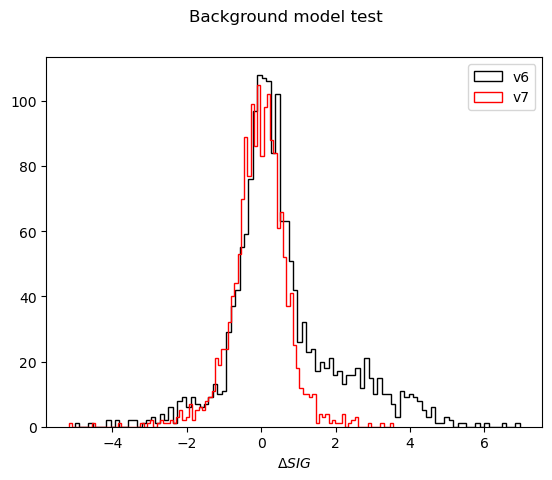

In [48]:
df1 = pd.read_csv('background_test_df.csv')
df2 = pd.read_csv('background_test2_df.csv')
df1 = df1[:1700]
df2 = df2[:1700]

fig, axs = plt.subplots(1,1)
fig.suptitle('Background model test')

axs.hist(df1['delta sig'], bins=100, histtype='step', color='black', label='v6')
axs.hist(df2['delta sig'], bins=100, histtype='step', color='red', label='v7')

axs.set_xlabel(r'$\Delta SIG$')
plt.legend()
plt.savefig('background model test3.pdf')
plt.show()

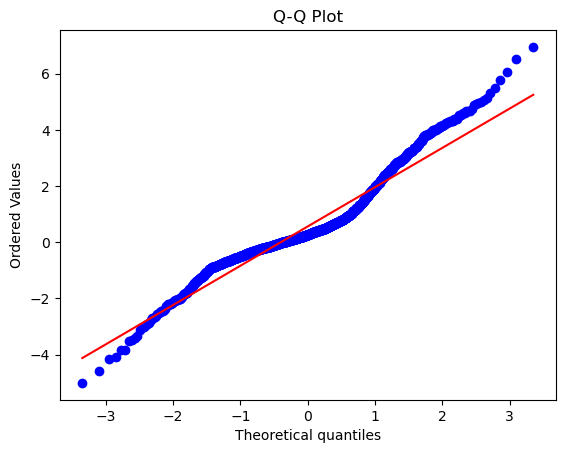

In [50]:
from scipy.stats import probplot

# Q-Q plot
probplot(df2['delta sig'], dist='norm', plot=plt)
plt.title('Q-Q Plot')
plt.show()

### results plots

In [66]:
#setting up sim dataframe

catalog_dir = '/project/shared/data/satsim/lsst_dc2_v7' 
results_dir = 'results_dir/07_sims_v7_final_mag_cut'
simsv7 = load_simdf(catalog_dir, results_dir)

catalog_dir = '/project/shared/data/satsim/lsst_dc2_v6' 
results_dir = 'results_dir/sims_v6_final_mag_cut'
simsv6 = load_simdf(catalog_dir, results_dir)

In [73]:
print('v7: ', len(simsv7))
simsv7 = simsv7[simsv7['SIG'] < 5.5]
print('v7: ', len(simsv7))

print('v6: ', len(simsv6))
simsv6 = simsv6[simsv6['SIG'] < 5.5]
print('v6: ', len(simsv6))

v7:  21498
v7:  21498
v6:  78973
v6:  20152


In [72]:
print('v6: ', len(simsv6))
df0 = simsv6[simsv6['SIG'] < 5.97]
print('v6: ', len(df0))

v6:  78973
v6:  21519


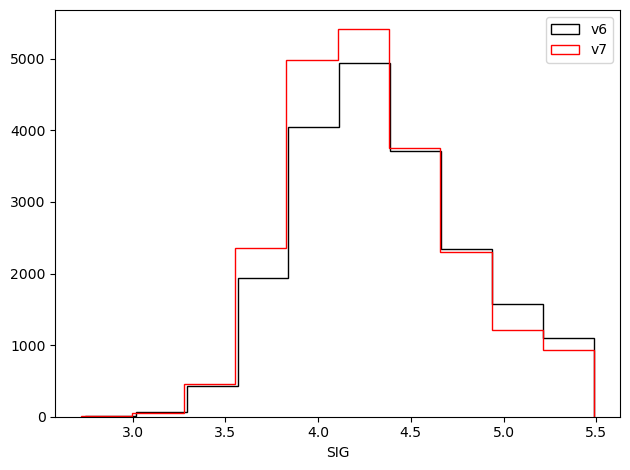

In [75]:
fig, axs = plt.subplots(1, 1)
axs.set_xlabel("SIG")
axs.hist(simsv6['SIG'], histtype='step', color='black', label='v6')
axs.hist(simsv7['SIG'], histtype='step', color='red', label='v7')
plt.tight_layout()
plt.legend()
plt.savefig('sig_hists.jpeg')

### star galaxy efficiency plots

In [ ]:
# Note that this query (which uses the truth information about star--galaxy separation) is much slower
def custom_query(service, ra=56.860588, dec = -41.548298, radius=1):
    """Return data queried from Rubin TAP using true star-galaxy separation
    Parameters
    ----------
    service : TAP service [str]
    ra      : Right Ascension [deg]
    dec     : Declination [deg]
    radius  : radius around (ra, dec) [deg]

    Returns
    -------
    df (pd.Dataframe): data from Rubin TAP
    """

    coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
    radius = radius * u.deg
    snr_threshold = 5
    mag_err_threshold = 1/snr_threshold
    
    query = f"""
        SELECT
            obj.ra, obj.dec,
            obj.mag_g, obj.mag_r,
            obj.magerr_g, obj.magerr_r,
            obj.mag_g as mag_corrected_g, obj.mag_r as mag_corrected_r,
            obj.extendedness as extended_class
        FROM dp01_dc2_catalogs.object as obj
        JOIN dp01_dc2_catalogs.truth_match as truth
        ON truth.match_objectId = obj.objectId
        WHERE CONTAINS(POINT('ICRS', obj.ra, obj.dec),CIRCLE('ICRS', {coord.ra.value}, {coord.dec.value}, {radius.value})) = 1
        AND truth.match_objectId >= 0 
        AND truth.is_good_match = 1
        AND obj.extendedness < 1
        AND truth.truth_type = 2
    """
    
    results = service.search(query).to_table().to_pandas()

    good_snr = (results['magerr_g'] < mag_err_threshold) & (results['magerr_r'] < mag_err_threshold)
    good_results = results[good_snr]
    
    return good_results

In [ ]:
match_stars_class = custom_query(service)
match_stars_class

### For generating contours

In [ ]:
def func(x,a,b,c):
    return a/(x - b) + c

In [ ]:
# Initial guess
P0=[[11.3 ,  10.0 ,  4.0  ],
    [22.6 ,  10.0 ,  4.3  ],
    [45.2 ,  6.0  ,  4.3  ],
    [90.5 ,  4.7  ,  4.3  ],
    [181.0,  2.1  ,  4.3  ],
    [362.0,  -0.7 ,  4.6  ],]

BOUNDS = [[0, -10, 3.5], #lower bounds for each column
          [512, 10, 5.0]] #upper bounds for each column

files = sorted(glob.glob('lsst_measured_p50_d*.npy'))
results = []

for i,f in enumerate(files):
    dist = float(f.rsplit('_')[-1].rsplit('.',1)[0].strip('d'))
    data = np.load(f)
    sigma = 0.05*np.ones(len(data[:,1]))
    sigma[0] = 0.5
    sigma[-1] = 0.5
    #print sigma
    r = curve_fit(func,data[:,0],data[:,1],p0=P0[i],sigma=sigma,bounds=BOUNDS)
    results += [[dist]+r[0].tolist()]

results = np.asarray(results)
results = results[np.argsort(results[:,0])]

print('%-5s  %-5s  %-5s  %-5s'%('Dist','A0','Mv0','logr0'))
for r in results:
    print('[%-5.1f,  %-5.1f,  %-5.1f,  %-5.1f],'%tuple(r))

### looking for example sim

In [20]:
sim_dir = '/project/shared/data/satsim/lsst_dc2_v6'
sims = load_simdf(sim_dir, 'results_dir/sims_v6_final_mag_cut')

In [28]:
simsdf = sims[sims['DISTANCE'] > 64]
#print(len(sims))
simsdf = simsdf[simsdf['ABS_MAG'] > 0]
np.min(simsdf['ABS_MAG'])
print(len(simsdf))
#sims = sims[sims['R_PHYSICAL'] > 2.5]
#print(len(sims))
simsdf = simsdf[simsdf['SIG'] > 5.0]
simsdf = simsdf[simsdf['SIG'] < 6.0]

print(len(simsdf))

8178
843


In [29]:
vals = simsdf['MC_SOURCE_ID'].values
print(vals[:10])

[27356 69974 71390 92287 92289 95609 53358 53383 58363 56129]


In [26]:
population_file = glob.glob(os.path.join(sim_dir, '*population*'))
population_file

['/project/shared/data/satsim/lsst_dc2_v6/sim_population_lsst_dc2_v6_mc_source_id_0027301-0027400.fits',
 '/project/shared/data/satsim/lsst_dc2_v6/sim_population_lsst_dc2_v6_mc_source_id_0055301-0055400.fits',
 '/project/shared/data/satsim/lsst_dc2_v6/sim_population_lsst_dc2_v6_mc_source_id_0069901-0070000.fits',
 '/project/shared/data/satsim/lsst_dc2_v6/sim_population_lsst_dc2_v6_mc_source_id_0094201-0094300.fits',
 '/project/shared/data/satsim/lsst_dc2_v6/sim_population_lsst_dc2_v6_mc_source_id_0071301-0071400.fits',
 '/project/shared/data/satsim/lsst_dc2_v6/sim_population_lsst_dc2_v6_mc_source_id_0084901-0085000.fits',
 '/project/shared/data/satsim/lsst_dc2_v6/sim_population_lsst_dc2_v6_mc_source_id_0092201-0092300.fits',
 '/project/shared/data/satsim/lsst_dc2_v6/sim_population_lsst_dc2_v6_mc_source_id_0095601-0095700.fits',
 '/project/shared/data/satsim/lsst_dc2_v6/sim_population_lsst_dc2_v6_mc_source_id_0053301-0053400.fits',
 '/project/shared/data/satsim/lsst_dc2_v6/sim_populatio

In [32]:
# for looking for a specific satellite with some sim_id
sim_dir = '/project/shared/data/satsim/lsst_dc2_v6'
population_file = glob.glob(os.path.join(sim_dir, '*population*'))
file = '/project/shared/data/satsim/lsst_dc2_v6/sim_population_lsst_dc2_v6_mc_source_id_0092201-0092300.fits'
name = file
start = name.find('0')
end = start + 15
mcids = name[start:end]
print(mcids)

with open('config.yaml') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.SafeLoader)
    survey = simple_adl.survey.Survey(cfg)

sim_population = fits.read(file)
sim_positions = np.unique(sim_population[['RA', 'DEC']])
sim_population  = sim_population.byteswap().newbyteorder()    # resetting byte order for compatibility
sim_population = sim_population[sim_population['FRACDET_CORE'] == 1]
sim_population = sim_population[sim_population['FRACDET_WIDE'] == 1]
sim_population = sim_population[sim_population['FRACDET_HALF'] == 1]
radius = 2
simid = 92287
for iii,position in enumerate(sim_positions):
    sim_population_at_position = sim_population[sim_population[['RA', 'DEC']] == position]
    t = pd.DataFrame(sim_population_at_position)
    if len(t['MC_SOURCE_ID'].values) == 0:
        print(f'No sims at {position}')
        continue
    elif simid not in t['MC_SOURCE_ID'].values:
        print('Not here')
        continue
    print(f'Querying region {position}')
    real_data = query(service, position[0], position[1], radius)  # pd.DataFrame

    print('Satellites at ', position, ':\n', t['MC_SOURCE_ID'].values)
    for mcid in sim_population_at_position['MC_SOURCE_ID']:
        if mcid == simid:
            sim_data = load_sim_data(sim_dir, mcid)
            if sim_data is not None:
                sim_data = sim_data.byteswap().newbyteorder()   # resetting byte order for compatibility
                sim_data = pd.DataFrame(sim_data)               # convert to pd.DataFrame
                # mask to ensure we only use sims within the queried data's footprint

                c2 = SkyCoord(sim_data['ra'], sim_data['dec'], unit='deg', frame='icrs')
                center = SkyCoord(position[0], position[1], unit='deg')
                d2d = center.separation(c2) 
                catalogmsk = d2d < radius*u.deg
                sim_data = sim_data[catalogmsk]

                if sim_data.empty:
                    print(f'No sim data to inject into region at ({position[0]},{position[1]}) after applying mask')
                    continue

                # merging the sims and dc2 data
                frames = [real_data[real_data.columns[:-1]], sim_data[real_data.columns[:-1]]]
                merged_data = pd.concat(frames)  # pd.Dataframe
                # perform mag cut on the merged data
                good_snr = (merged_data['magerr_g'] < 0.2) & (merged_data['magerr_r'] < 0.2)
                merged_data = merged_data[good_snr]
                good_mag = (merged_data['mag_g'] < survey.catalog['mag_max']) & (merged_data['mag_r'] < survey.catalog['mag_max'])
                merged_data = merged_data[good_mag]
                ra = position[0]
                dec = position[1]
                region = simple_adl.survey.Region(survey, ra, dec)
                region.data = merged_data

                # Scan in distance moduli    
                distance_modulus = t.loc[t['MC_SOURCE_ID'] == mcid]['DISTANCE_MODULUS']
                distance_modulus = distance_modulus.values[0]
                iso_search = simple_adl.isochrone.Isochrone(survey=survey.isochrone['survey'],
                                                       band_1=survey.band_1.lower(),
                                                       band_2=survey.band_2.lower(),
                                                       age=12.0, #survey.isochrone['age'],
                                                       metallicity=0.00010, #survey.isochrone['metallicity'],
                                                       distance_modulus=distance_modulus)

                iso_selection = cut_isochrone_path(region.data[survey.mag_dered_1], 
                                                      region.data[survey.mag_dered_2],
                                                      region.data[survey.mag_err_1],
                                                      region.data[survey.mag_err_2],
                                                      iso_search,
                                                      survey.catalog['mag_max'],
                                                      radius=0.1)
                fig, axs = plt.subplots(1, 1)
                plot_cmd_sep_iso(merged_data, iso_selection, axs)
                plt.savefig('measured_iso.pdf')
                break
        break
            

0092201-0092300
Not here
Not here
Not here
Not here
Not here
Not here
Not here
Not here
Querying region (67.3406, -43.438316)


DALServiceError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))